In [2]:
!pip install wandb -Uq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import numpy as np
import wandb

### Preprocess the data

In [5]:
df = pd.read_csv("dataset_cifar10_v1.csv") # loading the dataset to pandas df

In [6]:
map = {"A":1.0,"B":2.0,"C":3.0,"D":4.0} # mapping the conv block type to numerical values

In [7]:
for column, dtype in df.dtypes.items(): # applying the mapping to the column and also converting to float32
    if dtype == 'object':
        df[column] = df[column].replace(map).astype('float32')

df = df.astype({col: 'float32' for col in df.select_dtypes('int64').columns})

In [ ]:
df.head()

In [9]:
# mapping to assign labels to architecture data based on 1 day accuracy
intervals_mapping = {
    (0.6, 0.65): 0,
    (0.65, 0.7): 1,
    (0.7, 0.75): 2,
    (0.75, 0.8): 3,
    (0.8, 0.85): 4,
    (0.85, 0.9): 5,
    (0.9, 0.95): 6,
}

In [10]:
def map_accuracy_to_value(accuracy):
    for interval, value in intervals_mapping.items():
        if interval[0] <= accuracy <= interval[1]:
            return value
    return None  # Returns None if the accuracy doesn't fall within any defined intervals

df['accuracy_mapped'] = df['1_day_accuracy'].apply(map_accuracy_to_value)

### Grouping the data based on 1 day accuracy for visualization (not required to run during training)

In [ ]:
df['accuracy_bin'] = pd.cut(df['1_day_accuracy'], bins=np.arange(df['1_day_accuracy'].min(),df['1_day_accuracy'].max()+0.02,0.05),right=True)
grouped_df = df.groupby('accuracy_bin')

In [ ]:
df['1_day_accuracy'].min(),df['1_day_accuracy'].max()

(0.6000988501169846, 0.9399111190594944)

In [ ]:
np.arange(df['1_day_accuracy'].min(),df['1_day_accuracy'].max()+0.02,0.05)

array([0.60009885, 0.65009885, 0.70009885, 0.75009885, 0.80009885,
       0.85009885, 0.90009885, 0.95009885])

In [ ]:
for name, group in grouped_df:
    print(f'Group: {name}')
    print(len(group))

Group: (0.6, 0.65]
76
Group: (0.65, 0.7]
91
Group: (0.7, 0.75]
68
Group: (0.75, 0.8]
59
Group: (0.8, 0.85]
59
Group: (0.85, 0.9]
61
Group: (0.9, 0.95]
785


In [ ]:
group = grouped_df.get_group(pd.Interval(left=0.9, right=0.95, closed='right'))
group.iloc[200:250,-4]

In [ ]:
np.unique(df['accuracy_mapped'],return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7]), array([ 77,  91,  67,  60,  58,  58, 789]))

### -------------------------------- Run below

In [11]:
data = df.iloc[:,:-4]
data.head()

out_channel0    M   R1   R2    R3   R4   R5  convblock1  widenfact1    B1  \
0         117.0  1.0  9.0  0.0   0.0  0.0  0.0         2.0         4.0  11.0   
1         122.0  1.0  3.0  0.0   0.0  0.0  0.0         4.0         4.0   2.0   
2         102.0  1.0  1.0  0.0   0.0  0.0  0.0         3.0         1.0   9.0   
3          32.0  3.0  3.0  1.0   7.0  0.0  0.0         2.0         2.0   5.0   
4          38.0  3.0  8.0  4.0  11.0  0.0  0.0         4.0         1.0  12.0   

   ...   B2  convblock3  widenfact3   B3  convblock4  widenfact4   B4  \
0  ...  0.0         0.0         0.0  0.0         0.0         0.0  0.0   
1  ...  0.0         0.0         0.0  0.0         0.0         0.0  0.0   
2  ...  0.0         0.0         0.0  0.0         0.0         0.0  0.0   
3  ...  9.0         3.0         1.0  1.0         0.0         0.0  0.0   
4  ...  6.0         4.0         3.0  9.0         0.0         0.0  0.0   

   convblock5  widenfact5   B5  
0         0.0         0.0  0.0  
1         0.0         0.0  0.0  
2         0.0         0.0  0.0  
3         0.0         0.0  0.0  
4         0.0         0.0  0.0  

[5 rows x 22 columns]

In [12]:
labels = df.iloc[:,-1]
labels.head()

0    6
1    6
2    5
3    1
4    5
Name: accuracy_mapped, dtype: int64

### Run below cells if one hot encoding is needed (not used for training currently)

In [ ]:
data = data.drop(['convblock1','convblock2','convblock3','convblock4','convblock5'],axis=1)

In [ ]:
data = pd.get_dummies(data,columns=['convblock1','convblock2','convblock3','convblock4','convblock5'])
data.head()

out_channel0    M   R1   R2    R3   R4   R5  widenfact1    B1  widenfact2  \
0         117.0  1.0  9.0  0.0   0.0  0.0  0.0         4.0  11.0         0.0   
1         122.0  1.0  3.0  0.0   0.0  0.0  0.0         4.0   2.0         0.0   
2         102.0  1.0  1.0  0.0   0.0  0.0  0.0         1.0   9.0         0.0   
3          32.0  3.0  3.0  1.0   7.0  0.0  0.0         2.0   5.0         3.0   
4          38.0  3.0  8.0  4.0  11.0  0.0  0.0         1.0  12.0         1.0   

   ...  convblock4_0.0  convblock4_1.0  convblock4_2.0  convblock4_3.0  \
0  ...               1               0               0               0   
1  ...               1               0               0               0   
2  ...               1               0               0               0   
3  ...               1               0               0               0   
4  ...               1               0               0               0   

   convblock4_4.0  convblock5_0.0  convblock5_1.0  convblock5_2.0  \
0               0               1               0               0   
1               0               1               0               0   
2               0               1               0               0   
3               0               1               0               0   
4               0               1               0               0   

   convblock5_3.0  convblock5_4.0  
0               0               0  
1               0               0  
2               0               0  
3               0               0  
4               0               0  

[5 rows x 41 columns]

### Min max scaler for normalization (not used for training currently)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data[data.columns[:17]] = scaler.fit_transform(data[data.columns[:17]])

In [ ]:
data

out_channel0     M        R1      R2      R3     R4      R5  convblock1  \
0         0.908333  0.00  0.533333  0.0000  0.0000  0.000  0.0000    0.333333   
1         0.950000  0.00  0.133333  0.0000  0.0000  0.000  0.0000    1.000000   
2         0.783333  0.00  0.000000  0.0000  0.0000  0.000  0.0000    0.666667   
3         0.200000  0.50  0.133333  0.0625  0.4375  0.000  0.0000    0.333333   
4         0.250000  0.50  0.466667  0.2500  0.6875  0.000  0.0000    1.000000   
...            ...   ...       ...     ...     ...    ...     ...         ...   
1195      0.158333  0.50  0.600000  0.6875  0.5625  0.000  0.0000    0.333333   
1196      0.375000  0.25  0.866667  1.0000  0.0000  0.000  0.0000    0.000000   
1197      0.383333  0.00  0.133333  0.0000  0.0000  0.000  0.0000    0.000000   
1198      0.333333  1.00  0.200000  0.8125  1.0000  0.875  0.6875    0.666667   
1199      0.500000  0.00  0.133333  0.0000  0.0000  0.000  0.0000    1.000000   

      widenfact1        B1  ...  widenfact2        B2  convblock3  widenfact3  \
0       1.000000  0.909091  ...        0.00  0.000000        0.00        0.00   
1       1.000000  0.090909  ...        0.00  0.000000        0.00        0.00   
2       0.000000  0.727273  ...        0.00  0.000000        0.00        0.00   
3       0.333333  0.363636  ...        0.75  0.750000        0.75        0.25   
4       0.000000  1.000000  ...        0.25  0.500000        1.00        0.75   
...          ...       ...  ...         ...       ...         ...         ...   
1195    0.000000  0.000000  ...        1.00  0.583333        0.75        0.75   
1196    0.000000  0.363636  ...        0.75  0.333333        0.00        0.00   
1197    1.000000  0.909091  ...        0.00  0.000000        0.00        0.00   
1198    1.000000  0.181818  ...        1.00  1.000000        0.75        0.75   
1199    0.000000  0.181818  ...        0.00  0.000000        0.00        0.00   

            B3  convblock4  widenfact4    B4  convblock5  widenfact5  
0     0.000000         0.0         0.0   0.0         0.0         0.0  
1     0.000000         0.0         0.0   0.0         0.0         0.0  
2     0.000000         0.0         0.0   0.0         0.0         0.0  
3     0.083333         0.0         0.0   0.0         0.0         0.0  
4     0.750000         0.0         0.0   0.0         0.0         0.0  
...        ...         ...         ...   ...         ...         ...  
1195  0.583333         0.0         0.0   0.0         0.0         0.0  
1196  0.000000         0.0         0.0   0.0         0.0         0.0  
1197  0.000000         0.0         0.0   0.0         0.0         0.0  
1198  0.583333         0.5         1.0  12.0         2.0         4.0  
1199  0.000000         0.0         0.0   0.0         0.0         0.0  

[1200 rows x 21 columns]

### Converting df to tensors

In [13]:
data = torch.tensor(data[data.columns].values,dtype=torch.float32)
labels = torch.tensor(labels.values,dtype=torch.int64)

In [14]:
data.shape, labels.shape

(torch.Size([1200, 22]), torch.Size([1200]))

In [15]:
labels

tensor([6, 6, 5,  ..., 6, 6, 2])

### Normlizing the tensors to have mean 0 and std 1 (not used for training currently)

In [ ]:
data = (data - torch.mean(data,dim=0))/torch.std(data,dim=0)

In [ ]:
data.std(dim=0)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000])

### initializing the device

In [16]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

In [17]:
device

'cuda'

### Dataset definition

In [18]:
class VQVAE_Dataset(Dataset):
  def __init__(self,data,labels):
    self.data = data
    self.labels = labels

  def __getitem__(self,idx):
    return self.data[idx],self.labels[idx]

  def __len__(self):
    return len(self.data)

### Model definition

In [19]:
class Encoder(nn.Module):
  def __init__(self,inp_dim,embed_dim=10,h_nodes=128,dropout=0.2,scale=2,num_layers=1):
    super(Encoder,self).__init__()
    self.inp_dim = inp_dim
    self.embed_dim = embed_dim
    self.tanh = nn.Tanh()
    self.dropout = nn.Dropout(dropout)
    self.scale = scale
    self.num_layers = num_layers
    self.h_nodes = h_nodes
    self.relu = nn.ReLU()
    self.layers = nn.ModuleList([nn.Sequential(
                                      nn.Linear(h_nodes//(scale**i),h_nodes//(scale**(i+1))),
                                      nn.ReLU(inplace=True),
                                      # nn.Dropout(dropout)
                                  )
                                  for i in range(num_layers)])
    self.fc1 = nn.Linear(self.inp_dim,h_nodes)
    self.fc2 = nn.Linear(h_nodes//(scale**(num_layers)),self.embed_dim)

  def forward(self,x):
    x = self.relu(self.fc1(x))
    for layer in self.layers:
      x = layer(x)
    x = self.fc2(x)
    # x = self.tanh(x)
    return x

class Decoder(nn.Module):
  def __init__(self,out_dim,embed_dim=10,h_nodes=128,dropout=0.2,scale=2,num_layers=1):
    super(Decoder,self).__init__()
    self.out_dim = out_dim
    self.embed_dim = embed_dim
    self.h_nodes = h_nodes
    self.scale = scale
    self.num_layers = num_layers
    self.fc1 = nn.Linear(self.embed_dim,h_nodes)
    self.layers = nn.ModuleList([nn.Sequential(
                                      nn.Linear(h_nodes//(scale**i),h_nodes//(scale**(i+1))),
                                      nn.ReLU(inplace=True),
                                      # nn.Dropout(dropout)
                                  )
                                  for i in range(num_layers)])
    self.fc2 = nn.Linear(h_nodes//scale**(num_layers),self.out_dim)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(dropout)
    self.tanh = nn.Tanh()
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    x = self.relu(self.fc1(x))
    for layer in self.layers:
      x = layer(x)
    x = self.fc2(x)
    x = self.relu(x)
    return x

class VectorQuantizer(nn.Module):
  def __init__(self,num_embeddings=50,embedding_dim=10,commitment_cost=0.25):
    super(VectorQuantizer,self).__init__()
    self.num_embeddings = num_embeddings
    self.embed_dim = embedding_dim
    self.embeddings = nn.Embedding(self.num_embeddings,self.embed_dim)
    self.embeddings.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)
    self.commitment_cost = commitment_cost

  def forward(self,x):
    # x: [B,D]
    # embeddings: [num_embeddings, embed_dim]

    latent_vectors = x.unsqueeze(1) # [B,D] -> [B,1,D]
    codebook_vectors = self.embeddings.weight.unsqueeze(0) # [num_embeddings, embed_dim] -> [1,num_embeddings, embed_dim]
    distances = torch.norm(latent_vectors - codebook_vectors, dim=2) # [B,num_embeddings]
    closest_indices = torch.argmin(distances,dim=1).unsqueeze(1)

    # making a one hot encoder of the closest codebook chosen for perplexity calculation [B,num_embeddings]
    encodings = torch.zeros(closest_indices.shape[0], self.num_embeddings, device=x.device)
    encodings.scatter_(1,closest_indices,1)

    quantized = self.embeddings(closest_indices).squeeze(1)

    e_latent_loss = F.mse_loss(quantized.detach(), x)
    q_latent_loss = F.mse_loss(quantized, x.detach())
    loss = q_latent_loss + self.commitment_cost * e_latent_loss

    # to copy gradients from decoder to encoder
    quantized = x + (quantized - x).detach()

    avg_probs = torch.mean(encodings, dim=0)
    perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

    return loss, quantized, perplexity, closest_indices

class VectorQuantizerClass(nn.Module):
  def __init__(self,num_embeddings=50,embedding_dim=10,commitment_cost=0.25,divergence_cost=0.1):
    super(VectorQuantizerClass,self).__init__()
    self.num_embeddings = num_embeddings
    self.embed_dim = embedding_dim
    self.embeddings = nn.Embedding(self.num_embeddings,self.embed_dim)
    self.embeddings.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)
    self.commitment_cost = commitment_cost
    self.divergence_cost = divergence_cost

  def forward(self,x,y):
    # x: [B,D]
    # embeddings: [num_embeddings, embed_dim]

    latent_vectors = x.unsqueeze(1) # [B,D] -> [B,1,D]
    codebook_vectors = self.embeddings.weight.unsqueeze(0) # [num_embeddings, embed_dim] -> [1,num_embeddings, embed_dim]
    distances = torch.norm(latent_vectors - codebook_vectors, dim=2) # [B,num_embeddings]

    encoding_indices = torch.reshape(y,(y.shape[0], 1))
    encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings).to(device)
    encodings.scatter_(1, encoding_indices, 1)

    close_indices = torch.argmin(distances, dim=1).unsqueeze(1)
    close_encodings = torch.zeros(close_indices.shape[0], self.num_embeddings).to(device)
    close_encodings.scatter_(1, close_indices, 1)

    indicator = 1 - (encoding_indices == close_indices).int()
    indicator = indicator.float()

    # Quantize
    quantized = torch.matmul(encodings, self.embeddings.weight)
    close_quantized = torch.matmul(close_encodings, self.embeddings.weight)

    # Loss
    q_latent_loss = torch.mean((quantized - x.detach())**2)
    e_latent_loss = torch.mean((quantized.detach() - x)**2)
    x_latent_loss = torch.mean(indicator * ((close_quantized - x.detach())**2))
    d_latent_loss = torch.mean(indicator * ((close_quantized.detach() - x)**2))
    loss = q_latent_loss + self.commitment_cost * e_latent_loss - x_latent_loss - self.divergence_cost * d_latent_loss

    # to copy gradients from decoder to encoder
    quantized = x + (quantized - x).detach()

    avg_probs = torch.mean(encodings, dim=0)
    perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

    return loss, quantized, perplexity, close_indices


### Normal VQ VAE (trained using no label data)

In [20]:
class VQVAE(nn.Module):
  def __init__(self,x_dim,embed_dim=10,dropout=0.2,num_embeddings=50,commitment_cost=0.25,h_nodes=128,scale=2,num_layers=1):
    super(VQVAE,self).__init__()
    self.encoder = Encoder(x_dim,embed_dim,dropout=dropout,h_nodes=h_nodes,scale=scale,num_layers=num_layers)
    self.quantizer = VectorQuantizer(num_embeddings,embed_dim,commitment_cost)
    self.decoder = Decoder(x_dim,embed_dim,h_nodes=h_nodes,dropout=dropout,scale=scale,num_layers=num_layers)

  def forward(self,x):
    z = self.encoder(x)
    loss, quantized_z, perplexity, close_indices = self.quantizer(z)
    x_recon = self.decoder(quantized_z)
    return loss, x_recon, perplexity, close_indices


### Supervised VQ VAE (trained using the label data)

In [21]:
class SVQVAE(nn.Module):
  def __init__(self,x_dim,embed_dim=10,dropout=0.2,num_embeddings=50,commitment_cost=0.25,divergence_cost=0.1,h_nodes=128,scale=2,num_layers=1):
    super(SVQVAE,self).__init__()
    self.encoder = Encoder(x_dim,embed_dim,dropout=dropout,h_nodes=h_nodes,scale=scale,num_layers=num_layers)
    self.quantizer = VectorQuantizerClass(num_embeddings,embed_dim,commitment_cost,divergence_cost)
    self.decoder = Decoder(x_dim,embed_dim,h_nodes=h_nodes,dropout=dropout,scale=scale,num_layers=num_layers)

  def forward(self,x,y):
    z = self.encoder(x)
    loss, quantized_z, perplexity, close_indices = self.quantizer(z,y)
    x_recon = self.decoder(quantized_z)
    return loss, x_recon, perplexity, close_indices

### Training setup

In [22]:
dataset = VQVAE_Dataset(data,labels) # dataset init

In [ ]:
# hyperparameters (TODO: tuning)
x_dim = data.shape[1]
h_nodes = 128
scale = 2
num_layers = 3
embed_dim = 10
dropout = 0.2
num_embeddings = 50
commitment_cost = 0.25
divergence_cost = 0.1
epochs = 1000
learning_rate = 1e-4
weight_decay = 1e-3
batch_size = 16

### Grid search

In [ ]:
import itertools

hyperparameters = {
    'embed_dim': [15, 20, 25, 30],
    'num_embeddings': [50, 100, 150, 200],
    'commitment_cost': [0.25, 0.3, 0.35, 0.4, 0.45,0.5],
}

def train_and_evaluate(hyperparam_config):
    model = VQVAE(x_dim, hyperparam_config['embed_dim'], dropout=dropout,
                  num_embeddings=hyperparam_config['num_embeddings'],
                  commitment_cost=hyperparam_config['commitment_cost'],
                  h_nodes=h_nodes, scale=scale,
                  num_layers=num_layers).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)

    model.train()
    val_loss = 0
    for epoch in tqdm(range(epochs)):

      for i, batch in enumerate(train_loader):  # Iterate over all batches in the dataset
        batch = batch.to(device)
        optimizer.zero_grad()

        noise = torch.rand(batch.size()).to(device)
        vq_loss, data_recon, perplexity = model(batch + noise)
        recon_error = F.mse_loss(data_recon, batch)
        loss = recon_error + vq_loss
        loss.backward()

        optimizer.step()
      if epoch == epochs-1:
        val_loss = loss.item()
        print(val_loss,perplexity.item())
        print(hyperparam_config)

    return val_loss

# Iterate over all combinations of hyperparameters
best_val_loss = float('inf')
best_hyperparams = None

for hyperparam_values in itertools.product(*hyperparameters.values()):
    hyperparam_config = dict(zip(hyperparameters.keys(), hyperparam_values))

    val_loss = train_and_evaluate(hyperparam_config)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_hyperparams = hyperparam_config

print("Best hyperparameters:", best_hyperparams)


### Wandb hyperparameter search

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
sweep_config = {
    'method': 'bayes'
    }
metric = {
    'name': 'loss',
    'goal': 'minimize'
    }

sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        # 'values': ['adam', 'sgd']
        'value': 'adam'
        },
    'h_nodes': {
        'values': [512, 1024, 2048]
        },
    'num_layers': {
        'values': [4, 5, 6]
    },
    'embed_dim': {
        'values': [6, 8, 10, 14]
    },
    'num_embeddings': {
        # 'values': [25, 50, 75, 100]
        'value' : 7
    },
    'commitment_cost': {
        'values': [0.1,0.2,0.25,0.4,0.5]
    },
    'divergence_cost': {
        'values': [0.1,0.2,0.25,0.4,0.5]
    },
    'dropout': {
          'values': [0.1, 0.2, 0.3]
        },
    'epochs': {
          'value': 200
        },
    'learning_rate': {
          # a flat distribution between 0 and 0.1
          'distribution': 'uniform',
          'min': 1e-6,
          'max': 1e-3
        },
    'weight_decay': {
          # a flat distribution between 0 and 0.1
          'distribution': 'uniform',
          'min': 1e-6,
          'max': 1e-3
        },
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms
        'distribution': 'q_log_uniform_values',
        'q': 8,
        'min': 32,
        'max': 256,
      }
    }

sweep_config['parameters'] = parameters_dict

In [ ]:
import pprint

pprint.pprint(sweep_config)

{'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'distribution': 'q_log_uniform_values',
                               'max': 256,
                               'min': 32,
                               'q': 8},
                'commitment_cost': {'values': [0.1, 0.2, 0.25, 0.4, 0.5]},
                'divergence_cost': {'values': [0.1, 0.2, 0.25, 0.4, 0.5]},
                'dropout': {'values': [0.1, 0.2, 0.3]},
                'embed_dim': {'values': [6, 8, 10, 14]},
                'epochs': {'value': 200},
                'h_nodes': {'values': [512, 1024, 2048]},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.001,
                                  'min': 1e-06},
                'num_embeddings': {'value': 7},
                'num_layers': {'values': [4, 5, 6]},
                'optimizer': {'value': 'adam'},
                'weight_decay': {'distribution': 'uniform',
     

In [ ]:
x_dim = data.shape[1]
scale = 2

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="RL-NAS-Hyperparameter-tuning")

Create sweep with ID: nrizaxj0
Sweep URL: https://wandb.ai/sb-nd/RL-NAS-Hyperparameter-tuning/sweeps/nrizaxj0


In [ ]:
def build_optimizer(network, optimizer, learning_rate, weight_decay):
    if optimizer == "sgd":
        optimizer = optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    elif optimizer == "adam":
        optimizer = optim.Adam(network.parameters(),
                               lr=learning_rate, weight_decay=weight_decay)
    return optimizer

In [ ]:
def train(config=None):
  with wandb.init(config=config):
    config = wandb.config

    train_loader = DataLoader(dataset,batch_size=config.batch_size,shuffle=True)

    # model = VQVAE(x_dim,config.embed_dim,dropout=config.dropout,num_embeddings=config.num_embeddings,
    #           commitment_cost=config.commitment_cost,h_nodes=config.h_nodes,scale=scale,
    #           num_layers=config.num_layers).to(device)

    model = SVQVAE(x_dim,config.embed_dim,dropout=config.dropout,num_embeddings=config.num_embeddings,
          commitment_cost=config.commitment_cost,divergence_cost=config.divergence_cost,h_nodes=config.h_nodes,scale=scale,
          num_layers=config.num_layers).to(device)

    optimizer = build_optimizer(model, config.optimizer, config.learning_rate, config.weight_decay)
    model.train()
    train_res_recon_error = []
    train_res_perplexity = []

    error = 0

    for epoch in tqdm(range(config.epochs)):

      for i, batch in enumerate(train_loader):  # Iterate over all batches in the dataset
        batch_x,batch_y = batch
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()

        # noise = torch.rand(batch.size()).to(device)
        vq_loss, data_recon, perplexity, _ = model(batch_x,batch_y)
        recon_error = F.mse_loss(data_recon, batch_x)
        loss = recon_error + vq_loss
        loss.backward()

        optimizer.step()

        train_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item())

        error = recon_error.item()

      wandb.log({"loss": error, "epoch": epoch})

In [ ]:
wandb.agent(sweep_id, train, count=30)

wandb: Agent Starting Run: n5478mzq with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.2
wandb: 	divergence_cost: 0.2
wandb: 	dropout: 0.2
wandb: 	embed_dim: 6
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.0008505801301272655
wandb: 	num_embeddings: 7
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0002443718477754979


100%|██████████| 200/200 [00:46<00:00,  4.26it/s]


wandb: Agent Starting Run: sv28izja with config:
wandb: 	batch_size: 64
wandb: 	commitment_cost: 0.4
wandb: 	divergence_cost: 0.1
wandb: 	dropout: 0.1
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.0008934107304773628
wandb: 	num_embeddings: 7
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.000441469273381441


100%|██████████| 200/200 [00:23<00:00,  8.39it/s]


wandb: Agent Starting Run: he1o48bc with config:
wandb: 	batch_size: 48
wandb: 	commitment_cost: 0.2
wandb: 	divergence_cost: 0.2
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 1.044627945289765e-05
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001155393039698986


100%|██████████| 200/200 [00:33<00:00,  6.03it/s]


wandb: Agent Starting Run: hbbujrbe with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.25
wandb: 	divergence_cost: 0.25
wandb: 	dropout: 0.2
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.0006938110341068075
wandb: 	num_embeddings: 7
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0002154699463476565


100%|██████████| 200/200 [00:44<00:00,  4.46it/s]


wandb: Agent Starting Run: 9w3wlq6r with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.25
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0005154136551471534
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 9.236156190344164e-05


100%|██████████| 200/200 [00:48<00:00,  4.10it/s]


wandb: Agent Starting Run: ps2ruiu0 with config:
wandb: 	batch_size: 48
wandb: 	commitment_cost: 0.25
wandb: 	divergence_cost: 0.25
wandb: 	dropout: 0.2
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0006451443737094854
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00013609812733144774


100%|██████████| 200/200 [00:33<00:00,  6.02it/s]


wandb: Agent Starting Run: rgwzum8l with config:
wandb: 	batch_size: 40
wandb: 	commitment_cost: 0.5
wandb: 	divergence_cost: 0.5
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.0007751677814014428
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00010375692136847484


100%|██████████| 200/200 [00:38<00:00,  5.19it/s]


wandb: Agent Starting Run: iwaluw22 with config:
wandb: 	batch_size: 64
wandb: 	commitment_cost: 0.5
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.3
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 2048
wandb: 	learning_rate: 0.0008583672938180878
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0003987749012499768


100%|██████████| 200/200 [00:33<00:00,  6.03it/s]


wandb: Agent Starting Run: cpzaye75 with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.25
wandb: 	divergence_cost: 0.5
wandb: 	dropout: 0.3
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0005227273999097174
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00012119064247807982


100%|██████████| 200/200 [00:50<00:00,  3.93it/s]


wandb: Agent Starting Run: si4bcxf1 with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.4
wandb: 	divergence_cost: 0.25
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0008957435736136399
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00021666640511844784


100%|██████████| 200/200 [00:51<00:00,  3.90it/s]


wandb: Agent Starting Run: lpxkjvd6 with config:
wandb: 	batch_size: 64
wandb: 	commitment_cost: 0.25
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.2
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0008744443892263988
wandb: 	num_embeddings: 7
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 5.231225400351071e-05


100%|██████████| 200/200 [00:27<00:00,  7.20it/s]


wandb: Agent Starting Run: prvqddj6 with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.4
wandb: 	divergence_cost: 0.25
wandb: 	dropout: 0.3
wandb: 	embed_dim: 14
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0009095270382269476
wandb: 	num_embeddings: 7
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001729418082944762


100%|██████████| 200/200 [00:48<00:00,  4.12it/s]


wandb: Agent Starting Run: scf9a4sz with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.4
wandb: 	divergence_cost: 0.5
wandb: 	dropout: 0.2
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.000683630716908634
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.000356296435470004


100%|██████████| 200/200 [00:51<00:00,  3.86it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2d4xlr9v with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.4
wandb: 	divergence_cost: 0.25
wandb: 	dropout: 0.1
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0007429411991713249
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00012960406108008014


100%|██████████| 200/200 [00:51<00:00,  3.87it/s]


wandb: Agent Starting Run: dqgch0nv with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.5
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0009225898562797062
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00045561858085926


100%|██████████| 200/200 [00:52<00:00,  3.82it/s]


wandb: Agent Starting Run: w6hchaih with config:
wandb: 	batch_size: 48
wandb: 	commitment_cost: 0.5
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.3
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0006534208694216392
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0003656534783698616


100%|██████████| 200/200 [00:33<00:00,  5.90it/s]


wandb: Agent Starting Run: uxyt1t7u with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.5
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.2
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.0006319386406941296
wandb: 	num_embeddings: 7
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00016596910057276994


100%|██████████| 200/200 [00:46<00:00,  4.34it/s]


wandb: Agent Starting Run: olznma0v with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.4
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0009997016664200378
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00010956749266669135


100%|██████████| 200/200 [00:49<00:00,  4.04it/s]


wandb: Agent Starting Run: edn7zib2 with config:
wandb: 	batch_size: 48
wandb: 	commitment_cost: 0.4
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.2
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 2048
wandb: 	learning_rate: 0.0007356674954369195
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00034601097376242145


100%|██████████| 200/200 [00:41<00:00,  4.87it/s]


wandb: Agent Starting Run: ubpqivp5 with config:
wandb: 	batch_size: 64
wandb: 	commitment_cost: 0.4
wandb: 	divergence_cost: 0.25
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.0006161040278989474
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001887937062304547


100%|██████████| 200/200 [00:26<00:00,  7.60it/s]


wandb: Agent Starting Run: zhs0530q with config:
wandb: 	batch_size: 88
wandb: 	commitment_cost: 0.25
wandb: 	divergence_cost: 0.25
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.000658369936830337
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00015544299628558514


100%|██████████| 200/200 [00:19<00:00, 10.31it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z7kpn734 with config:
wandb: 	batch_size: 64
wandb: 	commitment_cost: 0.4
wandb: 	divergence_cost: 0.5
wandb: 	dropout: 0.2
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 2048
wandb: 	learning_rate: 0.0004702171157455684
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001966816506090776


100%|██████████| 200/200 [00:32<00:00,  6.19it/s]


wandb: Agent Starting Run: sslcrchy with config:
wandb: 	batch_size: 40
wandb: 	commitment_cost: 0.25
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.3
wandb: 	embed_dim: 6
wandb: 	epochs: 200
wandb: 	h_nodes: 2048
wandb: 	learning_rate: 0.0006619874312401996
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001553025891357451


100%|██████████| 200/200 [00:49<00:00,  4.04it/s]


wandb: Agent Starting Run: cqkcd4ic with config:
wandb: 	batch_size: 40
wandb: 	commitment_cost: 0.25
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.3
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0004325474901111556
wandb: 	num_embeddings: 7
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0003910372391439912


100%|██████████| 200/200 [00:38<00:00,  5.19it/s]


wandb: Agent Starting Run: 5scora97 with config:
wandb: 	batch_size: 136
wandb: 	commitment_cost: 0.25
wandb: 	divergence_cost: 0.1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 2048
wandb: 	learning_rate: 0.0006519366568163695
wandb: 	num_embeddings: 7
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00012230006521562258


100%|██████████| 200/200 [00:15<00:00, 13.31it/s]


wandb: Agent Starting Run: 0z0qdhad with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.25
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.00048287558780923647
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0003469508075420748


100%|██████████| 200/200 [00:50<00:00,  4.00it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5y10w9a2 with config:
wandb: 	batch_size: 40
wandb: 	commitment_cost: 0.2
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0008455855190524729
wandb: 	num_embeddings: 7
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0002410464055649151


100%|██████████| 200/200 [00:38<00:00,  5.18it/s]


wandb: Agent Starting Run: 0vtjbid3 with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.4
wandb: 	divergence_cost: 0.25
wandb: 	dropout: 0.3
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0009239179152751554
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00011608165130193573


100%|██████████| 200/200 [00:49<00:00,  4.04it/s]


wandb: Agent Starting Run: vyz663as with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.25
wandb: 	divergence_cost: 0.5
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0007152849785708656
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00015680651421924572


100%|██████████| 200/200 [00:50<00:00,  3.99it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mhsk3fas with config:
wandb: 	batch_size: 40
wandb: 	commitment_cost: 0.4
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.000556281922941886
wandb: 	num_embeddings: 7
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0003596083132222477


100%|██████████| 200/200 [00:37<00:00,  5.38it/s]


### Training

In [23]:
x_dim = data.shape[1]
h_nodes = 512
scale = 2
num_layers = 5
embed_dim = 8
dropout = 0.2
num_embeddings = 7
commitment_cost = 0.25
divergence_cost = 0.25
epochs = 1000
learning_rate = 0.0006938
weight_decay = 0.0002155
batch_size = 32

In [24]:
train_loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

In [23]:
model = VQVAE(x_dim,embed_dim,dropout=dropout,num_embeddings=num_embeddings,
              commitment_cost=commitment_cost,h_nodes=h_nodes,scale=scale,
              num_layers=num_layers).to(device)

In [25]:
model = SVQVAE(x_dim,embed_dim,dropout=dropout,num_embeddings=num_embeddings,
              commitment_cost=commitment_cost,divergence_cost=divergence_cost,h_nodes=h_nodes,scale=scale,
              num_layers=num_layers).to(device)

In [26]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay, amsgrad=False)

In [ ]:
optimizer = optim.SGD(model.parameters(),lr=learning_rate,weight_decay=weight_decay)

In [27]:
from torchsummary import summary
summary(Encoder(x_dim,embed_dim,dropout=dropout,h_nodes=h_nodes,scale=scale,num_layers=num_layers).to(device),(x_dim,))
summary(VectorQuantizer(num_embeddings,embed_dim,commitment_cost).to(device),(embed_dim,))
summary(Decoder(x_dim,embed_dim,h_nodes=h_nodes,dropout=dropout,scale=scale,num_layers=num_layers).to(device),(embed_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]          11,776
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 256]         131,328
              ReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
              ReLU-6                  [-1, 128]               0
            Linear-7                   [-1, 64]           8,256
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 32]           2,080
             ReLU-10                   [-1, 32]               0
           Linear-11                   [-1, 16]             528
             ReLU-12                   [-1, 16]               0
           Linear-13                    [-1, 8]             136
Total params: 187,000
Trainable params:

In [28]:
model.train()
train_res_recon_error = []
train_res_perplexity = []
close_indices = None

for epoch in tqdm(range(epochs)):

  for i, batch in enumerate(train_loader):  # Iterate over all batches in the dataset
    batch_x,batch_y = batch
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)
    optimizer.zero_grad()

    # noise = torch.rand(batch.size()).to(device)
    vq_loss, data_recon, perplexity, close_indices = model(batch_x,batch_y)
    recon_error = F.mse_loss(data_recon, batch_x)
    loss = recon_error + vq_loss
    loss.backward()

    # # Gradient checking
    # print("Encoder gradients:")
    # for name, param in model.encoder.named_parameters():
    #     if param.grad is None:
    #         print(f"{name}: No grad")

    # print("\nDecoder gradients:")
    # for name, param in model.decoder.named_parameters():
    #     if param.grad is None:
    #         print(f"{name}: No grad")

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 2 == 0:
      print('%d iterations of epochs %d/%d' % (i+1,epoch + 1, epochs))
      print('Average recon_error: %.3f' % np.mean(train_res_recon_error[-10:]))
      print('Average perplexity: %.3f' % np.mean(train_res_perplexity[-10:]))
      print()


  0%|          | 0/1000 [00:00<?, ?it/s]

2 iterations of epochs 1/1000
Average recon_error: 257.585
Average perplexity: 3.185

4 iterations of epochs 1/1000
Average recon_error: 267.088
Average perplexity: 3.001

6 iterations of epochs 1/1000
Average recon_error: 265.509
Average perplexity: 2.783

8 iterations of epochs 1/1000
Average recon_error: 268.064
Average perplexity: 2.866

10 iterations of epochs 1/1000
Average recon_error: 263.080
Average perplexity: 3.023

12 iterations of epochs 1/1000
Average recon_error: 271.267
Average perplexity: 3.007

14 iterations of epochs 1/1000
Average recon_error: 271.661
Average perplexity: 3.238

16 iterations of epochs 1/1000
Average recon_error: 275.179
Average perplexity: 3.540

18 iterations of epochs 1/1000
Average recon_error: 277.531
Average perplexity: 3.407

20 iterations of epochs 1/1000
Average recon_error: 287.489
Average perplexity: 3.430

22 iterations of epochs 1/1000
Average recon_error: 286.345
Average perplexity: 3.354

24 iterations of epochs 1/1000
Average recon_er

  0%|          | 1/1000 [00:00<12:00,  1.39it/s]

38 iterations of epochs 1/1000
Average recon_error: 302.955
Average perplexity: 3.210

2 iterations of epochs 2/1000
Average recon_error: 290.136
Average perplexity: 3.444

4 iterations of epochs 2/1000
Average recon_error: 282.958
Average perplexity: 3.227

6 iterations of epochs 2/1000
Average recon_error: 277.215
Average perplexity: 3.402

8 iterations of epochs 2/1000
Average recon_error: 277.418
Average perplexity: 3.438

10 iterations of epochs 2/1000
Average recon_error: 280.219
Average perplexity: 3.381

12 iterations of epochs 2/1000
Average recon_error: 290.264
Average perplexity: 3.243

14 iterations of epochs 2/1000
Average recon_error: 288.389
Average perplexity: 3.305

16 iterations of epochs 2/1000
Average recon_error: 291.106
Average perplexity: 3.131

18 iterations of epochs 2/1000
Average recon_error: 283.223
Average perplexity: 3.120

20 iterations of epochs 2/1000
Average recon_error: 279.336
Average perplexity: 3.384

22 iterations of epochs 2/1000
Average recon_er

  0%|          | 2/1000 [00:00<07:20,  2.26it/s]

34 iterations of epochs 2/1000
Average recon_error: 272.988
Average perplexity: 3.055

36 iterations of epochs 2/1000
Average recon_error: 278.710
Average perplexity: 3.254

38 iterations of epochs 2/1000
Average recon_error: 273.284
Average perplexity: 3.133

2 iterations of epochs 3/1000
Average recon_error: 263.409
Average perplexity: 3.091

4 iterations of epochs 3/1000
Average recon_error: 265.170
Average perplexity: 2.928

6 iterations of epochs 3/1000
Average recon_error: 267.614
Average perplexity: 3.043

8 iterations of epochs 3/1000
Average recon_error: 263.765
Average perplexity: 2.917

10 iterations of epochs 3/1000
Average recon_error: 271.526
Average perplexity: 2.922

12 iterations of epochs 3/1000
Average recon_error: 268.463
Average perplexity: 2.974

14 iterations of epochs 3/1000
Average recon_error: 265.672
Average perplexity: 3.130

16 iterations of epochs 3/1000
Average recon_error: 266.120
Average perplexity: 2.922

18 iterations of epochs 3/1000
Average recon_er

  0%|          | 3/1000 [00:01<05:48,  2.86it/s]

28 iterations of epochs 3/1000
Average recon_error: 251.093
Average perplexity: 3.502

30 iterations of epochs 3/1000
Average recon_error: 248.470
Average perplexity: 3.605

32 iterations of epochs 3/1000
Average recon_error: 254.169
Average perplexity: 3.425

34 iterations of epochs 3/1000
Average recon_error: 276.265
Average perplexity: 3.321

36 iterations of epochs 3/1000
Average recon_error: 281.806
Average perplexity: 3.405

38 iterations of epochs 3/1000
Average recon_error: 289.993
Average perplexity: 3.413

2 iterations of epochs 4/1000
Average recon_error: 293.369
Average perplexity: 3.323

4 iterations of epochs 4/1000
Average recon_error: 297.733
Average perplexity: 3.249

6 iterations of epochs 4/1000
Average recon_error: 278.878
Average perplexity: 3.145

8 iterations of epochs 4/1000
Average recon_error: 278.356
Average perplexity: 3.048

10 iterations of epochs 4/1000
Average recon_error: 259.333
Average perplexity: 2.967

12 iterations of epochs 4/1000
Average recon_er

  0%|          | 4/1000 [00:01<05:00,  3.31it/s]

24 iterations of epochs 4/1000
Average recon_error: 294.971
Average perplexity: 3.345

26 iterations of epochs 4/1000
Average recon_error: 296.704
Average perplexity: 3.198

28 iterations of epochs 4/1000
Average recon_error: 296.019
Average perplexity: 3.288

30 iterations of epochs 4/1000
Average recon_error: 300.633
Average perplexity: 3.450

32 iterations of epochs 4/1000
Average recon_error: 298.498
Average perplexity: 3.269

34 iterations of epochs 4/1000
Average recon_error: 270.139
Average perplexity: 3.394

36 iterations of epochs 4/1000
Average recon_error: 259.501
Average perplexity: 3.484

38 iterations of epochs 4/1000
Average recon_error: 262.279
Average perplexity: 3.186

2 iterations of epochs 5/1000
Average recon_error: 261.849
Average perplexity: 3.096

4 iterations of epochs 5/1000
Average recon_error: 269.510
Average perplexity: 3.054

6 iterations of epochs 5/1000
Average recon_error: 276.608
Average perplexity: 3.081

8 iterations of epochs 5/1000
Average recon_er

  0%|          | 5/1000 [00:01<04:35,  3.61it/s]

20 iterations of epochs 5/1000
Average recon_error: 266.544
Average perplexity: 3.416

22 iterations of epochs 5/1000
Average recon_error: 262.656
Average perplexity: 3.304

24 iterations of epochs 5/1000
Average recon_error: 258.778
Average perplexity: 3.353

26 iterations of epochs 5/1000
Average recon_error: 267.569
Average perplexity: 3.410

28 iterations of epochs 5/1000
Average recon_error: 261.151
Average perplexity: 3.253

30 iterations of epochs 5/1000
Average recon_error: 263.951
Average perplexity: 3.285

32 iterations of epochs 5/1000
Average recon_error: 262.725
Average perplexity: 3.391

34 iterations of epochs 5/1000
Average recon_error: 281.375
Average perplexity: 3.107

36 iterations of epochs 5/1000
Average recon_error: 274.022
Average perplexity: 2.946

38 iterations of epochs 5/1000
Average recon_error: 263.938
Average perplexity: 3.001

2 iterations of epochs 6/1000
Average recon_error: 265.279
Average perplexity: 3.012

4 iterations of epochs 6/1000
Average recon_

  1%|          | 6/1000 [00:01<04:31,  3.67it/s]

14 iterations of epochs 6/1000
Average recon_error: 280.186
Average perplexity: 3.384

16 iterations of epochs 6/1000
Average recon_error: 289.469
Average perplexity: 3.503

18 iterations of epochs 6/1000
Average recon_error: 277.875
Average perplexity: 3.509

20 iterations of epochs 6/1000
Average recon_error: 275.564
Average perplexity: 3.490

22 iterations of epochs 6/1000
Average recon_error: 256.586
Average perplexity: 3.504

24 iterations of epochs 6/1000
Average recon_error: 250.595
Average perplexity: 3.174

26 iterations of epochs 6/1000
Average recon_error: 243.810
Average perplexity: 3.047

28 iterations of epochs 6/1000
Average recon_error: 256.736
Average perplexity: 2.982

30 iterations of epochs 6/1000
Average recon_error: 256.453
Average perplexity: 2.847

32 iterations of epochs 6/1000
Average recon_error: 264.440
Average perplexity: 2.871

34 iterations of epochs 6/1000
Average recon_error: 266.090
Average perplexity: 2.882

36 iterations of epochs 6/1000
Average reco

  1%|          | 7/1000 [00:02<04:21,  3.80it/s]

6 iterations of epochs 7/1000
Average recon_error: 283.578
Average perplexity: 3.235

8 iterations of epochs 7/1000
Average recon_error: 277.423
Average perplexity: 2.980

10 iterations of epochs 7/1000
Average recon_error: 275.857
Average perplexity: 3.309

12 iterations of epochs 7/1000
Average recon_error: 287.650
Average perplexity: 3.271

14 iterations of epochs 7/1000
Average recon_error: 299.758
Average perplexity: 3.161

16 iterations of epochs 7/1000
Average recon_error: 284.326
Average perplexity: 3.459

18 iterations of epochs 7/1000
Average recon_error: 284.608
Average perplexity: 3.610

20 iterations of epochs 7/1000
Average recon_error: 283.721
Average perplexity: 3.411

22 iterations of epochs 7/1000
Average recon_error: 280.025
Average perplexity: 3.442

24 iterations of epochs 7/1000
Average recon_error: 259.858
Average perplexity: 3.425

26 iterations of epochs 7/1000
Average recon_error: 273.556
Average perplexity: 3.196

28 iterations of epochs 7/1000
Average recon_

  1%|          | 8/1000 [00:02<04:14,  3.90it/s]

36 iterations of epochs 8/1000
Average recon_error: 265.797
Average perplexity: 3.342

38 iterations of epochs 8/1000
Average recon_error: 281.049
Average perplexity: 3.046

2 iterations of epochs 9/1000
Average recon_error: 272.258
Average perplexity: 2.894

4 iterations of epochs 9/1000
Average recon_error: 276.007
Average perplexity: 2.961

6 iterations of epochs 9/1000
Average recon_error: 276.074
Average perplexity: 3.142

8 iterations of epochs 9/1000
Average recon_error: 285.554
Average perplexity: 3.123

10 iterations of epochs 9/1000
Average recon_error: 268.380
Average perplexity: 3.169

12 iterations of epochs 9/1000
Average recon_error: 279.563
Average perplexity: 3.207

14 iterations of epochs 9/1000
Average recon_error: 281.963
Average perplexity: 3.352

16 iterations of epochs 9/1000
Average recon_error: 283.692
Average perplexity: 3.233

18 iterations of epochs 9/1000
Average recon_error: 286.103
Average perplexity: 3.353

20 iterations of epochs 9/1000
Average recon_er

  1%|          | 9/1000 [00:02<04:09,  3.97it/s]

30 iterations of epochs 9/1000
Average recon_error: 261.911
Average perplexity: 3.248

32 iterations of epochs 9/1000
Average recon_error: 272.894
Average perplexity: 3.088

34 iterations of epochs 9/1000
Average recon_error: 269.585
Average perplexity: 3.168

36 iterations of epochs 9/1000
Average recon_error: 265.837
Average perplexity: 3.309

38 iterations of epochs 9/1000
Average recon_error: 261.709
Average perplexity: 3.073

2 iterations of epochs 10/1000
Average recon_error: 260.295
Average perplexity: 2.993

4 iterations of epochs 10/1000
Average recon_error: 255.569
Average perplexity: 3.144

6 iterations of epochs 10/1000
Average recon_error: 263.991
Average perplexity: 3.030

8 iterations of epochs 10/1000
Average recon_error: 264.946
Average perplexity: 3.075

10 iterations of epochs 10/1000
Average recon_error: 275.884
Average perplexity: 3.015

12 iterations of epochs 10/1000
Average recon_error: 270.717
Average perplexity: 3.239

14 iterations of epochs 10/1000
Average r

  1%|          | 10/1000 [00:02<04:03,  4.06it/s]

26 iterations of epochs 10/1000
Average recon_error: 268.210
Average perplexity: 3.121

28 iterations of epochs 10/1000
Average recon_error: 272.278
Average perplexity: 3.243

30 iterations of epochs 10/1000
Average recon_error: 275.990
Average perplexity: 3.220

32 iterations of epochs 10/1000
Average recon_error: 277.683
Average perplexity: 3.467

34 iterations of epochs 10/1000
Average recon_error: 282.916
Average perplexity: 3.409

36 iterations of epochs 10/1000
Average recon_error: 274.780
Average perplexity: 3.258

38 iterations of epochs 10/1000
Average recon_error: 271.517
Average perplexity: 3.242

2 iterations of epochs 11/1000
Average recon_error: 255.825
Average perplexity: 3.359

4 iterations of epochs 11/1000
Average recon_error: 253.645
Average perplexity: 3.042

6 iterations of epochs 11/1000
Average recon_error: 264.811
Average perplexity: 2.881

8 iterations of epochs 11/1000
Average recon_error: 258.600
Average perplexity: 3.138

10 iterations of epochs 11/1000
Aver

  1%|          | 11/1000 [00:03<04:03,  4.06it/s]

20 iterations of epochs 11/1000
Average recon_error: 187.815
Average perplexity: 3.084

22 iterations of epochs 11/1000
Average recon_error: 166.283
Average perplexity: 3.252

24 iterations of epochs 11/1000
Average recon_error: 145.921
Average perplexity: 3.454

26 iterations of epochs 11/1000
Average recon_error: 120.911
Average perplexity: 3.413

28 iterations of epochs 11/1000
Average recon_error: 99.320
Average perplexity: 3.456

30 iterations of epochs 11/1000
Average recon_error: 87.670
Average perplexity: 3.375

32 iterations of epochs 11/1000
Average recon_error: 76.506
Average perplexity: 3.586

34 iterations of epochs 11/1000
Average recon_error: 75.051
Average perplexity: 3.578

36 iterations of epochs 11/1000
Average recon_error: 74.403
Average perplexity: 3.554

38 iterations of epochs 11/1000
Average recon_error: 74.696
Average perplexity: 3.591

2 iterations of epochs 12/1000
Average recon_error: 78.588
Average perplexity: 3.560

4 iterations of epochs 12/1000
Average r

  1%|          | 12/1000 [00:03<03:59,  4.12it/s]

16 iterations of epochs 12/1000
Average recon_error: 82.685
Average perplexity: 3.214

18 iterations of epochs 12/1000
Average recon_error: 84.858
Average perplexity: 3.145

20 iterations of epochs 12/1000
Average recon_error: 78.589
Average perplexity: 3.396

22 iterations of epochs 12/1000
Average recon_error: 79.654
Average perplexity: 3.128

24 iterations of epochs 12/1000
Average recon_error: 78.811
Average perplexity: 3.090

26 iterations of epochs 12/1000
Average recon_error: 79.637
Average perplexity: 3.060

28 iterations of epochs 12/1000
Average recon_error: 76.084
Average perplexity: 3.164

30 iterations of epochs 12/1000
Average recon_error: 78.876
Average perplexity: 2.931

32 iterations of epochs 12/1000
Average recon_error: 75.216
Average perplexity: 3.116

34 iterations of epochs 12/1000
Average recon_error: 73.806
Average perplexity: 3.183

36 iterations of epochs 12/1000
Average recon_error: 73.826
Average perplexity: 3.294

38 iterations of epochs 12/1000
Average rec

  1%|▏         | 13/1000 [00:03<04:00,  4.11it/s]

10 iterations of epochs 13/1000
Average recon_error: 76.406
Average perplexity: 3.370

12 iterations of epochs 13/1000
Average recon_error: 76.669
Average perplexity: 3.539

14 iterations of epochs 13/1000
Average recon_error: 73.186
Average perplexity: 3.288

16 iterations of epochs 13/1000
Average recon_error: 75.143
Average perplexity: 3.074

18 iterations of epochs 13/1000
Average recon_error: 75.388
Average perplexity: 3.286

20 iterations of epochs 13/1000
Average recon_error: 78.439
Average perplexity: 3.245

22 iterations of epochs 13/1000
Average recon_error: 76.700
Average perplexity: 3.142

24 iterations of epochs 13/1000
Average recon_error: 81.720
Average perplexity: 3.328

26 iterations of epochs 13/1000
Average recon_error: 79.595
Average perplexity: 3.530

28 iterations of epochs 13/1000
Average recon_error: 80.644
Average perplexity: 3.533

30 iterations of epochs 13/1000
Average recon_error: 79.814
Average perplexity: 3.363

32 iterations of epochs 13/1000
Average rec

  1%|▏         | 14/1000 [00:03<03:58,  4.14it/s]

38 iterations of epochs 14/1000
Average recon_error: 75.961
Average perplexity: 3.201

2 iterations of epochs 15/1000
Average recon_error: 76.713
Average perplexity: 3.081

4 iterations of epochs 15/1000
Average recon_error: 75.251
Average perplexity: 3.086

6 iterations of epochs 15/1000
Average recon_error: 74.123
Average perplexity: 3.057

8 iterations of epochs 15/1000
Average recon_error: 75.398
Average perplexity: 2.997

10 iterations of epochs 15/1000
Average recon_error: 75.963
Average perplexity: 3.047

12 iterations of epochs 15/1000
Average recon_error: 77.187
Average perplexity: 3.176

14 iterations of epochs 15/1000
Average recon_error: 79.285
Average perplexity: 3.090

16 iterations of epochs 15/1000
Average recon_error: 80.033
Average perplexity: 3.073

18 iterations of epochs 15/1000
Average recon_error: 81.686
Average perplexity: 3.116

20 iterations of epochs 15/1000
Average recon_error: 82.477
Average perplexity: 3.060

22 iterations of epochs 15/1000
Average recon_e

  2%|▏         | 15/1000 [00:04<03:57,  4.15it/s]

34 iterations of epochs 15/1000
Average recon_error: 73.002
Average perplexity: 3.377

36 iterations of epochs 15/1000
Average recon_error: 75.991
Average perplexity: 3.278

38 iterations of epochs 15/1000
Average recon_error: 76.474
Average perplexity: 3.326

2 iterations of epochs 16/1000
Average recon_error: 78.636
Average perplexity: 3.514

4 iterations of epochs 16/1000
Average recon_error: 78.955
Average perplexity: 3.437

6 iterations of epochs 16/1000
Average recon_error: 77.623
Average perplexity: 3.387

8 iterations of epochs 16/1000
Average recon_error: 79.319
Average perplexity: 3.202

10 iterations of epochs 16/1000
Average recon_error: 78.204
Average perplexity: 3.159

12 iterations of epochs 16/1000
Average recon_error: 76.356
Average perplexity: 3.026

14 iterations of epochs 16/1000
Average recon_error: 78.516
Average perplexity: 3.174

16 iterations of epochs 16/1000
Average recon_error: 79.956
Average perplexity: 3.391

18 iterations of epochs 16/1000
Average recon_e

  2%|▏         | 16/1000 [00:04<03:55,  4.17it/s]

30 iterations of epochs 16/1000
Average recon_error: 78.782
Average perplexity: 3.284

32 iterations of epochs 16/1000
Average recon_error: 75.791
Average perplexity: 3.051

34 iterations of epochs 16/1000
Average recon_error: 75.825
Average perplexity: 2.852

36 iterations of epochs 16/1000
Average recon_error: 76.891
Average perplexity: 2.945

38 iterations of epochs 16/1000
Average recon_error: 76.690
Average perplexity: 2.848

2 iterations of epochs 17/1000
Average recon_error: 78.897
Average perplexity: 2.968

4 iterations of epochs 17/1000
Average recon_error: 82.116
Average perplexity: 3.103

6 iterations of epochs 17/1000
Average recon_error: 82.951
Average perplexity: 3.170

8 iterations of epochs 17/1000
Average recon_error: 80.731
Average perplexity: 3.155

10 iterations of epochs 17/1000
Average recon_error: 81.951
Average perplexity: 3.180

12 iterations of epochs 17/1000
Average recon_error: 81.489
Average perplexity: 3.333

14 iterations of epochs 17/1000
Average recon_e

  2%|▏         | 17/1000 [00:04<03:58,  4.12it/s]

26 iterations of epochs 17/1000
Average recon_error: 70.053
Average perplexity: 3.076

28 iterations of epochs 17/1000
Average recon_error: 71.045
Average perplexity: 3.088

30 iterations of epochs 17/1000
Average recon_error: 73.718
Average perplexity: 3.191

32 iterations of epochs 17/1000
Average recon_error: 76.812
Average perplexity: 3.332

34 iterations of epochs 17/1000
Average recon_error: 78.701
Average perplexity: 3.246

36 iterations of epochs 17/1000
Average recon_error: 80.596
Average perplexity: 3.304

38 iterations of epochs 17/1000
Average recon_error: 81.783
Average perplexity: 3.105

2 iterations of epochs 18/1000
Average recon_error: 81.067
Average perplexity: 2.840

4 iterations of epochs 18/1000
Average recon_error: 80.839
Average perplexity: 2.775

6 iterations of epochs 18/1000
Average recon_error: 79.399
Average perplexity: 2.832

8 iterations of epochs 18/1000
Average recon_error: 77.313
Average perplexity: 3.147

10 iterations of epochs 18/1000
Average recon_e

  2%|▏         | 18/1000 [00:04<03:52,  4.22it/s]

20 iterations of epochs 18/1000
Average recon_error: 74.996
Average perplexity: 3.141

22 iterations of epochs 18/1000
Average recon_error: 74.710
Average perplexity: 3.191

24 iterations of epochs 18/1000
Average recon_error: 76.203
Average perplexity: 3.252

26 iterations of epochs 18/1000
Average recon_error: 74.568
Average perplexity: 3.307

28 iterations of epochs 18/1000
Average recon_error: 76.109
Average perplexity: 3.316

30 iterations of epochs 18/1000
Average recon_error: 77.963
Average perplexity: 3.366

32 iterations of epochs 18/1000
Average recon_error: 76.111
Average perplexity: 3.352

34 iterations of epochs 18/1000
Average recon_error: 76.658
Average perplexity: 3.221

36 iterations of epochs 18/1000
Average recon_error: 77.725
Average perplexity: 3.209

38 iterations of epochs 18/1000
Average recon_error: 80.196
Average perplexity: 3.247

2 iterations of epochs 19/1000
Average recon_error: 80.192
Average perplexity: 3.231

4 iterations of epochs 19/1000
Average recon

  2%|▏         | 19/1000 [00:05<03:52,  4.21it/s]

16 iterations of epochs 19/1000
Average recon_error: 74.446
Average perplexity: 3.185

18 iterations of epochs 19/1000
Average recon_error: 75.235
Average perplexity: 3.246

20 iterations of epochs 19/1000
Average recon_error: 78.722
Average perplexity: 3.226

22 iterations of epochs 19/1000
Average recon_error: 79.736
Average perplexity: 3.015

24 iterations of epochs 19/1000
Average recon_error: 82.881
Average perplexity: 3.083

26 iterations of epochs 19/1000
Average recon_error: 83.489
Average perplexity: 2.962

28 iterations of epochs 19/1000
Average recon_error: 80.120
Average perplexity: 2.943

30 iterations of epochs 19/1000
Average recon_error: 76.964
Average perplexity: 2.980

32 iterations of epochs 19/1000
Average recon_error: 75.358
Average perplexity: 3.122

34 iterations of epochs 19/1000
Average recon_error: 73.040
Average perplexity: 3.094

36 iterations of epochs 19/1000
Average recon_error: 73.663
Average perplexity: 3.095

38 iterations of epochs 19/1000
Average rec

  2%|▏         | 20/1000 [00:05<03:52,  4.21it/s]

12 iterations of epochs 20/1000
Average recon_error: 75.355
Average perplexity: 3.184

14 iterations of epochs 20/1000
Average recon_error: 75.794
Average perplexity: 3.126

16 iterations of epochs 20/1000
Average recon_error: 77.307
Average perplexity: 3.190

18 iterations of epochs 20/1000
Average recon_error: 77.256
Average perplexity: 3.015

20 iterations of epochs 20/1000
Average recon_error: 78.396
Average perplexity: 3.002

22 iterations of epochs 20/1000
Average recon_error: 77.523
Average perplexity: 3.081

24 iterations of epochs 20/1000
Average recon_error: 77.090
Average perplexity: 3.269

26 iterations of epochs 20/1000
Average recon_error: 78.178
Average perplexity: 3.244

28 iterations of epochs 20/1000
Average recon_error: 76.936
Average perplexity: 3.308

30 iterations of epochs 20/1000
Average recon_error: 77.393
Average perplexity: 3.384

32 iterations of epochs 20/1000
Average recon_error: 76.558
Average perplexity: 3.439

34 iterations of epochs 20/1000
Average rec

  2%|▏         | 21/1000 [00:05<03:54,  4.18it/s]

8 iterations of epochs 21/1000
Average recon_error: 75.731
Average perplexity: 3.181

10 iterations of epochs 21/1000
Average recon_error: 78.262
Average perplexity: 3.151

12 iterations of epochs 21/1000
Average recon_error: 77.462
Average perplexity: 3.030

14 iterations of epochs 21/1000
Average recon_error: 78.994
Average perplexity: 3.078

16 iterations of epochs 21/1000
Average recon_error: 77.808
Average perplexity: 3.007

18 iterations of epochs 21/1000
Average recon_error: 78.838
Average perplexity: 3.002

20 iterations of epochs 21/1000
Average recon_error: 76.787
Average perplexity: 3.056

22 iterations of epochs 21/1000
Average recon_error: 77.817
Average perplexity: 3.222

24 iterations of epochs 21/1000
Average recon_error: 76.274
Average perplexity: 3.372

26 iterations of epochs 21/1000
Average recon_error: 78.957
Average perplexity: 3.321

28 iterations of epochs 21/1000
Average recon_error: 78.712
Average perplexity: 3.416

30 iterations of epochs 21/1000
Average reco

  2%|▏         | 22/1000 [00:05<03:56,  4.14it/s]

36 iterations of epochs 22/1000
Average recon_error: 79.492
Average perplexity: 3.668

38 iterations of epochs 22/1000
Average recon_error: 80.455
Average perplexity: 3.684

2 iterations of epochs 23/1000
Average recon_error: 78.818
Average perplexity: 3.332

4 iterations of epochs 23/1000
Average recon_error: 81.787
Average perplexity: 3.284

6 iterations of epochs 23/1000
Average recon_error: 82.453
Average perplexity: 3.068

8 iterations of epochs 23/1000
Average recon_error: 80.713
Average perplexity: 2.815

10 iterations of epochs 23/1000
Average recon_error: 80.359
Average perplexity: 3.086

12 iterations of epochs 23/1000
Average recon_error: 78.746
Average perplexity: 3.315

14 iterations of epochs 23/1000
Average recon_error: 74.998
Average perplexity: 3.381

16 iterations of epochs 23/1000
Average recon_error: 72.690
Average perplexity: 3.376

18 iterations of epochs 23/1000
Average recon_error: 72.676
Average perplexity: 3.294

20 iterations of epochs 23/1000
Average recon_e

  2%|▏         | 23/1000 [00:06<03:53,  4.18it/s]

32 iterations of epochs 23/1000
Average recon_error: 74.469
Average perplexity: 3.471

34 iterations of epochs 23/1000
Average recon_error: 76.920
Average perplexity: 3.297

36 iterations of epochs 23/1000
Average recon_error: 80.869
Average perplexity: 3.136

38 iterations of epochs 23/1000
Average recon_error: 83.011
Average perplexity: 3.177

2 iterations of epochs 24/1000
Average recon_error: 80.496
Average perplexity: 2.990

4 iterations of epochs 24/1000
Average recon_error: 83.587
Average perplexity: 2.974

6 iterations of epochs 24/1000
Average recon_error: 81.190
Average perplexity: 2.902

8 iterations of epochs 24/1000
Average recon_error: 76.655
Average perplexity: 3.152

10 iterations of epochs 24/1000
Average recon_error: 73.783
Average perplexity: 3.160

12 iterations of epochs 24/1000
Average recon_error: 75.179
Average perplexity: 3.317

14 iterations of epochs 24/1000
Average recon_error: 72.496
Average perplexity: 3.397

16 iterations of epochs 24/1000
Average recon_e

  2%|▏         | 24/1000 [00:06<03:53,  4.18it/s]

28 iterations of epochs 24/1000
Average recon_error: 80.320
Average perplexity: 3.140

30 iterations of epochs 24/1000
Average recon_error: 83.116
Average perplexity: 3.251

32 iterations of epochs 24/1000
Average recon_error: 83.658
Average perplexity: 3.332

34 iterations of epochs 24/1000
Average recon_error: 78.447
Average perplexity: 3.327

36 iterations of epochs 24/1000
Average recon_error: 78.457
Average perplexity: 3.256

38 iterations of epochs 24/1000
Average recon_error: 78.622
Average perplexity: 3.412

2 iterations of epochs 25/1000
Average recon_error: 76.839
Average perplexity: 3.446

4 iterations of epochs 25/1000
Average recon_error: 75.612
Average perplexity: 3.236

6 iterations of epochs 25/1000
Average recon_error: 76.548
Average perplexity: 3.278

8 iterations of epochs 25/1000
Average recon_error: 77.621
Average perplexity: 3.209

10 iterations of epochs 25/1000
Average recon_error: 77.514
Average perplexity: 3.032

12 iterations of epochs 25/1000
Average recon_e

  2%|▎         | 25/1000 [00:06<03:50,  4.23it/s]

24 iterations of epochs 25/1000
Average recon_error: 70.673
Average perplexity: 3.419

26 iterations of epochs 25/1000
Average recon_error: 70.795
Average perplexity: 3.373

28 iterations of epochs 25/1000
Average recon_error: 68.526
Average perplexity: 3.431

30 iterations of epochs 25/1000
Average recon_error: 68.045
Average perplexity: 3.699

32 iterations of epochs 25/1000
Average recon_error: 70.798
Average perplexity: 3.544

34 iterations of epochs 25/1000
Average recon_error: 74.272
Average perplexity: 3.404

36 iterations of epochs 25/1000
Average recon_error: 76.798
Average perplexity: 3.313

38 iterations of epochs 25/1000
Average recon_error: 79.118
Average perplexity: 3.359

2 iterations of epochs 26/1000
Average recon_error: 80.039
Average perplexity: 2.983

4 iterations of epochs 26/1000
Average recon_error: 83.347
Average perplexity: 3.093

6 iterations of epochs 26/1000
Average recon_error: 83.173
Average perplexity: 2.983

8 iterations of epochs 26/1000
Average recon_e

  3%|▎         | 26/1000 [00:06<03:52,  4.18it/s]

18 iterations of epochs 26/1000
Average recon_error: 74.365
Average perplexity: 3.636

20 iterations of epochs 26/1000
Average recon_error: 73.438
Average perplexity: 3.239

22 iterations of epochs 26/1000
Average recon_error: 70.892
Average perplexity: 3.335

24 iterations of epochs 26/1000
Average recon_error: 71.876
Average perplexity: 3.126

26 iterations of epochs 26/1000
Average recon_error: 75.760
Average perplexity: 3.034

28 iterations of epochs 26/1000
Average recon_error: 76.945
Average perplexity: 3.136

30 iterations of epochs 26/1000
Average recon_error: 80.040
Average perplexity: 3.290

32 iterations of epochs 26/1000
Average recon_error: 81.207
Average perplexity: 3.262

34 iterations of epochs 26/1000
Average recon_error: 80.670
Average perplexity: 3.346

36 iterations of epochs 26/1000
Average recon_error: 77.357
Average perplexity: 3.247

38 iterations of epochs 26/1000
Average recon_error: 78.164
Average perplexity: 2.997

2 iterations of epochs 27/1000
Average reco

  3%|▎         | 27/1000 [00:06<03:50,  4.21it/s]

14 iterations of epochs 27/1000
Average recon_error: 77.484
Average perplexity: 3.365

16 iterations of epochs 27/1000
Average recon_error: 78.966
Average perplexity: 3.504

18 iterations of epochs 27/1000
Average recon_error: 80.592
Average perplexity: 3.477

20 iterations of epochs 27/1000
Average recon_error: 83.298
Average perplexity: 3.462

22 iterations of epochs 27/1000
Average recon_error: 83.585
Average perplexity: 3.341

24 iterations of epochs 27/1000
Average recon_error: 82.065
Average perplexity: 3.406

26 iterations of epochs 27/1000
Average recon_error: 81.597
Average perplexity: 3.253

28 iterations of epochs 27/1000
Average recon_error: 77.706
Average perplexity: 3.279

30 iterations of epochs 27/1000
Average recon_error: 75.901
Average perplexity: 2.949

32 iterations of epochs 27/1000
Average recon_error: 73.595
Average perplexity: 3.125

34 iterations of epochs 27/1000
Average recon_error: 78.521
Average perplexity: 2.958

36 iterations of epochs 27/1000
Average rec

  3%|▎         | 28/1000 [00:07<03:50,  4.22it/s]

10 iterations of epochs 28/1000
Average recon_error: 76.191
Average perplexity: 3.338

12 iterations of epochs 28/1000
Average recon_error: 76.866
Average perplexity: 3.261

14 iterations of epochs 28/1000
Average recon_error: 75.925
Average perplexity: 3.109

16 iterations of epochs 28/1000
Average recon_error: 75.537
Average perplexity: 3.208

18 iterations of epochs 28/1000
Average recon_error: 75.615
Average perplexity: 3.139

20 iterations of epochs 28/1000
Average recon_error: 74.063
Average perplexity: 3.210

22 iterations of epochs 28/1000
Average recon_error: 73.475
Average perplexity: 3.279

24 iterations of epochs 28/1000
Average recon_error: 73.944
Average perplexity: 3.340

26 iterations of epochs 28/1000
Average recon_error: 74.885
Average perplexity: 3.437

28 iterations of epochs 28/1000
Average recon_error: 73.993
Average perplexity: 3.383

30 iterations of epochs 28/1000
Average recon_error: 77.666
Average perplexity: 3.340

32 iterations of epochs 28/1000
Average rec

  3%|▎         | 29/1000 [00:07<03:49,  4.22it/s]

6 iterations of epochs 29/1000
Average recon_error: 79.277
Average perplexity: 3.434

8 iterations of epochs 29/1000
Average recon_error: 79.064
Average perplexity: 3.407

10 iterations of epochs 29/1000
Average recon_error: 80.359
Average perplexity: 3.476

12 iterations of epochs 29/1000
Average recon_error: 77.856
Average perplexity: 3.406

14 iterations of epochs 29/1000
Average recon_error: 78.317
Average perplexity: 3.201

16 iterations of epochs 29/1000
Average recon_error: 77.144
Average perplexity: 3.105

18 iterations of epochs 29/1000
Average recon_error: 79.038
Average perplexity: 2.923

20 iterations of epochs 29/1000
Average recon_error: 76.888
Average perplexity: 2.802

22 iterations of epochs 29/1000
Average recon_error: 77.877
Average perplexity: 2.916

24 iterations of epochs 29/1000
Average recon_error: 77.643
Average perplexity: 2.936

26 iterations of epochs 29/1000
Average recon_error: 77.757
Average perplexity: 3.101

28 iterations of epochs 29/1000
Average recon

  3%|▎         | 30/1000 [00:07<03:52,  4.18it/s]

36 iterations of epochs 30/1000
Average recon_error: 76.421
Average perplexity: 3.273

38 iterations of epochs 30/1000
Average recon_error: 74.303
Average perplexity: 3.284

2 iterations of epochs 31/1000
Average recon_error: 73.993
Average perplexity: 3.172

4 iterations of epochs 31/1000
Average recon_error: 71.790
Average perplexity: 3.179

6 iterations of epochs 31/1000
Average recon_error: 75.109
Average perplexity: 3.331

8 iterations of epochs 31/1000
Average recon_error: 77.580
Average perplexity: 3.380

10 iterations of epochs 31/1000
Average recon_error: 79.984
Average perplexity: 3.463

12 iterations of epochs 31/1000
Average recon_error: 80.300
Average perplexity: 3.544

14 iterations of epochs 31/1000
Average recon_error: 78.999
Average perplexity: 3.397

16 iterations of epochs 31/1000
Average recon_error: 78.356
Average perplexity: 3.352

18 iterations of epochs 31/1000
Average recon_error: 76.718
Average perplexity: 3.350

20 iterations of epochs 31/1000
Average recon_e

  3%|▎         | 31/1000 [00:07<03:52,  4.17it/s]

32 iterations of epochs 31/1000
Average recon_error: 79.464
Average perplexity: 3.123

34 iterations of epochs 31/1000
Average recon_error: 79.281
Average perplexity: 3.339

36 iterations of epochs 31/1000
Average recon_error: 79.029
Average perplexity: 3.310

38 iterations of epochs 31/1000
Average recon_error: 78.323
Average perplexity: 3.233

2 iterations of epochs 32/1000
Average recon_error: 75.134
Average perplexity: 3.497

4 iterations of epochs 32/1000
Average recon_error: 75.053
Average perplexity: 3.471

6 iterations of epochs 32/1000
Average recon_error: 75.542
Average perplexity: 3.300

8 iterations of epochs 32/1000
Average recon_error: 74.742
Average perplexity: 3.221

10 iterations of epochs 32/1000
Average recon_error: 74.970
Average perplexity: 3.156

12 iterations of epochs 32/1000
Average recon_error: 77.747
Average perplexity: 2.995

14 iterations of epochs 32/1000
Average recon_error: 76.950
Average perplexity: 3.136

16 iterations of epochs 32/1000
Average recon_e

  3%|▎         | 32/1000 [00:08<04:15,  3.78it/s]

20 iterations of epochs 32/1000
Average recon_error: 74.973
Average perplexity: 3.689

22 iterations of epochs 32/1000
Average recon_error: 74.198
Average perplexity: 3.833

24 iterations of epochs 32/1000
Average recon_error: 74.239
Average perplexity: 3.478

26 iterations of epochs 32/1000
Average recon_error: 78.112
Average perplexity: 3.172

28 iterations of epochs 32/1000
Average recon_error: 82.137
Average perplexity: 2.963

30 iterations of epochs 32/1000
Average recon_error: 79.673
Average perplexity: 2.950

32 iterations of epochs 32/1000
Average recon_error: 76.465
Average perplexity: 2.819

34 iterations of epochs 32/1000
Average recon_error: 80.749
Average perplexity: 2.945

36 iterations of epochs 32/1000
Average recon_error: 80.501
Average perplexity: 3.047

38 iterations of epochs 32/1000
Average recon_error: 80.080
Average perplexity: 3.005

2 iterations of epochs 33/1000
Average recon_error: 81.404
Average perplexity: 2.988

4 iterations of epochs 33/1000
Average recon

  3%|▎         | 33/1000 [00:08<04:24,  3.65it/s]

34 iterations of epochs 33/1000
Average recon_error: 76.601
Average perplexity: 3.194

36 iterations of epochs 33/1000
Average recon_error: 77.396
Average perplexity: 3.161

38 iterations of epochs 33/1000
Average recon_error: 76.348
Average perplexity: 2.949

2 iterations of epochs 34/1000
Average recon_error: 74.946
Average perplexity: 3.148

4 iterations of epochs 34/1000
Average recon_error: 74.591
Average perplexity: 3.026

6 iterations of epochs 34/1000
Average recon_error: 78.715
Average perplexity: 3.061

8 iterations of epochs 34/1000
Average recon_error: 76.634
Average perplexity: 3.123

10 iterations of epochs 34/1000
Average recon_error: 75.889
Average perplexity: 3.298

12 iterations of epochs 34/1000
Average recon_error: 79.048
Average perplexity: 3.280

14 iterations of epochs 34/1000
Average recon_error: 76.948
Average perplexity: 3.205

16 iterations of epochs 34/1000
Average recon_error: 74.521
Average perplexity: 3.235

18 iterations of epochs 34/1000
Average recon_e

  3%|▎         | 34/1000 [00:08<04:36,  3.50it/s]

20 iterations of epochs 34/1000
Average recon_error: 76.883
Average perplexity: 3.399

22 iterations of epochs 34/1000
Average recon_error: 75.982
Average perplexity: 3.103

24 iterations of epochs 34/1000
Average recon_error: 77.782
Average perplexity: 3.146

26 iterations of epochs 34/1000
Average recon_error: 77.520
Average perplexity: 2.928

28 iterations of epochs 34/1000
Average recon_error: 75.530
Average perplexity: 2.803

30 iterations of epochs 34/1000
Average recon_error: 75.884
Average perplexity: 2.806

32 iterations of epochs 34/1000
Average recon_error: 78.126
Average perplexity: 3.085

34 iterations of epochs 34/1000
Average recon_error: 77.072
Average perplexity: 3.149

36 iterations of epochs 34/1000
Average recon_error: 78.185
Average perplexity: 3.338

38 iterations of epochs 34/1000
Average recon_error: 79.915
Average perplexity: 3.541

2 iterations of epochs 35/1000
Average recon_error: 81.613
Average perplexity: 3.373

4 iterations of epochs 35/1000
Average recon

  4%|▎         | 35/1000 [00:09<04:38,  3.47it/s]

38 iterations of epochs 35/1000
Average recon_error: 79.724
Average perplexity: 3.200

2 iterations of epochs 36/1000
Average recon_error: 76.716
Average perplexity: 3.136

4 iterations of epochs 36/1000
Average recon_error: 77.961
Average perplexity: 3.005

6 iterations of epochs 36/1000
Average recon_error: 76.777
Average perplexity: 2.966

8 iterations of epochs 36/1000
Average recon_error: 76.071
Average perplexity: 3.221

10 iterations of epochs 36/1000
Average recon_error: 75.655
Average perplexity: 3.321

12 iterations of epochs 36/1000
Average recon_error: 76.976
Average perplexity: 3.232

14 iterations of epochs 36/1000
Average recon_error: 75.534
Average perplexity: 3.199

16 iterations of epochs 36/1000
Average recon_error: 76.538
Average perplexity: 3.377

18 iterations of epochs 36/1000
Average recon_error: 76.025
Average perplexity: 3.079

20 iterations of epochs 36/1000
Average recon_error: 76.183
Average perplexity: 2.997

22 iterations of epochs 36/1000
Average recon_e

  4%|▎         | 36/1000 [00:09<04:46,  3.37it/s]

24 iterations of epochs 36/1000
Average recon_error: 78.267
Average perplexity: 3.226

26 iterations of epochs 36/1000
Average recon_error: 77.939
Average perplexity: 3.205

28 iterations of epochs 36/1000
Average recon_error: 77.293
Average perplexity: 3.099

30 iterations of epochs 36/1000
Average recon_error: 79.278
Average perplexity: 3.271

32 iterations of epochs 36/1000
Average recon_error: 76.131
Average perplexity: 3.090

34 iterations of epochs 36/1000
Average recon_error: 76.525
Average perplexity: 3.259

36 iterations of epochs 36/1000
Average recon_error: 76.164
Average perplexity: 3.278

38 iterations of epochs 36/1000
Average recon_error: 79.726
Average perplexity: 3.471

2 iterations of epochs 37/1000
Average recon_error: 80.465
Average perplexity: 3.287

4 iterations of epochs 37/1000
Average recon_error: 79.918
Average perplexity: 3.397

6 iterations of epochs 37/1000
Average recon_error: 82.673
Average perplexity: 3.184

8 iterations of epochs 37/1000
Average recon_e

  4%|▎         | 37/1000 [00:09<04:59,  3.22it/s]

38 iterations of epochs 37/1000
Average recon_error: 72.799
Average perplexity: 2.957

2 iterations of epochs 38/1000
Average recon_error: 75.568
Average perplexity: 2.861

4 iterations of epochs 38/1000
Average recon_error: 73.890
Average perplexity: 2.970

6 iterations of epochs 38/1000
Average recon_error: 72.796
Average perplexity: 3.122

8 iterations of epochs 38/1000
Average recon_error: 73.405
Average perplexity: 3.097

10 iterations of epochs 38/1000
Average recon_error: 75.186
Average perplexity: 3.313

12 iterations of epochs 38/1000
Average recon_error: 75.510
Average perplexity: 3.073

14 iterations of epochs 38/1000
Average recon_error: 79.599
Average perplexity: 2.973

16 iterations of epochs 38/1000
Average recon_error: 81.087
Average perplexity: 3.054

18 iterations of epochs 38/1000
Average recon_error: 78.994
Average perplexity: 3.051

20 iterations of epochs 38/1000
Average recon_error: 81.403
Average perplexity: 3.021



  4%|▍         | 38/1000 [00:10<04:59,  3.21it/s]

22 iterations of epochs 38/1000
Average recon_error: 79.844
Average perplexity: 3.222

24 iterations of epochs 38/1000
Average recon_error: 76.752
Average perplexity: 3.426

26 iterations of epochs 38/1000
Average recon_error: 76.738
Average perplexity: 3.389

28 iterations of epochs 38/1000
Average recon_error: 74.852
Average perplexity: 3.493

30 iterations of epochs 38/1000
Average recon_error: 72.299
Average perplexity: 3.500

32 iterations of epochs 38/1000
Average recon_error: 74.389
Average perplexity: 3.459

34 iterations of epochs 38/1000
Average recon_error: 76.442
Average perplexity: 3.204

36 iterations of epochs 38/1000
Average recon_error: 77.992
Average perplexity: 3.128

38 iterations of epochs 38/1000
Average recon_error: 83.174
Average perplexity: 2.971

2 iterations of epochs 39/1000
Average recon_error: 82.250
Average perplexity: 2.937

4 iterations of epochs 39/1000
Average recon_error: 81.218
Average perplexity: 3.076

6 iterations of epochs 39/1000
Average recon_

  4%|▍         | 39/1000 [00:10<04:39,  3.43it/s]

16 iterations of epochs 39/1000
Average recon_error: 79.373
Average perplexity: 2.931

18 iterations of epochs 39/1000
Average recon_error: 79.661
Average perplexity: 3.141

20 iterations of epochs 39/1000
Average recon_error: 79.115
Average perplexity: 3.318

22 iterations of epochs 39/1000
Average recon_error: 79.436
Average perplexity: 3.351

24 iterations of epochs 39/1000
Average recon_error: 79.440
Average perplexity: 3.255

26 iterations of epochs 39/1000
Average recon_error: 80.324
Average perplexity: 3.190

28 iterations of epochs 39/1000
Average recon_error: 79.288
Average perplexity: 3.269

30 iterations of epochs 39/1000
Average recon_error: 77.300
Average perplexity: 3.347

32 iterations of epochs 39/1000
Average recon_error: 72.978
Average perplexity: 3.276

34 iterations of epochs 39/1000
Average recon_error: 72.582
Average perplexity: 3.327

36 iterations of epochs 39/1000
Average recon_error: 70.435
Average perplexity: 3.408

38 iterations of epochs 39/1000
Average rec

  4%|▍         | 40/1000 [00:10<04:24,  3.62it/s]

12 iterations of epochs 40/1000
Average recon_error: 77.575
Average perplexity: 3.105

14 iterations of epochs 40/1000
Average recon_error: 77.940
Average perplexity: 3.043

16 iterations of epochs 40/1000
Average recon_error: 79.378
Average perplexity: 2.973

18 iterations of epochs 40/1000
Average recon_error: 81.321
Average perplexity: 2.951

20 iterations of epochs 40/1000
Average recon_error: 80.007
Average perplexity: 3.138

22 iterations of epochs 40/1000
Average recon_error: 76.807
Average perplexity: 3.102

24 iterations of epochs 40/1000
Average recon_error: 78.010
Average perplexity: 3.246

26 iterations of epochs 40/1000
Average recon_error: 77.852
Average perplexity: 3.259

28 iterations of epochs 40/1000
Average recon_error: 80.470
Average perplexity: 3.202

30 iterations of epochs 40/1000
Average recon_error: 80.305
Average perplexity: 3.376

32 iterations of epochs 40/1000
Average recon_error: 82.034
Average perplexity: 3.167

34 iterations of epochs 40/1000
Average rec

  4%|▍         | 41/1000 [00:10<04:16,  3.73it/s]

38 iterations of epochs 41/1000
Average recon_error: 77.193
Average perplexity: 3.200

2 iterations of epochs 42/1000
Average recon_error: 78.249
Average perplexity: 3.058

4 iterations of epochs 42/1000
Average recon_error: 77.832
Average perplexity: 3.116

6 iterations of epochs 42/1000
Average recon_error: 79.781
Average perplexity: 3.166

8 iterations of epochs 42/1000
Average recon_error: 82.810
Average perplexity: 3.133

10 iterations of epochs 42/1000
Average recon_error: 83.121
Average perplexity: 3.253

12 iterations of epochs 42/1000
Average recon_error: 80.072
Average perplexity: 3.196

14 iterations of epochs 42/1000
Average recon_error: 79.362
Average perplexity: 3.114

16 iterations of epochs 42/1000
Average recon_error: 77.392
Average perplexity: 3.054

18 iterations of epochs 42/1000
Average recon_error: 72.623
Average perplexity: 3.406

20 iterations of epochs 42/1000
Average recon_error: 73.109
Average perplexity: 3.470

22 iterations of epochs 42/1000
Average recon_e

  4%|▍         | 42/1000 [00:11<04:10,  3.82it/s]

32 iterations of epochs 42/1000
Average recon_error: 79.319
Average perplexity: 3.201

34 iterations of epochs 42/1000
Average recon_error: 77.085
Average perplexity: 3.080

36 iterations of epochs 42/1000
Average recon_error: 71.394
Average perplexity: 3.032

38 iterations of epochs 42/1000
Average recon_error: 72.951
Average perplexity: 3.028

2 iterations of epochs 43/1000
Average recon_error: 75.824
Average perplexity: 3.038

4 iterations of epochs 43/1000
Average recon_error: 77.187
Average perplexity: 3.182

6 iterations of epochs 43/1000
Average recon_error: 80.358
Average perplexity: 3.344

8 iterations of epochs 43/1000
Average recon_error: 79.323
Average perplexity: 3.496

10 iterations of epochs 43/1000
Average recon_error: 77.968
Average perplexity: 3.470

12 iterations of epochs 43/1000
Average recon_error: 76.201
Average perplexity: 3.368

14 iterations of epochs 43/1000
Average recon_error: 73.325
Average perplexity: 3.335

16 iterations of epochs 43/1000
Average recon_e

  4%|▍         | 43/1000 [00:11<04:02,  3.94it/s]

28 iterations of epochs 43/1000
Average recon_error: 79.047
Average perplexity: 3.268

30 iterations of epochs 43/1000
Average recon_error: 78.624
Average perplexity: 3.367

32 iterations of epochs 43/1000
Average recon_error: 78.150
Average perplexity: 3.207

34 iterations of epochs 43/1000
Average recon_error: 76.277
Average perplexity: 3.176

36 iterations of epochs 43/1000
Average recon_error: 78.475
Average perplexity: 3.247

38 iterations of epochs 43/1000
Average recon_error: 76.264
Average perplexity: 3.274

2 iterations of epochs 44/1000
Average recon_error: 76.636
Average perplexity: 3.184

4 iterations of epochs 44/1000
Average recon_error: 73.272
Average perplexity: 3.314

6 iterations of epochs 44/1000
Average recon_error: 73.628
Average perplexity: 3.534

8 iterations of epochs 44/1000
Average recon_error: 71.151
Average perplexity: 3.459

10 iterations of epochs 44/1000
Average recon_error: 74.328
Average perplexity: 3.296

12 iterations of epochs 44/1000
Average recon_e

  4%|▍         | 44/1000 [00:11<03:58,  4.02it/s]

24 iterations of epochs 44/1000
Average recon_error: 78.347
Average perplexity: 2.984

26 iterations of epochs 44/1000
Average recon_error: 78.446
Average perplexity: 2.904

28 iterations of epochs 44/1000
Average recon_error: 80.256
Average perplexity: 2.960

30 iterations of epochs 44/1000
Average recon_error: 81.060
Average perplexity: 3.154

32 iterations of epochs 44/1000
Average recon_error: 81.747
Average perplexity: 3.319

34 iterations of epochs 44/1000
Average recon_error: 79.038
Average perplexity: 3.317

36 iterations of epochs 44/1000
Average recon_error: 77.476
Average perplexity: 3.414

38 iterations of epochs 44/1000
Average recon_error: 74.397
Average perplexity: 3.184

2 iterations of epochs 45/1000
Average recon_error: 75.533
Average perplexity: 3.095

4 iterations of epochs 45/1000
Average recon_error: 75.778
Average perplexity: 2.995

6 iterations of epochs 45/1000
Average recon_error: 77.982
Average perplexity: 3.143

8 iterations of epochs 45/1000
Average recon_e

  4%|▍         | 45/1000 [00:11<03:57,  4.02it/s]

18 iterations of epochs 45/1000
Average recon_error: 71.959
Average perplexity: 3.233

20 iterations of epochs 45/1000
Average recon_error: 73.959
Average perplexity: 3.400

22 iterations of epochs 45/1000
Average recon_error: 76.125
Average perplexity: 3.381

24 iterations of epochs 45/1000
Average recon_error: 78.230
Average perplexity: 3.382

26 iterations of epochs 45/1000
Average recon_error: 79.948
Average perplexity: 3.491

28 iterations of epochs 45/1000
Average recon_error: 79.861
Average perplexity: 3.459

30 iterations of epochs 45/1000
Average recon_error: 80.414
Average perplexity: 3.325

32 iterations of epochs 45/1000
Average recon_error: 78.749
Average perplexity: 3.183

34 iterations of epochs 45/1000
Average recon_error: 79.025
Average perplexity: 3.155

36 iterations of epochs 45/1000
Average recon_error: 76.342
Average perplexity: 3.173

38 iterations of epochs 45/1000
Average recon_error: 76.250
Average perplexity: 3.007

2 iterations of epochs 46/1000
Average reco

  5%|▍         | 46/1000 [00:12<03:55,  4.05it/s]

12 iterations of epochs 46/1000
Average recon_error: 75.595
Average perplexity: 3.288

14 iterations of epochs 46/1000
Average recon_error: 79.147
Average perplexity: 3.244

16 iterations of epochs 46/1000
Average recon_error: 78.414
Average perplexity: 3.010

18 iterations of epochs 46/1000
Average recon_error: 76.036
Average perplexity: 3.184

20 iterations of epochs 46/1000
Average recon_error: 80.056
Average perplexity: 3.212

22 iterations of epochs 46/1000
Average recon_error: 82.279
Average perplexity: 3.261

24 iterations of epochs 46/1000
Average recon_error: 82.679
Average perplexity: 3.074

26 iterations of epochs 46/1000
Average recon_error: 82.601
Average perplexity: 3.204

28 iterations of epochs 46/1000
Average recon_error: 82.273
Average perplexity: 3.242

30 iterations of epochs 46/1000
Average recon_error: 77.725
Average perplexity: 3.180

32 iterations of epochs 46/1000
Average recon_error: 77.857
Average perplexity: 3.122

34 iterations of epochs 46/1000
Average rec

  5%|▍         | 47/1000 [00:12<03:52,  4.09it/s]

8 iterations of epochs 47/1000
Average recon_error: 80.023
Average perplexity: 3.625

10 iterations of epochs 47/1000
Average recon_error: 80.011
Average perplexity: 3.421

12 iterations of epochs 47/1000
Average recon_error: 80.804
Average perplexity: 3.206

14 iterations of epochs 47/1000
Average recon_error: 80.676
Average perplexity: 3.222

16 iterations of epochs 47/1000
Average recon_error: 80.455
Average perplexity: 3.266

18 iterations of epochs 47/1000
Average recon_error: 78.041
Average perplexity: 3.208

20 iterations of epochs 47/1000
Average recon_error: 75.194
Average perplexity: 3.292

22 iterations of epochs 47/1000
Average recon_error: 73.239
Average perplexity: 3.260

24 iterations of epochs 47/1000
Average recon_error: 72.385
Average perplexity: 3.427

26 iterations of epochs 47/1000
Average recon_error: 76.570
Average perplexity: 3.194

28 iterations of epochs 47/1000
Average recon_error: 77.443
Average perplexity: 3.228

30 iterations of epochs 47/1000
Average reco

  5%|▍         | 48/1000 [00:12<03:54,  4.05it/s]

36 iterations of epochs 48/1000
Average recon_error: 79.709
Average perplexity: 3.312

38 iterations of epochs 48/1000
Average recon_error: 77.553
Average perplexity: 3.088

2 iterations of epochs 49/1000
Average recon_error: 77.990
Average perplexity: 2.896

4 iterations of epochs 49/1000
Average recon_error: 76.699
Average perplexity: 2.864

6 iterations of epochs 49/1000
Average recon_error: 76.553
Average perplexity: 3.000

8 iterations of epochs 49/1000
Average recon_error: 73.902
Average perplexity: 3.107

10 iterations of epochs 49/1000
Average recon_error: 76.095
Average perplexity: 3.165

12 iterations of epochs 49/1000
Average recon_error: 76.305
Average perplexity: 3.241

14 iterations of epochs 49/1000
Average recon_error: 74.762
Average perplexity: 3.220

16 iterations of epochs 49/1000
Average recon_error: 74.280
Average perplexity: 3.351

18 iterations of epochs 49/1000
Average recon_error: 75.354
Average perplexity: 3.309

20 iterations of epochs 49/1000
Average recon_e

  5%|▍         | 49/1000 [00:12<03:55,  4.04it/s]

30 iterations of epochs 49/1000
Average recon_error: 79.291
Average perplexity: 3.088

32 iterations of epochs 49/1000
Average recon_error: 79.538
Average perplexity: 3.263

34 iterations of epochs 49/1000
Average recon_error: 80.727
Average perplexity: 3.202

36 iterations of epochs 49/1000
Average recon_error: 78.843
Average perplexity: 3.368

38 iterations of epochs 49/1000
Average recon_error: 78.534
Average perplexity: 3.394

2 iterations of epochs 50/1000
Average recon_error: 76.493
Average perplexity: 3.209

4 iterations of epochs 50/1000
Average recon_error: 76.487
Average perplexity: 3.156

6 iterations of epochs 50/1000
Average recon_error: 73.396
Average perplexity: 3.188

8 iterations of epochs 50/1000
Average recon_error: 75.936
Average perplexity: 2.917

10 iterations of epochs 50/1000
Average recon_error: 76.569
Average perplexity: 3.043

12 iterations of epochs 50/1000
Average recon_error: 76.333
Average perplexity: 3.245

14 iterations of epochs 50/1000
Average recon_e

  5%|▌         | 50/1000 [00:13<03:57,  4.01it/s]

24 iterations of epochs 50/1000
Average recon_error: 84.285
Average perplexity: 3.350

26 iterations of epochs 50/1000
Average recon_error: 84.318
Average perplexity: 3.357

28 iterations of epochs 50/1000
Average recon_error: 79.576
Average perplexity: 3.248

30 iterations of epochs 50/1000
Average recon_error: 78.963
Average perplexity: 3.137

32 iterations of epochs 50/1000
Average recon_error: 76.278
Average perplexity: 2.992

34 iterations of epochs 50/1000
Average recon_error: 73.874
Average perplexity: 3.029

36 iterations of epochs 50/1000
Average recon_error: 71.613
Average perplexity: 2.831

38 iterations of epochs 50/1000
Average recon_error: 70.439
Average perplexity: 2.988

2 iterations of epochs 51/1000
Average recon_error: 69.707
Average perplexity: 2.997

4 iterations of epochs 51/1000
Average recon_error: 73.019
Average perplexity: 3.139

6 iterations of epochs 51/1000
Average recon_error: 72.679
Average perplexity: 3.054

8 iterations of epochs 51/1000
Average recon_e

  5%|▌         | 51/1000 [00:13<04:03,  3.89it/s]

16 iterations of epochs 51/1000
Average recon_error: 76.424
Average perplexity: 2.952

18 iterations of epochs 51/1000
Average recon_error: 79.424
Average perplexity: 3.161

20 iterations of epochs 51/1000
Average recon_error: 81.485
Average perplexity: 3.174

22 iterations of epochs 51/1000
Average recon_error: 81.041
Average perplexity: 2.976

24 iterations of epochs 51/1000
Average recon_error: 80.495
Average perplexity: 3.109

26 iterations of epochs 51/1000
Average recon_error: 81.560
Average perplexity: 3.325

28 iterations of epochs 51/1000
Average recon_error: 76.656
Average perplexity: 3.274

30 iterations of epochs 51/1000
Average recon_error: 75.899
Average perplexity: 3.483

32 iterations of epochs 51/1000
Average recon_error: 77.060
Average perplexity: 3.538

34 iterations of epochs 51/1000
Average recon_error: 76.743
Average perplexity: 3.525

36 iterations of epochs 51/1000
Average recon_error: 74.037
Average perplexity: 3.383

38 iterations of epochs 51/1000
Average rec

  5%|▌         | 52/1000 [00:13<05:41,  2.78it/s]

32 iterations of epochs 52/1000
Average recon_error: 75.992
Average perplexity: 3.307

34 iterations of epochs 52/1000
Average recon_error: 75.539
Average perplexity: 3.285

36 iterations of epochs 52/1000
Average recon_error: 78.824
Average perplexity: 3.403

38 iterations of epochs 52/1000
Average recon_error: 77.029
Average perplexity: 3.380

2 iterations of epochs 53/1000
Average recon_error: 75.459
Average perplexity: 3.487

4 iterations of epochs 53/1000
Average recon_error: 73.149
Average perplexity: 3.511

6 iterations of epochs 53/1000
Average recon_error: 75.435
Average perplexity: 3.310

8 iterations of epochs 53/1000
Average recon_error: 74.175
Average perplexity: 3.230

10 iterations of epochs 53/1000
Average recon_error: 73.162
Average perplexity: 3.289

12 iterations of epochs 53/1000
Average recon_error: 76.377
Average perplexity: 3.357

14 iterations of epochs 53/1000
Average recon_error: 77.632
Average perplexity: 3.364

16 iterations of epochs 53/1000
Average recon_e

  5%|▌         | 53/1000 [00:14<06:54,  2.28it/s]

38 iterations of epochs 53/1000
Average recon_error: 76.438
Average perplexity: 3.216

2 iterations of epochs 54/1000
Average recon_error: 79.589
Average perplexity: 3.236

4 iterations of epochs 54/1000
Average recon_error: 78.429
Average perplexity: 3.253

6 iterations of epochs 54/1000
Average recon_error: 80.462
Average perplexity: 3.065

8 iterations of epochs 54/1000
Average recon_error: 78.742
Average perplexity: 3.194

10 iterations of epochs 54/1000
Average recon_error: 79.624
Average perplexity: 3.181

12 iterations of epochs 54/1000
Average recon_error: 78.154
Average perplexity: 3.152

14 iterations of epochs 54/1000
Average recon_error: 79.433
Average perplexity: 2.996

16 iterations of epochs 54/1000
Average recon_error: 77.719
Average perplexity: 2.952

18 iterations of epochs 54/1000
Average recon_error: 77.034
Average perplexity: 3.100

20 iterations of epochs 54/1000
Average recon_error: 76.277
Average perplexity: 3.169

22 iterations of epochs 54/1000
Average recon_e

  5%|▌         | 54/1000 [00:15<07:50,  2.01it/s]

28 iterations of epochs 54/1000
Average recon_error: 78.069
Average perplexity: 3.277

30 iterations of epochs 54/1000
Average recon_error: 78.528
Average perplexity: 3.235

32 iterations of epochs 54/1000
Average recon_error: 78.863
Average perplexity: 3.413

34 iterations of epochs 54/1000
Average recon_error: 77.964
Average perplexity: 3.283

36 iterations of epochs 54/1000
Average recon_error: 78.903
Average perplexity: 3.312

38 iterations of epochs 54/1000
Average recon_error: 77.161
Average perplexity: 3.242

2 iterations of epochs 55/1000
Average recon_error: 75.627
Average perplexity: 3.240

4 iterations of epochs 55/1000
Average recon_error: 78.153
Average perplexity: 2.999

6 iterations of epochs 55/1000
Average recon_error: 77.047
Average perplexity: 3.049

8 iterations of epochs 55/1000
Average recon_error: 77.725
Average perplexity: 3.110

10 iterations of epochs 55/1000
Average recon_error: 78.173
Average perplexity: 3.333

12 iterations of epochs 55/1000
Average recon_e

  6%|▌         | 55/1000 [00:15<08:13,  1.92it/s]

34 iterations of epochs 55/1000
Average recon_error: 72.597
Average perplexity: 3.430

36 iterations of epochs 55/1000
Average recon_error: 73.879
Average perplexity: 3.494

38 iterations of epochs 55/1000
Average recon_error: 75.869
Average perplexity: 3.266

2 iterations of epochs 56/1000
Average recon_error: 76.853
Average perplexity: 3.095

4 iterations of epochs 56/1000
Average recon_error: 79.095
Average perplexity: 3.256

6 iterations of epochs 56/1000
Average recon_error: 80.342
Average perplexity: 3.195

8 iterations of epochs 56/1000
Average recon_error: 76.014
Average perplexity: 2.949

10 iterations of epochs 56/1000
Average recon_error: 75.554
Average perplexity: 3.037

12 iterations of epochs 56/1000
Average recon_error: 78.046
Average perplexity: 2.937

14 iterations of epochs 56/1000
Average recon_error: 74.526
Average perplexity: 2.703

16 iterations of epochs 56/1000
Average recon_error: 72.597
Average perplexity: 2.797

18 iterations of epochs 56/1000
Average recon_e

  6%|▌         | 56/1000 [00:16<08:35,  1.83it/s]

24 iterations of epochs 56/1000
Average recon_error: 75.162
Average perplexity: 3.096

26 iterations of epochs 56/1000
Average recon_error: 78.228
Average perplexity: 3.236

28 iterations of epochs 56/1000
Average recon_error: 79.265
Average perplexity: 3.369

30 iterations of epochs 56/1000
Average recon_error: 76.263
Average perplexity: 3.403

32 iterations of epochs 56/1000
Average recon_error: 74.460
Average perplexity: 3.642

34 iterations of epochs 56/1000
Average recon_error: 76.252
Average perplexity: 3.770

36 iterations of epochs 56/1000
Average recon_error: 75.176
Average perplexity: 3.483

38 iterations of epochs 56/1000
Average recon_error: 74.848
Average perplexity: 3.270

2 iterations of epochs 57/1000
Average recon_error: 80.042
Average perplexity: 3.028

4 iterations of epochs 57/1000
Average recon_error: 81.234
Average perplexity: 2.929

6 iterations of epochs 57/1000
Average recon_error: 82.412
Average perplexity: 3.097

8 iterations of epochs 57/1000
Average recon_e

  6%|▌         | 57/1000 [00:16<08:10,  1.92it/s]

Average recon_error: 70.572
Average perplexity: 3.197

2 iterations of epochs 58/1000
Average recon_error: 71.221
Average perplexity: 3.104

4 iterations of epochs 58/1000
Average recon_error: 72.155
Average perplexity: 3.012

6 iterations of epochs 58/1000
Average recon_error: 70.971
Average perplexity: 3.051

8 iterations of epochs 58/1000
Average recon_error: 77.084
Average perplexity: 2.904

10 iterations of epochs 58/1000
Average recon_error: 77.879
Average perplexity: 2.856

12 iterations of epochs 58/1000
Average recon_error: 81.106
Average perplexity: 2.904

14 iterations of epochs 58/1000
Average recon_error: 79.933
Average perplexity: 3.153

16 iterations of epochs 58/1000
Average recon_error: 80.567
Average perplexity: 3.217

18 iterations of epochs 58/1000
Average recon_error: 76.876
Average perplexity: 3.371

20 iterations of epochs 58/1000
Average recon_error: 78.209
Average perplexity: 3.488

22 iterations of epochs 58/1000
Average recon_error: 74.605
Average perplexity:

  6%|▌         | 58/1000 [00:17<08:29,  1.85it/s]

28 iterations of epochs 58/1000
Average recon_error: 76.003
Average perplexity: 3.206

30 iterations of epochs 58/1000
Average recon_error: 76.058
Average perplexity: 3.062

32 iterations of epochs 58/1000
Average recon_error: 75.022
Average perplexity: 3.171

34 iterations of epochs 58/1000
Average recon_error: 74.829
Average perplexity: 3.233

36 iterations of epochs 58/1000
Average recon_error: 73.899
Average perplexity: 3.311

38 iterations of epochs 58/1000
Average recon_error: 72.262
Average perplexity: 3.355

2 iterations of epochs 59/1000
Average recon_error: 72.442
Average perplexity: 3.507

4 iterations of epochs 59/1000
Average recon_error: 73.454
Average perplexity: 3.393

6 iterations of epochs 59/1000
Average recon_error: 75.378
Average perplexity: 3.185

8 iterations of epochs 59/1000
Average recon_error: 77.320
Average perplexity: 3.003

10 iterations of epochs 59/1000
Average recon_error: 80.646
Average perplexity: 3.099

12 iterations of epochs 59/1000
Average recon_e

  6%|▌         | 59/1000 [00:18<08:52,  1.77it/s]

28 iterations of epochs 59/1000
Average recon_error: 75.854
Average perplexity: 3.357

30 iterations of epochs 59/1000
Average recon_error: 78.455
Average perplexity: 3.054

32 iterations of epochs 59/1000
Average recon_error: 76.743
Average perplexity: 3.149

34 iterations of epochs 59/1000
Average recon_error: 77.544
Average perplexity: 3.029

36 iterations of epochs 59/1000
Average recon_error: 78.072
Average perplexity: 2.884

38 iterations of epochs 59/1000
Average recon_error: 73.556
Average perplexity: 2.975

2 iterations of epochs 60/1000
Average recon_error: 73.841
Average perplexity: 3.233

4 iterations of epochs 60/1000
Average recon_error: 75.393
Average perplexity: 3.107

6 iterations of epochs 60/1000
Average recon_error: 76.899
Average perplexity: 3.281

8 iterations of epochs 60/1000
Average recon_error: 76.077
Average perplexity: 3.556

10 iterations of epochs 60/1000
Average recon_error: 78.731
Average perplexity: 3.417

12 iterations of epochs 60/1000
Average recon_e

  6%|▌         | 60/1000 [00:18<08:17,  1.89it/s]

24 iterations of epochs 60/1000
Average recon_error: 77.643
Average perplexity: 3.172

26 iterations of epochs 60/1000
Average recon_error: 76.352
Average perplexity: 3.221

28 iterations of epochs 60/1000
Average recon_error: 73.812
Average perplexity: 3.214

30 iterations of epochs 60/1000
Average recon_error: 73.840
Average perplexity: 3.162

32 iterations of epochs 60/1000
Average recon_error: 73.495
Average perplexity: 3.148

34 iterations of epochs 60/1000
Average recon_error: 73.307
Average perplexity: 3.210

36 iterations of epochs 60/1000
Average recon_error: 72.884
Average perplexity: 3.052

38 iterations of epochs 60/1000
Average recon_error: 74.518
Average perplexity: 3.163

2 iterations of epochs 61/1000
Average recon_error: 75.242
Average perplexity: 3.115

4 iterations of epochs 61/1000
Average recon_error: 78.412
Average perplexity: 3.077

6 iterations of epochs 61/1000
Average recon_error: 79.158
Average perplexity: 2.932

8 iterations of epochs 61/1000
Average recon_e

  6%|▌         | 61/1000 [00:18<07:24,  2.11it/s]

28 iterations of epochs 61/1000
Average recon_error: 71.926
Average perplexity: 3.473

30 iterations of epochs 61/1000
Average recon_error: 72.997
Average perplexity: 3.236

32 iterations of epochs 61/1000
Average recon_error: 70.579
Average perplexity: 3.277

34 iterations of epochs 61/1000
Average recon_error: 70.740
Average perplexity: 3.095

36 iterations of epochs 61/1000
Average recon_error: 73.927
Average perplexity: 3.282

38 iterations of epochs 61/1000
Average recon_error: 78.640
Average perplexity: 3.100

2 iterations of epochs 62/1000
Average recon_error: 80.571
Average perplexity: 2.965

4 iterations of epochs 62/1000
Average recon_error: 83.007
Average perplexity: 3.051

6 iterations of epochs 62/1000
Average recon_error: 84.547
Average perplexity: 3.090

8 iterations of epochs 62/1000
Average recon_error: 83.517
Average perplexity: 3.026

10 iterations of epochs 62/1000
Average recon_error: 78.340
Average perplexity: 3.271

12 iterations of epochs 62/1000
Average recon_e

  6%|▌         | 62/1000 [00:19<06:18,  2.48it/s]

24 iterations of epochs 62/1000
Average recon_error: 74.119
Average perplexity: 3.493

26 iterations of epochs 62/1000
Average recon_error: 75.113
Average perplexity: 3.296

28 iterations of epochs 62/1000
Average recon_error: 74.608
Average perplexity: 3.133

30 iterations of epochs 62/1000
Average recon_error: 76.264
Average perplexity: 3.179

32 iterations of epochs 62/1000
Average recon_error: 77.581
Average perplexity: 3.194

34 iterations of epochs 62/1000
Average recon_error: 76.541
Average perplexity: 3.099

36 iterations of epochs 62/1000
Average recon_error: 75.289
Average perplexity: 3.104

38 iterations of epochs 62/1000
Average recon_error: 74.620
Average perplexity: 3.310

2 iterations of epochs 63/1000
Average recon_error: 73.211
Average perplexity: 3.173

4 iterations of epochs 63/1000
Average recon_error: 72.352
Average perplexity: 3.267

6 iterations of epochs 63/1000
Average recon_error: 74.893
Average perplexity: 3.415

8 iterations of epochs 63/1000
Average recon_e

  6%|▋         | 63/1000 [00:19<05:32,  2.82it/s]

18 iterations of epochs 63/1000
Average recon_error: 72.740
Average perplexity: 3.244

20 iterations of epochs 63/1000
Average recon_error: 73.552
Average perplexity: 3.264

22 iterations of epochs 63/1000
Average recon_error: 71.457
Average perplexity: 3.164

24 iterations of epochs 63/1000
Average recon_error: 74.120
Average perplexity: 3.222

26 iterations of epochs 63/1000
Average recon_error: 76.745
Average perplexity: 3.124

28 iterations of epochs 63/1000
Average recon_error: 76.563
Average perplexity: 2.961

30 iterations of epochs 63/1000
Average recon_error: 77.314
Average perplexity: 2.962

32 iterations of epochs 63/1000
Average recon_error: 79.264
Average perplexity: 2.890

34 iterations of epochs 63/1000
Average recon_error: 80.128
Average perplexity: 2.799

36 iterations of epochs 63/1000
Average recon_error: 78.697
Average perplexity: 2.952

38 iterations of epochs 63/1000
Average recon_error: 76.623
Average perplexity: 3.016

2 iterations of epochs 64/1000
Average reco

  6%|▋         | 64/1000 [00:19<04:59,  3.13it/s]

14 iterations of epochs 64/1000
Average recon_error: 77.984
Average perplexity: 3.022

16 iterations of epochs 64/1000
Average recon_error: 77.761
Average perplexity: 3.163

18 iterations of epochs 64/1000
Average recon_error: 77.080
Average perplexity: 3.157

20 iterations of epochs 64/1000
Average recon_error: 75.671
Average perplexity: 3.225

22 iterations of epochs 64/1000
Average recon_error: 73.849
Average perplexity: 3.327

24 iterations of epochs 64/1000
Average recon_error: 71.082
Average perplexity: 3.272

26 iterations of epochs 64/1000
Average recon_error: 72.351
Average perplexity: 3.219

28 iterations of epochs 64/1000
Average recon_error: 74.818
Average perplexity: 3.278

30 iterations of epochs 64/1000
Average recon_error: 76.441
Average perplexity: 3.131

32 iterations of epochs 64/1000
Average recon_error: 76.248
Average perplexity: 3.181

34 iterations of epochs 64/1000
Average recon_error: 77.269
Average perplexity: 3.181

36 iterations of epochs 64/1000
Average rec

  6%|▋         | 65/1000 [00:19<04:38,  3.36it/s]

8 iterations of epochs 65/1000
Average recon_error: 76.389
Average perplexity: 2.896

10 iterations of epochs 65/1000
Average recon_error: 76.434
Average perplexity: 2.794

12 iterations of epochs 65/1000
Average recon_error: 75.582
Average perplexity: 2.874

14 iterations of epochs 65/1000
Average recon_error: 75.433
Average perplexity: 2.998

16 iterations of epochs 65/1000
Average recon_error: 74.544
Average perplexity: 3.124

18 iterations of epochs 65/1000
Average recon_error: 74.096
Average perplexity: 3.178

20 iterations of epochs 65/1000
Average recon_error: 73.989
Average perplexity: 3.543

22 iterations of epochs 65/1000
Average recon_error: 74.409
Average perplexity: 3.658

24 iterations of epochs 65/1000
Average recon_error: 75.527
Average perplexity: 3.495

26 iterations of epochs 65/1000
Average recon_error: 76.633
Average perplexity: 3.399

28 iterations of epochs 65/1000
Average recon_error: 76.826
Average perplexity: 3.342

30 iterations of epochs 65/1000
Average reco

  7%|▋         | 66/1000 [00:20<04:30,  3.45it/s]

36 iterations of epochs 66/1000
Average recon_error: 72.645
Average perplexity: 3.205

38 iterations of epochs 66/1000
Average recon_error: 74.412
Average perplexity: 3.272

2 iterations of epochs 67/1000
Average recon_error: 74.092
Average perplexity: 3.285

4 iterations of epochs 67/1000
Average recon_error: 73.943
Average perplexity: 3.069

6 iterations of epochs 67/1000
Average recon_error: 73.323
Average perplexity: 3.078

8 iterations of epochs 67/1000
Average recon_error: 75.108
Average perplexity: 3.242

10 iterations of epochs 67/1000
Average recon_error: 73.768
Average perplexity: 3.203

12 iterations of epochs 67/1000
Average recon_error: 75.200
Average perplexity: 3.193

14 iterations of epochs 67/1000
Average recon_error: 78.295
Average perplexity: 3.378

16 iterations of epochs 67/1000
Average recon_error: 82.048
Average perplexity: 3.318

18 iterations of epochs 67/1000
Average recon_error: 79.754
Average perplexity: 2.957

20 iterations of epochs 67/1000
Average recon_e

  7%|▋         | 67/1000 [00:20<04:41,  3.31it/s]

22 iterations of epochs 67/1000
Average recon_error: 79.549
Average perplexity: 3.195

24 iterations of epochs 67/1000
Average recon_error: 77.134
Average perplexity: 3.203

26 iterations of epochs 67/1000
Average recon_error: 74.622
Average perplexity: 3.285

28 iterations of epochs 67/1000
Average recon_error: 76.546
Average perplexity: 3.370

30 iterations of epochs 67/1000
Average recon_error: 76.836
Average perplexity: 3.440

32 iterations of epochs 67/1000
Average recon_error: 76.453
Average perplexity: 3.391

34 iterations of epochs 67/1000
Average recon_error: 74.747
Average perplexity: 3.290

36 iterations of epochs 67/1000
Average recon_error: 76.560
Average perplexity: 3.378

38 iterations of epochs 67/1000
Average recon_error: 74.803
Average perplexity: 3.338

2 iterations of epochs 68/1000
Average recon_error: 76.417
Average perplexity: 3.336

4 iterations of epochs 68/1000
Average recon_error: 75.854
Average perplexity: 3.243

6 iterations of epochs 68/1000
Average recon_

  7%|▋         | 68/1000 [00:20<04:41,  3.31it/s]

Average perplexity: 3.163

38 iterations of epochs 68/1000
Average recon_error: 79.191
Average perplexity: 3.191

2 iterations of epochs 69/1000
Average recon_error: 79.683
Average perplexity: 3.439

4 iterations of epochs 69/1000
Average recon_error: 78.220
Average perplexity: 3.592

6 iterations of epochs 69/1000
Average recon_error: 80.213
Average perplexity: 3.530

8 iterations of epochs 69/1000
Average recon_error: 80.834
Average perplexity: 3.638

10 iterations of epochs 69/1000
Average recon_error: 80.537
Average perplexity: 3.538

12 iterations of epochs 69/1000
Average recon_error: 80.229
Average perplexity: 3.500

14 iterations of epochs 69/1000
Average recon_error: 80.606
Average perplexity: 3.006

16 iterations of epochs 69/1000
Average recon_error: 78.129
Average perplexity: 3.038

18 iterations of epochs 69/1000
Average recon_error: 74.391
Average perplexity: 2.951

20 iterations of epochs 69/1000
Average recon_error: 73.636
Average perplexity: 3.042

22 iterations of epo

  7%|▋         | 69/1000 [00:20<04:37,  3.36it/s]

26 iterations of epochs 69/1000
Average recon_error: 72.136
Average perplexity: 2.990

28 iterations of epochs 69/1000
Average recon_error: 75.864
Average perplexity: 3.110

30 iterations of epochs 69/1000
Average recon_error: 74.955
Average perplexity: 3.098

32 iterations of epochs 69/1000
Average recon_error: 74.935
Average perplexity: 3.143

34 iterations of epochs 69/1000
Average recon_error: 75.116
Average perplexity: 3.132

36 iterations of epochs 69/1000
Average recon_error: 75.530
Average perplexity: 3.176

38 iterations of epochs 69/1000
Average recon_error: 74.693
Average perplexity: 3.112

2 iterations of epochs 70/1000
Average recon_error: 77.500
Average perplexity: 3.139

4 iterations of epochs 70/1000
Average recon_error: 76.342
Average perplexity: 3.179

6 iterations of epochs 70/1000
Average recon_error: 75.964
Average perplexity: 3.249

8 iterations of epochs 70/1000
Average recon_error: 75.786
Average perplexity: 3.245

10 iterations of epochs 70/1000
Average recon_e

  7%|▋         | 70/1000 [00:21<04:36,  3.37it/s]

Average recon_error: 75.535
Average perplexity: 3.411

16 iterations of epochs 70/1000
Average recon_error: 74.293
Average perplexity: 3.469

18 iterations of epochs 70/1000
Average recon_error: 74.343
Average perplexity: 3.458

20 iterations of epochs 70/1000
Average recon_error: 75.192
Average perplexity: 3.340

22 iterations of epochs 70/1000
Average recon_error: 74.877
Average perplexity: 3.233

24 iterations of epochs 70/1000
Average recon_error: 74.623
Average perplexity: 3.105

26 iterations of epochs 70/1000
Average recon_error: 75.912
Average perplexity: 2.944

28 iterations of epochs 70/1000
Average recon_error: 79.318
Average perplexity: 2.850

30 iterations of epochs 70/1000
Average recon_error: 77.435
Average perplexity: 2.993

32 iterations of epochs 70/1000
Average recon_error: 77.670
Average perplexity: 2.983

34 iterations of epochs 70/1000
Average recon_error: 76.782
Average perplexity: 3.015

36 iterations of epochs 70/1000
Average recon_error: 77.038
Average perplex

  7%|▋         | 71/1000 [00:21<04:41,  3.30it/s]

28 iterations of epochs 71/1000
Average recon_error: 81.217
Average perplexity: 3.264

30 iterations of epochs 71/1000
Average recon_error: 79.447
Average perplexity: 3.373

32 iterations of epochs 71/1000
Average recon_error: 76.417
Average perplexity: 3.296

34 iterations of epochs 71/1000
Average recon_error: 73.698
Average perplexity: 3.308

36 iterations of epochs 71/1000
Average recon_error: 72.635
Average perplexity: 3.312

38 iterations of epochs 71/1000
Average recon_error: 72.470
Average perplexity: 3.325

2 iterations of epochs 72/1000
Average recon_error: 73.088
Average perplexity: 3.476

4 iterations of epochs 72/1000
Average recon_error: 73.470
Average perplexity: 3.416

6 iterations of epochs 72/1000
Average recon_error: 74.012
Average perplexity: 3.343

8 iterations of epochs 72/1000
Average recon_error: 76.408
Average perplexity: 3.229

10 iterations of epochs 72/1000
Average recon_error: 75.357
Average perplexity: 3.018

12 iterations of epochs 72/1000
Average recon_e

  7%|▋         | 72/1000 [00:21<04:48,  3.21it/s]

16 iterations of epochs 72/1000
Average recon_error: 76.238
Average perplexity: 3.379

18 iterations of epochs 72/1000
Average recon_error: 73.920
Average perplexity: 3.426

20 iterations of epochs 72/1000
Average recon_error: 73.977
Average perplexity: 3.564

22 iterations of epochs 72/1000
Average recon_error: 74.016
Average perplexity: 3.545

24 iterations of epochs 72/1000
Average recon_error: 78.655
Average perplexity: 3.621

26 iterations of epochs 72/1000
Average recon_error: 77.745
Average perplexity: 3.254

28 iterations of epochs 72/1000
Average recon_error: 76.771
Average perplexity: 3.221

30 iterations of epochs 72/1000
Average recon_error: 80.240
Average perplexity: 3.203

32 iterations of epochs 72/1000
Average recon_error: 81.000
Average perplexity: 3.046

34 iterations of epochs 72/1000
Average recon_error: 76.957
Average perplexity: 2.949

36 iterations of epochs 72/1000
Average recon_error: 77.120
Average perplexity: 2.877

38 iterations of epochs 72/1000
Average rec

  7%|▋         | 73/1000 [00:22<04:52,  3.17it/s]

26 iterations of epochs 73/1000
Average recon_error: 78.858
Average perplexity: 3.427

28 iterations of epochs 73/1000
Average recon_error: 78.331
Average perplexity: 3.362

30 iterations of epochs 73/1000
Average recon_error: 75.881
Average perplexity: 2.964

32 iterations of epochs 73/1000
Average recon_error: 74.100
Average perplexity: 2.753

34 iterations of epochs 73/1000
Average recon_error: 75.475
Average perplexity: 2.679

36 iterations of epochs 73/1000
Average recon_error: 74.503
Average perplexity: 2.734

38 iterations of epochs 73/1000
Average recon_error: 74.548
Average perplexity: 2.595

2 iterations of epochs 74/1000
Average recon_error: 74.207
Average perplexity: 2.742

4 iterations of epochs 74/1000
Average recon_error: 73.675
Average perplexity: 2.928

6 iterations of epochs 74/1000
Average recon_error: 71.507
Average perplexity: 3.012

8 iterations of epochs 74/1000
Average recon_error: 70.384
Average perplexity: 2.788

10 iterations of epochs 74/1000
Average recon_e

  7%|▋         | 74/1000 [00:22<04:31,  3.41it/s]

20 iterations of epochs 74/1000
Average recon_error: 82.672
Average perplexity: 3.290

22 iterations of epochs 74/1000
Average recon_error: 80.624
Average perplexity: 3.398

24 iterations of epochs 74/1000
Average recon_error: 80.054
Average perplexity: 3.597

26 iterations of epochs 74/1000
Average recon_error: 74.623
Average perplexity: 3.575

28 iterations of epochs 74/1000
Average recon_error: 73.776
Average perplexity: 3.451

30 iterations of epochs 74/1000
Average recon_error: 73.601
Average perplexity: 3.300

32 iterations of epochs 74/1000
Average recon_error: 75.102
Average perplexity: 3.272

34 iterations of epochs 74/1000
Average recon_error: 74.233
Average perplexity: 3.185

36 iterations of epochs 74/1000
Average recon_error: 77.410
Average perplexity: 3.163

38 iterations of epochs 74/1000
Average recon_error: 77.452
Average perplexity: 3.065

2 iterations of epochs 75/1000
Average recon_error: 78.194
Average perplexity: 3.214

4 iterations of epochs 75/1000
Average recon

  8%|▊         | 75/1000 [00:22<04:19,  3.56it/s]

12 iterations of epochs 75/1000
Average recon_error: 75.909
Average perplexity: 3.342

14 iterations of epochs 75/1000
Average recon_error: 77.935
Average perplexity: 3.203

16 iterations of epochs 75/1000
Average recon_error: 78.608
Average perplexity: 2.995

18 iterations of epochs 75/1000
Average recon_error: 78.555
Average perplexity: 2.804

20 iterations of epochs 75/1000
Average recon_error: 80.084
Average perplexity: 2.863

22 iterations of epochs 75/1000
Average recon_error: 79.613
Average perplexity: 3.051

24 iterations of epochs 75/1000
Average recon_error: 79.446
Average perplexity: 3.031

26 iterations of epochs 75/1000
Average recon_error: 75.646
Average perplexity: 3.114

28 iterations of epochs 75/1000
Average recon_error: 74.245
Average perplexity: 3.218

30 iterations of epochs 75/1000
Average recon_error: 73.189
Average perplexity: 3.306

32 iterations of epochs 75/1000
Average recon_error: 71.938
Average perplexity: 3.279

34 iterations of epochs 75/1000
Average rec

  8%|▊         | 76/1000 [00:22<04:07,  3.73it/s]

6 iterations of epochs 76/1000
Average recon_error: 75.335
Average perplexity: 3.415

8 iterations of epochs 76/1000
Average recon_error: 73.549
Average perplexity: 3.521

10 iterations of epochs 76/1000
Average recon_error: 72.226
Average perplexity: 3.356

12 iterations of epochs 76/1000
Average recon_error: 73.119
Average perplexity: 3.264

14 iterations of epochs 76/1000
Average recon_error: 73.984
Average perplexity: 3.082

16 iterations of epochs 76/1000
Average recon_error: 74.651
Average perplexity: 3.134

18 iterations of epochs 76/1000
Average recon_error: 76.697
Average perplexity: 3.038

20 iterations of epochs 76/1000
Average recon_error: 75.285
Average perplexity: 3.221

22 iterations of epochs 76/1000
Average recon_error: 76.474
Average perplexity: 3.259

24 iterations of epochs 76/1000
Average recon_error: 75.026
Average perplexity: 3.300

26 iterations of epochs 76/1000
Average recon_error: 77.938
Average perplexity: 3.176

28 iterations of epochs 76/1000
Average recon

  8%|▊         | 77/1000 [00:23<04:02,  3.80it/s]

36 iterations of epochs 77/1000
Average recon_error: 75.047
Average perplexity: 3.041

38 iterations of epochs 77/1000
Average recon_error: 74.608
Average perplexity: 2.942

2 iterations of epochs 78/1000
Average recon_error: 73.280
Average perplexity: 3.070

4 iterations of epochs 78/1000
Average recon_error: 72.769
Average perplexity: 3.125

6 iterations of epochs 78/1000
Average recon_error: 71.436
Average perplexity: 3.003

8 iterations of epochs 78/1000
Average recon_error: 72.275
Average perplexity: 3.069

10 iterations of epochs 78/1000
Average recon_error: 71.611
Average perplexity: 3.231

12 iterations of epochs 78/1000
Average recon_error: 72.367
Average perplexity: 3.077

14 iterations of epochs 78/1000
Average recon_error: 72.270
Average perplexity: 3.057

16 iterations of epochs 78/1000
Average recon_error: 71.228
Average perplexity: 3.088

18 iterations of epochs 78/1000
Average recon_error: 70.822
Average perplexity: 3.086

20 iterations of epochs 78/1000
Average recon_e

  8%|▊         | 78/1000 [00:23<03:55,  3.92it/s]

32 iterations of epochs 78/1000
Average recon_error: 76.442
Average perplexity: 3.129

34 iterations of epochs 78/1000
Average recon_error: 76.408
Average perplexity: 3.390

36 iterations of epochs 78/1000
Average recon_error: 74.734
Average perplexity: 3.640

38 iterations of epochs 78/1000
Average recon_error: 73.287
Average perplexity: 3.565

2 iterations of epochs 79/1000
Average recon_error: 73.276
Average perplexity: 3.554

4 iterations of epochs 79/1000
Average recon_error: 74.326
Average perplexity: 3.625

6 iterations of epochs 79/1000
Average recon_error: 74.988
Average perplexity: 3.463

8 iterations of epochs 79/1000
Average recon_error: 74.412
Average perplexity: 3.300

10 iterations of epochs 79/1000
Average recon_error: 74.011
Average perplexity: 3.239

12 iterations of epochs 79/1000
Average recon_error: 73.131
Average perplexity: 3.338

14 iterations of epochs 79/1000
Average recon_error: 72.164
Average perplexity: 3.209

16 iterations of epochs 79/1000
Average recon_e

  8%|▊         | 79/1000 [00:23<03:51,  3.98it/s]

26 iterations of epochs 79/1000
Average recon_error: 69.210
Average perplexity: 3.135

28 iterations of epochs 79/1000
Average recon_error: 66.326
Average perplexity: 2.997

30 iterations of epochs 79/1000
Average recon_error: 68.448
Average perplexity: 3.103

32 iterations of epochs 79/1000
Average recon_error: 70.112
Average perplexity: 3.111

34 iterations of epochs 79/1000
Average recon_error: 73.011
Average perplexity: 3.079

36 iterations of epochs 79/1000
Average recon_error: 72.746
Average perplexity: 3.057

38 iterations of epochs 79/1000
Average recon_error: 74.096
Average perplexity: 2.948

2 iterations of epochs 80/1000
Average recon_error: 69.904
Average perplexity: 3.029

4 iterations of epochs 80/1000
Average recon_error: 69.072
Average perplexity: 3.013

6 iterations of epochs 80/1000
Average recon_error: 69.830
Average perplexity: 2.818

8 iterations of epochs 80/1000
Average recon_error: 70.905
Average perplexity: 2.886

10 iterations of epochs 80/1000
Average recon_e

  8%|▊         | 80/1000 [00:23<03:47,  4.05it/s]

22 iterations of epochs 80/1000
Average recon_error: 72.598
Average perplexity: 3.358

24 iterations of epochs 80/1000
Average recon_error: 73.164
Average perplexity: 3.554

26 iterations of epochs 80/1000
Average recon_error: 70.213
Average perplexity: 3.403

28 iterations of epochs 80/1000
Average recon_error: 71.226
Average perplexity: 3.155

30 iterations of epochs 80/1000
Average recon_error: 69.538
Average perplexity: 3.292

32 iterations of epochs 80/1000
Average recon_error: 69.735
Average perplexity: 3.262

34 iterations of epochs 80/1000
Average recon_error: 69.519
Average perplexity: 3.151

36 iterations of epochs 80/1000
Average recon_error: 72.497
Average perplexity: 3.133

38 iterations of epochs 80/1000
Average recon_error: 72.541
Average perplexity: 3.188

2 iterations of epochs 81/1000
Average recon_error: 74.245
Average perplexity: 3.170

4 iterations of epochs 81/1000
Average recon_error: 74.351
Average perplexity: 3.074

6 iterations of epochs 81/1000
Average recon_

  8%|▊         | 81/1000 [00:24<03:43,  4.12it/s]

18 iterations of epochs 81/1000
Average recon_error: 74.085
Average perplexity: 3.091

20 iterations of epochs 81/1000
Average recon_error: 73.664
Average perplexity: 3.119

22 iterations of epochs 81/1000
Average recon_error: 77.650
Average perplexity: 3.216

24 iterations of epochs 81/1000
Average recon_error: 76.331
Average perplexity: 3.118

26 iterations of epochs 81/1000
Average recon_error: 72.819
Average perplexity: 3.203

28 iterations of epochs 81/1000
Average recon_error: 72.974
Average perplexity: 3.160

30 iterations of epochs 81/1000
Average recon_error: 74.005
Average perplexity: 3.124

32 iterations of epochs 81/1000
Average recon_error: 72.019
Average perplexity: 3.054

34 iterations of epochs 81/1000
Average recon_error: 72.504
Average perplexity: 3.163

36 iterations of epochs 81/1000
Average recon_error: 70.526
Average perplexity: 3.085

38 iterations of epochs 81/1000
Average recon_error: 73.017
Average perplexity: 3.190

2 iterations of epochs 82/1000
Average reco

  8%|▊         | 82/1000 [00:24<03:57,  3.87it/s]

38 iterations of epochs 82/1000
Average recon_error: 71.586
Average perplexity: 3.299

2 iterations of epochs 83/1000
Average recon_error: 71.620
Average perplexity: 3.399

4 iterations of epochs 83/1000
Average recon_error: 73.838
Average perplexity: 3.475

6 iterations of epochs 83/1000
Average recon_error: 72.561
Average perplexity: 3.518

8 iterations of epochs 83/1000
Average recon_error: 71.551
Average perplexity: 3.436

10 iterations of epochs 83/1000
Average recon_error: 70.862
Average perplexity: 3.238

12 iterations of epochs 83/1000
Average recon_error: 73.195
Average perplexity: 3.072

14 iterations of epochs 83/1000
Average recon_error: 71.705
Average perplexity: 3.004

16 iterations of epochs 83/1000
Average recon_error: 72.855
Average perplexity: 2.810

18 iterations of epochs 83/1000
Average recon_error: 73.583
Average perplexity: 3.031



  8%|▊         | 83/1000 [00:24<04:31,  3.38it/s]

20 iterations of epochs 83/1000
Average recon_error: 75.934
Average perplexity: 3.036

22 iterations of epochs 83/1000
Average recon_error: 73.939
Average perplexity: 3.127

24 iterations of epochs 83/1000
Average recon_error: 75.596
Average perplexity: 3.268

26 iterations of epochs 83/1000
Average recon_error: 75.672
Average perplexity: 3.366

28 iterations of epochs 83/1000
Average recon_error: 73.915
Average perplexity: 3.309

30 iterations of epochs 83/1000
Average recon_error: 72.373
Average perplexity: 3.201

32 iterations of epochs 83/1000
Average recon_error: 72.925
Average perplexity: 3.246

34 iterations of epochs 83/1000
Average recon_error: 72.393
Average perplexity: 3.056

36 iterations of epochs 83/1000
Average recon_error: 70.596
Average perplexity: 2.963

38 iterations of epochs 83/1000
Average recon_error: 71.137
Average perplexity: 2.902

2 iterations of epochs 84/1000
Average recon_error: 71.272
Average perplexity: 3.225

4 iterations of epochs 84/1000
Average recon

  8%|▊         | 84/1000 [00:25<05:32,  2.76it/s]

34 iterations of epochs 84/1000
Average recon_error: 76.454
Average perplexity: 3.266

36 iterations of epochs 84/1000
Average recon_error: 75.929
Average perplexity: 3.262

38 iterations of epochs 84/1000
Average recon_error: 77.103
Average perplexity: 3.450

2 iterations of epochs 85/1000
Average recon_error: 74.292
Average perplexity: 3.364

4 iterations of epochs 85/1000
Average recon_error: 73.588
Average perplexity: 3.649

6 iterations of epochs 85/1000
Average recon_error: 72.435
Average perplexity: 3.449

8 iterations of epochs 85/1000
Average recon_error: 73.468
Average perplexity: 3.466

10 iterations of epochs 85/1000
Average recon_error: 73.797
Average perplexity: 3.194

12 iterations of epochs 85/1000
Average recon_error: 74.471
Average perplexity: 3.425

14 iterations of epochs 85/1000
Average recon_error: 75.199
Average perplexity: 3.166

16 iterations of epochs 85/1000
Average recon_error: 75.765
Average perplexity: 3.023

18 iterations of epochs 85/1000
Average recon_e

  8%|▊         | 85/1000 [00:25<05:42,  2.67it/s]



2 iterations of epochs 86/1000
Average recon_error: 69.845
Average perplexity: 3.363

4 iterations of epochs 86/1000
Average recon_error: 71.755
Average perplexity: 3.149

6 iterations of epochs 86/1000
Average recon_error: 72.704
Average perplexity: 3.154

8 iterations of epochs 86/1000
Average recon_error: 73.477
Average perplexity: 3.184

10 iterations of epochs 86/1000
Average recon_error: 74.264
Average perplexity: 3.299

12 iterations of epochs 86/1000
Average recon_error: 77.005
Average perplexity: 3.198

14 iterations of epochs 86/1000
Average recon_error: 76.657
Average perplexity: 3.356

16 iterations of epochs 86/1000
Average recon_error: 76.784
Average perplexity: 3.226

18 iterations of epochs 86/1000
Average recon_error: 75.001
Average perplexity: 3.235

20 iterations of epochs 86/1000
Average recon_error: 74.881
Average perplexity: 3.034

22 iterations of epochs 86/1000
Average recon_error: 75.354
Average perplexity: 3.067

24 iterations of epochs 86/1000
Average recon

  9%|▊         | 86/1000 [00:26<06:08,  2.48it/s]

36 iterations of epochs 86/1000
Average recon_error: 68.662
Average perplexity: 3.463

38 iterations of epochs 86/1000
Average recon_error: 70.381
Average perplexity: 3.376

2 iterations of epochs 87/1000
Average recon_error: 70.748
Average perplexity: 3.557

4 iterations of epochs 87/1000
Average recon_error: 69.465
Average perplexity: 3.688

6 iterations of epochs 87/1000
Average recon_error: 71.410
Average perplexity: 3.608

8 iterations of epochs 87/1000
Average recon_error: 69.445
Average perplexity: 3.511

10 iterations of epochs 87/1000
Average recon_error: 70.490
Average perplexity: 3.575

12 iterations of epochs 87/1000
Average recon_error: 69.030
Average perplexity: 3.369

14 iterations of epochs 87/1000
Average recon_error: 70.956
Average perplexity: 3.286

16 iterations of epochs 87/1000
Average recon_error: 71.783
Average perplexity: 3.197

18 iterations of epochs 87/1000
Average recon_error: 72.563
Average perplexity: 3.227

20 iterations of epochs 87/1000
Average recon_e

  9%|▊         | 87/1000 [00:26<06:15,  2.43it/s]

34 iterations of epochs 87/1000
Average recon_error: 70.866
Average perplexity: 3.176

36 iterations of epochs 87/1000
Average recon_error: 70.587
Average perplexity: 3.067

38 iterations of epochs 87/1000
Average recon_error: 72.459
Average perplexity: 3.164

2 iterations of epochs 88/1000
Average recon_error: 71.575
Average perplexity: 3.436

4 iterations of epochs 88/1000
Average recon_error: 71.911
Average perplexity: 3.198

6 iterations of epochs 88/1000
Average recon_error: 74.704
Average perplexity: 3.118

8 iterations of epochs 88/1000
Average recon_error: 72.323
Average perplexity: 3.386

10 iterations of epochs 88/1000
Average recon_error: 72.417
Average perplexity: 3.307

12 iterations of epochs 88/1000
Average recon_error: 74.163
Average perplexity: 3.038

14 iterations of epochs 88/1000
Average recon_error: 75.363
Average perplexity: 3.072

16 iterations of epochs 88/1000
Average recon_error: 72.831
Average perplexity: 3.360

18 iterations of epochs 88/1000
Average recon_e

  9%|▉         | 88/1000 [00:27<06:28,  2.35it/s]

34 iterations of epochs 88/1000
Average recon_error: 70.535
Average perplexity: 3.177

36 iterations of epochs 88/1000
Average recon_error: 71.573
Average perplexity: 2.853

38 iterations of epochs 88/1000
Average recon_error: 71.382
Average perplexity: 2.852

2 iterations of epochs 89/1000
Average recon_error: 72.122
Average perplexity: 2.967

4 iterations of epochs 89/1000
Average recon_error: 71.186
Average perplexity: 2.900

6 iterations of epochs 89/1000
Average recon_error: 70.038
Average perplexity: 3.121

8 iterations of epochs 89/1000
Average recon_error: 69.740
Average perplexity: 3.255

10 iterations of epochs 89/1000
Average recon_error: 72.279
Average perplexity: 3.471

12 iterations of epochs 89/1000
Average recon_error: 75.133
Average perplexity: 3.339

14 iterations of epochs 89/1000
Average recon_error: 74.103
Average perplexity: 3.367

16 iterations of epochs 89/1000
Average recon_error: 72.262
Average perplexity: 3.180

18 iterations of epochs 89/1000
Average recon_e

  9%|▉         | 89/1000 [00:27<07:35,  2.00it/s]

34 iterations of epochs 89/1000
Average recon_error: 75.303
Average perplexity: 3.186

36 iterations of epochs 89/1000
Average recon_error: 73.150
Average perplexity: 3.193

38 iterations of epochs 89/1000
Average recon_error: 74.393
Average perplexity: 3.213

2 iterations of epochs 90/1000
Average recon_error: 73.347
Average perplexity: 3.493

4 iterations of epochs 90/1000
Average recon_error: 72.095
Average perplexity: 3.577

6 iterations of epochs 90/1000
Average recon_error: 72.598
Average perplexity: 3.595

8 iterations of epochs 90/1000
Average recon_error: 73.407
Average perplexity: 3.477

10 iterations of epochs 90/1000
Average recon_error: 74.796
Average perplexity: 3.428

12 iterations of epochs 90/1000
Average recon_error: 74.126
Average perplexity: 3.237

14 iterations of epochs 90/1000
Average recon_error: 72.813
Average perplexity: 3.030

16 iterations of epochs 90/1000
Average recon_error: 72.105
Average perplexity: 3.204

18 iterations of epochs 90/1000
Average recon_e

  9%|▉         | 90/1000 [00:28<07:11,  2.11it/s]

34 iterations of epochs 90/1000
Average recon_error: 72.241
Average perplexity: 3.212

36 iterations of epochs 90/1000
Average recon_error: 72.826
Average perplexity: 3.277

38 iterations of epochs 90/1000
Average recon_error: 73.947
Average perplexity: 3.060

2 iterations of epochs 91/1000
Average recon_error: 73.664
Average perplexity: 3.186

4 iterations of epochs 91/1000
Average recon_error: 73.130
Average perplexity: 3.276

6 iterations of epochs 91/1000
Average recon_error: 72.582
Average perplexity: 3.240

8 iterations of epochs 91/1000
Average recon_error: 73.122
Average perplexity: 3.244

10 iterations of epochs 91/1000
Average recon_error: 71.309
Average perplexity: 3.342

12 iterations of epochs 91/1000
Average recon_error: 72.499
Average perplexity: 3.332

14 iterations of epochs 91/1000
Average recon_error: 73.681
Average perplexity: 3.128

16 iterations of epochs 91/1000
Average recon_error: 73.753
Average perplexity: 3.153

18 iterations of epochs 91/1000
Average recon_e

  9%|▉         | 91/1000 [00:28<07:05,  2.14it/s]

32 iterations of epochs 91/1000
Average recon_error: 73.805
Average perplexity: 3.285

34 iterations of epochs 91/1000
Average recon_error: 71.330
Average perplexity: 3.269

36 iterations of epochs 91/1000
Average recon_error: 72.615
Average perplexity: 2.991

38 iterations of epochs 91/1000
Average recon_error: 71.852
Average perplexity: 2.849

2 iterations of epochs 92/1000
Average recon_error: 70.651
Average perplexity: 2.852

4 iterations of epochs 92/1000
Average recon_error: 70.957
Average perplexity: 3.007

6 iterations of epochs 92/1000
Average recon_error: 71.639
Average perplexity: 2.920

8 iterations of epochs 92/1000
Average recon_error: 71.214
Average perplexity: 2.966

10 iterations of epochs 92/1000
Average recon_error: 70.509
Average perplexity: 3.179

12 iterations of epochs 92/1000
Average recon_error: 69.380
Average perplexity: 3.119

14 iterations of epochs 92/1000
Average recon_error: 72.348
Average perplexity: 3.182

16 iterations of epochs 92/1000
Average recon_e

  9%|▉         | 92/1000 [00:29<06:32,  2.31it/s]



18 iterations of epochs 92/1000
Average recon_error: 75.073
Average perplexity: 3.192

20 iterations of epochs 92/1000
Average recon_error: 74.899
Average perplexity: 3.104

22 iterations of epochs 92/1000
Average recon_error: 78.713
Average perplexity: 3.203

24 iterations of epochs 92/1000
Average recon_error: 75.281
Average perplexity: 3.244

26 iterations of epochs 92/1000
Average recon_error: 72.286
Average perplexity: 3.332

28 iterations of epochs 92/1000
Average recon_error: 69.774
Average perplexity: 3.440

30 iterations of epochs 92/1000
Average recon_error: 67.990
Average perplexity: 3.416

32 iterations of epochs 92/1000
Average recon_error: 66.845
Average perplexity: 3.236

34 iterations of epochs 92/1000
Average recon_error: 68.358
Average perplexity: 3.179

36 iterations of epochs 92/1000
Average recon_error: 75.231
Average perplexity: 3.109

38 iterations of epochs 92/1000
Average recon_error: 74.369
Average perplexity: 2.979

2 iterations of epochs 93/1000
Average re

  9%|▉         | 93/1000 [00:29<07:04,  2.14it/s]

36 iterations of epochs 93/1000
Average recon_error: 75.156
Average perplexity: 3.617

38 iterations of epochs 93/1000
Average recon_error: 73.246
Average perplexity: 3.446

2 iterations of epochs 94/1000
Average recon_error: 71.723
Average perplexity: 3.382

4 iterations of epochs 94/1000
Average recon_error: 70.340
Average perplexity: 3.295

6 iterations of epochs 94/1000
Average recon_error: 67.397
Average perplexity: 3.115

8 iterations of epochs 94/1000
Average recon_error: 67.090
Average perplexity: 2.993

10 iterations of epochs 94/1000
Average recon_error: 69.735
Average perplexity: 3.032

12 iterations of epochs 94/1000
Average recon_error: 68.506
Average perplexity: 3.084

14 iterations of epochs 94/1000
Average recon_error: 69.600
Average perplexity: 3.077

16 iterations of epochs 94/1000
Average recon_error: 74.072
Average perplexity: 2.991

18 iterations of epochs 94/1000
Average recon_error: 73.148
Average perplexity: 2.912

20 iterations of epochs 94/1000
Average recon_e

  9%|▉         | 94/1000 [00:30<07:22,  2.05it/s]

24 iterations of epochs 94/1000
Average recon_error: 74.965
Average perplexity: 2.884

26 iterations of epochs 94/1000
Average recon_error: 73.941
Average perplexity: 3.131

28 iterations of epochs 94/1000
Average recon_error: 74.124
Average perplexity: 3.299

30 iterations of epochs 94/1000
Average recon_error: 74.312
Average perplexity: 3.438

32 iterations of epochs 94/1000
Average recon_error: 76.646
Average perplexity: 3.561

34 iterations of epochs 94/1000
Average recon_error: 73.836
Average perplexity: 3.586

36 iterations of epochs 94/1000
Average recon_error: 73.795
Average perplexity: 3.616

38 iterations of epochs 94/1000
Average recon_error: 73.502
Average perplexity: 3.537

2 iterations of epochs 95/1000
Average recon_error: 73.890
Average perplexity: 3.486

4 iterations of epochs 95/1000
Average recon_error: 72.964
Average perplexity: 3.602

6 iterations of epochs 95/1000
Average recon_error: 73.491
Average perplexity: 3.531

8 iterations of epochs 95/1000
Average recon_e

 10%|▉         | 95/1000 [00:30<06:57,  2.17it/s]

20 iterations of epochs 95/1000
Average recon_error: 77.307
Average perplexity: 3.119

22 iterations of epochs 95/1000
Average recon_error: 72.433
Average perplexity: 3.132

24 iterations of epochs 95/1000
Average recon_error: 71.229
Average perplexity: 3.276

26 iterations of epochs 95/1000
Average recon_error: 69.599
Average perplexity: 3.320

28 iterations of epochs 95/1000
Average recon_error: 70.294
Average perplexity: 3.358

30 iterations of epochs 95/1000
Average recon_error: 67.178
Average perplexity: 3.375

32 iterations of epochs 95/1000
Average recon_error: 68.784
Average perplexity: 3.128

34 iterations of epochs 95/1000
Average recon_error: 72.302
Average perplexity: 3.041

36 iterations of epochs 95/1000
Average recon_error: 72.748
Average perplexity: 3.042

38 iterations of epochs 95/1000
Average recon_error: 71.801
Average perplexity: 2.995

2 iterations of epochs 96/1000
Average recon_error: 72.669
Average perplexity: 2.863

4 iterations of epochs 96/1000
Average recon

 10%|▉         | 96/1000 [00:30<05:58,  2.52it/s]

14 iterations of epochs 96/1000
Average recon_error: 72.680
Average perplexity: 3.168

16 iterations of epochs 96/1000
Average recon_error: 72.003
Average perplexity: 3.311

18 iterations of epochs 96/1000
Average recon_error: 73.464
Average perplexity: 3.495

20 iterations of epochs 96/1000
Average recon_error: 73.207
Average perplexity: 3.390

22 iterations of epochs 96/1000
Average recon_error: 73.032
Average perplexity: 3.364

24 iterations of epochs 96/1000
Average recon_error: 73.286
Average perplexity: 3.372

26 iterations of epochs 96/1000
Average recon_error: 74.499
Average perplexity: 3.365

28 iterations of epochs 96/1000
Average recon_error: 75.300
Average perplexity: 3.114

30 iterations of epochs 96/1000
Average recon_error: 72.875
Average perplexity: 3.061

32 iterations of epochs 96/1000
Average recon_error: 70.832
Average perplexity: 3.216

34 iterations of epochs 96/1000
Average recon_error: 71.238
Average perplexity: 3.320

36 iterations of epochs 96/1000
Average rec

 10%|▉         | 97/1000 [00:30<05:16,  2.85it/s]

10 iterations of epochs 97/1000
Average recon_error: 69.331
Average perplexity: 3.152

12 iterations of epochs 97/1000
Average recon_error: 70.019
Average perplexity: 3.343

14 iterations of epochs 97/1000
Average recon_error: 69.656
Average perplexity: 3.316

16 iterations of epochs 97/1000
Average recon_error: 69.040
Average perplexity: 3.266

18 iterations of epochs 97/1000
Average recon_error: 68.142
Average perplexity: 3.481

20 iterations of epochs 97/1000
Average recon_error: 70.265
Average perplexity: 3.562

22 iterations of epochs 97/1000
Average recon_error: 71.531
Average perplexity: 3.324

24 iterations of epochs 97/1000
Average recon_error: 73.415
Average perplexity: 3.295

26 iterations of epochs 97/1000
Average recon_error: 73.930
Average perplexity: 3.247

28 iterations of epochs 97/1000
Average recon_error: 75.368
Average perplexity: 3.258

30 iterations of epochs 97/1000
Average recon_error: 74.099
Average perplexity: 3.307

32 iterations of epochs 97/1000
Average rec

 10%|▉         | 98/1000 [00:31<04:48,  3.13it/s]

38 iterations of epochs 98/1000
Average recon_error: 73.071
Average perplexity: 3.193

2 iterations of epochs 99/1000
Average recon_error: 72.263
Average perplexity: 3.152

4 iterations of epochs 99/1000
Average recon_error: 72.182
Average perplexity: 3.431

6 iterations of epochs 99/1000
Average recon_error: 70.291
Average perplexity: 3.478

8 iterations of epochs 99/1000
Average recon_error: 70.136
Average perplexity: 3.530

10 iterations of epochs 99/1000
Average recon_error: 72.059
Average perplexity: 3.376

12 iterations of epochs 99/1000
Average recon_error: 72.368
Average perplexity: 3.186

14 iterations of epochs 99/1000
Average recon_error: 70.977
Average perplexity: 3.173

16 iterations of epochs 99/1000
Average recon_error: 72.798
Average perplexity: 3.229

18 iterations of epochs 99/1000
Average recon_error: 75.582
Average perplexity: 3.284

20 iterations of epochs 99/1000
Average recon_error: 73.399
Average perplexity: 3.405

22 iterations of epochs 99/1000
Average recon_e

 10%|▉         | 99/1000 [00:31<04:27,  3.37it/s]

32 iterations of epochs 99/1000
Average recon_error: 73.435
Average perplexity: 2.905

34 iterations of epochs 99/1000
Average recon_error: 75.293
Average perplexity: 2.902

36 iterations of epochs 99/1000
Average recon_error: 75.684
Average perplexity: 2.979

38 iterations of epochs 99/1000
Average recon_error: 72.909
Average perplexity: 3.054

2 iterations of epochs 100/1000
Average recon_error: 72.050
Average perplexity: 3.274

4 iterations of epochs 100/1000
Average recon_error: 71.526
Average perplexity: 3.266

6 iterations of epochs 100/1000
Average recon_error: 71.280
Average perplexity: 3.193

8 iterations of epochs 100/1000
Average recon_error: 74.064
Average perplexity: 3.314

10 iterations of epochs 100/1000
Average recon_error: 75.427
Average perplexity: 3.149

12 iterations of epochs 100/1000
Average recon_error: 72.842
Average perplexity: 3.078

14 iterations of epochs 100/1000
Average recon_error: 74.028
Average perplexity: 3.267

16 iterations of epochs 100/1000
Average

 10%|█         | 100/1000 [00:31<04:13,  3.56it/s]

26 iterations of epochs 100/1000
Average recon_error: 69.107
Average perplexity: 3.035

28 iterations of epochs 100/1000
Average recon_error: 68.747
Average perplexity: 3.130

30 iterations of epochs 100/1000
Average recon_error: 70.275
Average perplexity: 3.108

32 iterations of epochs 100/1000
Average recon_error: 71.397
Average perplexity: 3.157

34 iterations of epochs 100/1000
Average recon_error: 73.590
Average perplexity: 3.101

36 iterations of epochs 100/1000
Average recon_error: 74.885
Average perplexity: 3.058

38 iterations of epochs 100/1000
Average recon_error: 75.255
Average perplexity: 3.043

2 iterations of epochs 101/1000
Average recon_error: 73.965
Average perplexity: 3.149

4 iterations of epochs 101/1000
Average recon_error: 73.053
Average perplexity: 3.066

6 iterations of epochs 101/1000
Average recon_error: 70.384
Average perplexity: 3.207

8 iterations of epochs 101/1000
Average recon_error: 72.326
Average perplexity: 3.291

10 iterations of epochs 101/1000
Ave

 10%|█         | 101/1000 [00:31<04:04,  3.67it/s]

22 iterations of epochs 101/1000
Average recon_error: 71.590
Average perplexity: 3.061

24 iterations of epochs 101/1000
Average recon_error: 72.040
Average perplexity: 3.131

26 iterations of epochs 101/1000
Average recon_error: 72.627
Average perplexity: 3.119

28 iterations of epochs 101/1000
Average recon_error: 72.064
Average perplexity: 3.072

30 iterations of epochs 101/1000
Average recon_error: 72.834
Average perplexity: 3.299

32 iterations of epochs 101/1000
Average recon_error: 72.885
Average perplexity: 3.371

34 iterations of epochs 101/1000
Average recon_error: 72.373
Average perplexity: 3.532

36 iterations of epochs 101/1000
Average recon_error: 71.340
Average perplexity: 3.408

38 iterations of epochs 101/1000
Average recon_error: 70.782
Average perplexity: 3.259

2 iterations of epochs 102/1000
Average recon_error: 70.026
Average perplexity: 3.001

4 iterations of epochs 102/1000
Average recon_error: 69.468
Average perplexity: 3.210

6 iterations of epochs 102/1000
Av

 10%|█         | 102/1000 [00:32<04:03,  3.69it/s]


16 iterations of epochs 102/1000
Average recon_error: 74.028
Average perplexity: 3.279

18 iterations of epochs 102/1000
Average recon_error: 73.783
Average perplexity: 3.178

20 iterations of epochs 102/1000
Average recon_error: 73.216
Average perplexity: 3.090

22 iterations of epochs 102/1000
Average recon_error: 70.178
Average perplexity: 2.986

24 iterations of epochs 102/1000
Average recon_error: 73.214
Average perplexity: 3.129

26 iterations of epochs 102/1000
Average recon_error: 72.655
Average perplexity: 3.157

28 iterations of epochs 102/1000
Average recon_error: 71.941
Average perplexity: 3.154

30 iterations of epochs 102/1000
Average recon_error: 72.044
Average perplexity: 2.969

32 iterations of epochs 102/1000
Average recon_error: 74.291
Average perplexity: 3.084

34 iterations of epochs 102/1000
Average recon_error: 72.818
Average perplexity: 3.161

36 iterations of epochs 102/1000
Average recon_error: 73.009
Average perplexity: 3.131

38 iterations of epochs 102/100

 10%|█         | 103/1000 [00:32<04:18,  3.47it/s]

30 iterations of epochs 103/1000
Average recon_error: 75.593
Average perplexity: 3.497

32 iterations of epochs 103/1000
Average recon_error: 75.658
Average perplexity: 3.309

34 iterations of epochs 103/1000
Average recon_error: 75.714
Average perplexity: 3.134

36 iterations of epochs 103/1000
Average recon_error: 72.852
Average perplexity: 3.218

38 iterations of epochs 103/1000
Average recon_error: 73.238
Average perplexity: 3.248

2 iterations of epochs 104/1000
Average recon_error: 72.753
Average perplexity: 3.207

4 iterations of epochs 104/1000
Average recon_error: 73.967
Average perplexity: 3.262

6 iterations of epochs 104/1000
Average recon_error: 74.170
Average perplexity: 3.416

8 iterations of epochs 104/1000
Average recon_error: 75.492
Average perplexity: 3.325

10 iterations of epochs 104/1000
Average recon_error: 73.505
Average perplexity: 3.350

12 iterations of epochs 104/1000
Average recon_error: 73.203
Average perplexity: 3.194

14 iterations of epochs 104/1000
Ave

 10%|█         | 104/1000 [00:32<04:21,  3.43it/s]


Average recon_error: 72.685
Average perplexity: 3.471

18 iterations of epochs 104/1000
Average recon_error: 75.342
Average perplexity: 3.481

20 iterations of epochs 104/1000
Average recon_error: 74.525
Average perplexity: 3.222

22 iterations of epochs 104/1000
Average recon_error: 76.750
Average perplexity: 3.340

24 iterations of epochs 104/1000
Average recon_error: 77.048
Average perplexity: 3.193

26 iterations of epochs 104/1000
Average recon_error: 76.652
Average perplexity: 3.031

28 iterations of epochs 104/1000
Average recon_error: 74.449
Average perplexity: 2.925

30 iterations of epochs 104/1000
Average recon_error: 75.661
Average perplexity: 3.127

32 iterations of epochs 104/1000
Average recon_error: 74.780
Average perplexity: 3.134

34 iterations of epochs 104/1000
Average recon_error: 71.046
Average perplexity: 3.123

36 iterations of epochs 104/1000
Average recon_error: 71.982
Average perplexity: 3.178

38 iterations of epochs 104/1000
Average recon_error: 70.859
Ave

 10%|█         | 105/1000 [00:33<04:25,  3.37it/s]

30 iterations of epochs 105/1000
Average recon_error: 82.636
Average perplexity: 3.479

32 iterations of epochs 105/1000
Average recon_error: 83.315
Average perplexity: 3.523

34 iterations of epochs 105/1000
Average recon_error: 79.726
Average perplexity: 3.512

36 iterations of epochs 105/1000
Average recon_error: 77.619
Average perplexity: 3.328

38 iterations of epochs 105/1000
Average recon_error: 74.995
Average perplexity: 2.907

2 iterations of epochs 106/1000
Average recon_error: 70.779
Average perplexity: 2.732

4 iterations of epochs 106/1000
Average recon_error: 71.638
Average perplexity: 2.798

6 iterations of epochs 106/1000
Average recon_error: 73.516
Average perplexity: 2.898

8 iterations of epochs 106/1000
Average recon_error: 73.371
Average perplexity: 2.914

10 iterations of epochs 106/1000
Average recon_error: 75.987
Average perplexity: 3.150

12 iterations of epochs 106/1000
Average recon_error: 76.455
Average perplexity: 3.256

14 iterations of epochs 106/1000
Ave

 11%|█         | 106/1000 [00:33<04:25,  3.37it/s]

18 iterations of epochs 106/1000
Average recon_error: 71.814
Average perplexity: 3.147

20 iterations of epochs 106/1000
Average recon_error: 71.692
Average perplexity: 3.092

22 iterations of epochs 106/1000
Average recon_error: 72.010
Average perplexity: 3.222

24 iterations of epochs 106/1000
Average recon_error: 73.630
Average perplexity: 3.360

26 iterations of epochs 106/1000
Average recon_error: 74.519
Average perplexity: 3.296

28 iterations of epochs 106/1000
Average recon_error: 75.096
Average perplexity: 3.244

30 iterations of epochs 106/1000
Average recon_error: 74.283
Average perplexity: 3.336

32 iterations of epochs 106/1000
Average recon_error: 75.679
Average perplexity: 3.313

34 iterations of epochs 106/1000
Average recon_error: 73.622
Average perplexity: 3.191

36 iterations of epochs 106/1000
Average recon_error: 74.404
Average perplexity: 3.124

38 iterations of epochs 106/1000
Average recon_error: 73.151
Average perplexity: 3.265

2 iterations of epochs 107/1000


 11%|█         | 107/1000 [00:33<04:34,  3.25it/s]

30 iterations of epochs 107/1000
Average recon_error: 72.373
Average perplexity: 3.430

32 iterations of epochs 107/1000
Average recon_error: 73.930
Average perplexity: 3.417

34 iterations of epochs 107/1000
Average recon_error: 73.407
Average perplexity: 3.343

36 iterations of epochs 107/1000
Average recon_error: 70.490
Average perplexity: 3.284

38 iterations of epochs 107/1000
Average recon_error: 69.047
Average perplexity: 3.378

2 iterations of epochs 108/1000
Average recon_error: 72.487
Average perplexity: 3.128

4 iterations of epochs 108/1000
Average recon_error: 72.241
Average perplexity: 3.297

6 iterations of epochs 108/1000
Average recon_error: 73.114
Average perplexity: 3.419

8 iterations of epochs 108/1000
Average recon_error: 75.174
Average perplexity: 3.417

10 iterations of epochs 108/1000
Average recon_error: 76.501
Average perplexity: 3.377

12 iterations of epochs 108/1000
Average recon_error: 75.344
Average perplexity: 3.370

14 iterations of epochs 108/1000
Ave

 11%|█         | 108/1000 [00:34<04:44,  3.13it/s]

16 iterations of epochs 108/1000
Average recon_error: 73.263
Average perplexity: 3.257

18 iterations of epochs 108/1000
Average recon_error: 72.433
Average perplexity: 3.316

20 iterations of epochs 108/1000
Average recon_error: 71.688
Average perplexity: 3.271

22 iterations of epochs 108/1000
Average recon_error: 69.804
Average perplexity: 3.182

24 iterations of epochs 108/1000
Average recon_error: 70.374
Average perplexity: 3.236

26 iterations of epochs 108/1000
Average recon_error: 71.122
Average perplexity: 3.327

28 iterations of epochs 108/1000
Average recon_error: 69.915
Average perplexity: 3.133

30 iterations of epochs 108/1000
Average recon_error: 67.792
Average perplexity: 2.989

32 iterations of epochs 108/1000
Average recon_error: 69.383
Average perplexity: 3.039

34 iterations of epochs 108/1000
Average recon_error: 69.497
Average perplexity: 3.114

36 iterations of epochs 108/1000
Average recon_error: 70.715
Average perplexity: 2.924

38 iterations of epochs 108/1000

 11%|█         | 109/1000 [00:34<04:37,  3.21it/s]

28 iterations of epochs 109/1000
Average recon_error: 75.646
Average perplexity: 3.085

30 iterations of epochs 109/1000
Average recon_error: 71.700
Average perplexity: 3.126

32 iterations of epochs 109/1000
Average recon_error: 73.291
Average perplexity: 2.989

34 iterations of epochs 109/1000
Average recon_error: 73.909
Average perplexity: 3.116

36 iterations of epochs 109/1000
Average recon_error: 77.167
Average perplexity: 3.108

38 iterations of epochs 109/1000
Average recon_error: 73.797
Average perplexity: 2.975

2 iterations of epochs 110/1000
Average recon_error: 76.095
Average perplexity: 2.969

4 iterations of epochs 110/1000
Average recon_error: 74.741
Average perplexity: 3.110

6 iterations of epochs 110/1000
Average recon_error: 75.252
Average perplexity: 3.000

8 iterations of epochs 110/1000
Average recon_error: 70.742
Average perplexity: 2.905

10 iterations of epochs 110/1000
Average recon_error: 70.344
Average perplexity: 3.110

12 iterations of epochs 110/1000
Ave

 11%|█         | 110/1000 [00:34<04:20,  3.42it/s]

24 iterations of epochs 110/1000
Average recon_error: 74.307
Average perplexity: 3.185

26 iterations of epochs 110/1000
Average recon_error: 73.922
Average perplexity: 3.422

28 iterations of epochs 110/1000
Average recon_error: 74.495
Average perplexity: 3.503

30 iterations of epochs 110/1000
Average recon_error: 75.203
Average perplexity: 3.377

32 iterations of epochs 110/1000
Average recon_error: 74.462
Average perplexity: 3.447

34 iterations of epochs 110/1000
Average recon_error: 70.864
Average perplexity: 3.317

36 iterations of epochs 110/1000
Average recon_error: 74.426
Average perplexity: 3.239

38 iterations of epochs 110/1000
Average recon_error: 73.488
Average perplexity: 3.142

2 iterations of epochs 111/1000
Average recon_error: 74.062
Average perplexity: 3.177

4 iterations of epochs 111/1000
Average recon_error: 76.579
Average perplexity: 3.167

6 iterations of epochs 111/1000
Average recon_error: 77.081
Average perplexity: 3.243

8 iterations of epochs 111/1000
Ave

 11%|█         | 111/1000 [00:34<04:06,  3.61it/s]

20 iterations of epochs 111/1000
Average recon_error: 69.198
Average perplexity: 3.102

22 iterations of epochs 111/1000
Average recon_error: 71.916
Average perplexity: 3.029

24 iterations of epochs 111/1000
Average recon_error: 70.086
Average perplexity: 3.188

26 iterations of epochs 111/1000
Average recon_error: 73.306
Average perplexity: 3.216

28 iterations of epochs 111/1000
Average recon_error: 72.684
Average perplexity: 3.170

30 iterations of epochs 111/1000
Average recon_error: 73.157
Average perplexity: 3.257

32 iterations of epochs 111/1000
Average recon_error: 73.078
Average perplexity: 3.312

34 iterations of epochs 111/1000
Average recon_error: 75.173
Average perplexity: 3.159

36 iterations of epochs 111/1000
Average recon_error: 72.516
Average perplexity: 3.333

38 iterations of epochs 111/1000
Average recon_error: 73.553
Average perplexity: 3.423

2 iterations of epochs 112/1000
Average recon_error: 71.788
Average perplexity: 3.380

4 iterations of epochs 112/1000
A

 11%|█         | 112/1000 [00:35<03:55,  3.77it/s]

16 iterations of epochs 112/1000
Average recon_error: 69.365
Average perplexity: 3.184

18 iterations of epochs 112/1000
Average recon_error: 71.560
Average perplexity: 3.140

20 iterations of epochs 112/1000
Average recon_error: 71.981
Average perplexity: 3.176

22 iterations of epochs 112/1000
Average recon_error: 72.025
Average perplexity: 3.142

24 iterations of epochs 112/1000
Average recon_error: 71.281
Average perplexity: 3.158

26 iterations of epochs 112/1000
Average recon_error: 73.161
Average perplexity: 3.210

28 iterations of epochs 112/1000
Average recon_error: 70.845
Average perplexity: 3.311

30 iterations of epochs 112/1000
Average recon_error: 71.689
Average perplexity: 3.190

32 iterations of epochs 112/1000
Average recon_error: 76.042
Average perplexity: 3.109

34 iterations of epochs 112/1000
Average recon_error: 78.246
Average perplexity: 3.127

36 iterations of epochs 112/1000
Average recon_error: 75.362
Average perplexity: 3.262

38 iterations of epochs 112/1000

 11%|█▏        | 113/1000 [00:35<03:49,  3.86it/s]

12 iterations of epochs 113/1000
Average recon_error: 73.066
Average perplexity: 3.135

14 iterations of epochs 113/1000
Average recon_error: 75.677
Average perplexity: 3.142

16 iterations of epochs 113/1000
Average recon_error: 74.766
Average perplexity: 3.283

18 iterations of epochs 113/1000
Average recon_error: 73.651
Average perplexity: 3.172

20 iterations of epochs 113/1000
Average recon_error: 71.998
Average perplexity: 3.201

22 iterations of epochs 113/1000
Average recon_error: 72.603
Average perplexity: 3.322

24 iterations of epochs 113/1000
Average recon_error: 69.667
Average perplexity: 3.210

26 iterations of epochs 113/1000
Average recon_error: 69.808
Average perplexity: 3.087

28 iterations of epochs 113/1000
Average recon_error: 71.534
Average perplexity: 3.289

30 iterations of epochs 113/1000
Average recon_error: 75.401
Average perplexity: 3.216

32 iterations of epochs 113/1000
Average recon_error: 73.688
Average perplexity: 3.070

34 iterations of epochs 113/1000

 11%|█▏        | 114/1000 [00:35<03:48,  3.88it/s]

38 iterations of epochs 114/1000
Average recon_error: 72.805
Average perplexity: 3.547

2 iterations of epochs 115/1000
Average recon_error: 72.059
Average perplexity: 3.342

4 iterations of epochs 115/1000
Average recon_error: 68.801
Average perplexity: 3.267

6 iterations of epochs 115/1000
Average recon_error: 66.889
Average perplexity: 3.410

8 iterations of epochs 115/1000
Average recon_error: 67.648
Average perplexity: 3.419

10 iterations of epochs 115/1000
Average recon_error: 71.549
Average perplexity: 3.398

12 iterations of epochs 115/1000
Average recon_error: 73.434
Average perplexity: 3.433

14 iterations of epochs 115/1000
Average recon_error: 73.709
Average perplexity: 3.405

16 iterations of epochs 115/1000
Average recon_error: 73.693
Average perplexity: 3.288

18 iterations of epochs 115/1000
Average recon_error: 72.560
Average perplexity: 3.211

20 iterations of epochs 115/1000
Average recon_error: 71.610
Average perplexity: 3.169

22 iterations of epochs 115/1000
Ave

 12%|█▏        | 115/1000 [00:35<03:44,  3.95it/s]

32 iterations of epochs 115/1000
Average recon_error: 75.141
Average perplexity: 3.056

34 iterations of epochs 115/1000
Average recon_error: 75.112
Average perplexity: 3.048

36 iterations of epochs 115/1000
Average recon_error: 75.105
Average perplexity: 3.121

38 iterations of epochs 115/1000
Average recon_error: 75.134
Average perplexity: 2.919

2 iterations of epochs 116/1000
Average recon_error: 73.484
Average perplexity: 2.986

4 iterations of epochs 116/1000
Average recon_error: 71.836
Average perplexity: 3.094

6 iterations of epochs 116/1000
Average recon_error: 71.903
Average perplexity: 3.197

8 iterations of epochs 116/1000
Average recon_error: 70.208
Average perplexity: 3.237

10 iterations of epochs 116/1000
Average recon_error: 70.777
Average perplexity: 3.540

12 iterations of epochs 116/1000
Average recon_error: 72.578
Average perplexity: 3.387

14 iterations of epochs 116/1000
Average recon_error: 74.541
Average perplexity: 3.359

16 iterations of epochs 116/1000
Ave

 12%|█▏        | 116/1000 [00:36<03:43,  3.96it/s]

26 iterations of epochs 116/1000
Average recon_error: 75.925
Average perplexity: 2.968

28 iterations of epochs 116/1000
Average recon_error: 75.013
Average perplexity: 2.981

30 iterations of epochs 116/1000
Average recon_error: 74.414
Average perplexity: 3.115

32 iterations of epochs 116/1000
Average recon_error: 74.810
Average perplexity: 3.252

34 iterations of epochs 116/1000
Average recon_error: 72.742
Average perplexity: 3.265

36 iterations of epochs 116/1000
Average recon_error: 71.645
Average perplexity: 3.133

38 iterations of epochs 116/1000
Average recon_error: 68.722
Average perplexity: 3.039

2 iterations of epochs 117/1000
Average recon_error: 70.957
Average perplexity: 3.056

4 iterations of epochs 117/1000
Average recon_error: 71.214
Average perplexity: 3.003

6 iterations of epochs 117/1000
Average recon_error: 71.207
Average perplexity: 2.870

8 iterations of epochs 117/1000
Average recon_error: 70.128
Average perplexity: 3.054

10 iterations of epochs 117/1000
Ave

 12%|█▏        | 117/1000 [00:36<03:39,  4.02it/s]

18 iterations of epochs 117/1000
Average recon_error: 72.847
Average perplexity: 3.287

20 iterations of epochs 117/1000
Average recon_error: 74.403
Average perplexity: 3.109

22 iterations of epochs 117/1000
Average recon_error: 75.030
Average perplexity: 3.178

24 iterations of epochs 117/1000
Average recon_error: 73.602
Average perplexity: 3.266

26 iterations of epochs 117/1000
Average recon_error: 72.026
Average perplexity: 3.387

28 iterations of epochs 117/1000
Average recon_error: 72.196
Average perplexity: 3.233

30 iterations of epochs 117/1000
Average recon_error: 72.519
Average perplexity: 3.200

32 iterations of epochs 117/1000
Average recon_error: 72.343
Average perplexity: 3.254

34 iterations of epochs 117/1000
Average recon_error: 73.682
Average perplexity: 3.231

36 iterations of epochs 117/1000
Average recon_error: 75.596
Average perplexity: 3.153

38 iterations of epochs 117/1000
Average recon_error: 74.920
Average perplexity: 3.225

2 iterations of epochs 118/1000


 12%|█▏        | 118/1000 [00:36<03:35,  4.10it/s]

14 iterations of epochs 118/1000
Average recon_error: 72.826
Average perplexity: 3.252

16 iterations of epochs 118/1000
Average recon_error: 74.443
Average perplexity: 3.365

18 iterations of epochs 118/1000
Average recon_error: 74.825
Average perplexity: 3.388

20 iterations of epochs 118/1000
Average recon_error: 76.579
Average perplexity: 3.131

22 iterations of epochs 118/1000
Average recon_error: 77.511
Average perplexity: 3.086

24 iterations of epochs 118/1000
Average recon_error: 73.929
Average perplexity: 3.087

26 iterations of epochs 118/1000
Average recon_error: 72.917
Average perplexity: 3.075

28 iterations of epochs 118/1000
Average recon_error: 72.301
Average perplexity: 3.056

30 iterations of epochs 118/1000
Average recon_error: 69.888
Average perplexity: 3.216

32 iterations of epochs 118/1000
Average recon_error: 70.583
Average perplexity: 3.120

34 iterations of epochs 118/1000
Average recon_error: 72.362
Average perplexity: 3.168

36 iterations of epochs 118/1000

 12%|█▏        | 119/1000 [00:36<03:36,  4.07it/s]

8 iterations of epochs 119/1000
Average recon_error: 72.839
Average perplexity: 3.310

10 iterations of epochs 119/1000
Average recon_error: 71.071
Average perplexity: 3.118

12 iterations of epochs 119/1000
Average recon_error: 70.788
Average perplexity: 2.926

14 iterations of epochs 119/1000
Average recon_error: 71.339
Average perplexity: 3.172

16 iterations of epochs 119/1000
Average recon_error: 71.481
Average perplexity: 3.106

18 iterations of epochs 119/1000
Average recon_error: 74.261
Average perplexity: 2.935

20 iterations of epochs 119/1000
Average recon_error: 73.654
Average perplexity: 3.145

22 iterations of epochs 119/1000
Average recon_error: 71.582
Average perplexity: 3.069

24 iterations of epochs 119/1000
Average recon_error: 71.933
Average perplexity: 2.956

26 iterations of epochs 119/1000
Average recon_error: 71.476
Average perplexity: 3.240

28 iterations of epochs 119/1000
Average recon_error: 73.368
Average perplexity: 3.327

30 iterations of epochs 119/1000


 12%|█▏        | 120/1000 [00:37<03:35,  4.09it/s]

38 iterations of epochs 120/1000
Average recon_error: 69.770
Average perplexity: 3.177

2 iterations of epochs 121/1000
Average recon_error: 70.739
Average perplexity: 3.340

4 iterations of epochs 121/1000
Average recon_error: 68.644
Average perplexity: 3.212

6 iterations of epochs 121/1000
Average recon_error: 71.019
Average perplexity: 3.214

8 iterations of epochs 121/1000
Average recon_error: 71.029
Average perplexity: 3.308

10 iterations of epochs 121/1000
Average recon_error: 73.078
Average perplexity: 3.366

12 iterations of epochs 121/1000
Average recon_error: 73.678
Average perplexity: 3.353

14 iterations of epochs 121/1000
Average recon_error: 75.418
Average perplexity: 3.321

16 iterations of epochs 121/1000
Average recon_error: 76.113
Average perplexity: 3.196

18 iterations of epochs 121/1000
Average recon_error: 76.286
Average perplexity: 3.049

20 iterations of epochs 121/1000
Average recon_error: 75.213
Average perplexity: 3.242

22 iterations of epochs 121/1000
Ave

 12%|█▏        | 121/1000 [00:37<03:33,  4.12it/s]

34 iterations of epochs 121/1000
Average recon_error: 71.952
Average perplexity: 3.268

36 iterations of epochs 121/1000
Average recon_error: 70.804
Average perplexity: 3.144

38 iterations of epochs 121/1000
Average recon_error: 71.020
Average perplexity: 2.841

2 iterations of epochs 122/1000
Average recon_error: 70.458
Average perplexity: 2.922

4 iterations of epochs 122/1000
Average recon_error: 69.975
Average perplexity: 3.058

6 iterations of epochs 122/1000
Average recon_error: 73.360
Average perplexity: 2.950

8 iterations of epochs 122/1000
Average recon_error: 74.591
Average perplexity: 3.019

10 iterations of epochs 122/1000
Average recon_error: 75.378
Average perplexity: 3.161

12 iterations of epochs 122/1000
Average recon_error: 76.779
Average perplexity: 3.236

14 iterations of epochs 122/1000
Average recon_error: 77.842
Average perplexity: 3.201

16 iterations of epochs 122/1000
Average recon_error: 76.483
Average perplexity: 3.322

18 iterations of epochs 122/1000
Ave

 12%|█▏        | 122/1000 [00:37<03:32,  4.14it/s]

30 iterations of epochs 122/1000
Average recon_error: 70.655
Average perplexity: 3.240

32 iterations of epochs 122/1000
Average recon_error: 68.336
Average perplexity: 3.069

34 iterations of epochs 122/1000
Average recon_error: 68.642
Average perplexity: 2.979

36 iterations of epochs 122/1000
Average recon_error: 69.020
Average perplexity: 3.114

38 iterations of epochs 122/1000
Average recon_error: 69.108
Average perplexity: 2.932

2 iterations of epochs 123/1000
Average recon_error: 71.130
Average perplexity: 2.861

4 iterations of epochs 123/1000
Average recon_error: 72.109
Average perplexity: 2.745

6 iterations of epochs 123/1000
Average recon_error: 73.224
Average perplexity: 2.804

8 iterations of epochs 123/1000
Average recon_error: 75.235
Average perplexity: 2.656

10 iterations of epochs 123/1000
Average recon_error: 76.794
Average perplexity: 2.980

12 iterations of epochs 123/1000
Average recon_error: 76.983
Average perplexity: 3.054

14 iterations of epochs 123/1000
Ave

 12%|█▏        | 123/1000 [00:37<03:33,  4.11it/s]

24 iterations of epochs 123/1000
Average recon_error: 68.857
Average perplexity: 3.378

26 iterations of epochs 123/1000
Average recon_error: 70.761
Average perplexity: 3.390

28 iterations of epochs 123/1000
Average recon_error: 72.699
Average perplexity: 3.519

30 iterations of epochs 123/1000
Average recon_error: 69.737
Average perplexity: 3.701

32 iterations of epochs 123/1000
Average recon_error: 69.546
Average perplexity: 3.528

34 iterations of epochs 123/1000
Average recon_error: 72.201
Average perplexity: 3.339

36 iterations of epochs 123/1000
Average recon_error: 70.770
Average perplexity: 3.437

38 iterations of epochs 123/1000
Average recon_error: 69.016
Average perplexity: 3.175

2 iterations of epochs 124/1000
Average recon_error: 68.389
Average perplexity: 3.062

4 iterations of epochs 124/1000
Average recon_error: 68.776
Average perplexity: 3.093

6 iterations of epochs 124/1000
Average recon_error: 67.464
Average perplexity: 3.137

8 iterations of epochs 124/1000
Ave

 12%|█▏        | 124/1000 [00:38<03:33,  4.11it/s]

20 iterations of epochs 124/1000
Average recon_error: 71.676
Average perplexity: 2.771

22 iterations of epochs 124/1000
Average recon_error: 73.066
Average perplexity: 2.951

24 iterations of epochs 124/1000
Average recon_error: 75.001
Average perplexity: 2.840

26 iterations of epochs 124/1000
Average recon_error: 76.464
Average perplexity: 2.944

28 iterations of epochs 124/1000
Average recon_error: 75.947
Average perplexity: 3.066

30 iterations of epochs 124/1000
Average recon_error: 77.060
Average perplexity: 3.156

32 iterations of epochs 124/1000
Average recon_error: 74.878
Average perplexity: 3.239

34 iterations of epochs 124/1000
Average recon_error: 72.992
Average perplexity: 3.277

36 iterations of epochs 124/1000
Average recon_error: 72.375
Average perplexity: 3.368

38 iterations of epochs 124/1000
Average recon_error: 73.242
Average perplexity: 3.465

2 iterations of epochs 125/1000
Average recon_error: 73.210
Average perplexity: 3.503

4 iterations of epochs 125/1000
A

 12%|█▎        | 125/1000 [00:38<03:31,  4.13it/s]

14 iterations of epochs 125/1000
Average recon_error: 72.338
Average perplexity: 3.145

16 iterations of epochs 125/1000
Average recon_error: 73.160
Average perplexity: 3.213

18 iterations of epochs 125/1000
Average recon_error: 69.840
Average perplexity: 3.006

20 iterations of epochs 125/1000
Average recon_error: 70.387
Average perplexity: 3.120

22 iterations of epochs 125/1000
Average recon_error: 71.470
Average perplexity: 3.116

24 iterations of epochs 125/1000
Average recon_error: 73.283
Average perplexity: 3.214

26 iterations of epochs 125/1000
Average recon_error: 71.128
Average perplexity: 3.483

28 iterations of epochs 125/1000
Average recon_error: 72.888
Average perplexity: 3.409

30 iterations of epochs 125/1000
Average recon_error: 72.848
Average perplexity: 3.289

32 iterations of epochs 125/1000
Average recon_error: 72.086
Average perplexity: 3.397

34 iterations of epochs 125/1000
Average recon_error: 71.922
Average perplexity: 3.279

36 iterations of epochs 125/1000

 13%|█▎        | 126/1000 [00:38<03:33,  4.10it/s]

8 iterations of epochs 126/1000
Average recon_error: 76.460
Average perplexity: 2.946

10 iterations of epochs 126/1000
Average recon_error: 77.761
Average perplexity: 2.947

12 iterations of epochs 126/1000
Average recon_error: 73.175
Average perplexity: 3.159

14 iterations of epochs 126/1000
Average recon_error: 72.327
Average perplexity: 3.510

16 iterations of epochs 126/1000
Average recon_error: 74.147
Average perplexity: 3.578

18 iterations of epochs 126/1000
Average recon_error: 75.133
Average perplexity: 3.712

20 iterations of epochs 126/1000
Average recon_error: 75.005
Average perplexity: 3.723

22 iterations of epochs 126/1000
Average recon_error: 74.164
Average perplexity: 3.542

24 iterations of epochs 126/1000
Average recon_error: 75.994
Average perplexity: 3.263

26 iterations of epochs 126/1000
Average recon_error: 73.194
Average perplexity: 3.199

28 iterations of epochs 126/1000
Average recon_error: 71.987
Average perplexity: 3.195

30 iterations of epochs 126/1000


 13%|█▎        | 127/1000 [00:38<03:37,  4.01it/s]

34 iterations of epochs 127/1000
Average recon_error: 71.887
Average perplexity: 3.455

36 iterations of epochs 127/1000
Average recon_error: 71.611
Average perplexity: 3.457

38 iterations of epochs 127/1000
Average recon_error: 71.390
Average perplexity: 3.122

2 iterations of epochs 128/1000
Average recon_error: 73.406
Average perplexity: 3.345

4 iterations of epochs 128/1000
Average recon_error: 70.553
Average perplexity: 3.324

6 iterations of epochs 128/1000
Average recon_error: 72.575
Average perplexity: 3.225

8 iterations of epochs 128/1000
Average recon_error: 71.556
Average perplexity: 3.264

10 iterations of epochs 128/1000
Average recon_error: 71.729
Average perplexity: 3.474

12 iterations of epochs 128/1000
Average recon_error: 71.439
Average perplexity: 3.125

14 iterations of epochs 128/1000
Average recon_error: 71.872
Average perplexity: 3.055

16 iterations of epochs 128/1000
Average recon_error: 72.123
Average perplexity: 3.268

18 iterations of epochs 128/1000
Ave

 13%|█▎        | 128/1000 [00:39<03:34,  4.07it/s]

30 iterations of epochs 128/1000
Average recon_error: 72.218
Average perplexity: 3.151

32 iterations of epochs 128/1000
Average recon_error: 72.858
Average perplexity: 3.192

34 iterations of epochs 128/1000
Average recon_error: 72.351
Average perplexity: 3.257

36 iterations of epochs 128/1000
Average recon_error: 74.562
Average perplexity: 3.208

38 iterations of epochs 128/1000
Average recon_error: 73.382
Average perplexity: 3.070

2 iterations of epochs 129/1000
Average recon_error: 73.258
Average perplexity: 2.952

4 iterations of epochs 129/1000
Average recon_error: 73.177
Average perplexity: 3.272

6 iterations of epochs 129/1000
Average recon_error: 74.265
Average perplexity: 3.291

8 iterations of epochs 129/1000
Average recon_error: 74.035
Average perplexity: 3.270

10 iterations of epochs 129/1000
Average recon_error: 76.888
Average perplexity: 3.408

12 iterations of epochs 129/1000
Average recon_error: 77.190
Average perplexity: 3.550

14 iterations of epochs 129/1000
Ave

 13%|█▎        | 129/1000 [00:39<03:32,  4.09it/s]

26 iterations of epochs 129/1000
Average recon_error: 70.923
Average perplexity: 3.109

28 iterations of epochs 129/1000
Average recon_error: 70.089
Average perplexity: 3.103

30 iterations of epochs 129/1000
Average recon_error: 71.015
Average perplexity: 3.255

32 iterations of epochs 129/1000
Average recon_error: 72.710
Average perplexity: 3.091

34 iterations of epochs 129/1000
Average recon_error: 74.431
Average perplexity: 3.140

36 iterations of epochs 129/1000
Average recon_error: 73.394
Average perplexity: 3.276

38 iterations of epochs 129/1000
Average recon_error: 71.653
Average perplexity: 3.129

2 iterations of epochs 130/1000
Average recon_error: 70.628
Average perplexity: 3.081

4 iterations of epochs 130/1000
Average recon_error: 70.866
Average perplexity: 2.928

6 iterations of epochs 130/1000
Average recon_error: 69.456
Average perplexity: 2.986

8 iterations of epochs 130/1000
Average recon_error: 70.263
Average perplexity: 2.919

10 iterations of epochs 130/1000
Ave

 13%|█▎        | 130/1000 [00:39<03:29,  4.15it/s]

22 iterations of epochs 130/1000
Average recon_error: 74.403
Average perplexity: 3.205

24 iterations of epochs 130/1000
Average recon_error: 73.204
Average perplexity: 3.327

26 iterations of epochs 130/1000
Average recon_error: 73.002
Average perplexity: 3.066

28 iterations of epochs 130/1000
Average recon_error: 71.668
Average perplexity: 3.272

30 iterations of epochs 130/1000
Average recon_error: 71.296
Average perplexity: 3.302

32 iterations of epochs 130/1000
Average recon_error: 70.247
Average perplexity: 3.121

34 iterations of epochs 130/1000
Average recon_error: 71.190
Average perplexity: 3.229

36 iterations of epochs 130/1000
Average recon_error: 72.207
Average perplexity: 3.339

38 iterations of epochs 130/1000
Average recon_error: 73.354
Average perplexity: 3.303

2 iterations of epochs 131/1000
Average recon_error: 73.874
Average perplexity: 3.186

4 iterations of epochs 131/1000
Average recon_error: 75.596
Average perplexity: 3.522

6 iterations of epochs 131/1000
Av

 13%|█▎        | 131/1000 [00:39<03:31,  4.10it/s]

16 iterations of epochs 131/1000
Average recon_error: 68.901
Average perplexity: 3.489

18 iterations of epochs 131/1000
Average recon_error: 72.075
Average perplexity: 3.188

20 iterations of epochs 131/1000
Average recon_error: 73.009
Average perplexity: 3.140

22 iterations of epochs 131/1000
Average recon_error: 74.879
Average perplexity: 2.904

24 iterations of epochs 131/1000
Average recon_error: 73.731
Average perplexity: 2.770

26 iterations of epochs 131/1000
Average recon_error: 72.965
Average perplexity: 2.773

28 iterations of epochs 131/1000
Average recon_error: 72.567
Average perplexity: 2.921

30 iterations of epochs 131/1000
Average recon_error: 71.273
Average perplexity: 2.980

32 iterations of epochs 131/1000
Average recon_error: 71.865
Average perplexity: 3.251

34 iterations of epochs 131/1000
Average recon_error: 72.614
Average perplexity: 3.409

36 iterations of epochs 131/1000
Average recon_error: 75.580
Average perplexity: 3.347

38 iterations of epochs 131/1000

 13%|█▎        | 132/1000 [00:40<03:31,  4.10it/s]

10 iterations of epochs 132/1000
Average recon_error: 75.431
Average perplexity: 3.215

12 iterations of epochs 132/1000
Average recon_error: 75.168
Average perplexity: 3.133

14 iterations of epochs 132/1000
Average recon_error: 74.279
Average perplexity: 2.948

16 iterations of epochs 132/1000
Average recon_error: 72.518
Average perplexity: 3.029

18 iterations of epochs 132/1000
Average recon_error: 73.266
Average perplexity: 3.208

20 iterations of epochs 132/1000
Average recon_error: 75.526
Average perplexity: 3.329

22 iterations of epochs 132/1000
Average recon_error: 73.539
Average perplexity: 3.195

24 iterations of epochs 132/1000
Average recon_error: 74.335
Average perplexity: 3.310

26 iterations of epochs 132/1000
Average recon_error: 73.186
Average perplexity: 3.085

28 iterations of epochs 132/1000
Average recon_error: 71.969
Average perplexity: 3.089

30 iterations of epochs 132/1000
Average recon_error: 70.085
Average perplexity: 2.961

32 iterations of epochs 132/1000

 13%|█▎        | 133/1000 [00:40<03:32,  4.07it/s]

38 iterations of epochs 133/1000
Average recon_error: 73.523
Average perplexity: 2.980

2 iterations of epochs 134/1000
Average recon_error: 74.906
Average perplexity: 2.899

4 iterations of epochs 134/1000
Average recon_error: 75.680
Average perplexity: 3.029

6 iterations of epochs 134/1000
Average recon_error: 76.017
Average perplexity: 2.918

8 iterations of epochs 134/1000
Average recon_error: 74.577
Average perplexity: 3.002

10 iterations of epochs 134/1000
Average recon_error: 73.548
Average perplexity: 2.952

12 iterations of epochs 134/1000
Average recon_error: 71.685
Average perplexity: 3.038

14 iterations of epochs 134/1000
Average recon_error: 69.886
Average perplexity: 3.117

16 iterations of epochs 134/1000
Average recon_error: 70.817
Average perplexity: 3.218

18 iterations of epochs 134/1000
Average recon_error: 71.410
Average perplexity: 3.399

20 iterations of epochs 134/1000
Average recon_error: 72.886
Average perplexity: 3.445

22 iterations of epochs 134/1000
Ave

 13%|█▎        | 134/1000 [00:40<03:30,  4.10it/s]

32 iterations of epochs 134/1000
Average recon_error: 68.904
Average perplexity: 3.217

34 iterations of epochs 134/1000
Average recon_error: 70.376
Average perplexity: 3.278

36 iterations of epochs 134/1000
Average recon_error: 71.285
Average perplexity: 3.137

38 iterations of epochs 134/1000
Average recon_error: 75.583
Average perplexity: 3.011

2 iterations of epochs 135/1000
Average recon_error: 76.196
Average perplexity: 2.958

4 iterations of epochs 135/1000
Average recon_error: 74.200
Average perplexity: 3.074

6 iterations of epochs 135/1000
Average recon_error: 74.826
Average perplexity: 3.182

8 iterations of epochs 135/1000
Average recon_error: 74.026
Average perplexity: 3.063

10 iterations of epochs 135/1000
Average recon_error: 69.342
Average perplexity: 3.043

12 iterations of epochs 135/1000
Average recon_error: 69.846
Average perplexity: 3.044

14 iterations of epochs 135/1000
Average recon_error: 72.688
Average perplexity: 2.991

16 iterations of epochs 135/1000
Ave

 14%|█▎        | 135/1000 [00:40<03:32,  4.07it/s]

28 iterations of epochs 135/1000
Average recon_error: 73.725
Average perplexity: 3.449

30 iterations of epochs 135/1000
Average recon_error: 74.826
Average perplexity: 3.693

32 iterations of epochs 135/1000
Average recon_error: 76.979
Average perplexity: 3.513

34 iterations of epochs 135/1000
Average recon_error: 75.677
Average perplexity: 3.567

36 iterations of epochs 135/1000
Average recon_error: 76.427
Average perplexity: 3.559

38 iterations of epochs 135/1000
Average recon_error: 76.181
Average perplexity: 3.635

2 iterations of epochs 136/1000
Average recon_error: 75.173
Average perplexity: 3.555

4 iterations of epochs 136/1000
Average recon_error: 72.043
Average perplexity: 3.447

6 iterations of epochs 136/1000
Average recon_error: 73.040
Average perplexity: 3.176

8 iterations of epochs 136/1000
Average recon_error: 73.719
Average perplexity: 3.063

10 iterations of epochs 136/1000
Average recon_error: 72.511
Average perplexity: 2.891

12 iterations of epochs 136/1000
Ave

 14%|█▎        | 136/1000 [00:41<03:31,  4.08it/s]

22 iterations of epochs 136/1000
Average recon_error: 74.783
Average perplexity: 3.321

24 iterations of epochs 136/1000
Average recon_error: 73.759
Average perplexity: 3.344

26 iterations of epochs 136/1000
Average recon_error: 74.350
Average perplexity: 3.419

28 iterations of epochs 136/1000
Average recon_error: 73.270
Average perplexity: 3.409

30 iterations of epochs 136/1000
Average recon_error: 71.621
Average perplexity: 3.141

32 iterations of epochs 136/1000
Average recon_error: 71.397
Average perplexity: 3.105

34 iterations of epochs 136/1000
Average recon_error: 71.020
Average perplexity: 3.148

36 iterations of epochs 136/1000
Average recon_error: 69.878
Average perplexity: 3.204

38 iterations of epochs 136/1000
Average recon_error: 69.209
Average perplexity: 3.170

2 iterations of epochs 137/1000
Average recon_error: 72.909
Average perplexity: 3.320

4 iterations of epochs 137/1000
Average recon_error: 70.874
Average perplexity: 3.406

6 iterations of epochs 137/1000
Av

 14%|█▎        | 137/1000 [00:41<03:29,  4.11it/s]

18 iterations of epochs 137/1000
Average recon_error: 68.980
Average perplexity: 3.417

20 iterations of epochs 137/1000
Average recon_error: 68.085
Average perplexity: 3.200

22 iterations of epochs 137/1000
Average recon_error: 67.554
Average perplexity: 3.085

24 iterations of epochs 137/1000
Average recon_error: 67.665
Average perplexity: 2.916

26 iterations of epochs 137/1000
Average recon_error: 73.310
Average perplexity: 3.035

28 iterations of epochs 137/1000
Average recon_error: 75.885
Average perplexity: 3.019

30 iterations of epochs 137/1000
Average recon_error: 74.622
Average perplexity: 3.148

32 iterations of epochs 137/1000
Average recon_error: 74.566
Average perplexity: 3.305

34 iterations of epochs 137/1000
Average recon_error: 77.405
Average perplexity: 3.294

36 iterations of epochs 137/1000
Average recon_error: 73.303
Average perplexity: 3.112

38 iterations of epochs 137/1000
Average recon_error: 71.614
Average perplexity: 3.232

2 iterations of epochs 138/1000


 14%|█▍        | 138/1000 [00:41<03:29,  4.11it/s]

12 iterations of epochs 138/1000
Average recon_error: 73.579
Average perplexity: 3.307

14 iterations of epochs 138/1000
Average recon_error: 71.437
Average perplexity: 3.220

16 iterations of epochs 138/1000
Average recon_error: 72.475
Average perplexity: 3.350

18 iterations of epochs 138/1000
Average recon_error: 69.484
Average perplexity: 3.227

20 iterations of epochs 138/1000
Average recon_error: 69.508
Average perplexity: 3.230

22 iterations of epochs 138/1000
Average recon_error: 70.206
Average perplexity: 3.354

24 iterations of epochs 138/1000
Average recon_error: 71.445
Average perplexity: 3.243

26 iterations of epochs 138/1000
Average recon_error: 72.647
Average perplexity: 3.108

28 iterations of epochs 138/1000
Average recon_error: 73.068
Average perplexity: 3.143

30 iterations of epochs 138/1000
Average recon_error: 73.448
Average perplexity: 3.198

32 iterations of epochs 138/1000
Average recon_error: 72.429
Average perplexity: 3.080

34 iterations of epochs 138/1000

 14%|█▍        | 139/1000 [00:41<03:30,  4.09it/s]

8 iterations of epochs 139/1000
Average recon_error: 70.851
Average perplexity: 2.922

10 iterations of epochs 139/1000
Average recon_error: 69.237
Average perplexity: 3.037

12 iterations of epochs 139/1000
Average recon_error: 68.720
Average perplexity: 3.197

14 iterations of epochs 139/1000
Average recon_error: 66.471
Average perplexity: 3.342

16 iterations of epochs 139/1000
Average recon_error: 67.491
Average perplexity: 3.233

18 iterations of epochs 139/1000
Average recon_error: 70.214
Average perplexity: 3.311

20 iterations of epochs 139/1000
Average recon_error: 70.918
Average perplexity: 3.131

22 iterations of epochs 139/1000
Average recon_error: 70.051
Average perplexity: 3.014

24 iterations of epochs 139/1000
Average recon_error: 71.515
Average perplexity: 3.183

26 iterations of epochs 139/1000
Average recon_error: 72.719
Average perplexity: 3.172

28 iterations of epochs 139/1000
Average recon_error: 72.709
Average perplexity: 3.123

30 iterations of epochs 139/1000


 14%|█▍        | 140/1000 [00:42<03:30,  4.08it/s]

36 iterations of epochs 140/1000
Average recon_error: 71.855
Average perplexity: 3.228

38 iterations of epochs 140/1000
Average recon_error: 69.790
Average perplexity: 3.329

2 iterations of epochs 141/1000
Average recon_error: 70.074
Average perplexity: 3.285

4 iterations of epochs 141/1000
Average recon_error: 70.660
Average perplexity: 3.307

6 iterations of epochs 141/1000
Average recon_error: 72.045
Average perplexity: 3.180

8 iterations of epochs 141/1000
Average recon_error: 70.562
Average perplexity: 3.335

10 iterations of epochs 141/1000
Average recon_error: 75.065
Average perplexity: 3.243

12 iterations of epochs 141/1000
Average recon_error: 75.207
Average perplexity: 3.385

14 iterations of epochs 141/1000
Average recon_error: 73.401
Average perplexity: 3.338

16 iterations of epochs 141/1000
Average recon_error: 74.584
Average perplexity: 3.454

18 iterations of epochs 141/1000
Average recon_error: 73.681
Average perplexity: 3.131

20 iterations of epochs 141/1000
Ave

 14%|█▍        | 141/1000 [00:42<03:29,  4.10it/s]

30 iterations of epochs 141/1000
Average recon_error: 68.971
Average perplexity: 3.453

32 iterations of epochs 141/1000
Average recon_error: 73.198
Average perplexity: 3.332

34 iterations of epochs 141/1000
Average recon_error: 71.675
Average perplexity: 3.186

36 iterations of epochs 141/1000
Average recon_error: 72.820
Average perplexity: 2.883

38 iterations of epochs 141/1000
Average recon_error: 71.632
Average perplexity: 2.871

2 iterations of epochs 142/1000
Average recon_error: 72.091
Average perplexity: 2.862

4 iterations of epochs 142/1000
Average recon_error: 69.971
Average perplexity: 2.874

6 iterations of epochs 142/1000
Average recon_error: 70.748
Average perplexity: 3.027

8 iterations of epochs 142/1000
Average recon_error: 68.540
Average perplexity: 3.215

10 iterations of epochs 142/1000
Average recon_error: 71.283
Average perplexity: 3.169

12 iterations of epochs 142/1000
Average recon_error: 73.375
Average perplexity: 3.334

14 iterations of epochs 142/1000
Ave

 14%|█▍        | 142/1000 [00:42<03:30,  4.08it/s]

24 iterations of epochs 142/1000
Average recon_error: 70.948
Average perplexity: 3.047

26 iterations of epochs 142/1000
Average recon_error: 71.146
Average perplexity: 3.087

28 iterations of epochs 142/1000
Average recon_error: 74.067
Average perplexity: 3.206

30 iterations of epochs 142/1000
Average recon_error: 75.332
Average perplexity: 3.109

32 iterations of epochs 142/1000
Average recon_error: 75.987
Average perplexity: 3.263

34 iterations of epochs 142/1000
Average recon_error: 75.904
Average perplexity: 3.526

36 iterations of epochs 142/1000
Average recon_error: 74.463
Average perplexity: 3.419

38 iterations of epochs 142/1000
Average recon_error: 73.165
Average perplexity: 3.125

2 iterations of epochs 143/1000
Average recon_error: 69.815
Average perplexity: 3.319

4 iterations of epochs 143/1000
Average recon_error: 71.102
Average perplexity: 3.232

6 iterations of epochs 143/1000
Average recon_error: 71.245
Average perplexity: 3.155

8 iterations of epochs 143/1000
Ave

 14%|█▍        | 143/1000 [00:42<03:27,  4.13it/s]

20 iterations of epochs 143/1000
Average recon_error: 72.176
Average perplexity: 3.062

22 iterations of epochs 143/1000
Average recon_error: 70.221
Average perplexity: 3.120

24 iterations of epochs 143/1000
Average recon_error: 69.440
Average perplexity: 3.180

26 iterations of epochs 143/1000
Average recon_error: 72.309
Average perplexity: 2.968

28 iterations of epochs 143/1000
Average recon_error: 73.808
Average perplexity: 3.099

30 iterations of epochs 143/1000
Average recon_error: 76.301
Average perplexity: 3.158

32 iterations of epochs 143/1000
Average recon_error: 75.101
Average perplexity: 3.040

34 iterations of epochs 143/1000
Average recon_error: 75.598
Average perplexity: 3.133

36 iterations of epochs 143/1000
Average recon_error: 74.080
Average perplexity: 3.283

38 iterations of epochs 143/1000
Average recon_error: 71.200
Average perplexity: 3.307

2 iterations of epochs 144/1000
Average recon_error: 70.300
Average perplexity: 3.358

4 iterations of epochs 144/1000
A

 14%|█▍        | 144/1000 [00:43<03:29,  4.08it/s]

14 iterations of epochs 144/1000
Average recon_error: 68.712
Average perplexity: 3.450

16 iterations of epochs 144/1000
Average recon_error: 68.448
Average perplexity: 3.514

18 iterations of epochs 144/1000
Average recon_error: 72.123
Average perplexity: 3.398

20 iterations of epochs 144/1000
Average recon_error: 72.450
Average perplexity: 3.308

22 iterations of epochs 144/1000
Average recon_error: 76.015
Average perplexity: 3.385

24 iterations of epochs 144/1000
Average recon_error: 76.057
Average perplexity: 3.272

26 iterations of epochs 144/1000
Average recon_error: 76.994
Average perplexity: 3.169

28 iterations of epochs 144/1000
Average recon_error: 72.325
Average perplexity: 3.237

30 iterations of epochs 144/1000
Average recon_error: 74.193
Average perplexity: 3.228

32 iterations of epochs 144/1000
Average recon_error: 70.592
Average perplexity: 3.079

34 iterations of epochs 144/1000
Average recon_error: 71.429
Average perplexity: 3.101

36 iterations of epochs 144/1000

 14%|█▍        | 145/1000 [00:43<03:29,  4.08it/s]

8 iterations of epochs 145/1000
Average recon_error: 70.057
Average perplexity: 3.399

10 iterations of epochs 145/1000
Average recon_error: 69.112
Average perplexity: 3.395

12 iterations of epochs 145/1000
Average recon_error: 68.992
Average perplexity: 3.434

14 iterations of epochs 145/1000
Average recon_error: 67.962
Average perplexity: 3.346

16 iterations of epochs 145/1000
Average recon_error: 67.309
Average perplexity: 3.161

18 iterations of epochs 145/1000
Average recon_error: 69.131
Average perplexity: 3.098

20 iterations of epochs 145/1000
Average recon_error: 71.411
Average perplexity: 3.108

22 iterations of epochs 145/1000
Average recon_error: 72.513
Average perplexity: 3.064

24 iterations of epochs 145/1000
Average recon_error: 73.397
Average perplexity: 2.991

26 iterations of epochs 145/1000
Average recon_error: 74.591
Average perplexity: 3.152

28 iterations of epochs 145/1000
Average recon_error: 74.448
Average perplexity: 3.072

30 iterations of epochs 145/1000


 15%|█▍        | 146/1000 [00:43<03:28,  4.09it/s]

36 iterations of epochs 146/1000
Average recon_error: 74.222
Average perplexity: 3.160

38 iterations of epochs 146/1000
Average recon_error: 73.866
Average perplexity: 3.377

2 iterations of epochs 147/1000
Average recon_error: 73.407
Average perplexity: 3.520

4 iterations of epochs 147/1000
Average recon_error: 73.313
Average perplexity: 3.719

6 iterations of epochs 147/1000
Average recon_error: 73.045
Average perplexity: 3.907

8 iterations of epochs 147/1000
Average recon_error: 72.748
Average perplexity: 3.438

10 iterations of epochs 147/1000
Average recon_error: 70.964
Average perplexity: 3.219

12 iterations of epochs 147/1000
Average recon_error: 70.228
Average perplexity: 3.175

14 iterations of epochs 147/1000
Average recon_error: 72.263
Average perplexity: 3.035

16 iterations of epochs 147/1000
Average recon_error: 72.297
Average perplexity: 3.001

18 iterations of epochs 147/1000
Average recon_error: 74.151
Average perplexity: 3.279

20 iterations of epochs 147/1000
Ave

 15%|█▍        | 147/1000 [00:43<03:27,  4.11it/s]

32 iterations of epochs 147/1000
Average recon_error: 74.385
Average perplexity: 3.272

34 iterations of epochs 147/1000
Average recon_error: 72.513
Average perplexity: 3.288

36 iterations of epochs 147/1000
Average recon_error: 70.084
Average perplexity: 3.152

38 iterations of epochs 147/1000
Average recon_error: 69.137
Average perplexity: 3.216

2 iterations of epochs 148/1000
Average recon_error: 67.888
Average perplexity: 3.279

4 iterations of epochs 148/1000
Average recon_error: 71.520
Average perplexity: 3.210

6 iterations of epochs 148/1000
Average recon_error: 72.647
Average perplexity: 3.237

8 iterations of epochs 148/1000
Average recon_error: 76.878
Average perplexity: 3.229

10 iterations of epochs 148/1000
Average recon_error: 76.578
Average perplexity: 3.227

12 iterations of epochs 148/1000
Average recon_error: 76.088
Average perplexity: 3.247

14 iterations of epochs 148/1000
Average recon_error: 71.980
Average perplexity: 3.283

16 iterations of epochs 148/1000
Ave

 15%|█▍        | 148/1000 [00:43<03:28,  4.08it/s]

26 iterations of epochs 148/1000
Average recon_error: 69.457
Average perplexity: 3.491

28 iterations of epochs 148/1000
Average recon_error: 69.978
Average perplexity: 3.528

30 iterations of epochs 148/1000
Average recon_error: 73.630
Average perplexity: 3.516

32 iterations of epochs 148/1000
Average recon_error: 74.218
Average perplexity: 3.421

34 iterations of epochs 148/1000
Average recon_error: 76.878
Average perplexity: 3.244

36 iterations of epochs 148/1000
Average recon_error: 77.473
Average perplexity: 2.937

38 iterations of epochs 148/1000
Average recon_error: 76.207
Average perplexity: 2.909

2 iterations of epochs 149/1000
Average recon_error: 75.011
Average perplexity: 2.663

4 iterations of epochs 149/1000
Average recon_error: 74.804
Average perplexity: 2.760

6 iterations of epochs 149/1000
Average recon_error: 74.825
Average perplexity: 2.993

8 iterations of epochs 149/1000
Average recon_error: 74.885
Average perplexity: 3.147

10 iterations of epochs 149/1000
Ave

 15%|█▍        | 149/1000 [00:44<03:27,  4.10it/s]

22 iterations of epochs 149/1000
Average recon_error: 72.844
Average perplexity: 3.131

24 iterations of epochs 149/1000
Average recon_error: 72.815
Average perplexity: 3.265

26 iterations of epochs 149/1000
Average recon_error: 70.617
Average perplexity: 3.269

28 iterations of epochs 149/1000
Average recon_error: 74.039
Average perplexity: 3.376

30 iterations of epochs 149/1000
Average recon_error: 73.483
Average perplexity: 3.414

32 iterations of epochs 149/1000
Average recon_error: 73.359
Average perplexity: 3.358

34 iterations of epochs 149/1000
Average recon_error: 72.769
Average perplexity: 3.086

36 iterations of epochs 149/1000
Average recon_error: 74.492
Average perplexity: 3.262

38 iterations of epochs 149/1000
Average recon_error: 72.166
Average perplexity: 3.161

2 iterations of epochs 150/1000
Average recon_error: 70.573
Average perplexity: 3.215

4 iterations of epochs 150/1000
Average recon_error: 73.576
Average perplexity: 3.204

6 iterations of epochs 150/1000
Av

 15%|█▌        | 150/1000 [00:44<03:44,  3.78it/s]

38 iterations of epochs 150/1000
Average recon_error: 72.475
Average perplexity: 3.262

2 iterations of epochs 151/1000
Average recon_error: 71.547
Average perplexity: 3.118

4 iterations of epochs 151/1000
Average recon_error: 70.630
Average perplexity: 3.055

6 iterations of epochs 151/1000
Average recon_error: 68.044
Average perplexity: 3.197

8 iterations of epochs 151/1000
Average recon_error: 70.553
Average perplexity: 3.045

10 iterations of epochs 151/1000
Average recon_error: 74.107
Average perplexity: 3.101

12 iterations of epochs 151/1000
Average recon_error: 74.270
Average perplexity: 3.017

14 iterations of epochs 151/1000
Average recon_error: 79.006
Average perplexity: 3.201

16 iterations of epochs 151/1000
Average recon_error: 79.884
Average perplexity: 3.244

18 iterations of epochs 151/1000
Average recon_error: 78.721
Average perplexity: 3.233

20 iterations of epochs 151/1000
Average recon_error: 74.696
Average perplexity: 3.214

22 iterations of epochs 151/1000
Ave

 15%|█▌        | 151/1000 [00:44<04:02,  3.50it/s]

24 iterations of epochs 151/1000
Average recon_error: 70.645
Average perplexity: 3.321

26 iterations of epochs 151/1000
Average recon_error: 68.093
Average perplexity: 3.137

28 iterations of epochs 151/1000
Average recon_error: 66.917
Average perplexity: 3.232

30 iterations of epochs 151/1000
Average recon_error: 70.999
Average perplexity: 3.334

32 iterations of epochs 151/1000
Average recon_error: 69.197
Average perplexity: 3.313

34 iterations of epochs 151/1000
Average recon_error: 71.318
Average perplexity: 3.178

36 iterations of epochs 151/1000
Average recon_error: 71.697
Average perplexity: 3.220

38 iterations of epochs 151/1000
Average recon_error: 73.056
Average perplexity: 3.445

2 iterations of epochs 152/1000
Average recon_error: 69.554
Average perplexity: 3.438

4 iterations of epochs 152/1000
Average recon_error: 74.316
Average perplexity: 3.421

6 iterations of epochs 152/1000
Average recon_error: 73.042
Average perplexity: 3.537

8 iterations of epochs 152/1000
Ave

 15%|█▌        | 152/1000 [00:45<04:09,  3.41it/s]

38 iterations of epochs 152/1000
Average recon_error: 71.577
Average perplexity: 2.986

2 iterations of epochs 153/1000
Average recon_error: 72.183
Average perplexity: 3.036

4 iterations of epochs 153/1000
Average recon_error: 72.026
Average perplexity: 3.073

6 iterations of epochs 153/1000
Average recon_error: 76.136
Average perplexity: 3.103

8 iterations of epochs 153/1000
Average recon_error: 79.087
Average perplexity: 3.127

10 iterations of epochs 153/1000
Average recon_error: 77.691
Average perplexity: 2.997

12 iterations of epochs 153/1000
Average recon_error: 74.670
Average perplexity: 2.992

14 iterations of epochs 153/1000
Average recon_error: 75.591
Average perplexity: 3.107

16 iterations of epochs 153/1000
Average recon_error: 72.588
Average perplexity: 3.113

18 iterations of epochs 153/1000
Average recon_error: 70.521
Average perplexity: 3.095

20 iterations of epochs 153/1000
Average recon_error: 70.550
Average perplexity: 3.272

22 iterations of epochs 153/1000
Ave

 15%|█▌        | 153/1000 [00:45<04:12,  3.35it/s]

26 iterations of epochs 153/1000
Average recon_error: 70.151
Average perplexity: 3.536

28 iterations of epochs 153/1000
Average recon_error: 67.902
Average perplexity: 3.529

30 iterations of epochs 153/1000
Average recon_error: 67.939
Average perplexity: 3.327

32 iterations of epochs 153/1000
Average recon_error: 69.291
Average perplexity: 3.380

34 iterations of epochs 153/1000
Average recon_error: 70.299
Average perplexity: 3.303

36 iterations of epochs 153/1000
Average recon_error: 71.647
Average perplexity: 3.124

38 iterations of epochs 153/1000
Average recon_error: 73.716
Average perplexity: 3.127

2 iterations of epochs 154/1000
Average recon_error: 71.224
Average perplexity: 3.341

4 iterations of epochs 154/1000
Average recon_error: 69.306
Average perplexity: 3.168

6 iterations of epochs 154/1000
Average recon_error: 67.546
Average perplexity: 3.266

8 iterations of epochs 154/1000
Average recon_error: 66.240
Average perplexity: 3.375

10 iterations of epochs 154/1000
Ave

 15%|█▌        | 154/1000 [00:45<04:12,  3.35it/s]

14 iterations of epochs 154/1000
Average recon_error: 70.911
Average perplexity: 3.652

16 iterations of epochs 154/1000
Average recon_error: 72.884
Average perplexity: 3.570

18 iterations of epochs 154/1000
Average recon_error: 74.105
Average perplexity: 3.488

20 iterations of epochs 154/1000
Average recon_error: 75.606
Average perplexity: 3.297

22 iterations of epochs 154/1000
Average recon_error: 75.809
Average perplexity: 3.349

24 iterations of epochs 154/1000
Average recon_error: 74.361
Average perplexity: 3.188

26 iterations of epochs 154/1000
Average recon_error: 73.495
Average perplexity: 3.134

28 iterations of epochs 154/1000
Average recon_error: 75.252
Average perplexity: 3.146

30 iterations of epochs 154/1000
Average recon_error: 76.103
Average perplexity: 2.947

32 iterations of epochs 154/1000
Average recon_error: 77.049
Average perplexity: 2.619

34 iterations of epochs 154/1000
Average recon_error: 76.225
Average perplexity: 2.958

36 iterations of epochs 154/1000

 16%|█▌        | 155/1000 [00:46<04:22,  3.22it/s]


Average recon_error: 73.224
Average perplexity: 3.134

26 iterations of epochs 155/1000
Average recon_error: 75.737
Average perplexity: 3.075

28 iterations of epochs 155/1000
Average recon_error: 74.766
Average perplexity: 3.033

30 iterations of epochs 155/1000
Average recon_error: 72.378
Average perplexity: 3.037

32 iterations of epochs 155/1000
Average recon_error: 69.925
Average perplexity: 3.096

34 iterations of epochs 155/1000
Average recon_error: 69.194
Average perplexity: 3.081

36 iterations of epochs 155/1000
Average recon_error: 67.383
Average perplexity: 3.274

38 iterations of epochs 155/1000
Average recon_error: 69.350
Average perplexity: 3.198

2 iterations of epochs 156/1000
Average recon_error: 68.154
Average perplexity: 3.214

4 iterations of epochs 156/1000
Average recon_error: 71.604
Average perplexity: 3.240

6 iterations of epochs 156/1000
Average recon_error: 73.941
Average perplexity: 3.326

8 iterations of epochs 156/1000
Average recon_error: 72.966
Average

 16%|█▌        | 156/1000 [00:46<04:32,  3.10it/s]

34 iterations of epochs 156/1000
Average recon_error: 67.084
Average perplexity: 3.251

36 iterations of epochs 156/1000
Average recon_error: 71.306
Average perplexity: 3.222

38 iterations of epochs 156/1000
Average recon_error: 74.196
Average perplexity: 3.342

2 iterations of epochs 157/1000
Average recon_error: 75.884
Average perplexity: 3.149

4 iterations of epochs 157/1000
Average recon_error: 75.455
Average perplexity: 3.138

6 iterations of epochs 157/1000
Average recon_error: 75.150
Average perplexity: 3.091

8 iterations of epochs 157/1000
Average recon_error: 70.297
Average perplexity: 3.059

10 iterations of epochs 157/1000
Average recon_error: 70.077
Average perplexity: 3.058

12 iterations of epochs 157/1000
Average recon_error: 68.736
Average perplexity: 3.138

14 iterations of epochs 157/1000
Average recon_error: 69.412
Average perplexity: 3.157

16 iterations of epochs 157/1000
Average recon_error: 71.083
Average perplexity: 3.283



 16%|█▌        | 157/1000 [00:46<04:24,  3.19it/s]

18 iterations of epochs 157/1000
Average recon_error: 73.135
Average perplexity: 3.285

20 iterations of epochs 157/1000
Average recon_error: 75.425
Average perplexity: 3.513

22 iterations of epochs 157/1000
Average recon_error: 73.758
Average perplexity: 3.549

24 iterations of epochs 157/1000
Average recon_error: 75.066
Average perplexity: 3.617

26 iterations of epochs 157/1000
Average recon_error: 73.372
Average perplexity: 3.467

28 iterations of epochs 157/1000
Average recon_error: 74.480
Average perplexity: 3.366

30 iterations of epochs 157/1000
Average recon_error: 71.193
Average perplexity: 3.045

32 iterations of epochs 157/1000
Average recon_error: 73.965
Average perplexity: 3.010

34 iterations of epochs 157/1000
Average recon_error: 72.534
Average perplexity: 2.982

36 iterations of epochs 157/1000
Average recon_error: 74.569
Average perplexity: 2.956

38 iterations of epochs 157/1000
Average recon_error: 72.857
Average perplexity: 2.914

2 iterations of epochs 158/1000


 16%|█▌        | 158/1000 [00:47<04:07,  3.40it/s]

12 iterations of epochs 158/1000
Average recon_error: 69.076
Average perplexity: 3.100

14 iterations of epochs 158/1000
Average recon_error: 66.368
Average perplexity: 3.124

16 iterations of epochs 158/1000
Average recon_error: 69.461
Average perplexity: 3.095

18 iterations of epochs 158/1000
Average recon_error: 68.989
Average perplexity: 3.198

20 iterations of epochs 158/1000
Average recon_error: 70.847
Average perplexity: 3.129

22 iterations of epochs 158/1000
Average recon_error: 72.564
Average perplexity: 3.012

24 iterations of epochs 158/1000
Average recon_error: 76.625
Average perplexity: 3.222

26 iterations of epochs 158/1000
Average recon_error: 77.054
Average perplexity: 3.124

28 iterations of epochs 158/1000
Average recon_error: 74.842
Average perplexity: 3.148

30 iterations of epochs 158/1000
Average recon_error: 74.719
Average perplexity: 3.356

32 iterations of epochs 158/1000
Average recon_error: 75.220
Average perplexity: 3.606

34 iterations of epochs 158/1000

 16%|█▌        | 159/1000 [00:47<03:54,  3.58it/s]

6 iterations of epochs 159/1000
Average recon_error: 73.840
Average perplexity: 2.854

8 iterations of epochs 159/1000
Average recon_error: 75.252
Average perplexity: 2.885

10 iterations of epochs 159/1000
Average recon_error: 73.807
Average perplexity: 3.053

12 iterations of epochs 159/1000
Average recon_error: 70.296
Average perplexity: 3.066

14 iterations of epochs 159/1000
Average recon_error: 71.474
Average perplexity: 3.294

16 iterations of epochs 159/1000
Average recon_error: 72.379
Average perplexity: 3.361

18 iterations of epochs 159/1000
Average recon_error: 71.918
Average perplexity: 3.242

20 iterations of epochs 159/1000
Average recon_error: 70.658
Average perplexity: 3.125

22 iterations of epochs 159/1000
Average recon_error: 74.364
Average perplexity: 3.157

24 iterations of epochs 159/1000
Average recon_error: 74.961
Average perplexity: 3.066

26 iterations of epochs 159/1000
Average recon_error: 74.514
Average perplexity: 3.145

28 iterations of epochs 159/1000
A

 16%|█▌        | 160/1000 [00:47<03:47,  3.69it/s]

36 iterations of epochs 160/1000
Average recon_error: 74.197
Average perplexity: 3.365

38 iterations of epochs 160/1000
Average recon_error: 73.238
Average perplexity: 3.108

2 iterations of epochs 161/1000
Average recon_error: 71.737
Average perplexity: 3.049

4 iterations of epochs 161/1000
Average recon_error: 71.943
Average perplexity: 3.055

6 iterations of epochs 161/1000
Average recon_error: 70.697
Average perplexity: 2.890

8 iterations of epochs 161/1000
Average recon_error: 68.660
Average perplexity: 2.959

10 iterations of epochs 161/1000
Average recon_error: 70.348
Average perplexity: 3.141

12 iterations of epochs 161/1000
Average recon_error: 71.573
Average perplexity: 3.100

14 iterations of epochs 161/1000
Average recon_error: 71.803
Average perplexity: 3.139

16 iterations of epochs 161/1000
Average recon_error: 71.718
Average perplexity: 3.183

18 iterations of epochs 161/1000
Average recon_error: 74.350
Average perplexity: 3.560

20 iterations of epochs 161/1000
Ave

 16%|█▌        | 161/1000 [00:47<03:41,  3.80it/s]

30 iterations of epochs 161/1000
Average recon_error: 75.035
Average perplexity: 3.099

32 iterations of epochs 161/1000
Average recon_error: 74.556
Average perplexity: 3.183

34 iterations of epochs 161/1000
Average recon_error: 73.690
Average perplexity: 3.226

36 iterations of epochs 161/1000
Average recon_error: 71.743
Average perplexity: 3.186

38 iterations of epochs 161/1000
Average recon_error: 70.755
Average perplexity: 3.052

2 iterations of epochs 162/1000
Average recon_error: 70.696
Average perplexity: 2.995

4 iterations of epochs 162/1000
Average recon_error: 69.719
Average perplexity: 2.970

6 iterations of epochs 162/1000
Average recon_error: 69.340
Average perplexity: 3.035

8 iterations of epochs 162/1000
Average recon_error: 69.159
Average perplexity: 3.193

10 iterations of epochs 162/1000
Average recon_error: 69.658
Average perplexity: 3.320

12 iterations of epochs 162/1000
Average recon_error: 71.121
Average perplexity: 3.388

14 iterations of epochs 162/1000
Ave

 16%|█▌        | 162/1000 [00:48<03:40,  3.80it/s]

24 iterations of epochs 162/1000
Average recon_error: 74.707
Average perplexity: 3.062

26 iterations of epochs 162/1000
Average recon_error: 72.540
Average perplexity: 3.277

28 iterations of epochs 162/1000
Average recon_error: 75.271
Average perplexity: 3.357

30 iterations of epochs 162/1000
Average recon_error: 74.514
Average perplexity: 3.298

32 iterations of epochs 162/1000
Average recon_error: 72.932
Average perplexity: 3.262

34 iterations of epochs 162/1000
Average recon_error: 72.549
Average perplexity: 3.191

36 iterations of epochs 162/1000
Average recon_error: 75.557
Average perplexity: 2.975

38 iterations of epochs 162/1000
Average recon_error: 75.028
Average perplexity: 2.881

2 iterations of epochs 163/1000
Average recon_error: 74.460
Average perplexity: 2.865

4 iterations of epochs 163/1000
Average recon_error: 75.926
Average perplexity: 3.023

6 iterations of epochs 163/1000
Average recon_error: 75.686
Average perplexity: 3.183

8 iterations of epochs 163/1000
Ave

 16%|█▋        | 163/1000 [00:48<03:34,  3.90it/s]

16 iterations of epochs 163/1000
Average recon_error: 72.868
Average perplexity: 2.994

18 iterations of epochs 163/1000
Average recon_error: 70.015
Average perplexity: 3.091

20 iterations of epochs 163/1000
Average recon_error: 69.932
Average perplexity: 2.892

22 iterations of epochs 163/1000
Average recon_error: 69.371
Average perplexity: 3.151

24 iterations of epochs 163/1000
Average recon_error: 68.226
Average perplexity: 3.296

26 iterations of epochs 163/1000
Average recon_error: 68.934
Average perplexity: 3.247

28 iterations of epochs 163/1000
Average recon_error: 70.745
Average perplexity: 3.083

30 iterations of epochs 163/1000
Average recon_error: 74.178
Average perplexity: 3.324

32 iterations of epochs 163/1000
Average recon_error: 74.481
Average perplexity: 3.156

34 iterations of epochs 163/1000
Average recon_error: 76.234
Average perplexity: 3.185

36 iterations of epochs 163/1000
Average recon_error: 79.156
Average perplexity: 3.233

38 iterations of epochs 163/1000

 16%|█▋        | 164/1000 [00:48<03:32,  3.93it/s]

10 iterations of epochs 164/1000
Average recon_error: 74.010
Average perplexity: 2.752

12 iterations of epochs 164/1000
Average recon_error: 73.677
Average perplexity: 2.995

14 iterations of epochs 164/1000
Average recon_error: 71.405
Average perplexity: 3.008

16 iterations of epochs 164/1000
Average recon_error: 72.490
Average perplexity: 3.015

18 iterations of epochs 164/1000
Average recon_error: 70.083
Average perplexity: 3.181

20 iterations of epochs 164/1000
Average recon_error: 71.869
Average perplexity: 3.412

22 iterations of epochs 164/1000
Average recon_error: 70.381
Average perplexity: 3.325

24 iterations of epochs 164/1000
Average recon_error: 70.120
Average perplexity: 3.261

26 iterations of epochs 164/1000
Average recon_error: 70.787
Average perplexity: 3.498

28 iterations of epochs 164/1000
Average recon_error: 71.172
Average perplexity: 3.401

30 iterations of epochs 164/1000
Average recon_error: 70.635
Average perplexity: 3.381

32 iterations of epochs 164/1000

 16%|█▋        | 165/1000 [00:48<03:30,  3.96it/s]

38 iterations of epochs 165/1000
Average recon_error: 70.071
Average perplexity: 3.101

2 iterations of epochs 166/1000
Average recon_error: 69.501
Average perplexity: 2.941

4 iterations of epochs 166/1000
Average recon_error: 72.500
Average perplexity: 2.939

6 iterations of epochs 166/1000
Average recon_error: 71.745
Average perplexity: 3.130

8 iterations of epochs 166/1000
Average recon_error: 70.943
Average perplexity: 3.084

10 iterations of epochs 166/1000
Average recon_error: 71.620
Average perplexity: 3.311

12 iterations of epochs 166/1000
Average recon_error: 71.381
Average perplexity: 3.217

14 iterations of epochs 166/1000
Average recon_error: 68.347
Average perplexity: 3.268

16 iterations of epochs 166/1000
Average recon_error: 68.727
Average perplexity: 3.116

18 iterations of epochs 166/1000
Average recon_error: 71.429
Average perplexity: 3.204

20 iterations of epochs 166/1000
Average recon_error: 72.365
Average perplexity: 3.152

22 iterations of epochs 166/1000
Ave

 17%|█▋        | 166/1000 [00:49<03:31,  3.95it/s]

32 iterations of epochs 166/1000
Average recon_error: 70.615
Average perplexity: 3.279

34 iterations of epochs 166/1000
Average recon_error: 69.002
Average perplexity: 3.474

36 iterations of epochs 166/1000
Average recon_error: 69.232
Average perplexity: 3.387

38 iterations of epochs 166/1000
Average recon_error: 69.098
Average perplexity: 3.308

2 iterations of epochs 167/1000
Average recon_error: 73.784
Average perplexity: 3.263

4 iterations of epochs 167/1000
Average recon_error: 74.033
Average perplexity: 2.993

6 iterations of epochs 167/1000
Average recon_error: 75.043
Average perplexity: 2.877

8 iterations of epochs 167/1000
Average recon_error: 74.294
Average perplexity: 2.934

10 iterations of epochs 167/1000
Average recon_error: 74.867
Average perplexity: 3.005

12 iterations of epochs 167/1000
Average recon_error: 73.447
Average perplexity: 2.919

14 iterations of epochs 167/1000
Average recon_error: 72.252
Average perplexity: 3.080

16 iterations of epochs 167/1000
Ave

 17%|█▋        | 167/1000 [00:49<03:29,  3.98it/s]

26 iterations of epochs 167/1000
Average recon_error: 70.885
Average perplexity: 3.360

28 iterations of epochs 167/1000
Average recon_error: 71.684
Average perplexity: 3.488

30 iterations of epochs 167/1000
Average recon_error: 68.289
Average perplexity: 3.703

32 iterations of epochs 167/1000
Average recon_error: 71.760
Average perplexity: 3.585

34 iterations of epochs 167/1000
Average recon_error: 73.634
Average perplexity: 3.375

36 iterations of epochs 167/1000
Average recon_error: 75.444
Average perplexity: 3.531

38 iterations of epochs 167/1000
Average recon_error: 73.607
Average perplexity: 3.246

2 iterations of epochs 168/1000
Average recon_error: 76.764
Average perplexity: 3.199

4 iterations of epochs 168/1000
Average recon_error: 73.257
Average perplexity: 3.207

6 iterations of epochs 168/1000
Average recon_error: 71.013
Average perplexity: 3.283

8 iterations of epochs 168/1000
Average recon_error: 71.075
Average perplexity: 3.067

10 iterations of epochs 168/1000
Ave

 17%|█▋        | 168/1000 [00:49<03:29,  3.97it/s]

18 iterations of epochs 168/1000
Average recon_error: 72.715
Average perplexity: 3.168

20 iterations of epochs 168/1000
Average recon_error: 73.304
Average perplexity: 3.183

22 iterations of epochs 168/1000
Average recon_error: 72.617
Average perplexity: 3.254

24 iterations of epochs 168/1000
Average recon_error: 74.955
Average perplexity: 3.085

26 iterations of epochs 168/1000
Average recon_error: 73.417
Average perplexity: 3.236

28 iterations of epochs 168/1000
Average recon_error: 72.405
Average perplexity: 3.394

30 iterations of epochs 168/1000
Average recon_error: 72.893
Average perplexity: 3.404

32 iterations of epochs 168/1000
Average recon_error: 71.631
Average perplexity: 3.303

34 iterations of epochs 168/1000
Average recon_error: 70.471
Average perplexity: 3.248

36 iterations of epochs 168/1000
Average recon_error: 72.419
Average perplexity: 3.124

38 iterations of epochs 168/1000
Average recon_error: 70.014
Average perplexity: 3.129

2 iterations of epochs 169/1000


 17%|█▋        | 169/1000 [00:49<03:29,  3.96it/s]

12 iterations of epochs 169/1000
Average recon_error: 68.562
Average perplexity: 3.329

14 iterations of epochs 169/1000
Average recon_error: 73.668
Average perplexity: 3.267

16 iterations of epochs 169/1000
Average recon_error: 75.246
Average perplexity: 3.268

18 iterations of epochs 169/1000
Average recon_error: 75.884
Average perplexity: 3.311

20 iterations of epochs 169/1000
Average recon_error: 74.194
Average perplexity: 3.429

22 iterations of epochs 169/1000
Average recon_error: 76.348
Average perplexity: 3.305

24 iterations of epochs 169/1000
Average recon_error: 72.687
Average perplexity: 3.334

26 iterations of epochs 169/1000
Average recon_error: 71.732
Average perplexity: 3.300

28 iterations of epochs 169/1000
Average recon_error: 71.966
Average perplexity: 3.421

30 iterations of epochs 169/1000
Average recon_error: 73.497
Average perplexity: 3.199

32 iterations of epochs 169/1000
Average recon_error: 70.363
Average perplexity: 3.133

34 iterations of epochs 169/1000

 17%|█▋        | 170/1000 [00:50<03:29,  3.97it/s]

38 iterations of epochs 170/1000
Average recon_error: 72.319
Average perplexity: 3.104

2 iterations of epochs 171/1000
Average recon_error: 72.235
Average perplexity: 2.890

4 iterations of epochs 171/1000
Average recon_error: 71.177
Average perplexity: 2.907

6 iterations of epochs 171/1000
Average recon_error: 68.997
Average perplexity: 3.148

8 iterations of epochs 171/1000
Average recon_error: 71.804
Average perplexity: 3.054

10 iterations of epochs 171/1000
Average recon_error: 71.891
Average perplexity: 2.888

12 iterations of epochs 171/1000
Average recon_error: 70.955
Average perplexity: 3.060

14 iterations of epochs 171/1000
Average recon_error: 70.595
Average perplexity: 3.179

16 iterations of epochs 171/1000
Average recon_error: 69.748
Average perplexity: 3.156

18 iterations of epochs 171/1000
Average recon_error: 71.350
Average perplexity: 3.207

20 iterations of epochs 171/1000
Average recon_error: 72.324
Average perplexity: 3.311

22 iterations of epochs 171/1000
Ave

 17%|█▋        | 171/1000 [00:50<03:33,  3.88it/s]

30 iterations of epochs 171/1000
Average recon_error: 70.564
Average perplexity: 3.328

32 iterations of epochs 171/1000
Average recon_error: 74.370
Average perplexity: 3.406

34 iterations of epochs 171/1000
Average recon_error: 73.174
Average perplexity: 3.433

36 iterations of epochs 171/1000
Average recon_error: 72.885
Average perplexity: 3.266

38 iterations of epochs 171/1000
Average recon_error: 76.699
Average perplexity: 3.061

2 iterations of epochs 172/1000
Average recon_error: 75.363
Average perplexity: 3.220

4 iterations of epochs 172/1000
Average recon_error: 72.819
Average perplexity: 3.335

6 iterations of epochs 172/1000
Average recon_error: 74.135
Average perplexity: 3.350

8 iterations of epochs 172/1000
Average recon_error: 74.992
Average perplexity: 3.468

10 iterations of epochs 172/1000
Average recon_error: 70.264
Average perplexity: 3.352

12 iterations of epochs 172/1000
Average recon_error: 71.864
Average perplexity: 3.371

14 iterations of epochs 172/1000
Ave

 17%|█▋        | 172/1000 [00:50<03:33,  3.88it/s]

22 iterations of epochs 172/1000
Average recon_error: 70.627
Average perplexity: 3.105

24 iterations of epochs 172/1000
Average recon_error: 70.059
Average perplexity: 3.038

26 iterations of epochs 172/1000
Average recon_error: 73.773
Average perplexity: 3.401

28 iterations of epochs 172/1000
Average recon_error: 75.926
Average perplexity: 3.400

30 iterations of epochs 172/1000
Average recon_error: 77.155
Average perplexity: 3.482

32 iterations of epochs 172/1000
Average recon_error: 78.416
Average perplexity: 3.309

34 iterations of epochs 172/1000
Average recon_error: 79.302
Average perplexity: 3.211

36 iterations of epochs 172/1000
Average recon_error: 76.534
Average perplexity: 2.986

38 iterations of epochs 172/1000
Average recon_error: 73.780
Average perplexity: 3.041

2 iterations of epochs 173/1000
Average recon_error: 72.129
Average perplexity: 2.962

4 iterations of epochs 173/1000
Average recon_error: 68.695
Average perplexity: 3.012

6 iterations of epochs 173/1000
Av

 17%|█▋        | 173/1000 [00:50<03:29,  3.95it/s]

16 iterations of epochs 173/1000
Average recon_error: 73.195
Average perplexity: 3.511

18 iterations of epochs 173/1000
Average recon_error: 69.192
Average perplexity: 3.321

20 iterations of epochs 173/1000
Average recon_error: 68.307
Average perplexity: 3.387

22 iterations of epochs 173/1000
Average recon_error: 70.009
Average perplexity: 3.336

24 iterations of epochs 173/1000
Average recon_error: 70.614
Average perplexity: 3.124

26 iterations of epochs 173/1000
Average recon_error: 69.563
Average perplexity: 3.075

28 iterations of epochs 173/1000
Average recon_error: 72.577
Average perplexity: 3.107

30 iterations of epochs 173/1000
Average recon_error: 74.498
Average perplexity: 3.026

32 iterations of epochs 173/1000
Average recon_error: 71.296
Average perplexity: 2.978

34 iterations of epochs 173/1000
Average recon_error: 71.900
Average perplexity: 3.082

36 iterations of epochs 173/1000
Average recon_error: 71.584
Average perplexity: 3.313

38 iterations of epochs 173/1000

 17%|█▋        | 174/1000 [00:51<03:28,  3.97it/s]

12 iterations of epochs 174/1000
Average recon_error: 74.561
Average perplexity: 3.185

14 iterations of epochs 174/1000
Average recon_error: 74.497
Average perplexity: 3.190

16 iterations of epochs 174/1000
Average recon_error: 74.425
Average perplexity: 3.120

18 iterations of epochs 174/1000
Average recon_error: 71.843
Average perplexity: 2.965

20 iterations of epochs 174/1000
Average recon_error: 72.230
Average perplexity: 3.049

22 iterations of epochs 174/1000
Average recon_error: 69.849
Average perplexity: 3.002

24 iterations of epochs 174/1000
Average recon_error: 67.190
Average perplexity: 2.964

26 iterations of epochs 174/1000
Average recon_error: 67.498
Average perplexity: 2.898

28 iterations of epochs 174/1000
Average recon_error: 69.639
Average perplexity: 3.006

30 iterations of epochs 174/1000
Average recon_error: 68.801
Average perplexity: 2.937

32 iterations of epochs 174/1000
Average recon_error: 70.532
Average perplexity: 2.918

34 iterations of epochs 174/1000

 18%|█▊        | 175/1000 [00:51<03:28,  3.95it/s]

36 iterations of epochs 175/1000
Average recon_error: 72.280
Average perplexity: 3.004

38 iterations of epochs 175/1000
Average recon_error: 69.104
Average perplexity: 3.012

2 iterations of epochs 176/1000
Average recon_error: 70.537
Average perplexity: 3.244

4 iterations of epochs 176/1000
Average recon_error: 72.187
Average perplexity: 3.327

6 iterations of epochs 176/1000
Average recon_error: 75.069
Average perplexity: 3.266

8 iterations of epochs 176/1000
Average recon_error: 74.489
Average perplexity: 3.167

10 iterations of epochs 176/1000
Average recon_error: 75.925
Average perplexity: 3.203

12 iterations of epochs 176/1000
Average recon_error: 73.034
Average perplexity: 3.089

14 iterations of epochs 176/1000
Average recon_error: 71.303
Average perplexity: 3.226

16 iterations of epochs 176/1000
Average recon_error: 71.577
Average perplexity: 3.171

18 iterations of epochs 176/1000
Average recon_error: 71.958
Average perplexity: 3.174

20 iterations of epochs 176/1000
Ave

 18%|█▊        | 176/1000 [00:51<03:25,  4.01it/s]

30 iterations of epochs 176/1000
Average recon_error: 69.477
Average perplexity: 2.991

32 iterations of epochs 176/1000
Average recon_error: 71.191
Average perplexity: 3.118

34 iterations of epochs 176/1000
Average recon_error: 72.679
Average perplexity: 3.199

36 iterations of epochs 176/1000
Average recon_error: 70.730
Average perplexity: 3.301

38 iterations of epochs 176/1000
Average recon_error: 71.451
Average perplexity: 3.422

2 iterations of epochs 177/1000
Average recon_error: 71.069
Average perplexity: 3.539

4 iterations of epochs 177/1000
Average recon_error: 71.896
Average perplexity: 3.319

6 iterations of epochs 177/1000
Average recon_error: 69.679
Average perplexity: 3.458

8 iterations of epochs 177/1000
Average recon_error: 69.664
Average perplexity: 3.385

10 iterations of epochs 177/1000
Average recon_error: 69.392
Average perplexity: 3.535

12 iterations of epochs 177/1000
Average recon_error: 72.620
Average perplexity: 3.388

14 iterations of epochs 177/1000
Ave

 18%|█▊        | 177/1000 [00:51<03:22,  4.06it/s]

26 iterations of epochs 177/1000
Average recon_error: 71.264
Average perplexity: 3.180

28 iterations of epochs 177/1000
Average recon_error: 70.961
Average perplexity: 3.152

30 iterations of epochs 177/1000
Average recon_error: 73.160
Average perplexity: 3.199

32 iterations of epochs 177/1000
Average recon_error: 73.752
Average perplexity: 3.089

34 iterations of epochs 177/1000
Average recon_error: 74.943
Average perplexity: 3.159

36 iterations of epochs 177/1000
Average recon_error: 74.791
Average perplexity: 3.211

38 iterations of epochs 177/1000
Average recon_error: 76.780
Average perplexity: 3.160

2 iterations of epochs 178/1000
Average recon_error: 77.157
Average perplexity: 3.060

4 iterations of epochs 178/1000
Average recon_error: 77.402
Average perplexity: 3.040

6 iterations of epochs 178/1000
Average recon_error: 74.296
Average perplexity: 3.007

8 iterations of epochs 178/1000
Average recon_error: 75.590
Average perplexity: 2.993

10 iterations of epochs 178/1000
Ave

 18%|█▊        | 178/1000 [00:52<03:22,  4.06it/s]

20 iterations of epochs 178/1000
Average recon_error: 72.841
Average perplexity: 3.440

22 iterations of epochs 178/1000
Average recon_error: 73.443
Average perplexity: 3.304

24 iterations of epochs 178/1000
Average recon_error: 74.008
Average perplexity: 2.989

26 iterations of epochs 178/1000
Average recon_error: 74.225
Average perplexity: 3.051

28 iterations of epochs 178/1000
Average recon_error: 75.441
Average perplexity: 3.332

30 iterations of epochs 178/1000
Average recon_error: 74.826
Average perplexity: 3.150

32 iterations of epochs 178/1000
Average recon_error: 73.537
Average perplexity: 3.155

34 iterations of epochs 178/1000
Average recon_error: 72.630
Average perplexity: 3.221

36 iterations of epochs 178/1000
Average recon_error: 70.217
Average perplexity: 2.978

38 iterations of epochs 178/1000
Average recon_error: 70.408
Average perplexity: 2.994

2 iterations of epochs 179/1000
Average recon_error: 70.078
Average perplexity: 3.156

4 iterations of epochs 179/1000
A

 18%|█▊        | 179/1000 [00:52<03:22,  4.06it/s]

14 iterations of epochs 179/1000
Average recon_error: 75.821
Average perplexity: 3.122

16 iterations of epochs 179/1000
Average recon_error: 75.041
Average perplexity: 2.953

18 iterations of epochs 179/1000
Average recon_error: 73.558
Average perplexity: 2.988

20 iterations of epochs 179/1000
Average recon_error: 73.734
Average perplexity: 3.298

22 iterations of epochs 179/1000
Average recon_error: 71.565
Average perplexity: 3.405

24 iterations of epochs 179/1000
Average recon_error: 71.250
Average perplexity: 3.399

26 iterations of epochs 179/1000
Average recon_error: 71.367
Average perplexity: 3.624

28 iterations of epochs 179/1000
Average recon_error: 68.957
Average perplexity: 3.572

30 iterations of epochs 179/1000
Average recon_error: 71.174
Average perplexity: 3.320

32 iterations of epochs 179/1000
Average recon_error: 73.067
Average perplexity: 3.238

34 iterations of epochs 179/1000
Average recon_error: 70.485
Average perplexity: 3.210

36 iterations of epochs 179/1000

 18%|█▊        | 180/1000 [00:52<03:21,  4.07it/s]

10 iterations of epochs 180/1000
Average recon_error: 71.686
Average perplexity: 3.141

12 iterations of epochs 180/1000
Average recon_error: 70.441
Average perplexity: 2.995

14 iterations of epochs 180/1000
Average recon_error: 69.912
Average perplexity: 3.156

16 iterations of epochs 180/1000
Average recon_error: 69.700
Average perplexity: 3.197

18 iterations of epochs 180/1000
Average recon_error: 70.485
Average perplexity: 3.413

20 iterations of epochs 180/1000
Average recon_error: 70.194
Average perplexity: 3.481

22 iterations of epochs 180/1000
Average recon_error: 72.643
Average perplexity: 3.537

24 iterations of epochs 180/1000
Average recon_error: 73.096
Average perplexity: 3.299

26 iterations of epochs 180/1000
Average recon_error: 72.499
Average perplexity: 3.403

28 iterations of epochs 180/1000
Average recon_error: 73.986
Average perplexity: 3.237

30 iterations of epochs 180/1000
Average recon_error: 74.708
Average perplexity: 3.143

32 iterations of epochs 180/1000

 18%|█▊        | 181/1000 [00:52<03:28,  3.93it/s]

36 iterations of epochs 181/1000
Average recon_error: 73.829
Average perplexity: 3.206

38 iterations of epochs 181/1000
Average recon_error: 74.515
Average perplexity: 3.296

2 iterations of epochs 182/1000
Average recon_error: 75.237
Average perplexity: 3.232

4 iterations of epochs 182/1000
Average recon_error: 74.549
Average perplexity: 3.158

6 iterations of epochs 182/1000
Average recon_error: 71.855
Average perplexity: 3.395

8 iterations of epochs 182/1000
Average recon_error: 71.075
Average perplexity: 3.536

10 iterations of epochs 182/1000
Average recon_error: 68.058
Average perplexity: 3.498

12 iterations of epochs 182/1000
Average recon_error: 68.035
Average perplexity: 3.572

14 iterations of epochs 182/1000
Average recon_error: 69.336
Average perplexity: 3.389

16 iterations of epochs 182/1000
Average recon_error: 69.821
Average perplexity: 3.369

18 iterations of epochs 182/1000
Average recon_error: 68.239
Average perplexity: 3.226

20 iterations of epochs 182/1000
Ave

 18%|█▊        | 182/1000 [00:53<03:26,  3.95it/s]

30 iterations of epochs 182/1000
Average recon_error: 76.824
Average perplexity: 3.112

32 iterations of epochs 182/1000
Average recon_error: 75.165
Average perplexity: 3.079

34 iterations of epochs 182/1000
Average recon_error: 75.512
Average perplexity: 3.247

36 iterations of epochs 182/1000
Average recon_error: 75.409
Average perplexity: 3.402

38 iterations of epochs 182/1000
Average recon_error: 77.495
Average perplexity: 3.465

2 iterations of epochs 183/1000
Average recon_error: 78.660
Average perplexity: 3.180

4 iterations of epochs 183/1000
Average recon_error: 78.554
Average perplexity: 3.272

6 iterations of epochs 183/1000
Average recon_error: 80.393
Average perplexity: 3.143

8 iterations of epochs 183/1000
Average recon_error: 80.594
Average perplexity: 3.184

10 iterations of epochs 183/1000
Average recon_error: 77.510
Average perplexity: 3.244

12 iterations of epochs 183/1000
Average recon_error: 74.798
Average perplexity: 3.420

14 iterations of epochs 183/1000
Ave

 18%|█▊        | 183/1000 [00:53<03:26,  3.95it/s]

22 iterations of epochs 183/1000
Average recon_error: 70.018
Average perplexity: 3.249

24 iterations of epochs 183/1000
Average recon_error: 68.750
Average perplexity: 3.120

26 iterations of epochs 183/1000
Average recon_error: 67.965
Average perplexity: 3.243

28 iterations of epochs 183/1000
Average recon_error: 70.033
Average perplexity: 3.330

30 iterations of epochs 183/1000
Average recon_error: 70.141
Average perplexity: 3.324

32 iterations of epochs 183/1000
Average recon_error: 68.469
Average perplexity: 3.232

34 iterations of epochs 183/1000
Average recon_error: 72.545
Average perplexity: 3.175

36 iterations of epochs 183/1000
Average recon_error: 71.991
Average perplexity: 3.002

38 iterations of epochs 183/1000
Average recon_error: 73.341
Average perplexity: 2.891

2 iterations of epochs 184/1000
Average recon_error: 73.988
Average perplexity: 2.926

4 iterations of epochs 184/1000
Average recon_error: 79.368
Average perplexity: 2.773

6 iterations of epochs 184/1000
Av

 18%|█▊        | 184/1000 [00:53<03:26,  3.96it/s]

16 iterations of epochs 184/1000
Average recon_error: 71.966
Average perplexity: 3.435

18 iterations of epochs 184/1000
Average recon_error: 74.287
Average perplexity: 3.107

20 iterations of epochs 184/1000
Average recon_error: 69.639
Average perplexity: 2.973

22 iterations of epochs 184/1000
Average recon_error: 70.200
Average perplexity: 2.966

24 iterations of epochs 184/1000
Average recon_error: 71.257
Average perplexity: 3.252

26 iterations of epochs 184/1000
Average recon_error: 71.959
Average perplexity: 3.081

28 iterations of epochs 184/1000
Average recon_error: 70.463
Average perplexity: 3.207

30 iterations of epochs 184/1000
Average recon_error: 74.334
Average perplexity: 3.400

32 iterations of epochs 184/1000
Average recon_error: 73.077
Average perplexity: 3.417

34 iterations of epochs 184/1000
Average recon_error: 73.022
Average perplexity: 3.283

36 iterations of epochs 184/1000
Average recon_error: 72.739
Average perplexity: 3.380

38 iterations of epochs 184/1000

 18%|█▊        | 185/1000 [00:53<03:23,  4.01it/s]

10 iterations of epochs 185/1000
Average recon_error: 72.573
Average perplexity: 2.976

12 iterations of epochs 185/1000
Average recon_error: 73.242
Average perplexity: 2.879

14 iterations of epochs 185/1000
Average recon_error: 73.315
Average perplexity: 2.967

16 iterations of epochs 185/1000
Average recon_error: 72.010
Average perplexity: 3.051

18 iterations of epochs 185/1000
Average recon_error: 73.477
Average perplexity: 3.127

20 iterations of epochs 185/1000
Average recon_error: 74.070
Average perplexity: 3.034

22 iterations of epochs 185/1000
Average recon_error: 75.691
Average perplexity: 2.944

24 iterations of epochs 185/1000
Average recon_error: 74.706
Average perplexity: 2.816

26 iterations of epochs 185/1000
Average recon_error: 77.658
Average perplexity: 2.837

28 iterations of epochs 185/1000
Average recon_error: 76.682
Average perplexity: 2.921

30 iterations of epochs 185/1000
Average recon_error: 74.479
Average perplexity: 3.132

32 iterations of epochs 185/1000

 19%|█▊        | 186/1000 [00:54<03:23,  3.99it/s]

38 iterations of epochs 186/1000
Average recon_error: 69.830
Average perplexity: 3.633

2 iterations of epochs 187/1000
Average recon_error: 72.414
Average perplexity: 3.574

4 iterations of epochs 187/1000
Average recon_error: 74.256
Average perplexity: 3.536

6 iterations of epochs 187/1000
Average recon_error: 70.097
Average perplexity: 3.638

8 iterations of epochs 187/1000
Average recon_error: 68.833
Average perplexity: 3.543

10 iterations of epochs 187/1000
Average recon_error: 71.694
Average perplexity: 3.389

12 iterations of epochs 187/1000
Average recon_error: 70.532
Average perplexity: 3.228

14 iterations of epochs 187/1000
Average recon_error: 70.410
Average perplexity: 3.203

16 iterations of epochs 187/1000
Average recon_error: 71.739
Average perplexity: 3.003

18 iterations of epochs 187/1000
Average recon_error: 72.928
Average perplexity: 2.896

20 iterations of epochs 187/1000
Average recon_error: 70.095
Average perplexity: 2.950

22 iterations of epochs 187/1000
Ave

 19%|█▊        | 187/1000 [00:54<03:23,  3.99it/s]

32 iterations of epochs 187/1000
Average recon_error: 72.407
Average perplexity: 3.361

34 iterations of epochs 187/1000
Average recon_error: 76.377
Average perplexity: 3.342

36 iterations of epochs 187/1000
Average recon_error: 74.881
Average perplexity: 3.190

38 iterations of epochs 187/1000
Average recon_error: 73.453
Average perplexity: 3.262

2 iterations of epochs 188/1000
Average recon_error: 74.584
Average perplexity: 3.317

4 iterations of epochs 188/1000
Average recon_error: 75.751
Average perplexity: 3.412

6 iterations of epochs 188/1000
Average recon_error: 71.908
Average perplexity: 3.464

8 iterations of epochs 188/1000
Average recon_error: 73.625
Average perplexity: 3.369

10 iterations of epochs 188/1000
Average recon_error: 73.026
Average perplexity: 3.265

12 iterations of epochs 188/1000
Average recon_error: 72.314
Average perplexity: 3.032

14 iterations of epochs 188/1000
Average recon_error: 70.958
Average perplexity: 3.147

16 iterations of epochs 188/1000
Ave

 19%|█▉        | 188/1000 [00:54<03:22,  4.01it/s]

26 iterations of epochs 188/1000
Average recon_error: 75.723
Average perplexity: 3.144

28 iterations of epochs 188/1000
Average recon_error: 74.947
Average perplexity: 3.241

30 iterations of epochs 188/1000
Average recon_error: 72.648
Average perplexity: 3.142

32 iterations of epochs 188/1000
Average recon_error: 73.258
Average perplexity: 3.099

34 iterations of epochs 188/1000
Average recon_error: 71.368
Average perplexity: 3.169

36 iterations of epochs 188/1000
Average recon_error: 71.948
Average perplexity: 3.213

38 iterations of epochs 188/1000
Average recon_error: 72.613
Average perplexity: 3.070

2 iterations of epochs 189/1000
Average recon_error: 73.122
Average perplexity: 3.115

4 iterations of epochs 189/1000
Average recon_error: 71.619
Average perplexity: 3.338

6 iterations of epochs 189/1000
Average recon_error: 76.467
Average perplexity: 3.399

8 iterations of epochs 189/1000
Average recon_error: 74.271
Average perplexity: 3.312

10 iterations of epochs 189/1000
Ave

 19%|█▉        | 189/1000 [00:54<03:21,  4.02it/s]

20 iterations of epochs 189/1000
Average recon_error: 73.435
Average perplexity: 3.204

22 iterations of epochs 189/1000
Average recon_error: 71.962
Average perplexity: 3.141

24 iterations of epochs 189/1000
Average recon_error: 70.115
Average perplexity: 3.057

26 iterations of epochs 189/1000
Average recon_error: 73.067
Average perplexity: 3.047

28 iterations of epochs 189/1000
Average recon_error: 73.707
Average perplexity: 2.972

30 iterations of epochs 189/1000
Average recon_error: 71.446
Average perplexity: 3.098

32 iterations of epochs 189/1000
Average recon_error: 72.767
Average perplexity: 3.062

34 iterations of epochs 189/1000
Average recon_error: 74.943
Average perplexity: 3.116

36 iterations of epochs 189/1000
Average recon_error: 74.884
Average perplexity: 3.036

38 iterations of epochs 189/1000
Average recon_error: 72.941
Average perplexity: 3.100

2 iterations of epochs 190/1000
Average recon_error: 73.592
Average perplexity: 3.117

4 iterations of epochs 190/1000
A

 19%|█▉        | 190/1000 [00:55<03:20,  4.03it/s]

14 iterations of epochs 190/1000
Average recon_error: 71.101
Average perplexity: 3.575

16 iterations of epochs 190/1000
Average recon_error: 71.836
Average perplexity: 3.626

18 iterations of epochs 190/1000
Average recon_error: 71.336
Average perplexity: 3.344

20 iterations of epochs 190/1000
Average recon_error: 71.448
Average perplexity: 2.978

22 iterations of epochs 190/1000
Average recon_error: 72.733
Average perplexity: 2.935

24 iterations of epochs 190/1000
Average recon_error: 76.129
Average perplexity: 2.884

26 iterations of epochs 190/1000
Average recon_error: 73.415
Average perplexity: 2.821

28 iterations of epochs 190/1000
Average recon_error: 73.840
Average perplexity: 3.077

30 iterations of epochs 190/1000
Average recon_error: 73.706
Average perplexity: 3.375

32 iterations of epochs 190/1000
Average recon_error: 71.363
Average perplexity: 3.397

34 iterations of epochs 190/1000
Average recon_error: 71.743
Average perplexity: 3.335

36 iterations of epochs 190/1000

 19%|█▉        | 191/1000 [00:55<03:19,  4.06it/s]

8 iterations of epochs 191/1000
Average recon_error: 75.945
Average perplexity: 2.923

10 iterations of epochs 191/1000
Average recon_error: 76.138
Average perplexity: 3.054

12 iterations of epochs 191/1000
Average recon_error: 75.691
Average perplexity: 2.945

14 iterations of epochs 191/1000
Average recon_error: 75.490
Average perplexity: 2.972

16 iterations of epochs 191/1000
Average recon_error: 74.785
Average perplexity: 3.097

18 iterations of epochs 191/1000
Average recon_error: 75.595
Average perplexity: 3.111

20 iterations of epochs 191/1000
Average recon_error: 72.159
Average perplexity: 3.118

22 iterations of epochs 191/1000
Average recon_error: 72.138
Average perplexity: 3.144

24 iterations of epochs 191/1000
Average recon_error: 69.946
Average perplexity: 3.219

26 iterations of epochs 191/1000
Average recon_error: 71.649
Average perplexity: 3.458

28 iterations of epochs 191/1000
Average recon_error: 70.140
Average perplexity: 3.393

30 iterations of epochs 191/1000


 19%|█▉        | 192/1000 [00:55<03:18,  4.06it/s]

36 iterations of epochs 192/1000
Average recon_error: 75.616
Average perplexity: 3.240

38 iterations of epochs 192/1000
Average recon_error: 75.608
Average perplexity: 3.109

2 iterations of epochs 193/1000
Average recon_error: 75.262
Average perplexity: 3.141

4 iterations of epochs 193/1000
Average recon_error: 75.090
Average perplexity: 3.362

6 iterations of epochs 193/1000
Average recon_error: 75.693
Average perplexity: 3.366

8 iterations of epochs 193/1000
Average recon_error: 74.447
Average perplexity: 3.251

10 iterations of epochs 193/1000
Average recon_error: 74.553
Average perplexity: 3.447

12 iterations of epochs 193/1000
Average recon_error: 74.983
Average perplexity: 3.374

14 iterations of epochs 193/1000
Average recon_error: 75.172
Average perplexity: 3.303

16 iterations of epochs 193/1000
Average recon_error: 74.223
Average perplexity: 3.469

18 iterations of epochs 193/1000
Average recon_error: 73.626
Average perplexity: 3.617

20 iterations of epochs 193/1000
Ave

 19%|█▉        | 193/1000 [00:55<03:18,  4.07it/s]

32 iterations of epochs 193/1000
Average recon_error: 70.102
Average perplexity: 3.077

34 iterations of epochs 193/1000
Average recon_error: 70.527
Average perplexity: 2.939

36 iterations of epochs 193/1000
Average recon_error: 73.210
Average perplexity: 2.789

38 iterations of epochs 193/1000
Average recon_error: 69.870
Average perplexity: 2.993

2 iterations of epochs 194/1000
Average recon_error: 66.419
Average perplexity: 3.020

4 iterations of epochs 194/1000
Average recon_error: 68.441
Average perplexity: 2.974

6 iterations of epochs 194/1000
Average recon_error: 67.471
Average perplexity: 3.087

8 iterations of epochs 194/1000
Average recon_error: 68.266
Average perplexity: 2.950

10 iterations of epochs 194/1000
Average recon_error: 72.756
Average perplexity: 2.715

12 iterations of epochs 194/1000
Average recon_error: 76.018
Average perplexity: 2.758

14 iterations of epochs 194/1000
Average recon_error: 76.706
Average perplexity: 3.132

16 iterations of epochs 194/1000
Ave

 19%|█▉        | 194/1000 [00:56<03:16,  4.11it/s]

28 iterations of epochs 194/1000
Average recon_error: 70.384
Average perplexity: 3.290

30 iterations of epochs 194/1000
Average recon_error: 71.232
Average perplexity: 3.160

32 iterations of epochs 194/1000
Average recon_error: 75.007
Average perplexity: 3.050

34 iterations of epochs 194/1000
Average recon_error: 73.018
Average perplexity: 3.171

36 iterations of epochs 194/1000
Average recon_error: 72.901
Average perplexity: 3.102

38 iterations of epochs 194/1000
Average recon_error: 69.530
Average perplexity: 3.159

2 iterations of epochs 195/1000
Average recon_error: 68.721
Average perplexity: 3.268

4 iterations of epochs 195/1000
Average recon_error: 68.950
Average perplexity: 3.329

6 iterations of epochs 195/1000
Average recon_error: 69.483
Average perplexity: 3.426

8 iterations of epochs 195/1000
Average recon_error: 69.954
Average perplexity: 3.450

10 iterations of epochs 195/1000
Average recon_error: 73.579
Average perplexity: 3.314

12 iterations of epochs 195/1000
Ave

 20%|█▉        | 195/1000 [00:56<03:17,  4.07it/s]

24 iterations of epochs 195/1000
Average recon_error: 71.405
Average perplexity: 3.118

26 iterations of epochs 195/1000
Average recon_error: 71.231
Average perplexity: 3.028

28 iterations of epochs 195/1000
Average recon_error: 71.544
Average perplexity: 2.990

30 iterations of epochs 195/1000
Average recon_error: 72.437
Average perplexity: 3.058

32 iterations of epochs 195/1000
Average recon_error: 73.003
Average perplexity: 3.146

34 iterations of epochs 195/1000
Average recon_error: 73.771
Average perplexity: 3.171

36 iterations of epochs 195/1000
Average recon_error: 74.929
Average perplexity: 3.353

38 iterations of epochs 195/1000
Average recon_error: 74.652
Average perplexity: 3.246

2 iterations of epochs 196/1000
Average recon_error: 75.288
Average perplexity: 3.165

4 iterations of epochs 196/1000
Average recon_error: 73.752
Average perplexity: 3.179

6 iterations of epochs 196/1000
Average recon_error: 73.512
Average perplexity: 3.189

8 iterations of epochs 196/1000
Ave

 20%|█▉        | 196/1000 [00:56<03:18,  4.06it/s]

18 iterations of epochs 196/1000
Average recon_error: 71.043
Average perplexity: 3.094

20 iterations of epochs 196/1000
Average recon_error: 67.507
Average perplexity: 3.132

22 iterations of epochs 196/1000
Average recon_error: 68.060
Average perplexity: 3.373

24 iterations of epochs 196/1000
Average recon_error: 71.270
Average perplexity: 3.528

26 iterations of epochs 196/1000
Average recon_error: 70.411
Average perplexity: 3.462

28 iterations of epochs 196/1000
Average recon_error: 71.406
Average perplexity: 3.479

30 iterations of epochs 196/1000
Average recon_error: 75.069
Average perplexity: 3.517

32 iterations of epochs 196/1000
Average recon_error: 77.461
Average perplexity: 3.497

34 iterations of epochs 196/1000
Average recon_error: 77.058
Average perplexity: 3.300

36 iterations of epochs 196/1000
Average recon_error: 78.432
Average perplexity: 3.269

38 iterations of epochs 196/1000
Average recon_error: 78.220
Average perplexity: 2.969

2 iterations of epochs 197/1000


 20%|█▉        | 197/1000 [00:56<03:33,  3.76it/s]

36 iterations of epochs 197/1000
Average recon_error: 68.644
Average perplexity: 3.378

38 iterations of epochs 197/1000
Average recon_error: 69.046
Average perplexity: 3.128

2 iterations of epochs 198/1000
Average recon_error: 70.961
Average perplexity: 3.077

4 iterations of epochs 198/1000
Average recon_error: 69.430
Average perplexity: 3.032

6 iterations of epochs 198/1000
Average recon_error: 69.246
Average perplexity: 2.928

8 iterations of epochs 198/1000
Average recon_error: 73.838
Average perplexity: 2.960

10 iterations of epochs 198/1000
Average recon_error: 72.608
Average perplexity: 2.900

12 iterations of epochs 198/1000
Average recon_error: 72.992
Average perplexity: 3.073

14 iterations of epochs 198/1000
Average recon_error: 74.211
Average perplexity: 3.198

16 iterations of epochs 198/1000
Average recon_error: 75.835
Average perplexity: 3.349

18 iterations of epochs 198/1000
Average recon_error: 75.172
Average perplexity: 3.407

20 iterations of epochs 198/1000
Ave

 20%|█▉        | 198/1000 [00:57<03:42,  3.61it/s]

24 iterations of epochs 198/1000
Average recon_error: 78.851
Average perplexity: 3.217

26 iterations of epochs 198/1000
Average recon_error: 77.777
Average perplexity: 3.270

28 iterations of epochs 198/1000
Average recon_error: 75.580
Average perplexity: 3.338

30 iterations of epochs 198/1000
Average recon_error: 73.704
Average perplexity: 3.426

32 iterations of epochs 198/1000
Average recon_error: 73.188
Average perplexity: 3.597

34 iterations of epochs 198/1000
Average recon_error: 71.330
Average perplexity: 3.502

36 iterations of epochs 198/1000
Average recon_error: 69.055
Average perplexity: 3.242

38 iterations of epochs 198/1000
Average recon_error: 68.495
Average perplexity: 3.073

2 iterations of epochs 199/1000
Average recon_error: 67.813
Average perplexity: 3.129

4 iterations of epochs 199/1000
Average recon_error: 70.983
Average perplexity: 3.036

6 iterations of epochs 199/1000
Average recon_error: 71.869
Average perplexity: 3.190

8 iterations of epochs 199/1000
Ave

 20%|█▉        | 199/1000 [00:57<03:50,  3.47it/s]

38 iterations of epochs 199/1000
Average recon_error: 68.375
Average perplexity: 3.145

2 iterations of epochs 200/1000
Average recon_error: 70.464
Average perplexity: 3.066

4 iterations of epochs 200/1000
Average recon_error: 72.329
Average perplexity: 3.122

6 iterations of epochs 200/1000
Average recon_error: 75.497
Average perplexity: 3.349

8 iterations of epochs 200/1000
Average recon_error: 74.499
Average perplexity: 3.479

10 iterations of epochs 200/1000
Average recon_error: 75.090
Average perplexity: 3.386

12 iterations of epochs 200/1000
Average recon_error: 78.208
Average perplexity: 3.557

14 iterations of epochs 200/1000
Average recon_error: 76.195
Average perplexity: 3.471

16 iterations of epochs 200/1000
Average recon_error: 74.407
Average perplexity: 3.174

18 iterations of epochs 200/1000
Average recon_error: 76.494
Average perplexity: 2.962

20 iterations of epochs 200/1000
Average recon_error: 74.821
Average perplexity: 3.368

22 iterations of epochs 200/1000
Ave

 20%|██        | 200/1000 [00:57<03:53,  3.43it/s]

26 iterations of epochs 200/1000
Average recon_error: 70.608
Average perplexity: 3.226

28 iterations of epochs 200/1000
Average recon_error: 69.725
Average perplexity: 3.222

30 iterations of epochs 200/1000
Average recon_error: 69.851
Average perplexity: 2.877

32 iterations of epochs 200/1000
Average recon_error: 67.141
Average perplexity: 2.909

34 iterations of epochs 200/1000
Average recon_error: 69.607
Average perplexity: 2.834

36 iterations of epochs 200/1000
Average recon_error: 71.273
Average perplexity: 3.123

38 iterations of epochs 200/1000
Average recon_error: 71.855
Average perplexity: 3.252

2 iterations of epochs 201/1000
Average recon_error: 70.878
Average perplexity: 3.152

4 iterations of epochs 201/1000
Average recon_error: 71.173
Average perplexity: 3.155

6 iterations of epochs 201/1000
Average recon_error: 71.339
Average perplexity: 3.241

8 iterations of epochs 201/1000
Average recon_error: 70.765
Average perplexity: 3.073

10 iterations of epochs 201/1000
Ave

 20%|██        | 201/1000 [00:58<03:54,  3.41it/s]

16 iterations of epochs 201/1000
Average recon_error: 73.402
Average perplexity: 3.418

18 iterations of epochs 201/1000
Average recon_error: 72.707
Average perplexity: 3.334

20 iterations of epochs 201/1000
Average recon_error: 74.712
Average perplexity: 3.245

22 iterations of epochs 201/1000
Average recon_error: 75.003
Average perplexity: 3.445

24 iterations of epochs 201/1000
Average recon_error: 74.653
Average perplexity: 3.328

26 iterations of epochs 201/1000
Average recon_error: 75.044
Average perplexity: 3.344

28 iterations of epochs 201/1000
Average recon_error: 74.786
Average perplexity: 3.411

30 iterations of epochs 201/1000
Average recon_error: 71.952
Average perplexity: 3.377

32 iterations of epochs 201/1000
Average recon_error: 71.944
Average perplexity: 3.186

34 iterations of epochs 201/1000
Average recon_error: 72.216
Average perplexity: 3.128

36 iterations of epochs 201/1000
Average recon_error: 70.412
Average perplexity: 3.171

38 iterations of epochs 201/1000

 20%|██        | 202/1000 [00:58<04:01,  3.30it/s]

30 iterations of epochs 202/1000
Average recon_error: 69.747
Average perplexity: 3.302

32 iterations of epochs 202/1000
Average recon_error: 72.283
Average perplexity: 3.290

34 iterations of epochs 202/1000
Average recon_error: 72.874
Average perplexity: 3.220

36 iterations of epochs 202/1000
Average recon_error: 73.641
Average perplexity: 3.126

38 iterations of epochs 202/1000
Average recon_error: 74.061
Average perplexity: 3.169

2 iterations of epochs 203/1000
Average recon_error: 76.290
Average perplexity: 3.187

4 iterations of epochs 203/1000
Average recon_error: 74.733
Average perplexity: 3.140

6 iterations of epochs 203/1000
Average recon_error: 75.101
Average perplexity: 3.305

8 iterations of epochs 203/1000
Average recon_error: 73.496
Average perplexity: 3.389

10 iterations of epochs 203/1000
Average recon_error: 72.130
Average perplexity: 3.254

12 iterations of epochs 203/1000
Average recon_error: 69.282
Average perplexity: 3.227

14 iterations of epochs 203/1000
Ave

 20%|██        | 203/1000 [00:58<04:09,  3.19it/s]

16 iterations of epochs 203/1000
Average recon_error: 69.678
Average perplexity: 3.337

18 iterations of epochs 203/1000
Average recon_error: 70.684
Average perplexity: 3.082

20 iterations of epochs 203/1000
Average recon_error: 74.415
Average perplexity: 3.275

22 iterations of epochs 203/1000
Average recon_error: 78.777
Average perplexity: 3.299

24 iterations of epochs 203/1000
Average recon_error: 75.190
Average perplexity: 3.363

26 iterations of epochs 203/1000
Average recon_error: 74.868
Average perplexity: 3.452

28 iterations of epochs 203/1000
Average recon_error: 74.375
Average perplexity: 3.436

30 iterations of epochs 203/1000
Average recon_error: 70.802
Average perplexity: 3.234

32 iterations of epochs 203/1000
Average recon_error: 67.908
Average perplexity: 3.092

34 iterations of epochs 203/1000
Average recon_error: 69.095
Average perplexity: 3.203

36 iterations of epochs 203/1000
Average recon_error: 69.800
Average perplexity: 3.027

38 iterations of epochs 203/1000

 20%|██        | 204/1000 [00:58<04:06,  3.23it/s]

28 iterations of epochs 204/1000
Average recon_error: 69.934
Average perplexity: 3.301

30 iterations of epochs 204/1000
Average recon_error: 72.374
Average perplexity: 3.061

32 iterations of epochs 204/1000
Average recon_error: 70.497
Average perplexity: 2.990

34 iterations of epochs 204/1000
Average recon_error: 72.824
Average perplexity: 3.019

36 iterations of epochs 204/1000
Average recon_error: 73.075
Average perplexity: 2.941

38 iterations of epochs 204/1000
Average recon_error: 70.215
Average perplexity: 2.602

2 iterations of epochs 205/1000
Average recon_error: 68.762
Average perplexity: 2.826

4 iterations of epochs 205/1000
Average recon_error: 70.533
Average perplexity: 2.891

6 iterations of epochs 205/1000
Average recon_error: 70.743
Average perplexity: 3.013

8 iterations of epochs 205/1000
Average recon_error: 71.766
Average perplexity: 2.913

10 iterations of epochs 205/1000
Average recon_error: 74.566
Average perplexity: 2.939

12 iterations of epochs 205/1000
Ave

 20%|██        | 205/1000 [00:59<03:49,  3.46it/s]

22 iterations of epochs 205/1000
Average recon_error: 67.714
Average perplexity: 3.259

24 iterations of epochs 205/1000
Average recon_error: 68.096
Average perplexity: 3.300

26 iterations of epochs 205/1000
Average recon_error: 68.156
Average perplexity: 3.209

28 iterations of epochs 205/1000
Average recon_error: 69.325
Average perplexity: 3.326

30 iterations of epochs 205/1000
Average recon_error: 70.197
Average perplexity: 3.322

32 iterations of epochs 205/1000
Average recon_error: 72.572
Average perplexity: 3.433

34 iterations of epochs 205/1000
Average recon_error: 71.346
Average perplexity: 3.414

36 iterations of epochs 205/1000
Average recon_error: 70.756
Average perplexity: 3.386

38 iterations of epochs 205/1000
Average recon_error: 69.456
Average perplexity: 3.423

2 iterations of epochs 206/1000
Average recon_error: 67.975
Average perplexity: 3.427

4 iterations of epochs 206/1000
Average recon_error: 66.882
Average perplexity: 3.229

6 iterations of epochs 206/1000
Av

 21%|██        | 206/1000 [00:59<05:05,  2.60it/s]


Average recon_error: 76.329
Average perplexity: 2.937

36 iterations of epochs 206/1000
Average recon_error: 74.308
Average perplexity: 2.922

38 iterations of epochs 206/1000
Average recon_error: 74.394
Average perplexity: 3.120

2 iterations of epochs 207/1000
Average recon_error: 73.907
Average perplexity: 3.180

4 iterations of epochs 207/1000
Average recon_error: 72.495
Average perplexity: 3.209

6 iterations of epochs 207/1000
Average recon_error: 68.601
Average perplexity: 3.371

8 iterations of epochs 207/1000
Average recon_error: 69.117
Average perplexity: 3.363

10 iterations of epochs 207/1000
Average recon_error: 70.544
Average perplexity: 3.443

12 iterations of epochs 207/1000
Average recon_error: 72.728
Average perplexity: 3.359

14 iterations of epochs 207/1000
Average recon_error: 73.071
Average perplexity: 3.177

16 iterations of epochs 207/1000
Average recon_error: 73.590
Average perplexity: 3.226

18 iterations of epochs 207/1000
Average recon_error: 74.021
Average

 21%|██        | 207/1000 [01:00<05:26,  2.43it/s]

22 iterations of epochs 207/1000
Average recon_error: 72.365
Average perplexity: 3.014

24 iterations of epochs 207/1000
Average recon_error: 73.220
Average perplexity: 3.080

26 iterations of epochs 207/1000
Average recon_error: 71.764
Average perplexity: 3.033

28 iterations of epochs 207/1000
Average recon_error: 70.732
Average perplexity: 3.148

30 iterations of epochs 207/1000
Average recon_error: 69.829
Average perplexity: 3.147

32 iterations of epochs 207/1000
Average recon_error: 72.134
Average perplexity: 3.406

34 iterations of epochs 207/1000
Average recon_error: 69.876
Average perplexity: 3.370

36 iterations of epochs 207/1000
Average recon_error: 73.279
Average perplexity: 3.394

38 iterations of epochs 207/1000
Average recon_error: 72.546
Average perplexity: 3.319

2 iterations of epochs 208/1000
Average recon_error: 71.161
Average perplexity: 3.293

4 iterations of epochs 208/1000
Average recon_error: 71.177
Average perplexity: 2.873

6 iterations of epochs 208/1000
Av

 21%|██        | 208/1000 [01:00<04:49,  2.73it/s]

12 iterations of epochs 208/1000
Average recon_error: 70.532
Average perplexity: 3.034

14 iterations of epochs 208/1000
Average recon_error: 69.488
Average perplexity: 3.285

16 iterations of epochs 208/1000
Average recon_error: 69.450
Average perplexity: 3.314

18 iterations of epochs 208/1000
Average recon_error: 70.917
Average perplexity: 3.477

20 iterations of epochs 208/1000
Average recon_error: 71.614
Average perplexity: 3.350

22 iterations of epochs 208/1000
Average recon_error: 70.878
Average perplexity: 3.284

24 iterations of epochs 208/1000
Average recon_error: 72.723
Average perplexity: 3.137

26 iterations of epochs 208/1000
Average recon_error: 73.947
Average perplexity: 3.203

28 iterations of epochs 208/1000
Average recon_error: 74.016
Average perplexity: 3.000

30 iterations of epochs 208/1000
Average recon_error: 71.447
Average perplexity: 3.377

32 iterations of epochs 208/1000
Average recon_error: 71.949
Average perplexity: 3.184

34 iterations of epochs 208/1000

 21%|██        | 209/1000 [01:00<04:19,  3.05it/s]

6 iterations of epochs 209/1000
Average recon_error: 68.696
Average perplexity: 3.534

8 iterations of epochs 209/1000
Average recon_error: 69.328
Average perplexity: 3.442

10 iterations of epochs 209/1000
Average recon_error: 70.690
Average perplexity: 3.247

12 iterations of epochs 209/1000
Average recon_error: 70.314
Average perplexity: 3.206

14 iterations of epochs 209/1000
Average recon_error: 69.257
Average perplexity: 3.288

16 iterations of epochs 209/1000
Average recon_error: 71.078
Average perplexity: 3.196

18 iterations of epochs 209/1000
Average recon_error: 71.292
Average perplexity: 3.138

20 iterations of epochs 209/1000
Average recon_error: 70.124
Average perplexity: 3.161

22 iterations of epochs 209/1000
Average recon_error: 74.662
Average perplexity: 3.204

24 iterations of epochs 209/1000
Average recon_error: 77.069
Average perplexity: 3.215

26 iterations of epochs 209/1000
Average recon_error: 76.119
Average perplexity: 3.283

28 iterations of epochs 209/1000
A

 21%|██        | 210/1000 [01:01<04:02,  3.26it/s]

34 iterations of epochs 210/1000
Average recon_error: 72.192
Average perplexity: 3.290

36 iterations of epochs 210/1000
Average recon_error: 71.417
Average perplexity: 3.496

38 iterations of epochs 210/1000
Average recon_error: 74.126
Average perplexity: 3.366

2 iterations of epochs 211/1000
Average recon_error: 73.291
Average perplexity: 3.267

4 iterations of epochs 211/1000
Average recon_error: 72.150
Average perplexity: 3.180

6 iterations of epochs 211/1000
Average recon_error: 71.528
Average perplexity: 3.232

8 iterations of epochs 211/1000
Average recon_error: 72.037
Average perplexity: 3.020

10 iterations of epochs 211/1000
Average recon_error: 72.937
Average perplexity: 3.003

12 iterations of epochs 211/1000
Average recon_error: 72.994
Average perplexity: 3.147

14 iterations of epochs 211/1000
Average recon_error: 72.278
Average perplexity: 3.113

16 iterations of epochs 211/1000
Average recon_error: 72.835
Average perplexity: 3.064

18 iterations of epochs 211/1000
Ave

 21%|██        | 211/1000 [01:01<03:45,  3.49it/s]

30 iterations of epochs 211/1000
Average recon_error: 71.193
Average perplexity: 3.193

32 iterations of epochs 211/1000
Average recon_error: 74.391
Average perplexity: 3.243

34 iterations of epochs 211/1000
Average recon_error: 73.066
Average perplexity: 3.264

36 iterations of epochs 211/1000
Average recon_error: 75.334
Average perplexity: 3.294

38 iterations of epochs 211/1000
Average recon_error: 70.656
Average perplexity: 3.358

2 iterations of epochs 212/1000
Average recon_error: 71.141
Average perplexity: 3.312

4 iterations of epochs 212/1000
Average recon_error: 65.151
Average perplexity: 3.130

6 iterations of epochs 212/1000
Average recon_error: 67.971
Average perplexity: 3.140

8 iterations of epochs 212/1000
Average recon_error: 66.833
Average perplexity: 3.272

10 iterations of epochs 212/1000
Average recon_error: 70.818
Average perplexity: 3.182

12 iterations of epochs 212/1000
Average recon_error: 70.681
Average perplexity: 3.034

14 iterations of epochs 212/1000
Ave

 21%|██        | 212/1000 [01:01<03:37,  3.62it/s]

22 iterations of epochs 212/1000
Average recon_error: 73.721
Average perplexity: 3.212

24 iterations of epochs 212/1000
Average recon_error: 74.038
Average perplexity: 3.202

26 iterations of epochs 212/1000
Average recon_error: 72.061
Average perplexity: 3.346

28 iterations of epochs 212/1000
Average recon_error: 71.133
Average perplexity: 3.376

30 iterations of epochs 212/1000
Average recon_error: 70.462
Average perplexity: 3.259

32 iterations of epochs 212/1000
Average recon_error: 73.991
Average perplexity: 3.457

34 iterations of epochs 212/1000
Average recon_error: 72.631
Average perplexity: 3.353

36 iterations of epochs 212/1000
Average recon_error: 73.260
Average perplexity: 3.238

38 iterations of epochs 212/1000
Average recon_error: 73.636
Average perplexity: 3.222

2 iterations of epochs 213/1000
Average recon_error: 72.535
Average perplexity: 3.221

4 iterations of epochs 213/1000
Average recon_error: 69.672
Average perplexity: 2.956

6 iterations of epochs 213/1000
Av

 21%|██▏       | 213/1000 [01:01<03:32,  3.71it/s]

16 iterations of epochs 213/1000
Average recon_error: 74.511
Average perplexity: 3.338

18 iterations of epochs 213/1000
Average recon_error: 72.894
Average perplexity: 3.472

20 iterations of epochs 213/1000
Average recon_error: 71.262
Average perplexity: 3.184

22 iterations of epochs 213/1000
Average recon_error: 71.896
Average perplexity: 3.253

24 iterations of epochs 213/1000
Average recon_error: 70.461
Average perplexity: 3.387

26 iterations of epochs 213/1000
Average recon_error: 69.895
Average perplexity: 3.314

28 iterations of epochs 213/1000
Average recon_error: 70.417
Average perplexity: 3.343

30 iterations of epochs 213/1000
Average recon_error: 69.170
Average perplexity: 3.276

32 iterations of epochs 213/1000
Average recon_error: 68.729
Average perplexity: 3.310

34 iterations of epochs 213/1000
Average recon_error: 70.275
Average perplexity: 3.077

36 iterations of epochs 213/1000
Average recon_error: 69.067
Average perplexity: 3.174

38 iterations of epochs 213/1000

 21%|██▏       | 214/1000 [01:02<03:27,  3.78it/s]

8 iterations of epochs 214/1000
Average recon_error: 77.018
Average perplexity: 3.135

10 iterations of epochs 214/1000
Average recon_error: 72.440
Average perplexity: 3.057

12 iterations of epochs 214/1000
Average recon_error: 70.525
Average perplexity: 2.953

14 iterations of epochs 214/1000
Average recon_error: 68.040
Average perplexity: 2.964

16 iterations of epochs 214/1000
Average recon_error: 68.542
Average perplexity: 2.971

18 iterations of epochs 214/1000
Average recon_error: 66.640
Average perplexity: 3.042

20 iterations of epochs 214/1000
Average recon_error: 71.249
Average perplexity: 3.279

22 iterations of epochs 214/1000
Average recon_error: 74.166
Average perplexity: 3.542

24 iterations of epochs 214/1000
Average recon_error: 75.972
Average perplexity: 3.371

26 iterations of epochs 214/1000
Average recon_error: 74.037
Average perplexity: 3.382

28 iterations of epochs 214/1000
Average recon_error: 75.532
Average perplexity: 3.315

30 iterations of epochs 214/1000


 22%|██▏       | 215/1000 [01:02<03:24,  3.84it/s]

36 iterations of epochs 215/1000
Average recon_error: 70.802
Average perplexity: 3.244

38 iterations of epochs 215/1000
Average recon_error: 73.714
Average perplexity: 2.882

2 iterations of epochs 216/1000
Average recon_error: 74.019
Average perplexity: 2.879

4 iterations of epochs 216/1000
Average recon_error: 73.144
Average perplexity: 2.899

6 iterations of epochs 216/1000
Average recon_error: 71.697
Average perplexity: 3.074

8 iterations of epochs 216/1000
Average recon_error: 71.276
Average perplexity: 3.065

10 iterations of epochs 216/1000
Average recon_error: 70.299
Average perplexity: 3.166

12 iterations of epochs 216/1000
Average recon_error: 69.727
Average perplexity: 3.090

14 iterations of epochs 216/1000
Average recon_error: 70.031
Average perplexity: 3.039

16 iterations of epochs 216/1000
Average recon_error: 70.306
Average perplexity: 2.847

18 iterations of epochs 216/1000
Average recon_error: 70.878
Average perplexity: 2.880

20 iterations of epochs 216/1000
Ave

 22%|██▏       | 216/1000 [01:02<03:24,  3.84it/s]

28 iterations of epochs 216/1000
Average recon_error: 73.622
Average perplexity: 3.355

30 iterations of epochs 216/1000
Average recon_error: 73.320
Average perplexity: 3.362

32 iterations of epochs 216/1000
Average recon_error: 75.562
Average perplexity: 3.330

34 iterations of epochs 216/1000
Average recon_error: 74.401
Average perplexity: 3.368

36 iterations of epochs 216/1000
Average recon_error: 71.926
Average perplexity: 3.247

38 iterations of epochs 216/1000
Average recon_error: 70.101
Average perplexity: 3.085

2 iterations of epochs 217/1000
Average recon_error: 68.685
Average perplexity: 3.183

4 iterations of epochs 217/1000
Average recon_error: 66.449
Average perplexity: 3.289

6 iterations of epochs 217/1000
Average recon_error: 65.176
Average perplexity: 3.057

8 iterations of epochs 217/1000
Average recon_error: 67.106
Average perplexity: 2.923

10 iterations of epochs 217/1000
Average recon_error: 66.876
Average perplexity: 2.992

12 iterations of epochs 217/1000
Ave

 22%|██▏       | 217/1000 [01:02<03:19,  3.92it/s]

22 iterations of epochs 217/1000
Average recon_error: 72.041
Average perplexity: 3.158

24 iterations of epochs 217/1000
Average recon_error: 73.463
Average perplexity: 3.203

26 iterations of epochs 217/1000
Average recon_error: 73.363
Average perplexity: 3.220

28 iterations of epochs 217/1000
Average recon_error: 76.748
Average perplexity: 3.057

30 iterations of epochs 217/1000
Average recon_error: 73.678
Average perplexity: 3.182

32 iterations of epochs 217/1000
Average recon_error: 72.678
Average perplexity: 3.019

34 iterations of epochs 217/1000
Average recon_error: 74.394
Average perplexity: 2.858

36 iterations of epochs 217/1000
Average recon_error: 74.947
Average perplexity: 3.045

38 iterations of epochs 217/1000
Average recon_error: 75.304
Average perplexity: 3.395

2 iterations of epochs 218/1000
Average recon_error: 74.775
Average perplexity: 3.248

4 iterations of epochs 218/1000
Average recon_error: 73.799
Average perplexity: 3.446

6 iterations of epochs 218/1000
Av

 22%|██▏       | 218/1000 [01:03<03:17,  3.96it/s]

16 iterations of epochs 218/1000
Average recon_error: 67.775
Average perplexity: 3.079

18 iterations of epochs 218/1000
Average recon_error: 66.866
Average perplexity: 3.040

20 iterations of epochs 218/1000
Average recon_error: 66.862
Average perplexity: 3.066

22 iterations of epochs 218/1000
Average recon_error: 68.249
Average perplexity: 3.048

24 iterations of epochs 218/1000
Average recon_error: 73.812
Average perplexity: 3.094

26 iterations of epochs 218/1000
Average recon_error: 73.933
Average perplexity: 3.425

28 iterations of epochs 218/1000
Average recon_error: 75.475
Average perplexity: 3.334

30 iterations of epochs 218/1000
Average recon_error: 76.520
Average perplexity: 3.388

32 iterations of epochs 218/1000
Average recon_error: 74.983
Average perplexity: 3.352

34 iterations of epochs 218/1000
Average recon_error: 73.008
Average perplexity: 3.419

36 iterations of epochs 218/1000
Average recon_error: 70.816
Average perplexity: 3.221

38 iterations of epochs 218/1000

 22%|██▏       | 219/1000 [01:03<03:16,  3.98it/s]

10 iterations of epochs 219/1000
Average recon_error: 72.776
Average perplexity: 3.136

12 iterations of epochs 219/1000
Average recon_error: 71.933
Average perplexity: 3.376

14 iterations of epochs 219/1000
Average recon_error: 72.465
Average perplexity: 3.627

16 iterations of epochs 219/1000
Average recon_error: 71.986
Average perplexity: 3.799

18 iterations of epochs 219/1000
Average recon_error: 69.732
Average perplexity: 3.755

20 iterations of epochs 219/1000
Average recon_error: 70.788
Average perplexity: 3.710

22 iterations of epochs 219/1000
Average recon_error: 72.194
Average perplexity: 3.569

24 iterations of epochs 219/1000
Average recon_error: 71.011
Average perplexity: 3.364

26 iterations of epochs 219/1000
Average recon_error: 67.799
Average perplexity: 3.263

28 iterations of epochs 219/1000
Average recon_error: 68.855
Average perplexity: 3.146

30 iterations of epochs 219/1000
Average recon_error: 69.760
Average perplexity: 3.135

32 iterations of epochs 219/1000

 22%|██▏       | 220/1000 [01:03<03:18,  3.93it/s]

34 iterations of epochs 220/1000
Average recon_error: 72.036
Average perplexity: 3.252

36 iterations of epochs 220/1000
Average recon_error: 75.638
Average perplexity: 3.168

38 iterations of epochs 220/1000
Average recon_error: 76.906
Average perplexity: 3.240

2 iterations of epochs 221/1000
Average recon_error: 76.671
Average perplexity: 3.308

4 iterations of epochs 221/1000
Average recon_error: 75.278
Average perplexity: 3.365

6 iterations of epochs 221/1000
Average recon_error: 71.928
Average perplexity: 3.295

8 iterations of epochs 221/1000
Average recon_error: 68.723
Average perplexity: 3.297

10 iterations of epochs 221/1000
Average recon_error: 69.209
Average perplexity: 3.257

12 iterations of epochs 221/1000
Average recon_error: 68.048
Average perplexity: 3.246

14 iterations of epochs 221/1000
Average recon_error: 68.449
Average perplexity: 3.270

16 iterations of epochs 221/1000
Average recon_error: 72.293
Average perplexity: 3.199

18 iterations of epochs 221/1000
Ave

 22%|██▏       | 221/1000 [01:03<03:14,  4.00it/s]

28 iterations of epochs 221/1000
Average recon_error: 73.661
Average perplexity: 3.143

30 iterations of epochs 221/1000
Average recon_error: 74.460
Average perplexity: 3.170

32 iterations of epochs 221/1000
Average recon_error: 74.089
Average perplexity: 3.243

34 iterations of epochs 221/1000
Average recon_error: 73.835
Average perplexity: 3.270

36 iterations of epochs 221/1000
Average recon_error: 72.720
Average perplexity: 3.363

38 iterations of epochs 221/1000
Average recon_error: 72.565
Average perplexity: 3.116

2 iterations of epochs 222/1000
Average recon_error: 70.091
Average perplexity: 3.136

4 iterations of epochs 222/1000
Average recon_error: 69.528
Average perplexity: 3.022

6 iterations of epochs 222/1000
Average recon_error: 66.776
Average perplexity: 3.037

8 iterations of epochs 222/1000
Average recon_error: 68.650
Average perplexity: 3.150

10 iterations of epochs 222/1000
Average recon_error: 71.118
Average perplexity: 3.359

12 iterations of epochs 222/1000
Ave

 22%|██▏       | 222/1000 [01:04<03:12,  4.04it/s]

22 iterations of epochs 222/1000
Average recon_error: 71.058
Average perplexity: 3.093

24 iterations of epochs 222/1000
Average recon_error: 69.044
Average perplexity: 3.133

26 iterations of epochs 222/1000
Average recon_error: 70.561
Average perplexity: 3.394

28 iterations of epochs 222/1000
Average recon_error: 70.846
Average perplexity: 3.190

30 iterations of epochs 222/1000
Average recon_error: 70.190
Average perplexity: 3.282

32 iterations of epochs 222/1000
Average recon_error: 68.795
Average perplexity: 3.331

34 iterations of epochs 222/1000
Average recon_error: 73.449
Average perplexity: 3.168

36 iterations of epochs 222/1000
Average recon_error: 71.925
Average perplexity: 3.289

38 iterations of epochs 222/1000
Average recon_error: 74.578
Average perplexity: 3.263

2 iterations of epochs 223/1000
Average recon_error: 73.099
Average perplexity: 3.175

4 iterations of epochs 223/1000
Average recon_error: 77.525
Average perplexity: 3.036

6 iterations of epochs 223/1000
Av

 22%|██▏       | 223/1000 [01:04<03:14,  3.99it/s]

16 iterations of epochs 223/1000
Average recon_error: 70.686
Average perplexity: 3.386

18 iterations of epochs 223/1000
Average recon_error: 68.276
Average perplexity: 3.351

20 iterations of epochs 223/1000
Average recon_error: 67.073
Average perplexity: 3.506

22 iterations of epochs 223/1000
Average recon_error: 67.566
Average perplexity: 3.278

24 iterations of epochs 223/1000
Average recon_error: 68.553
Average perplexity: 3.263

26 iterations of epochs 223/1000
Average recon_error: 70.727
Average perplexity: 3.256

28 iterations of epochs 223/1000
Average recon_error: 71.339
Average perplexity: 3.180

30 iterations of epochs 223/1000
Average recon_error: 70.190
Average perplexity: 3.267

32 iterations of epochs 223/1000
Average recon_error: 69.694
Average perplexity: 3.265

34 iterations of epochs 223/1000
Average recon_error: 72.767
Average perplexity: 3.288

36 iterations of epochs 223/1000
Average recon_error: 71.808
Average perplexity: 3.120

38 iterations of epochs 223/1000

 22%|██▏       | 224/1000 [01:04<03:14,  3.98it/s]

10 iterations of epochs 224/1000
Average recon_error: 72.556
Average perplexity: 3.142

12 iterations of epochs 224/1000
Average recon_error: 71.637
Average perplexity: 2.989

14 iterations of epochs 224/1000
Average recon_error: 72.980
Average perplexity: 2.966

16 iterations of epochs 224/1000
Average recon_error: 70.591
Average perplexity: 2.958

18 iterations of epochs 224/1000
Average recon_error: 69.590
Average perplexity: 3.196

20 iterations of epochs 224/1000
Average recon_error: 68.659
Average perplexity: 3.182

22 iterations of epochs 224/1000
Average recon_error: 72.667
Average perplexity: 3.353

24 iterations of epochs 224/1000
Average recon_error: 68.240
Average perplexity: 2.999

26 iterations of epochs 224/1000
Average recon_error: 68.522
Average perplexity: 3.097

28 iterations of epochs 224/1000
Average recon_error: 69.619
Average perplexity: 3.192

30 iterations of epochs 224/1000
Average recon_error: 73.261
Average perplexity: 3.203

32 iterations of epochs 224/1000

 22%|██▎       | 225/1000 [01:04<03:13,  4.01it/s]

38 iterations of epochs 225/1000
Average recon_error: 71.340
Average perplexity: 3.395

2 iterations of epochs 226/1000
Average recon_error: 71.190
Average perplexity: 3.330

4 iterations of epochs 226/1000
Average recon_error: 71.340
Average perplexity: 3.557

6 iterations of epochs 226/1000
Average recon_error: 69.074
Average perplexity: 3.342

8 iterations of epochs 226/1000
Average recon_error: 69.185
Average perplexity: 3.040

10 iterations of epochs 226/1000
Average recon_error: 68.797
Average perplexity: 3.157

12 iterations of epochs 226/1000
Average recon_error: 69.002
Average perplexity: 3.218

14 iterations of epochs 226/1000
Average recon_error: 68.010
Average perplexity: 3.211

16 iterations of epochs 226/1000
Average recon_error: 70.306
Average perplexity: 3.263

18 iterations of epochs 226/1000
Average recon_error: 70.864
Average perplexity: 3.240

20 iterations of epochs 226/1000
Average recon_error: 71.298
Average perplexity: 3.225

22 iterations of epochs 226/1000
Ave

 23%|██▎       | 226/1000 [01:05<03:11,  4.04it/s]

34 iterations of epochs 226/1000
Average recon_error: 73.474
Average perplexity: 3.301

36 iterations of epochs 226/1000
Average recon_error: 72.966
Average perplexity: 3.138

38 iterations of epochs 226/1000
Average recon_error: 72.720
Average perplexity: 3.255

2 iterations of epochs 227/1000
Average recon_error: 74.552
Average perplexity: 3.225

4 iterations of epochs 227/1000
Average recon_error: 74.754
Average perplexity: 3.094

6 iterations of epochs 227/1000
Average recon_error: 71.274
Average perplexity: 3.064

8 iterations of epochs 227/1000
Average recon_error: 71.703
Average perplexity: 3.137

10 iterations of epochs 227/1000
Average recon_error: 72.479
Average perplexity: 3.121

12 iterations of epochs 227/1000
Average recon_error: 73.797
Average perplexity: 3.056

14 iterations of epochs 227/1000
Average recon_error: 72.983
Average perplexity: 2.995

16 iterations of epochs 227/1000
Average recon_error: 74.154
Average perplexity: 3.084

18 iterations of epochs 227/1000
Ave

 23%|██▎       | 227/1000 [01:05<03:09,  4.08it/s]

30 iterations of epochs 227/1000
Average recon_error: 70.559
Average perplexity: 3.244

32 iterations of epochs 227/1000
Average recon_error: 71.944
Average perplexity: 3.031

34 iterations of epochs 227/1000
Average recon_error: 72.208
Average perplexity: 3.056

36 iterations of epochs 227/1000
Average recon_error: 70.578
Average perplexity: 3.074

38 iterations of epochs 227/1000
Average recon_error: 68.880
Average perplexity: 3.095

2 iterations of epochs 228/1000
Average recon_error: 68.318
Average perplexity: 3.195

4 iterations of epochs 228/1000
Average recon_error: 71.660
Average perplexity: 3.360

6 iterations of epochs 228/1000
Average recon_error: 71.651
Average perplexity: 3.248

8 iterations of epochs 228/1000
Average recon_error: 72.815
Average perplexity: 3.309

10 iterations of epochs 228/1000
Average recon_error: 73.663
Average perplexity: 3.181

12 iterations of epochs 228/1000
Average recon_error: 74.570
Average perplexity: 2.942

14 iterations of epochs 228/1000
Ave

 23%|██▎       | 228/1000 [01:05<03:10,  4.06it/s]

26 iterations of epochs 228/1000
Average recon_error: 71.791
Average perplexity: 3.365

28 iterations of epochs 228/1000
Average recon_error: 70.637
Average perplexity: 3.233

30 iterations of epochs 228/1000
Average recon_error: 72.961
Average perplexity: 3.042

32 iterations of epochs 228/1000
Average recon_error: 72.154
Average perplexity: 3.228

34 iterations of epochs 228/1000
Average recon_error: 70.391
Average perplexity: 3.168

36 iterations of epochs 228/1000
Average recon_error: 70.689
Average perplexity: 3.069

38 iterations of epochs 228/1000
Average recon_error: 72.255
Average perplexity: 3.060

2 iterations of epochs 229/1000
Average recon_error: 73.197
Average perplexity: 3.077

4 iterations of epochs 229/1000
Average recon_error: 73.744
Average perplexity: 2.966

6 iterations of epochs 229/1000
Average recon_error: 75.820
Average perplexity: 3.064

8 iterations of epochs 229/1000
Average recon_error: 77.426
Average perplexity: 3.035

10 iterations of epochs 229/1000
Ave

 23%|██▎       | 229/1000 [01:05<03:09,  4.07it/s]

20 iterations of epochs 229/1000
Average recon_error: 69.314
Average perplexity: 3.305

22 iterations of epochs 229/1000
Average recon_error: 66.934
Average perplexity: 3.256

24 iterations of epochs 229/1000
Average recon_error: 70.016
Average perplexity: 3.103

26 iterations of epochs 229/1000
Average recon_error: 68.954
Average perplexity: 3.429

28 iterations of epochs 229/1000
Average recon_error: 67.222
Average perplexity: 3.350

30 iterations of epochs 229/1000
Average recon_error: 67.062
Average perplexity: 3.064

32 iterations of epochs 229/1000
Average recon_error: 65.802
Average perplexity: 3.067

34 iterations of epochs 229/1000
Average recon_error: 67.998
Average perplexity: 3.379

36 iterations of epochs 229/1000
Average recon_error: 71.007
Average perplexity: 3.083

38 iterations of epochs 229/1000
Average recon_error: 73.560
Average perplexity: 2.908

2 iterations of epochs 230/1000
Average recon_error: 70.830
Average perplexity: 3.343

4 iterations of epochs 230/1000
A

 23%|██▎       | 230/1000 [01:06<03:07,  4.10it/s]

14 iterations of epochs 230/1000
Average recon_error: 69.293
Average perplexity: 2.941

16 iterations of epochs 230/1000
Average recon_error: 67.023
Average perplexity: 2.924

18 iterations of epochs 230/1000
Average recon_error: 68.286
Average perplexity: 2.817

20 iterations of epochs 230/1000
Average recon_error: 68.053
Average perplexity: 2.803

22 iterations of epochs 230/1000
Average recon_error: 67.154
Average perplexity: 3.017

24 iterations of epochs 230/1000
Average recon_error: 70.634
Average perplexity: 3.181

26 iterations of epochs 230/1000
Average recon_error: 74.927
Average perplexity: 3.145

28 iterations of epochs 230/1000
Average recon_error: 73.891
Average perplexity: 3.147

30 iterations of epochs 230/1000
Average recon_error: 71.967
Average perplexity: 3.362

32 iterations of epochs 230/1000
Average recon_error: 72.095
Average perplexity: 3.305

34 iterations of epochs 230/1000
Average recon_error: 75.447
Average perplexity: 3.192

36 iterations of epochs 230/1000

 23%|██▎       | 231/1000 [01:06<03:09,  4.07it/s]

8 iterations of epochs 231/1000
Average recon_error: 69.035
Average perplexity: 3.286

10 iterations of epochs 231/1000
Average recon_error: 69.899
Average perplexity: 3.690

12 iterations of epochs 231/1000
Average recon_error: 71.702
Average perplexity: 3.546

14 iterations of epochs 231/1000
Average recon_error: 74.003
Average perplexity: 3.474

16 iterations of epochs 231/1000
Average recon_error: 72.183
Average perplexity: 3.509

18 iterations of epochs 231/1000
Average recon_error: 68.866
Average perplexity: 3.233

20 iterations of epochs 231/1000
Average recon_error: 70.007
Average perplexity: 2.962

22 iterations of epochs 231/1000
Average recon_error: 69.662
Average perplexity: 3.031

24 iterations of epochs 231/1000
Average recon_error: 68.735
Average perplexity: 3.137

26 iterations of epochs 231/1000
Average recon_error: 73.292
Average perplexity: 3.108

28 iterations of epochs 231/1000
Average recon_error: 72.796
Average perplexity: 3.360

30 iterations of epochs 231/1000


 23%|██▎       | 232/1000 [01:06<03:10,  4.03it/s]

36 iterations of epochs 232/1000
Average recon_error: 73.865
Average perplexity: 3.094

38 iterations of epochs 232/1000
Average recon_error: 72.439
Average perplexity: 3.208

2 iterations of epochs 233/1000
Average recon_error: 73.140
Average perplexity: 3.242

4 iterations of epochs 233/1000
Average recon_error: 74.868
Average perplexity: 3.114

6 iterations of epochs 233/1000
Average recon_error: 73.930
Average perplexity: 3.349

8 iterations of epochs 233/1000
Average recon_error: 73.694
Average perplexity: 3.346

10 iterations of epochs 233/1000
Average recon_error: 75.069
Average perplexity: 3.271

12 iterations of epochs 233/1000
Average recon_error: 75.092
Average perplexity: 3.201

14 iterations of epochs 233/1000
Average recon_error: 73.867
Average perplexity: 3.146

16 iterations of epochs 233/1000
Average recon_error: 73.394
Average perplexity: 3.240

18 iterations of epochs 233/1000
Average recon_error: 69.517
Average perplexity: 3.166

20 iterations of epochs 233/1000
Ave

 23%|██▎       | 233/1000 [01:06<03:09,  4.04it/s]

30 iterations of epochs 233/1000
Average recon_error: 66.545
Average perplexity: 3.228

32 iterations of epochs 233/1000
Average recon_error: 71.088
Average perplexity: 3.201

34 iterations of epochs 233/1000
Average recon_error: 73.730
Average perplexity: 3.288

36 iterations of epochs 233/1000
Average recon_error: 73.362
Average perplexity: 3.208

38 iterations of epochs 233/1000
Average recon_error: 75.029
Average perplexity: 3.218

2 iterations of epochs 234/1000
Average recon_error: 75.551
Average perplexity: 3.247

4 iterations of epochs 234/1000
Average recon_error: 73.967
Average perplexity: 3.164

6 iterations of epochs 234/1000
Average recon_error: 72.677
Average perplexity: 2.977

8 iterations of epochs 234/1000
Average recon_error: 70.633
Average perplexity: 3.071

10 iterations of epochs 234/1000
Average recon_error: 70.886
Average perplexity: 2.951

12 iterations of epochs 234/1000
Average recon_error: 72.226
Average perplexity: 2.959

14 iterations of epochs 234/1000
Ave

 23%|██▎       | 234/1000 [01:07<03:09,  4.05it/s]

24 iterations of epochs 234/1000
Average recon_error: 72.669
Average perplexity: 3.546

26 iterations of epochs 234/1000
Average recon_error: 72.537
Average perplexity: 3.432

28 iterations of epochs 234/1000
Average recon_error: 73.230
Average perplexity: 3.536

30 iterations of epochs 234/1000
Average recon_error: 71.375
Average perplexity: 3.327

32 iterations of epochs 234/1000
Average recon_error: 70.403
Average perplexity: 3.287

34 iterations of epochs 234/1000
Average recon_error: 69.128
Average perplexity: 3.266

36 iterations of epochs 234/1000
Average recon_error: 69.589
Average perplexity: 3.228

38 iterations of epochs 234/1000
Average recon_error: 69.803
Average perplexity: 3.009

2 iterations of epochs 235/1000
Average recon_error: 65.734
Average perplexity: 3.249

4 iterations of epochs 235/1000
Average recon_error: 65.989
Average perplexity: 3.246

6 iterations of epochs 235/1000
Average recon_error: 68.027
Average perplexity: 3.270

8 iterations of epochs 235/1000
Ave

 24%|██▎       | 235/1000 [01:07<03:10,  4.01it/s]

16 iterations of epochs 235/1000
Average recon_error: 72.803
Average perplexity: 2.882

18 iterations of epochs 235/1000
Average recon_error: 71.285
Average perplexity: 2.666

20 iterations of epochs 235/1000
Average recon_error: 73.505
Average perplexity: 2.781

22 iterations of epochs 235/1000
Average recon_error: 71.057
Average perplexity: 2.937

24 iterations of epochs 235/1000
Average recon_error: 70.472
Average perplexity: 3.208

26 iterations of epochs 235/1000
Average recon_error: 69.887
Average perplexity: 3.310

28 iterations of epochs 235/1000
Average recon_error: 70.796
Average perplexity: 3.689

30 iterations of epochs 235/1000
Average recon_error: 70.077
Average perplexity: 3.594

32 iterations of epochs 235/1000
Average recon_error: 71.998
Average perplexity: 3.476

34 iterations of epochs 235/1000
Average recon_error: 74.929
Average perplexity: 3.252

36 iterations of epochs 235/1000
Average recon_error: 76.553
Average perplexity: 3.368

38 iterations of epochs 235/1000

 24%|██▎       | 236/1000 [01:07<03:08,  4.04it/s]

12 iterations of epochs 236/1000
Average recon_error: 68.546
Average perplexity: 3.274

14 iterations of epochs 236/1000
Average recon_error: 68.255
Average perplexity: 3.317

16 iterations of epochs 236/1000
Average recon_error: 70.460
Average perplexity: 3.224

18 iterations of epochs 236/1000
Average recon_error: 68.993
Average perplexity: 3.228

20 iterations of epochs 236/1000
Average recon_error: 71.187
Average perplexity: 3.306

22 iterations of epochs 236/1000
Average recon_error: 72.932
Average perplexity: 3.128

24 iterations of epochs 236/1000
Average recon_error: 73.238
Average perplexity: 3.083

26 iterations of epochs 236/1000
Average recon_error: 69.559
Average perplexity: 3.170

28 iterations of epochs 236/1000
Average recon_error: 71.551
Average perplexity: 3.192

30 iterations of epochs 236/1000
Average recon_error: 72.304
Average perplexity: 3.114

32 iterations of epochs 236/1000
Average recon_error: 73.414
Average perplexity: 3.316

34 iterations of epochs 236/1000

 24%|██▎       | 237/1000 [01:07<03:09,  4.02it/s]

6 iterations of epochs 237/1000
Average recon_error: 69.558
Average perplexity: 2.886

8 iterations of epochs 237/1000
Average recon_error: 71.302
Average perplexity: 2.749

10 iterations of epochs 237/1000
Average recon_error: 67.789
Average perplexity: 2.803

12 iterations of epochs 237/1000
Average recon_error: 67.716
Average perplexity: 2.794

14 iterations of epochs 237/1000
Average recon_error: 69.591
Average perplexity: 2.925

16 iterations of epochs 237/1000
Average recon_error: 68.536
Average perplexity: 3.138

18 iterations of epochs 237/1000
Average recon_error: 68.239
Average perplexity: 3.341

20 iterations of epochs 237/1000
Average recon_error: 69.537
Average perplexity: 3.440

22 iterations of epochs 237/1000
Average recon_error: 70.744
Average perplexity: 3.412

24 iterations of epochs 237/1000
Average recon_error: 68.528
Average perplexity: 3.549

26 iterations of epochs 237/1000
Average recon_error: 72.755
Average perplexity: 3.559

28 iterations of epochs 237/1000
A

 24%|██▍       | 238/1000 [01:08<03:09,  4.03it/s]

36 iterations of epochs 238/1000
Average recon_error: 71.695
Average perplexity: 3.044

38 iterations of epochs 238/1000
Average recon_error: 70.536
Average perplexity: 2.910

2 iterations of epochs 239/1000
Average recon_error: 70.997
Average perplexity: 3.288

4 iterations of epochs 239/1000
Average recon_error: 68.020
Average perplexity: 3.310

6 iterations of epochs 239/1000
Average recon_error: 68.996
Average perplexity: 3.206

8 iterations of epochs 239/1000
Average recon_error: 69.623
Average perplexity: 3.344

10 iterations of epochs 239/1000
Average recon_error: 70.881
Average perplexity: 3.522

12 iterations of epochs 239/1000
Average recon_error: 74.030
Average perplexity: 3.261

14 iterations of epochs 239/1000
Average recon_error: 74.391
Average perplexity: 3.266

16 iterations of epochs 239/1000
Average recon_error: 72.131
Average perplexity: 3.335

18 iterations of epochs 239/1000
Average recon_error: 72.110
Average perplexity: 3.261

20 iterations of epochs 239/1000
Ave

 24%|██▍       | 239/1000 [01:08<03:06,  4.08it/s]

32 iterations of epochs 239/1000
Average recon_error: 70.777
Average perplexity: 3.300

34 iterations of epochs 239/1000
Average recon_error: 74.449
Average perplexity: 3.122

36 iterations of epochs 239/1000
Average recon_error: 75.053
Average perplexity: 3.008

38 iterations of epochs 239/1000
Average recon_error: 76.852
Average perplexity: 2.930

2 iterations of epochs 240/1000
Average recon_error: 77.278
Average perplexity: 3.169

4 iterations of epochs 240/1000
Average recon_error: 76.149
Average perplexity: 3.242

6 iterations of epochs 240/1000
Average recon_error: 72.933
Average perplexity: 3.188

8 iterations of epochs 240/1000
Average recon_error: 73.347
Average perplexity: 3.424

10 iterations of epochs 240/1000
Average recon_error: 69.461
Average perplexity: 3.543

12 iterations of epochs 240/1000
Average recon_error: 66.889
Average perplexity: 3.416

14 iterations of epochs 240/1000
Average recon_error: 67.341
Average perplexity: 3.461

16 iterations of epochs 240/1000
Ave

 24%|██▍       | 240/1000 [01:08<03:04,  4.11it/s]

28 iterations of epochs 240/1000
Average recon_error: 73.910
Average perplexity: 3.017

30 iterations of epochs 240/1000
Average recon_error: 72.254
Average perplexity: 3.048

32 iterations of epochs 240/1000
Average recon_error: 72.685
Average perplexity: 3.041

34 iterations of epochs 240/1000
Average recon_error: 73.702
Average perplexity: 3.048

36 iterations of epochs 240/1000
Average recon_error: 74.490
Average perplexity: 3.023

38 iterations of epochs 240/1000
Average recon_error: 71.500
Average perplexity: 2.816

2 iterations of epochs 241/1000
Average recon_error: 73.894
Average perplexity: 2.702

4 iterations of epochs 241/1000
Average recon_error: 72.566
Average perplexity: 2.705

6 iterations of epochs 241/1000
Average recon_error: 69.980
Average perplexity: 2.696

8 iterations of epochs 241/1000
Average recon_error: 70.905
Average perplexity: 2.881

10 iterations of epochs 241/1000
Average recon_error: 72.652
Average perplexity: 3.275

12 iterations of epochs 241/1000
Ave

 24%|██▍       | 241/1000 [01:08<03:06,  4.08it/s]

22 iterations of epochs 241/1000
Average recon_error: 72.941
Average perplexity: 2.870

24 iterations of epochs 241/1000
Average recon_error: 72.880
Average perplexity: 3.154

26 iterations of epochs 241/1000
Average recon_error: 75.072
Average perplexity: 2.952

28 iterations of epochs 241/1000
Average recon_error: 75.302
Average perplexity: 2.874

30 iterations of epochs 241/1000
Average recon_error: 73.983
Average perplexity: 2.981

32 iterations of epochs 241/1000
Average recon_error: 71.093
Average perplexity: 3.109

34 iterations of epochs 241/1000
Average recon_error: 71.848
Average perplexity: 3.169

36 iterations of epochs 241/1000
Average recon_error: 69.033
Average perplexity: 3.272

38 iterations of epochs 241/1000
Average recon_error: 68.385
Average perplexity: 3.578

2 iterations of epochs 242/1000
Average recon_error: 69.286
Average perplexity: 3.566

4 iterations of epochs 242/1000
Average recon_error: 70.981
Average perplexity: 3.596

6 iterations of epochs 242/1000
Av

 24%|██▍       | 242/1000 [01:09<03:15,  3.87it/s]

18 iterations of epochs 242/1000
Average recon_error: 73.167
Average perplexity: 3.103

20 iterations of epochs 242/1000
Average recon_error: 74.247
Average perplexity: 3.131

22 iterations of epochs 242/1000
Average recon_error: 70.672
Average perplexity: 3.026

24 iterations of epochs 242/1000
Average recon_error: 70.080
Average perplexity: 3.246

26 iterations of epochs 242/1000
Average recon_error: 68.767
Average perplexity: 3.297

28 iterations of epochs 242/1000
Average recon_error: 67.917
Average perplexity: 3.144

30 iterations of epochs 242/1000
Average recon_error: 69.062
Average perplexity: 3.272

32 iterations of epochs 242/1000
Average recon_error: 68.842
Average perplexity: 3.284

34 iterations of epochs 242/1000
Average recon_error: 71.176
Average perplexity: 3.189

36 iterations of epochs 242/1000
Average recon_error: 70.728
Average perplexity: 3.334

38 iterations of epochs 242/1000
Average recon_error: 73.008
Average perplexity: 3.472

2 iterations of epochs 243/1000


 24%|██▍       | 243/1000 [01:09<03:31,  3.58it/s]


30 iterations of epochs 243/1000
Average recon_error: 75.690
Average perplexity: 3.166

32 iterations of epochs 243/1000
Average recon_error: 79.672
Average perplexity: 3.172

34 iterations of epochs 243/1000
Average recon_error: 75.646
Average perplexity: 3.115

36 iterations of epochs 243/1000
Average recon_error: 76.393
Average perplexity: 3.007

38 iterations of epochs 243/1000
Average recon_error: 77.214
Average perplexity: 3.106

2 iterations of epochs 244/1000
Average recon_error: 76.981
Average perplexity: 2.966

4 iterations of epochs 244/1000
Average recon_error: 74.062
Average perplexity: 2.989

6 iterations of epochs 244/1000
Average recon_error: 74.017
Average perplexity: 3.107

8 iterations of epochs 244/1000
Average recon_error: 73.249
Average perplexity: 3.265

10 iterations of epochs 244/1000
Average recon_error: 74.356
Average perplexity: 3.149

12 iterations of epochs 244/1000
Average recon_error: 75.127
Average perplexity: 3.464

14 iterations of epochs 244/1000
Av

 24%|██▍       | 244/1000 [01:09<03:42,  3.39it/s]

2 iterations of epochs 245/1000
Average recon_error: 69.552
Average perplexity: 3.055

4 iterations of epochs 245/1000
Average recon_error: 70.046
Average perplexity: 3.161

6 iterations of epochs 245/1000
Average recon_error: 72.980
Average perplexity: 3.141

8 iterations of epochs 245/1000
Average recon_error: 73.009
Average perplexity: 3.338

10 iterations of epochs 245/1000
Average recon_error: 74.643
Average perplexity: 3.587

12 iterations of epochs 245/1000
Average recon_error: 76.533
Average perplexity: 3.551

14 iterations of epochs 245/1000
Average recon_error: 76.407
Average perplexity: 3.550

16 iterations of epochs 245/1000
Average recon_error: 74.812
Average perplexity: 3.368

18 iterations of epochs 245/1000
Average recon_error: 72.997
Average perplexity: 3.198

20 iterations of epochs 245/1000
Average recon_error: 73.035
Average perplexity: 2.868

22 iterations of epochs 245/1000
Average recon_error: 72.614
Average perplexity: 2.893

24 iterations of epochs 245/1000
Ave

 24%|██▍       | 245/1000 [01:09<03:41,  3.41it/s]

30 iterations of epochs 245/1000
Average recon_error: 71.904
Average perplexity: 3.120

32 iterations of epochs 245/1000
Average recon_error: 70.702
Average perplexity: 3.216

34 iterations of epochs 245/1000
Average recon_error: 69.141
Average perplexity: 3.020

36 iterations of epochs 245/1000
Average recon_error: 67.679
Average perplexity: 2.965

38 iterations of epochs 245/1000
Average recon_error: 65.696
Average perplexity: 3.111

2 iterations of epochs 246/1000
Average recon_error: 67.225
Average perplexity: 3.053

4 iterations of epochs 246/1000
Average recon_error: 65.673
Average perplexity: 3.024

6 iterations of epochs 246/1000
Average recon_error: 68.585
Average perplexity: 3.203

8 iterations of epochs 246/1000
Average recon_error: 69.164
Average perplexity: 3.277

10 iterations of epochs 246/1000
Average recon_error: 72.840
Average perplexity: 3.127

12 iterations of epochs 246/1000
Average recon_error: 74.630
Average perplexity: 3.054

14 iterations of epochs 246/1000
Ave

 25%|██▍       | 246/1000 [01:10<03:44,  3.36it/s]



20 iterations of epochs 246/1000
Average recon_error: 74.714
Average perplexity: 2.967

22 iterations of epochs 246/1000
Average recon_error: 71.522
Average perplexity: 3.152

24 iterations of epochs 246/1000
Average recon_error: 69.893
Average perplexity: 3.060

26 iterations of epochs 246/1000
Average recon_error: 68.226
Average perplexity: 3.131

28 iterations of epochs 246/1000
Average recon_error: 68.938
Average perplexity: 3.306

30 iterations of epochs 246/1000
Average recon_error: 67.385
Average perplexity: 3.401

32 iterations of epochs 246/1000
Average recon_error: 68.665
Average perplexity: 3.432

34 iterations of epochs 246/1000
Average recon_error: 69.872
Average perplexity: 3.635

36 iterations of epochs 246/1000
Average recon_error: 68.510
Average perplexity: 3.696

38 iterations of epochs 246/1000
Average recon_error: 69.139
Average perplexity: 3.414

2 iterations of epochs 247/1000
Average recon_error: 71.540
Average perplexity: 3.475

4 iterations of epochs 247/1000

 25%|██▍       | 247/1000 [01:10<03:53,  3.22it/s]

28 iterations of epochs 247/1000
Average recon_error: 70.237
Average perplexity: 2.959

30 iterations of epochs 247/1000
Average recon_error: 74.145
Average perplexity: 3.159

32 iterations of epochs 247/1000
Average recon_error: 73.156
Average perplexity: 3.098

34 iterations of epochs 247/1000
Average recon_error: 71.680
Average perplexity: 2.962

36 iterations of epochs 247/1000
Average recon_error: 72.241
Average perplexity: 3.165

38 iterations of epochs 247/1000
Average recon_error: 71.254
Average perplexity: 3.463

2 iterations of epochs 248/1000
Average recon_error: 67.707
Average perplexity: 3.476

4 iterations of epochs 248/1000
Average recon_error: 69.317
Average perplexity: 3.343

6 iterations of epochs 248/1000
Average recon_error: 72.064
Average perplexity: 3.288

8 iterations of epochs 248/1000
Average recon_error: 69.236
Average perplexity: 3.344

10 iterations of epochs 248/1000
Average recon_error: 69.459
Average perplexity: 3.312

12 iterations of epochs 248/1000
Ave

 25%|██▍       | 248/1000 [01:10<04:03,  3.08it/s]

36 iterations of epochs 248/1000
Average recon_error: 70.600
Average perplexity: 3.292

38 iterations of epochs 248/1000
Average recon_error: 69.547
Average perplexity: 3.148

2 iterations of epochs 249/1000
Average recon_error: 69.504
Average perplexity: 3.177

4 iterations of epochs 249/1000
Average recon_error: 70.624
Average perplexity: 3.122

6 iterations of epochs 249/1000
Average recon_error: 68.867
Average perplexity: 3.125

8 iterations of epochs 249/1000
Average recon_error: 68.253
Average perplexity: 3.011

10 iterations of epochs 249/1000
Average recon_error: 68.852
Average perplexity: 3.055

12 iterations of epochs 249/1000
Average recon_error: 67.048
Average perplexity: 2.893

14 iterations of epochs 249/1000
Average recon_error: 66.451
Average perplexity: 3.233

16 iterations of epochs 249/1000
Average recon_error: 68.094
Average perplexity: 3.194

18 iterations of epochs 249/1000
Average recon_error: 71.242
Average perplexity: 3.184

20 iterations of epochs 249/1000
Ave

 25%|██▍       | 249/1000 [01:11<03:53,  3.22it/s]

24 iterations of epochs 249/1000
Average recon_error: 71.845
Average perplexity: 2.786

26 iterations of epochs 249/1000
Average recon_error: 71.364
Average perplexity: 2.967

28 iterations of epochs 249/1000
Average recon_error: 73.158
Average perplexity: 3.331

30 iterations of epochs 249/1000
Average recon_error: 73.151
Average perplexity: 3.422

32 iterations of epochs 249/1000
Average recon_error: 73.061
Average perplexity: 3.422

34 iterations of epochs 249/1000
Average recon_error: 72.249
Average perplexity: 3.681

36 iterations of epochs 249/1000
Average recon_error: 73.062
Average perplexity: 3.647

38 iterations of epochs 249/1000
Average recon_error: 71.601
Average perplexity: 3.171

2 iterations of epochs 250/1000
Average recon_error: 71.043
Average perplexity: 2.978

4 iterations of epochs 250/1000
Average recon_error: 71.463
Average perplexity: 3.133

6 iterations of epochs 250/1000
Average recon_error: 72.272
Average perplexity: 3.010

8 iterations of epochs 250/1000
Ave

 25%|██▌       | 250/1000 [01:11<03:38,  3.43it/s]

18 iterations of epochs 250/1000
Average recon_error: 70.380
Average perplexity: 3.169

20 iterations of epochs 250/1000
Average recon_error: 70.255
Average perplexity: 2.993

22 iterations of epochs 250/1000
Average recon_error: 70.018
Average perplexity: 2.892

24 iterations of epochs 250/1000
Average recon_error: 72.795
Average perplexity: 2.932

26 iterations of epochs 250/1000
Average recon_error: 70.378
Average perplexity: 3.171

28 iterations of epochs 250/1000
Average recon_error: 73.312
Average perplexity: 3.370

30 iterations of epochs 250/1000
Average recon_error: 72.644
Average perplexity: 3.489

32 iterations of epochs 250/1000
Average recon_error: 74.473
Average perplexity: 3.628

34 iterations of epochs 250/1000
Average recon_error: 73.301
Average perplexity: 3.500

36 iterations of epochs 250/1000
Average recon_error: 76.435
Average perplexity: 3.350

38 iterations of epochs 250/1000
Average recon_error: 74.535
Average perplexity: 3.101

2 iterations of epochs 251/1000


 25%|██▌       | 251/1000 [01:11<03:27,  3.61it/s]

14 iterations of epochs 251/1000
Average recon_error: 72.786
Average perplexity: 3.586

16 iterations of epochs 251/1000
Average recon_error: 71.578
Average perplexity: 3.432

18 iterations of epochs 251/1000
Average recon_error: 69.165
Average perplexity: 3.197

20 iterations of epochs 251/1000
Average recon_error: 69.025
Average perplexity: 3.161

22 iterations of epochs 251/1000
Average recon_error: 72.129
Average perplexity: 3.008

24 iterations of epochs 251/1000
Average recon_error: 74.063
Average perplexity: 2.985

26 iterations of epochs 251/1000
Average recon_error: 74.714
Average perplexity: 3.046

28 iterations of epochs 251/1000
Average recon_error: 74.272
Average perplexity: 2.998

30 iterations of epochs 251/1000
Average recon_error: 77.163
Average perplexity: 3.054

32 iterations of epochs 251/1000
Average recon_error: 75.022
Average perplexity: 3.018

34 iterations of epochs 251/1000
Average recon_error: 71.717
Average perplexity: 3.233

36 iterations of epochs 251/1000

 25%|██▌       | 252/1000 [01:12<03:18,  3.77it/s]

8 iterations of epochs 252/1000
Average recon_error: 76.063
Average perplexity: 2.929

10 iterations of epochs 252/1000
Average recon_error: 75.306
Average perplexity: 3.094

12 iterations of epochs 252/1000
Average recon_error: 73.370
Average perplexity: 3.236

14 iterations of epochs 252/1000
Average recon_error: 72.491
Average perplexity: 3.329

16 iterations of epochs 252/1000
Average recon_error: 70.267
Average perplexity: 3.294

18 iterations of epochs 252/1000
Average recon_error: 68.413
Average perplexity: 3.336

20 iterations of epochs 252/1000
Average recon_error: 68.983
Average perplexity: 3.308

22 iterations of epochs 252/1000
Average recon_error: 72.933
Average perplexity: 3.252

24 iterations of epochs 252/1000
Average recon_error: 73.448
Average perplexity: 3.345

26 iterations of epochs 252/1000
Average recon_error: 72.006
Average perplexity: 2.986

28 iterations of epochs 252/1000
Average recon_error: 73.481
Average perplexity: 3.085

30 iterations of epochs 252/1000


 25%|██▌       | 253/1000 [01:12<03:13,  3.86it/s]

38 iterations of epochs 253/1000
Average recon_error: 76.018
Average perplexity: 3.325

2 iterations of epochs 254/1000
Average recon_error: 77.388
Average perplexity: 3.244

4 iterations of epochs 254/1000
Average recon_error: 77.060
Average perplexity: 3.304

6 iterations of epochs 254/1000
Average recon_error: 77.704
Average perplexity: 3.307

8 iterations of epochs 254/1000
Average recon_error: 76.388
Average perplexity: 3.343

10 iterations of epochs 254/1000
Average recon_error: 72.954
Average perplexity: 3.257

12 iterations of epochs 254/1000
Average recon_error: 73.270
Average perplexity: 3.412

14 iterations of epochs 254/1000
Average recon_error: 71.670
Average perplexity: 3.455

16 iterations of epochs 254/1000
Average recon_error: 70.987
Average perplexity: 3.137

18 iterations of epochs 254/1000
Average recon_error: 70.083
Average perplexity: 3.192

20 iterations of epochs 254/1000
Average recon_error: 70.244
Average perplexity: 3.143

22 iterations of epochs 254/1000
Ave

 25%|██▌       | 254/1000 [01:12<03:10,  3.91it/s]

32 iterations of epochs 254/1000
Average recon_error: 70.369
Average perplexity: 2.943

34 iterations of epochs 254/1000
Average recon_error: 69.724
Average perplexity: 2.975

36 iterations of epochs 254/1000
Average recon_error: 70.968
Average perplexity: 3.039

38 iterations of epochs 254/1000
Average recon_error: 71.439
Average perplexity: 3.117

2 iterations of epochs 255/1000
Average recon_error: 68.161
Average perplexity: 3.205

4 iterations of epochs 255/1000
Average recon_error: 70.685
Average perplexity: 3.199

6 iterations of epochs 255/1000
Average recon_error: 70.867
Average perplexity: 3.021

8 iterations of epochs 255/1000
Average recon_error: 66.760
Average perplexity: 3.100

10 iterations of epochs 255/1000
Average recon_error: 65.234
Average perplexity: 3.124

12 iterations of epochs 255/1000
Average recon_error: 69.779
Average perplexity: 3.148

14 iterations of epochs 255/1000
Average recon_error: 68.743
Average perplexity: 3.221

16 iterations of epochs 255/1000
Ave

 26%|██▌       | 255/1000 [01:12<03:07,  3.98it/s]

26 iterations of epochs 255/1000
Average recon_error: 72.449
Average perplexity: 3.276

28 iterations of epochs 255/1000
Average recon_error: 76.320
Average perplexity: 3.042

30 iterations of epochs 255/1000
Average recon_error: 76.496
Average perplexity: 2.915

32 iterations of epochs 255/1000
Average recon_error: 76.662
Average perplexity: 2.990

34 iterations of epochs 255/1000
Average recon_error: 76.692
Average perplexity: 3.088

36 iterations of epochs 255/1000
Average recon_error: 74.352
Average perplexity: 3.258

38 iterations of epochs 255/1000
Average recon_error: 69.466
Average perplexity: 3.116

2 iterations of epochs 256/1000
Average recon_error: 69.538
Average perplexity: 3.303

4 iterations of epochs 256/1000
Average recon_error: 69.383
Average perplexity: 3.374

6 iterations of epochs 256/1000
Average recon_error: 70.599
Average perplexity: 3.462

8 iterations of epochs 256/1000
Average recon_error: 70.197
Average perplexity: 3.501

10 iterations of epochs 256/1000
Ave

 26%|██▌       | 256/1000 [01:12<03:08,  3.96it/s]

18 iterations of epochs 256/1000
Average recon_error: 73.162
Average perplexity: 3.152

20 iterations of epochs 256/1000
Average recon_error: 73.626
Average perplexity: 3.047

22 iterations of epochs 256/1000
Average recon_error: 73.816
Average perplexity: 2.878

24 iterations of epochs 256/1000
Average recon_error: 71.422
Average perplexity: 2.785

26 iterations of epochs 256/1000
Average recon_error: 72.160
Average perplexity: 2.836

28 iterations of epochs 256/1000
Average recon_error: 72.841
Average perplexity: 3.037

30 iterations of epochs 256/1000
Average recon_error: 71.148
Average perplexity: 2.874

32 iterations of epochs 256/1000
Average recon_error: 71.024
Average perplexity: 3.068

34 iterations of epochs 256/1000
Average recon_error: 72.810
Average perplexity: 3.122

36 iterations of epochs 256/1000
Average recon_error: 70.054
Average perplexity: 3.172

38 iterations of epochs 256/1000
Average recon_error: 69.621
Average perplexity: 3.216

2 iterations of epochs 257/1000


 26%|██▌       | 257/1000 [01:13<03:05,  4.00it/s]

12 iterations of epochs 257/1000
Average recon_error: 69.563
Average perplexity: 3.088

14 iterations of epochs 257/1000
Average recon_error: 67.229
Average perplexity: 3.105

16 iterations of epochs 257/1000
Average recon_error: 66.527
Average perplexity: 3.144

18 iterations of epochs 257/1000
Average recon_error: 66.880
Average perplexity: 3.220

20 iterations of epochs 257/1000
Average recon_error: 69.875
Average perplexity: 3.393

22 iterations of epochs 257/1000
Average recon_error: 70.660
Average perplexity: 3.408

24 iterations of epochs 257/1000
Average recon_error: 71.282
Average perplexity: 3.583

26 iterations of epochs 257/1000
Average recon_error: 75.161
Average perplexity: 3.666

28 iterations of epochs 257/1000
Average recon_error: 75.315
Average perplexity: 3.688

30 iterations of epochs 257/1000
Average recon_error: 75.761
Average perplexity: 3.430

32 iterations of epochs 257/1000
Average recon_error: 73.509
Average perplexity: 3.406

34 iterations of epochs 257/1000

 26%|██▌       | 258/1000 [01:13<03:02,  4.07it/s]

6 iterations of epochs 258/1000
Average recon_error: 73.078
Average perplexity: 3.046

8 iterations of epochs 258/1000
Average recon_error: 72.915
Average perplexity: 3.069

10 iterations of epochs 258/1000
Average recon_error: 71.970
Average perplexity: 3.155

12 iterations of epochs 258/1000
Average recon_error: 71.023
Average perplexity: 2.984

14 iterations of epochs 258/1000
Average recon_error: 73.924
Average perplexity: 3.033

16 iterations of epochs 258/1000
Average recon_error: 73.161
Average perplexity: 3.043

18 iterations of epochs 258/1000
Average recon_error: 74.833
Average perplexity: 3.063

20 iterations of epochs 258/1000
Average recon_error: 76.341
Average perplexity: 3.065

22 iterations of epochs 258/1000
Average recon_error: 77.324
Average perplexity: 3.135

24 iterations of epochs 258/1000
Average recon_error: 76.258
Average perplexity: 3.209

26 iterations of epochs 258/1000
Average recon_error: 75.132
Average perplexity: 3.339

28 iterations of epochs 258/1000
A

 26%|██▌       | 259/1000 [01:13<03:03,  4.03it/s]

36 iterations of epochs 259/1000
Average recon_error: 72.267
Average perplexity: 3.323

38 iterations of epochs 259/1000
Average recon_error: 69.257
Average perplexity: 3.353

2 iterations of epochs 260/1000
Average recon_error: 68.977
Average perplexity: 3.415

4 iterations of epochs 260/1000
Average recon_error: 68.442
Average perplexity: 3.312

6 iterations of epochs 260/1000
Average recon_error: 70.038
Average perplexity: 3.268

8 iterations of epochs 260/1000
Average recon_error: 68.760
Average perplexity: 3.285

10 iterations of epochs 260/1000
Average recon_error: 69.465
Average perplexity: 3.068

12 iterations of epochs 260/1000
Average recon_error: 71.375
Average perplexity: 3.119

14 iterations of epochs 260/1000
Average recon_error: 74.402
Average perplexity: 3.167

16 iterations of epochs 260/1000
Average recon_error: 75.305
Average perplexity: 3.284

18 iterations of epochs 260/1000
Average recon_error: 75.042
Average perplexity: 3.420

20 iterations of epochs 260/1000
Ave

 26%|██▌       | 260/1000 [01:13<03:04,  4.00it/s]

30 iterations of epochs 260/1000
Average recon_error: 71.752
Average perplexity: 3.142

32 iterations of epochs 260/1000
Average recon_error: 72.969
Average perplexity: 3.303

34 iterations of epochs 260/1000
Average recon_error: 72.372
Average perplexity: 2.990

36 iterations of epochs 260/1000
Average recon_error: 70.471
Average perplexity: 2.866

38 iterations of epochs 260/1000
Average recon_error: 72.087
Average perplexity: 2.726

2 iterations of epochs 261/1000
Average recon_error: 69.576
Average perplexity: 2.982

4 iterations of epochs 261/1000
Average recon_error: 70.090
Average perplexity: 2.802

6 iterations of epochs 261/1000
Average recon_error: 72.321
Average perplexity: 2.933

8 iterations of epochs 261/1000
Average recon_error: 70.456
Average perplexity: 3.098

10 iterations of epochs 261/1000
Average recon_error: 70.779
Average perplexity: 3.157

12 iterations of epochs 261/1000
Average recon_error: 73.388
Average perplexity: 3.050

14 iterations of epochs 261/1000
Ave

 26%|██▌       | 261/1000 [01:14<03:02,  4.05it/s]

24 iterations of epochs 261/1000
Average recon_error: 69.359
Average perplexity: 3.280

26 iterations of epochs 261/1000
Average recon_error: 72.265
Average perplexity: 3.308

28 iterations of epochs 261/1000
Average recon_error: 75.323
Average perplexity: 3.439

30 iterations of epochs 261/1000
Average recon_error: 74.002
Average perplexity: 3.229

32 iterations of epochs 261/1000
Average recon_error: 75.805
Average perplexity: 3.317

34 iterations of epochs 261/1000
Average recon_error: 75.567
Average perplexity: 3.299

36 iterations of epochs 261/1000
Average recon_error: 72.718
Average perplexity: 3.257

38 iterations of epochs 261/1000
Average recon_error: 70.916
Average perplexity: 3.199

2 iterations of epochs 262/1000
Average recon_error: 70.698
Average perplexity: 3.304

4 iterations of epochs 262/1000
Average recon_error: 69.690
Average perplexity: 3.248

6 iterations of epochs 262/1000
Average recon_error: 67.173
Average perplexity: 3.270

8 iterations of epochs 262/1000
Ave

 26%|██▌       | 262/1000 [01:14<03:00,  4.08it/s]

20 iterations of epochs 262/1000
Average recon_error: 72.002
Average perplexity: 3.148

22 iterations of epochs 262/1000
Average recon_error: 73.064
Average perplexity: 3.212

24 iterations of epochs 262/1000
Average recon_error: 71.336
Average perplexity: 3.308

26 iterations of epochs 262/1000
Average recon_error: 71.513
Average perplexity: 3.442

28 iterations of epochs 262/1000
Average recon_error: 72.802
Average perplexity: 3.406

30 iterations of epochs 262/1000
Average recon_error: 72.989
Average perplexity: 3.374

32 iterations of epochs 262/1000
Average recon_error: 71.686
Average perplexity: 3.418

34 iterations of epochs 262/1000
Average recon_error: 72.125
Average perplexity: 3.191

36 iterations of epochs 262/1000
Average recon_error: 72.762
Average perplexity: 2.918

38 iterations of epochs 262/1000
Average recon_error: 71.215
Average perplexity: 2.887

2 iterations of epochs 263/1000
Average recon_error: 72.725
Average perplexity: 2.797

4 iterations of epochs 263/1000
A

 26%|██▋       | 263/1000 [01:14<03:03,  4.02it/s]

14 iterations of epochs 263/1000
Average recon_error: 69.120
Average perplexity: 3.252

16 iterations of epochs 263/1000
Average recon_error: 71.245
Average perplexity: 3.286

18 iterations of epochs 263/1000
Average recon_error: 71.317
Average perplexity: 3.103

20 iterations of epochs 263/1000
Average recon_error: 71.444
Average perplexity: 2.944

22 iterations of epochs 263/1000
Average recon_error: 71.612
Average perplexity: 2.985

24 iterations of epochs 263/1000
Average recon_error: 70.582
Average perplexity: 3.080

26 iterations of epochs 263/1000
Average recon_error: 70.107
Average perplexity: 3.028

28 iterations of epochs 263/1000
Average recon_error: 67.749
Average perplexity: 2.978

30 iterations of epochs 263/1000
Average recon_error: 67.702
Average perplexity: 3.199

32 iterations of epochs 263/1000
Average recon_error: 68.528
Average perplexity: 3.287

34 iterations of epochs 263/1000
Average recon_error: 70.067
Average perplexity: 3.283

36 iterations of epochs 263/1000

 26%|██▋       | 264/1000 [01:15<03:11,  3.85it/s]

34 iterations of epochs 264/1000
Average recon_error: 67.333
Average perplexity: 3.065

36 iterations of epochs 264/1000
Average recon_error: 68.849
Average perplexity: 3.124

38 iterations of epochs 264/1000
Average recon_error: 70.124
Average perplexity: 3.075

2 iterations of epochs 265/1000
Average recon_error: 71.022
Average perplexity: 3.118

4 iterations of epochs 265/1000
Average recon_error: 69.142
Average perplexity: 3.161

6 iterations of epochs 265/1000
Average recon_error: 70.138
Average perplexity: 3.128

8 iterations of epochs 265/1000
Average recon_error: 69.171
Average perplexity: 3.011

10 iterations of epochs 265/1000
Average recon_error: 70.115
Average perplexity: 3.127

12 iterations of epochs 265/1000
Average recon_error: 70.288
Average perplexity: 3.160

14 iterations of epochs 265/1000
Average recon_error: 72.760
Average perplexity: 3.041

16 iterations of epochs 265/1000
Average recon_error: 72.644
Average perplexity: 3.136

18 iterations of epochs 265/1000
Ave

 26%|██▋       | 265/1000 [01:15<03:10,  3.85it/s]

26 iterations of epochs 265/1000
Average recon_error: 70.010
Average perplexity: 3.223

28 iterations of epochs 265/1000
Average recon_error: 70.785
Average perplexity: 3.409

30 iterations of epochs 265/1000
Average recon_error: 70.739
Average perplexity: 3.410

32 iterations of epochs 265/1000
Average recon_error: 72.398
Average perplexity: 3.320

34 iterations of epochs 265/1000
Average recon_error: 71.529
Average perplexity: 3.294

36 iterations of epochs 265/1000
Average recon_error: 72.926
Average perplexity: 3.288

38 iterations of epochs 265/1000
Average recon_error: 72.850
Average perplexity: 3.102

2 iterations of epochs 266/1000
Average recon_error: 71.496
Average perplexity: 3.333

4 iterations of epochs 266/1000
Average recon_error: 73.460
Average perplexity: 3.484

6 iterations of epochs 266/1000
Average recon_error: 76.060
Average perplexity: 3.522

8 iterations of epochs 266/1000
Average recon_error: 75.284
Average perplexity: 3.542

10 iterations of epochs 266/1000
Ave

 27%|██▋       | 266/1000 [01:15<03:06,  3.93it/s]

20 iterations of epochs 266/1000
Average recon_error: 68.119
Average perplexity: 3.066

22 iterations of epochs 266/1000
Average recon_error: 69.994
Average perplexity: 3.088

24 iterations of epochs 266/1000
Average recon_error: 72.684
Average perplexity: 3.094

26 iterations of epochs 266/1000
Average recon_error: 73.598
Average perplexity: 3.034

28 iterations of epochs 266/1000
Average recon_error: 75.222
Average perplexity: 3.118

30 iterations of epochs 266/1000
Average recon_error: 71.749
Average perplexity: 3.116

32 iterations of epochs 266/1000
Average recon_error: 71.822
Average perplexity: 3.333

34 iterations of epochs 266/1000
Average recon_error: 72.091
Average perplexity: 3.368

36 iterations of epochs 266/1000
Average recon_error: 71.352
Average perplexity: 3.256

38 iterations of epochs 266/1000
Average recon_error: 68.836
Average perplexity: 3.123

2 iterations of epochs 267/1000
Average recon_error: 72.065
Average perplexity: 3.143

4 iterations of epochs 267/1000
A

 27%|██▋       | 267/1000 [01:15<03:03,  3.99it/s]

14 iterations of epochs 267/1000
Average recon_error: 70.645
Average perplexity: 3.185

16 iterations of epochs 267/1000
Average recon_error: 74.164
Average perplexity: 3.329

18 iterations of epochs 267/1000
Average recon_error: 73.107
Average perplexity: 3.270

20 iterations of epochs 267/1000
Average recon_error: 73.786
Average perplexity: 3.285

22 iterations of epochs 267/1000
Average recon_error: 75.763
Average perplexity: 3.271

24 iterations of epochs 267/1000
Average recon_error: 73.100
Average perplexity: 3.356

26 iterations of epochs 267/1000
Average recon_error: 73.376
Average perplexity: 3.267

28 iterations of epochs 267/1000
Average recon_error: 74.284
Average perplexity: 3.183

30 iterations of epochs 267/1000
Average recon_error: 72.698
Average perplexity: 3.157

32 iterations of epochs 267/1000
Average recon_error: 73.767
Average perplexity: 3.226

34 iterations of epochs 267/1000
Average recon_error: 72.740
Average perplexity: 3.164

36 iterations of epochs 267/1000

 27%|██▋       | 268/1000 [01:15<03:03,  3.99it/s]

8 iterations of epochs 268/1000
Average recon_error: 66.838
Average perplexity: 3.305

10 iterations of epochs 268/1000
Average recon_error: 67.582
Average perplexity: 3.355

12 iterations of epochs 268/1000
Average recon_error: 69.573
Average perplexity: 3.430

14 iterations of epochs 268/1000
Average recon_error: 71.595
Average perplexity: 3.503

16 iterations of epochs 268/1000
Average recon_error: 71.838
Average perplexity: 3.234

18 iterations of epochs 268/1000
Average recon_error: 73.252
Average perplexity: 3.175

20 iterations of epochs 268/1000
Average recon_error: 70.096
Average perplexity: 3.159

22 iterations of epochs 268/1000
Average recon_error: 67.424
Average perplexity: 3.299

24 iterations of epochs 268/1000
Average recon_error: 67.965
Average perplexity: 3.202

26 iterations of epochs 268/1000
Average recon_error: 68.000
Average perplexity: 3.443

28 iterations of epochs 268/1000
Average recon_error: 68.696
Average perplexity: 3.374

30 iterations of epochs 268/1000


 27%|██▋       | 269/1000 [01:16<03:01,  4.03it/s]

36 iterations of epochs 269/1000
Average recon_error: 69.521
Average perplexity: 3.395

38 iterations of epochs 269/1000
Average recon_error: 67.772
Average perplexity: 3.419

2 iterations of epochs 270/1000
Average recon_error: 67.765
Average perplexity: 3.305

4 iterations of epochs 270/1000
Average recon_error: 71.637
Average perplexity: 3.262

6 iterations of epochs 270/1000
Average recon_error: 70.990
Average perplexity: 3.346

8 iterations of epochs 270/1000
Average recon_error: 71.541
Average perplexity: 3.273

10 iterations of epochs 270/1000
Average recon_error: 72.327
Average perplexity: 3.054

12 iterations of epochs 270/1000
Average recon_error: 72.937
Average perplexity: 3.137

14 iterations of epochs 270/1000
Average recon_error: 70.014
Average perplexity: 3.305

16 iterations of epochs 270/1000
Average recon_error: 68.220
Average perplexity: 3.373

18 iterations of epochs 270/1000
Average recon_error: 69.216
Average perplexity: 3.369

20 iterations of epochs 270/1000
Ave

 27%|██▋       | 270/1000 [01:16<02:59,  4.06it/s]

30 iterations of epochs 270/1000
Average recon_error: 73.182
Average perplexity: 3.265

32 iterations of epochs 270/1000
Average recon_error: 71.864
Average perplexity: 3.065

34 iterations of epochs 270/1000
Average recon_error: 70.087
Average perplexity: 3.098

36 iterations of epochs 270/1000
Average recon_error: 69.884
Average perplexity: 3.195

38 iterations of epochs 270/1000
Average recon_error: 71.170
Average perplexity: 3.216

2 iterations of epochs 271/1000
Average recon_error: 71.511
Average perplexity: 3.110

4 iterations of epochs 271/1000
Average recon_error: 69.214
Average perplexity: 3.267

6 iterations of epochs 271/1000
Average recon_error: 70.934
Average perplexity: 3.291

8 iterations of epochs 271/1000
Average recon_error: 70.782
Average perplexity: 3.320

10 iterations of epochs 271/1000
Average recon_error: 68.271
Average perplexity: 3.213

12 iterations of epochs 271/1000
Average recon_error: 69.675
Average perplexity: 3.378

14 iterations of epochs 271/1000
Ave

 27%|██▋       | 271/1000 [01:16<02:58,  4.08it/s]

24 iterations of epochs 271/1000
Average recon_error: 74.362
Average perplexity: 3.480

26 iterations of epochs 271/1000
Average recon_error: 75.548
Average perplexity: 3.250

28 iterations of epochs 271/1000
Average recon_error: 76.080
Average perplexity: 3.101

30 iterations of epochs 271/1000
Average recon_error: 73.860
Average perplexity: 2.975

32 iterations of epochs 271/1000
Average recon_error: 70.716
Average perplexity: 2.916

34 iterations of epochs 271/1000
Average recon_error: 70.124
Average perplexity: 2.966

36 iterations of epochs 271/1000
Average recon_error: 67.766
Average perplexity: 3.030

38 iterations of epochs 271/1000
Average recon_error: 68.517
Average perplexity: 2.847

2 iterations of epochs 272/1000
Average recon_error: 68.866
Average perplexity: 2.861

4 iterations of epochs 272/1000
Average recon_error: 70.137
Average perplexity: 2.795

6 iterations of epochs 272/1000
Average recon_error: 67.793
Average perplexity: 3.068

8 iterations of epochs 272/1000
Ave

 27%|██▋       | 272/1000 [01:16<02:59,  4.06it/s]

18 iterations of epochs 272/1000
Average recon_error: 73.098
Average perplexity: 3.129

20 iterations of epochs 272/1000
Average recon_error: 71.624
Average perplexity: 3.154

22 iterations of epochs 272/1000
Average recon_error: 72.946
Average perplexity: 3.223

24 iterations of epochs 272/1000
Average recon_error: 73.771
Average perplexity: 3.352

26 iterations of epochs 272/1000
Average recon_error: 72.993
Average perplexity: 3.253

28 iterations of epochs 272/1000
Average recon_error: 72.970
Average perplexity: 3.226

30 iterations of epochs 272/1000
Average recon_error: 75.825
Average perplexity: 3.350

32 iterations of epochs 272/1000
Average recon_error: 74.285
Average perplexity: 3.396

34 iterations of epochs 272/1000
Average recon_error: 73.687
Average perplexity: 3.307

36 iterations of epochs 272/1000
Average recon_error: 74.677
Average perplexity: 3.349

38 iterations of epochs 272/1000
Average recon_error: 71.544
Average perplexity: 3.053

2 iterations of epochs 273/1000


 27%|██▋       | 273/1000 [01:17<03:03,  3.95it/s]

8 iterations of epochs 273/1000
Average recon_error: 71.175
Average perplexity: 2.711

10 iterations of epochs 273/1000
Average recon_error: 75.035
Average perplexity: 2.983

12 iterations of epochs 273/1000
Average recon_error: 73.449
Average perplexity: 3.202

14 iterations of epochs 273/1000
Average recon_error: 74.127
Average perplexity: 3.379

16 iterations of epochs 273/1000
Average recon_error: 72.982
Average perplexity: 3.437

18 iterations of epochs 273/1000
Average recon_error: 70.597
Average perplexity: 3.633

20 iterations of epochs 273/1000
Average recon_error: 69.214
Average perplexity: 3.443

22 iterations of epochs 273/1000
Average recon_error: 69.268
Average perplexity: 3.438

24 iterations of epochs 273/1000
Average recon_error: 68.246
Average perplexity: 3.319

26 iterations of epochs 273/1000
Average recon_error: 66.580
Average perplexity: 3.290

28 iterations of epochs 273/1000
Average recon_error: 71.086
Average perplexity: 3.310

30 iterations of epochs 273/1000


 27%|██▋       | 274/1000 [01:17<03:02,  3.99it/s]

36 iterations of epochs 274/1000
Average recon_error: 73.437
Average perplexity: 3.407

38 iterations of epochs 274/1000
Average recon_error: 69.114
Average perplexity: 3.258

2 iterations of epochs 275/1000
Average recon_error: 68.200
Average perplexity: 3.179

4 iterations of epochs 275/1000
Average recon_error: 69.448
Average perplexity: 3.169

6 iterations of epochs 275/1000
Average recon_error: 68.815
Average perplexity: 3.044

8 iterations of epochs 275/1000
Average recon_error: 68.550
Average perplexity: 2.832

10 iterations of epochs 275/1000
Average recon_error: 71.293
Average perplexity: 2.936

12 iterations of epochs 275/1000
Average recon_error: 71.419
Average perplexity: 3.265

14 iterations of epochs 275/1000
Average recon_error: 71.100
Average perplexity: 3.269

16 iterations of epochs 275/1000
Average recon_error: 69.983
Average perplexity: 3.282

18 iterations of epochs 275/1000
Average recon_error: 70.899
Average perplexity: 3.398

20 iterations of epochs 275/1000
Ave

 28%|██▊       | 275/1000 [01:17<02:59,  4.04it/s]

30 iterations of epochs 275/1000
Average recon_error: 71.323
Average perplexity: 3.276

32 iterations of epochs 275/1000
Average recon_error: 71.397
Average perplexity: 3.399

34 iterations of epochs 275/1000
Average recon_error: 73.349
Average perplexity: 3.471

36 iterations of epochs 275/1000
Average recon_error: 71.593
Average perplexity: 3.379

38 iterations of epochs 275/1000
Average recon_error: 72.026
Average perplexity: 3.341

2 iterations of epochs 276/1000
Average recon_error: 72.162
Average perplexity: 3.193

4 iterations of epochs 276/1000
Average recon_error: 70.422
Average perplexity: 3.312

6 iterations of epochs 276/1000
Average recon_error: 68.287
Average perplexity: 3.147

8 iterations of epochs 276/1000
Average recon_error: 68.956
Average perplexity: 3.183

10 iterations of epochs 276/1000
Average recon_error: 68.969
Average perplexity: 3.125

12 iterations of epochs 276/1000
Average recon_error: 69.358
Average perplexity: 3.255

14 iterations of epochs 276/1000
Ave

 28%|██▊       | 276/1000 [01:17<03:01,  4.00it/s]

24 iterations of epochs 276/1000
Average recon_error: 76.948
Average perplexity: 3.161

26 iterations of epochs 276/1000
Average recon_error: 74.282
Average perplexity: 3.051

28 iterations of epochs 276/1000
Average recon_error: 71.234
Average perplexity: 3.034

30 iterations of epochs 276/1000
Average recon_error: 68.236
Average perplexity: 3.206

32 iterations of epochs 276/1000
Average recon_error: 66.350
Average perplexity: 3.260

34 iterations of epochs 276/1000
Average recon_error: 67.241
Average perplexity: 3.335

36 iterations of epochs 276/1000
Average recon_error: 69.731
Average perplexity: 3.235

38 iterations of epochs 276/1000
Average recon_error: 72.426
Average perplexity: 2.969

2 iterations of epochs 277/1000
Average recon_error: 70.298
Average perplexity: 2.952

4 iterations of epochs 277/1000
Average recon_error: 70.160
Average perplexity: 2.861

6 iterations of epochs 277/1000
Average recon_error: 70.379
Average perplexity: 2.908

8 iterations of epochs 277/1000
Ave

 28%|██▊       | 277/1000 [01:18<03:00,  4.01it/s]

18 iterations of epochs 277/1000
Average recon_error: 68.455
Average perplexity: 3.138

20 iterations of epochs 277/1000
Average recon_error: 72.198
Average perplexity: 2.985

22 iterations of epochs 277/1000
Average recon_error: 72.862
Average perplexity: 2.962

24 iterations of epochs 277/1000
Average recon_error: 72.440
Average perplexity: 2.951

26 iterations of epochs 277/1000
Average recon_error: 75.120
Average perplexity: 2.901

28 iterations of epochs 277/1000
Average recon_error: 73.127
Average perplexity: 3.008

30 iterations of epochs 277/1000
Average recon_error: 71.977
Average perplexity: 3.207

32 iterations of epochs 277/1000
Average recon_error: 72.094
Average perplexity: 3.206

34 iterations of epochs 277/1000
Average recon_error: 71.378
Average perplexity: 3.234

36 iterations of epochs 277/1000
Average recon_error: 73.316
Average perplexity: 3.385

38 iterations of epochs 277/1000
Average recon_error: 74.686
Average perplexity: 3.433

2 iterations of epochs 278/1000


 28%|██▊       | 278/1000 [01:18<03:00,  4.01it/s]

12 iterations of epochs 278/1000
Average recon_error: 69.716
Average perplexity: 3.550

14 iterations of epochs 278/1000
Average recon_error: 70.670
Average perplexity: 3.380

16 iterations of epochs 278/1000
Average recon_error: 72.537
Average perplexity: 3.304

18 iterations of epochs 278/1000
Average recon_error: 72.311
Average perplexity: 3.136

20 iterations of epochs 278/1000
Average recon_error: 74.584
Average perplexity: 3.320

22 iterations of epochs 278/1000
Average recon_error: 76.883
Average perplexity: 3.310

24 iterations of epochs 278/1000
Average recon_error: 76.368
Average perplexity: 3.471

26 iterations of epochs 278/1000
Average recon_error: 72.916
Average perplexity: 3.465

28 iterations of epochs 278/1000
Average recon_error: 72.169
Average perplexity: 3.521

30 iterations of epochs 278/1000
Average recon_error: 70.069
Average perplexity: 3.228

32 iterations of epochs 278/1000
Average recon_error: 69.492
Average perplexity: 3.038

34 iterations of epochs 278/1000

 28%|██▊       | 279/1000 [01:18<03:01,  3.97it/s]

38 iterations of epochs 279/1000
Average recon_error: 70.837
Average perplexity: 3.065

2 iterations of epochs 280/1000
Average recon_error: 70.402
Average perplexity: 3.051

4 iterations of epochs 280/1000
Average recon_error: 70.105
Average perplexity: 3.240

6 iterations of epochs 280/1000
Average recon_error: 69.969
Average perplexity: 3.106

8 iterations of epochs 280/1000
Average recon_error: 68.597
Average perplexity: 3.048

10 iterations of epochs 280/1000
Average recon_error: 69.914
Average perplexity: 3.190

12 iterations of epochs 280/1000
Average recon_error: 70.544
Average perplexity: 3.227

14 iterations of epochs 280/1000
Average recon_error: 72.878
Average perplexity: 3.290

16 iterations of epochs 280/1000
Average recon_error: 72.289
Average perplexity: 3.335

18 iterations of epochs 280/1000
Average recon_error: 75.409
Average perplexity: 3.306

20 iterations of epochs 280/1000
Average recon_error: 72.171
Average perplexity: 3.362

22 iterations of epochs 280/1000
Ave

 28%|██▊       | 280/1000 [01:18<03:01,  3.96it/s]

32 iterations of epochs 280/1000
Average recon_error: 70.064
Average perplexity: 2.980

34 iterations of epochs 280/1000
Average recon_error: 69.928
Average perplexity: 3.073

36 iterations of epochs 280/1000
Average recon_error: 72.381
Average perplexity: 3.113

38 iterations of epochs 280/1000
Average recon_error: 72.042
Average perplexity: 3.074

2 iterations of epochs 281/1000
Average recon_error: 69.908
Average perplexity: 3.166

4 iterations of epochs 281/1000
Average recon_error: 71.744
Average perplexity: 3.059

6 iterations of epochs 281/1000
Average recon_error: 70.211
Average perplexity: 3.044

8 iterations of epochs 281/1000
Average recon_error: 67.692
Average perplexity: 3.108

10 iterations of epochs 281/1000
Average recon_error: 68.309
Average perplexity: 2.874

12 iterations of epochs 281/1000
Average recon_error: 68.239
Average perplexity: 2.723

14 iterations of epochs 281/1000
Average recon_error: 68.474
Average perplexity: 2.745

16 iterations of epochs 281/1000
Ave

 28%|██▊       | 281/1000 [01:19<02:58,  4.04it/s]

28 iterations of epochs 281/1000
Average recon_error: 75.056
Average perplexity: 3.556

30 iterations of epochs 281/1000
Average recon_error: 75.614
Average perplexity: 3.533

32 iterations of epochs 281/1000
Average recon_error: 73.246
Average perplexity: 3.580

34 iterations of epochs 281/1000
Average recon_error: 73.885
Average perplexity: 3.782

36 iterations of epochs 281/1000
Average recon_error: 73.106
Average perplexity: 3.861

38 iterations of epochs 281/1000
Average recon_error: 74.274
Average perplexity: 3.637

2 iterations of epochs 282/1000
Average recon_error: 74.077
Average perplexity: 3.609

4 iterations of epochs 282/1000
Average recon_error: 74.617
Average perplexity: 3.465

6 iterations of epochs 282/1000
Average recon_error: 73.503
Average perplexity: 3.233

8 iterations of epochs 282/1000
Average recon_error: 73.079
Average perplexity: 3.161

10 iterations of epochs 282/1000
Average recon_error: 72.154
Average perplexity: 3.091

12 iterations of epochs 282/1000
Ave

 28%|██▊       | 282/1000 [01:19<02:57,  4.05it/s]

24 iterations of epochs 282/1000
Average recon_error: 67.169
Average perplexity: 2.888

26 iterations of epochs 282/1000
Average recon_error: 65.855
Average perplexity: 3.124

28 iterations of epochs 282/1000
Average recon_error: 66.463
Average perplexity: 3.190

30 iterations of epochs 282/1000
Average recon_error: 70.271
Average perplexity: 3.237

32 iterations of epochs 282/1000
Average recon_error: 71.982
Average perplexity: 3.361

34 iterations of epochs 282/1000
Average recon_error: 73.052
Average perplexity: 3.569

36 iterations of epochs 282/1000
Average recon_error: 73.166
Average perplexity: 3.251

38 iterations of epochs 282/1000
Average recon_error: 74.282
Average perplexity: 3.065

2 iterations of epochs 283/1000
Average recon_error: 73.242
Average perplexity: 3.109

4 iterations of epochs 283/1000
Average recon_error: 70.597
Average perplexity: 3.251

6 iterations of epochs 283/1000
Average recon_error: 70.888
Average perplexity: 3.166

8 iterations of epochs 283/1000
Ave

 28%|██▊       | 283/1000 [01:19<02:55,  4.09it/s]

18 iterations of epochs 283/1000
Average recon_error: 70.878
Average perplexity: 3.546

20 iterations of epochs 283/1000
Average recon_error: 70.169
Average perplexity: 3.527

22 iterations of epochs 283/1000
Average recon_error: 70.569
Average perplexity: 3.424

24 iterations of epochs 283/1000
Average recon_error: 69.641
Average perplexity: 3.445

26 iterations of epochs 283/1000
Average recon_error: 71.684
Average perplexity: 3.443

28 iterations of epochs 283/1000
Average recon_error: 73.041
Average perplexity: 3.385

30 iterations of epochs 283/1000
Average recon_error: 74.011
Average perplexity: 3.366

32 iterations of epochs 283/1000
Average recon_error: 72.930
Average perplexity: 3.238

34 iterations of epochs 283/1000
Average recon_error: 76.937
Average perplexity: 3.009

36 iterations of epochs 283/1000
Average recon_error: 74.789
Average perplexity: 3.063

38 iterations of epochs 283/1000
Average recon_error: 71.393
Average perplexity: 2.969

2 iterations of epochs 284/1000


 28%|██▊       | 284/1000 [01:19<02:56,  4.05it/s]

14 iterations of epochs 284/1000
Average recon_error: 72.544
Average perplexity: 3.029

16 iterations of epochs 284/1000
Average recon_error: 70.536
Average perplexity: 3.085

18 iterations of epochs 284/1000
Average recon_error: 71.642
Average perplexity: 2.848

20 iterations of epochs 284/1000
Average recon_error: 70.772
Average perplexity: 3.035

22 iterations of epochs 284/1000
Average recon_error: 69.656
Average perplexity: 2.958

24 iterations of epochs 284/1000
Average recon_error: 71.212
Average perplexity: 2.993

26 iterations of epochs 284/1000
Average recon_error: 73.777
Average perplexity: 3.033

28 iterations of epochs 284/1000
Average recon_error: 75.677
Average perplexity: 3.122

30 iterations of epochs 284/1000
Average recon_error: 76.226
Average perplexity: 3.249

32 iterations of epochs 284/1000
Average recon_error: 74.846
Average perplexity: 3.392

34 iterations of epochs 284/1000
Average recon_error: 71.980
Average perplexity: 3.420

36 iterations of epochs 284/1000

 28%|██▊       | 285/1000 [01:20<02:54,  4.09it/s]

8 iterations of epochs 285/1000
Average recon_error: 73.048
Average perplexity: 3.359

10 iterations of epochs 285/1000
Average recon_error: 70.888
Average perplexity: 3.337

12 iterations of epochs 285/1000
Average recon_error: 68.450
Average perplexity: 3.442

14 iterations of epochs 285/1000
Average recon_error: 67.629
Average perplexity: 3.395

16 iterations of epochs 285/1000
Average recon_error: 68.497
Average perplexity: 3.326

18 iterations of epochs 285/1000
Average recon_error: 70.242
Average perplexity: 3.315

20 iterations of epochs 285/1000
Average recon_error: 72.772
Average perplexity: 3.447

22 iterations of epochs 285/1000
Average recon_error: 72.585
Average perplexity: 3.272

24 iterations of epochs 285/1000
Average recon_error: 71.053
Average perplexity: 3.234

26 iterations of epochs 285/1000
Average recon_error: 70.682
Average perplexity: 3.108

28 iterations of epochs 285/1000
Average recon_error: 71.517
Average perplexity: 3.265

30 iterations of epochs 285/1000


 29%|██▊       | 286/1000 [01:20<02:54,  4.10it/s]

38 iterations of epochs 286/1000
Average recon_error: 68.693
Average perplexity: 3.056

2 iterations of epochs 287/1000
Average recon_error: 67.359
Average perplexity: 3.372

4 iterations of epochs 287/1000
Average recon_error: 69.485
Average perplexity: 3.385

6 iterations of epochs 287/1000
Average recon_error: 70.249
Average perplexity: 3.531

8 iterations of epochs 287/1000
Average recon_error: 71.156
Average perplexity: 3.378

10 iterations of epochs 287/1000
Average recon_error: 69.840
Average perplexity: 3.409

12 iterations of epochs 287/1000
Average recon_error: 71.570
Average perplexity: 3.118

14 iterations of epochs 287/1000
Average recon_error: 72.684
Average perplexity: 3.031

16 iterations of epochs 287/1000
Average recon_error: 73.968
Average perplexity: 3.069

18 iterations of epochs 287/1000
Average recon_error: 71.748
Average perplexity: 3.137

20 iterations of epochs 287/1000
Average recon_error: 74.281
Average perplexity: 3.101

22 iterations of epochs 287/1000
Ave

 29%|██▊       | 287/1000 [01:20<02:53,  4.10it/s]

32 iterations of epochs 287/1000
Average recon_error: 69.729
Average perplexity: 3.181

34 iterations of epochs 287/1000
Average recon_error: 70.552
Average perplexity: 3.228

36 iterations of epochs 287/1000
Average recon_error: 72.395
Average perplexity: 3.409

38 iterations of epochs 287/1000
Average recon_error: 72.241
Average perplexity: 3.046

2 iterations of epochs 288/1000
Average recon_error: 73.218
Average perplexity: 3.180

4 iterations of epochs 288/1000
Average recon_error: 71.012
Average perplexity: 3.220

6 iterations of epochs 288/1000
Average recon_error: 71.165
Average perplexity: 3.412

8 iterations of epochs 288/1000
Average recon_error: 70.860
Average perplexity: 3.352

10 iterations of epochs 288/1000
Average recon_error: 71.356
Average perplexity: 3.613

12 iterations of epochs 288/1000
Average recon_error: 71.176
Average perplexity: 3.543

14 iterations of epochs 288/1000
Average recon_error: 72.957
Average perplexity: 3.512

16 iterations of epochs 288/1000
Ave

 29%|██▉       | 288/1000 [01:20<02:53,  4.09it/s]


28 iterations of epochs 288/1000
Average recon_error: 73.158
Average perplexity: 2.626

30 iterations of epochs 288/1000
Average recon_error: 74.971
Average perplexity: 2.664

32 iterations of epochs 288/1000
Average recon_error: 75.256
Average perplexity: 2.912

34 iterations of epochs 288/1000
Average recon_error: 72.079
Average perplexity: 3.036

36 iterations of epochs 288/1000
Average recon_error: 72.994
Average perplexity: 3.065

38 iterations of epochs 288/1000
Average recon_error: 73.529
Average perplexity: 3.098

2 iterations of epochs 289/1000
Average recon_error: 70.326
Average perplexity: 2.959

4 iterations of epochs 289/1000
Average recon_error: 68.037
Average perplexity: 3.121

6 iterations of epochs 289/1000
Average recon_error: 68.601
Average perplexity: 3.022

8 iterations of epochs 289/1000
Average recon_error: 68.161
Average perplexity: 3.066

10 iterations of epochs 289/1000
Average recon_error: 71.996
Average perplexity: 2.929

12 iterations of epochs 289/1000
Av

 29%|██▉       | 289/1000 [01:21<03:04,  3.85it/s]

18 iterations of epochs 289/1000
Average recon_error: 73.130
Average perplexity: 3.091

20 iterations of epochs 289/1000
Average recon_error: 70.595
Average perplexity: 3.333

22 iterations of epochs 289/1000
Average recon_error: 72.847
Average perplexity: 3.143

24 iterations of epochs 289/1000
Average recon_error: 70.277
Average perplexity: 3.150

26 iterations of epochs 289/1000
Average recon_error: 68.201
Average perplexity: 3.350

28 iterations of epochs 289/1000
Average recon_error: 69.967
Average perplexity: 3.424

30 iterations of epochs 289/1000
Average recon_error: 69.286
Average perplexity: 3.427

32 iterations of epochs 289/1000
Average recon_error: 67.700
Average perplexity: 3.573

34 iterations of epochs 289/1000
Average recon_error: 68.890
Average perplexity: 3.462

36 iterations of epochs 289/1000
Average recon_error: 72.407
Average perplexity: 3.336

38 iterations of epochs 289/1000
Average recon_error: 73.399
Average perplexity: 3.128

2 iterations of epochs 290/1000


 29%|██▉       | 290/1000 [01:21<03:20,  3.54it/s]

Average recon_error: 72.288
Average perplexity: 2.893

30 iterations of epochs 290/1000
Average recon_error: 70.850
Average perplexity: 3.032

32 iterations of epochs 290/1000
Average recon_error: 70.841
Average perplexity: 3.207

34 iterations of epochs 290/1000
Average recon_error: 66.477
Average perplexity: 3.379

36 iterations of epochs 290/1000
Average recon_error: 67.913
Average perplexity: 3.330

38 iterations of epochs 290/1000
Average recon_error: 70.363
Average perplexity: 3.266

2 iterations of epochs 291/1000
Average recon_error: 69.877
Average perplexity: 3.230

4 iterations of epochs 291/1000
Average recon_error: 68.046
Average perplexity: 3.212

6 iterations of epochs 291/1000
Average recon_error: 68.875
Average perplexity: 3.158

8 iterations of epochs 291/1000
Average recon_error: 66.926
Average perplexity: 2.970

10 iterations of epochs 291/1000
Average recon_error: 66.601
Average perplexity: 2.971

12 iterations of epochs 291/1000
Average recon_error: 67.817
Average 

 29%|██▉       | 291/1000 [01:21<03:25,  3.46it/s]


Average perplexity: 3.143

16 iterations of epochs 291/1000
Average recon_error: 70.429
Average perplexity: 3.181

18 iterations of epochs 291/1000
Average recon_error: 73.945
Average perplexity: 3.391

20 iterations of epochs 291/1000
Average recon_error: 73.412
Average perplexity: 3.664

22 iterations of epochs 291/1000
Average recon_error: 75.211
Average perplexity: 3.629

24 iterations of epochs 291/1000
Average recon_error: 74.524
Average perplexity: 3.575

26 iterations of epochs 291/1000
Average recon_error: 76.461
Average perplexity: 3.447

28 iterations of epochs 291/1000
Average recon_error: 75.588
Average perplexity: 3.249

30 iterations of epochs 291/1000
Average recon_error: 74.141
Average perplexity: 3.145

32 iterations of epochs 291/1000
Average recon_error: 71.882
Average perplexity: 3.042

34 iterations of epochs 291/1000
Average recon_error: 72.078
Average perplexity: 2.946

36 iterations of epochs 291/1000
Average recon_error: 72.144
Average perplexity: 3.012

38 i

 29%|██▉       | 292/1000 [01:22<03:32,  3.32it/s]


Average recon_error: 73.364
Average perplexity: 3.009

28 iterations of epochs 292/1000
Average recon_error: 71.555
Average perplexity: 3.044

30 iterations of epochs 292/1000
Average recon_error: 72.647
Average perplexity: 3.055

32 iterations of epochs 292/1000
Average recon_error: 71.243
Average perplexity: 2.947

34 iterations of epochs 292/1000
Average recon_error: 72.411
Average perplexity: 2.932

36 iterations of epochs 292/1000
Average recon_error: 72.597
Average perplexity: 3.233

38 iterations of epochs 292/1000
Average recon_error: 73.204
Average perplexity: 3.219

2 iterations of epochs 293/1000
Average recon_error: 68.949
Average perplexity: 3.041

4 iterations of epochs 293/1000
Average recon_error: 71.894
Average perplexity: 3.098

6 iterations of epochs 293/1000
Average recon_error: 71.730
Average perplexity: 3.282

8 iterations of epochs 293/1000
Average recon_error: 72.862
Average perplexity: 2.969

10 iterations of epochs 293/1000
Average recon_error: 74.023
Average

 29%|██▉       | 293/1000 [01:22<03:31,  3.34it/s]

14 iterations of epochs 293/1000
Average recon_error: 76.213
Average perplexity: 2.944

16 iterations of epochs 293/1000
Average recon_error: 78.689
Average perplexity: 2.728

18 iterations of epochs 293/1000
Average recon_error: 74.863
Average perplexity: 2.879

20 iterations of epochs 293/1000
Average recon_error: 74.607
Average perplexity: 3.189

22 iterations of epochs 293/1000
Average recon_error: 75.176
Average perplexity: 3.378

24 iterations of epochs 293/1000
Average recon_error: 73.380
Average perplexity: 3.388

26 iterations of epochs 293/1000
Average recon_error: 72.129
Average perplexity: 3.544

28 iterations of epochs 293/1000
Average recon_error: 70.992
Average perplexity: 3.555

30 iterations of epochs 293/1000
Average recon_error: 71.339
Average perplexity: 3.536

32 iterations of epochs 293/1000
Average recon_error: 72.212
Average perplexity: 3.417

34 iterations of epochs 293/1000
Average recon_error: 69.577
Average perplexity: 3.497

36 iterations of epochs 293/1000

 29%|██▉       | 294/1000 [01:22<03:42,  3.18it/s]

26 iterations of epochs 294/1000
Average recon_error: 72.050
Average perplexity: 3.197

28 iterations of epochs 294/1000
Average recon_error: 73.078
Average perplexity: 3.323

30 iterations of epochs 294/1000
Average recon_error: 76.016
Average perplexity: 3.551

32 iterations of epochs 294/1000
Average recon_error: 74.663
Average perplexity: 3.310

34 iterations of epochs 294/1000
Average recon_error: 75.900
Average perplexity: 3.380

36 iterations of epochs 294/1000
Average recon_error: 71.914
Average perplexity: 3.378

38 iterations of epochs 294/1000
Average recon_error: 74.375
Average perplexity: 3.128

2 iterations of epochs 295/1000
Average recon_error: 73.059
Average perplexity: 2.835

4 iterations of epochs 295/1000
Average recon_error: 72.428
Average perplexity: 2.873

6 iterations of epochs 295/1000
Average recon_error: 73.836
Average perplexity: 2.710

8 iterations of epochs 295/1000
Average recon_error: 77.770
Average perplexity: 2.655

10 iterations of epochs 295/1000
Ave

 30%|██▉       | 295/1000 [01:23<03:48,  3.08it/s]

36 iterations of epochs 295/1000
Average recon_error: 68.074
Average perplexity: 3.544

38 iterations of epochs 295/1000
Average recon_error: 70.541
Average perplexity: 3.285

2 iterations of epochs 296/1000
Average recon_error: 69.898
Average perplexity: 3.236

4 iterations of epochs 296/1000
Average recon_error: 71.614
Average perplexity: 3.236

6 iterations of epochs 296/1000
Average recon_error: 74.745
Average perplexity: 3.184

8 iterations of epochs 296/1000
Average recon_error: 73.840
Average perplexity: 2.934

10 iterations of epochs 296/1000
Average recon_error: 72.295
Average perplexity: 3.098

12 iterations of epochs 296/1000
Average recon_error: 73.263
Average perplexity: 3.124

14 iterations of epochs 296/1000
Average recon_error: 72.326
Average perplexity: 3.059

16 iterations of epochs 296/1000
Average recon_error: 71.745
Average perplexity: 3.329

18 iterations of epochs 296/1000
Average recon_error: 71.196
Average perplexity: 3.275



 30%|██▉       | 296/1000 [01:23<03:47,  3.10it/s]

20 iterations of epochs 296/1000
Average recon_error: 70.125
Average perplexity: 3.166

22 iterations of epochs 296/1000
Average recon_error: 69.502
Average perplexity: 3.226

24 iterations of epochs 296/1000
Average recon_error: 67.403
Average perplexity: 3.261

26 iterations of epochs 296/1000
Average recon_error: 67.524
Average perplexity: 3.071

28 iterations of epochs 296/1000
Average recon_error: 70.736
Average perplexity: 3.110

30 iterations of epochs 296/1000
Average recon_error: 73.005
Average perplexity: 3.392

32 iterations of epochs 296/1000
Average recon_error: 73.733
Average perplexity: 3.425

34 iterations of epochs 296/1000
Average recon_error: 75.387
Average perplexity: 3.450

36 iterations of epochs 296/1000
Average recon_error: 74.419
Average perplexity: 3.449

38 iterations of epochs 296/1000
Average recon_error: 71.410
Average perplexity: 3.503

2 iterations of epochs 297/1000
Average recon_error: 69.365
Average perplexity: 3.359

4 iterations of epochs 297/1000
A

 30%|██▉       | 297/1000 [01:23<03:29,  3.35it/s]

12 iterations of epochs 297/1000
Average recon_error: 69.530
Average perplexity: 3.137

14 iterations of epochs 297/1000
Average recon_error: 69.608
Average perplexity: 3.264

16 iterations of epochs 297/1000
Average recon_error: 70.641
Average perplexity: 3.218

18 iterations of epochs 297/1000
Average recon_error: 72.295
Average perplexity: 3.369

20 iterations of epochs 297/1000
Average recon_error: 71.849
Average perplexity: 3.374

22 iterations of epochs 297/1000
Average recon_error: 73.170
Average perplexity: 3.534

24 iterations of epochs 297/1000
Average recon_error: 74.504
Average perplexity: 3.563

26 iterations of epochs 297/1000
Average recon_error: 73.183
Average perplexity: 3.516

28 iterations of epochs 297/1000
Average recon_error: 75.662
Average perplexity: 3.397

30 iterations of epochs 297/1000
Average recon_error: 75.898
Average perplexity: 3.295

32 iterations of epochs 297/1000
Average recon_error: 77.288
Average perplexity: 3.204

34 iterations of epochs 297/1000

 30%|██▉       | 298/1000 [01:24<03:19,  3.52it/s]

6 iterations of epochs 298/1000
Average recon_error: 67.929
Average perplexity: 3.006

8 iterations of epochs 298/1000
Average recon_error: 67.202
Average perplexity: 3.117

10 iterations of epochs 298/1000
Average recon_error: 68.435
Average perplexity: 2.982

12 iterations of epochs 298/1000
Average recon_error: 69.851
Average perplexity: 2.910

14 iterations of epochs 298/1000
Average recon_error: 69.944
Average perplexity: 2.930

16 iterations of epochs 298/1000
Average recon_error: 71.014
Average perplexity: 2.945

18 iterations of epochs 298/1000
Average recon_error: 72.002
Average perplexity: 2.936

20 iterations of epochs 298/1000
Average recon_error: 72.906
Average perplexity: 3.105

22 iterations of epochs 298/1000
Average recon_error: 74.414
Average perplexity: 3.446

24 iterations of epochs 298/1000
Average recon_error: 73.958
Average perplexity: 3.557

26 iterations of epochs 298/1000
Average recon_error: 73.493
Average perplexity: 3.474

28 iterations of epochs 298/1000
A

 30%|██▉       | 299/1000 [01:24<03:13,  3.63it/s]

34 iterations of epochs 299/1000
Average recon_error: 73.780
Average perplexity: 3.363

36 iterations of epochs 299/1000
Average recon_error: 71.236
Average perplexity: 3.146

38 iterations of epochs 299/1000
Average recon_error: 69.372
Average perplexity: 2.908

2 iterations of epochs 300/1000
Average recon_error: 72.049
Average perplexity: 2.860

4 iterations of epochs 300/1000
Average recon_error: 70.989
Average perplexity: 2.839

6 iterations of epochs 300/1000
Average recon_error: 69.126
Average perplexity: 2.706

8 iterations of epochs 300/1000
Average recon_error: 69.243
Average perplexity: 2.689

10 iterations of epochs 300/1000
Average recon_error: 71.168
Average perplexity: 2.878

12 iterations of epochs 300/1000
Average recon_error: 67.664
Average perplexity: 3.065

14 iterations of epochs 300/1000
Average recon_error: 65.131
Average perplexity: 3.205

16 iterations of epochs 300/1000
Average recon_error: 67.398
Average perplexity: 3.288

18 iterations of epochs 300/1000
Ave

 30%|███       | 300/1000 [01:24<03:07,  3.74it/s]

28 iterations of epochs 300/1000
Average recon_error: 68.349
Average perplexity: 2.992

30 iterations of epochs 300/1000
Average recon_error: 69.831
Average perplexity: 3.070

32 iterations of epochs 300/1000
Average recon_error: 69.704
Average perplexity: 3.250

34 iterations of epochs 300/1000
Average recon_error: 71.420
Average perplexity: 3.393

36 iterations of epochs 300/1000
Average recon_error: 71.409
Average perplexity: 3.600

38 iterations of epochs 300/1000
Average recon_error: 76.178
Average perplexity: 3.577

2 iterations of epochs 301/1000
Average recon_error: 77.120
Average perplexity: 3.579

4 iterations of epochs 301/1000
Average recon_error: 74.160
Average perplexity: 3.545

6 iterations of epochs 301/1000
Average recon_error: 71.741
Average perplexity: 3.374

8 iterations of epochs 301/1000
Average recon_error: 72.237
Average perplexity: 3.227

10 iterations of epochs 301/1000
Average recon_error: 72.555
Average perplexity: 3.243

12 iterations of epochs 301/1000
Ave

 30%|███       | 301/1000 [01:24<03:03,  3.82it/s]

22 iterations of epochs 301/1000
Average recon_error: 72.490
Average perplexity: 3.178

24 iterations of epochs 301/1000
Average recon_error: 73.537
Average perplexity: 3.140

26 iterations of epochs 301/1000
Average recon_error: 69.602
Average perplexity: 3.238

28 iterations of epochs 301/1000
Average recon_error: 72.271
Average perplexity: 3.241

30 iterations of epochs 301/1000
Average recon_error: 69.886
Average perplexity: 3.189

32 iterations of epochs 301/1000
Average recon_error: 68.797
Average perplexity: 3.080

34 iterations of epochs 301/1000
Average recon_error: 67.176
Average perplexity: 2.896

36 iterations of epochs 301/1000
Average recon_error: 70.371
Average perplexity: 3.012

38 iterations of epochs 301/1000
Average recon_error: 70.386
Average perplexity: 3.070

2 iterations of epochs 302/1000
Average recon_error: 72.604
Average perplexity: 3.049

4 iterations of epochs 302/1000
Average recon_error: 73.007
Average perplexity: 3.126

6 iterations of epochs 302/1000
Av

 30%|███       | 302/1000 [01:24<02:58,  3.92it/s]

16 iterations of epochs 302/1000
Average recon_error: 73.053
Average perplexity: 3.288

18 iterations of epochs 302/1000
Average recon_error: 74.098
Average perplexity: 3.318

20 iterations of epochs 302/1000
Average recon_error: 73.623
Average perplexity: 3.032

22 iterations of epochs 302/1000
Average recon_error: 72.157
Average perplexity: 3.165

24 iterations of epochs 302/1000
Average recon_error: 69.454
Average perplexity: 3.083

26 iterations of epochs 302/1000
Average recon_error: 67.656
Average perplexity: 3.029

28 iterations of epochs 302/1000
Average recon_error: 66.365
Average perplexity: 3.261

30 iterations of epochs 302/1000
Average recon_error: 66.707
Average perplexity: 3.378

32 iterations of epochs 302/1000
Average recon_error: 67.905
Average perplexity: 3.147

34 iterations of epochs 302/1000
Average recon_error: 70.224
Average perplexity: 3.222

36 iterations of epochs 302/1000
Average recon_error: 71.357
Average perplexity: 3.282

38 iterations of epochs 302/1000

 30%|███       | 303/1000 [01:25<02:56,  3.94it/s]


12 iterations of epochs 303/1000
Average recon_error: 73.991
Average perplexity: 3.173

14 iterations of epochs 303/1000
Average recon_error: 72.081
Average perplexity: 3.144

16 iterations of epochs 303/1000
Average recon_error: 70.924
Average perplexity: 3.210

18 iterations of epochs 303/1000
Average recon_error: 68.423
Average perplexity: 3.291

20 iterations of epochs 303/1000
Average recon_error: 68.100
Average perplexity: 3.317

22 iterations of epochs 303/1000
Average recon_error: 66.599
Average perplexity: 3.084

24 iterations of epochs 303/1000
Average recon_error: 67.302
Average perplexity: 3.169

26 iterations of epochs 303/1000
Average recon_error: 70.191
Average perplexity: 3.175

28 iterations of epochs 303/1000
Average recon_error: 70.066
Average perplexity: 3.100

30 iterations of epochs 303/1000
Average recon_error: 71.929
Average perplexity: 3.017

32 iterations of epochs 303/1000
Average recon_error: 74.089
Average perplexity: 3.122

34 iterations of epochs 303/100

 30%|███       | 304/1000 [01:25<02:56,  3.94it/s]

34 iterations of epochs 304/1000
Average recon_error: 75.467
Average perplexity: 3.402

36 iterations of epochs 304/1000
Average recon_error: 75.377
Average perplexity: 3.339

38 iterations of epochs 304/1000
Average recon_error: 74.607
Average perplexity: 2.955

2 iterations of epochs 305/1000
Average recon_error: 72.944
Average perplexity: 3.020

4 iterations of epochs 305/1000
Average recon_error: 72.562
Average perplexity: 2.978

6 iterations of epochs 305/1000
Average recon_error: 73.808
Average perplexity: 2.766

8 iterations of epochs 305/1000
Average recon_error: 69.893
Average perplexity: 2.860

10 iterations of epochs 305/1000
Average recon_error: 72.631
Average perplexity: 3.142

12 iterations of epochs 305/1000
Average recon_error: 72.481
Average perplexity: 3.124

14 iterations of epochs 305/1000
Average recon_error: 73.058
Average perplexity: 3.242

16 iterations of epochs 305/1000
Average recon_error: 71.061
Average perplexity: 3.359

18 iterations of epochs 305/1000
Ave

 30%|███       | 305/1000 [01:25<02:53,  4.00it/s]

28 iterations of epochs 305/1000
Average recon_error: 71.897
Average perplexity: 3.539

30 iterations of epochs 305/1000
Average recon_error: 70.933
Average perplexity: 3.485

32 iterations of epochs 305/1000
Average recon_error: 69.899
Average perplexity: 3.420

34 iterations of epochs 305/1000
Average recon_error: 69.450
Average perplexity: 3.355

36 iterations of epochs 305/1000
Average recon_error: 72.614
Average perplexity: 3.261

38 iterations of epochs 305/1000
Average recon_error: 73.005
Average perplexity: 2.985

2 iterations of epochs 306/1000
Average recon_error: 73.429
Average perplexity: 2.931

4 iterations of epochs 306/1000
Average recon_error: 73.141
Average perplexity: 3.005

6 iterations of epochs 306/1000
Average recon_error: 72.022
Average perplexity: 3.017

8 iterations of epochs 306/1000
Average recon_error: 69.878
Average perplexity: 3.104

10 iterations of epochs 306/1000
Average recon_error: 69.867
Average perplexity: 3.241

12 iterations of epochs 306/1000
Ave

 31%|███       | 306/1000 [01:25<02:51,  4.04it/s]

24 iterations of epochs 306/1000
Average recon_error: 66.259
Average perplexity: 3.132

26 iterations of epochs 306/1000
Average recon_error: 69.357
Average perplexity: 3.155

28 iterations of epochs 306/1000
Average recon_error: 71.915
Average perplexity: 3.274

30 iterations of epochs 306/1000
Average recon_error: 75.128
Average perplexity: 3.426

32 iterations of epochs 306/1000
Average recon_error: 74.091
Average perplexity: 3.442

34 iterations of epochs 306/1000
Average recon_error: 76.323
Average perplexity: 3.243

36 iterations of epochs 306/1000
Average recon_error: 74.890
Average perplexity: 3.356

38 iterations of epochs 306/1000
Average recon_error: 75.607
Average perplexity: 3.043

2 iterations of epochs 307/1000
Average recon_error: 74.996
Average perplexity: 2.979

4 iterations of epochs 307/1000
Average recon_error: 75.055
Average perplexity: 3.125

6 iterations of epochs 307/1000
Average recon_error: 75.374
Average perplexity: 3.282

8 iterations of epochs 307/1000
Ave

 31%|███       | 307/1000 [01:26<02:54,  3.97it/s]

16 iterations of epochs 307/1000
Average recon_error: 69.283
Average perplexity: 3.039

18 iterations of epochs 307/1000
Average recon_error: 68.786
Average perplexity: 3.097

20 iterations of epochs 307/1000
Average recon_error: 70.594
Average perplexity: 2.999

22 iterations of epochs 307/1000
Average recon_error: 72.026
Average perplexity: 3.187

24 iterations of epochs 307/1000
Average recon_error: 72.012
Average perplexity: 3.109

26 iterations of epochs 307/1000
Average recon_error: 72.411
Average perplexity: 3.175

28 iterations of epochs 307/1000
Average recon_error: 74.574
Average perplexity: 3.101

30 iterations of epochs 307/1000
Average recon_error: 71.813
Average perplexity: 3.245

32 iterations of epochs 307/1000
Average recon_error: 72.960
Average perplexity: 3.059

34 iterations of epochs 307/1000
Average recon_error: 73.755
Average perplexity: 3.244

36 iterations of epochs 307/1000
Average recon_error: 73.507
Average perplexity: 3.148

38 iterations of epochs 307/1000

 31%|███       | 308/1000 [01:26<02:55,  3.94it/s]

8 iterations of epochs 308/1000
Average recon_error: 70.549
Average perplexity: 3.558

10 iterations of epochs 308/1000
Average recon_error: 70.515
Average perplexity: 3.459

12 iterations of epochs 308/1000
Average recon_error: 69.223
Average perplexity: 3.379

14 iterations of epochs 308/1000
Average recon_error: 69.097
Average perplexity: 3.413

16 iterations of epochs 308/1000
Average recon_error: 72.426
Average perplexity: 3.231

18 iterations of epochs 308/1000
Average recon_error: 72.027
Average perplexity: 3.037

20 iterations of epochs 308/1000
Average recon_error: 72.053
Average perplexity: 2.923

22 iterations of epochs 308/1000
Average recon_error: 74.221
Average perplexity: 2.927

24 iterations of epochs 308/1000
Average recon_error: 73.923
Average perplexity: 3.144

26 iterations of epochs 308/1000
Average recon_error: 68.541
Average perplexity: 3.131

28 iterations of epochs 308/1000
Average recon_error: 70.203
Average perplexity: 3.080

30 iterations of epochs 308/1000


 31%|███       | 309/1000 [01:26<02:57,  3.90it/s]

34 iterations of epochs 309/1000
Average recon_error: 67.541
Average perplexity: 3.046

36 iterations of epochs 309/1000
Average recon_error: 66.421
Average perplexity: 2.997

38 iterations of epochs 309/1000
Average recon_error: 66.046
Average perplexity: 3.090

2 iterations of epochs 310/1000
Average recon_error: 65.153
Average perplexity: 3.128

4 iterations of epochs 310/1000
Average recon_error: 65.177
Average perplexity: 3.257

6 iterations of epochs 310/1000
Average recon_error: 65.954
Average perplexity: 2.988

8 iterations of epochs 310/1000
Average recon_error: 67.065
Average perplexity: 3.164

10 iterations of epochs 310/1000
Average recon_error: 67.683
Average perplexity: 3.285

12 iterations of epochs 310/1000
Average recon_error: 66.637
Average perplexity: 3.253

14 iterations of epochs 310/1000
Average recon_error: 67.532
Average perplexity: 3.318

16 iterations of epochs 310/1000
Average recon_error: 68.095
Average perplexity: 3.349

18 iterations of epochs 310/1000
Ave

 31%|███       | 310/1000 [01:27<02:54,  3.96it/s]

28 iterations of epochs 310/1000
Average recon_error: 73.459
Average perplexity: 3.100

30 iterations of epochs 310/1000
Average recon_error: 76.821
Average perplexity: 3.139

32 iterations of epochs 310/1000
Average recon_error: 77.897
Average perplexity: 3.152

34 iterations of epochs 310/1000
Average recon_error: 76.598
Average perplexity: 3.386

36 iterations of epochs 310/1000
Average recon_error: 80.308
Average perplexity: 3.385

38 iterations of epochs 310/1000
Average recon_error: 80.308
Average perplexity: 3.269

2 iterations of epochs 311/1000
Average recon_error: 77.663
Average perplexity: 3.431

4 iterations of epochs 311/1000
Average recon_error: 77.812
Average perplexity: 3.198

6 iterations of epochs 311/1000
Average recon_error: 79.150
Average perplexity: 2.945

8 iterations of epochs 311/1000
Average recon_error: 75.489
Average perplexity: 2.838

10 iterations of epochs 311/1000
Average recon_error: 75.340
Average perplexity: 2.919

12 iterations of epochs 311/1000
Ave

 31%|███       | 311/1000 [01:27<02:53,  3.96it/s]

24 iterations of epochs 311/1000
Average recon_error: 74.800
Average perplexity: 3.313

26 iterations of epochs 311/1000
Average recon_error: 74.268
Average perplexity: 3.363

28 iterations of epochs 311/1000
Average recon_error: 73.121
Average perplexity: 3.339

30 iterations of epochs 311/1000
Average recon_error: 74.196
Average perplexity: 3.230

32 iterations of epochs 311/1000
Average recon_error: 70.307
Average perplexity: 3.393

34 iterations of epochs 311/1000
Average recon_error: 71.529
Average perplexity: 3.410

36 iterations of epochs 311/1000
Average recon_error: 70.765
Average perplexity: 3.417

38 iterations of epochs 311/1000
Average recon_error: 72.140
Average perplexity: 3.459

2 iterations of epochs 312/1000
Average recon_error: 68.990
Average perplexity: 3.375

4 iterations of epochs 312/1000
Average recon_error: 69.242
Average perplexity: 3.239

6 iterations of epochs 312/1000
Average recon_error: 69.789
Average perplexity: 3.096

8 iterations of epochs 312/1000
Ave

 31%|███       | 312/1000 [01:27<02:57,  3.89it/s]

16 iterations of epochs 312/1000
Average recon_error: 66.625
Average perplexity: 3.177

18 iterations of epochs 312/1000
Average recon_error: 65.983
Average perplexity: 3.086

20 iterations of epochs 312/1000
Average recon_error: 68.076
Average perplexity: 3.000

22 iterations of epochs 312/1000
Average recon_error: 69.133
Average perplexity: 3.076

24 iterations of epochs 312/1000
Average recon_error: 72.579
Average perplexity: 3.105

26 iterations of epochs 312/1000
Average recon_error: 76.947
Average perplexity: 3.190

28 iterations of epochs 312/1000
Average recon_error: 77.927
Average perplexity: 3.367

30 iterations of epochs 312/1000
Average recon_error: 77.875
Average perplexity: 3.389

32 iterations of epochs 312/1000
Average recon_error: 76.924
Average perplexity: 3.371

34 iterations of epochs 312/1000
Average recon_error: 73.545
Average perplexity: 3.306

36 iterations of epochs 312/1000
Average recon_error: 72.653
Average perplexity: 3.380

38 iterations of epochs 312/1000

 31%|███▏      | 313/1000 [01:27<02:55,  3.92it/s]

8 iterations of epochs 313/1000
Average recon_error: 77.662
Average perplexity: 3.483

10 iterations of epochs 313/1000
Average recon_error: 77.760
Average perplexity: 3.279

12 iterations of epochs 313/1000
Average recon_error: 75.403
Average perplexity: 3.032

14 iterations of epochs 313/1000
Average recon_error: 73.737
Average perplexity: 2.696

16 iterations of epochs 313/1000
Average recon_error: 70.904
Average perplexity: 2.467

18 iterations of epochs 313/1000
Average recon_error: 70.947
Average perplexity: 2.456

20 iterations of epochs 313/1000
Average recon_error: 71.366
Average perplexity: 2.652

22 iterations of epochs 313/1000
Average recon_error: 72.880
Average perplexity: 2.773

24 iterations of epochs 313/1000
Average recon_error: 71.394
Average perplexity: 3.465

26 iterations of epochs 313/1000
Average recon_error: 70.537
Average perplexity: 3.488

28 iterations of epochs 313/1000
Average recon_error: 69.756
Average perplexity: 3.555

30 iterations of epochs 313/1000


 31%|███▏      | 314/1000 [01:28<02:54,  3.94it/s]

36 iterations of epochs 314/1000
Average recon_error: 73.794
Average perplexity: 2.921

38 iterations of epochs 314/1000
Average recon_error: 71.045
Average perplexity: 3.047

2 iterations of epochs 315/1000
Average recon_error: 70.687
Average perplexity: 3.060

4 iterations of epochs 315/1000
Average recon_error: 69.250
Average perplexity: 3.286

6 iterations of epochs 315/1000
Average recon_error: 69.244
Average perplexity: 3.322

8 iterations of epochs 315/1000
Average recon_error: 69.235
Average perplexity: 3.302

10 iterations of epochs 315/1000
Average recon_error: 71.464
Average perplexity: 3.141

12 iterations of epochs 315/1000
Average recon_error: 69.835
Average perplexity: 3.146

14 iterations of epochs 315/1000
Average recon_error: 69.030
Average perplexity: 3.113

16 iterations of epochs 315/1000
Average recon_error: 69.862
Average perplexity: 3.152

18 iterations of epochs 315/1000
Average recon_error: 72.944
Average perplexity: 3.177

20 iterations of epochs 315/1000
Ave

 32%|███▏      | 315/1000 [01:28<02:53,  3.95it/s]

30 iterations of epochs 315/1000
Average recon_error: 70.666
Average perplexity: 3.105

32 iterations of epochs 315/1000
Average recon_error: 74.629
Average perplexity: 3.043

34 iterations of epochs 315/1000
Average recon_error: 76.086
Average perplexity: 3.338

36 iterations of epochs 315/1000
Average recon_error: 75.978
Average perplexity: 3.448

38 iterations of epochs 315/1000
Average recon_error: 70.396
Average perplexity: 3.212

2 iterations of epochs 316/1000
Average recon_error: 70.854
Average perplexity: 3.303

4 iterations of epochs 316/1000
Average recon_error: 71.237
Average perplexity: 3.139

6 iterations of epochs 316/1000
Average recon_error: 73.010
Average perplexity: 2.731

8 iterations of epochs 316/1000
Average recon_error: 72.492
Average perplexity: 2.746

10 iterations of epochs 316/1000
Average recon_error: 74.428
Average perplexity: 3.054

12 iterations of epochs 316/1000
Average recon_error: 74.619
Average perplexity: 2.987

14 iterations of epochs 316/1000
Ave

 32%|███▏      | 316/1000 [01:28<02:51,  3.99it/s]

26 iterations of epochs 316/1000
Average recon_error: 70.633
Average perplexity: 3.203

28 iterations of epochs 316/1000
Average recon_error: 67.769
Average perplexity: 3.364

30 iterations of epochs 316/1000
Average recon_error: 70.119
Average perplexity: 3.573

32 iterations of epochs 316/1000
Average recon_error: 66.720
Average perplexity: 3.596

34 iterations of epochs 316/1000
Average recon_error: 68.574
Average perplexity: 3.391

36 iterations of epochs 316/1000
Average recon_error: 68.847
Average perplexity: 3.452

38 iterations of epochs 316/1000
Average recon_error: 73.577
Average perplexity: 3.394

2 iterations of epochs 317/1000
Average recon_error: 73.713
Average perplexity: 3.189

4 iterations of epochs 317/1000
Average recon_error: 75.894
Average perplexity: 3.260

6 iterations of epochs 317/1000
Average recon_error: 73.709
Average perplexity: 3.419

8 iterations of epochs 317/1000
Average recon_error: 73.833
Average perplexity: 3.268

10 iterations of epochs 317/1000
Ave

 32%|███▏      | 317/1000 [01:28<02:51,  3.98it/s]

20 iterations of epochs 317/1000
Average recon_error: 73.171
Average perplexity: 3.429

22 iterations of epochs 317/1000
Average recon_error: 68.121
Average perplexity: 3.515

24 iterations of epochs 317/1000
Average recon_error: 67.759
Average perplexity: 3.397

26 iterations of epochs 317/1000
Average recon_error: 66.617
Average perplexity: 3.567

28 iterations of epochs 317/1000
Average recon_error: 66.647
Average perplexity: 3.529

30 iterations of epochs 317/1000
Average recon_error: 64.569
Average perplexity: 3.465

32 iterations of epochs 317/1000
Average recon_error: 68.394
Average perplexity: 3.436

34 iterations of epochs 317/1000
Average recon_error: 69.978
Average perplexity: 3.460

36 iterations of epochs 317/1000
Average recon_error: 73.198
Average perplexity: 3.042

38 iterations of epochs 317/1000
Average recon_error: 73.394
Average perplexity: 2.791

2 iterations of epochs 318/1000
Average recon_error: 73.235
Average perplexity: 2.677

4 iterations of epochs 318/1000
A

 32%|███▏      | 318/1000 [01:29<02:49,  4.02it/s]

14 iterations of epochs 318/1000
Average recon_error: 73.170
Average perplexity: 3.366

16 iterations of epochs 318/1000
Average recon_error: 72.495
Average perplexity: 3.373

18 iterations of epochs 318/1000
Average recon_error: 75.025
Average perplexity: 3.203

20 iterations of epochs 318/1000
Average recon_error: 72.057
Average perplexity: 3.328

22 iterations of epochs 318/1000
Average recon_error: 71.557
Average perplexity: 3.367

24 iterations of epochs 318/1000
Average recon_error: 72.598
Average perplexity: 3.253

26 iterations of epochs 318/1000
Average recon_error: 69.370
Average perplexity: 3.391

28 iterations of epochs 318/1000
Average recon_error: 70.200
Average perplexity: 3.209

30 iterations of epochs 318/1000
Average recon_error: 69.961
Average perplexity: 3.097

32 iterations of epochs 318/1000
Average recon_error: 74.396
Average perplexity: 3.152

34 iterations of epochs 318/1000
Average recon_error: 72.848
Average perplexity: 3.174

36 iterations of epochs 318/1000

 32%|███▏      | 319/1000 [01:29<02:49,  4.03it/s]

8 iterations of epochs 319/1000
Average recon_error: 74.889
Average perplexity: 3.212

10 iterations of epochs 319/1000
Average recon_error: 75.689
Average perplexity: 3.430

12 iterations of epochs 319/1000
Average recon_error: 73.060
Average perplexity: 3.335

14 iterations of epochs 319/1000
Average recon_error: 72.085
Average perplexity: 3.337

16 iterations of epochs 319/1000
Average recon_error: 71.400
Average perplexity: 3.398

18 iterations of epochs 319/1000
Average recon_error: 71.278
Average perplexity: 3.040

20 iterations of epochs 319/1000
Average recon_error: 70.632
Average perplexity: 3.140

22 iterations of epochs 319/1000
Average recon_error: 69.501
Average perplexity: 3.207

24 iterations of epochs 319/1000
Average recon_error: 68.152
Average perplexity: 3.343

26 iterations of epochs 319/1000
Average recon_error: 67.656
Average perplexity: 3.321

28 iterations of epochs 319/1000
Average recon_error: 67.017
Average perplexity: 3.368

30 iterations of epochs 319/1000


 32%|███▏      | 320/1000 [01:29<02:48,  4.04it/s]

36 iterations of epochs 320/1000
Average recon_error: 74.075
Average perplexity: 3.193

38 iterations of epochs 320/1000
Average recon_error: 73.427
Average perplexity: 3.173

2 iterations of epochs 321/1000
Average recon_error: 71.852
Average perplexity: 3.186

4 iterations of epochs 321/1000
Average recon_error: 68.500
Average perplexity: 3.105

6 iterations of epochs 321/1000
Average recon_error: 70.173
Average perplexity: 2.878

8 iterations of epochs 321/1000
Average recon_error: 71.913
Average perplexity: 2.884

10 iterations of epochs 321/1000
Average recon_error: 71.161
Average perplexity: 2.909

12 iterations of epochs 321/1000
Average recon_error: 69.226
Average perplexity: 2.975

14 iterations of epochs 321/1000
Average recon_error: 67.272
Average perplexity: 2.891

16 iterations of epochs 321/1000
Average recon_error: 68.175
Average perplexity: 3.089

18 iterations of epochs 321/1000
Average recon_error: 67.109
Average perplexity: 3.132

20 iterations of epochs 321/1000
Ave

 32%|███▏      | 321/1000 [01:29<02:49,  4.01it/s]

30 iterations of epochs 321/1000
Average recon_error: 72.307
Average perplexity: 3.418

32 iterations of epochs 321/1000
Average recon_error: 72.105
Average perplexity: 3.606

34 iterations of epochs 321/1000
Average recon_error: 72.566
Average perplexity: 3.687

36 iterations of epochs 321/1000
Average recon_error: 73.042
Average perplexity: 3.418

38 iterations of epochs 321/1000
Average recon_error: 73.183
Average perplexity: 3.271

2 iterations of epochs 322/1000
Average recon_error: 73.287
Average perplexity: 3.060

4 iterations of epochs 322/1000
Average recon_error: 72.017
Average perplexity: 3.156

6 iterations of epochs 322/1000
Average recon_error: 71.587
Average perplexity: 3.097

8 iterations of epochs 322/1000
Average recon_error: 67.762
Average perplexity: 3.185

10 iterations of epochs 322/1000
Average recon_error: 67.267
Average perplexity: 3.323

12 iterations of epochs 322/1000
Average recon_error: 69.856
Average perplexity: 3.388

14 iterations of epochs 322/1000
Ave

 32%|███▏      | 322/1000 [01:30<02:48,  4.03it/s]

24 iterations of epochs 322/1000
Average recon_error: 72.435
Average perplexity: 3.202

26 iterations of epochs 322/1000
Average recon_error: 76.179
Average perplexity: 3.048

28 iterations of epochs 322/1000
Average recon_error: 76.296
Average perplexity: 3.037

30 iterations of epochs 322/1000
Average recon_error: 74.866
Average perplexity: 3.024

32 iterations of epochs 322/1000
Average recon_error: 74.850
Average perplexity: 3.209

34 iterations of epochs 322/1000
Average recon_error: 72.733
Average perplexity: 3.154

36 iterations of epochs 322/1000
Average recon_error: 69.921
Average perplexity: 3.163

38 iterations of epochs 322/1000
Average recon_error: 69.371
Average perplexity: 3.111

2 iterations of epochs 323/1000
Average recon_error: 69.495
Average perplexity: 3.196

4 iterations of epochs 323/1000
Average recon_error: 69.700
Average perplexity: 3.107

6 iterations of epochs 323/1000
Average recon_error: 74.072
Average perplexity: 3.043

8 iterations of epochs 323/1000
Ave

 32%|███▏      | 323/1000 [01:30<02:49,  3.99it/s]

18 iterations of epochs 323/1000
Average recon_error: 71.759
Average perplexity: 3.292

20 iterations of epochs 323/1000
Average recon_error: 69.280
Average perplexity: 3.405

22 iterations of epochs 323/1000
Average recon_error: 66.083
Average perplexity: 3.432

24 iterations of epochs 323/1000
Average recon_error: 70.162
Average perplexity: 3.386

26 iterations of epochs 323/1000
Average recon_error: 72.744
Average perplexity: 3.359

28 iterations of epochs 323/1000
Average recon_error: 73.231
Average perplexity: 3.261

30 iterations of epochs 323/1000
Average recon_error: 74.180
Average perplexity: 3.261

32 iterations of epochs 323/1000
Average recon_error: 74.870
Average perplexity: 3.066

34 iterations of epochs 323/1000
Average recon_error: 69.837
Average perplexity: 3.067

36 iterations of epochs 323/1000
Average recon_error: 68.964
Average perplexity: 3.000

38 iterations of epochs 323/1000
Average recon_error: 70.715
Average perplexity: 3.054

2 iterations of epochs 324/1000


 32%|███▏      | 324/1000 [01:30<02:47,  4.04it/s]

10 iterations of epochs 324/1000
Average recon_error: 74.119
Average perplexity: 3.483

12 iterations of epochs 324/1000
Average recon_error: 72.574
Average perplexity: 3.248

14 iterations of epochs 324/1000
Average recon_error: 72.757
Average perplexity: 3.037

16 iterations of epochs 324/1000
Average recon_error: 68.976
Average perplexity: 2.856

18 iterations of epochs 324/1000
Average recon_error: 70.580
Average perplexity: 2.966

20 iterations of epochs 324/1000
Average recon_error: 70.285
Average perplexity: 3.148

22 iterations of epochs 324/1000
Average recon_error: 70.252
Average perplexity: 3.325

24 iterations of epochs 324/1000
Average recon_error: 69.841
Average perplexity: 3.406

26 iterations of epochs 324/1000
Average recon_error: 72.290
Average perplexity: 3.307

28 iterations of epochs 324/1000
Average recon_error: 73.200
Average perplexity: 3.106

30 iterations of epochs 324/1000
Average recon_error: 71.454
Average perplexity: 3.016

32 iterations of epochs 324/1000

 32%|███▎      | 325/1000 [01:30<02:49,  3.99it/s]

38 iterations of epochs 325/1000
Average recon_error: 65.165
Average perplexity: 3.165

2 iterations of epochs 326/1000
Average recon_error: 64.522
Average perplexity: 3.189

4 iterations of epochs 326/1000
Average recon_error: 64.664
Average perplexity: 3.248

6 iterations of epochs 326/1000
Average recon_error: 65.602
Average perplexity: 3.273

8 iterations of epochs 326/1000
Average recon_error: 66.034
Average perplexity: 3.416

10 iterations of epochs 326/1000
Average recon_error: 67.675
Average perplexity: 3.375

12 iterations of epochs 326/1000
Average recon_error: 69.666
Average perplexity: 3.394

14 iterations of epochs 326/1000
Average recon_error: 71.862
Average perplexity: 3.462

16 iterations of epochs 326/1000
Average recon_error: 72.850
Average perplexity: 3.376

18 iterations of epochs 326/1000
Average recon_error: 72.191
Average perplexity: 3.495

20 iterations of epochs 326/1000
Average recon_error: 72.061
Average perplexity: 3.443

22 iterations of epochs 326/1000
Ave

 33%|███▎      | 326/1000 [01:31<02:46,  4.04it/s]

34 iterations of epochs 326/1000
Average recon_error: 73.321
Average perplexity: 3.269

36 iterations of epochs 326/1000
Average recon_error: 75.117
Average perplexity: 3.190

38 iterations of epochs 326/1000
Average recon_error: 77.947
Average perplexity: 3.006

2 iterations of epochs 327/1000
Average recon_error: 78.321
Average perplexity: 3.008

4 iterations of epochs 327/1000
Average recon_error: 78.608
Average perplexity: 3.123

6 iterations of epochs 327/1000
Average recon_error: 78.173
Average perplexity: 3.143

8 iterations of epochs 327/1000
Average recon_error: 76.700
Average perplexity: 3.167

10 iterations of epochs 327/1000
Average recon_error: 72.100
Average perplexity: 3.321

12 iterations of epochs 327/1000
Average recon_error: 69.953
Average perplexity: 3.302

14 iterations of epochs 327/1000
Average recon_error: 68.771
Average perplexity: 3.023

16 iterations of epochs 327/1000
Average recon_error: 69.971
Average perplexity: 2.820

18 iterations of epochs 327/1000
Ave

 33%|███▎      | 327/1000 [01:31<02:45,  4.06it/s]

28 iterations of epochs 327/1000
Average recon_error: 75.942
Average perplexity: 3.156

30 iterations of epochs 327/1000
Average recon_error: 75.990
Average perplexity: 3.147

32 iterations of epochs 327/1000
Average recon_error: 73.739
Average perplexity: 3.227

34 iterations of epochs 327/1000
Average recon_error: 72.630
Average perplexity: 3.174

36 iterations of epochs 327/1000
Average recon_error: 72.091
Average perplexity: 3.241

38 iterations of epochs 327/1000
Average recon_error: 69.574
Average perplexity: 3.375

2 iterations of epochs 328/1000
Average recon_error: 71.607
Average perplexity: 3.471

4 iterations of epochs 328/1000
Average recon_error: 73.759
Average perplexity: 3.340

6 iterations of epochs 328/1000
Average recon_error: 71.449
Average perplexity: 3.461

8 iterations of epochs 328/1000
Average recon_error: 73.414
Average perplexity: 3.389

10 iterations of epochs 328/1000
Average recon_error: 75.865
Average perplexity: 3.351

12 iterations of epochs 328/1000
Ave

 33%|███▎      | 328/1000 [01:31<02:45,  4.05it/s]

22 iterations of epochs 328/1000
Average recon_error: 68.389
Average perplexity: 3.270

24 iterations of epochs 328/1000
Average recon_error: 68.059
Average perplexity: 3.105

26 iterations of epochs 328/1000
Average recon_error: 67.754
Average perplexity: 3.051

28 iterations of epochs 328/1000
Average recon_error: 68.548
Average perplexity: 2.998

30 iterations of epochs 328/1000
Average recon_error: 70.382
Average perplexity: 3.061

32 iterations of epochs 328/1000
Average recon_error: 70.549
Average perplexity: 3.153

34 iterations of epochs 328/1000
Average recon_error: 71.227
Average perplexity: 3.126

36 iterations of epochs 328/1000
Average recon_error: 72.057
Average perplexity: 3.050

38 iterations of epochs 328/1000
Average recon_error: 71.858
Average perplexity: 3.168

2 iterations of epochs 329/1000
Average recon_error: 69.074
Average perplexity: 3.259

4 iterations of epochs 329/1000
Average recon_error: 69.930
Average perplexity: 3.112

6 iterations of epochs 329/1000
Av

 33%|███▎      | 329/1000 [01:31<02:44,  4.08it/s]

16 iterations of epochs 329/1000
Average recon_error: 69.957
Average perplexity: 3.417

18 iterations of epochs 329/1000
Average recon_error: 71.106
Average perplexity: 3.412

20 iterations of epochs 329/1000
Average recon_error: 72.038
Average perplexity: 3.287

22 iterations of epochs 329/1000
Average recon_error: 71.165
Average perplexity: 3.185

24 iterations of epochs 329/1000
Average recon_error: 72.056
Average perplexity: 3.321

26 iterations of epochs 329/1000
Average recon_error: 71.462
Average perplexity: 3.341

28 iterations of epochs 329/1000
Average recon_error: 72.253
Average perplexity: 3.423

30 iterations of epochs 329/1000
Average recon_error: 72.837
Average perplexity: 3.157

32 iterations of epochs 329/1000
Average recon_error: 72.468
Average perplexity: 3.297

34 iterations of epochs 329/1000
Average recon_error: 72.976
Average perplexity: 3.033

36 iterations of epochs 329/1000
Average recon_error: 73.617
Average perplexity: 2.860

38 iterations of epochs 329/1000

 33%|███▎      | 330/1000 [01:31<02:43,  4.09it/s]

12 iterations of epochs 330/1000
Average recon_error: 75.750
Average perplexity: 3.255

14 iterations of epochs 330/1000
Average recon_error: 73.597
Average perplexity: 3.311

16 iterations of epochs 330/1000
Average recon_error: 70.547
Average perplexity: 3.384

18 iterations of epochs 330/1000
Average recon_error: 68.744
Average perplexity: 3.405

20 iterations of epochs 330/1000
Average recon_error: 68.180
Average perplexity: 3.204

22 iterations of epochs 330/1000
Average recon_error: 65.170
Average perplexity: 3.351

24 iterations of epochs 330/1000
Average recon_error: 66.378
Average perplexity: 3.363

26 iterations of epochs 330/1000
Average recon_error: 67.230
Average perplexity: 3.395

28 iterations of epochs 330/1000
Average recon_error: 66.125
Average perplexity: 3.201

30 iterations of epochs 330/1000
Average recon_error: 66.757
Average perplexity: 3.223

32 iterations of epochs 330/1000
Average recon_error: 68.945
Average perplexity: 3.181

34 iterations of epochs 330/1000

 33%|███▎      | 331/1000 [01:32<02:43,  4.10it/s]

8 iterations of epochs 331/1000
Average recon_error: 73.765
Average perplexity: 3.188

10 iterations of epochs 331/1000
Average recon_error: 75.074
Average perplexity: 2.917

12 iterations of epochs 331/1000
Average recon_error: 74.315
Average perplexity: 3.180

14 iterations of epochs 331/1000
Average recon_error: 72.627
Average perplexity: 3.173

16 iterations of epochs 331/1000
Average recon_error: 71.355
Average perplexity: 3.273

18 iterations of epochs 331/1000
Average recon_error: 70.569
Average perplexity: 3.120

20 iterations of epochs 331/1000
Average recon_error: 67.172
Average perplexity: 3.422

22 iterations of epochs 331/1000
Average recon_error: 68.986
Average perplexity: 3.064

24 iterations of epochs 331/1000
Average recon_error: 70.332
Average perplexity: 3.107

26 iterations of epochs 331/1000
Average recon_error: 70.744
Average perplexity: 3.070

28 iterations of epochs 331/1000
Average recon_error: 71.295
Average perplexity: 3.127

30 iterations of epochs 331/1000


 33%|███▎      | 332/1000 [01:32<02:44,  4.06it/s]

36 iterations of epochs 332/1000
Average recon_error: 69.408
Average perplexity: 3.196

38 iterations of epochs 332/1000
Average recon_error: 68.783
Average perplexity: 3.087

2 iterations of epochs 333/1000
Average recon_error: 66.745
Average perplexity: 3.263

4 iterations of epochs 333/1000
Average recon_error: 67.851
Average perplexity: 3.239

6 iterations of epochs 333/1000
Average recon_error: 69.263
Average perplexity: 3.327

8 iterations of epochs 333/1000
Average recon_error: 72.569
Average perplexity: 3.244

10 iterations of epochs 333/1000
Average recon_error: 72.997
Average perplexity: 3.383

12 iterations of epochs 333/1000
Average recon_error: 73.527
Average perplexity: 3.399

14 iterations of epochs 333/1000
Average recon_error: 71.874
Average perplexity: 3.250

16 iterations of epochs 333/1000
Average recon_error: 68.895
Average perplexity: 3.282

18 iterations of epochs 333/1000
Average recon_error: 65.931
Average perplexity: 3.285

20 iterations of epochs 333/1000
Ave

 33%|███▎      | 333/1000 [01:32<02:43,  4.09it/s]

32 iterations of epochs 333/1000
Average recon_error: 72.957
Average perplexity: 3.029

34 iterations of epochs 333/1000
Average recon_error: 73.916
Average perplexity: 3.182

36 iterations of epochs 333/1000
Average recon_error: 74.154
Average perplexity: 3.108

38 iterations of epochs 333/1000
Average recon_error: 72.060
Average perplexity: 3.299

2 iterations of epochs 334/1000
Average recon_error: 74.882
Average perplexity: 3.353

4 iterations of epochs 334/1000
Average recon_error: 77.204
Average perplexity: 3.495

6 iterations of epochs 334/1000
Average recon_error: 75.473
Average perplexity: 3.224

8 iterations of epochs 334/1000
Average recon_error: 75.386
Average perplexity: 3.155

10 iterations of epochs 334/1000
Average recon_error: 74.618
Average perplexity: 2.952

12 iterations of epochs 334/1000
Average recon_error: 74.506
Average perplexity: 2.990

14 iterations of epochs 334/1000
Average recon_error: 74.378
Average perplexity: 3.011

16 iterations of epochs 334/1000
Ave

 33%|███▎      | 334/1000 [01:32<02:43,  4.08it/s]

26 iterations of epochs 334/1000
Average recon_error: 67.862
Average perplexity: 3.299

28 iterations of epochs 334/1000
Average recon_error: 71.680
Average perplexity: 3.289

30 iterations of epochs 334/1000
Average recon_error: 68.004
Average perplexity: 3.239

32 iterations of epochs 334/1000
Average recon_error: 68.801
Average perplexity: 3.132

34 iterations of epochs 334/1000
Average recon_error: 68.901
Average perplexity: 3.203

36 iterations of epochs 334/1000
Average recon_error: 69.108
Average perplexity: 3.475

38 iterations of epochs 334/1000
Average recon_error: 68.561
Average perplexity: 3.487

2 iterations of epochs 335/1000
Average recon_error: 72.995
Average perplexity: 3.543

4 iterations of epochs 335/1000
Average recon_error: 72.892
Average perplexity: 3.621

6 iterations of epochs 335/1000
Average recon_error: 72.802
Average perplexity: 3.511

8 iterations of epochs 335/1000
Average recon_error: 73.640
Average perplexity: 3.453

10 iterations of epochs 335/1000
Ave

 34%|███▎      | 335/1000 [01:33<02:43,  4.07it/s]


20 iterations of epochs 335/1000
Average recon_error: 71.244
Average perplexity: 3.275

22 iterations of epochs 335/1000
Average recon_error: 70.813
Average perplexity: 3.151

24 iterations of epochs 335/1000
Average recon_error: 71.258
Average perplexity: 3.083

26 iterations of epochs 335/1000
Average recon_error: 70.125
Average perplexity: 3.057

28 iterations of epochs 335/1000
Average recon_error: 70.300
Average perplexity: 3.155

30 iterations of epochs 335/1000
Average recon_error: 71.212
Average perplexity: 3.108

32 iterations of epochs 335/1000
Average recon_error: 73.422
Average perplexity: 3.015

34 iterations of epochs 335/1000
Average recon_error: 73.908
Average perplexity: 3.042

36 iterations of epochs 335/1000
Average recon_error: 73.338
Average perplexity: 2.936

38 iterations of epochs 335/1000
Average recon_error: 68.726
Average perplexity: 2.882

2 iterations of epochs 336/1000
Average recon_error: 66.319
Average perplexity: 2.921

4 iterations of epochs 336/1000


 34%|███▎      | 336/1000 [01:33<02:49,  3.91it/s]

12 iterations of epochs 336/1000
Average recon_error: 71.968
Average perplexity: 3.268

14 iterations of epochs 336/1000
Average recon_error: 71.323
Average perplexity: 3.258

16 iterations of epochs 336/1000
Average recon_error: 69.905
Average perplexity: 3.151

18 iterations of epochs 336/1000
Average recon_error: 73.911
Average perplexity: 3.118

20 iterations of epochs 336/1000
Average recon_error: 73.641
Average perplexity: 3.090

22 iterations of epochs 336/1000
Average recon_error: 74.747
Average perplexity: 3.220

24 iterations of epochs 336/1000
Average recon_error: 72.363
Average perplexity: 3.059

26 iterations of epochs 336/1000
Average recon_error: 75.017
Average perplexity: 3.132

28 iterations of epochs 336/1000
Average recon_error: 72.871
Average perplexity: 3.197

30 iterations of epochs 336/1000
Average recon_error: 74.831
Average perplexity: 3.326

32 iterations of epochs 336/1000
Average recon_error: 72.779
Average perplexity: 3.197

34 iterations of epochs 336/1000

 34%|███▎      | 337/1000 [01:33<03:02,  3.63it/s]


Average recon_error: 75.666
Average perplexity: 3.137

28 iterations of epochs 337/1000
Average recon_error: 75.305
Average perplexity: 3.162

30 iterations of epochs 337/1000
Average recon_error: 75.618
Average perplexity: 3.176

32 iterations of epochs 337/1000
Average recon_error: 74.566
Average perplexity: 3.132

34 iterations of epochs 337/1000
Average recon_error: 73.490
Average perplexity: 3.061

36 iterations of epochs 337/1000
Average recon_error: 69.902
Average perplexity: 3.173

38 iterations of epochs 337/1000
Average recon_error: 69.247
Average perplexity: 3.202

2 iterations of epochs 338/1000
Average recon_error: 69.243
Average perplexity: 3.293

4 iterations of epochs 338/1000
Average recon_error: 70.811
Average perplexity: 3.460

6 iterations of epochs 338/1000
Average recon_error: 70.299
Average perplexity: 3.422

8 iterations of epochs 338/1000
Average recon_error: 72.165
Average perplexity: 3.393

10 iterations of epochs 338/1000
Average recon_error: 72.865
Average

 34%|███▍      | 338/1000 [01:34<03:08,  3.52it/s]

14 iterations of epochs 338/1000
Average recon_error: 71.009
Average perplexity: 3.237

16 iterations of epochs 338/1000
Average recon_error: 71.788
Average perplexity: 3.403

18 iterations of epochs 338/1000
Average recon_error: 70.744
Average perplexity: 3.485

20 iterations of epochs 338/1000
Average recon_error: 69.636
Average perplexity: 3.526

22 iterations of epochs 338/1000
Average recon_error: 71.819
Average perplexity: 3.639

24 iterations of epochs 338/1000
Average recon_error: 71.508
Average perplexity: 3.425

26 iterations of epochs 338/1000
Average recon_error: 71.053
Average perplexity: 3.274

28 iterations of epochs 338/1000
Average recon_error: 73.718
Average perplexity: 3.046

30 iterations of epochs 338/1000
Average recon_error: 74.993
Average perplexity: 2.962

32 iterations of epochs 338/1000
Average recon_error: 72.726
Average perplexity: 3.014

34 iterations of epochs 338/1000
Average recon_error: 72.698
Average perplexity: 3.044

36 iterations of epochs 338/1000

 34%|███▍      | 339/1000 [01:34<03:12,  3.44it/s]


Average recon_error: 70.643
Average perplexity: 3.333

30 iterations of epochs 339/1000
Average recon_error: 70.677
Average perplexity: 3.401

32 iterations of epochs 339/1000
Average recon_error: 70.707
Average perplexity: 3.375

34 iterations of epochs 339/1000
Average recon_error: 69.680
Average perplexity: 3.533

36 iterations of epochs 339/1000
Average recon_error: 68.603
Average perplexity: 3.393

38 iterations of epochs 339/1000
Average recon_error: 68.523
Average perplexity: 3.164

2 iterations of epochs 340/1000
Average recon_error: 68.663
Average perplexity: 3.084

4 iterations of epochs 340/1000
Average recon_error: 69.263
Average perplexity: 2.975

6 iterations of epochs 340/1000
Average recon_error: 70.783
Average perplexity: 2.884

8 iterations of epochs 340/1000
Average recon_error: 71.148
Average perplexity: 2.940

10 iterations of epochs 340/1000
Average recon_error: 72.095
Average perplexity: 2.997

12 iterations of epochs 340/1000
Average recon_error: 70.154
Average

 34%|███▍      | 340/1000 [01:34<03:13,  3.41it/s]

16 iterations of epochs 340/1000
Average recon_error: 69.521
Average perplexity: 3.059

18 iterations of epochs 340/1000
Average recon_error: 68.270
Average perplexity: 3.143

20 iterations of epochs 340/1000
Average recon_error: 67.697
Average perplexity: 2.994

22 iterations of epochs 340/1000
Average recon_error: 71.583
Average perplexity: 3.035

24 iterations of epochs 340/1000
Average recon_error: 74.388
Average perplexity: 3.252

26 iterations of epochs 340/1000
Average recon_error: 73.416
Average perplexity: 3.220

28 iterations of epochs 340/1000
Average recon_error: 73.149
Average perplexity: 3.212

30 iterations of epochs 340/1000
Average recon_error: 73.610
Average perplexity: 3.349

32 iterations of epochs 340/1000
Average recon_error: 72.313
Average perplexity: 3.572

34 iterations of epochs 340/1000
Average recon_error: 70.447
Average perplexity: 3.399

36 iterations of epochs 340/1000
Average recon_error: 70.920
Average perplexity: 3.372

38 iterations of epochs 340/1000

 34%|███▍      | 341/1000 [01:35<03:16,  3.35it/s]

30 iterations of epochs 341/1000
Average recon_error: 70.501
Average perplexity: 3.245

32 iterations of epochs 341/1000
Average recon_error: 70.508
Average perplexity: 3.142

34 iterations of epochs 341/1000
Average recon_error: 69.309
Average perplexity: 3.436

36 iterations of epochs 341/1000
Average recon_error: 71.682
Average perplexity: 3.409

38 iterations of epochs 341/1000
Average recon_error: 73.029
Average perplexity: 3.118

2 iterations of epochs 342/1000
Average recon_error: 74.267
Average perplexity: 3.172

4 iterations of epochs 342/1000
Average recon_error: 77.230
Average perplexity: 3.435

6 iterations of epochs 342/1000
Average recon_error: 78.571
Average perplexity: 3.214

8 iterations of epochs 342/1000
Average recon_error: 78.484
Average perplexity: 3.242

10 iterations of epochs 342/1000
Average recon_error: 76.556
Average perplexity: 3.436

12 iterations of epochs 342/1000
Average recon_error: 73.235
Average perplexity: 3.197

14 iterations of epochs 342/1000
Ave

 34%|███▍      | 342/1000 [01:35<04:16,  2.57it/s]

34 iterations of epochs 342/1000
Average recon_error: 70.105
Average perplexity: 2.873

36 iterations of epochs 342/1000
Average recon_error: 71.983
Average perplexity: 2.961

38 iterations of epochs 342/1000
Average recon_error: 68.682
Average perplexity: 2.848

2 iterations of epochs 343/1000
Average recon_error: 69.719
Average perplexity: 2.924

4 iterations of epochs 343/1000
Average recon_error: 70.888
Average perplexity: 3.173

6 iterations of epochs 343/1000
Average recon_error: 72.306
Average perplexity: 3.282

8 iterations of epochs 343/1000
Average recon_error: 68.639
Average perplexity: 3.146

10 iterations of epochs 343/1000
Average recon_error: 71.994
Average perplexity: 3.294

12 iterations of epochs 343/1000
Average recon_error: 73.965
Average perplexity: 3.238

14 iterations of epochs 343/1000
Average recon_error: 76.204
Average perplexity: 3.074

16 iterations of epochs 343/1000
Average recon_error: 74.696
Average perplexity: 3.146



 34%|███▍      | 343/1000 [01:35<04:02,  2.71it/s]

18 iterations of epochs 343/1000
Average recon_error: 78.832
Average perplexity: 3.191

20 iterations of epochs 343/1000
Average recon_error: 77.226
Average perplexity: 3.129

22 iterations of epochs 343/1000
Average recon_error: 75.317
Average perplexity: 3.194

24 iterations of epochs 343/1000
Average recon_error: 72.817
Average perplexity: 3.277

26 iterations of epochs 343/1000
Average recon_error: 69.735
Average perplexity: 3.218

28 iterations of epochs 343/1000
Average recon_error: 70.976
Average perplexity: 3.298

30 iterations of epochs 343/1000
Average recon_error: 72.061
Average perplexity: 3.175

32 iterations of epochs 343/1000
Average recon_error: 69.360
Average perplexity: 3.213

34 iterations of epochs 343/1000
Average recon_error: 69.151
Average perplexity: 3.328

36 iterations of epochs 343/1000
Average recon_error: 69.517
Average perplexity: 3.276

38 iterations of epochs 343/1000
Average recon_error: 66.901
Average perplexity: 3.327

2 iterations of epochs 344/1000


 34%|███▍      | 344/1000 [01:36<04:08,  2.64it/s]

24 iterations of epochs 344/1000
Average recon_error: 75.342
Average perplexity: 3.117

26 iterations of epochs 344/1000
Average recon_error: 72.689
Average perplexity: 3.172

28 iterations of epochs 344/1000
Average recon_error: 71.561
Average perplexity: 3.201

30 iterations of epochs 344/1000
Average recon_error: 69.385
Average perplexity: 3.246

32 iterations of epochs 344/1000
Average recon_error: 69.827
Average perplexity: 3.565

34 iterations of epochs 344/1000
Average recon_error: 69.548
Average perplexity: 3.480

36 iterations of epochs 344/1000
Average recon_error: 68.662
Average perplexity: 3.471

38 iterations of epochs 344/1000
Average recon_error: 67.925
Average perplexity: 3.372

2 iterations of epochs 345/1000
Average recon_error: 67.581
Average perplexity: 3.286

4 iterations of epochs 345/1000
Average recon_error: 67.580
Average perplexity: 3.185

6 iterations of epochs 345/1000
Average recon_error: 70.555
Average perplexity: 3.114

8 iterations of epochs 345/1000
Ave

 34%|███▍      | 345/1000 [01:36<03:44,  2.92it/s]

12 iterations of epochs 345/1000
Average recon_error: 74.414
Average perplexity: 3.099

14 iterations of epochs 345/1000
Average recon_error: 74.984
Average perplexity: 2.877

16 iterations of epochs 345/1000
Average recon_error: 73.709
Average perplexity: 2.856

18 iterations of epochs 345/1000
Average recon_error: 73.803
Average perplexity: 3.151

20 iterations of epochs 345/1000
Average recon_error: 70.904
Average perplexity: 3.374

22 iterations of epochs 345/1000
Average recon_error: 71.265
Average perplexity: 3.416

24 iterations of epochs 345/1000
Average recon_error: 73.477
Average perplexity: 3.501

26 iterations of epochs 345/1000
Average recon_error: 74.207
Average perplexity: 3.506

28 iterations of epochs 345/1000
Average recon_error: 73.580
Average perplexity: 3.365

30 iterations of epochs 345/1000
Average recon_error: 73.030
Average perplexity: 3.106

32 iterations of epochs 345/1000
Average recon_error: 73.339
Average perplexity: 3.180

34 iterations of epochs 345/1000

 35%|███▍      | 346/1000 [01:36<03:28,  3.14it/s]

36 iterations of epochs 346/1000
Average recon_error: 74.943
Average perplexity: 3.139

38 iterations of epochs 346/1000
Average recon_error: 76.160
Average perplexity: 2.982

2 iterations of epochs 347/1000
Average recon_error: 75.261
Average perplexity: 2.951

4 iterations of epochs 347/1000
Average recon_error: 74.938
Average perplexity: 2.886

6 iterations of epochs 347/1000
Average recon_error: 73.944
Average perplexity: 2.892

8 iterations of epochs 347/1000
Average recon_error: 71.604
Average perplexity: 2.864

10 iterations of epochs 347/1000
Average recon_error: 69.855
Average perplexity: 2.876

12 iterations of epochs 347/1000
Average recon_error: 73.440
Average perplexity: 2.983

14 iterations of epochs 347/1000
Average recon_error: 72.248
Average perplexity: 2.878



 35%|███▍      | 347/1000 [01:37<03:37,  3.00it/s]

16 iterations of epochs 347/1000
Average recon_error: 72.193
Average perplexity: 2.936

18 iterations of epochs 347/1000
Average recon_error: 72.896
Average perplexity: 3.071

20 iterations of epochs 347/1000
Average recon_error: 72.867
Average perplexity: 3.253

22 iterations of epochs 347/1000
Average recon_error: 71.274
Average perplexity: 3.401

24 iterations of epochs 347/1000
Average recon_error: 71.741
Average perplexity: 3.709

26 iterations of epochs 347/1000
Average recon_error: 72.324
Average perplexity: 3.727

28 iterations of epochs 347/1000
Average recon_error: 69.582
Average perplexity: 3.755

30 iterations of epochs 347/1000
Average recon_error: 70.264
Average perplexity: 3.579

32 iterations of epochs 347/1000
Average recon_error: 71.065
Average perplexity: 3.259

34 iterations of epochs 347/1000
Average recon_error: 71.981
Average perplexity: 3.247

36 iterations of epochs 347/1000
Average recon_error: 70.782
Average perplexity: 3.184

38 iterations of epochs 347/1000

 35%|███▍      | 348/1000 [01:37<03:22,  3.22it/s]

2 iterations of epochs 349/1000
Average recon_error: 69.400
Average perplexity: 3.333

4 iterations of epochs 349/1000
Average recon_error: 66.186
Average perplexity: 3.480

6 iterations of epochs 349/1000
Average recon_error: 65.911
Average perplexity: 3.409

8 iterations of epochs 349/1000
Average recon_error: 67.574
Average perplexity: 3.218

10 iterations of epochs 349/1000
Average recon_error: 68.830
Average perplexity: 3.162

12 iterations of epochs 349/1000
Average recon_error: 70.286
Average perplexity: 3.209

14 iterations of epochs 349/1000
Average recon_error: 73.701
Average perplexity: 3.131

16 iterations of epochs 349/1000
Average recon_error: 72.433
Average perplexity: 3.140

18 iterations of epochs 349/1000
Average recon_error: 72.302
Average perplexity: 3.119

20 iterations of epochs 349/1000
Average recon_error: 71.640
Average perplexity: 2.905

22 iterations of epochs 349/1000
Average recon_error: 72.459
Average perplexity: 3.171

24 iterations of epochs 349/1000
Ave

 35%|███▍      | 349/1000 [01:37<03:12,  3.39it/s]

34 iterations of epochs 349/1000
Average recon_error: 73.340
Average perplexity: 3.203

36 iterations of epochs 349/1000
Average recon_error: 73.181
Average perplexity: 3.328

38 iterations of epochs 349/1000
Average recon_error: 69.627
Average perplexity: 3.395

2 iterations of epochs 350/1000
Average recon_error: 69.750
Average perplexity: 3.262

4 iterations of epochs 350/1000
Average recon_error: 69.495
Average perplexity: 3.409

6 iterations of epochs 350/1000
Average recon_error: 70.545
Average perplexity: 3.333

8 iterations of epochs 350/1000
Average recon_error: 69.230
Average perplexity: 3.099

10 iterations of epochs 350/1000
Average recon_error: 70.438
Average perplexity: 3.270

12 iterations of epochs 350/1000
Average recon_error: 70.991
Average perplexity: 3.407

14 iterations of epochs 350/1000
Average recon_error: 72.786
Average perplexity: 3.204

16 iterations of epochs 350/1000
Average recon_error: 72.527
Average perplexity: 3.338

18 iterations of epochs 350/1000
Ave

 35%|███▌      | 350/1000 [01:38<03:03,  3.55it/s]

28 iterations of epochs 350/1000
Average recon_error: 73.509
Average perplexity: 3.333

30 iterations of epochs 350/1000
Average recon_error: 74.437
Average perplexity: 3.310

32 iterations of epochs 350/1000
Average recon_error: 71.697
Average perplexity: 3.263

34 iterations of epochs 350/1000
Average recon_error: 70.267
Average perplexity: 3.436

36 iterations of epochs 350/1000
Average recon_error: 69.299
Average perplexity: 3.100

38 iterations of epochs 350/1000
Average recon_error: 68.810
Average perplexity: 3.173

2 iterations of epochs 351/1000
Average recon_error: 68.217
Average perplexity: 3.205

4 iterations of epochs 351/1000
Average recon_error: 69.117
Average perplexity: 3.283

6 iterations of epochs 351/1000
Average recon_error: 70.441
Average perplexity: 3.173

8 iterations of epochs 351/1000
Average recon_error: 69.320
Average perplexity: 3.427

10 iterations of epochs 351/1000
Average recon_error: 70.371
Average perplexity: 3.254

12 iterations of epochs 351/1000
Ave

 35%|███▌      | 351/1000 [01:38<02:55,  3.70it/s]

22 iterations of epochs 351/1000
Average recon_error: 73.531
Average perplexity: 3.175

24 iterations of epochs 351/1000
Average recon_error: 73.614
Average perplexity: 3.175

26 iterations of epochs 351/1000
Average recon_error: 74.963
Average perplexity: 3.286

28 iterations of epochs 351/1000
Average recon_error: 70.737
Average perplexity: 3.272

30 iterations of epochs 351/1000
Average recon_error: 71.810
Average perplexity: 3.325

32 iterations of epochs 351/1000
Average recon_error: 69.208
Average perplexity: 3.241

34 iterations of epochs 351/1000
Average recon_error: 69.219
Average perplexity: 3.148

36 iterations of epochs 351/1000
Average recon_error: 70.473
Average perplexity: 3.196

38 iterations of epochs 351/1000
Average recon_error: 74.272
Average perplexity: 3.183

2 iterations of epochs 352/1000
Average recon_error: 77.505
Average perplexity: 3.056

4 iterations of epochs 352/1000
Average recon_error: 75.880
Average perplexity: 3.029

6 iterations of epochs 352/1000
Av

 35%|███▌      | 352/1000 [01:38<02:53,  3.73it/s]

16 iterations of epochs 352/1000
Average recon_error: 72.701
Average perplexity: 3.144

18 iterations of epochs 352/1000
Average recon_error: 71.139
Average perplexity: 3.249

20 iterations of epochs 352/1000
Average recon_error: 70.772
Average perplexity: 3.202

22 iterations of epochs 352/1000
Average recon_error: 71.708
Average perplexity: 3.210

24 iterations of epochs 352/1000
Average recon_error: 75.175
Average perplexity: 3.238

26 iterations of epochs 352/1000
Average recon_error: 73.324
Average perplexity: 3.294

28 iterations of epochs 352/1000
Average recon_error: 75.864
Average perplexity: 3.202

30 iterations of epochs 352/1000
Average recon_error: 76.041
Average perplexity: 3.240

32 iterations of epochs 352/1000
Average recon_error: 75.429
Average perplexity: 3.265

34 iterations of epochs 352/1000
Average recon_error: 73.871
Average perplexity: 3.291

36 iterations of epochs 352/1000
Average recon_error: 71.286
Average perplexity: 3.235

38 iterations of epochs 352/1000

 35%|███▌      | 353/1000 [01:38<02:50,  3.79it/s]

8 iterations of epochs 353/1000
Average recon_error: 71.891
Average perplexity: 3.280

10 iterations of epochs 353/1000
Average recon_error: 74.732
Average perplexity: 3.281

12 iterations of epochs 353/1000
Average recon_error: 71.660
Average perplexity: 3.353

14 iterations of epochs 353/1000
Average recon_error: 72.121
Average perplexity: 3.387

16 iterations of epochs 353/1000
Average recon_error: 68.930
Average perplexity: 3.302

18 iterations of epochs 353/1000
Average recon_error: 72.346
Average perplexity: 3.034

20 iterations of epochs 353/1000
Average recon_error: 71.053
Average perplexity: 3.207

22 iterations of epochs 353/1000
Average recon_error: 71.942
Average perplexity: 3.147

24 iterations of epochs 353/1000
Average recon_error: 71.088
Average perplexity: 3.364

26 iterations of epochs 353/1000
Average recon_error: 70.350
Average perplexity: 3.630

28 iterations of epochs 353/1000
Average recon_error: 65.687
Average perplexity: 3.591

30 iterations of epochs 353/1000


 35%|███▌      | 354/1000 [01:39<02:47,  3.85it/s]

36 iterations of epochs 354/1000
Average recon_error: 72.679
Average perplexity: 3.169

38 iterations of epochs 354/1000
Average recon_error: 72.930
Average perplexity: 3.152

2 iterations of epochs 355/1000
Average recon_error: 69.456
Average perplexity: 3.276

4 iterations of epochs 355/1000
Average recon_error: 70.338
Average perplexity: 3.229

6 iterations of epochs 355/1000
Average recon_error: 72.610
Average perplexity: 3.090

8 iterations of epochs 355/1000
Average recon_error: 72.255
Average perplexity: 3.149

10 iterations of epochs 355/1000
Average recon_error: 71.081
Average perplexity: 3.098

12 iterations of epochs 355/1000
Average recon_error: 72.950
Average perplexity: 3.191

14 iterations of epochs 355/1000
Average recon_error: 74.430
Average perplexity: 3.153

16 iterations of epochs 355/1000
Average recon_error: 72.651
Average perplexity: 3.542

18 iterations of epochs 355/1000
Average recon_error: 74.373
Average perplexity: 3.461

20 iterations of epochs 355/1000
Ave

 36%|███▌      | 355/1000 [01:39<02:44,  3.91it/s]

30 iterations of epochs 355/1000
Average recon_error: 69.759
Average perplexity: 2.976

32 iterations of epochs 355/1000
Average recon_error: 70.570
Average perplexity: 3.002

34 iterations of epochs 355/1000
Average recon_error: 70.962
Average perplexity: 3.013

36 iterations of epochs 355/1000
Average recon_error: 69.619
Average perplexity: 3.084

38 iterations of epochs 355/1000
Average recon_error: 72.709
Average perplexity: 3.414

2 iterations of epochs 356/1000
Average recon_error: 74.308
Average perplexity: 3.390

4 iterations of epochs 356/1000
Average recon_error: 74.600
Average perplexity: 3.395

6 iterations of epochs 356/1000
Average recon_error: 72.671
Average perplexity: 3.495

8 iterations of epochs 356/1000
Average recon_error: 73.199
Average perplexity: 3.474

10 iterations of epochs 356/1000
Average recon_error: 71.932
Average perplexity: 3.148

12 iterations of epochs 356/1000
Average recon_error: 73.305
Average perplexity: 3.287

14 iterations of epochs 356/1000
Ave

 36%|███▌      | 356/1000 [01:39<02:41,  3.98it/s]

26 iterations of epochs 356/1000
Average recon_error: 73.527
Average perplexity: 3.420

28 iterations of epochs 356/1000
Average recon_error: 75.043
Average perplexity: 3.249

30 iterations of epochs 356/1000
Average recon_error: 75.075
Average perplexity: 3.297

32 iterations of epochs 356/1000
Average recon_error: 76.737
Average perplexity: 3.266

34 iterations of epochs 356/1000
Average recon_error: 73.499
Average perplexity: 2.965

36 iterations of epochs 356/1000
Average recon_error: 72.223
Average perplexity: 3.069

38 iterations of epochs 356/1000
Average recon_error: 70.202
Average perplexity: 3.161

2 iterations of epochs 357/1000
Average recon_error: 68.239
Average perplexity: 3.131

4 iterations of epochs 357/1000
Average recon_error: 65.551
Average perplexity: 3.165

6 iterations of epochs 357/1000
Average recon_error: 67.238
Average perplexity: 3.197

8 iterations of epochs 357/1000
Average recon_error: 68.023
Average perplexity: 3.143

10 iterations of epochs 357/1000
Ave

 36%|███▌      | 357/1000 [01:39<02:42,  3.95it/s]

18 iterations of epochs 357/1000
Average recon_error: 70.940
Average perplexity: 3.172

20 iterations of epochs 357/1000
Average recon_error: 69.344
Average perplexity: 3.133

22 iterations of epochs 357/1000
Average recon_error: 69.378
Average perplexity: 3.308

24 iterations of epochs 357/1000
Average recon_error: 71.577
Average perplexity: 3.151

26 iterations of epochs 357/1000
Average recon_error: 73.636
Average perplexity: 3.055

28 iterations of epochs 357/1000
Average recon_error: 76.237
Average perplexity: 3.027

30 iterations of epochs 357/1000
Average recon_error: 77.625
Average perplexity: 3.061

32 iterations of epochs 357/1000
Average recon_error: 77.091
Average perplexity: 3.022

34 iterations of epochs 357/1000
Average recon_error: 76.045
Average perplexity: 3.180

36 iterations of epochs 357/1000
Average recon_error: 71.586
Average perplexity: 3.284

38 iterations of epochs 357/1000
Average recon_error: 69.227
Average perplexity: 3.368

2 iterations of epochs 358/1000


 36%|███▌      | 358/1000 [01:40<02:41,  3.98it/s]

12 iterations of epochs 358/1000
Average recon_error: 73.052
Average perplexity: 3.050

14 iterations of epochs 358/1000
Average recon_error: 70.783
Average perplexity: 3.100

16 iterations of epochs 358/1000
Average recon_error: 69.720
Average perplexity: 3.107

18 iterations of epochs 358/1000
Average recon_error: 69.140
Average perplexity: 3.088

20 iterations of epochs 358/1000
Average recon_error: 70.472
Average perplexity: 3.044

22 iterations of epochs 358/1000
Average recon_error: 69.123
Average perplexity: 3.231

24 iterations of epochs 358/1000
Average recon_error: 68.713
Average perplexity: 3.350

26 iterations of epochs 358/1000
Average recon_error: 71.337
Average perplexity: 3.488

28 iterations of epochs 358/1000
Average recon_error: 71.139
Average perplexity: 3.544

30 iterations of epochs 358/1000
Average recon_error: 72.727
Average perplexity: 3.561

32 iterations of epochs 358/1000
Average recon_error: 74.093
Average perplexity: 3.437

34 iterations of epochs 358/1000

 36%|███▌      | 359/1000 [01:40<02:40,  3.98it/s]

6 iterations of epochs 359/1000
Average recon_error: 69.144
Average perplexity: 3.453

8 iterations of epochs 359/1000
Average recon_error: 69.258
Average perplexity: 3.419

10 iterations of epochs 359/1000
Average recon_error: 72.559
Average perplexity: 3.231

12 iterations of epochs 359/1000
Average recon_error: 71.049
Average perplexity: 3.444

14 iterations of epochs 359/1000
Average recon_error: 71.874
Average perplexity: 3.400

16 iterations of epochs 359/1000
Average recon_error: 71.032
Average perplexity: 3.424

18 iterations of epochs 359/1000
Average recon_error: 69.943
Average perplexity: 3.290

20 iterations of epochs 359/1000
Average recon_error: 68.058
Average perplexity: 3.369

22 iterations of epochs 359/1000
Average recon_error: 67.671
Average perplexity: 3.389

24 iterations of epochs 359/1000
Average recon_error: 68.734
Average perplexity: 3.270

26 iterations of epochs 359/1000
Average recon_error: 70.401
Average perplexity: 3.390

28 iterations of epochs 359/1000
A

 36%|███▌      | 360/1000 [01:40<02:41,  3.97it/s]

36 iterations of epochs 360/1000
Average recon_error: 70.952
Average perplexity: 3.370

38 iterations of epochs 360/1000
Average recon_error: 73.930
Average perplexity: 3.387

2 iterations of epochs 361/1000
Average recon_error: 76.039
Average perplexity: 3.149

4 iterations of epochs 361/1000
Average recon_error: 74.474
Average perplexity: 3.341

6 iterations of epochs 361/1000
Average recon_error: 73.595
Average perplexity: 3.455

8 iterations of epochs 361/1000
Average recon_error: 74.216
Average perplexity: 3.287

10 iterations of epochs 361/1000
Average recon_error: 70.228
Average perplexity: 3.025

12 iterations of epochs 361/1000
Average recon_error: 67.588
Average perplexity: 3.165

14 iterations of epochs 361/1000
Average recon_error: 68.301
Average perplexity: 3.174

16 iterations of epochs 361/1000
Average recon_error: 67.069
Average perplexity: 3.121

18 iterations of epochs 361/1000
Average recon_error: 67.036
Average perplexity: 3.403

20 iterations of epochs 361/1000
Ave

 36%|███▌      | 361/1000 [01:40<02:42,  3.93it/s]

28 iterations of epochs 361/1000
Average recon_error: 74.801
Average perplexity: 3.260

30 iterations of epochs 361/1000
Average recon_error: 75.081
Average perplexity: 3.201

32 iterations of epochs 361/1000
Average recon_error: 75.060
Average perplexity: 3.112

34 iterations of epochs 361/1000
Average recon_error: 73.928
Average perplexity: 3.041

36 iterations of epochs 361/1000
Average recon_error: 75.256
Average perplexity: 3.078

38 iterations of epochs 361/1000
Average recon_error: 72.042
Average perplexity: 3.124

2 iterations of epochs 362/1000
Average recon_error: 71.585
Average perplexity: 3.336

4 iterations of epochs 362/1000
Average recon_error: 71.488
Average perplexity: 3.202

6 iterations of epochs 362/1000
Average recon_error: 72.704
Average perplexity: 2.962

8 iterations of epochs 362/1000
Average recon_error: 71.588
Average perplexity: 3.149

10 iterations of epochs 362/1000
Average recon_error: 72.813
Average perplexity: 3.254

12 iterations of epochs 362/1000
Ave

 36%|███▌      | 362/1000 [01:41<02:43,  3.91it/s]

22 iterations of epochs 362/1000
Average recon_error: 70.106
Average perplexity: 2.973

24 iterations of epochs 362/1000
Average recon_error: 73.227
Average perplexity: 3.076

26 iterations of epochs 362/1000
Average recon_error: 74.447
Average perplexity: 3.080

28 iterations of epochs 362/1000
Average recon_error: 72.364
Average perplexity: 3.325

30 iterations of epochs 362/1000
Average recon_error: 72.352
Average perplexity: 3.366

32 iterations of epochs 362/1000
Average recon_error: 70.273
Average perplexity: 3.410

34 iterations of epochs 362/1000
Average recon_error: 70.267
Average perplexity: 3.391

36 iterations of epochs 362/1000
Average recon_error: 69.391
Average perplexity: 3.425

38 iterations of epochs 362/1000
Average recon_error: 73.028
Average perplexity: 3.225

2 iterations of epochs 363/1000
Average recon_error: 72.689
Average perplexity: 3.247

4 iterations of epochs 363/1000
Average recon_error: 71.506
Average perplexity: 3.035

6 iterations of epochs 363/1000
Av

 36%|███▋      | 363/1000 [01:41<02:40,  3.97it/s]

16 iterations of epochs 363/1000
Average recon_error: 78.505
Average perplexity: 2.933

18 iterations of epochs 363/1000
Average recon_error: 77.247
Average perplexity: 3.037

20 iterations of epochs 363/1000
Average recon_error: 76.593
Average perplexity: 3.198

22 iterations of epochs 363/1000
Average recon_error: 78.042
Average perplexity: 3.272

24 iterations of epochs 363/1000
Average recon_error: 75.468
Average perplexity: 3.391

26 iterations of epochs 363/1000
Average recon_error: 71.233
Average perplexity: 3.486

28 iterations of epochs 363/1000
Average recon_error: 69.439
Average perplexity: 3.422

30 iterations of epochs 363/1000
Average recon_error: 68.279
Average perplexity: 3.472

32 iterations of epochs 363/1000
Average recon_error: 65.154
Average perplexity: 3.541

34 iterations of epochs 363/1000
Average recon_error: 66.043
Average perplexity: 3.495

36 iterations of epochs 363/1000
Average recon_error: 67.819
Average perplexity: 3.505

38 iterations of epochs 363/1000

 36%|███▋      | 364/1000 [01:41<02:40,  3.97it/s]

10 iterations of epochs 364/1000
Average recon_error: 70.530
Average perplexity: 3.211

12 iterations of epochs 364/1000
Average recon_error: 73.374
Average perplexity: 3.203

14 iterations of epochs 364/1000
Average recon_error: 76.049
Average perplexity: 3.177

16 iterations of epochs 364/1000
Average recon_error: 74.378
Average perplexity: 3.346

18 iterations of epochs 364/1000
Average recon_error: 75.790
Average perplexity: 3.175

20 iterations of epochs 364/1000
Average recon_error: 78.118
Average perplexity: 3.138

22 iterations of epochs 364/1000
Average recon_error: 75.190
Average perplexity: 3.228

24 iterations of epochs 364/1000
Average recon_error: 72.696
Average perplexity: 2.975

26 iterations of epochs 364/1000
Average recon_error: 71.370
Average perplexity: 2.692

28 iterations of epochs 364/1000
Average recon_error: 68.660
Average perplexity: 2.615

30 iterations of epochs 364/1000
Average recon_error: 66.383
Average perplexity: 2.835

32 iterations of epochs 364/1000

 36%|███▋      | 365/1000 [01:41<02:41,  3.92it/s]

36 iterations of epochs 365/1000
Average recon_error: 71.039
Average perplexity: 3.224

38 iterations of epochs 365/1000
Average recon_error: 69.878
Average perplexity: 3.406

2 iterations of epochs 366/1000
Average recon_error: 70.103
Average perplexity: 3.199

4 iterations of epochs 366/1000
Average recon_error: 67.728
Average perplexity: 3.199

6 iterations of epochs 366/1000
Average recon_error: 65.230
Average perplexity: 3.308

8 iterations of epochs 366/1000
Average recon_error: 67.181
Average perplexity: 3.451

10 iterations of epochs 366/1000
Average recon_error: 69.855
Average perplexity: 3.381

12 iterations of epochs 366/1000
Average recon_error: 69.981
Average perplexity: 3.391

14 iterations of epochs 366/1000
Average recon_error: 71.183
Average perplexity: 3.413

16 iterations of epochs 366/1000
Average recon_error: 71.196
Average perplexity: 3.357

18 iterations of epochs 366/1000
Average recon_error: 70.007
Average perplexity: 3.363

20 iterations of epochs 366/1000
Ave

 37%|███▋      | 366/1000 [01:42<02:39,  3.97it/s]

30 iterations of epochs 366/1000
Average recon_error: 73.588
Average perplexity: 3.164

32 iterations of epochs 366/1000
Average recon_error: 73.495
Average perplexity: 3.064

34 iterations of epochs 366/1000
Average recon_error: 74.670
Average perplexity: 2.870

36 iterations of epochs 366/1000
Average recon_error: 72.345
Average perplexity: 2.626

38 iterations of epochs 366/1000
Average recon_error: 72.020
Average perplexity: 2.930

2 iterations of epochs 367/1000
Average recon_error: 68.916
Average perplexity: 2.831

4 iterations of epochs 367/1000
Average recon_error: 71.069
Average perplexity: 3.083

6 iterations of epochs 367/1000
Average recon_error: 69.142
Average perplexity: 3.127

8 iterations of epochs 367/1000
Average recon_error: 68.972
Average perplexity: 3.288

10 iterations of epochs 367/1000
Average recon_error: 67.294
Average perplexity: 3.126

12 iterations of epochs 367/1000
Average recon_error: 68.642
Average perplexity: 3.267

14 iterations of epochs 367/1000
Ave

 37%|███▋      | 367/1000 [01:42<02:38,  3.99it/s]

24 iterations of epochs 367/1000
Average recon_error: 73.977
Average perplexity: 3.580

26 iterations of epochs 367/1000
Average recon_error: 71.510
Average perplexity: 3.621

28 iterations of epochs 367/1000
Average recon_error: 73.025
Average perplexity: 3.709

30 iterations of epochs 367/1000
Average recon_error: 73.854
Average perplexity: 3.627

32 iterations of epochs 367/1000
Average recon_error: 72.411
Average perplexity: 3.329

34 iterations of epochs 367/1000
Average recon_error: 71.587
Average perplexity: 3.225

36 iterations of epochs 367/1000
Average recon_error: 73.186
Average perplexity: 3.196

38 iterations of epochs 367/1000
Average recon_error: 74.105
Average perplexity: 2.997

2 iterations of epochs 368/1000
Average recon_error: 74.141
Average perplexity: 2.874

4 iterations of epochs 368/1000
Average recon_error: 76.010
Average perplexity: 3.106

6 iterations of epochs 368/1000
Average recon_error: 75.083
Average perplexity: 2.898

8 iterations of epochs 368/1000
Ave

 37%|███▋      | 368/1000 [01:42<02:37,  4.00it/s]

18 iterations of epochs 368/1000
Average recon_error: 73.189
Average perplexity: 3.341

20 iterations of epochs 368/1000
Average recon_error: 71.541
Average perplexity: 3.254

22 iterations of epochs 368/1000
Average recon_error: 71.702
Average perplexity: 2.966

24 iterations of epochs 368/1000
Average recon_error: 70.155
Average perplexity: 3.055

26 iterations of epochs 368/1000
Average recon_error: 68.780
Average perplexity: 3.118

28 iterations of epochs 368/1000
Average recon_error: 69.033
Average perplexity: 3.267

30 iterations of epochs 368/1000
Average recon_error: 69.119
Average perplexity: 3.237

32 iterations of epochs 368/1000
Average recon_error: 70.211
Average perplexity: 3.246

34 iterations of epochs 368/1000
Average recon_error: 71.701
Average perplexity: 3.254

36 iterations of epochs 368/1000
Average recon_error: 74.174
Average perplexity: 2.986

38 iterations of epochs 368/1000
Average recon_error: 73.251
Average perplexity: 3.082

2 iterations of epochs 369/1000


 37%|███▋      | 369/1000 [01:42<02:39,  3.95it/s]

10 iterations of epochs 369/1000
Average recon_error: 74.329
Average perplexity: 3.202

12 iterations of epochs 369/1000
Average recon_error: 74.257
Average perplexity: 3.238

14 iterations of epochs 369/1000
Average recon_error: 71.208
Average perplexity: 3.521

16 iterations of epochs 369/1000
Average recon_error: 71.808
Average perplexity: 3.340

18 iterations of epochs 369/1000
Average recon_error: 71.060
Average perplexity: 3.324

20 iterations of epochs 369/1000
Average recon_error: 72.584
Average perplexity: 3.311

22 iterations of epochs 369/1000
Average recon_error: 71.515
Average perplexity: 3.289

24 iterations of epochs 369/1000
Average recon_error: 71.862
Average perplexity: 3.058

26 iterations of epochs 369/1000
Average recon_error: 72.282
Average perplexity: 3.122

28 iterations of epochs 369/1000
Average recon_error: 73.233
Average perplexity: 3.141

30 iterations of epochs 369/1000
Average recon_error: 72.768
Average perplexity: 3.168

32 iterations of epochs 369/1000

 37%|███▋      | 370/1000 [01:43<02:39,  3.94it/s]

36 iterations of epochs 370/1000
Average recon_error: 72.548
Average perplexity: 3.454

38 iterations of epochs 370/1000
Average recon_error: 72.655
Average perplexity: 3.406

2 iterations of epochs 371/1000
Average recon_error: 73.277
Average perplexity: 3.483

4 iterations of epochs 371/1000
Average recon_error: 74.086
Average perplexity: 3.281

6 iterations of epochs 371/1000
Average recon_error: 75.248
Average perplexity: 3.310

8 iterations of epochs 371/1000
Average recon_error: 75.635
Average perplexity: 3.279

10 iterations of epochs 371/1000
Average recon_error: 76.472
Average perplexity: 3.256

12 iterations of epochs 371/1000
Average recon_error: 73.573
Average perplexity: 3.012

14 iterations of epochs 371/1000
Average recon_error: 71.782
Average perplexity: 3.014

16 iterations of epochs 371/1000
Average recon_error: 70.669
Average perplexity: 2.927

18 iterations of epochs 371/1000
Average recon_error: 70.084
Average perplexity: 2.973

20 iterations of epochs 371/1000
Ave

 37%|███▋      | 371/1000 [01:43<02:38,  3.97it/s]

30 iterations of epochs 371/1000
Average recon_error: 72.601
Average perplexity: 3.546

32 iterations of epochs 371/1000
Average recon_error: 71.560
Average perplexity: 3.579

34 iterations of epochs 371/1000
Average recon_error: 70.634
Average perplexity: 3.569

36 iterations of epochs 371/1000
Average recon_error: 71.340
Average perplexity: 3.481

38 iterations of epochs 371/1000
Average recon_error: 69.510
Average perplexity: 3.241

2 iterations of epochs 372/1000
Average recon_error: 69.527
Average perplexity: 3.300

4 iterations of epochs 372/1000
Average recon_error: 71.950
Average perplexity: 3.255

6 iterations of epochs 372/1000
Average recon_error: 71.426
Average perplexity: 3.199

8 iterations of epochs 372/1000
Average recon_error: 70.917
Average perplexity: 2.900

10 iterations of epochs 372/1000
Average recon_error: 72.608
Average perplexity: 2.838

12 iterations of epochs 372/1000
Average recon_error: 72.587
Average perplexity: 2.808

14 iterations of epochs 372/1000
Ave

 37%|███▋      | 372/1000 [01:43<02:37,  3.99it/s]

24 iterations of epochs 372/1000
Average recon_error: 70.847
Average perplexity: 3.309

26 iterations of epochs 372/1000
Average recon_error: 69.021
Average perplexity: 3.500

28 iterations of epochs 372/1000
Average recon_error: 67.152
Average perplexity: 3.474

30 iterations of epochs 372/1000
Average recon_error: 68.156
Average perplexity: 3.205

32 iterations of epochs 372/1000
Average recon_error: 68.778
Average perplexity: 3.331

34 iterations of epochs 372/1000
Average recon_error: 68.446
Average perplexity: 3.408

36 iterations of epochs 372/1000
Average recon_error: 69.827
Average perplexity: 3.235

38 iterations of epochs 372/1000
Average recon_error: 72.974
Average perplexity: 3.163

2 iterations of epochs 373/1000
Average recon_error: 73.708
Average perplexity: 3.181

4 iterations of epochs 373/1000
Average recon_error: 72.805
Average perplexity: 3.331

6 iterations of epochs 373/1000
Average recon_error: 74.285
Average perplexity: 3.216

8 iterations of epochs 373/1000
Ave

 37%|███▋      | 373/1000 [01:43<02:40,  3.92it/s]


16 iterations of epochs 373/1000
Average recon_error: 67.339
Average perplexity: 3.391

18 iterations of epochs 373/1000
Average recon_error: 69.912
Average perplexity: 3.288

20 iterations of epochs 373/1000
Average recon_error: 69.105
Average perplexity: 3.096

22 iterations of epochs 373/1000
Average recon_error: 70.566
Average perplexity: 2.981

24 iterations of epochs 373/1000
Average recon_error: 71.970
Average perplexity: 2.984

26 iterations of epochs 373/1000
Average recon_error: 71.393
Average perplexity: 2.926

28 iterations of epochs 373/1000
Average recon_error: 72.116
Average perplexity: 2.992

30 iterations of epochs 373/1000
Average recon_error: 72.440
Average perplexity: 2.999

32 iterations of epochs 373/1000
Average recon_error: 74.293
Average perplexity: 3.180

34 iterations of epochs 373/1000
Average recon_error: 76.111
Average perplexity: 3.303

36 iterations of epochs 373/1000
Average recon_error: 76.282
Average perplexity: 3.282

38 iterations of epochs 373/100

 37%|███▋      | 374/1000 [01:44<02:39,  3.93it/s]

38 iterations of epochs 374/1000
Average recon_error: 72.150
Average perplexity: 3.013

2 iterations of epochs 375/1000
Average recon_error: 71.202
Average perplexity: 2.981

4 iterations of epochs 375/1000
Average recon_error: 70.190
Average perplexity: 3.129

6 iterations of epochs 375/1000
Average recon_error: 72.475
Average perplexity: 3.287

8 iterations of epochs 375/1000
Average recon_error: 69.594
Average perplexity: 3.117

10 iterations of epochs 375/1000
Average recon_error: 69.981
Average perplexity: 3.301

12 iterations of epochs 375/1000
Average recon_error: 71.792
Average perplexity: 3.254

14 iterations of epochs 375/1000
Average recon_error: 72.426
Average perplexity: 3.227

16 iterations of epochs 375/1000
Average recon_error: 70.927
Average perplexity: 3.074

18 iterations of epochs 375/1000
Average recon_error: 69.954
Average perplexity: 3.152

20 iterations of epochs 375/1000
Average recon_error: 69.705
Average perplexity: 3.260

22 iterations of epochs 375/1000
Ave

 38%|███▊      | 375/1000 [01:44<02:37,  3.96it/s]

32 iterations of epochs 375/1000
Average recon_error: 75.928
Average perplexity: 3.290

34 iterations of epochs 375/1000
Average recon_error: 75.397
Average perplexity: 3.185

36 iterations of epochs 375/1000
Average recon_error: 75.610
Average perplexity: 3.085

38 iterations of epochs 375/1000
Average recon_error: 75.639
Average perplexity: 2.817

2 iterations of epochs 376/1000
Average recon_error: 76.326
Average perplexity: 2.894

4 iterations of epochs 376/1000
Average recon_error: 74.924
Average perplexity: 3.040

6 iterations of epochs 376/1000
Average recon_error: 73.004
Average perplexity: 3.002

8 iterations of epochs 376/1000
Average recon_error: 71.451
Average perplexity: 3.041

10 iterations of epochs 376/1000
Average recon_error: 72.295
Average perplexity: 3.107

12 iterations of epochs 376/1000
Average recon_error: 70.983
Average perplexity: 3.275

14 iterations of epochs 376/1000
Average recon_error: 68.317
Average perplexity: 3.225

16 iterations of epochs 376/1000
Ave

 38%|███▊      | 376/1000 [01:44<02:37,  3.97it/s]

28 iterations of epochs 376/1000
Average recon_error: 70.803
Average perplexity: 3.040

30 iterations of epochs 376/1000
Average recon_error: 71.225
Average perplexity: 3.195

32 iterations of epochs 376/1000
Average recon_error: 73.460
Average perplexity: 3.225

34 iterations of epochs 376/1000
Average recon_error: 74.459
Average perplexity: 2.950

36 iterations of epochs 376/1000
Average recon_error: 72.848
Average perplexity: 3.103

38 iterations of epochs 376/1000
Average recon_error: 70.958
Average perplexity: 3.416

2 iterations of epochs 377/1000
Average recon_error: 70.374
Average perplexity: 3.354

4 iterations of epochs 377/1000
Average recon_error: 68.206
Average perplexity: 3.475

6 iterations of epochs 377/1000
Average recon_error: 68.375
Average perplexity: 3.601

8 iterations of epochs 377/1000
Average recon_error: 72.046
Average perplexity: 3.518

10 iterations of epochs 377/1000
Average recon_error: 75.195
Average perplexity: 3.439

12 iterations of epochs 377/1000
Ave

 38%|███▊      | 377/1000 [01:44<02:38,  3.93it/s]

20 iterations of epochs 377/1000
Average recon_error: 72.250
Average perplexity: 3.075

22 iterations of epochs 377/1000
Average recon_error: 73.821
Average perplexity: 3.179

24 iterations of epochs 377/1000
Average recon_error: 72.122
Average perplexity: 3.025

26 iterations of epochs 377/1000
Average recon_error: 72.243
Average perplexity: 3.018

28 iterations of epochs 377/1000
Average recon_error: 71.902
Average perplexity: 3.063

30 iterations of epochs 377/1000
Average recon_error: 70.949
Average perplexity: 3.228

32 iterations of epochs 377/1000
Average recon_error: 68.702
Average perplexity: 3.195

34 iterations of epochs 377/1000
Average recon_error: 67.971
Average perplexity: 3.352

36 iterations of epochs 377/1000
Average recon_error: 68.915
Average perplexity: 3.360

38 iterations of epochs 377/1000
Average recon_error: 68.340
Average perplexity: 3.217

2 iterations of epochs 378/1000
Average recon_error: 67.755
Average perplexity: 2.956

4 iterations of epochs 378/1000
A

 38%|███▊      | 378/1000 [01:45<02:38,  3.93it/s]

14 iterations of epochs 378/1000
Average recon_error: 73.092
Average perplexity: 3.150

16 iterations of epochs 378/1000
Average recon_error: 73.536
Average perplexity: 3.301

18 iterations of epochs 378/1000
Average recon_error: 74.222
Average perplexity: 3.239

20 iterations of epochs 378/1000
Average recon_error: 74.379
Average perplexity: 3.308

22 iterations of epochs 378/1000
Average recon_error: 72.421
Average perplexity: 3.374

24 iterations of epochs 378/1000
Average recon_error: 71.136
Average perplexity: 3.256

26 iterations of epochs 378/1000
Average recon_error: 72.200
Average perplexity: 3.204

28 iterations of epochs 378/1000
Average recon_error: 71.545
Average perplexity: 3.316

30 iterations of epochs 378/1000
Average recon_error: 72.197
Average perplexity: 3.274

32 iterations of epochs 378/1000
Average recon_error: 72.916
Average perplexity: 3.347

34 iterations of epochs 378/1000
Average recon_error: 75.013
Average perplexity: 3.451

36 iterations of epochs 378/1000

 38%|███▊      | 379/1000 [01:45<02:38,  3.92it/s]

8 iterations of epochs 379/1000
Average recon_error: 72.094
Average perplexity: 3.241

10 iterations of epochs 379/1000
Average recon_error: 75.501
Average perplexity: 3.152

12 iterations of epochs 379/1000
Average recon_error: 76.114
Average perplexity: 3.383

14 iterations of epochs 379/1000
Average recon_error: 77.117
Average perplexity: 3.439

16 iterations of epochs 379/1000
Average recon_error: 74.947
Average perplexity: 3.516

18 iterations of epochs 379/1000
Average recon_error: 74.397
Average perplexity: 3.357

20 iterations of epochs 379/1000
Average recon_error: 72.287
Average perplexity: 3.428

22 iterations of epochs 379/1000
Average recon_error: 71.801
Average perplexity: 3.296

24 iterations of epochs 379/1000
Average recon_error: 70.761
Average perplexity: 3.287

26 iterations of epochs 379/1000
Average recon_error: 68.091
Average perplexity: 3.232

28 iterations of epochs 379/1000
Average recon_error: 67.865
Average perplexity: 3.172

30 iterations of epochs 379/1000


 38%|███▊      | 380/1000 [01:45<02:42,  3.80it/s]

32 iterations of epochs 380/1000
Average recon_error: 69.042
Average perplexity: 3.098

34 iterations of epochs 380/1000
Average recon_error: 68.339
Average perplexity: 3.080

36 iterations of epochs 380/1000
Average recon_error: 68.476
Average perplexity: 2.996

38 iterations of epochs 380/1000
Average recon_error: 71.016
Average perplexity: 3.089

2 iterations of epochs 381/1000
Average recon_error: 69.038
Average perplexity: 2.896

4 iterations of epochs 381/1000
Average recon_error: 68.874
Average perplexity: 3.022

6 iterations of epochs 381/1000
Average recon_error: 67.395
Average perplexity: 3.171

8 iterations of epochs 381/1000
Average recon_error: 67.204
Average perplexity: 3.312

10 iterations of epochs 381/1000
Average recon_error: 67.571
Average perplexity: 3.227

12 iterations of epochs 381/1000
Average recon_error: 69.970
Average perplexity: 3.446

14 iterations of epochs 381/1000
Average recon_error: 73.899
Average perplexity: 3.424

16 iterations of epochs 381/1000
Ave

 38%|███▊      | 381/1000 [01:45<02:41,  3.82it/s]

24 iterations of epochs 381/1000
Average recon_error: 71.192
Average perplexity: 3.112

26 iterations of epochs 381/1000
Average recon_error: 72.053
Average perplexity: 3.182

28 iterations of epochs 381/1000
Average recon_error: 72.176
Average perplexity: 3.282

30 iterations of epochs 381/1000
Average recon_error: 73.272
Average perplexity: 3.143

32 iterations of epochs 381/1000
Average recon_error: 74.929
Average perplexity: 3.275

34 iterations of epochs 381/1000
Average recon_error: 74.099
Average perplexity: 3.143

36 iterations of epochs 381/1000
Average recon_error: 73.261
Average perplexity: 3.094

38 iterations of epochs 381/1000
Average recon_error: 72.107
Average perplexity: 3.011

2 iterations of epochs 382/1000
Average recon_error: 70.225
Average perplexity: 3.018

4 iterations of epochs 382/1000
Average recon_error: 71.520
Average perplexity: 3.070

6 iterations of epochs 382/1000
Average recon_error: 70.358
Average perplexity: 3.001

8 iterations of epochs 382/1000
Ave

 38%|███▊      | 382/1000 [01:46<03:01,  3.41it/s]

36 iterations of epochs 382/1000
Average recon_error: 71.748
Average perplexity: 3.107

38 iterations of epochs 382/1000
Average recon_error: 68.959
Average perplexity: 3.015

2 iterations of epochs 383/1000
Average recon_error: 68.418
Average perplexity: 3.138

4 iterations of epochs 383/1000
Average recon_error: 69.124
Average perplexity: 3.141

6 iterations of epochs 383/1000
Average recon_error: 69.520
Average perplexity: 3.035

8 iterations of epochs 383/1000
Average recon_error: 71.037
Average perplexity: 3.111

10 iterations of epochs 383/1000
Average recon_error: 71.901
Average perplexity: 3.243

12 iterations of epochs 383/1000
Average recon_error: 73.302
Average perplexity: 3.232

14 iterations of epochs 383/1000
Average recon_error: 71.706
Average perplexity: 3.495

16 iterations of epochs 383/1000
Average recon_error: 69.521
Average perplexity: 3.640

18 iterations of epochs 383/1000
Average recon_error: 67.657
Average perplexity: 3.653

20 iterations of epochs 383/1000
Ave

 38%|███▊      | 383/1000 [01:46<03:04,  3.35it/s]

22 iterations of epochs 383/1000
Average recon_error: 65.977
Average perplexity: 3.652

24 iterations of epochs 383/1000
Average recon_error: 68.317
Average perplexity: 3.379

26 iterations of epochs 383/1000
Average recon_error: 70.872
Average perplexity: 3.174

28 iterations of epochs 383/1000
Average recon_error: 72.218
Average perplexity: 3.078

30 iterations of epochs 383/1000
Average recon_error: 72.673
Average perplexity: 2.949

32 iterations of epochs 383/1000
Average recon_error: 73.639
Average perplexity: 2.890

34 iterations of epochs 383/1000
Average recon_error: 72.622
Average perplexity: 2.958

36 iterations of epochs 383/1000
Average recon_error: 74.143
Average perplexity: 3.138

38 iterations of epochs 383/1000
Average recon_error: 72.101
Average perplexity: 3.114

2 iterations of epochs 384/1000
Average recon_error: 70.711
Average perplexity: 3.286

4 iterations of epochs 384/1000
Average recon_error: 72.000
Average perplexity: 3.214

6 iterations of epochs 384/1000
Av

 38%|███▊      | 384/1000 [01:46<03:08,  3.27it/s]


Average recon_error: 72.014
Average perplexity: 3.293

36 iterations of epochs 384/1000
Average recon_error: 69.720
Average perplexity: 3.238

38 iterations of epochs 384/1000
Average recon_error: 69.289
Average perplexity: 3.085

2 iterations of epochs 385/1000
Average recon_error: 65.952
Average perplexity: 3.020

4 iterations of epochs 385/1000
Average recon_error: 68.488
Average perplexity: 3.133

6 iterations of epochs 385/1000
Average recon_error: 68.426
Average perplexity: 2.996

8 iterations of epochs 385/1000
Average recon_error: 70.955
Average perplexity: 3.092

10 iterations of epochs 385/1000
Average recon_error: 71.843
Average perplexity: 3.270

12 iterations of epochs 385/1000
Average recon_error: 72.843
Average perplexity: 3.388

14 iterations of epochs 385/1000
Average recon_error: 72.321
Average perplexity: 3.344

16 iterations of epochs 385/1000
Average recon_error: 72.975
Average perplexity: 3.362

18 iterations of epochs 385/1000
Average recon_error: 72.004
Average

 38%|███▊      | 385/1000 [01:47<03:06,  3.29it/s]

22 iterations of epochs 385/1000
Average recon_error: 72.616
Average perplexity: 3.277

24 iterations of epochs 385/1000
Average recon_error: 72.221
Average perplexity: 3.150

26 iterations of epochs 385/1000
Average recon_error: 72.707
Average perplexity: 3.061

28 iterations of epochs 385/1000
Average recon_error: 71.955
Average perplexity: 2.936

30 iterations of epochs 385/1000
Average recon_error: 69.460
Average perplexity: 2.990

32 iterations of epochs 385/1000
Average recon_error: 71.930
Average perplexity: 2.982

34 iterations of epochs 385/1000
Average recon_error: 72.021
Average perplexity: 3.238

36 iterations of epochs 385/1000
Average recon_error: 70.407
Average perplexity: 3.245

38 iterations of epochs 385/1000
Average recon_error: 71.899
Average perplexity: 3.167

2 iterations of epochs 386/1000
Average recon_error: 71.275
Average perplexity: 3.069

4 iterations of epochs 386/1000
Average recon_error: 68.496
Average perplexity: 3.132

6 iterations of epochs 386/1000
Av

 39%|███▊      | 386/1000 [01:47<03:08,  3.25it/s]

36 iterations of epochs 386/1000
Average recon_error: 77.768
Average perplexity: 3.139

38 iterations of epochs 386/1000
Average recon_error: 76.514
Average perplexity: 2.860

2 iterations of epochs 387/1000
Average recon_error: 74.159
Average perplexity: 2.731

4 iterations of epochs 387/1000
Average recon_error: 71.011
Average perplexity: 2.758

6 iterations of epochs 387/1000
Average recon_error: 72.123
Average perplexity: 2.657

8 iterations of epochs 387/1000
Average recon_error: 70.418
Average perplexity: 2.834

10 iterations of epochs 387/1000
Average recon_error: 70.058
Average perplexity: 3.044

12 iterations of epochs 387/1000
Average recon_error: 68.987
Average perplexity: 3.013

14 iterations of epochs 387/1000
Average recon_error: 73.582
Average perplexity: 3.135

16 iterations of epochs 387/1000
Average recon_error: 70.812
Average perplexity: 3.386

18 iterations of epochs 387/1000
Average recon_error: 72.845
Average perplexity: 3.307

20 iterations of epochs 387/1000
Ave

 39%|███▊      | 387/1000 [01:47<03:12,  3.18it/s]


Average recon_error: 74.368
Average perplexity: 3.519

24 iterations of epochs 387/1000
Average recon_error: 72.058
Average perplexity: 3.571

26 iterations of epochs 387/1000
Average recon_error: 71.228
Average perplexity: 3.416

28 iterations of epochs 387/1000
Average recon_error: 69.870
Average perplexity: 3.407

30 iterations of epochs 387/1000
Average recon_error: 69.513
Average perplexity: 3.301

32 iterations of epochs 387/1000
Average recon_error: 71.461
Average perplexity: 3.256

34 iterations of epochs 387/1000
Average recon_error: 74.118
Average perplexity: 3.032

36 iterations of epochs 387/1000
Average recon_error: 73.185
Average perplexity: 3.108

38 iterations of epochs 387/1000
Average recon_error: 74.798
Average perplexity: 3.036

2 iterations of epochs 388/1000
Average recon_error: 73.167
Average perplexity: 3.070

4 iterations of epochs 388/1000
Average recon_error: 72.396
Average perplexity: 3.243

6 iterations of epochs 388/1000
Average recon_error: 70.538
Averag

 39%|███▉      | 388/1000 [01:48<03:24,  3.00it/s]

30 iterations of epochs 388/1000
Average recon_error: 71.439
Average perplexity: 3.262

32 iterations of epochs 388/1000
Average recon_error: 70.412
Average perplexity: 3.225

34 iterations of epochs 388/1000
Average recon_error: 71.187
Average perplexity: 3.075

36 iterations of epochs 388/1000
Average recon_error: 73.360
Average perplexity: 2.996

38 iterations of epochs 388/1000
Average recon_error: 71.442
Average perplexity: 3.022

2 iterations of epochs 389/1000
Average recon_error: 71.748
Average perplexity: 3.032

4 iterations of epochs 389/1000
Average recon_error: 71.807
Average perplexity: 2.983

6 iterations of epochs 389/1000
Average recon_error: 70.593
Average perplexity: 3.125

8 iterations of epochs 389/1000
Average recon_error: 69.544
Average perplexity: 3.051

10 iterations of epochs 389/1000
Average recon_error: 72.280
Average perplexity: 3.034

12 iterations of epochs 389/1000
Average recon_error: 70.406
Average perplexity: 3.207



 39%|███▉      | 389/1000 [01:48<03:14,  3.14it/s]

14 iterations of epochs 389/1000
Average recon_error: 71.556
Average perplexity: 3.103

16 iterations of epochs 389/1000
Average recon_error: 72.323
Average perplexity: 3.286

18 iterations of epochs 389/1000
Average recon_error: 72.546
Average perplexity: 3.418

20 iterations of epochs 389/1000
Average recon_error: 70.131
Average perplexity: 3.438

22 iterations of epochs 389/1000
Average recon_error: 70.187
Average perplexity: 3.527

24 iterations of epochs 389/1000
Average recon_error: 68.040
Average perplexity: 3.567

26 iterations of epochs 389/1000
Average recon_error: 68.869
Average perplexity: 3.148

28 iterations of epochs 389/1000
Average recon_error: 69.323
Average perplexity: 3.081

30 iterations of epochs 389/1000
Average recon_error: 70.570
Average perplexity: 3.101

32 iterations of epochs 389/1000
Average recon_error: 74.190
Average perplexity: 2.898

34 iterations of epochs 389/1000
Average recon_error: 75.619
Average perplexity: 2.895

36 iterations of epochs 389/1000

 39%|███▉      | 390/1000 [01:48<03:03,  3.32it/s]

38 iterations of epochs 390/1000
Average recon_error: 67.194
Average perplexity: 3.175

2 iterations of epochs 391/1000
Average recon_error: 65.944
Average perplexity: 3.123

4 iterations of epochs 391/1000
Average recon_error: 69.023
Average perplexity: 3.274

6 iterations of epochs 391/1000
Average recon_error: 69.365
Average perplexity: 3.356

8 iterations of epochs 391/1000
Average recon_error: 68.328
Average perplexity: 3.280

10 iterations of epochs 391/1000
Average recon_error: 68.846
Average perplexity: 3.350

12 iterations of epochs 391/1000
Average recon_error: 73.694
Average perplexity: 3.184

14 iterations of epochs 391/1000
Average recon_error: 73.906
Average perplexity: 3.174

16 iterations of epochs 391/1000
Average recon_error: 72.241
Average perplexity: 3.155

18 iterations of epochs 391/1000
Average recon_error: 74.971
Average perplexity: 3.174

20 iterations of epochs 391/1000
Average recon_error: 76.727
Average perplexity: 3.179

22 iterations of epochs 391/1000
Ave

 39%|███▉      | 391/1000 [01:49<02:55,  3.47it/s]

30 iterations of epochs 391/1000
Average recon_error: 67.742
Average perplexity: 3.469

32 iterations of epochs 391/1000
Average recon_error: 72.669
Average perplexity: 3.381

34 iterations of epochs 391/1000
Average recon_error: 69.605
Average perplexity: 3.251

36 iterations of epochs 391/1000
Average recon_error: 71.896
Average perplexity: 3.082

38 iterations of epochs 391/1000
Average recon_error: 71.907
Average perplexity: 3.000

2 iterations of epochs 392/1000
Average recon_error: 71.280
Average perplexity: 3.065

4 iterations of epochs 392/1000
Average recon_error: 65.584
Average perplexity: 3.077

6 iterations of epochs 392/1000
Average recon_error: 69.025
Average perplexity: 3.241

8 iterations of epochs 392/1000
Average recon_error: 70.654
Average perplexity: 3.387

10 iterations of epochs 392/1000
Average recon_error: 72.262
Average perplexity: 3.274

12 iterations of epochs 392/1000
Average recon_error: 74.495
Average perplexity: 3.148

14 iterations of epochs 392/1000
Ave

 39%|███▉      | 392/1000 [01:49<02:46,  3.64it/s]

24 iterations of epochs 392/1000
Average recon_error: 71.163
Average perplexity: 3.169

26 iterations of epochs 392/1000
Average recon_error: 71.318
Average perplexity: 3.214

28 iterations of epochs 392/1000
Average recon_error: 67.984
Average perplexity: 3.210

30 iterations of epochs 392/1000
Average recon_error: 67.633
Average perplexity: 3.190

32 iterations of epochs 392/1000
Average recon_error: 68.707
Average perplexity: 3.061

34 iterations of epochs 392/1000
Average recon_error: 69.997
Average perplexity: 3.184

36 iterations of epochs 392/1000
Average recon_error: 69.914
Average perplexity: 3.233

38 iterations of epochs 392/1000
Average recon_error: 72.623
Average perplexity: 3.172

2 iterations of epochs 393/1000
Average recon_error: 71.236
Average perplexity: 3.126

4 iterations of epochs 393/1000
Average recon_error: 70.866
Average perplexity: 3.131

6 iterations of epochs 393/1000
Average recon_error: 72.387
Average perplexity: 3.001

8 iterations of epochs 393/1000
Ave

 39%|███▉      | 393/1000 [01:49<02:41,  3.76it/s]

18 iterations of epochs 393/1000
Average recon_error: 66.958
Average perplexity: 3.481

20 iterations of epochs 393/1000
Average recon_error: 69.722
Average perplexity: 3.254

22 iterations of epochs 393/1000
Average recon_error: 70.549
Average perplexity: 3.223

24 iterations of epochs 393/1000
Average recon_error: 69.722
Average perplexity: 3.231

26 iterations of epochs 393/1000
Average recon_error: 71.348
Average perplexity: 3.259

28 iterations of epochs 393/1000
Average recon_error: 74.349
Average perplexity: 3.340

30 iterations of epochs 393/1000
Average recon_error: 72.469
Average perplexity: 3.368

32 iterations of epochs 393/1000
Average recon_error: 73.110
Average perplexity: 3.256

34 iterations of epochs 393/1000
Average recon_error: 73.772
Average perplexity: 3.242

36 iterations of epochs 393/1000
Average recon_error: 74.654
Average perplexity: 3.102

38 iterations of epochs 393/1000
Average recon_error: 71.522
Average perplexity: 2.980

2 iterations of epochs 394/1000


 39%|███▉      | 394/1000 [01:49<02:38,  3.82it/s]

12 iterations of epochs 394/1000
Average recon_error: 69.023
Average perplexity: 3.398

14 iterations of epochs 394/1000
Average recon_error: 70.900
Average perplexity: 3.251

16 iterations of epochs 394/1000
Average recon_error: 70.300
Average perplexity: 3.085

18 iterations of epochs 394/1000
Average recon_error: 70.538
Average perplexity: 3.010

20 iterations of epochs 394/1000
Average recon_error: 71.193
Average perplexity: 2.933

22 iterations of epochs 394/1000
Average recon_error: 67.961
Average perplexity: 2.862

24 iterations of epochs 394/1000
Average recon_error: 68.897
Average perplexity: 2.998

26 iterations of epochs 394/1000
Average recon_error: 70.989
Average perplexity: 3.068

28 iterations of epochs 394/1000
Average recon_error: 73.300
Average perplexity: 3.318

30 iterations of epochs 394/1000
Average recon_error: 75.581
Average perplexity: 3.247

32 iterations of epochs 394/1000
Average recon_error: 80.431
Average perplexity: 3.491

34 iterations of epochs 394/1000

 40%|███▉      | 395/1000 [01:50<02:38,  3.82it/s]

38 iterations of epochs 395/1000
Average recon_error: 67.296
Average perplexity: 3.544

2 iterations of epochs 396/1000
Average recon_error: 65.239
Average perplexity: 3.438

4 iterations of epochs 396/1000
Average recon_error: 67.609
Average perplexity: 3.506

6 iterations of epochs 396/1000
Average recon_error: 69.141
Average perplexity: 3.371

8 iterations of epochs 396/1000
Average recon_error: 70.109
Average perplexity: 3.223

10 iterations of epochs 396/1000
Average recon_error: 68.622
Average perplexity: 3.453

12 iterations of epochs 396/1000
Average recon_error: 69.804
Average perplexity: 3.365

14 iterations of epochs 396/1000
Average recon_error: 68.675
Average perplexity: 3.241

16 iterations of epochs 396/1000
Average recon_error: 67.365
Average perplexity: 3.185

18 iterations of epochs 396/1000
Average recon_error: 71.701
Average perplexity: 3.192

20 iterations of epochs 396/1000
Average recon_error: 74.945
Average perplexity: 3.034

22 iterations of epochs 396/1000
Ave

 40%|███▉      | 396/1000 [01:50<02:37,  3.84it/s]

30 iterations of epochs 396/1000
Average recon_error: 70.184
Average perplexity: 3.228

32 iterations of epochs 396/1000
Average recon_error: 72.761
Average perplexity: 3.140

34 iterations of epochs 396/1000
Average recon_error: 73.327
Average perplexity: 3.101

36 iterations of epochs 396/1000
Average recon_error: 73.279
Average perplexity: 2.896

38 iterations of epochs 396/1000
Average recon_error: 71.477
Average perplexity: 3.108

2 iterations of epochs 397/1000
Average recon_error: 72.003
Average perplexity: 3.046

4 iterations of epochs 397/1000
Average recon_error: 71.969
Average perplexity: 2.965

6 iterations of epochs 397/1000
Average recon_error: 71.973
Average perplexity: 3.053

8 iterations of epochs 397/1000
Average recon_error: 73.664
Average perplexity: 3.078

10 iterations of epochs 397/1000
Average recon_error: 74.230
Average perplexity: 3.078

12 iterations of epochs 397/1000
Average recon_error: 70.890
Average perplexity: 3.331

14 iterations of epochs 397/1000
Ave

 40%|███▉      | 397/1000 [01:50<02:34,  3.90it/s]

24 iterations of epochs 397/1000
Average recon_error: 70.822
Average perplexity: 2.923

26 iterations of epochs 397/1000
Average recon_error: 70.962
Average perplexity: 2.944

28 iterations of epochs 397/1000
Average recon_error: 71.943
Average perplexity: 3.072

30 iterations of epochs 397/1000
Average recon_error: 71.756
Average perplexity: 3.256

32 iterations of epochs 397/1000
Average recon_error: 73.438
Average perplexity: 3.621

34 iterations of epochs 397/1000
Average recon_error: 75.346
Average perplexity: 3.675

36 iterations of epochs 397/1000
Average recon_error: 72.040
Average perplexity: 3.818

38 iterations of epochs 397/1000
Average recon_error: 70.082
Average perplexity: 3.448

2 iterations of epochs 398/1000
Average recon_error: 69.426
Average perplexity: 3.500

4 iterations of epochs 398/1000
Average recon_error: 68.792
Average perplexity: 3.278

6 iterations of epochs 398/1000
Average recon_error: 67.358
Average perplexity: 3.215

8 iterations of epochs 398/1000
Ave

 40%|███▉      | 398/1000 [01:50<02:34,  3.90it/s]

18 iterations of epochs 398/1000
Average recon_error: 70.418
Average perplexity: 3.056

20 iterations of epochs 398/1000
Average recon_error: 71.056
Average perplexity: 3.001

22 iterations of epochs 398/1000
Average recon_error: 70.850
Average perplexity: 3.112

24 iterations of epochs 398/1000
Average recon_error: 69.383
Average perplexity: 3.054

26 iterations of epochs 398/1000
Average recon_error: 69.967
Average perplexity: 3.268

28 iterations of epochs 398/1000
Average recon_error: 70.520
Average perplexity: 3.250

30 iterations of epochs 398/1000
Average recon_error: 71.726
Average perplexity: 3.276

32 iterations of epochs 398/1000
Average recon_error: 69.453
Average perplexity: 3.161

34 iterations of epochs 398/1000
Average recon_error: 71.942
Average perplexity: 3.181

36 iterations of epochs 398/1000
Average recon_error: 73.933
Average perplexity: 3.144

38 iterations of epochs 398/1000
Average recon_error: 73.119
Average perplexity: 3.131

2 iterations of epochs 399/1000


 40%|███▉      | 399/1000 [01:51<02:35,  3.87it/s]

12 iterations of epochs 399/1000
Average recon_error: 69.655
Average perplexity: 3.261

14 iterations of epochs 399/1000
Average recon_error: 74.195
Average perplexity: 3.460

16 iterations of epochs 399/1000
Average recon_error: 74.528
Average perplexity: 3.340

18 iterations of epochs 399/1000
Average recon_error: 73.556
Average perplexity: 3.297

20 iterations of epochs 399/1000
Average recon_error: 69.711
Average perplexity: 3.435

22 iterations of epochs 399/1000
Average recon_error: 72.398
Average perplexity: 3.462

24 iterations of epochs 399/1000
Average recon_error: 70.115
Average perplexity: 3.530

26 iterations of epochs 399/1000
Average recon_error: 67.903
Average perplexity: 3.674

28 iterations of epochs 399/1000
Average recon_error: 67.607
Average perplexity: 3.697

30 iterations of epochs 399/1000
Average recon_error: 70.863
Average perplexity: 3.496

32 iterations of epochs 399/1000
Average recon_error: 70.784
Average perplexity: 3.260

34 iterations of epochs 399/1000

 40%|████      | 400/1000 [01:51<02:33,  3.92it/s]

38 iterations of epochs 400/1000
Average recon_error: 75.454
Average perplexity: 2.958

2 iterations of epochs 401/1000
Average recon_error: 75.675
Average perplexity: 2.911

4 iterations of epochs 401/1000
Average recon_error: 72.834
Average perplexity: 3.099

6 iterations of epochs 401/1000
Average recon_error: 75.672
Average perplexity: 2.910

8 iterations of epochs 401/1000
Average recon_error: 72.600
Average perplexity: 2.989

10 iterations of epochs 401/1000
Average recon_error: 70.306
Average perplexity: 3.002

12 iterations of epochs 401/1000
Average recon_error: 71.052
Average perplexity: 3.133

14 iterations of epochs 401/1000
Average recon_error: 76.285
Average perplexity: 3.038

16 iterations of epochs 401/1000
Average recon_error: 76.572
Average perplexity: 2.968

18 iterations of epochs 401/1000
Average recon_error: 76.837
Average perplexity: 2.902

20 iterations of epochs 401/1000
Average recon_error: 76.306
Average perplexity: 3.168

22 iterations of epochs 401/1000
Ave

 40%|████      | 401/1000 [01:51<02:33,  3.91it/s]

32 iterations of epochs 401/1000
Average recon_error: 75.020
Average perplexity: 3.254

34 iterations of epochs 401/1000
Average recon_error: 71.615
Average perplexity: 3.475

36 iterations of epochs 401/1000
Average recon_error: 69.491
Average perplexity: 3.534

38 iterations of epochs 401/1000
Average recon_error: 70.056
Average perplexity: 3.478

2 iterations of epochs 402/1000
Average recon_error: 66.505
Average perplexity: 3.499

4 iterations of epochs 402/1000
Average recon_error: 68.528
Average perplexity: 3.480

6 iterations of epochs 402/1000
Average recon_error: 68.685
Average perplexity: 3.534

8 iterations of epochs 402/1000
Average recon_error: 68.983
Average perplexity: 3.367

10 iterations of epochs 402/1000
Average recon_error: 69.804
Average perplexity: 3.539

12 iterations of epochs 402/1000
Average recon_error: 72.506
Average perplexity: 3.350

14 iterations of epochs 402/1000
Average recon_error: 71.148
Average perplexity: 3.231

16 iterations of epochs 402/1000
Ave

 40%|████      | 402/1000 [01:51<02:31,  3.94it/s]

24 iterations of epochs 402/1000
Average recon_error: 68.640
Average perplexity: 3.323

26 iterations of epochs 402/1000
Average recon_error: 71.900
Average perplexity: 3.391

28 iterations of epochs 402/1000
Average recon_error: 72.317
Average perplexity: 3.244

30 iterations of epochs 402/1000
Average recon_error: 72.864
Average perplexity: 3.271

32 iterations of epochs 402/1000
Average recon_error: 74.310
Average perplexity: 3.145

34 iterations of epochs 402/1000
Average recon_error: 72.965
Average perplexity: 3.065

36 iterations of epochs 402/1000
Average recon_error: 72.021
Average perplexity: 3.001

38 iterations of epochs 402/1000
Average recon_error: 74.262
Average perplexity: 3.115

2 iterations of epochs 403/1000
Average recon_error: 72.204
Average perplexity: 3.181

4 iterations of epochs 403/1000
Average recon_error: 72.255
Average perplexity: 3.286

6 iterations of epochs 403/1000
Average recon_error: 73.488
Average perplexity: 3.161

8 iterations of epochs 403/1000
Ave

 40%|████      | 403/1000 [01:52<02:32,  3.91it/s]

16 iterations of epochs 403/1000
Average recon_error: 70.463
Average perplexity: 3.388

18 iterations of epochs 403/1000
Average recon_error: 66.837
Average perplexity: 3.343

20 iterations of epochs 403/1000
Average recon_error: 67.757
Average perplexity: 3.188

22 iterations of epochs 403/1000
Average recon_error: 64.913
Average perplexity: 3.206

24 iterations of epochs 403/1000
Average recon_error: 66.876
Average perplexity: 3.185

26 iterations of epochs 403/1000
Average recon_error: 66.882
Average perplexity: 3.448

28 iterations of epochs 403/1000
Average recon_error: 72.561
Average perplexity: 3.531

30 iterations of epochs 403/1000
Average recon_error: 75.915
Average perplexity: 3.541

32 iterations of epochs 403/1000
Average recon_error: 79.629
Average perplexity: 3.278

34 iterations of epochs 403/1000
Average recon_error: 78.512
Average perplexity: 3.133

36 iterations of epochs 403/1000
Average recon_error: 77.999
Average perplexity: 2.971

38 iterations of epochs 403/1000

 40%|████      | 404/1000 [01:52<02:31,  3.92it/s]

10 iterations of epochs 404/1000
Average recon_error: 70.225
Average perplexity: 3.218

12 iterations of epochs 404/1000
Average recon_error: 73.298
Average perplexity: 3.511

14 iterations of epochs 404/1000
Average recon_error: 74.542
Average perplexity: 3.438

16 iterations of epochs 404/1000
Average recon_error: 73.438
Average perplexity: 3.717

18 iterations of epochs 404/1000
Average recon_error: 72.634
Average perplexity: 3.401

20 iterations of epochs 404/1000
Average recon_error: 72.419
Average perplexity: 3.319

22 iterations of epochs 404/1000
Average recon_error: 69.689
Average perplexity: 3.089

24 iterations of epochs 404/1000
Average recon_error: 68.613
Average perplexity: 3.103

26 iterations of epochs 404/1000
Average recon_error: 67.741
Average perplexity: 2.844

28 iterations of epochs 404/1000
Average recon_error: 70.514
Average perplexity: 2.966

30 iterations of epochs 404/1000
Average recon_error: 73.052
Average perplexity: 2.940

32 iterations of epochs 404/1000

 40%|████      | 405/1000 [01:52<02:32,  3.90it/s]

36 iterations of epochs 405/1000
Average recon_error: 69.582
Average perplexity: 3.545

38 iterations of epochs 405/1000
Average recon_error: 70.026
Average perplexity: 3.468

2 iterations of epochs 406/1000
Average recon_error: 71.020
Average perplexity: 3.328

4 iterations of epochs 406/1000
Average recon_error: 72.124
Average perplexity: 3.468

6 iterations of epochs 406/1000
Average recon_error: 74.043
Average perplexity: 3.257

8 iterations of epochs 406/1000
Average recon_error: 72.388
Average perplexity: 3.167

10 iterations of epochs 406/1000
Average recon_error: 70.236
Average perplexity: 2.819

12 iterations of epochs 406/1000
Average recon_error: 69.633
Average perplexity: 2.852

14 iterations of epochs 406/1000
Average recon_error: 68.456
Average perplexity: 2.880

16 iterations of epochs 406/1000
Average recon_error: 69.572
Average perplexity: 2.876

18 iterations of epochs 406/1000
Average recon_error: 71.197
Average perplexity: 2.979

20 iterations of epochs 406/1000
Ave

 41%|████      | 406/1000 [01:52<02:33,  3.88it/s]

30 iterations of epochs 406/1000
Average recon_error: 70.420
Average perplexity: 3.410

32 iterations of epochs 406/1000
Average recon_error: 70.861
Average perplexity: 3.262

34 iterations of epochs 406/1000
Average recon_error: 72.355
Average perplexity: 3.379

36 iterations of epochs 406/1000
Average recon_error: 73.384
Average perplexity: 3.444

38 iterations of epochs 406/1000
Average recon_error: 71.610
Average perplexity: 3.543

2 iterations of epochs 407/1000
Average recon_error: 70.670
Average perplexity: 3.647

4 iterations of epochs 407/1000
Average recon_error: 72.222
Average perplexity: 3.598

6 iterations of epochs 407/1000
Average recon_error: 70.769
Average perplexity: 3.540

8 iterations of epochs 407/1000
Average recon_error: 68.945
Average perplexity: 3.361

10 iterations of epochs 407/1000
Average recon_error: 71.874
Average perplexity: 3.043

12 iterations of epochs 407/1000
Average recon_error: 74.345
Average perplexity: 3.134

14 iterations of epochs 407/1000
Ave

 41%|████      | 407/1000 [01:53<02:35,  3.82it/s]

20 iterations of epochs 407/1000
Average recon_error: 78.087
Average perplexity: 3.543

22 iterations of epochs 407/1000
Average recon_error: 77.132
Average perplexity: 3.279

24 iterations of epochs 407/1000
Average recon_error: 75.571
Average perplexity: 3.344

26 iterations of epochs 407/1000
Average recon_error: 73.772
Average perplexity: 3.391

28 iterations of epochs 407/1000
Average recon_error: 70.036
Average perplexity: 3.266

30 iterations of epochs 407/1000
Average recon_error: 65.906
Average perplexity: 3.148

32 iterations of epochs 407/1000
Average recon_error: 66.448
Average perplexity: 3.255

34 iterations of epochs 407/1000
Average recon_error: 66.012
Average perplexity: 3.264

36 iterations of epochs 407/1000
Average recon_error: 68.928
Average perplexity: 3.224

38 iterations of epochs 407/1000
Average recon_error: 69.970
Average perplexity: 3.066

2 iterations of epochs 408/1000
Average recon_error: 71.072
Average perplexity: 3.038

4 iterations of epochs 408/1000
A

 41%|████      | 408/1000 [01:53<02:30,  3.93it/s]

12 iterations of epochs 408/1000
Average recon_error: 73.967
Average perplexity: 3.165

14 iterations of epochs 408/1000
Average recon_error: 70.508
Average perplexity: 3.341

16 iterations of epochs 408/1000
Average recon_error: 72.617
Average perplexity: 3.315

18 iterations of epochs 408/1000
Average recon_error: 72.565
Average perplexity: 3.260

20 iterations of epochs 408/1000
Average recon_error: 70.856
Average perplexity: 3.345

22 iterations of epochs 408/1000
Average recon_error: 70.477
Average perplexity: 3.387

24 iterations of epochs 408/1000
Average recon_error: 71.870
Average perplexity: 3.284

26 iterations of epochs 408/1000
Average recon_error: 71.857
Average perplexity: 3.130

28 iterations of epochs 408/1000
Average recon_error: 71.122
Average perplexity: 3.261

30 iterations of epochs 408/1000
Average recon_error: 68.718
Average perplexity: 3.098

32 iterations of epochs 408/1000
Average recon_error: 68.807
Average perplexity: 3.202

34 iterations of epochs 408/1000

 41%|████      | 409/1000 [01:53<02:29,  3.96it/s]

8 iterations of epochs 409/1000
Average recon_error: 71.254
Average perplexity: 2.962

10 iterations of epochs 409/1000
Average recon_error: 70.865
Average perplexity: 3.079

12 iterations of epochs 409/1000
Average recon_error: 72.167
Average perplexity: 3.149

14 iterations of epochs 409/1000
Average recon_error: 71.237
Average perplexity: 3.083

16 iterations of epochs 409/1000
Average recon_error: 70.761
Average perplexity: 3.238

18 iterations of epochs 409/1000
Average recon_error: 70.450
Average perplexity: 3.249

20 iterations of epochs 409/1000
Average recon_error: 70.304
Average perplexity: 3.030

22 iterations of epochs 409/1000
Average recon_error: 71.667
Average perplexity: 2.981

24 iterations of epochs 409/1000
Average recon_error: 71.830
Average perplexity: 2.979

26 iterations of epochs 409/1000
Average recon_error: 71.888
Average perplexity: 3.029

28 iterations of epochs 409/1000
Average recon_error: 70.948
Average perplexity: 3.111

30 iterations of epochs 409/1000


 41%|████      | 410/1000 [01:53<02:28,  3.97it/s]

36 iterations of epochs 410/1000
Average recon_error: 69.882
Average perplexity: 3.214

38 iterations of epochs 410/1000
Average recon_error: 66.833
Average perplexity: 3.284

2 iterations of epochs 411/1000
Average recon_error: 67.012
Average perplexity: 3.398

4 iterations of epochs 411/1000
Average recon_error: 69.634
Average perplexity: 3.465

6 iterations of epochs 411/1000
Average recon_error: 69.897
Average perplexity: 3.352

8 iterations of epochs 411/1000
Average recon_error: 69.302
Average perplexity: 3.232

10 iterations of epochs 411/1000
Average recon_error: 72.888
Average perplexity: 3.061

12 iterations of epochs 411/1000
Average recon_error: 72.558
Average perplexity: 3.111

14 iterations of epochs 411/1000
Average recon_error: 73.176
Average perplexity: 2.987

16 iterations of epochs 411/1000
Average recon_error: 73.913
Average perplexity: 3.289

18 iterations of epochs 411/1000
Average recon_error: 71.389
Average perplexity: 3.357

20 iterations of epochs 411/1000
Ave

 41%|████      | 411/1000 [01:54<02:28,  3.97it/s]

30 iterations of epochs 411/1000
Average recon_error: 67.920
Average perplexity: 3.450

32 iterations of epochs 411/1000
Average recon_error: 68.200
Average perplexity: 3.455

34 iterations of epochs 411/1000
Average recon_error: 68.348
Average perplexity: 3.284

36 iterations of epochs 411/1000
Average recon_error: 71.324
Average perplexity: 3.204

38 iterations of epochs 411/1000
Average recon_error: 69.977
Average perplexity: 2.937

2 iterations of epochs 412/1000
Average recon_error: 70.914
Average perplexity: 2.943

4 iterations of epochs 412/1000
Average recon_error: 72.191
Average perplexity: 3.077

6 iterations of epochs 412/1000
Average recon_error: 73.197
Average perplexity: 2.939

8 iterations of epochs 412/1000
Average recon_error: 67.623
Average perplexity: 3.183

10 iterations of epochs 412/1000
Average recon_error: 68.959
Average perplexity: 3.219

12 iterations of epochs 412/1000
Average recon_error: 70.309
Average perplexity: 3.317

14 iterations of epochs 412/1000
Ave

 41%|████      | 412/1000 [01:54<02:26,  4.01it/s]

24 iterations of epochs 412/1000
Average recon_error: 73.351
Average perplexity: 3.056

26 iterations of epochs 412/1000
Average recon_error: 72.734
Average perplexity: 3.123

28 iterations of epochs 412/1000
Average recon_error: 72.883
Average perplexity: 3.067

30 iterations of epochs 412/1000
Average recon_error: 71.759
Average perplexity: 3.114

32 iterations of epochs 412/1000
Average recon_error: 71.471
Average perplexity: 3.191

34 iterations of epochs 412/1000
Average recon_error: 71.878
Average perplexity: 3.292

36 iterations of epochs 412/1000
Average recon_error: 73.571
Average perplexity: 3.212

38 iterations of epochs 412/1000
Average recon_error: 72.869
Average perplexity: 3.338

2 iterations of epochs 413/1000
Average recon_error: 72.295
Average perplexity: 3.436

4 iterations of epochs 413/1000
Average recon_error: 71.446
Average perplexity: 3.433

6 iterations of epochs 413/1000
Average recon_error: 72.253
Average perplexity: 3.177

8 iterations of epochs 413/1000
Ave

 41%|████▏     | 413/1000 [01:54<02:24,  4.06it/s]

18 iterations of epochs 413/1000
Average recon_error: 71.115
Average perplexity: 3.528

20 iterations of epochs 413/1000
Average recon_error: 69.214
Average perplexity: 3.450

22 iterations of epochs 413/1000
Average recon_error: 72.002
Average perplexity: 3.323

24 iterations of epochs 413/1000
Average recon_error: 71.086
Average perplexity: 3.363

26 iterations of epochs 413/1000
Average recon_error: 68.977
Average perplexity: 3.159

28 iterations of epochs 413/1000
Average recon_error: 69.383
Average perplexity: 3.142

30 iterations of epochs 413/1000
Average recon_error: 70.810
Average perplexity: 3.074

32 iterations of epochs 413/1000
Average recon_error: 69.214
Average perplexity: 3.050

34 iterations of epochs 413/1000
Average recon_error: 67.821
Average perplexity: 3.024

36 iterations of epochs 413/1000
Average recon_error: 70.215
Average perplexity: 3.249

38 iterations of epochs 413/1000
Average recon_error: 74.764
Average perplexity: 3.399

2 iterations of epochs 414/1000


 41%|████▏     | 414/1000 [01:54<02:24,  4.04it/s]

12 iterations of epochs 414/1000
Average recon_error: 75.165
Average perplexity: 3.206

14 iterations of epochs 414/1000
Average recon_error: 74.199
Average perplexity: 3.087

16 iterations of epochs 414/1000
Average recon_error: 73.094
Average perplexity: 3.182

18 iterations of epochs 414/1000
Average recon_error: 72.827
Average perplexity: 3.244

20 iterations of epochs 414/1000
Average recon_error: 73.837
Average perplexity: 3.149

22 iterations of epochs 414/1000
Average recon_error: 69.732
Average perplexity: 3.146

24 iterations of epochs 414/1000
Average recon_error: 70.833
Average perplexity: 3.251

26 iterations of epochs 414/1000
Average recon_error: 70.236
Average perplexity: 3.308

28 iterations of epochs 414/1000
Average recon_error: 68.081
Average perplexity: 3.269

30 iterations of epochs 414/1000
Average recon_error: 67.484
Average perplexity: 3.415

32 iterations of epochs 414/1000
Average recon_error: 69.932
Average perplexity: 3.534

34 iterations of epochs 414/1000

 42%|████▏     | 415/1000 [01:55<02:26,  4.00it/s]

38 iterations of epochs 415/1000
Average recon_error: 75.904
Average perplexity: 3.023

2 iterations of epochs 416/1000
Average recon_error: 76.726
Average perplexity: 2.906

4 iterations of epochs 416/1000
Average recon_error: 75.094
Average perplexity: 2.984

6 iterations of epochs 416/1000
Average recon_error: 75.113
Average perplexity: 2.938

8 iterations of epochs 416/1000
Average recon_error: 74.425
Average perplexity: 3.151

10 iterations of epochs 416/1000
Average recon_error: 73.135
Average perplexity: 3.215

12 iterations of epochs 416/1000
Average recon_error: 72.576
Average perplexity: 3.269

14 iterations of epochs 416/1000
Average recon_error: 69.811
Average perplexity: 3.125

16 iterations of epochs 416/1000
Average recon_error: 69.124
Average perplexity: 3.112

18 iterations of epochs 416/1000
Average recon_error: 71.165
Average perplexity: 3.023

20 iterations of epochs 416/1000
Average recon_error: 69.857
Average perplexity: 3.153

22 iterations of epochs 416/1000
Ave

 42%|████▏     | 416/1000 [01:55<02:25,  4.01it/s]

32 iterations of epochs 416/1000
Average recon_error: 70.742
Average perplexity: 3.109

34 iterations of epochs 416/1000
Average recon_error: 70.148
Average perplexity: 3.000

36 iterations of epochs 416/1000
Average recon_error: 71.756
Average perplexity: 3.217

38 iterations of epochs 416/1000
Average recon_error: 70.028
Average perplexity: 3.146

2 iterations of epochs 417/1000
Average recon_error: 70.664
Average perplexity: 3.401

4 iterations of epochs 417/1000
Average recon_error: 72.459
Average perplexity: 3.246

6 iterations of epochs 417/1000
Average recon_error: 71.715
Average perplexity: 3.224

8 iterations of epochs 417/1000
Average recon_error: 71.662
Average perplexity: 3.094

10 iterations of epochs 417/1000
Average recon_error: 69.388
Average perplexity: 3.312

12 iterations of epochs 417/1000
Average recon_error: 68.189
Average perplexity: 3.091

14 iterations of epochs 417/1000
Average recon_error: 70.201
Average perplexity: 3.128

16 iterations of epochs 417/1000
Ave

 42%|████▏     | 417/1000 [01:55<02:24,  4.02it/s]


28 iterations of epochs 417/1000
Average recon_error: 71.835
Average perplexity: 3.215

30 iterations of epochs 417/1000
Average recon_error: 72.287
Average perplexity: 3.053

32 iterations of epochs 417/1000
Average recon_error: 74.153
Average perplexity: 3.025

34 iterations of epochs 417/1000
Average recon_error: 72.242
Average perplexity: 2.917

36 iterations of epochs 417/1000
Average recon_error: 73.772
Average perplexity: 3.049

38 iterations of epochs 417/1000
Average recon_error: 72.950
Average perplexity: 3.028

2 iterations of epochs 418/1000
Average recon_error: 72.563
Average perplexity: 3.198

4 iterations of epochs 418/1000
Average recon_error: 71.109
Average perplexity: 3.316

6 iterations of epochs 418/1000
Average recon_error: 73.179
Average perplexity: 3.273

8 iterations of epochs 418/1000
Average recon_error: 71.155
Average perplexity: 3.230

10 iterations of epochs 418/1000
Average recon_error: 72.848
Average perplexity: 3.388

12 iterations of epochs 418/1000
Av

 42%|████▏     | 418/1000 [01:55<02:24,  4.03it/s]

18 iterations of epochs 418/1000
Average recon_error: 73.393
Average perplexity: 3.232

20 iterations of epochs 418/1000
Average recon_error: 71.012
Average perplexity: 3.198

22 iterations of epochs 418/1000
Average recon_error: 70.834
Average perplexity: 3.189

24 iterations of epochs 418/1000
Average recon_error: 69.416
Average perplexity: 3.399

26 iterations of epochs 418/1000
Average recon_error: 68.226
Average perplexity: 3.299

28 iterations of epochs 418/1000
Average recon_error: 69.014
Average perplexity: 3.273

30 iterations of epochs 418/1000
Average recon_error: 71.785
Average perplexity: 3.123

32 iterations of epochs 418/1000
Average recon_error: 71.738
Average perplexity: 3.116

34 iterations of epochs 418/1000
Average recon_error: 75.097
Average perplexity: 2.875

36 iterations of epochs 418/1000
Average recon_error: 73.426
Average perplexity: 2.775

38 iterations of epochs 418/1000
Average recon_error: 72.961
Average perplexity: 3.034

2 iterations of epochs 419/1000


 42%|████▏     | 419/1000 [01:56<02:26,  3.96it/s]

14 iterations of epochs 419/1000
Average recon_error: 72.701
Average perplexity: 3.369

16 iterations of epochs 419/1000
Average recon_error: 72.798
Average perplexity: 3.504

18 iterations of epochs 419/1000
Average recon_error: 75.713
Average perplexity: 3.424

20 iterations of epochs 419/1000
Average recon_error: 74.185
Average perplexity: 3.496

22 iterations of epochs 419/1000
Average recon_error: 74.746
Average perplexity: 3.343

24 iterations of epochs 419/1000
Average recon_error: 73.263
Average perplexity: 3.105

26 iterations of epochs 419/1000
Average recon_error: 76.009
Average perplexity: 3.058

28 iterations of epochs 419/1000
Average recon_error: 71.330
Average perplexity: 3.305

30 iterations of epochs 419/1000
Average recon_error: 71.125
Average perplexity: 3.112

32 iterations of epochs 419/1000
Average recon_error: 72.160
Average perplexity: 3.023

34 iterations of epochs 419/1000
Average recon_error: 69.788
Average perplexity: 3.253

36 iterations of epochs 419/1000

 42%|████▏     | 420/1000 [01:56<02:24,  4.00it/s]

6 iterations of epochs 420/1000
Average recon_error: 73.965
Average perplexity: 2.991

8 iterations of epochs 420/1000
Average recon_error: 70.774
Average perplexity: 3.005

10 iterations of epochs 420/1000
Average recon_error: 74.417
Average perplexity: 3.098

12 iterations of epochs 420/1000
Average recon_error: 73.068
Average perplexity: 3.067

14 iterations of epochs 420/1000
Average recon_error: 72.671
Average perplexity: 3.137

16 iterations of epochs 420/1000
Average recon_error: 70.531
Average perplexity: 3.145

18 iterations of epochs 420/1000
Average recon_error: 72.795
Average perplexity: 3.179

20 iterations of epochs 420/1000
Average recon_error: 70.289
Average perplexity: 3.239

22 iterations of epochs 420/1000
Average recon_error: 72.150
Average perplexity: 2.904

24 iterations of epochs 420/1000
Average recon_error: 72.663
Average perplexity: 2.904

26 iterations of epochs 420/1000
Average recon_error: 72.829
Average perplexity: 3.018

28 iterations of epochs 420/1000
A

 42%|████▏     | 421/1000 [01:56<02:26,  3.95it/s]

36 iterations of epochs 421/1000
Average recon_error: 72.164
Average perplexity: 3.238

38 iterations of epochs 421/1000
Average recon_error: 73.331
Average perplexity: 3.124

2 iterations of epochs 422/1000
Average recon_error: 74.093
Average perplexity: 3.144

4 iterations of epochs 422/1000
Average recon_error: 74.064
Average perplexity: 2.903

6 iterations of epochs 422/1000
Average recon_error: 75.134
Average perplexity: 3.035

8 iterations of epochs 422/1000
Average recon_error: 75.160
Average perplexity: 3.178

10 iterations of epochs 422/1000
Average recon_error: 76.443
Average perplexity: 3.084

12 iterations of epochs 422/1000
Average recon_error: 75.655
Average perplexity: 3.268

14 iterations of epochs 422/1000
Average recon_error: 76.765
Average perplexity: 3.556

16 iterations of epochs 422/1000
Average recon_error: 75.494
Average perplexity: 3.442

18 iterations of epochs 422/1000
Average recon_error: 73.791
Average perplexity: 3.328

20 iterations of epochs 422/1000
Ave

 42%|████▏     | 422/1000 [01:56<02:25,  3.98it/s]

30 iterations of epochs 422/1000
Average recon_error: 70.577
Average perplexity: 3.129

32 iterations of epochs 422/1000
Average recon_error: 68.617
Average perplexity: 3.076

34 iterations of epochs 422/1000
Average recon_error: 68.903
Average perplexity: 3.110

36 iterations of epochs 422/1000
Average recon_error: 69.946
Average perplexity: 3.128

38 iterations of epochs 422/1000
Average recon_error: 69.498
Average perplexity: 3.248

2 iterations of epochs 423/1000
Average recon_error: 68.788
Average perplexity: 3.215

4 iterations of epochs 423/1000
Average recon_error: 71.417
Average perplexity: 3.246

6 iterations of epochs 423/1000
Average recon_error: 72.301
Average perplexity: 3.264

8 iterations of epochs 423/1000
Average recon_error: 71.748
Average perplexity: 3.137

10 iterations of epochs 423/1000
Average recon_error: 76.235
Average perplexity: 2.970

12 iterations of epochs 423/1000
Average recon_error: 76.505
Average perplexity: 3.080

14 iterations of epochs 423/1000
Ave

 42%|████▏     | 423/1000 [01:57<02:25,  3.96it/s]

24 iterations of epochs 423/1000
Average recon_error: 69.384
Average perplexity: 3.198

26 iterations of epochs 423/1000
Average recon_error: 69.911
Average perplexity: 3.009

28 iterations of epochs 423/1000
Average recon_error: 71.045
Average perplexity: 3.075

30 iterations of epochs 423/1000
Average recon_error: 70.612
Average perplexity: 3.124

32 iterations of epochs 423/1000
Average recon_error: 70.358
Average perplexity: 3.134

34 iterations of epochs 423/1000
Average recon_error: 70.853
Average perplexity: 3.432

36 iterations of epochs 423/1000
Average recon_error: 72.518
Average perplexity: 3.550

38 iterations of epochs 423/1000
Average recon_error: 72.388
Average perplexity: 3.416

2 iterations of epochs 424/1000
Average recon_error: 73.078
Average perplexity: 3.431

4 iterations of epochs 424/1000
Average recon_error: 71.586
Average perplexity: 3.472

6 iterations of epochs 424/1000
Average recon_error: 70.349
Average perplexity: 3.092

8 iterations of epochs 424/1000
Ave

 42%|████▏     | 424/1000 [01:57<02:23,  4.01it/s]

16 iterations of epochs 424/1000
Average recon_error: 71.283
Average perplexity: 3.106

18 iterations of epochs 424/1000
Average recon_error: 70.206
Average perplexity: 3.049

20 iterations of epochs 424/1000
Average recon_error: 70.593
Average perplexity: 3.038

22 iterations of epochs 424/1000
Average recon_error: 67.523
Average perplexity: 3.071

24 iterations of epochs 424/1000
Average recon_error: 66.857
Average perplexity: 3.093

26 iterations of epochs 424/1000
Average recon_error: 67.537
Average perplexity: 3.118

28 iterations of epochs 424/1000
Average recon_error: 71.913
Average perplexity: 3.330

30 iterations of epochs 424/1000
Average recon_error: 71.831
Average perplexity: 3.231

32 iterations of epochs 424/1000
Average recon_error: 74.980
Average perplexity: 3.090

34 iterations of epochs 424/1000
Average recon_error: 74.405
Average perplexity: 3.163

36 iterations of epochs 424/1000
Average recon_error: 75.031
Average perplexity: 3.381

38 iterations of epochs 424/1000

 42%|████▎     | 425/1000 [01:57<02:23,  4.00it/s]

10 iterations of epochs 425/1000
Average recon_error: 69.521
Average perplexity: 3.088

12 iterations of epochs 425/1000
Average recon_error: 70.046
Average perplexity: 3.125

14 iterations of epochs 425/1000
Average recon_error: 71.342
Average perplexity: 2.987

16 iterations of epochs 425/1000
Average recon_error: 70.028
Average perplexity: 3.135

18 iterations of epochs 425/1000
Average recon_error: 73.519
Average perplexity: 3.177

20 iterations of epochs 425/1000
Average recon_error: 74.086
Average perplexity: 3.279

22 iterations of epochs 425/1000
Average recon_error: 74.499
Average perplexity: 3.356

24 iterations of epochs 425/1000
Average recon_error: 74.428
Average perplexity: 3.491

26 iterations of epochs 425/1000
Average recon_error: 73.489
Average perplexity: 3.462

28 iterations of epochs 425/1000
Average recon_error: 72.461
Average perplexity: 3.409

30 iterations of epochs 425/1000
Average recon_error: 71.348
Average perplexity: 3.337

32 iterations of epochs 425/1000

 43%|████▎     | 426/1000 [01:57<02:24,  3.96it/s]

36 iterations of epochs 426/1000
Average recon_error: 67.523
Average perplexity: 3.367

38 iterations of epochs 426/1000
Average recon_error: 68.334
Average perplexity: 3.477

2 iterations of epochs 427/1000
Average recon_error: 70.360
Average perplexity: 3.040

4 iterations of epochs 427/1000
Average recon_error: 73.652
Average perplexity: 3.189

6 iterations of epochs 427/1000
Average recon_error: 74.987
Average perplexity: 3.303

8 iterations of epochs 427/1000
Average recon_error: 76.841
Average perplexity: 3.190

10 iterations of epochs 427/1000
Average recon_error: 76.817
Average perplexity: 3.209

12 iterations of epochs 427/1000
Average recon_error: 74.174
Average perplexity: 3.625

14 iterations of epochs 427/1000
Average recon_error: 73.231
Average perplexity: 3.898

16 iterations of epochs 427/1000
Average recon_error: 71.076
Average perplexity: 3.746

18 iterations of epochs 427/1000
Average recon_error: 68.234
Average perplexity: 3.778

20 iterations of epochs 427/1000
Ave

 43%|████▎     | 427/1000 [01:58<02:26,  3.90it/s]

30 iterations of epochs 427/1000
Average recon_error: 72.900
Average perplexity: 2.949

32 iterations of epochs 427/1000
Average recon_error: 71.820
Average perplexity: 2.923

34 iterations of epochs 427/1000
Average recon_error: 69.157
Average perplexity: 2.883

36 iterations of epochs 427/1000
Average recon_error: 69.277
Average perplexity: 2.991

38 iterations of epochs 427/1000
Average recon_error: 68.487
Average perplexity: 3.119

2 iterations of epochs 428/1000
Average recon_error: 70.657
Average perplexity: 3.091

4 iterations of epochs 428/1000
Average recon_error: 70.964
Average perplexity: 2.989

6 iterations of epochs 428/1000
Average recon_error: 72.914
Average perplexity: 2.961

8 iterations of epochs 428/1000
Average recon_error: 71.436
Average perplexity: 2.943

10 iterations of epochs 428/1000
Average recon_error: 73.615
Average perplexity: 3.049

12 iterations of epochs 428/1000
Average recon_error: 71.107
Average perplexity: 3.095

14 iterations of epochs 428/1000
Ave

 43%|████▎     | 428/1000 [01:58<02:27,  3.87it/s]

22 iterations of epochs 428/1000
Average recon_error: 67.991
Average perplexity: 3.248

24 iterations of epochs 428/1000
Average recon_error: 69.782
Average perplexity: 3.170

26 iterations of epochs 428/1000
Average recon_error: 72.621
Average perplexity: 3.174

28 iterations of epochs 428/1000
Average recon_error: 74.225
Average perplexity: 3.513

30 iterations of epochs 428/1000
Average recon_error: 75.032
Average perplexity: 3.385

32 iterations of epochs 428/1000
Average recon_error: 75.300
Average perplexity: 3.359

34 iterations of epochs 428/1000
Average recon_error: 72.348
Average perplexity: 3.402

36 iterations of epochs 428/1000
Average recon_error: 70.684
Average perplexity: 3.418

38 iterations of epochs 428/1000
Average recon_error: 68.581
Average perplexity: 3.013

2 iterations of epochs 429/1000
Average recon_error: 71.015
Average perplexity: 2.978

4 iterations of epochs 429/1000
Average recon_error: 72.528
Average perplexity: 2.894

6 iterations of epochs 429/1000
Av

 43%|████▎     | 429/1000 [01:58<02:40,  3.56it/s]

34 iterations of epochs 429/1000
Average recon_error: 73.385
Average perplexity: 3.256

36 iterations of epochs 429/1000
Average recon_error: 71.775
Average perplexity: 3.055

38 iterations of epochs 429/1000
Average recon_error: 70.857
Average perplexity: 3.174

2 iterations of epochs 430/1000
Average recon_error: 71.905
Average perplexity: 3.221

4 iterations of epochs 430/1000
Average recon_error: 73.383
Average perplexity: 3.183

6 iterations of epochs 430/1000
Average recon_error: 71.641
Average perplexity: 3.244

8 iterations of epochs 430/1000
Average recon_error: 72.450
Average perplexity: 3.413

10 iterations of epochs 430/1000
Average recon_error: 73.293
Average perplexity: 3.326

12 iterations of epochs 430/1000
Average recon_error: 72.670
Average perplexity: 3.178

14 iterations of epochs 430/1000
Average recon_error: 70.750
Average perplexity: 3.150

16 iterations of epochs 430/1000
Average recon_error: 72.077
Average perplexity: 3.051

18 iterations of epochs 430/1000
Ave

 43%|████▎     | 430/1000 [01:58<02:42,  3.50it/s]

22 iterations of epochs 430/1000
Average recon_error: 72.323
Average perplexity: 3.420

24 iterations of epochs 430/1000
Average recon_error: 72.363
Average perplexity: 3.466

26 iterations of epochs 430/1000
Average recon_error: 69.455
Average perplexity: 3.495

28 iterations of epochs 430/1000
Average recon_error: 71.214
Average perplexity: 3.355

30 iterations of epochs 430/1000
Average recon_error: 72.937
Average perplexity: 3.253

32 iterations of epochs 430/1000
Average recon_error: 72.134
Average perplexity: 3.354

34 iterations of epochs 430/1000
Average recon_error: 71.053
Average perplexity: 3.208

36 iterations of epochs 430/1000
Average recon_error: 71.918
Average perplexity: 3.158

38 iterations of epochs 430/1000
Average recon_error: 69.597
Average perplexity: 3.073

2 iterations of epochs 431/1000
Average recon_error: 68.341
Average perplexity: 3.142

4 iterations of epochs 431/1000
Average recon_error: 68.318
Average perplexity: 2.930

6 iterations of epochs 431/1000
Av

 43%|████▎     | 431/1000 [01:59<02:48,  3.38it/s]

36 iterations of epochs 431/1000
Average recon_error: 71.211
Average perplexity: 3.057

38 iterations of epochs 431/1000
Average recon_error: 71.007
Average perplexity: 3.243

2 iterations of epochs 432/1000
Average recon_error: 72.551
Average perplexity: 3.149

4 iterations of epochs 432/1000
Average recon_error: 71.866
Average perplexity: 3.359

6 iterations of epochs 432/1000
Average recon_error: 71.805
Average perplexity: 3.419

8 iterations of epochs 432/1000
Average recon_error: 71.445
Average perplexity: 3.471

10 iterations of epochs 432/1000
Average recon_error: 70.667
Average perplexity: 3.397

12 iterations of epochs 432/1000
Average recon_error: 70.166
Average perplexity: 3.370

14 iterations of epochs 432/1000
Average recon_error: 71.916
Average perplexity: 3.439

16 iterations of epochs 432/1000
Average recon_error: 71.035
Average perplexity: 3.515

18 iterations of epochs 432/1000
Average recon_error: 72.615
Average perplexity: 3.542

20 iterations of epochs 432/1000
Ave

 43%|████▎     | 432/1000 [01:59<02:50,  3.33it/s]


24 iterations of epochs 432/1000
Average recon_error: 71.517
Average perplexity: 3.421

26 iterations of epochs 432/1000
Average recon_error: 69.992
Average perplexity: 3.296

28 iterations of epochs 432/1000
Average recon_error: 71.513
Average perplexity: 3.087

30 iterations of epochs 432/1000
Average recon_error: 71.926
Average perplexity: 2.962

32 iterations of epochs 432/1000
Average recon_error: 71.999
Average perplexity: 2.872

34 iterations of epochs 432/1000
Average recon_error: 73.775
Average perplexity: 2.780

36 iterations of epochs 432/1000
Average recon_error: 72.224
Average perplexity: 2.908

38 iterations of epochs 432/1000
Average recon_error: 70.946
Average perplexity: 2.887

2 iterations of epochs 433/1000
Average recon_error: 70.052
Average perplexity: 3.003

4 iterations of epochs 433/1000
Average recon_error: 71.869
Average perplexity: 3.244

6 iterations of epochs 433/1000
Average recon_error: 72.193
Average perplexity: 3.419

8 iterations of epochs 433/1000
Av

 43%|████▎     | 433/1000 [01:59<02:55,  3.23it/s]

34 iterations of epochs 433/1000
Average recon_error: 69.899
Average perplexity: 3.030

36 iterations of epochs 433/1000
Average recon_error: 70.559
Average perplexity: 3.294

38 iterations of epochs 433/1000
Average recon_error: 71.401
Average perplexity: 3.237

2 iterations of epochs 434/1000
Average recon_error: 72.376
Average perplexity: 3.254

4 iterations of epochs 434/1000
Average recon_error: 69.984
Average perplexity: 3.252

6 iterations of epochs 434/1000
Average recon_error: 71.210
Average perplexity: 3.196

8 iterations of epochs 434/1000
Average recon_error: 72.555
Average perplexity: 3.079

10 iterations of epochs 434/1000
Average recon_error: 71.771
Average perplexity: 3.243

12 iterations of epochs 434/1000
Average recon_error: 71.966
Average perplexity: 3.004

14 iterations of epochs 434/1000
Average recon_error: 69.552
Average perplexity: 3.010

16 iterations of epochs 434/1000
Average recon_error: 68.706
Average perplexity: 2.966

18 iterations of epochs 434/1000
Ave

 43%|████▎     | 434/1000 [02:00<03:01,  3.12it/s]



20 iterations of epochs 434/1000
Average recon_error: 71.029
Average perplexity: 3.221

22 iterations of epochs 434/1000
Average recon_error: 74.669
Average perplexity: 3.468

24 iterations of epochs 434/1000
Average recon_error: 76.520
Average perplexity: 3.446

26 iterations of epochs 434/1000
Average recon_error: 76.457
Average perplexity: 3.564

28 iterations of epochs 434/1000
Average recon_error: 77.192
Average perplexity: 3.681

30 iterations of epochs 434/1000
Average recon_error: 75.642
Average perplexity: 3.505

32 iterations of epochs 434/1000
Average recon_error: 70.488
Average perplexity: 3.237

34 iterations of epochs 434/1000
Average recon_error: 69.665
Average perplexity: 3.239

36 iterations of epochs 434/1000
Average recon_error: 68.798
Average perplexity: 3.257

38 iterations of epochs 434/1000
Average recon_error: 65.899
Average perplexity: 2.957

2 iterations of epochs 435/1000
Average recon_error: 64.103
Average perplexity: 3.024

4 iterations of epochs 435/1000

 44%|████▎     | 435/1000 [02:00<03:08,  3.00it/s]

Average perplexity: 3.279

26 iterations of epochs 435/1000
Average recon_error: 79.647
Average perplexity: 2.951

28 iterations of epochs 435/1000
Average recon_error: 76.298
Average perplexity: 3.049

30 iterations of epochs 435/1000
Average recon_error: 76.335
Average perplexity: 3.135

32 iterations of epochs 435/1000
Average recon_error: 76.008
Average perplexity: 3.123

34 iterations of epochs 435/1000
Average recon_error: 71.308
Average perplexity: 3.127

36 iterations of epochs 435/1000
Average recon_error: 67.536
Average perplexity: 3.241

38 iterations of epochs 435/1000
Average recon_error: 67.898
Average perplexity: 3.220

2 iterations of epochs 436/1000
Average recon_error: 67.932
Average perplexity: 3.133

4 iterations of epochs 436/1000
Average recon_error: 70.979
Average perplexity: 3.059

6 iterations of epochs 436/1000
Average recon_error: 75.214
Average perplexity: 3.113

8 iterations of epochs 436/1000
Average recon_error: 74.755
Average perplexity: 3.330



 44%|████▎     | 436/1000 [02:00<02:53,  3.26it/s]

10 iterations of epochs 436/1000
Average recon_error: 77.384
Average perplexity: 3.192

12 iterations of epochs 436/1000
Average recon_error: 77.002
Average perplexity: 3.173

14 iterations of epochs 436/1000
Average recon_error: 74.836
Average perplexity: 3.358

16 iterations of epochs 436/1000
Average recon_error: 73.579
Average perplexity: 3.453

18 iterations of epochs 436/1000
Average recon_error: 74.877
Average perplexity: 3.373

20 iterations of epochs 436/1000
Average recon_error: 72.887
Average perplexity: 3.440

22 iterations of epochs 436/1000
Average recon_error: 70.412
Average perplexity: 3.642

24 iterations of epochs 436/1000
Average recon_error: 70.661
Average perplexity: 3.392

26 iterations of epochs 436/1000
Average recon_error: 67.180
Average perplexity: 3.238

28 iterations of epochs 436/1000
Average recon_error: 66.355
Average perplexity: 3.281

30 iterations of epochs 436/1000
Average recon_error: 65.671
Average perplexity: 3.293

32 iterations of epochs 436/1000

 44%|████▎     | 437/1000 [02:01<02:44,  3.42it/s]

36 iterations of epochs 437/1000
Average recon_error: 69.034
Average perplexity: 3.065

38 iterations of epochs 437/1000
Average recon_error: 71.881
Average perplexity: 3.070

2 iterations of epochs 438/1000
Average recon_error: 70.948
Average perplexity: 3.209

4 iterations of epochs 438/1000
Average recon_error: 72.053
Average perplexity: 3.091

6 iterations of epochs 438/1000
Average recon_error: 72.333
Average perplexity: 3.101

8 iterations of epochs 438/1000
Average recon_error: 74.370
Average perplexity: 3.414

10 iterations of epochs 438/1000
Average recon_error: 72.043
Average perplexity: 3.400

12 iterations of epochs 438/1000
Average recon_error: 73.431
Average perplexity: 3.297

14 iterations of epochs 438/1000
Average recon_error: 73.168
Average perplexity: 3.409

16 iterations of epochs 438/1000
Average recon_error: 72.295
Average perplexity: 3.125

18 iterations of epochs 438/1000
Average recon_error: 72.011
Average perplexity: 2.867

20 iterations of epochs 438/1000
Ave

 44%|████▍     | 438/1000 [02:01<02:38,  3.56it/s]

28 iterations of epochs 438/1000
Average recon_error: 72.711
Average perplexity: 3.532

30 iterations of epochs 438/1000
Average recon_error: 73.760
Average perplexity: 3.656

32 iterations of epochs 438/1000
Average recon_error: 70.477
Average perplexity: 3.795

34 iterations of epochs 438/1000
Average recon_error: 70.583
Average perplexity: 3.647

36 iterations of epochs 438/1000
Average recon_error: 68.439
Average perplexity: 3.614

38 iterations of epochs 438/1000
Average recon_error: 71.821
Average perplexity: 3.255

2 iterations of epochs 439/1000
Average recon_error: 70.499
Average perplexity: 3.247

4 iterations of epochs 439/1000
Average recon_error: 74.056
Average perplexity: 3.159

6 iterations of epochs 439/1000
Average recon_error: 73.614
Average perplexity: 3.207

8 iterations of epochs 439/1000
Average recon_error: 74.833
Average perplexity: 3.131

10 iterations of epochs 439/1000
Average recon_error: 72.146
Average perplexity: 3.193

12 iterations of epochs 439/1000
Ave

 44%|████▍     | 439/1000 [02:01<02:31,  3.70it/s]

22 iterations of epochs 439/1000
Average recon_error: 73.677
Average perplexity: 3.196

24 iterations of epochs 439/1000
Average recon_error: 73.158
Average perplexity: 3.335

26 iterations of epochs 439/1000
Average recon_error: 71.641
Average perplexity: 3.274

28 iterations of epochs 439/1000
Average recon_error: 72.472
Average perplexity: 3.159

30 iterations of epochs 439/1000
Average recon_error: 75.425
Average perplexity: 3.306

32 iterations of epochs 439/1000
Average recon_error: 74.220
Average perplexity: 3.131

34 iterations of epochs 439/1000
Average recon_error: 74.420
Average perplexity: 3.040

36 iterations of epochs 439/1000
Average recon_error: 73.907
Average perplexity: 3.084

38 iterations of epochs 439/1000
Average recon_error: 70.343
Average perplexity: 3.414

2 iterations of epochs 440/1000
Average recon_error: 67.104
Average perplexity: 3.217

4 iterations of epochs 440/1000
Average recon_error: 68.340
Average perplexity: 3.302

6 iterations of epochs 440/1000
Av

 44%|████▍     | 440/1000 [02:01<02:33,  3.66it/s]

14 iterations of epochs 440/1000
Average recon_error: 74.542
Average perplexity: 3.380

16 iterations of epochs 440/1000
Average recon_error: 73.625
Average perplexity: 3.270

18 iterations of epochs 440/1000
Average recon_error: 73.273
Average perplexity: 3.158

20 iterations of epochs 440/1000
Average recon_error: 72.721
Average perplexity: 3.232

22 iterations of epochs 440/1000
Average recon_error: 71.740
Average perplexity: 3.119

24 iterations of epochs 440/1000
Average recon_error: 70.888
Average perplexity: 3.394

26 iterations of epochs 440/1000
Average recon_error: 71.834
Average perplexity: 3.312

28 iterations of epochs 440/1000
Average recon_error: 72.306
Average perplexity: 3.193

30 iterations of epochs 440/1000
Average recon_error: 72.949
Average perplexity: 3.205

32 iterations of epochs 440/1000
Average recon_error: 69.793
Average perplexity: 3.315

34 iterations of epochs 440/1000
Average recon_error: 69.514
Average perplexity: 3.060

36 iterations of epochs 440/1000

 44%|████▍     | 441/1000 [02:02<02:30,  3.71it/s]

36 iterations of epochs 441/1000
Average recon_error: 71.254
Average perplexity: 3.290

38 iterations of epochs 441/1000
Average recon_error: 67.906
Average perplexity: 3.125

2 iterations of epochs 442/1000
Average recon_error: 69.920
Average perplexity: 2.966

4 iterations of epochs 442/1000
Average recon_error: 70.877
Average perplexity: 2.983

6 iterations of epochs 442/1000
Average recon_error: 68.798
Average perplexity: 3.004

8 iterations of epochs 442/1000
Average recon_error: 68.998
Average perplexity: 3.083

10 iterations of epochs 442/1000
Average recon_error: 71.463
Average perplexity: 3.259

12 iterations of epochs 442/1000
Average recon_error: 69.864
Average perplexity: 3.361

14 iterations of epochs 442/1000
Average recon_error: 68.542
Average perplexity: 3.474

16 iterations of epochs 442/1000
Average recon_error: 72.699
Average perplexity: 3.472

18 iterations of epochs 442/1000
Average recon_error: 71.790
Average perplexity: 3.459

20 iterations of epochs 442/1000
Ave

 44%|████▍     | 442/1000 [02:02<02:28,  3.75it/s]

28 iterations of epochs 442/1000
Average recon_error: 75.203
Average perplexity: 3.293

30 iterations of epochs 442/1000
Average recon_error: 73.340
Average perplexity: 3.018

32 iterations of epochs 442/1000
Average recon_error: 73.989
Average perplexity: 3.166

34 iterations of epochs 442/1000
Average recon_error: 70.724
Average perplexity: 3.091

36 iterations of epochs 442/1000
Average recon_error: 70.612
Average perplexity: 3.026

38 iterations of epochs 442/1000
Average recon_error: 70.235
Average perplexity: 2.908

2 iterations of epochs 443/1000
Average recon_error: 72.702
Average perplexity: 3.241

4 iterations of epochs 443/1000
Average recon_error: 72.036
Average perplexity: 3.214

6 iterations of epochs 443/1000
Average recon_error: 73.234
Average perplexity: 3.324

8 iterations of epochs 443/1000
Average recon_error: 74.919
Average perplexity: 3.340

10 iterations of epochs 443/1000
Average recon_error: 74.927
Average perplexity: 3.427

12 iterations of epochs 443/1000
Ave

 44%|████▍     | 443/1000 [02:02<02:25,  3.83it/s]

22 iterations of epochs 443/1000
Average recon_error: 72.039
Average perplexity: 3.043

24 iterations of epochs 443/1000
Average recon_error: 71.953
Average perplexity: 3.163

26 iterations of epochs 443/1000
Average recon_error: 71.410
Average perplexity: 3.211

28 iterations of epochs 443/1000
Average recon_error: 67.276
Average perplexity: 3.340

30 iterations of epochs 443/1000
Average recon_error: 69.604
Average perplexity: 3.307

32 iterations of epochs 443/1000
Average recon_error: 70.175
Average perplexity: 3.300

34 iterations of epochs 443/1000
Average recon_error: 69.649
Average perplexity: 3.262

36 iterations of epochs 443/1000
Average recon_error: 67.403
Average perplexity: 3.181

38 iterations of epochs 443/1000
Average recon_error: 69.254
Average perplexity: 3.044

2 iterations of epochs 444/1000
Average recon_error: 70.134
Average perplexity: 3.027

4 iterations of epochs 444/1000
Average recon_error: 69.021
Average perplexity: 3.363

6 iterations of epochs 444/1000
Av

 44%|████▍     | 444/1000 [02:02<02:23,  3.87it/s]

16 iterations of epochs 444/1000
Average recon_error: 69.522
Average perplexity: 2.907

18 iterations of epochs 444/1000
Average recon_error: 72.364
Average perplexity: 3.115

20 iterations of epochs 444/1000
Average recon_error: 73.568
Average perplexity: 3.143

22 iterations of epochs 444/1000
Average recon_error: 75.214
Average perplexity: 3.196

24 iterations of epochs 444/1000
Average recon_error: 74.998
Average perplexity: 3.228

26 iterations of epochs 444/1000
Average recon_error: 73.826
Average perplexity: 3.327

28 iterations of epochs 444/1000
Average recon_error: 71.451
Average perplexity: 3.182

30 iterations of epochs 444/1000
Average recon_error: 72.635
Average perplexity: 3.034

32 iterations of epochs 444/1000
Average recon_error: 70.841
Average perplexity: 3.100

34 iterations of epochs 444/1000
Average recon_error: 70.956
Average perplexity: 3.224

36 iterations of epochs 444/1000
Average recon_error: 72.331
Average perplexity: 3.115

38 iterations of epochs 444/1000

 44%|████▍     | 445/1000 [02:03<02:23,  3.88it/s]

10 iterations of epochs 445/1000
Average recon_error: 71.096
Average perplexity: 3.706

12 iterations of epochs 445/1000
Average recon_error: 73.341
Average perplexity: 3.651

14 iterations of epochs 445/1000
Average recon_error: 71.724
Average perplexity: 3.498

16 iterations of epochs 445/1000
Average recon_error: 72.030
Average perplexity: 3.487

18 iterations of epochs 445/1000
Average recon_error: 73.059
Average perplexity: 3.120

20 iterations of epochs 445/1000
Average recon_error: 72.583
Average perplexity: 3.102

22 iterations of epochs 445/1000
Average recon_error: 70.079
Average perplexity: 3.035

24 iterations of epochs 445/1000
Average recon_error: 71.517
Average perplexity: 2.873

26 iterations of epochs 445/1000
Average recon_error: 68.883
Average perplexity: 2.951

28 iterations of epochs 445/1000
Average recon_error: 68.087
Average perplexity: 3.190

30 iterations of epochs 445/1000
Average recon_error: 70.499
Average perplexity: 3.115

32 iterations of epochs 445/1000

 45%|████▍     | 446/1000 [02:03<02:27,  3.77it/s]

34 iterations of epochs 446/1000
Average recon_error: 68.389
Average perplexity: 3.170

36 iterations of epochs 446/1000
Average recon_error: 70.652
Average perplexity: 3.210

38 iterations of epochs 446/1000
Average recon_error: 70.645
Average perplexity: 3.116

2 iterations of epochs 447/1000
Average recon_error: 70.305
Average perplexity: 3.215

4 iterations of epochs 447/1000
Average recon_error: 73.246
Average perplexity: 3.197

6 iterations of epochs 447/1000
Average recon_error: 74.392
Average perplexity: 3.284

8 iterations of epochs 447/1000
Average recon_error: 74.046
Average perplexity: 3.149

10 iterations of epochs 447/1000
Average recon_error: 75.122
Average perplexity: 3.199

12 iterations of epochs 447/1000
Average recon_error: 76.325
Average perplexity: 3.263

14 iterations of epochs 447/1000
Average recon_error: 72.438
Average perplexity: 3.330

16 iterations of epochs 447/1000
Average recon_error: 72.024
Average perplexity: 3.218

18 iterations of epochs 447/1000
Ave

 45%|████▍     | 447/1000 [02:03<02:25,  3.81it/s]

26 iterations of epochs 447/1000
Average recon_error: 68.570
Average perplexity: 3.228

28 iterations of epochs 447/1000
Average recon_error: 67.970
Average perplexity: 3.467

30 iterations of epochs 447/1000
Average recon_error: 67.866
Average perplexity: 3.719

32 iterations of epochs 447/1000
Average recon_error: 66.237
Average perplexity: 3.585

34 iterations of epochs 447/1000
Average recon_error: 68.238
Average perplexity: 3.290

36 iterations of epochs 447/1000
Average recon_error: 71.648
Average perplexity: 3.397

38 iterations of epochs 447/1000
Average recon_error: 70.704
Average perplexity: 3.156

2 iterations of epochs 448/1000
Average recon_error: 72.303
Average perplexity: 2.988

4 iterations of epochs 448/1000
Average recon_error: 71.793
Average perplexity: 3.160

6 iterations of epochs 448/1000
Average recon_error: 73.128
Average perplexity: 3.350

8 iterations of epochs 448/1000
Average recon_error: 70.181
Average perplexity: 3.141

10 iterations of epochs 448/1000
Ave

 45%|████▍     | 448/1000 [02:04<02:24,  3.82it/s]

18 iterations of epochs 448/1000
Average recon_error: 68.247
Average perplexity: 3.330

20 iterations of epochs 448/1000
Average recon_error: 69.875
Average perplexity: 3.188

22 iterations of epochs 448/1000
Average recon_error: 71.197
Average perplexity: 3.137

24 iterations of epochs 448/1000
Average recon_error: 70.170
Average perplexity: 3.304

26 iterations of epochs 448/1000
Average recon_error: 72.957
Average perplexity: 3.367

28 iterations of epochs 448/1000
Average recon_error: 74.049
Average perplexity: 3.493

30 iterations of epochs 448/1000
Average recon_error: 75.151
Average perplexity: 3.454

32 iterations of epochs 448/1000
Average recon_error: 71.751
Average perplexity: 3.391

34 iterations of epochs 448/1000
Average recon_error: 72.765
Average perplexity: 3.249

36 iterations of epochs 448/1000
Average recon_error: 73.871
Average perplexity: 3.100

38 iterations of epochs 448/1000
Average recon_error: 71.113
Average perplexity: 2.992

2 iterations of epochs 449/1000


 45%|████▍     | 449/1000 [02:04<02:22,  3.88it/s]

12 iterations of epochs 449/1000
Average recon_error: 74.463
Average perplexity: 3.112

14 iterations of epochs 449/1000
Average recon_error: 72.656
Average perplexity: 3.188

16 iterations of epochs 449/1000
Average recon_error: 74.665
Average perplexity: 3.387

18 iterations of epochs 449/1000
Average recon_error: 74.242
Average perplexity: 3.439

20 iterations of epochs 449/1000
Average recon_error: 73.910
Average perplexity: 3.564

22 iterations of epochs 449/1000
Average recon_error: 70.718
Average perplexity: 3.469

24 iterations of epochs 449/1000
Average recon_error: 70.687
Average perplexity: 3.257

26 iterations of epochs 449/1000
Average recon_error: 69.139
Average perplexity: 3.136

28 iterations of epochs 449/1000
Average recon_error: 71.433
Average perplexity: 3.265

30 iterations of epochs 449/1000
Average recon_error: 71.340
Average perplexity: 3.127

32 iterations of epochs 449/1000
Average recon_error: 70.134
Average perplexity: 3.259

34 iterations of epochs 449/1000

 45%|████▌     | 450/1000 [02:04<02:23,  3.83it/s]

36 iterations of epochs 450/1000
Average recon_error: 72.089
Average perplexity: 3.215

38 iterations of epochs 450/1000
Average recon_error: 72.944
Average perplexity: 3.323

2 iterations of epochs 451/1000
Average recon_error: 73.351
Average perplexity: 3.415

4 iterations of epochs 451/1000
Average recon_error: 73.603
Average perplexity: 3.634

6 iterations of epochs 451/1000
Average recon_error: 72.824
Average perplexity: 3.541

8 iterations of epochs 451/1000
Average recon_error: 67.495
Average perplexity: 3.395

10 iterations of epochs 451/1000
Average recon_error: 65.481
Average perplexity: 3.478

12 iterations of epochs 451/1000
Average recon_error: 63.917
Average perplexity: 3.245

14 iterations of epochs 451/1000
Average recon_error: 63.672
Average perplexity: 3.082

16 iterations of epochs 451/1000
Average recon_error: 65.065
Average perplexity: 3.173

18 iterations of epochs 451/1000
Average recon_error: 68.526
Average perplexity: 3.027

20 iterations of epochs 451/1000
Ave

 45%|████▌     | 451/1000 [02:04<02:21,  3.87it/s]

30 iterations of epochs 451/1000
Average recon_error: 72.829
Average perplexity: 3.019

32 iterations of epochs 451/1000
Average recon_error: 74.057
Average perplexity: 3.015

34 iterations of epochs 451/1000
Average recon_error: 77.472
Average perplexity: 3.114

36 iterations of epochs 451/1000
Average recon_error: 78.112
Average perplexity: 3.411

38 iterations of epochs 451/1000
Average recon_error: 80.323
Average perplexity: 3.388

2 iterations of epochs 452/1000
Average recon_error: 80.812
Average perplexity: 3.490

4 iterations of epochs 452/1000
Average recon_error: 78.500
Average perplexity: 3.535

6 iterations of epochs 452/1000
Average recon_error: 74.634
Average perplexity: 3.258

8 iterations of epochs 452/1000
Average recon_error: 73.342
Average perplexity: 2.878

10 iterations of epochs 452/1000
Average recon_error: 69.852
Average perplexity: 3.022

12 iterations of epochs 452/1000
Average recon_error: 66.715
Average perplexity: 3.010

14 iterations of epochs 452/1000
Ave

 45%|████▌     | 452/1000 [02:05<02:19,  3.92it/s]

24 iterations of epochs 452/1000
Average recon_error: 74.104
Average perplexity: 3.392

26 iterations of epochs 452/1000
Average recon_error: 74.306
Average perplexity: 3.427

28 iterations of epochs 452/1000
Average recon_error: 75.989
Average perplexity: 3.276

30 iterations of epochs 452/1000
Average recon_error: 76.572
Average perplexity: 3.282

32 iterations of epochs 452/1000
Average recon_error: 77.084
Average perplexity: 3.147

34 iterations of epochs 452/1000
Average recon_error: 72.354
Average perplexity: 2.960

36 iterations of epochs 452/1000
Average recon_error: 74.439
Average perplexity: 3.065

38 iterations of epochs 452/1000
Average recon_error: 71.056
Average perplexity: 3.017

2 iterations of epochs 453/1000
Average recon_error: 68.901
Average perplexity: 2.991

4 iterations of epochs 453/1000
Average recon_error: 69.166
Average perplexity: 3.225

6 iterations of epochs 453/1000
Average recon_error: 73.457
Average perplexity: 3.426

8 iterations of epochs 453/1000
Ave

 45%|████▌     | 453/1000 [02:05<02:17,  3.97it/s]

18 iterations of epochs 453/1000
Average recon_error: 71.398
Average perplexity: 3.307

20 iterations of epochs 453/1000
Average recon_error: 73.069
Average perplexity: 3.279

22 iterations of epochs 453/1000
Average recon_error: 71.458
Average perplexity: 3.201

24 iterations of epochs 453/1000
Average recon_error: 73.245
Average perplexity: 3.276

26 iterations of epochs 453/1000
Average recon_error: 71.450
Average perplexity: 3.193

28 iterations of epochs 453/1000
Average recon_error: 69.282
Average perplexity: 3.223

30 iterations of epochs 453/1000
Average recon_error: 68.594
Average perplexity: 3.303

32 iterations of epochs 453/1000
Average recon_error: 69.631
Average perplexity: 3.338

34 iterations of epochs 453/1000
Average recon_error: 68.941
Average perplexity: 3.324

36 iterations of epochs 453/1000
Average recon_error: 70.234
Average perplexity: 3.257

38 iterations of epochs 453/1000
Average recon_error: 68.962
Average perplexity: 3.149

2 iterations of epochs 454/1000


 45%|████▌     | 454/1000 [02:05<02:18,  3.94it/s]

10 iterations of epochs 454/1000
Average recon_error: 72.975
Average perplexity: 3.400

12 iterations of epochs 454/1000
Average recon_error: 70.032
Average perplexity: 3.350

14 iterations of epochs 454/1000
Average recon_error: 72.282
Average perplexity: 3.147

16 iterations of epochs 454/1000
Average recon_error: 72.821
Average perplexity: 3.135

18 iterations of epochs 454/1000
Average recon_error: 76.122
Average perplexity: 3.200

20 iterations of epochs 454/1000
Average recon_error: 72.529
Average perplexity: 3.195

22 iterations of epochs 454/1000
Average recon_error: 73.159
Average perplexity: 3.089

24 iterations of epochs 454/1000
Average recon_error: 68.365
Average perplexity: 3.120

26 iterations of epochs 454/1000
Average recon_error: 70.448
Average perplexity: 3.103

28 iterations of epochs 454/1000
Average recon_error: 68.862
Average perplexity: 2.925

30 iterations of epochs 454/1000
Average recon_error: 68.534
Average perplexity: 3.041

32 iterations of epochs 454/1000

 46%|████▌     | 455/1000 [02:05<02:17,  3.96it/s]

38 iterations of epochs 455/1000
Average recon_error: 68.732
Average perplexity: 2.947

2 iterations of epochs 456/1000
Average recon_error: 69.361
Average perplexity: 3.122

4 iterations of epochs 456/1000
Average recon_error: 68.140
Average perplexity: 3.185

6 iterations of epochs 456/1000
Average recon_error: 66.617
Average perplexity: 3.157

8 iterations of epochs 456/1000
Average recon_error: 72.032
Average perplexity: 3.017

10 iterations of epochs 456/1000
Average recon_error: 72.999
Average perplexity: 3.129

12 iterations of epochs 456/1000
Average recon_error: 70.564
Average perplexity: 3.283

14 iterations of epochs 456/1000
Average recon_error: 69.435
Average perplexity: 3.208

16 iterations of epochs 456/1000
Average recon_error: 70.004
Average perplexity: 3.311

18 iterations of epochs 456/1000
Average recon_error: 68.689
Average perplexity: 3.704

20 iterations of epochs 456/1000
Average recon_error: 70.519
Average perplexity: 3.577

22 iterations of epochs 456/1000
Ave

 46%|████▌     | 456/1000 [02:06<02:20,  3.88it/s]

30 iterations of epochs 456/1000
Average recon_error: 70.830
Average perplexity: 3.075

32 iterations of epochs 456/1000
Average recon_error: 69.237
Average perplexity: 3.222

34 iterations of epochs 456/1000
Average recon_error: 69.399
Average perplexity: 3.324

36 iterations of epochs 456/1000
Average recon_error: 71.154
Average perplexity: 3.122

38 iterations of epochs 456/1000
Average recon_error: 71.933
Average perplexity: 2.898

2 iterations of epochs 457/1000
Average recon_error: 73.024
Average perplexity: 2.946

4 iterations of epochs 457/1000
Average recon_error: 73.858
Average perplexity: 2.807

6 iterations of epochs 457/1000
Average recon_error: 74.064
Average perplexity: 2.851

8 iterations of epochs 457/1000
Average recon_error: 73.922
Average perplexity: 2.818

10 iterations of epochs 457/1000
Average recon_error: 72.704
Average perplexity: 2.966

12 iterations of epochs 457/1000
Average recon_error: 73.432
Average perplexity: 2.831

14 iterations of epochs 457/1000
Ave

 46%|████▌     | 457/1000 [02:06<02:21,  3.85it/s]

22 iterations of epochs 457/1000
Average recon_error: 71.338
Average perplexity: 3.448

24 iterations of epochs 457/1000
Average recon_error: 69.497
Average perplexity: 3.451

26 iterations of epochs 457/1000
Average recon_error: 69.246
Average perplexity: 3.426

28 iterations of epochs 457/1000
Average recon_error: 71.005
Average perplexity: 3.523

30 iterations of epochs 457/1000
Average recon_error: 71.717
Average perplexity: 3.257

32 iterations of epochs 457/1000
Average recon_error: 71.518
Average perplexity: 3.227

34 iterations of epochs 457/1000
Average recon_error: 72.094
Average perplexity: 3.228

36 iterations of epochs 457/1000
Average recon_error: 72.526
Average perplexity: 3.293

38 iterations of epochs 457/1000
Average recon_error: 69.620
Average perplexity: 3.479

2 iterations of epochs 458/1000
Average recon_error: 68.879
Average perplexity: 3.585

4 iterations of epochs 458/1000
Average recon_error: 67.590
Average perplexity: 3.229

6 iterations of epochs 458/1000
Av

 46%|████▌     | 458/1000 [02:06<02:22,  3.80it/s]

12 iterations of epochs 458/1000
Average recon_error: 71.653
Average perplexity: 3.126

14 iterations of epochs 458/1000
Average recon_error: 73.440
Average perplexity: 3.297

16 iterations of epochs 458/1000
Average recon_error: 73.800
Average perplexity: 2.927

18 iterations of epochs 458/1000
Average recon_error: 74.916
Average perplexity: 2.967

20 iterations of epochs 458/1000
Average recon_error: 74.918
Average perplexity: 3.066

22 iterations of epochs 458/1000
Average recon_error: 73.832
Average perplexity: 2.927

24 iterations of epochs 458/1000
Average recon_error: 72.982
Average perplexity: 3.071

26 iterations of epochs 458/1000
Average recon_error: 73.078
Average perplexity: 3.264

28 iterations of epochs 458/1000
Average recon_error: 73.669
Average perplexity: 3.344

30 iterations of epochs 458/1000
Average recon_error: 72.607
Average perplexity: 3.478

32 iterations of epochs 458/1000
Average recon_error: 72.095
Average perplexity: 3.495

34 iterations of epochs 458/1000

 46%|████▌     | 459/1000 [02:06<02:19,  3.87it/s]

6 iterations of epochs 459/1000
Average recon_error: 70.238
Average perplexity: 3.191

8 iterations of epochs 459/1000
Average recon_error: 71.501
Average perplexity: 3.072

10 iterations of epochs 459/1000
Average recon_error: 72.066
Average perplexity: 3.081

12 iterations of epochs 459/1000
Average recon_error: 70.374
Average perplexity: 2.925

14 iterations of epochs 459/1000
Average recon_error: 70.044
Average perplexity: 2.897

16 iterations of epochs 459/1000
Average recon_error: 71.351
Average perplexity: 3.051

18 iterations of epochs 459/1000
Average recon_error: 72.335
Average perplexity: 2.980

20 iterations of epochs 459/1000
Average recon_error: 72.354
Average perplexity: 3.119

22 iterations of epochs 459/1000
Average recon_error: 74.589
Average perplexity: 3.109

24 iterations of epochs 459/1000
Average recon_error: 72.678
Average perplexity: 3.204

26 iterations of epochs 459/1000
Average recon_error: 72.092
Average perplexity: 3.205

28 iterations of epochs 459/1000
A

 46%|████▌     | 460/1000 [02:07<02:20,  3.85it/s]

34 iterations of epochs 460/1000
Average recon_error: 66.536
Average perplexity: 3.392

36 iterations of epochs 460/1000
Average recon_error: 69.451
Average perplexity: 3.260

38 iterations of epochs 460/1000
Average recon_error: 72.471
Average perplexity: 3.118

2 iterations of epochs 461/1000
Average recon_error: 72.729
Average perplexity: 2.907

4 iterations of epochs 461/1000
Average recon_error: 74.640
Average perplexity: 3.141

6 iterations of epochs 461/1000
Average recon_error: 76.433
Average perplexity: 3.183

8 iterations of epochs 461/1000
Average recon_error: 74.789
Average perplexity: 3.238

10 iterations of epochs 461/1000
Average recon_error: 72.582
Average perplexity: 3.370

12 iterations of epochs 461/1000
Average recon_error: 73.256
Average perplexity: 3.531

14 iterations of epochs 461/1000
Average recon_error: 75.234
Average perplexity: 3.254

16 iterations of epochs 461/1000
Average recon_error: 72.922
Average perplexity: 3.006

18 iterations of epochs 461/1000
Ave

 46%|████▌     | 461/1000 [02:07<02:18,  3.90it/s]

28 iterations of epochs 461/1000
Average recon_error: 70.146
Average perplexity: 3.141

30 iterations of epochs 461/1000
Average recon_error: 70.238
Average perplexity: 3.041

32 iterations of epochs 461/1000
Average recon_error: 68.302
Average perplexity: 2.924

34 iterations of epochs 461/1000
Average recon_error: 70.965
Average perplexity: 3.037

36 iterations of epochs 461/1000
Average recon_error: 72.553
Average perplexity: 3.323

38 iterations of epochs 461/1000
Average recon_error: 72.805
Average perplexity: 3.359

2 iterations of epochs 462/1000
Average recon_error: 72.263
Average perplexity: 3.244

4 iterations of epochs 462/1000
Average recon_error: 73.258
Average perplexity: 3.323

6 iterations of epochs 462/1000
Average recon_error: 72.797
Average perplexity: 3.208

8 iterations of epochs 462/1000
Average recon_error: 73.552
Average perplexity: 3.101

10 iterations of epochs 462/1000
Average recon_error: 72.815
Average perplexity: 3.200

12 iterations of epochs 462/1000
Ave

 46%|████▌     | 462/1000 [02:07<02:17,  3.90it/s]

20 iterations of epochs 462/1000
Average recon_error: 72.949
Average perplexity: 3.220

22 iterations of epochs 462/1000
Average recon_error: 75.243
Average perplexity: 3.439

24 iterations of epochs 462/1000
Average recon_error: 72.914
Average perplexity: 3.487

26 iterations of epochs 462/1000
Average recon_error: 72.966
Average perplexity: 3.626

28 iterations of epochs 462/1000
Average recon_error: 72.388
Average perplexity: 3.701

30 iterations of epochs 462/1000
Average recon_error: 71.339
Average perplexity: 3.471

32 iterations of epochs 462/1000
Average recon_error: 67.848
Average perplexity: 3.361

34 iterations of epochs 462/1000
Average recon_error: 69.966
Average perplexity: 3.339

36 iterations of epochs 462/1000
Average recon_error: 69.956
Average perplexity: 3.100

38 iterations of epochs 462/1000
Average recon_error: 68.008
Average perplexity: 3.073

2 iterations of epochs 463/1000
Average recon_error: 65.492
Average perplexity: 3.236

4 iterations of epochs 463/1000
A

 46%|████▋     | 463/1000 [02:07<02:15,  3.98it/s]

14 iterations of epochs 463/1000
Average recon_error: 72.465
Average perplexity: 3.136

16 iterations of epochs 463/1000
Average recon_error: 72.782
Average perplexity: 3.230

18 iterations of epochs 463/1000
Average recon_error: 74.548
Average perplexity: 3.351

20 iterations of epochs 463/1000
Average recon_error: 72.789
Average perplexity: 3.288

22 iterations of epochs 463/1000
Average recon_error: 74.698
Average perplexity: 3.267

24 iterations of epochs 463/1000
Average recon_error: 72.284
Average perplexity: 3.222

26 iterations of epochs 463/1000
Average recon_error: 72.338
Average perplexity: 3.347

28 iterations of epochs 463/1000
Average recon_error: 72.390
Average perplexity: 3.218

30 iterations of epochs 463/1000
Average recon_error: 73.458
Average perplexity: 3.201

32 iterations of epochs 463/1000
Average recon_error: 72.713
Average perplexity: 3.152

34 iterations of epochs 463/1000
Average recon_error: 71.827
Average perplexity: 3.042

36 iterations of epochs 463/1000

 46%|████▋     | 464/1000 [02:08<02:14,  3.98it/s]

8 iterations of epochs 464/1000
Average recon_error: 73.446
Average perplexity: 3.219

10 iterations of epochs 464/1000
Average recon_error: 71.661
Average perplexity: 3.330

12 iterations of epochs 464/1000
Average recon_error: 70.060
Average perplexity: 3.434

14 iterations of epochs 464/1000
Average recon_error: 71.544
Average perplexity: 3.501

16 iterations of epochs 464/1000
Average recon_error: 71.734
Average perplexity: 3.379

18 iterations of epochs 464/1000
Average recon_error: 71.110
Average perplexity: 3.343

20 iterations of epochs 464/1000
Average recon_error: 74.220
Average perplexity: 3.337

22 iterations of epochs 464/1000
Average recon_error: 75.892
Average perplexity: 3.126

24 iterations of epochs 464/1000
Average recon_error: 75.248
Average perplexity: 3.000

26 iterations of epochs 464/1000
Average recon_error: 72.888
Average perplexity: 2.977

28 iterations of epochs 464/1000
Average recon_error: 72.278
Average perplexity: 3.068

30 iterations of epochs 464/1000


 46%|████▋     | 465/1000 [02:08<02:14,  3.99it/s]


36 iterations of epochs 465/1000
Average recon_error: 73.568
Average perplexity: 3.623

38 iterations of epochs 465/1000
Average recon_error: 77.543
Average perplexity: 3.666

2 iterations of epochs 466/1000
Average recon_error: 75.204
Average perplexity: 3.694

4 iterations of epochs 466/1000
Average recon_error: 73.730
Average perplexity: 3.792

6 iterations of epochs 466/1000
Average recon_error: 74.889
Average perplexity: 3.712

8 iterations of epochs 466/1000
Average recon_error: 74.923
Average perplexity: 3.447

10 iterations of epochs 466/1000
Average recon_error: 72.321
Average perplexity: 3.361

12 iterations of epochs 466/1000
Average recon_error: 73.356
Average perplexity: 3.246

14 iterations of epochs 466/1000
Average recon_error: 75.189
Average perplexity: 3.034

16 iterations of epochs 466/1000
Average recon_error: 71.871
Average perplexity: 3.089

18 iterations of epochs 466/1000
Average recon_error: 73.614
Average perplexity: 3.209

20 iterations of epochs 466/1000
Av

 47%|████▋     | 466/1000 [02:08<02:16,  3.90it/s]

24 iterations of epochs 466/1000
Average recon_error: 72.289
Average perplexity: 3.254

26 iterations of epochs 466/1000
Average recon_error: 74.530
Average perplexity: 3.129

28 iterations of epochs 466/1000
Average recon_error: 68.759
Average perplexity: 2.981

30 iterations of epochs 466/1000
Average recon_error: 68.987
Average perplexity: 2.964

32 iterations of epochs 466/1000
Average recon_error: 67.564
Average perplexity: 3.012

34 iterations of epochs 466/1000
Average recon_error: 66.537
Average perplexity: 3.075

36 iterations of epochs 466/1000
Average recon_error: 67.625
Average perplexity: 3.019

38 iterations of epochs 466/1000
Average recon_error: 70.918
Average perplexity: 3.284

2 iterations of epochs 467/1000
Average recon_error: 69.946
Average perplexity: 3.211

4 iterations of epochs 467/1000
Average recon_error: 72.721
Average perplexity: 3.146

6 iterations of epochs 467/1000
Average recon_error: 73.488
Average perplexity: 3.138

8 iterations of epochs 467/1000
Ave

 47%|████▋     | 467/1000 [02:08<02:14,  3.95it/s]

18 iterations of epochs 467/1000
Average recon_error: 71.618
Average perplexity: 3.480

20 iterations of epochs 467/1000
Average recon_error: 71.652
Average perplexity: 3.409

22 iterations of epochs 467/1000
Average recon_error: 71.336
Average perplexity: 2.960

24 iterations of epochs 467/1000
Average recon_error: 72.377
Average perplexity: 2.921

26 iterations of epochs 467/1000
Average recon_error: 71.645
Average perplexity: 2.974

28 iterations of epochs 467/1000
Average recon_error: 70.994
Average perplexity: 3.024

30 iterations of epochs 467/1000
Average recon_error: 70.946
Average perplexity: 3.060

32 iterations of epochs 467/1000
Average recon_error: 69.654
Average perplexity: 3.255

34 iterations of epochs 467/1000
Average recon_error: 69.506
Average perplexity: 3.175

36 iterations of epochs 467/1000
Average recon_error: 72.378
Average perplexity: 3.018

38 iterations of epochs 467/1000
Average recon_error: 73.471
Average perplexity: 3.067

2 iterations of epochs 468/1000


 47%|████▋     | 468/1000 [02:09<02:14,  3.97it/s]

12 iterations of epochs 468/1000
Average recon_error: 75.116
Average perplexity: 2.969

14 iterations of epochs 468/1000
Average recon_error: 74.986
Average perplexity: 3.020

16 iterations of epochs 468/1000
Average recon_error: 76.257
Average perplexity: 3.144

18 iterations of epochs 468/1000
Average recon_error: 71.934
Average perplexity: 3.195

20 iterations of epochs 468/1000
Average recon_error: 71.153
Average perplexity: 3.311

22 iterations of epochs 468/1000
Average recon_error: 70.550
Average perplexity: 3.239

24 iterations of epochs 468/1000
Average recon_error: 74.444
Average perplexity: 3.064

26 iterations of epochs 468/1000
Average recon_error: 72.832
Average perplexity: 3.065

28 iterations of epochs 468/1000
Average recon_error: 78.484
Average perplexity: 3.204

30 iterations of epochs 468/1000
Average recon_error: 79.015
Average perplexity: 3.202

32 iterations of epochs 468/1000
Average recon_error: 77.223
Average perplexity: 3.266

34 iterations of epochs 468/1000

 47%|████▋     | 469/1000 [02:09<02:13,  3.98it/s]

6 iterations of epochs 469/1000
Average recon_error: 65.755
Average perplexity: 3.516

8 iterations of epochs 469/1000
Average recon_error: 64.833
Average perplexity: 3.464

10 iterations of epochs 469/1000
Average recon_error: 65.653
Average perplexity: 3.391

12 iterations of epochs 469/1000
Average recon_error: 67.978
Average perplexity: 3.435

14 iterations of epochs 469/1000
Average recon_error: 72.442
Average perplexity: 3.426

16 iterations of epochs 469/1000
Average recon_error: 73.778
Average perplexity: 3.195

18 iterations of epochs 469/1000
Average recon_error: 76.453
Average perplexity: 3.119

20 iterations of epochs 469/1000
Average recon_error: 75.961
Average perplexity: 3.102

22 iterations of epochs 469/1000
Average recon_error: 73.189
Average perplexity: 3.148

24 iterations of epochs 469/1000
Average recon_error: 69.643
Average perplexity: 3.033

26 iterations of epochs 469/1000
Average recon_error: 69.938
Average perplexity: 2.956

28 iterations of epochs 469/1000
A

 47%|████▋     | 470/1000 [02:09<02:15,  3.92it/s]

34 iterations of epochs 470/1000
Average recon_error: 67.908
Average perplexity: 2.965

36 iterations of epochs 470/1000
Average recon_error: 68.137
Average perplexity: 3.018

38 iterations of epochs 470/1000
Average recon_error: 71.768
Average perplexity: 3.004

2 iterations of epochs 471/1000
Average recon_error: 72.877
Average perplexity: 3.026

4 iterations of epochs 471/1000
Average recon_error: 71.296
Average perplexity: 3.028

6 iterations of epochs 471/1000
Average recon_error: 74.004
Average perplexity: 3.097

8 iterations of epochs 471/1000
Average recon_error: 76.207
Average perplexity: 3.016

10 iterations of epochs 471/1000
Average recon_error: 74.858
Average perplexity: 2.968

12 iterations of epochs 471/1000
Average recon_error: 75.545
Average perplexity: 2.919

14 iterations of epochs 471/1000
Average recon_error: 74.552
Average perplexity: 3.077

16 iterations of epochs 471/1000
Average recon_error: 75.055
Average perplexity: 3.049

18 iterations of epochs 471/1000
Ave

 47%|████▋     | 471/1000 [02:09<02:13,  3.95it/s]

28 iterations of epochs 471/1000
Average recon_error: 70.244
Average perplexity: 3.082

30 iterations of epochs 471/1000
Average recon_error: 66.654
Average perplexity: 3.345

32 iterations of epochs 471/1000
Average recon_error: 69.826
Average perplexity: 3.240

34 iterations of epochs 471/1000
Average recon_error: 70.745
Average perplexity: 3.386

36 iterations of epochs 471/1000
Average recon_error: 69.500
Average perplexity: 3.433

38 iterations of epochs 471/1000
Average recon_error: 67.868
Average perplexity: 3.341

2 iterations of epochs 472/1000
Average recon_error: 69.723
Average perplexity: 3.172

4 iterations of epochs 472/1000
Average recon_error: 68.214
Average perplexity: 3.390

6 iterations of epochs 472/1000
Average recon_error: 67.518
Average perplexity: 3.093

8 iterations of epochs 472/1000
Average recon_error: 68.872
Average perplexity: 3.002

10 iterations of epochs 472/1000
Average recon_error: 71.466
Average perplexity: 3.110

12 iterations of epochs 472/1000
Ave

 47%|████▋     | 472/1000 [02:10<02:12,  3.98it/s]

22 iterations of epochs 472/1000
Average recon_error: 68.433
Average perplexity: 3.111

24 iterations of epochs 472/1000
Average recon_error: 68.486
Average perplexity: 3.054

26 iterations of epochs 472/1000
Average recon_error: 70.259
Average perplexity: 3.062

28 iterations of epochs 472/1000
Average recon_error: 71.414
Average perplexity: 2.948

30 iterations of epochs 472/1000
Average recon_error: 70.771
Average perplexity: 2.953

32 iterations of epochs 472/1000
Average recon_error: 70.090
Average perplexity: 3.137

34 iterations of epochs 472/1000
Average recon_error: 72.806
Average perplexity: 3.214

36 iterations of epochs 472/1000
Average recon_error: 71.855
Average perplexity: 3.263

38 iterations of epochs 472/1000
Average recon_error: 71.680
Average perplexity: 3.337

2 iterations of epochs 473/1000
Average recon_error: 71.162
Average perplexity: 3.248

4 iterations of epochs 473/1000
Average recon_error: 76.279
Average perplexity: 3.412

6 iterations of epochs 473/1000
Av

 47%|████▋     | 473/1000 [02:10<02:11,  4.00it/s]

16 iterations of epochs 473/1000
Average recon_error: 69.144
Average perplexity: 3.668

18 iterations of epochs 473/1000
Average recon_error: 68.383
Average perplexity: 3.773

20 iterations of epochs 473/1000
Average recon_error: 67.119
Average perplexity: 3.825

22 iterations of epochs 473/1000
Average recon_error: 72.539
Average perplexity: 3.430

24 iterations of epochs 473/1000
Average recon_error: 69.743
Average perplexity: 3.405

26 iterations of epochs 473/1000
Average recon_error: 71.977
Average perplexity: 3.133

28 iterations of epochs 473/1000
Average recon_error: 70.220
Average perplexity: 2.988

30 iterations of epochs 473/1000
Average recon_error: 70.375
Average perplexity: 2.669

32 iterations of epochs 473/1000
Average recon_error: 68.180
Average perplexity: 2.886

34 iterations of epochs 473/1000
Average recon_error: 68.466
Average perplexity: 2.807

36 iterations of epochs 473/1000
Average recon_error: 70.678
Average perplexity: 2.813

38 iterations of epochs 473/1000

 47%|████▋     | 474/1000 [02:10<02:14,  3.92it/s]

10 iterations of epochs 474/1000
Average recon_error: 67.924
Average perplexity: 3.328

12 iterations of epochs 474/1000
Average recon_error: 68.735
Average perplexity: 3.360

14 iterations of epochs 474/1000
Average recon_error: 69.503
Average perplexity: 3.501

16 iterations of epochs 474/1000
Average recon_error: 70.737
Average perplexity: 3.519

18 iterations of epochs 474/1000
Average recon_error: 71.774
Average perplexity: 3.347

20 iterations of epochs 474/1000
Average recon_error: 72.050
Average perplexity: 3.346

22 iterations of epochs 474/1000
Average recon_error: 70.127
Average perplexity: 3.135

24 iterations of epochs 474/1000
Average recon_error: 70.550
Average perplexity: 3.123

26 iterations of epochs 474/1000
Average recon_error: 71.116
Average perplexity: 3.081

28 iterations of epochs 474/1000
Average recon_error: 74.591
Average perplexity: 3.132

30 iterations of epochs 474/1000
Average recon_error: 74.630
Average perplexity: 3.019

32 iterations of epochs 474/1000

 48%|████▊     | 475/1000 [02:10<02:29,  3.52it/s]

26 iterations of epochs 475/1000
Average recon_error: 72.108
Average perplexity: 3.308

28 iterations of epochs 475/1000
Average recon_error: 72.695
Average perplexity: 3.422

30 iterations of epochs 475/1000
Average recon_error: 72.370
Average perplexity: 3.519

32 iterations of epochs 475/1000
Average recon_error: 71.144
Average perplexity: 3.318

34 iterations of epochs 475/1000
Average recon_error: 74.587
Average perplexity: 3.174

36 iterations of epochs 475/1000
Average recon_error: 72.224
Average perplexity: 3.420

38 iterations of epochs 475/1000
Average recon_error: 71.837
Average perplexity: 3.279

2 iterations of epochs 476/1000
Average recon_error: 73.547
Average perplexity: 3.140

4 iterations of epochs 476/1000
Average recon_error: 73.513
Average perplexity: 3.318

6 iterations of epochs 476/1000
Average recon_error: 70.693
Average perplexity: 3.310

8 iterations of epochs 476/1000
Average recon_error: 70.384
Average perplexity: 3.286

10 iterations of epochs 476/1000
Ave

 48%|████▊     | 476/1000 [02:11<02:39,  3.28it/s]

Average recon_error: 74.412
Average perplexity: 3.276

34 iterations of epochs 476/1000
Average recon_error: 73.135
Average perplexity: 3.284

36 iterations of epochs 476/1000
Average recon_error: 72.261
Average perplexity: 3.538

38 iterations of epochs 476/1000
Average recon_error: 68.436
Average perplexity: 3.311

2 iterations of epochs 477/1000
Average recon_error: 67.515
Average perplexity: 3.236

4 iterations of epochs 477/1000
Average recon_error: 69.853
Average perplexity: 3.192

6 iterations of epochs 477/1000
Average recon_error: 67.872
Average perplexity: 3.243

8 iterations of epochs 477/1000
Average recon_error: 70.764
Average perplexity: 2.998

10 iterations of epochs 477/1000
Average recon_error: 72.596
Average perplexity: 2.974

12 iterations of epochs 477/1000
Average recon_error: 72.554
Average perplexity: 3.052

14 iterations of epochs 477/1000
Average recon_error: 69.640
Average perplexity: 3.007

16 iterations of epochs 477/1000
Average recon_error: 71.280
Average 

 48%|████▊     | 477/1000 [02:11<02:41,  3.24it/s]

18 iterations of epochs 477/1000
Average recon_error: 69.742
Average perplexity: 3.003

20 iterations of epochs 477/1000
Average recon_error: 71.483
Average perplexity: 3.227

22 iterations of epochs 477/1000
Average recon_error: 72.955
Average perplexity: 3.086

24 iterations of epochs 477/1000
Average recon_error: 73.341
Average perplexity: 3.242

26 iterations of epochs 477/1000
Average recon_error: 73.494
Average perplexity: 3.381

28 iterations of epochs 477/1000
Average recon_error: 72.026
Average perplexity: 3.478

30 iterations of epochs 477/1000
Average recon_error: 70.620
Average perplexity: 3.510

32 iterations of epochs 477/1000
Average recon_error: 71.825
Average perplexity: 3.566

34 iterations of epochs 477/1000
Average recon_error: 71.131
Average perplexity: 3.407

36 iterations of epochs 477/1000
Average recon_error: 69.954
Average perplexity: 3.387

38 iterations of epochs 477/1000
Average recon_error: 70.972
Average perplexity: 3.284

2 iterations of epochs 478/1000


 48%|████▊     | 478/1000 [02:11<02:41,  3.23it/s]

32 iterations of epochs 478/1000
Average recon_error: 75.086
Average perplexity: 3.296

34 iterations of epochs 478/1000
Average recon_error: 72.641
Average perplexity: 3.337

36 iterations of epochs 478/1000
Average recon_error: 72.859
Average perplexity: 3.435

38 iterations of epochs 478/1000
Average recon_error: 72.596
Average perplexity: 3.345

2 iterations of epochs 479/1000
Average recon_error: 69.968
Average perplexity: 3.163

4 iterations of epochs 479/1000
Average recon_error: 68.625
Average perplexity: 3.222

6 iterations of epochs 479/1000
Average recon_error: 66.025
Average perplexity: 3.280

8 iterations of epochs 479/1000
Average recon_error: 66.778
Average perplexity: 3.279

10 iterations of epochs 479/1000
Average recon_error: 63.183
Average perplexity: 3.135

12 iterations of epochs 479/1000
Average recon_error: 68.353
Average perplexity: 3.000

14 iterations of epochs 479/1000
Average recon_error: 68.685
Average perplexity: 3.180

16 iterations of epochs 479/1000
Ave

 48%|████▊     | 479/1000 [02:12<02:43,  3.18it/s]

20 iterations of epochs 479/1000
Average recon_error: 77.099
Average perplexity: 3.138

22 iterations of epochs 479/1000
Average recon_error: 73.590
Average perplexity: 3.240

24 iterations of epochs 479/1000
Average recon_error: 75.055
Average perplexity: 3.112

26 iterations of epochs 479/1000
Average recon_error: 74.986
Average perplexity: 3.362

28 iterations of epochs 479/1000
Average recon_error: 71.713
Average perplexity: 3.291

30 iterations of epochs 479/1000
Average recon_error: 70.895
Average perplexity: 3.315

32 iterations of epochs 479/1000
Average recon_error: 72.167
Average perplexity: 3.244

34 iterations of epochs 479/1000
Average recon_error: 72.227
Average perplexity: 3.265

36 iterations of epochs 479/1000
Average recon_error: 74.120
Average perplexity: 3.018

38 iterations of epochs 479/1000
Average recon_error: 73.023
Average perplexity: 3.123

2 iterations of epochs 480/1000
Average recon_error: 74.756
Average perplexity: 3.100

4 iterations of epochs 480/1000
A

 48%|████▊     | 480/1000 [02:12<02:47,  3.10it/s]

32 iterations of epochs 480/1000
Average recon_error: 71.408
Average perplexity: 3.193

34 iterations of epochs 480/1000
Average recon_error: 74.087
Average perplexity: 3.128

36 iterations of epochs 480/1000
Average recon_error: 75.584
Average perplexity: 3.126

38 iterations of epochs 480/1000
Average recon_error: 70.339
Average perplexity: 3.366

2 iterations of epochs 481/1000
Average recon_error: 73.384
Average perplexity: 3.307

4 iterations of epochs 481/1000
Average recon_error: 74.510
Average perplexity: 3.447

6 iterations of epochs 481/1000
Average recon_error: 71.834
Average perplexity: 3.721

8 iterations of epochs 481/1000
Average recon_error: 70.806
Average perplexity: 3.680

10 iterations of epochs 481/1000
Average recon_error: 71.537
Average perplexity: 3.665

12 iterations of epochs 481/1000
Average recon_error: 70.186
Average perplexity: 3.611

14 iterations of epochs 481/1000
Average recon_error: 68.476
Average perplexity: 3.421

16 iterations of epochs 481/1000
Ave

 48%|████▊     | 481/1000 [02:12<02:53,  2.99it/s]

38 iterations of epochs 481/1000
Average recon_error: 74.503
Average perplexity: 2.825

2 iterations of epochs 482/1000
Average recon_error: 73.978
Average perplexity: 2.858

4 iterations of epochs 482/1000
Average recon_error: 76.226
Average perplexity: 2.867

6 iterations of epochs 482/1000
Average recon_error: 75.078
Average perplexity: 2.923

8 iterations of epochs 482/1000
Average recon_error: 73.800
Average perplexity: 3.223

10 iterations of epochs 482/1000
Average recon_error: 73.357
Average perplexity: 3.178

12 iterations of epochs 482/1000
Average recon_error: 73.683
Average perplexity: 3.020

14 iterations of epochs 482/1000
Average recon_error: 73.179
Average perplexity: 3.251

16 iterations of epochs 482/1000
Average recon_error: 73.016
Average perplexity: 3.144

18 iterations of epochs 482/1000
Average recon_error: 73.527
Average perplexity: 3.181

20 iterations of epochs 482/1000
Average recon_error: 70.690
Average perplexity: 3.133



 48%|████▊     | 482/1000 [02:13<02:49,  3.06it/s]

22 iterations of epochs 482/1000
Average recon_error: 68.994
Average perplexity: 3.463

24 iterations of epochs 482/1000
Average recon_error: 69.235
Average perplexity: 3.366

26 iterations of epochs 482/1000
Average recon_error: 68.531
Average perplexity: 3.586

28 iterations of epochs 482/1000
Average recon_error: 69.119
Average perplexity: 3.700

30 iterations of epochs 482/1000
Average recon_error: 71.889
Average perplexity: 3.619

32 iterations of epochs 482/1000
Average recon_error: 74.768
Average perplexity: 3.449

34 iterations of epochs 482/1000
Average recon_error: 74.897
Average perplexity: 3.485

36 iterations of epochs 482/1000
Average recon_error: 72.757
Average perplexity: 3.125

38 iterations of epochs 482/1000
Average recon_error: 72.001
Average perplexity: 2.856

2 iterations of epochs 483/1000
Average recon_error: 71.250
Average perplexity: 2.959

4 iterations of epochs 483/1000
Average recon_error: 69.958
Average perplexity: 2.975

6 iterations of epochs 483/1000
Av

 48%|████▊     | 483/1000 [02:13<02:38,  3.27it/s]

14 iterations of epochs 483/1000
Average recon_error: 74.415
Average perplexity: 3.218

16 iterations of epochs 483/1000
Average recon_error: 72.381
Average perplexity: 3.241

18 iterations of epochs 483/1000
Average recon_error: 72.778
Average perplexity: 3.100

20 iterations of epochs 483/1000
Average recon_error: 71.304
Average perplexity: 3.040

22 iterations of epochs 483/1000
Average recon_error: 67.866
Average perplexity: 3.153

24 iterations of epochs 483/1000
Average recon_error: 68.801
Average perplexity: 3.100

26 iterations of epochs 483/1000
Average recon_error: 67.714
Average perplexity: 3.025

28 iterations of epochs 483/1000
Average recon_error: 65.470
Average perplexity: 3.163

30 iterations of epochs 483/1000
Average recon_error: 63.650
Average perplexity: 3.168

32 iterations of epochs 483/1000
Average recon_error: 65.595
Average perplexity: 3.012

34 iterations of epochs 483/1000
Average recon_error: 67.713
Average perplexity: 3.242

36 iterations of epochs 483/1000

 48%|████▊     | 484/1000 [02:13<02:29,  3.45it/s]

6 iterations of epochs 484/1000
Average recon_error: 72.001
Average perplexity: 3.223

8 iterations of epochs 484/1000
Average recon_error: 69.641
Average perplexity: 3.035

10 iterations of epochs 484/1000
Average recon_error: 70.006
Average perplexity: 3.163

12 iterations of epochs 484/1000
Average recon_error: 73.957
Average perplexity: 3.404

14 iterations of epochs 484/1000
Average recon_error: 72.880
Average perplexity: 3.353

16 iterations of epochs 484/1000
Average recon_error: 75.788
Average perplexity: 3.344

18 iterations of epochs 484/1000
Average recon_error: 75.603
Average perplexity: 3.397

20 iterations of epochs 484/1000
Average recon_error: 74.337
Average perplexity: 3.236

22 iterations of epochs 484/1000
Average recon_error: 71.526
Average perplexity: 3.186

24 iterations of epochs 484/1000
Average recon_error: 72.765
Average perplexity: 3.083

26 iterations of epochs 484/1000
Average recon_error: 70.001
Average perplexity: 2.989

28 iterations of epochs 484/1000
A

 48%|████▊     | 485/1000 [02:14<02:25,  3.54it/s]

32 iterations of epochs 485/1000
Average recon_error: 67.931
Average perplexity: 3.110

34 iterations of epochs 485/1000
Average recon_error: 69.148
Average perplexity: 3.217

36 iterations of epochs 485/1000
Average recon_error: 70.358
Average perplexity: 3.054

38 iterations of epochs 485/1000
Average recon_error: 68.966
Average perplexity: 3.168

2 iterations of epochs 486/1000
Average recon_error: 71.512
Average perplexity: 3.124

4 iterations of epochs 486/1000
Average recon_error: 72.067
Average perplexity: 3.225

6 iterations of epochs 486/1000
Average recon_error: 70.275
Average perplexity: 3.291

8 iterations of epochs 486/1000
Average recon_error: 69.435
Average perplexity: 3.645

10 iterations of epochs 486/1000
Average recon_error: 72.218
Average perplexity: 3.674

12 iterations of epochs 486/1000
Average recon_error: 70.030
Average perplexity: 3.763

14 iterations of epochs 486/1000
Average recon_error: 68.144
Average perplexity: 3.927

16 iterations of epochs 486/1000
Ave

 49%|████▊     | 486/1000 [02:14<02:18,  3.70it/s]

26 iterations of epochs 486/1000
Average recon_error: 70.229
Average perplexity: 3.323

28 iterations of epochs 486/1000
Average recon_error: 69.805
Average perplexity: 3.187

30 iterations of epochs 486/1000
Average recon_error: 69.139
Average perplexity: 3.094

32 iterations of epochs 486/1000
Average recon_error: 70.767
Average perplexity: 2.929

34 iterations of epochs 486/1000
Average recon_error: 72.093
Average perplexity: 2.860

36 iterations of epochs 486/1000
Average recon_error: 72.092
Average perplexity: 2.709

38 iterations of epochs 486/1000
Average recon_error: 73.004
Average perplexity: 2.575

2 iterations of epochs 487/1000
Average recon_error: 73.268
Average perplexity: 2.618

4 iterations of epochs 487/1000
Average recon_error: 71.771
Average perplexity: 2.671

6 iterations of epochs 487/1000
Average recon_error: 71.978
Average perplexity: 2.655

8 iterations of epochs 487/1000
Average recon_error: 73.455
Average perplexity: 2.797

10 iterations of epochs 487/1000
Ave

 49%|████▊     | 487/1000 [02:14<02:15,  3.78it/s]

20 iterations of epochs 487/1000
Average recon_error: 69.480
Average perplexity: 3.176

22 iterations of epochs 487/1000
Average recon_error: 71.237
Average perplexity: 3.423

24 iterations of epochs 487/1000
Average recon_error: 70.534
Average perplexity: 3.482

26 iterations of epochs 487/1000
Average recon_error: 70.197
Average perplexity: 3.433

28 iterations of epochs 487/1000
Average recon_error: 72.692
Average perplexity: 3.365

30 iterations of epochs 487/1000
Average recon_error: 75.124
Average perplexity: 3.322

32 iterations of epochs 487/1000
Average recon_error: 74.611
Average perplexity: 3.227

34 iterations of epochs 487/1000
Average recon_error: 72.673
Average perplexity: 3.330

36 iterations of epochs 487/1000
Average recon_error: 72.050
Average perplexity: 3.284

38 iterations of epochs 487/1000
Average recon_error: 72.109
Average perplexity: 3.417

2 iterations of epochs 488/1000
Average recon_error: 69.508
Average perplexity: 3.251

4 iterations of epochs 488/1000
A

 49%|████▉     | 488/1000 [02:14<02:15,  3.77it/s]

10 iterations of epochs 488/1000
Average recon_error: 75.913
Average perplexity: 3.168

12 iterations of epochs 488/1000
Average recon_error: 78.559
Average perplexity: 3.072

14 iterations of epochs 488/1000
Average recon_error: 77.103
Average perplexity: 3.221

16 iterations of epochs 488/1000
Average recon_error: 74.091
Average perplexity: 3.214

18 iterations of epochs 488/1000
Average recon_error: 76.066
Average perplexity: 3.299

20 iterations of epochs 488/1000
Average recon_error: 74.094
Average perplexity: 3.110

22 iterations of epochs 488/1000
Average recon_error: 69.579
Average perplexity: 3.211

24 iterations of epochs 488/1000
Average recon_error: 68.351
Average perplexity: 3.317

26 iterations of epochs 488/1000
Average recon_error: 69.733
Average perplexity: 3.233

28 iterations of epochs 488/1000
Average recon_error: 67.766
Average perplexity: 3.190

30 iterations of epochs 488/1000
Average recon_error: 67.487
Average perplexity: 3.345

32 iterations of epochs 488/1000

 49%|████▉     | 489/1000 [02:15<02:15,  3.76it/s]

36 iterations of epochs 489/1000
Average recon_error: 74.517
Average perplexity: 3.235

38 iterations of epochs 489/1000
Average recon_error: 70.488
Average perplexity: 3.181

2 iterations of epochs 490/1000
Average recon_error: 72.792
Average perplexity: 3.196

4 iterations of epochs 490/1000
Average recon_error: 73.091
Average perplexity: 2.986

6 iterations of epochs 490/1000
Average recon_error: 71.674
Average perplexity: 3.217

8 iterations of epochs 490/1000
Average recon_error: 70.441
Average perplexity: 3.145

10 iterations of epochs 490/1000
Average recon_error: 73.883
Average perplexity: 3.207

12 iterations of epochs 490/1000
Average recon_error: 71.730
Average perplexity: 3.281

14 iterations of epochs 490/1000
Average recon_error: 72.115
Average perplexity: 3.226

16 iterations of epochs 490/1000
Average recon_error: 73.113
Average perplexity: 3.075

18 iterations of epochs 490/1000
Average recon_error: 74.629
Average perplexity: 3.121

20 iterations of epochs 490/1000
Ave

 49%|████▉     | 490/1000 [02:15<02:11,  3.87it/s]

30 iterations of epochs 490/1000
Average recon_error: 71.096
Average perplexity: 3.754

32 iterations of epochs 490/1000
Average recon_error: 69.195
Average perplexity: 3.751

34 iterations of epochs 490/1000
Average recon_error: 68.227
Average perplexity: 3.432

36 iterations of epochs 490/1000
Average recon_error: 68.250
Average perplexity: 3.007

38 iterations of epochs 490/1000
Average recon_error: 67.097
Average perplexity: 2.795

2 iterations of epochs 491/1000
Average recon_error: 66.856
Average perplexity: 2.679

4 iterations of epochs 491/1000
Average recon_error: 69.723
Average perplexity: 2.755

6 iterations of epochs 491/1000
Average recon_error: 72.533
Average perplexity: 2.816

8 iterations of epochs 491/1000
Average recon_error: 72.067
Average perplexity: 3.201

10 iterations of epochs 491/1000
Average recon_error: 72.578
Average perplexity: 3.318

12 iterations of epochs 491/1000
Average recon_error: 74.304
Average perplexity: 3.533

14 iterations of epochs 491/1000
Ave

 49%|████▉     | 491/1000 [02:15<02:12,  3.84it/s]

24 iterations of epochs 491/1000
Average recon_error: 66.925
Average perplexity: 3.066

26 iterations of epochs 491/1000
Average recon_error: 68.559
Average perplexity: 3.113

28 iterations of epochs 491/1000
Average recon_error: 71.966
Average perplexity: 3.199

30 iterations of epochs 491/1000
Average recon_error: 73.808
Average perplexity: 3.106

32 iterations of epochs 491/1000
Average recon_error: 74.479
Average perplexity: 3.311

34 iterations of epochs 491/1000
Average recon_error: 74.546
Average perplexity: 3.342

36 iterations of epochs 491/1000
Average recon_error: 73.876
Average perplexity: 3.304

38 iterations of epochs 491/1000
Average recon_error: 73.667
Average perplexity: 3.410

2 iterations of epochs 492/1000
Average recon_error: 72.988
Average perplexity: 3.674

4 iterations of epochs 492/1000
Average recon_error: 75.917
Average perplexity: 3.397

6 iterations of epochs 492/1000
Average recon_error: 75.965
Average perplexity: 3.289

8 iterations of epochs 492/1000
Ave

 49%|████▉     | 492/1000 [02:15<02:16,  3.71it/s]

12 iterations of epochs 492/1000
Average recon_error: 74.639
Average perplexity: 3.282

14 iterations of epochs 492/1000
Average recon_error: 71.064
Average perplexity: 3.347

16 iterations of epochs 492/1000
Average recon_error: 70.782
Average perplexity: 3.325

18 iterations of epochs 492/1000
Average recon_error: 71.654
Average perplexity: 3.277

20 iterations of epochs 492/1000
Average recon_error: 72.623
Average perplexity: 3.133

22 iterations of epochs 492/1000
Average recon_error: 68.736
Average perplexity: 2.964

24 iterations of epochs 492/1000
Average recon_error: 69.151
Average perplexity: 3.195

26 iterations of epochs 492/1000
Average recon_error: 70.998
Average perplexity: 3.108

28 iterations of epochs 492/1000
Average recon_error: 70.354
Average perplexity: 3.054

30 iterations of epochs 492/1000
Average recon_error: 70.124
Average perplexity: 3.106

32 iterations of epochs 492/1000
Average recon_error: 71.142
Average perplexity: 3.213

34 iterations of epochs 492/1000

 49%|████▉     | 493/1000 [02:16<02:15,  3.74it/s]

36 iterations of epochs 493/1000
Average recon_error: 73.910
Average perplexity: 2.990

38 iterations of epochs 493/1000
Average recon_error: 74.463
Average perplexity: 2.955

2 iterations of epochs 494/1000
Average recon_error: 72.574
Average perplexity: 3.046

4 iterations of epochs 494/1000
Average recon_error: 72.393
Average perplexity: 3.148

6 iterations of epochs 494/1000
Average recon_error: 72.385
Average perplexity: 3.181

8 iterations of epochs 494/1000
Average recon_error: 71.905
Average perplexity: 3.241

10 iterations of epochs 494/1000
Average recon_error: 70.462
Average perplexity: 3.244

12 iterations of epochs 494/1000
Average recon_error: 71.144
Average perplexity: 3.354

14 iterations of epochs 494/1000
Average recon_error: 72.605
Average perplexity: 3.261

16 iterations of epochs 494/1000
Average recon_error: 71.759
Average perplexity: 3.241

18 iterations of epochs 494/1000
Average recon_error: 71.430
Average perplexity: 3.228

20 iterations of epochs 494/1000
Ave

 49%|████▉     | 494/1000 [02:16<02:13,  3.79it/s]

30 iterations of epochs 494/1000
Average recon_error: 68.288
Average perplexity: 3.114

32 iterations of epochs 494/1000
Average recon_error: 71.166
Average perplexity: 3.124

34 iterations of epochs 494/1000
Average recon_error: 71.500
Average perplexity: 3.015

36 iterations of epochs 494/1000
Average recon_error: 72.689
Average perplexity: 2.968

38 iterations of epochs 494/1000
Average recon_error: 75.234
Average perplexity: 3.152

2 iterations of epochs 495/1000
Average recon_error: 72.433
Average perplexity: 3.153

4 iterations of epochs 495/1000
Average recon_error: 72.302
Average perplexity: 3.515

6 iterations of epochs 495/1000
Average recon_error: 72.030
Average perplexity: 3.605

8 iterations of epochs 495/1000
Average recon_error: 73.238
Average perplexity: 3.377

10 iterations of epochs 495/1000
Average recon_error: 69.803
Average perplexity: 3.363

12 iterations of epochs 495/1000
Average recon_error: 74.446
Average perplexity: 3.467

14 iterations of epochs 495/1000
Ave

 50%|████▉     | 495/1000 [02:16<02:11,  3.85it/s]

24 iterations of epochs 495/1000
Average recon_error: 74.055
Average perplexity: 3.378

26 iterations of epochs 495/1000
Average recon_error: 72.058
Average perplexity: 3.377

28 iterations of epochs 495/1000
Average recon_error: 69.745
Average perplexity: 3.154

30 iterations of epochs 495/1000
Average recon_error: 72.736
Average perplexity: 3.158

32 iterations of epochs 495/1000
Average recon_error: 71.695
Average perplexity: 3.098

34 iterations of epochs 495/1000
Average recon_error: 70.554
Average perplexity: 2.865

36 iterations of epochs 495/1000
Average recon_error: 71.170
Average perplexity: 2.871

38 iterations of epochs 495/1000
Average recon_error: 71.064
Average perplexity: 2.907

2 iterations of epochs 496/1000
Average recon_error: 70.588
Average perplexity: 2.988

4 iterations of epochs 496/1000
Average recon_error: 69.863
Average perplexity: 3.036

6 iterations of epochs 496/1000
Average recon_error: 72.151
Average perplexity: 2.994

8 iterations of epochs 496/1000
Ave

 50%|████▉     | 496/1000 [02:16<02:11,  3.84it/s]

16 iterations of epochs 496/1000
Average recon_error: 68.622
Average perplexity: 3.536

18 iterations of epochs 496/1000
Average recon_error: 69.954
Average perplexity: 3.436

20 iterations of epochs 496/1000
Average recon_error: 72.152
Average perplexity: 3.446

22 iterations of epochs 496/1000
Average recon_error: 72.065
Average perplexity: 3.354

24 iterations of epochs 496/1000
Average recon_error: 75.299
Average perplexity: 3.402

26 iterations of epochs 496/1000
Average recon_error: 74.398
Average perplexity: 3.315

28 iterations of epochs 496/1000
Average recon_error: 73.169
Average perplexity: 3.130

30 iterations of epochs 496/1000
Average recon_error: 72.540
Average perplexity: 3.020

32 iterations of epochs 496/1000
Average recon_error: 73.521
Average perplexity: 3.054

34 iterations of epochs 496/1000
Average recon_error: 70.418
Average perplexity: 2.873

36 iterations of epochs 496/1000
Average recon_error: 70.646
Average perplexity: 2.892

38 iterations of epochs 496/1000

 50%|████▉     | 497/1000 [02:17<02:08,  3.92it/s]

8 iterations of epochs 497/1000
Average recon_error: 68.907
Average perplexity: 3.310

10 iterations of epochs 497/1000
Average recon_error: 70.492
Average perplexity: 3.368

12 iterations of epochs 497/1000
Average recon_error: 71.224
Average perplexity: 3.230

14 iterations of epochs 497/1000
Average recon_error: 73.259
Average perplexity: 3.160

16 iterations of epochs 497/1000
Average recon_error: 70.749
Average perplexity: 2.892

18 iterations of epochs 497/1000
Average recon_error: 69.060
Average perplexity: 2.937

20 iterations of epochs 497/1000
Average recon_error: 70.018
Average perplexity: 2.806

22 iterations of epochs 497/1000
Average recon_error: 67.593
Average perplexity: 2.878

24 iterations of epochs 497/1000
Average recon_error: 67.566
Average perplexity: 3.002

26 iterations of epochs 497/1000
Average recon_error: 69.146
Average perplexity: 3.267

28 iterations of epochs 497/1000
Average recon_error: 72.449
Average perplexity: 3.218

30 iterations of epochs 497/1000


 50%|████▉     | 498/1000 [02:17<02:08,  3.90it/s]

38 iterations of epochs 498/1000
Average recon_error: 74.986
Average perplexity: 3.389

2 iterations of epochs 499/1000
Average recon_error: 72.411
Average perplexity: 3.212

4 iterations of epochs 499/1000
Average recon_error: 74.758
Average perplexity: 3.335

6 iterations of epochs 499/1000
Average recon_error: 74.694
Average perplexity: 3.379

8 iterations of epochs 499/1000
Average recon_error: 75.021
Average perplexity: 3.227

10 iterations of epochs 499/1000
Average recon_error: 74.178
Average perplexity: 3.406

12 iterations of epochs 499/1000
Average recon_error: 73.226
Average perplexity: 3.382

14 iterations of epochs 499/1000
Average recon_error: 70.778
Average perplexity: 3.278

16 iterations of epochs 499/1000
Average recon_error: 69.307
Average perplexity: 3.393

18 iterations of epochs 499/1000
Average recon_error: 66.474
Average perplexity: 3.567

20 iterations of epochs 499/1000
Average recon_error: 67.063
Average perplexity: 3.366

22 iterations of epochs 499/1000
Ave

 50%|████▉     | 499/1000 [02:17<02:08,  3.91it/s]

30 iterations of epochs 499/1000
Average recon_error: 71.269
Average perplexity: 2.982

32 iterations of epochs 499/1000
Average recon_error: 73.429
Average perplexity: 2.996

34 iterations of epochs 499/1000
Average recon_error: 72.647
Average perplexity: 2.930

36 iterations of epochs 499/1000
Average recon_error: 73.723
Average perplexity: 2.968

38 iterations of epochs 499/1000
Average recon_error: 74.183
Average perplexity: 2.906

2 iterations of epochs 500/1000
Average recon_error: 72.317
Average perplexity: 2.992

4 iterations of epochs 500/1000
Average recon_error: 71.628
Average perplexity: 3.007

6 iterations of epochs 500/1000
Average recon_error: 71.019
Average perplexity: 3.049

8 iterations of epochs 500/1000
Average recon_error: 70.226
Average perplexity: 3.152

10 iterations of epochs 500/1000
Average recon_error: 69.537
Average perplexity: 3.303

12 iterations of epochs 500/1000
Average recon_error: 73.396
Average perplexity: 3.309

14 iterations of epochs 500/1000
Ave

 50%|█████     | 500/1000 [02:17<02:09,  3.86it/s]

22 iterations of epochs 500/1000
Average recon_error: 71.682
Average perplexity: 3.505

24 iterations of epochs 500/1000
Average recon_error: 72.094
Average perplexity: 3.344

26 iterations of epochs 500/1000
Average recon_error: 71.618
Average perplexity: 3.385

28 iterations of epochs 500/1000
Average recon_error: 71.787
Average perplexity: 3.280

30 iterations of epochs 500/1000
Average recon_error: 69.732
Average perplexity: 3.064

32 iterations of epochs 500/1000
Average recon_error: 69.474
Average perplexity: 2.947

34 iterations of epochs 500/1000
Average recon_error: 70.158
Average perplexity: 3.240

36 iterations of epochs 500/1000
Average recon_error: 71.220
Average perplexity: 3.048

38 iterations of epochs 500/1000
Average recon_error: 71.061
Average perplexity: 2.903

2 iterations of epochs 501/1000
Average recon_error: 73.950
Average perplexity: 2.884

4 iterations of epochs 501/1000
Average recon_error: 74.930
Average perplexity: 2.949

6 iterations of epochs 501/1000
Av

 50%|█████     | 501/1000 [02:18<02:07,  3.90it/s]

14 iterations of epochs 501/1000
Average recon_error: 72.006
Average perplexity: 3.112

16 iterations of epochs 501/1000
Average recon_error: 69.861
Average perplexity: 3.283

18 iterations of epochs 501/1000
Average recon_error: 68.748
Average perplexity: 3.187

20 iterations of epochs 501/1000
Average recon_error: 72.928
Average perplexity: 3.226

22 iterations of epochs 501/1000
Average recon_error: 71.511
Average perplexity: 3.422

24 iterations of epochs 501/1000
Average recon_error: 71.682
Average perplexity: 3.482

26 iterations of epochs 501/1000
Average recon_error: 73.436
Average perplexity: 3.240

28 iterations of epochs 501/1000
Average recon_error: 73.179
Average perplexity: 3.531

30 iterations of epochs 501/1000
Average recon_error: 70.102
Average perplexity: 3.474

32 iterations of epochs 501/1000
Average recon_error: 71.293
Average perplexity: 3.253

34 iterations of epochs 501/1000
Average recon_error: 70.660
Average perplexity: 3.331

36 iterations of epochs 501/1000

 50%|█████     | 502/1000 [02:18<02:07,  3.92it/s]

6 iterations of epochs 502/1000
Average recon_error: 66.726
Average perplexity: 2.944

8 iterations of epochs 502/1000
Average recon_error: 65.326
Average perplexity: 2.889

10 iterations of epochs 502/1000
Average recon_error: 64.636
Average perplexity: 3.011

12 iterations of epochs 502/1000
Average recon_error: 66.610
Average perplexity: 3.136

14 iterations of epochs 502/1000
Average recon_error: 69.020
Average perplexity: 3.165

16 iterations of epochs 502/1000
Average recon_error: 69.784
Average perplexity: 3.426

18 iterations of epochs 502/1000
Average recon_error: 71.556
Average perplexity: 3.388

20 iterations of epochs 502/1000
Average recon_error: 72.851
Average perplexity: 3.259

22 iterations of epochs 502/1000
Average recon_error: 72.289
Average perplexity: 3.294

24 iterations of epochs 502/1000
Average recon_error: 70.799
Average perplexity: 3.557

26 iterations of epochs 502/1000
Average recon_error: 70.785
Average perplexity: 3.258

28 iterations of epochs 502/1000
A

 50%|█████     | 503/1000 [02:18<02:09,  3.82it/s]

34 iterations of epochs 503/1000
Average recon_error: 74.557
Average perplexity: 3.093

36 iterations of epochs 503/1000
Average recon_error: 74.257
Average perplexity: 3.298

38 iterations of epochs 503/1000
Average recon_error: 72.420
Average perplexity: 3.298

2 iterations of epochs 504/1000
Average recon_error: 71.606
Average perplexity: 3.272

4 iterations of epochs 504/1000
Average recon_error: 69.900
Average perplexity: 3.252

6 iterations of epochs 504/1000
Average recon_error: 69.267
Average perplexity: 3.215

8 iterations of epochs 504/1000
Average recon_error: 70.376
Average perplexity: 3.076

10 iterations of epochs 504/1000
Average recon_error: 72.405
Average perplexity: 3.082

12 iterations of epochs 504/1000
Average recon_error: 74.270
Average perplexity: 3.055

14 iterations of epochs 504/1000
Average recon_error: 76.844
Average perplexity: 3.109

16 iterations of epochs 504/1000
Average recon_error: 75.651
Average perplexity: 3.142

18 iterations of epochs 504/1000
Ave

 50%|█████     | 504/1000 [02:19<02:10,  3.81it/s]

24 iterations of epochs 504/1000
Average recon_error: 70.055
Average perplexity: 3.348

26 iterations of epochs 504/1000
Average recon_error: 67.560
Average perplexity: 3.333

28 iterations of epochs 504/1000
Average recon_error: 69.694
Average perplexity: 3.382

30 iterations of epochs 504/1000
Average recon_error: 66.476
Average perplexity: 3.688

32 iterations of epochs 504/1000
Average recon_error: 67.188
Average perplexity: 3.611

34 iterations of epochs 504/1000
Average recon_error: 65.810
Average perplexity: 3.501

36 iterations of epochs 504/1000
Average recon_error: 70.163
Average perplexity: 3.263

38 iterations of epochs 504/1000
Average recon_error: 69.752
Average perplexity: 3.068

2 iterations of epochs 505/1000
Average recon_error: 75.121
Average perplexity: 3.021

4 iterations of epochs 505/1000
Average recon_error: 72.050
Average perplexity: 3.140

6 iterations of epochs 505/1000
Average recon_error: 73.257
Average perplexity: 3.137

8 iterations of epochs 505/1000
Ave

 50%|█████     | 505/1000 [02:19<02:07,  3.88it/s]

18 iterations of epochs 505/1000
Average recon_error: 72.888
Average perplexity: 3.212

20 iterations of epochs 505/1000
Average recon_error: 71.680
Average perplexity: 3.294

22 iterations of epochs 505/1000
Average recon_error: 73.746
Average perplexity: 3.235

24 iterations of epochs 505/1000
Average recon_error: 74.012
Average perplexity: 3.141

26 iterations of epochs 505/1000
Average recon_error: 75.245
Average perplexity: 3.080

28 iterations of epochs 505/1000
Average recon_error: 73.666
Average perplexity: 3.242

30 iterations of epochs 505/1000
Average recon_error: 71.018
Average perplexity: 3.225

32 iterations of epochs 505/1000
Average recon_error: 67.368
Average perplexity: 3.138

34 iterations of epochs 505/1000
Average recon_error: 65.928
Average perplexity: 3.103

36 iterations of epochs 505/1000
Average recon_error: 65.447
Average perplexity: 3.070

38 iterations of epochs 505/1000
Average recon_error: 65.815
Average perplexity: 3.021

2 iterations of epochs 506/1000


 51%|█████     | 506/1000 [02:19<02:06,  3.90it/s]

10 iterations of epochs 506/1000
Average recon_error: 69.482
Average perplexity: 3.235

12 iterations of epochs 506/1000
Average recon_error: 69.337
Average perplexity: 3.228

14 iterations of epochs 506/1000
Average recon_error: 70.305
Average perplexity: 3.312

16 iterations of epochs 506/1000
Average recon_error: 70.036
Average perplexity: 3.298

18 iterations of epochs 506/1000
Average recon_error: 70.939
Average perplexity: 3.258

20 iterations of epochs 506/1000
Average recon_error: 69.265
Average perplexity: 3.372

22 iterations of epochs 506/1000
Average recon_error: 70.120
Average perplexity: 3.247

24 iterations of epochs 506/1000
Average recon_error: 70.312
Average perplexity: 3.236

26 iterations of epochs 506/1000
Average recon_error: 67.871
Average perplexity: 3.146

28 iterations of epochs 506/1000
Average recon_error: 69.657
Average perplexity: 3.152

30 iterations of epochs 506/1000
Average recon_error: 72.406
Average perplexity: 3.065

32 iterations of epochs 506/1000

 51%|█████     | 507/1000 [02:19<02:06,  3.89it/s]

36 iterations of epochs 507/1000
Average recon_error: 73.307
Average perplexity: 3.147

38 iterations of epochs 507/1000
Average recon_error: 68.260
Average perplexity: 3.319

2 iterations of epochs 508/1000
Average recon_error: 68.401
Average perplexity: 3.342

4 iterations of epochs 508/1000
Average recon_error: 68.229
Average perplexity: 3.320

6 iterations of epochs 508/1000
Average recon_error: 69.509
Average perplexity: 3.496

8 iterations of epochs 508/1000
Average recon_error: 67.786
Average perplexity: 3.274

10 iterations of epochs 508/1000
Average recon_error: 70.478
Average perplexity: 3.114

12 iterations of epochs 508/1000
Average recon_error: 69.841
Average perplexity: 3.259

14 iterations of epochs 508/1000
Average recon_error: 69.943
Average perplexity: 3.296

16 iterations of epochs 508/1000
Average recon_error: 69.318
Average perplexity: 3.227

18 iterations of epochs 508/1000
Average recon_error: 70.468
Average perplexity: 3.225

20 iterations of epochs 508/1000
Ave

 51%|█████     | 508/1000 [02:20<02:06,  3.88it/s]

28 iterations of epochs 508/1000
Average recon_error: 72.812
Average perplexity: 3.081

30 iterations of epochs 508/1000
Average recon_error: 70.938
Average perplexity: 3.055

32 iterations of epochs 508/1000
Average recon_error: 72.463
Average perplexity: 3.265

34 iterations of epochs 508/1000
Average recon_error: 72.532
Average perplexity: 3.439

36 iterations of epochs 508/1000
Average recon_error: 70.993
Average perplexity: 3.457

38 iterations of epochs 508/1000
Average recon_error: 68.691
Average perplexity: 3.346

2 iterations of epochs 509/1000
Average recon_error: 69.166
Average perplexity: 3.320

4 iterations of epochs 509/1000
Average recon_error: 68.110
Average perplexity: 3.303

6 iterations of epochs 509/1000
Average recon_error: 66.664
Average perplexity: 3.058

8 iterations of epochs 509/1000
Average recon_error: 66.516
Average perplexity: 3.059

10 iterations of epochs 509/1000
Average recon_error: 67.861
Average perplexity: 2.950

12 iterations of epochs 509/1000
Ave

 51%|█████     | 509/1000 [02:20<02:06,  3.88it/s]

22 iterations of epochs 509/1000
Average recon_error: 75.722
Average perplexity: 3.251

24 iterations of epochs 509/1000
Average recon_error: 73.827
Average perplexity: 3.490

26 iterations of epochs 509/1000
Average recon_error: 71.121
Average perplexity: 3.521

28 iterations of epochs 509/1000
Average recon_error: 71.320
Average perplexity: 3.509

30 iterations of epochs 509/1000
Average recon_error: 69.088
Average perplexity: 3.481

32 iterations of epochs 509/1000
Average recon_error: 69.670
Average perplexity: 3.551

34 iterations of epochs 509/1000
Average recon_error: 72.531
Average perplexity: 3.344

36 iterations of epochs 509/1000
Average recon_error: 72.115
Average perplexity: 3.208

38 iterations of epochs 509/1000
Average recon_error: 71.875
Average perplexity: 3.147

2 iterations of epochs 510/1000
Average recon_error: 74.355
Average perplexity: 3.043

4 iterations of epochs 510/1000
Average recon_error: 75.426
Average perplexity: 2.851

6 iterations of epochs 510/1000
Av

 51%|█████     | 510/1000 [02:20<02:05,  3.90it/s]

14 iterations of epochs 510/1000
Average recon_error: 71.327
Average perplexity: 3.118

16 iterations of epochs 510/1000
Average recon_error: 67.689
Average perplexity: 3.161

18 iterations of epochs 510/1000
Average recon_error: 70.102
Average perplexity: 3.326

20 iterations of epochs 510/1000
Average recon_error: 70.120
Average perplexity: 3.495

22 iterations of epochs 510/1000
Average recon_error: 72.889
Average perplexity: 3.648

24 iterations of epochs 510/1000
Average recon_error: 72.960
Average perplexity: 3.654

26 iterations of epochs 510/1000
Average recon_error: 75.608
Average perplexity: 3.483

28 iterations of epochs 510/1000
Average recon_error: 73.202
Average perplexity: 3.423

30 iterations of epochs 510/1000
Average recon_error: 73.791
Average perplexity: 3.405

32 iterations of epochs 510/1000
Average recon_error: 72.191
Average perplexity: 3.325

34 iterations of epochs 510/1000
Average recon_error: 69.902
Average perplexity: 3.123

36 iterations of epochs 510/1000

 51%|█████     | 511/1000 [02:20<02:05,  3.91it/s]

8 iterations of epochs 511/1000
Average recon_error: 77.554
Average perplexity: 2.873

10 iterations of epochs 511/1000
Average recon_error: 74.896
Average perplexity: 2.962

12 iterations of epochs 511/1000
Average recon_error: 69.732
Average perplexity: 3.197

14 iterations of epochs 511/1000
Average recon_error: 70.786
Average perplexity: 3.184

16 iterations of epochs 511/1000
Average recon_error: 67.990
Average perplexity: 3.134

18 iterations of epochs 511/1000
Average recon_error: 64.797
Average perplexity: 3.253

20 iterations of epochs 511/1000
Average recon_error: 66.590
Average perplexity: 3.117

22 iterations of epochs 511/1000
Average recon_error: 71.464
Average perplexity: 2.953

24 iterations of epochs 511/1000
Average recon_error: 69.744
Average perplexity: 3.078

26 iterations of epochs 511/1000
Average recon_error: 70.652
Average perplexity: 3.169

28 iterations of epochs 511/1000
Average recon_error: 72.300
Average perplexity: 3.221

30 iterations of epochs 511/1000


 51%|█████     | 512/1000 [02:21<02:07,  3.84it/s]

32 iterations of epochs 512/1000
Average recon_error: 70.946
Average perplexity: 2.830

34 iterations of epochs 512/1000
Average recon_error: 71.495
Average perplexity: 2.848

36 iterations of epochs 512/1000
Average recon_error: 71.229
Average perplexity: 2.888

38 iterations of epochs 512/1000
Average recon_error: 72.850
Average perplexity: 3.074

2 iterations of epochs 513/1000
Average recon_error: 71.566
Average perplexity: 3.167

4 iterations of epochs 513/1000
Average recon_error: 70.140
Average perplexity: 3.329

6 iterations of epochs 513/1000
Average recon_error: 71.026
Average perplexity: 3.380

8 iterations of epochs 513/1000
Average recon_error: 69.579
Average perplexity: 3.523

10 iterations of epochs 513/1000
Average recon_error: 69.741
Average perplexity: 3.437

12 iterations of epochs 513/1000
Average recon_error: 71.421
Average perplexity: 3.420

14 iterations of epochs 513/1000
Average recon_error: 72.485
Average perplexity: 3.253

16 iterations of epochs 513/1000
Ave

 51%|█████▏    | 513/1000 [02:21<02:04,  3.90it/s]

26 iterations of epochs 513/1000
Average recon_error: 73.722
Average perplexity: 3.151

28 iterations of epochs 513/1000
Average recon_error: 72.887
Average perplexity: 3.266

30 iterations of epochs 513/1000
Average recon_error: 70.995
Average perplexity: 3.149

32 iterations of epochs 513/1000
Average recon_error: 69.140
Average perplexity: 3.284

34 iterations of epochs 513/1000
Average recon_error: 68.649
Average perplexity: 3.033

36 iterations of epochs 513/1000
Average recon_error: 70.071
Average perplexity: 3.162

38 iterations of epochs 513/1000
Average recon_error: 70.790
Average perplexity: 3.016

2 iterations of epochs 514/1000
Average recon_error: 68.844
Average perplexity: 2.999

4 iterations of epochs 514/1000
Average recon_error: 68.646
Average perplexity: 2.863

6 iterations of epochs 514/1000
Average recon_error: 65.267
Average perplexity: 2.919

8 iterations of epochs 514/1000
Average recon_error: 65.995
Average perplexity: 2.834

10 iterations of epochs 514/1000
Ave

 51%|█████▏    | 514/1000 [02:21<02:02,  3.96it/s]

22 iterations of epochs 514/1000
Average recon_error: 73.007
Average perplexity: 3.388

24 iterations of epochs 514/1000
Average recon_error: 72.260
Average perplexity: 3.455

26 iterations of epochs 514/1000
Average recon_error: 74.501
Average perplexity: 3.336

28 iterations of epochs 514/1000
Average recon_error: 74.719
Average perplexity: 3.159

30 iterations of epochs 514/1000
Average recon_error: 73.412
Average perplexity: 3.176

32 iterations of epochs 514/1000
Average recon_error: 72.773
Average perplexity: 3.130

34 iterations of epochs 514/1000
Average recon_error: 72.007
Average perplexity: 2.959

36 iterations of epochs 514/1000
Average recon_error: 69.536
Average perplexity: 2.968

38 iterations of epochs 514/1000
Average recon_error: 72.373
Average perplexity: 2.841

2 iterations of epochs 515/1000
Average recon_error: 72.441
Average perplexity: 2.886

4 iterations of epochs 515/1000
Average recon_error: 71.757
Average perplexity: 2.947

6 iterations of epochs 515/1000
Av

 52%|█████▏    | 515/1000 [02:21<02:01,  3.98it/s]

16 iterations of epochs 515/1000
Average recon_error: 68.979
Average perplexity: 3.007

18 iterations of epochs 515/1000
Average recon_error: 70.070
Average perplexity: 3.014

20 iterations of epochs 515/1000
Average recon_error: 71.575
Average perplexity: 3.228

22 iterations of epochs 515/1000
Average recon_error: 70.959
Average perplexity: 3.269

24 iterations of epochs 515/1000
Average recon_error: 70.850
Average perplexity: 3.154

26 iterations of epochs 515/1000
Average recon_error: 73.810
Average perplexity: 3.100

28 iterations of epochs 515/1000
Average recon_error: 72.945
Average perplexity: 3.136

30 iterations of epochs 515/1000
Average recon_error: 74.088
Average perplexity: 2.997

32 iterations of epochs 515/1000
Average recon_error: 73.037
Average perplexity: 3.180

34 iterations of epochs 515/1000
Average recon_error: 74.478
Average perplexity: 3.239

36 iterations of epochs 515/1000
Average recon_error: 70.965
Average perplexity: 3.502

38 iterations of epochs 515/1000

 52%|█████▏    | 516/1000 [02:22<02:02,  3.96it/s]

10 iterations of epochs 516/1000
Average recon_error: 71.405
Average perplexity: 3.262

12 iterations of epochs 516/1000
Average recon_error: 71.285
Average perplexity: 3.413

14 iterations of epochs 516/1000
Average recon_error: 69.055
Average perplexity: 3.506

16 iterations of epochs 516/1000
Average recon_error: 69.233
Average perplexity: 3.288

18 iterations of epochs 516/1000
Average recon_error: 70.272
Average perplexity: 3.360

20 iterations of epochs 516/1000
Average recon_error: 70.318
Average perplexity: 3.208

22 iterations of epochs 516/1000
Average recon_error: 68.430
Average perplexity: 3.242

24 iterations of epochs 516/1000
Average recon_error: 71.366
Average perplexity: 3.083

26 iterations of epochs 516/1000
Average recon_error: 69.898
Average perplexity: 3.219

28 iterations of epochs 516/1000
Average recon_error: 73.329
Average perplexity: 3.223

30 iterations of epochs 516/1000
Average recon_error: 70.389
Average perplexity: 3.168

32 iterations of epochs 516/1000

 52%|█████▏    | 517/1000 [02:22<02:00,  4.00it/s]

38 iterations of epochs 517/1000
Average recon_error: 76.343
Average perplexity: 3.210

2 iterations of epochs 518/1000
Average recon_error: 74.045
Average perplexity: 3.215

4 iterations of epochs 518/1000
Average recon_error: 74.981
Average perplexity: 3.299

6 iterations of epochs 518/1000
Average recon_error: 73.006
Average perplexity: 3.365

8 iterations of epochs 518/1000
Average recon_error: 73.279
Average perplexity: 3.409

10 iterations of epochs 518/1000
Average recon_error: 71.505
Average perplexity: 3.346

12 iterations of epochs 518/1000
Average recon_error: 70.993
Average perplexity: 3.533

14 iterations of epochs 518/1000
Average recon_error: 71.534
Average perplexity: 3.438

16 iterations of epochs 518/1000
Average recon_error: 75.668
Average perplexity: 3.452

18 iterations of epochs 518/1000
Average recon_error: 74.062
Average perplexity: 3.477

20 iterations of epochs 518/1000
Average recon_error: 74.778
Average perplexity: 3.500

22 iterations of epochs 518/1000
Ave

 52%|█████▏    | 518/1000 [02:22<01:59,  4.02it/s]

32 iterations of epochs 518/1000
Average recon_error: 69.274
Average perplexity: 2.873

34 iterations of epochs 518/1000
Average recon_error: 66.687
Average perplexity: 3.145

36 iterations of epochs 518/1000
Average recon_error: 65.461
Average perplexity: 3.058

38 iterations of epochs 518/1000
Average recon_error: 67.584
Average perplexity: 3.087

2 iterations of epochs 519/1000
Average recon_error: 68.874
Average perplexity: 3.175

4 iterations of epochs 519/1000
Average recon_error: 70.431
Average perplexity: 3.281

6 iterations of epochs 519/1000
Average recon_error: 71.666
Average perplexity: 3.136

8 iterations of epochs 519/1000
Average recon_error: 71.212
Average perplexity: 3.297

10 iterations of epochs 519/1000
Average recon_error: 69.272
Average perplexity: 3.222

12 iterations of epochs 519/1000
Average recon_error: 69.162
Average perplexity: 3.167

14 iterations of epochs 519/1000
Average recon_error: 69.679
Average perplexity: 3.109

16 iterations of epochs 519/1000
Ave

 52%|█████▏    | 519/1000 [02:22<01:59,  4.03it/s]

26 iterations of epochs 519/1000
Average recon_error: 69.516
Average perplexity: 3.438

28 iterations of epochs 519/1000
Average recon_error: 70.419
Average perplexity: 3.516

30 iterations of epochs 519/1000
Average recon_error: 72.962
Average perplexity: 3.174

32 iterations of epochs 519/1000
Average recon_error: 72.257
Average perplexity: 2.980

34 iterations of epochs 519/1000
Average recon_error: 72.902
Average perplexity: 2.892

36 iterations of epochs 519/1000
Average recon_error: 75.233
Average perplexity: 2.945

38 iterations of epochs 519/1000
Average recon_error: 74.568
Average perplexity: 2.960

2 iterations of epochs 520/1000
Average recon_error: 75.081
Average perplexity: 3.074

4 iterations of epochs 520/1000
Average recon_error: 72.128
Average perplexity: 2.991

6 iterations of epochs 520/1000
Average recon_error: 70.078
Average perplexity: 3.165

8 iterations of epochs 520/1000
Average recon_error: 68.206
Average perplexity: 3.159

10 iterations of epochs 520/1000
Ave

 52%|█████▏    | 520/1000 [02:23<02:04,  3.85it/s]

18 iterations of epochs 520/1000
Average recon_error: 74.688
Average perplexity: 2.948

20 iterations of epochs 520/1000
Average recon_error: 72.350
Average perplexity: 2.883

22 iterations of epochs 520/1000
Average recon_error: 69.699
Average perplexity: 3.008

24 iterations of epochs 520/1000
Average recon_error: 71.355
Average perplexity: 3.157

26 iterations of epochs 520/1000
Average recon_error: 72.756
Average perplexity: 3.059

28 iterations of epochs 520/1000
Average recon_error: 70.351
Average perplexity: 3.311

30 iterations of epochs 520/1000
Average recon_error: 71.552
Average perplexity: 3.391

32 iterations of epochs 520/1000
Average recon_error: 70.307
Average perplexity: 3.356

34 iterations of epochs 520/1000
Average recon_error: 70.018
Average perplexity: 3.439

36 iterations of epochs 520/1000
Average recon_error: 68.561
Average perplexity: 3.543

38 iterations of epochs 520/1000
Average recon_error: 72.006
Average perplexity: 3.429

2 iterations of epochs 521/1000


 52%|█████▏    | 521/1000 [02:23<02:11,  3.64it/s]

32 iterations of epochs 521/1000
Average recon_error: 68.710
Average perplexity: 3.212

34 iterations of epochs 521/1000
Average recon_error: 68.513
Average perplexity: 3.274

36 iterations of epochs 521/1000
Average recon_error: 67.475
Average perplexity: 3.043

38 iterations of epochs 521/1000
Average recon_error: 67.281
Average perplexity: 2.916

2 iterations of epochs 522/1000
Average recon_error: 68.451
Average perplexity: 2.937

4 iterations of epochs 522/1000
Average recon_error: 70.061
Average perplexity: 2.969

6 iterations of epochs 522/1000
Average recon_error: 71.306
Average perplexity: 3.124

8 iterations of epochs 522/1000
Average recon_error: 71.478
Average perplexity: 2.988

10 iterations of epochs 522/1000
Average recon_error: 72.786
Average perplexity: 2.781

12 iterations of epochs 522/1000
Average recon_error: 70.937
Average perplexity: 2.843

14 iterations of epochs 522/1000
Average recon_error: 69.773
Average perplexity: 2.932

16 iterations of epochs 522/1000
Ave

 52%|█████▏    | 522/1000 [02:23<02:20,  3.40it/s]

18 iterations of epochs 522/1000
Average recon_error: 72.612
Average perplexity: 3.195

20 iterations of epochs 522/1000
Average recon_error: 70.298
Average perplexity: 3.459

22 iterations of epochs 522/1000
Average recon_error: 71.272
Average perplexity: 3.432

24 iterations of epochs 522/1000
Average recon_error: 72.781
Average perplexity: 3.358

26 iterations of epochs 522/1000
Average recon_error: 72.369
Average perplexity: 3.355

28 iterations of epochs 522/1000
Average recon_error: 71.289
Average perplexity: 3.484

30 iterations of epochs 522/1000
Average recon_error: 72.675
Average perplexity: 3.423

32 iterations of epochs 522/1000
Average recon_error: 73.515
Average perplexity: 3.516

34 iterations of epochs 522/1000
Average recon_error: 72.684
Average perplexity: 3.638

36 iterations of epochs 522/1000
Average recon_error: 70.683
Average perplexity: 3.388

38 iterations of epochs 522/1000
Average recon_error: 69.421
Average perplexity: 3.123

2 iterations of epochs 523/1000


 52%|█████▏    | 523/1000 [02:24<02:26,  3.26it/s]

30 iterations of epochs 523/1000
Average recon_error: 74.624
Average perplexity: 3.088

32 iterations of epochs 523/1000
Average recon_error: 71.400
Average perplexity: 3.047

34 iterations of epochs 523/1000
Average recon_error: 71.924
Average perplexity: 3.247

36 iterations of epochs 523/1000
Average recon_error: 68.814
Average perplexity: 3.398

38 iterations of epochs 523/1000
Average recon_error: 70.168
Average perplexity: 3.264

2 iterations of epochs 524/1000
Average recon_error: 70.557
Average perplexity: 3.219

4 iterations of epochs 524/1000
Average recon_error: 69.250
Average perplexity: 3.245

6 iterations of epochs 524/1000
Average recon_error: 67.546
Average perplexity: 2.973

8 iterations of epochs 524/1000
Average recon_error: 71.266
Average perplexity: 2.816

10 iterations of epochs 524/1000
Average recon_error: 68.348
Average perplexity: 2.972

12 iterations of epochs 524/1000
Average recon_error: 67.628
Average perplexity: 3.044

14 iterations of epochs 524/1000
Ave

 52%|█████▏    | 524/1000 [02:24<02:24,  3.30it/s]


18 iterations of epochs 524/1000
Average recon_error: 70.636
Average perplexity: 3.193

20 iterations of epochs 524/1000
Average recon_error: 74.254
Average perplexity: 3.407

22 iterations of epochs 524/1000
Average recon_error: 75.181
Average perplexity: 3.268

24 iterations of epochs 524/1000
Average recon_error: 77.460
Average perplexity: 3.348

26 iterations of epochs 524/1000
Average recon_error: 73.442
Average perplexity: 3.316

28 iterations of epochs 524/1000
Average recon_error: 73.853
Average perplexity: 3.502

30 iterations of epochs 524/1000
Average recon_error: 72.223
Average perplexity: 3.409

32 iterations of epochs 524/1000
Average recon_error: 70.761
Average perplexity: 3.473

34 iterations of epochs 524/1000
Average recon_error: 69.787
Average perplexity: 3.576

36 iterations of epochs 524/1000
Average recon_error: 71.664
Average perplexity: 3.530

38 iterations of epochs 524/1000
Average recon_error: 70.920
Average perplexity: 3.313

2 iterations of epochs 525/1000

 52%|█████▎    | 525/1000 [02:24<02:24,  3.29it/s]

34 iterations of epochs 525/1000
Average recon_error: 70.998
Average perplexity: 3.313

36 iterations of epochs 525/1000
Average recon_error: 74.795
Average perplexity: 3.184

38 iterations of epochs 525/1000
Average recon_error: 74.817
Average perplexity: 2.926

2 iterations of epochs 526/1000
Average recon_error: 74.301
Average perplexity: 2.920

4 iterations of epochs 526/1000
Average recon_error: 75.834
Average perplexity: 2.726

6 iterations of epochs 526/1000
Average recon_error: 74.575
Average perplexity: 2.767

8 iterations of epochs 526/1000
Average recon_error: 71.220
Average perplexity: 2.800

10 iterations of epochs 526/1000
Average recon_error: 69.540
Average perplexity: 2.983

12 iterations of epochs 526/1000
Average recon_error: 70.470
Average perplexity: 2.958

14 iterations of epochs 526/1000
Average recon_error: 68.572
Average perplexity: 3.200

16 iterations of epochs 526/1000
Average recon_error: 72.132
Average perplexity: 3.114

18 iterations of epochs 526/1000
Ave

 53%|█████▎    | 526/1000 [02:25<02:29,  3.18it/s]

20 iterations of epochs 526/1000
Average recon_error: 73.642
Average perplexity: 3.200

22 iterations of epochs 526/1000
Average recon_error: 72.388
Average perplexity: 3.261

24 iterations of epochs 526/1000
Average recon_error: 72.563
Average perplexity: 3.136

26 iterations of epochs 526/1000
Average recon_error: 70.556
Average perplexity: 3.195

28 iterations of epochs 526/1000
Average recon_error: 71.976
Average perplexity: 3.217

30 iterations of epochs 526/1000
Average recon_error: 72.476
Average perplexity: 3.259

32 iterations of epochs 526/1000
Average recon_error: 73.342
Average perplexity: 3.181

34 iterations of epochs 526/1000
Average recon_error: 73.264
Average perplexity: 3.386

36 iterations of epochs 526/1000
Average recon_error: 72.142
Average perplexity: 3.669

38 iterations of epochs 526/1000
Average recon_error: 73.477
Average perplexity: 3.429

2 iterations of epochs 527/1000
Average recon_error: 71.641
Average perplexity: 3.205

4 iterations of epochs 527/1000
A

 53%|█████▎    | 527/1000 [02:25<02:34,  3.05it/s]

30 iterations of epochs 527/1000
Average recon_error: 68.342
Average perplexity: 3.497

32 iterations of epochs 527/1000
Average recon_error: 67.386
Average perplexity: 3.589

34 iterations of epochs 527/1000
Average recon_error: 68.992
Average perplexity: 3.582

36 iterations of epochs 527/1000
Average recon_error: 70.636
Average perplexity: 3.417

38 iterations of epochs 527/1000
Average recon_error: 73.617
Average perplexity: 3.369

2 iterations of epochs 528/1000
Average recon_error: 70.632
Average perplexity: 3.269

4 iterations of epochs 528/1000
Average recon_error: 72.751
Average perplexity: 3.333

6 iterations of epochs 528/1000
Average recon_error: 73.087
Average perplexity: 3.292

8 iterations of epochs 528/1000
Average recon_error: 73.594
Average perplexity: 3.231

10 iterations of epochs 528/1000
Average recon_error: 70.999
Average perplexity: 3.393

12 iterations of epochs 528/1000
Average recon_error: 72.310
Average perplexity: 3.081



 53%|█████▎    | 528/1000 [02:25<02:34,  3.05it/s]

14 iterations of epochs 528/1000
Average recon_error: 70.029
Average perplexity: 3.020

16 iterations of epochs 528/1000
Average recon_error: 68.700
Average perplexity: 3.327

18 iterations of epochs 528/1000
Average recon_error: 69.046
Average perplexity: 3.242

20 iterations of epochs 528/1000
Average recon_error: 71.658
Average perplexity: 3.075

22 iterations of epochs 528/1000
Average recon_error: 69.656
Average perplexity: 3.213

24 iterations of epochs 528/1000
Average recon_error: 72.859
Average perplexity: 3.244

26 iterations of epochs 528/1000
Average recon_error: 72.660
Average perplexity: 3.160

28 iterations of epochs 528/1000
Average recon_error: 72.354
Average perplexity: 3.262

30 iterations of epochs 528/1000
Average recon_error: 71.729
Average perplexity: 3.196

32 iterations of epochs 528/1000
Average recon_error: 72.871
Average perplexity: 3.117

34 iterations of epochs 528/1000
Average recon_error: 71.275
Average perplexity: 3.362

36 iterations of epochs 528/1000

 53%|█████▎    | 529/1000 [02:25<02:24,  3.26it/s]

36 iterations of epochs 529/1000
Average recon_error: 76.009
Average perplexity: 3.369

38 iterations of epochs 529/1000
Average recon_error: 73.067
Average perplexity: 2.997

2 iterations of epochs 530/1000
Average recon_error: 70.703
Average perplexity: 2.964

4 iterations of epochs 530/1000
Average recon_error: 71.697
Average perplexity: 3.027

6 iterations of epochs 530/1000
Average recon_error: 71.725
Average perplexity: 3.147

8 iterations of epochs 530/1000
Average recon_error: 73.780
Average perplexity: 3.172

10 iterations of epochs 530/1000
Average recon_error: 75.745
Average perplexity: 3.341

12 iterations of epochs 530/1000
Average recon_error: 76.905
Average perplexity: 3.450

14 iterations of epochs 530/1000
Average recon_error: 73.079
Average perplexity: 3.463

16 iterations of epochs 530/1000
Average recon_error: 73.374
Average perplexity: 3.499

18 iterations of epochs 530/1000
Average recon_error: 71.839
Average perplexity: 3.438

20 iterations of epochs 530/1000
Ave

 53%|█████▎    | 530/1000 [02:26<02:17,  3.42it/s]

28 iterations of epochs 530/1000
Average recon_error: 69.319
Average perplexity: 2.888

30 iterations of epochs 530/1000
Average recon_error: 74.163
Average perplexity: 3.009

32 iterations of epochs 530/1000
Average recon_error: 74.760
Average perplexity: 3.100

34 iterations of epochs 530/1000
Average recon_error: 74.448
Average perplexity: 3.139

36 iterations of epochs 530/1000
Average recon_error: 72.036
Average perplexity: 3.361

38 iterations of epochs 530/1000
Average recon_error: 70.124
Average perplexity: 3.237

2 iterations of epochs 531/1000
Average recon_error: 64.836
Average perplexity: 3.114

4 iterations of epochs 531/1000
Average recon_error: 66.119
Average perplexity: 2.952

6 iterations of epochs 531/1000
Average recon_error: 66.184
Average perplexity: 3.123

8 iterations of epochs 531/1000
Average recon_error: 69.144
Average perplexity: 3.069

10 iterations of epochs 531/1000
Average recon_error: 70.749
Average perplexity: 3.255

12 iterations of epochs 531/1000
Ave

 53%|█████▎    | 531/1000 [02:26<02:11,  3.57it/s]

22 iterations of epochs 531/1000
Average recon_error: 68.135
Average perplexity: 3.354

24 iterations of epochs 531/1000
Average recon_error: 70.117
Average perplexity: 3.372

26 iterations of epochs 531/1000
Average recon_error: 70.365
Average perplexity: 3.372

28 iterations of epochs 531/1000
Average recon_error: 72.183
Average perplexity: 3.266

30 iterations of epochs 531/1000
Average recon_error: 74.454
Average perplexity: 3.245

32 iterations of epochs 531/1000
Average recon_error: 74.070
Average perplexity: 3.311

34 iterations of epochs 531/1000
Average recon_error: 72.132
Average perplexity: 3.282

36 iterations of epochs 531/1000
Average recon_error: 73.272
Average perplexity: 3.333

38 iterations of epochs 531/1000
Average recon_error: 72.075
Average perplexity: 3.113

2 iterations of epochs 532/1000
Average recon_error: 71.674
Average perplexity: 3.047

4 iterations of epochs 532/1000
Average recon_error: 70.191
Average perplexity: 3.156

6 iterations of epochs 532/1000
Av

 53%|█████▎    | 532/1000 [02:26<02:06,  3.70it/s]

16 iterations of epochs 532/1000
Average recon_error: 69.528
Average perplexity: 3.396

18 iterations of epochs 532/1000
Average recon_error: 67.401
Average perplexity: 3.452

20 iterations of epochs 532/1000
Average recon_error: 65.473
Average perplexity: 3.333

22 iterations of epochs 532/1000
Average recon_error: 62.198
Average perplexity: 3.388

24 iterations of epochs 532/1000
Average recon_error: 64.805
Average perplexity: 3.158

26 iterations of epochs 532/1000
Average recon_error: 63.842
Average perplexity: 2.972

28 iterations of epochs 532/1000
Average recon_error: 65.143
Average perplexity: 3.010

30 iterations of epochs 532/1000
Average recon_error: 70.566
Average perplexity: 3.072

32 iterations of epochs 532/1000
Average recon_error: 74.244
Average perplexity: 3.302

34 iterations of epochs 532/1000
Average recon_error: 74.010
Average perplexity: 3.311

36 iterations of epochs 532/1000
Average recon_error: 76.816
Average perplexity: 3.314

38 iterations of epochs 532/1000

 53%|█████▎    | 533/1000 [02:26<02:03,  3.77it/s]

10 iterations of epochs 533/1000
Average recon_error: 75.548
Average perplexity: 3.228

12 iterations of epochs 533/1000
Average recon_error: 73.655
Average perplexity: 3.202

14 iterations of epochs 533/1000
Average recon_error: 72.125
Average perplexity: 3.060

16 iterations of epochs 533/1000
Average recon_error: 70.882
Average perplexity: 3.050

18 iterations of epochs 533/1000
Average recon_error: 67.729
Average perplexity: 3.062

20 iterations of epochs 533/1000
Average recon_error: 67.678
Average perplexity: 3.293

22 iterations of epochs 533/1000
Average recon_error: 67.749
Average perplexity: 3.219

24 iterations of epochs 533/1000
Average recon_error: 67.317
Average perplexity: 3.349

26 iterations of epochs 533/1000
Average recon_error: 69.133
Average perplexity: 3.298

28 iterations of epochs 533/1000
Average recon_error: 70.673
Average perplexity: 3.016

30 iterations of epochs 533/1000
Average recon_error: 68.616
Average perplexity: 2.895

32 iterations of epochs 533/1000

 53%|█████▎    | 534/1000 [02:27<02:04,  3.75it/s]

32 iterations of epochs 534/1000
Average recon_error: 71.434
Average perplexity: 3.296

34 iterations of epochs 534/1000
Average recon_error: 72.791
Average perplexity: 3.321

36 iterations of epochs 534/1000
Average recon_error: 72.510
Average perplexity: 3.167

38 iterations of epochs 534/1000
Average recon_error: 70.799
Average perplexity: 3.137

2 iterations of epochs 535/1000
Average recon_error: 71.901
Average perplexity: 3.175

4 iterations of epochs 535/1000
Average recon_error: 73.224
Average perplexity: 3.509

6 iterations of epochs 535/1000
Average recon_error: 74.245
Average perplexity: 3.465

8 iterations of epochs 535/1000
Average recon_error: 74.477
Average perplexity: 3.383

10 iterations of epochs 535/1000
Average recon_error: 73.847
Average perplexity: 3.561

12 iterations of epochs 535/1000
Average recon_error: 73.037
Average perplexity: 3.494

14 iterations of epochs 535/1000
Average recon_error: 73.355
Average perplexity: 3.334

16 iterations of epochs 535/1000
Ave

 54%|█████▎    | 535/1000 [02:27<02:04,  3.74it/s]

24 iterations of epochs 535/1000
Average recon_error: 69.131
Average perplexity: 3.085

26 iterations of epochs 535/1000
Average recon_error: 67.787
Average perplexity: 3.092

28 iterations of epochs 535/1000
Average recon_error: 67.395
Average perplexity: 3.116

30 iterations of epochs 535/1000
Average recon_error: 69.804
Average perplexity: 3.026

32 iterations of epochs 535/1000
Average recon_error: 71.658
Average perplexity: 2.994

34 iterations of epochs 535/1000
Average recon_error: 70.348
Average perplexity: 2.985

36 iterations of epochs 535/1000
Average recon_error: 71.549
Average perplexity: 3.033

38 iterations of epochs 535/1000
Average recon_error: 71.280
Average perplexity: 2.871

2 iterations of epochs 536/1000
Average recon_error: 70.179
Average perplexity: 2.951

4 iterations of epochs 536/1000
Average recon_error: 72.230
Average perplexity: 3.043

6 iterations of epochs 536/1000
Average recon_error: 74.567
Average perplexity: 3.218

8 iterations of epochs 536/1000
Ave

 54%|█████▎    | 536/1000 [02:27<02:01,  3.83it/s]

16 iterations of epochs 536/1000
Average recon_error: 72.847
Average perplexity: 3.302

18 iterations of epochs 536/1000
Average recon_error: 70.419
Average perplexity: 3.058

20 iterations of epochs 536/1000
Average recon_error: 71.411
Average perplexity: 2.987

22 iterations of epochs 536/1000
Average recon_error: 71.618
Average perplexity: 3.122

24 iterations of epochs 536/1000
Average recon_error: 67.539
Average perplexity: 3.254

26 iterations of epochs 536/1000
Average recon_error: 65.237
Average perplexity: 3.273

28 iterations of epochs 536/1000
Average recon_error: 64.129
Average perplexity: 3.326

30 iterations of epochs 536/1000
Average recon_error: 65.182
Average perplexity: 3.203

32 iterations of epochs 536/1000
Average recon_error: 66.949
Average perplexity: 3.123

34 iterations of epochs 536/1000
Average recon_error: 68.701
Average perplexity: 3.070

36 iterations of epochs 536/1000
Average recon_error: 70.127
Average perplexity: 2.979

38 iterations of epochs 536/1000

 54%|█████▎    | 537/1000 [02:27<01:59,  3.87it/s]

10 iterations of epochs 537/1000
Average recon_error: 68.364
Average perplexity: 3.193

12 iterations of epochs 537/1000
Average recon_error: 70.400
Average perplexity: 3.042

14 iterations of epochs 537/1000
Average recon_error: 70.123
Average perplexity: 2.975

16 iterations of epochs 537/1000
Average recon_error: 73.947
Average perplexity: 3.145

18 iterations of epochs 537/1000
Average recon_error: 73.486
Average perplexity: 3.103

20 iterations of epochs 537/1000
Average recon_error: 73.374
Average perplexity: 3.339

22 iterations of epochs 537/1000
Average recon_error: 73.835
Average perplexity: 3.338

24 iterations of epochs 537/1000
Average recon_error: 73.528
Average perplexity: 3.630

26 iterations of epochs 537/1000
Average recon_error: 71.427
Average perplexity: 3.414

28 iterations of epochs 537/1000
Average recon_error: 71.843
Average perplexity: 3.161

30 iterations of epochs 537/1000
Average recon_error: 71.107
Average perplexity: 3.128

32 iterations of epochs 537/1000

 54%|█████▍    | 538/1000 [02:28<01:59,  3.87it/s]

36 iterations of epochs 538/1000
Average recon_error: 72.192
Average perplexity: 2.937

38 iterations of epochs 538/1000
Average recon_error: 70.563
Average perplexity: 2.917

2 iterations of epochs 539/1000
Average recon_error: 68.197
Average perplexity: 3.207

4 iterations of epochs 539/1000
Average recon_error: 70.214
Average perplexity: 3.281

6 iterations of epochs 539/1000
Average recon_error: 68.475
Average perplexity: 3.337

8 iterations of epochs 539/1000
Average recon_error: 70.959
Average perplexity: 3.307

10 iterations of epochs 539/1000
Average recon_error: 68.938
Average perplexity: 3.473

12 iterations of epochs 539/1000
Average recon_error: 69.693
Average perplexity: 3.524

14 iterations of epochs 539/1000
Average recon_error: 68.689
Average perplexity: 3.506

16 iterations of epochs 539/1000
Average recon_error: 70.870
Average perplexity: 3.617

18 iterations of epochs 539/1000
Average recon_error: 69.258
Average perplexity: 3.623

20 iterations of epochs 539/1000
Ave

 54%|█████▍    | 539/1000 [02:28<01:57,  3.94it/s]

30 iterations of epochs 539/1000
Average recon_error: 72.348
Average perplexity: 2.996

32 iterations of epochs 539/1000
Average recon_error: 75.302
Average perplexity: 3.055

34 iterations of epochs 539/1000
Average recon_error: 73.333
Average perplexity: 2.948

36 iterations of epochs 539/1000
Average recon_error: 72.181
Average perplexity: 2.670

38 iterations of epochs 539/1000
Average recon_error: 72.813
Average perplexity: 2.811

2 iterations of epochs 540/1000
Average recon_error: 72.077
Average perplexity: 2.949

4 iterations of epochs 540/1000
Average recon_error: 71.952
Average perplexity: 3.119

6 iterations of epochs 540/1000
Average recon_error: 70.314
Average perplexity: 3.398

8 iterations of epochs 540/1000
Average recon_error: 71.294
Average perplexity: 3.435

10 iterations of epochs 540/1000
Average recon_error: 71.438
Average perplexity: 3.499

12 iterations of epochs 540/1000
Average recon_error: 72.836
Average perplexity: 3.335

14 iterations of epochs 540/1000
Ave

 54%|█████▍    | 540/1000 [02:28<01:55,  3.99it/s]

22 iterations of epochs 540/1000
Average recon_error: 70.326
Average perplexity: 3.273

24 iterations of epochs 540/1000
Average recon_error: 72.176
Average perplexity: 3.282

26 iterations of epochs 540/1000
Average recon_error: 73.697
Average perplexity: 3.275

28 iterations of epochs 540/1000
Average recon_error: 73.498
Average perplexity: 3.221

30 iterations of epochs 540/1000
Average recon_error: 72.265
Average perplexity: 3.272

32 iterations of epochs 540/1000
Average recon_error: 72.766
Average perplexity: 3.154

34 iterations of epochs 540/1000
Average recon_error: 72.629
Average perplexity: 3.307

36 iterations of epochs 540/1000
Average recon_error: 74.841
Average perplexity: 3.261

38 iterations of epochs 540/1000
Average recon_error: 71.160
Average perplexity: 3.283

2 iterations of epochs 541/1000
Average recon_error: 72.941
Average perplexity: 3.039

4 iterations of epochs 541/1000
Average recon_error: 73.548
Average perplexity: 3.086

6 iterations of epochs 541/1000
Av

 54%|█████▍    | 541/1000 [02:28<01:54,  4.00it/s]

16 iterations of epochs 541/1000
Average recon_error: 72.669
Average perplexity: 3.521

18 iterations of epochs 541/1000
Average recon_error: 70.876
Average perplexity: 3.378

20 iterations of epochs 541/1000
Average recon_error: 69.427
Average perplexity: 3.339

22 iterations of epochs 541/1000
Average recon_error: 71.316
Average perplexity: 3.094

24 iterations of epochs 541/1000
Average recon_error: 71.561
Average perplexity: 2.986

26 iterations of epochs 541/1000
Average recon_error: 72.973
Average perplexity: 2.909

28 iterations of epochs 541/1000
Average recon_error: 72.831
Average perplexity: 2.982

30 iterations of epochs 541/1000
Average recon_error: 73.331
Average perplexity: 3.010

32 iterations of epochs 541/1000
Average recon_error: 70.513
Average perplexity: 3.155

34 iterations of epochs 541/1000
Average recon_error: 71.226
Average perplexity: 3.218

36 iterations of epochs 541/1000
Average recon_error: 69.640
Average perplexity: 3.181

38 iterations of epochs 541/1000

 54%|█████▍    | 542/1000 [02:29<01:55,  3.98it/s]

10 iterations of epochs 542/1000
Average recon_error: 74.884
Average perplexity: 3.471

12 iterations of epochs 542/1000
Average recon_error: 73.905
Average perplexity: 3.355

14 iterations of epochs 542/1000
Average recon_error: 71.099
Average perplexity: 3.366

16 iterations of epochs 542/1000
Average recon_error: 69.913
Average perplexity: 3.394

18 iterations of epochs 542/1000
Average recon_error: 68.330
Average perplexity: 3.407

20 iterations of epochs 542/1000
Average recon_error: 68.088
Average perplexity: 3.034

22 iterations of epochs 542/1000
Average recon_error: 70.813
Average perplexity: 3.017

24 iterations of epochs 542/1000
Average recon_error: 73.195
Average perplexity: 3.089

26 iterations of epochs 542/1000
Average recon_error: 72.404
Average perplexity: 3.410

28 iterations of epochs 542/1000
Average recon_error: 71.139
Average perplexity: 3.050

30 iterations of epochs 542/1000
Average recon_error: 71.207
Average perplexity: 3.196

32 iterations of epochs 542/1000

 54%|█████▍    | 543/1000 [02:29<01:54,  3.99it/s]

36 iterations of epochs 543/1000
Average recon_error: 69.304
Average perplexity: 3.148

38 iterations of epochs 543/1000
Average recon_error: 69.219
Average perplexity: 3.370

2 iterations of epochs 544/1000
Average recon_error: 66.376
Average perplexity: 3.227

4 iterations of epochs 544/1000
Average recon_error: 70.123
Average perplexity: 3.161

6 iterations of epochs 544/1000
Average recon_error: 70.213
Average perplexity: 3.236

8 iterations of epochs 544/1000
Average recon_error: 71.457
Average perplexity: 3.430

10 iterations of epochs 544/1000
Average recon_error: 72.064
Average perplexity: 3.389

12 iterations of epochs 544/1000
Average recon_error: 74.379
Average perplexity: 3.317

14 iterations of epochs 544/1000
Average recon_error: 71.076
Average perplexity: 3.462

16 iterations of epochs 544/1000
Average recon_error: 71.882
Average perplexity: 3.459

18 iterations of epochs 544/1000
Average recon_error: 70.504
Average perplexity: 3.227

20 iterations of epochs 544/1000
Ave

 54%|█████▍    | 544/1000 [02:29<01:54,  4.00it/s]

30 iterations of epochs 544/1000
Average recon_error: 70.821
Average perplexity: 3.218

32 iterations of epochs 544/1000
Average recon_error: 70.907
Average perplexity: 3.353

34 iterations of epochs 544/1000
Average recon_error: 68.984
Average perplexity: 3.336

36 iterations of epochs 544/1000
Average recon_error: 71.157
Average perplexity: 3.352

38 iterations of epochs 544/1000
Average recon_error: 68.401
Average perplexity: 3.438

2 iterations of epochs 545/1000
Average recon_error: 70.803
Average perplexity: 3.385

4 iterations of epochs 545/1000
Average recon_error: 72.606
Average perplexity: 3.085

6 iterations of epochs 545/1000
Average recon_error: 71.682
Average perplexity: 3.039

8 iterations of epochs 545/1000
Average recon_error: 70.108
Average perplexity: 3.200

10 iterations of epochs 545/1000
Average recon_error: 70.158
Average perplexity: 3.012

12 iterations of epochs 545/1000
Average recon_error: 69.646
Average perplexity: 3.208

14 iterations of epochs 545/1000
Ave

 55%|█████▍    | 545/1000 [02:29<01:53,  4.02it/s]

24 iterations of epochs 545/1000
Average recon_error: 72.034
Average perplexity: 2.990

26 iterations of epochs 545/1000
Average recon_error: 69.213
Average perplexity: 3.035

28 iterations of epochs 545/1000
Average recon_error: 69.516
Average perplexity: 3.066

30 iterations of epochs 545/1000
Average recon_error: 71.268
Average perplexity: 3.034

32 iterations of epochs 545/1000
Average recon_error: 71.375
Average perplexity: 3.123

34 iterations of epochs 545/1000
Average recon_error: 71.835
Average perplexity: 3.208

36 iterations of epochs 545/1000
Average recon_error: 73.829
Average perplexity: 3.396

38 iterations of epochs 545/1000
Average recon_error: 76.032
Average perplexity: 3.560

2 iterations of epochs 546/1000
Average recon_error: 73.969
Average perplexity: 3.568

4 iterations of epochs 546/1000
Average recon_error: 71.809
Average perplexity: 3.599

6 iterations of epochs 546/1000
Average recon_error: 70.567
Average perplexity: 3.461

8 iterations of epochs 546/1000
Ave

 55%|█████▍    | 546/1000 [02:30<01:54,  3.98it/s]

18 iterations of epochs 546/1000
Average recon_error: 69.482
Average perplexity: 3.486

20 iterations of epochs 546/1000
Average recon_error: 69.873
Average perplexity: 3.461

22 iterations of epochs 546/1000
Average recon_error: 72.181
Average perplexity: 3.507

24 iterations of epochs 546/1000
Average recon_error: 74.590
Average perplexity: 3.404

26 iterations of epochs 546/1000
Average recon_error: 71.717
Average perplexity: 3.181

28 iterations of epochs 546/1000
Average recon_error: 72.244
Average perplexity: 3.172

30 iterations of epochs 546/1000
Average recon_error: 72.683
Average perplexity: 3.142

32 iterations of epochs 546/1000
Average recon_error: 74.343
Average perplexity: 3.133

34 iterations of epochs 546/1000
Average recon_error: 70.713
Average perplexity: 3.044

36 iterations of epochs 546/1000
Average recon_error: 73.508
Average perplexity: 3.214

38 iterations of epochs 546/1000
Average recon_error: 74.179
Average perplexity: 3.118

2 iterations of epochs 547/1000


 55%|█████▍    | 547/1000 [02:30<01:52,  4.02it/s]

10 iterations of epochs 547/1000
Average recon_error: 72.137
Average perplexity: 3.076

12 iterations of epochs 547/1000
Average recon_error: 71.854
Average perplexity: 2.970

14 iterations of epochs 547/1000
Average recon_error: 70.219
Average perplexity: 2.882

16 iterations of epochs 547/1000
Average recon_error: 72.827
Average perplexity: 2.812

18 iterations of epochs 547/1000
Average recon_error: 71.046
Average perplexity: 2.860

20 iterations of epochs 547/1000
Average recon_error: 72.072
Average perplexity: 3.004

22 iterations of epochs 547/1000
Average recon_error: 73.004
Average perplexity: 3.140

24 iterations of epochs 547/1000
Average recon_error: 75.700
Average perplexity: 3.235

26 iterations of epochs 547/1000
Average recon_error: 74.142
Average perplexity: 3.351

28 iterations of epochs 547/1000
Average recon_error: 71.734
Average perplexity: 3.298

30 iterations of epochs 547/1000
Average recon_error: 71.143
Average perplexity: 3.289

32 iterations of epochs 547/1000

 55%|█████▍    | 548/1000 [02:30<01:51,  4.04it/s]

6 iterations of epochs 548/1000
Average recon_error: 71.927
Average perplexity: 3.378

8 iterations of epochs 548/1000
Average recon_error: 74.265
Average perplexity: 3.340

10 iterations of epochs 548/1000
Average recon_error: 72.590
Average perplexity: 3.308

12 iterations of epochs 548/1000
Average recon_error: 73.349
Average perplexity: 3.314

14 iterations of epochs 548/1000
Average recon_error: 67.278
Average perplexity: 3.589

16 iterations of epochs 548/1000
Average recon_error: 63.866
Average perplexity: 3.410

18 iterations of epochs 548/1000
Average recon_error: 61.806
Average perplexity: 3.380

20 iterations of epochs 548/1000
Average recon_error: 61.959
Average perplexity: 3.337

22 iterations of epochs 548/1000
Average recon_error: 60.341
Average perplexity: 3.210

24 iterations of epochs 548/1000
Average recon_error: 65.368
Average perplexity: 2.894

26 iterations of epochs 548/1000
Average recon_error: 72.843
Average perplexity: 2.847

28 iterations of epochs 548/1000
A

 55%|█████▍    | 549/1000 [02:30<01:52,  4.00it/s]

36 iterations of epochs 549/1000
Average recon_error: 71.962
Average perplexity: 3.029

38 iterations of epochs 549/1000
Average recon_error: 70.961
Average perplexity: 3.087

2 iterations of epochs 550/1000
Average recon_error: 69.386
Average perplexity: 3.138

4 iterations of epochs 550/1000
Average recon_error: 69.465
Average perplexity: 3.259

6 iterations of epochs 550/1000
Average recon_error: 68.838
Average perplexity: 3.318

8 iterations of epochs 550/1000
Average recon_error: 66.180
Average perplexity: 3.198

10 iterations of epochs 550/1000
Average recon_error: 69.193
Average perplexity: 3.466

12 iterations of epochs 550/1000
Average recon_error: 69.447
Average perplexity: 3.276

14 iterations of epochs 550/1000
Average recon_error: 67.920
Average perplexity: 3.103

16 iterations of epochs 550/1000
Average recon_error: 70.740
Average perplexity: 3.167

18 iterations of epochs 550/1000
Average recon_error: 70.813
Average perplexity: 3.066

20 iterations of epochs 550/1000
Ave

 55%|█████▌    | 550/1000 [02:31<01:53,  3.96it/s]

30 iterations of epochs 550/1000
Average recon_error: 71.477
Average perplexity: 3.282

32 iterations of epochs 550/1000
Average recon_error: 70.509
Average perplexity: 3.115

34 iterations of epochs 550/1000
Average recon_error: 73.223
Average perplexity: 3.043

36 iterations of epochs 550/1000
Average recon_error: 74.656
Average perplexity: 3.041

38 iterations of epochs 550/1000
Average recon_error: 76.255
Average perplexity: 3.089

2 iterations of epochs 551/1000
Average recon_error: 74.947
Average perplexity: 3.235

4 iterations of epochs 551/1000
Average recon_error: 75.435
Average perplexity: 3.308

6 iterations of epochs 551/1000
Average recon_error: 72.902
Average perplexity: 3.343

8 iterations of epochs 551/1000
Average recon_error: 71.181
Average perplexity: 3.162

10 iterations of epochs 551/1000
Average recon_error: 68.232
Average perplexity: 3.227

12 iterations of epochs 551/1000
Average recon_error: 69.257
Average perplexity: 3.163

14 iterations of epochs 551/1000
Ave

 55%|█████▌    | 551/1000 [02:31<01:51,  4.01it/s]

24 iterations of epochs 551/1000
Average recon_error: 69.203
Average perplexity: 3.339

26 iterations of epochs 551/1000
Average recon_error: 73.386
Average perplexity: 3.232

28 iterations of epochs 551/1000
Average recon_error: 71.348
Average perplexity: 3.320

30 iterations of epochs 551/1000
Average recon_error: 70.414
Average perplexity: 3.301

32 iterations of epochs 551/1000
Average recon_error: 74.497
Average perplexity: 3.184

34 iterations of epochs 551/1000
Average recon_error: 74.488
Average perplexity: 3.074

36 iterations of epochs 551/1000
Average recon_error: 70.203
Average perplexity: 2.905

38 iterations of epochs 551/1000
Average recon_error: 72.647
Average perplexity: 2.932

2 iterations of epochs 552/1000
Average recon_error: 72.780
Average perplexity: 2.939

4 iterations of epochs 552/1000
Average recon_error: 72.951
Average perplexity: 2.939

6 iterations of epochs 552/1000
Average recon_error: 72.283
Average perplexity: 3.087

8 iterations of epochs 552/1000
Ave

 55%|█████▌    | 552/1000 [02:31<01:50,  4.04it/s]

18 iterations of epochs 552/1000
Average recon_error: 70.923
Average perplexity: 3.222

20 iterations of epochs 552/1000
Average recon_error: 75.056
Average perplexity: 3.227

22 iterations of epochs 552/1000
Average recon_error: 72.512
Average perplexity: 3.320

24 iterations of epochs 552/1000
Average recon_error: 72.649
Average perplexity: 3.167

26 iterations of epochs 552/1000
Average recon_error: 70.255
Average perplexity: 3.292

28 iterations of epochs 552/1000
Average recon_error: 71.580
Average perplexity: 3.269

30 iterations of epochs 552/1000
Average recon_error: 69.400
Average perplexity: 3.058

32 iterations of epochs 552/1000
Average recon_error: 71.387
Average perplexity: 2.852

34 iterations of epochs 552/1000
Average recon_error: 71.346
Average perplexity: 3.055

36 iterations of epochs 552/1000
Average recon_error: 71.422
Average perplexity: 2.951

38 iterations of epochs 552/1000
Average recon_error: 67.210
Average perplexity: 3.198

2 iterations of epochs 553/1000


 55%|█████▌    | 553/1000 [02:31<01:51,  4.00it/s]

12 iterations of epochs 553/1000
Average recon_error: 73.359
Average perplexity: 3.520

14 iterations of epochs 553/1000
Average recon_error: 72.733
Average perplexity: 3.406

16 iterations of epochs 553/1000
Average recon_error: 73.837
Average perplexity: 3.485

18 iterations of epochs 553/1000
Average recon_error: 69.879
Average perplexity: 3.241

20 iterations of epochs 553/1000
Average recon_error: 68.126
Average perplexity: 3.149

22 iterations of epochs 553/1000
Average recon_error: 69.720
Average perplexity: 2.983

24 iterations of epochs 553/1000
Average recon_error: 70.042
Average perplexity: 2.953

26 iterations of epochs 553/1000
Average recon_error: 69.415
Average perplexity: 2.950

28 iterations of epochs 553/1000
Average recon_error: 74.698
Average perplexity: 3.087

30 iterations of epochs 553/1000
Average recon_error: 70.158
Average perplexity: 3.125

32 iterations of epochs 553/1000
Average recon_error: 69.911
Average perplexity: 3.227

34 iterations of epochs 553/1000

 55%|█████▌    | 554/1000 [02:32<01:52,  3.98it/s]

38 iterations of epochs 554/1000
Average recon_error: 71.551
Average perplexity: 3.382

2 iterations of epochs 555/1000
Average recon_error: 73.714
Average perplexity: 3.368

4 iterations of epochs 555/1000
Average recon_error: 74.080
Average perplexity: 3.338

6 iterations of epochs 555/1000
Average recon_error: 68.705
Average perplexity: 3.379

8 iterations of epochs 555/1000
Average recon_error: 67.821
Average perplexity: 3.484

10 iterations of epochs 555/1000
Average recon_error: 69.741
Average perplexity: 3.338

12 iterations of epochs 555/1000
Average recon_error: 68.488
Average perplexity: 3.399

14 iterations of epochs 555/1000
Average recon_error: 67.695
Average perplexity: 3.411

16 iterations of epochs 555/1000
Average recon_error: 68.931
Average perplexity: 3.216

18 iterations of epochs 555/1000
Average recon_error: 65.838
Average perplexity: 3.217

20 iterations of epochs 555/1000
Average recon_error: 64.034
Average perplexity: 3.214

22 iterations of epochs 555/1000
Ave

 56%|█████▌    | 555/1000 [02:32<01:51,  3.97it/s]

32 iterations of epochs 555/1000
Average recon_error: 77.709
Average perplexity: 3.226

34 iterations of epochs 555/1000
Average recon_error: 76.751
Average perplexity: 3.310

36 iterations of epochs 555/1000
Average recon_error: 74.631
Average perplexity: 3.357

38 iterations of epochs 555/1000
Average recon_error: 78.071
Average perplexity: 3.173

2 iterations of epochs 556/1000
Average recon_error: 74.545
Average perplexity: 3.199

4 iterations of epochs 556/1000
Average recon_error: 75.223
Average perplexity: 3.273

6 iterations of epochs 556/1000
Average recon_error: 76.590
Average perplexity: 3.258

8 iterations of epochs 556/1000
Average recon_error: 73.501
Average perplexity: 3.314

10 iterations of epochs 556/1000
Average recon_error: 69.339
Average perplexity: 3.475

12 iterations of epochs 556/1000
Average recon_error: 68.644
Average perplexity: 3.364

14 iterations of epochs 556/1000
Average recon_error: 65.167
Average perplexity: 3.438

16 iterations of epochs 556/1000
Ave

 56%|█████▌    | 556/1000 [02:32<01:52,  3.96it/s]

26 iterations of epochs 556/1000
Average recon_error: 71.487
Average perplexity: 3.300

28 iterations of epochs 556/1000
Average recon_error: 72.225
Average perplexity: 2.955

30 iterations of epochs 556/1000
Average recon_error: 69.774
Average perplexity: 3.099

32 iterations of epochs 556/1000
Average recon_error: 72.745
Average perplexity: 2.967

34 iterations of epochs 556/1000
Average recon_error: 74.213
Average perplexity: 3.028

36 iterations of epochs 556/1000
Average recon_error: 73.647
Average perplexity: 2.976

38 iterations of epochs 556/1000
Average recon_error: 76.118
Average perplexity: 3.144

2 iterations of epochs 557/1000
Average recon_error: 77.263
Average perplexity: 3.184

4 iterations of epochs 557/1000
Average recon_error: 76.168
Average perplexity: 3.621

6 iterations of epochs 557/1000
Average recon_error: 76.353
Average perplexity: 3.594

8 iterations of epochs 557/1000
Average recon_error: 74.356
Average perplexity: 3.511

10 iterations of epochs 557/1000
Ave

 56%|█████▌    | 557/1000 [02:32<01:50,  3.99it/s]

20 iterations of epochs 557/1000
Average recon_error: 78.205
Average perplexity: 2.973

22 iterations of epochs 557/1000
Average recon_error: 73.187
Average perplexity: 3.074

24 iterations of epochs 557/1000
Average recon_error: 72.576
Average perplexity: 3.096

26 iterations of epochs 557/1000
Average recon_error: 70.705
Average perplexity: 2.974

28 iterations of epochs 557/1000
Average recon_error: 69.300
Average perplexity: 3.246

30 iterations of epochs 557/1000
Average recon_error: 67.148
Average perplexity: 3.312

32 iterations of epochs 557/1000
Average recon_error: 68.090
Average perplexity: 3.161

34 iterations of epochs 557/1000
Average recon_error: 69.245
Average perplexity: 3.332

36 iterations of epochs 557/1000
Average recon_error: 70.170
Average perplexity: 3.343

38 iterations of epochs 557/1000
Average recon_error: 70.038
Average perplexity: 3.148

2 iterations of epochs 558/1000
Average recon_error: 72.460
Average perplexity: 3.302

4 iterations of epochs 558/1000
A

 56%|█████▌    | 558/1000 [02:33<01:50,  4.01it/s]

14 iterations of epochs 558/1000
Average recon_error: 71.277
Average perplexity: 2.983

16 iterations of epochs 558/1000
Average recon_error: 71.943
Average perplexity: 2.830

18 iterations of epochs 558/1000
Average recon_error: 69.191
Average perplexity: 2.764

20 iterations of epochs 558/1000
Average recon_error: 72.063
Average perplexity: 2.938

22 iterations of epochs 558/1000
Average recon_error: 69.250
Average perplexity: 3.106

24 iterations of epochs 558/1000
Average recon_error: 67.811
Average perplexity: 3.306

26 iterations of epochs 558/1000
Average recon_error: 67.511
Average perplexity: 3.327

28 iterations of epochs 558/1000
Average recon_error: 67.463
Average perplexity: 3.386

30 iterations of epochs 558/1000
Average recon_error: 66.852
Average perplexity: 3.469

32 iterations of epochs 558/1000
Average recon_error: 69.369
Average perplexity: 3.386

34 iterations of epochs 558/1000
Average recon_error: 72.000
Average perplexity: 3.121

36 iterations of epochs 558/1000

 56%|█████▌    | 559/1000 [02:33<01:51,  3.95it/s]

6 iterations of epochs 559/1000
Average recon_error: 69.731
Average perplexity: 3.321

8 iterations of epochs 559/1000
Average recon_error: 71.405
Average perplexity: 3.202

10 iterations of epochs 559/1000
Average recon_error: 71.338
Average perplexity: 3.272

12 iterations of epochs 559/1000
Average recon_error: 71.995
Average perplexity: 3.056

14 iterations of epochs 559/1000
Average recon_error: 71.340
Average perplexity: 3.225

16 iterations of epochs 559/1000
Average recon_error: 70.861
Average perplexity: 3.178

18 iterations of epochs 559/1000
Average recon_error: 68.895
Average perplexity: 3.368

20 iterations of epochs 559/1000
Average recon_error: 69.101
Average perplexity: 3.129

22 iterations of epochs 559/1000
Average recon_error: 71.285
Average perplexity: 3.296

24 iterations of epochs 559/1000
Average recon_error: 74.365
Average perplexity: 3.185

26 iterations of epochs 559/1000
Average recon_error: 74.092
Average perplexity: 3.402

28 iterations of epochs 559/1000
A

 56%|█████▌    | 560/1000 [02:33<01:52,  3.92it/s]

34 iterations of epochs 560/1000
Average recon_error: 71.171
Average perplexity: 2.994

36 iterations of epochs 560/1000
Average recon_error: 68.161
Average perplexity: 3.009

38 iterations of epochs 560/1000
Average recon_error: 70.822
Average perplexity: 3.091

2 iterations of epochs 561/1000
Average recon_error: 68.811
Average perplexity: 3.340

4 iterations of epochs 561/1000
Average recon_error: 68.793
Average perplexity: 3.339

6 iterations of epochs 561/1000
Average recon_error: 67.320
Average perplexity: 3.395

8 iterations of epochs 561/1000
Average recon_error: 68.557
Average perplexity: 3.329

10 iterations of epochs 561/1000
Average recon_error: 67.314
Average perplexity: 3.303

12 iterations of epochs 561/1000
Average recon_error: 68.680
Average perplexity: 3.094

14 iterations of epochs 561/1000
Average recon_error: 68.789
Average perplexity: 3.331

16 iterations of epochs 561/1000
Average recon_error: 70.192
Average perplexity: 3.265

18 iterations of epochs 561/1000
Ave

 56%|█████▌    | 561/1000 [02:34<01:50,  3.99it/s]

28 iterations of epochs 561/1000
Average recon_error: 69.696
Average perplexity: 3.262

30 iterations of epochs 561/1000
Average recon_error: 70.242
Average perplexity: 3.216

32 iterations of epochs 561/1000
Average recon_error: 69.786
Average perplexity: 3.021

34 iterations of epochs 561/1000
Average recon_error: 71.092
Average perplexity: 2.850

36 iterations of epochs 561/1000
Average recon_error: 72.712
Average perplexity: 3.092

38 iterations of epochs 561/1000
Average recon_error: 77.036
Average perplexity: 3.126

2 iterations of epochs 562/1000
Average recon_error: 75.711
Average perplexity: 2.930

4 iterations of epochs 562/1000
Average recon_error: 76.731
Average perplexity: 2.960

6 iterations of epochs 562/1000
Average recon_error: 74.358
Average perplexity: 3.145

8 iterations of epochs 562/1000
Average recon_error: 76.501
Average perplexity: 3.197

10 iterations of epochs 562/1000
Average recon_error: 74.140
Average perplexity: 3.177

12 iterations of epochs 562/1000
Ave

 56%|█████▌    | 562/1000 [02:34<01:50,  3.98it/s]

22 iterations of epochs 562/1000
Average recon_error: 69.698
Average perplexity: 3.156

24 iterations of epochs 562/1000
Average recon_error: 69.414
Average perplexity: 3.248

26 iterations of epochs 562/1000
Average recon_error: 69.278
Average perplexity: 3.462

28 iterations of epochs 562/1000
Average recon_error: 70.941
Average perplexity: 3.142

30 iterations of epochs 562/1000
Average recon_error: 68.440
Average perplexity: 3.341

32 iterations of epochs 562/1000
Average recon_error: 67.628
Average perplexity: 3.381

34 iterations of epochs 562/1000
Average recon_error: 71.998
Average perplexity: 3.320

36 iterations of epochs 562/1000
Average recon_error: 71.369
Average perplexity: 3.230

38 iterations of epochs 562/1000
Average recon_error: 68.119
Average perplexity: 3.306

2 iterations of epochs 563/1000
Average recon_error: 67.906
Average perplexity: 3.215

4 iterations of epochs 563/1000
Average recon_error: 69.153
Average perplexity: 3.199

6 iterations of epochs 563/1000
Av

 56%|█████▋    | 563/1000 [02:34<01:50,  3.97it/s]

14 iterations of epochs 563/1000
Average recon_error: 79.769
Average perplexity: 3.092

16 iterations of epochs 563/1000
Average recon_error: 77.904
Average perplexity: 3.364

18 iterations of epochs 563/1000
Average recon_error: 75.753
Average perplexity: 3.288

20 iterations of epochs 563/1000
Average recon_error: 73.407
Average perplexity: 3.205

22 iterations of epochs 563/1000
Average recon_error: 70.063
Average perplexity: 3.225

24 iterations of epochs 563/1000
Average recon_error: 70.777
Average perplexity: 3.408

26 iterations of epochs 563/1000
Average recon_error: 71.472
Average perplexity: 3.260

28 iterations of epochs 563/1000
Average recon_error: 71.886
Average perplexity: 3.306

30 iterations of epochs 563/1000
Average recon_error: 71.920
Average perplexity: 3.306

32 iterations of epochs 563/1000
Average recon_error: 70.132
Average perplexity: 3.324

34 iterations of epochs 563/1000
Average recon_error: 69.123
Average perplexity: 3.279

36 iterations of epochs 563/1000

 56%|█████▋    | 564/1000 [02:34<01:49,  3.97it/s]

8 iterations of epochs 564/1000
Average recon_error: 69.946
Average perplexity: 3.109

10 iterations of epochs 564/1000
Average recon_error: 71.742
Average perplexity: 3.431

12 iterations of epochs 564/1000
Average recon_error: 70.835
Average perplexity: 3.149

14 iterations of epochs 564/1000
Average recon_error: 71.988
Average perplexity: 3.194

16 iterations of epochs 564/1000
Average recon_error: 72.597
Average perplexity: 2.982

18 iterations of epochs 564/1000
Average recon_error: 72.996
Average perplexity: 3.068

20 iterations of epochs 564/1000
Average recon_error: 71.137
Average perplexity: 3.039

22 iterations of epochs 564/1000
Average recon_error: 70.274
Average perplexity: 3.121

24 iterations of epochs 564/1000
Average recon_error: 68.039
Average perplexity: 3.201

26 iterations of epochs 564/1000
Average recon_error: 67.255
Average perplexity: 3.228

28 iterations of epochs 564/1000
Average recon_error: 67.927
Average perplexity: 3.174

30 iterations of epochs 564/1000


 56%|█████▋    | 565/1000 [02:35<01:50,  3.94it/s]

34 iterations of epochs 565/1000
Average recon_error: 69.959
Average perplexity: 3.090

36 iterations of epochs 565/1000
Average recon_error: 74.647
Average perplexity: 2.758

38 iterations of epochs 565/1000
Average recon_error: 74.417
Average perplexity: 2.822

2 iterations of epochs 566/1000
Average recon_error: 74.133
Average perplexity: 2.871

4 iterations of epochs 566/1000
Average recon_error: 73.756
Average perplexity: 2.898

6 iterations of epochs 566/1000
Average recon_error: 73.800
Average perplexity: 2.742

8 iterations of epochs 566/1000
Average recon_error: 69.145
Average perplexity: 2.943

10 iterations of epochs 566/1000
Average recon_error: 70.535
Average perplexity: 2.863

12 iterations of epochs 566/1000
Average recon_error: 71.321
Average perplexity: 2.925

14 iterations of epochs 566/1000
Average recon_error: 69.836
Average perplexity: 2.964

16 iterations of epochs 566/1000
Average recon_error: 73.052
Average perplexity: 3.065

18 iterations of epochs 566/1000
Ave

 57%|█████▋    | 566/1000 [02:35<01:49,  3.97it/s]

28 iterations of epochs 566/1000
Average recon_error: 71.737
Average perplexity: 3.220

30 iterations of epochs 566/1000
Average recon_error: 69.700
Average perplexity: 3.173

32 iterations of epochs 566/1000
Average recon_error: 68.012
Average perplexity: 3.150

34 iterations of epochs 566/1000
Average recon_error: 68.943
Average perplexity: 3.352

36 iterations of epochs 566/1000
Average recon_error: 66.570
Average perplexity: 3.414

38 iterations of epochs 566/1000
Average recon_error: 70.257
Average perplexity: 3.480

2 iterations of epochs 567/1000
Average recon_error: 70.079
Average perplexity: 3.720

4 iterations of epochs 567/1000
Average recon_error: 71.497
Average perplexity: 3.595

6 iterations of epochs 567/1000
Average recon_error: 70.672
Average perplexity: 3.389

8 iterations of epochs 567/1000
Average recon_error: 73.564
Average perplexity: 3.203

10 iterations of epochs 567/1000
Average recon_error: 73.992
Average perplexity: 3.269

12 iterations of epochs 567/1000
Ave

 57%|█████▋    | 567/1000 [02:35<01:49,  3.95it/s]

20 iterations of epochs 567/1000
Average recon_error: 70.658
Average perplexity: 3.464

22 iterations of epochs 567/1000
Average recon_error: 69.727
Average perplexity: 3.308

24 iterations of epochs 567/1000
Average recon_error: 71.102
Average perplexity: 3.085

26 iterations of epochs 567/1000
Average recon_error: 70.553
Average perplexity: 3.083

28 iterations of epochs 567/1000
Average recon_error: 70.321
Average perplexity: 2.951

30 iterations of epochs 567/1000
Average recon_error: 71.566
Average perplexity: 2.804

32 iterations of epochs 567/1000
Average recon_error: 71.848
Average perplexity: 3.078

34 iterations of epochs 567/1000
Average recon_error: 72.654
Average perplexity: 3.182

36 iterations of epochs 567/1000
Average recon_error: 72.045
Average perplexity: 3.254

38 iterations of epochs 567/1000
Average recon_error: 67.931
Average perplexity: 3.313

2 iterations of epochs 568/1000
Average recon_error: 66.695
Average perplexity: 3.335

4 iterations of epochs 568/1000
A

 57%|█████▋    | 568/1000 [02:35<01:56,  3.70it/s]

36 iterations of epochs 568/1000
Average recon_error: 71.745
Average perplexity: 3.349

38 iterations of epochs 568/1000
Average recon_error: 73.630
Average perplexity: 3.445

2 iterations of epochs 569/1000
Average recon_error: 73.930
Average perplexity: 3.447

4 iterations of epochs 569/1000
Average recon_error: 76.096
Average perplexity: 3.372

6 iterations of epochs 569/1000
Average recon_error: 76.815
Average perplexity: 3.296

8 iterations of epochs 569/1000
Average recon_error: 75.918
Average perplexity: 3.253

10 iterations of epochs 569/1000
Average recon_error: 76.478
Average perplexity: 3.381

12 iterations of epochs 569/1000
Average recon_error: 74.759
Average perplexity: 3.399

14 iterations of epochs 569/1000
Average recon_error: 71.960
Average perplexity: 3.518

16 iterations of epochs 569/1000
Average recon_error: 71.437
Average perplexity: 3.818

18 iterations of epochs 569/1000
Average recon_error: 72.921
Average perplexity: 3.798

20 iterations of epochs 569/1000
Ave

 57%|█████▋    | 569/1000 [02:36<02:02,  3.51it/s]


Average recon_error: 68.788
Average perplexity: 3.274

24 iterations of epochs 569/1000
Average recon_error: 70.219
Average perplexity: 3.094

26 iterations of epochs 569/1000
Average recon_error: 69.928
Average perplexity: 2.766

28 iterations of epochs 569/1000
Average recon_error: 68.884
Average perplexity: 2.791

30 iterations of epochs 569/1000
Average recon_error: 67.296
Average perplexity: 2.954

32 iterations of epochs 569/1000
Average recon_error: 67.417
Average perplexity: 2.885

34 iterations of epochs 569/1000
Average recon_error: 68.330
Average perplexity: 2.899

36 iterations of epochs 569/1000
Average recon_error: 68.179
Average perplexity: 3.149

38 iterations of epochs 569/1000
Average recon_error: 69.378
Average perplexity: 3.402

2 iterations of epochs 570/1000
Average recon_error: 70.375
Average perplexity: 3.550

4 iterations of epochs 570/1000
Average recon_error: 68.271
Average perplexity: 3.736

6 iterations of epochs 570/1000
Average recon_error: 68.661
Averag

 57%|█████▋    | 570/1000 [02:36<02:05,  3.41it/s]

34 iterations of epochs 570/1000
Average recon_error: 74.452
Average perplexity: 3.040

36 iterations of epochs 570/1000
Average recon_error: 74.636
Average perplexity: 3.090

38 iterations of epochs 570/1000
Average recon_error: 70.426
Average perplexity: 3.165

2 iterations of epochs 571/1000
Average recon_error: 73.043
Average perplexity: 3.157

4 iterations of epochs 571/1000
Average recon_error: 72.480
Average perplexity: 3.188

6 iterations of epochs 571/1000
Average recon_error: 73.671
Average perplexity: 3.186

8 iterations of epochs 571/1000
Average recon_error: 72.840
Average perplexity: 3.097

10 iterations of epochs 571/1000
Average recon_error: 72.780
Average perplexity: 3.108

12 iterations of epochs 571/1000
Average recon_error: 72.677
Average perplexity: 3.106

14 iterations of epochs 571/1000
Average recon_error: 73.215
Average perplexity: 2.975

16 iterations of epochs 571/1000
Average recon_error: 70.957
Average perplexity: 3.112

18 iterations of epochs 571/1000
Ave

 57%|█████▋    | 571/1000 [02:36<02:05,  3.41it/s]

22 iterations of epochs 571/1000
Average recon_error: 69.082
Average perplexity: 3.050

24 iterations of epochs 571/1000
Average recon_error: 68.596
Average perplexity: 3.247

26 iterations of epochs 571/1000
Average recon_error: 69.827
Average perplexity: 3.262

28 iterations of epochs 571/1000
Average recon_error: 71.671
Average perplexity: 3.275

30 iterations of epochs 571/1000
Average recon_error: 69.258
Average perplexity: 3.274

32 iterations of epochs 571/1000
Average recon_error: 69.967
Average perplexity: 3.317

34 iterations of epochs 571/1000
Average recon_error: 69.890
Average perplexity: 3.285

36 iterations of epochs 571/1000
Average recon_error: 70.595
Average perplexity: 3.232

38 iterations of epochs 571/1000
Average recon_error: 68.396
Average perplexity: 3.159

2 iterations of epochs 572/1000
Average recon_error: 73.047
Average perplexity: 3.285

4 iterations of epochs 572/1000
Average recon_error: 71.660
Average perplexity: 3.455

6 iterations of epochs 572/1000
Av

 57%|█████▋    | 572/1000 [02:37<02:06,  3.39it/s]

38 iterations of epochs 572/1000
Average recon_error: 69.053
Average perplexity: 3.060

2 iterations of epochs 573/1000
Average recon_error: 69.431
Average perplexity: 3.219

4 iterations of epochs 573/1000
Average recon_error: 69.972
Average perplexity: 2.893

6 iterations of epochs 573/1000
Average recon_error: 72.303
Average perplexity: 3.027

8 iterations of epochs 573/1000
Average recon_error: 73.230
Average perplexity: 3.158

10 iterations of epochs 573/1000
Average recon_error: 71.420
Average perplexity: 3.246

12 iterations of epochs 573/1000
Average recon_error: 70.075
Average perplexity: 3.325

14 iterations of epochs 573/1000
Average recon_error: 71.320
Average perplexity: 3.246

16 iterations of epochs 573/1000
Average recon_error: 69.033
Average perplexity: 3.203

18 iterations of epochs 573/1000
Average recon_error: 69.088
Average perplexity: 3.385

20 iterations of epochs 573/1000
Average recon_error: 69.342
Average perplexity: 3.249

22 iterations of epochs 573/1000
Ave

 57%|█████▋    | 573/1000 [02:37<02:10,  3.28it/s]

24 iterations of epochs 573/1000
Average recon_error: 71.510
Average perplexity: 3.203

26 iterations of epochs 573/1000
Average recon_error: 69.964
Average perplexity: 3.259

28 iterations of epochs 573/1000
Average recon_error: 72.245
Average perplexity: 3.021

30 iterations of epochs 573/1000
Average recon_error: 74.750
Average perplexity: 3.153

32 iterations of epochs 573/1000
Average recon_error: 73.323
Average perplexity: 3.226

34 iterations of epochs 573/1000
Average recon_error: 72.238
Average perplexity: 3.179

36 iterations of epochs 573/1000
Average recon_error: 72.663
Average perplexity: 3.245

38 iterations of epochs 573/1000
Average recon_error: 71.442
Average perplexity: 3.301

2 iterations of epochs 574/1000
Average recon_error: 70.221
Average perplexity: 3.179

4 iterations of epochs 574/1000
Average recon_error: 68.526
Average perplexity: 3.096

6 iterations of epochs 574/1000
Average recon_error: 68.398
Average perplexity: 3.066

8 iterations of epochs 574/1000
Ave

 57%|█████▋    | 574/1000 [02:37<02:19,  3.05it/s]

30 iterations of epochs 574/1000
Average recon_error: 70.630
Average perplexity: 3.326

32 iterations of epochs 574/1000
Average recon_error: 71.128
Average perplexity: 3.145

34 iterations of epochs 574/1000
Average recon_error: 72.243
Average perplexity: 3.101

36 iterations of epochs 574/1000
Average recon_error: 69.319
Average perplexity: 3.029

38 iterations of epochs 574/1000
Average recon_error: 69.262
Average perplexity: 3.362

2 iterations of epochs 575/1000
Average recon_error: 70.189
Average perplexity: 3.495

4 iterations of epochs 575/1000
Average recon_error: 69.127
Average perplexity: 3.507

6 iterations of epochs 575/1000
Average recon_error: 67.461
Average perplexity: 3.556

8 iterations of epochs 575/1000
Average recon_error: 66.406
Average perplexity: 3.605

10 iterations of epochs 575/1000
Average recon_error: 66.550
Average perplexity: 3.167

12 iterations of epochs 575/1000
Average recon_error: 68.542
Average perplexity: 2.935

14 iterations of epochs 575/1000
Ave

 57%|█████▊    | 575/1000 [02:38<02:21,  3.00it/s]

38 iterations of epochs 575/1000
Average recon_error: 69.676
Average perplexity: 3.183

2 iterations of epochs 576/1000
Average recon_error: 71.248
Average perplexity: 3.179

4 iterations of epochs 576/1000
Average recon_error: 71.569
Average perplexity: 3.013

6 iterations of epochs 576/1000
Average recon_error: 70.192
Average perplexity: 2.958

8 iterations of epochs 576/1000
Average recon_error: 68.947
Average perplexity: 2.948

10 iterations of epochs 576/1000
Average recon_error: 70.358
Average perplexity: 3.080

12 iterations of epochs 576/1000
Average recon_error: 69.883
Average perplexity: 3.021

14 iterations of epochs 576/1000
Average recon_error: 71.191
Average perplexity: 3.162

16 iterations of epochs 576/1000
Average recon_error: 70.714
Average perplexity: 3.063

18 iterations of epochs 576/1000
Average recon_error: 72.163
Average perplexity: 3.045

20 iterations of epochs 576/1000
Average recon_error: 72.987
Average perplexity: 2.943

22 iterations of epochs 576/1000
Ave

 58%|█████▊    | 576/1000 [02:38<02:13,  3.19it/s]

30 iterations of epochs 576/1000
Average recon_error: 70.851
Average perplexity: 3.593

32 iterations of epochs 576/1000
Average recon_error: 68.701
Average perplexity: 3.509

34 iterations of epochs 576/1000
Average recon_error: 70.087
Average perplexity: 3.562

36 iterations of epochs 576/1000
Average recon_error: 69.709
Average perplexity: 3.406

38 iterations of epochs 576/1000
Average recon_error: 68.395
Average perplexity: 3.439

2 iterations of epochs 577/1000
Average recon_error: 71.391
Average perplexity: 3.592

4 iterations of epochs 577/1000
Average recon_error: 73.033
Average perplexity: 3.472

6 iterations of epochs 577/1000
Average recon_error: 76.099
Average perplexity: 3.608

8 iterations of epochs 577/1000
Average recon_error: 75.101
Average perplexity: 3.633

10 iterations of epochs 577/1000
Average recon_error: 75.476
Average perplexity: 3.468

12 iterations of epochs 577/1000
Average recon_error: 76.244
Average perplexity: 3.407

14 iterations of epochs 577/1000
Ave

 58%|█████▊    | 577/1000 [02:38<02:05,  3.37it/s]

22 iterations of epochs 577/1000
Average recon_error: 67.969
Average perplexity: 3.269

24 iterations of epochs 577/1000
Average recon_error: 67.080
Average perplexity: 3.145

26 iterations of epochs 577/1000
Average recon_error: 66.599
Average perplexity: 3.188

28 iterations of epochs 577/1000
Average recon_error: 66.307
Average perplexity: 3.075

30 iterations of epochs 577/1000
Average recon_error: 67.186
Average perplexity: 3.048

32 iterations of epochs 577/1000
Average recon_error: 66.956
Average perplexity: 3.072

34 iterations of epochs 577/1000
Average recon_error: 68.036
Average perplexity: 3.170

36 iterations of epochs 577/1000
Average recon_error: 72.287
Average perplexity: 3.068

38 iterations of epochs 577/1000
Average recon_error: 72.800
Average perplexity: 3.084

2 iterations of epochs 578/1000
Average recon_error: 73.598
Average perplexity: 3.135

4 iterations of epochs 578/1000
Average recon_error: 75.870
Average perplexity: 2.946

6 iterations of epochs 578/1000
Av

 58%|█████▊    | 578/1000 [02:38<02:00,  3.52it/s]

16 iterations of epochs 578/1000
Average recon_error: 74.831
Average perplexity: 3.166

18 iterations of epochs 578/1000
Average recon_error: 70.546
Average perplexity: 3.248

20 iterations of epochs 578/1000
Average recon_error: 72.544
Average perplexity: 3.084

22 iterations of epochs 578/1000
Average recon_error: 73.000
Average perplexity: 3.037

24 iterations of epochs 578/1000
Average recon_error: 71.912
Average perplexity: 3.106

26 iterations of epochs 578/1000
Average recon_error: 72.533
Average perplexity: 3.202

28 iterations of epochs 578/1000
Average recon_error: 72.953
Average perplexity: 3.149

30 iterations of epochs 578/1000
Average recon_error: 69.250
Average perplexity: 3.268

32 iterations of epochs 578/1000
Average recon_error: 69.940
Average perplexity: 3.224

34 iterations of epochs 578/1000
Average recon_error: 71.518
Average perplexity: 3.368

36 iterations of epochs 578/1000
Average recon_error: 69.562
Average perplexity: 3.273

38 iterations of epochs 578/1000

 58%|█████▊    | 579/1000 [02:39<01:55,  3.65it/s]

10 iterations of epochs 579/1000
Average recon_error: 70.365
Average perplexity: 2.924

12 iterations of epochs 579/1000
Average recon_error: 70.114
Average perplexity: 2.971

14 iterations of epochs 579/1000
Average recon_error: 71.281
Average perplexity: 2.970

16 iterations of epochs 579/1000
Average recon_error: 71.176
Average perplexity: 3.197

18 iterations of epochs 579/1000
Average recon_error: 73.413
Average perplexity: 3.084

20 iterations of epochs 579/1000
Average recon_error: 70.473
Average perplexity: 3.466

22 iterations of epochs 579/1000
Average recon_error: 69.464
Average perplexity: 3.484

24 iterations of epochs 579/1000
Average recon_error: 69.806
Average perplexity: 3.402

26 iterations of epochs 579/1000
Average recon_error: 72.416
Average perplexity: 3.290

28 iterations of epochs 579/1000
Average recon_error: 71.903
Average perplexity: 3.625

30 iterations of epochs 579/1000
Average recon_error: 73.573
Average perplexity: 3.297

32 iterations of epochs 579/1000

 58%|█████▊    | 580/1000 [02:39<01:53,  3.72it/s]

36 iterations of epochs 580/1000
Average recon_error: 69.651
Average perplexity: 3.033

38 iterations of epochs 580/1000
Average recon_error: 68.290
Average perplexity: 3.151

2 iterations of epochs 581/1000
Average recon_error: 68.751
Average perplexity: 3.107

4 iterations of epochs 581/1000
Average recon_error: 68.858
Average perplexity: 3.028

6 iterations of epochs 581/1000
Average recon_error: 67.823
Average perplexity: 3.057

8 iterations of epochs 581/1000
Average recon_error: 68.760
Average perplexity: 3.382

10 iterations of epochs 581/1000
Average recon_error: 71.107
Average perplexity: 3.477

12 iterations of epochs 581/1000
Average recon_error: 72.461
Average perplexity: 3.652

14 iterations of epochs 581/1000
Average recon_error: 74.809
Average perplexity: 3.521

16 iterations of epochs 581/1000
Average recon_error: 74.597
Average perplexity: 3.542

18 iterations of epochs 581/1000
Average recon_error: 74.364
Average perplexity: 3.389

20 iterations of epochs 581/1000
Ave

 58%|█████▊    | 581/1000 [02:39<01:51,  3.75it/s]

28 iterations of epochs 581/1000
Average recon_error: 70.891
Average perplexity: 3.054

30 iterations of epochs 581/1000
Average recon_error: 68.612
Average perplexity: 2.883

32 iterations of epochs 581/1000
Average recon_error: 67.713
Average perplexity: 3.108

34 iterations of epochs 581/1000
Average recon_error: 67.474
Average perplexity: 3.205

36 iterations of epochs 581/1000
Average recon_error: 67.189
Average perplexity: 3.204

38 iterations of epochs 581/1000
Average recon_error: 68.246
Average perplexity: 3.130

2 iterations of epochs 582/1000
Average recon_error: 69.154
Average perplexity: 3.176

4 iterations of epochs 582/1000
Average recon_error: 67.198
Average perplexity: 3.066

6 iterations of epochs 582/1000
Average recon_error: 67.213
Average perplexity: 3.024

8 iterations of epochs 582/1000
Average recon_error: 70.100
Average perplexity: 3.129

10 iterations of epochs 582/1000
Average recon_error: 70.220
Average perplexity: 3.100

12 iterations of epochs 582/1000
Ave

 58%|█████▊    | 582/1000 [02:39<01:49,  3.83it/s]

24 iterations of epochs 582/1000
Average recon_error: 70.595
Average perplexity: 3.347

26 iterations of epochs 582/1000
Average recon_error: 71.330
Average perplexity: 3.346

28 iterations of epochs 582/1000
Average recon_error: 70.913
Average perplexity: 3.251

30 iterations of epochs 582/1000
Average recon_error: 72.337
Average perplexity: 3.253

32 iterations of epochs 582/1000
Average recon_error: 71.488
Average perplexity: 3.088

34 iterations of epochs 582/1000
Average recon_error: 70.239
Average perplexity: 3.099

36 iterations of epochs 582/1000
Average recon_error: 67.733
Average perplexity: 3.278

38 iterations of epochs 582/1000
Average recon_error: 69.761
Average perplexity: 3.298

2 iterations of epochs 583/1000
Average recon_error: 68.828
Average perplexity: 3.182

4 iterations of epochs 583/1000
Average recon_error: 65.862
Average perplexity: 3.196

6 iterations of epochs 583/1000
Average recon_error: 66.097
Average perplexity: 3.218

8 iterations of epochs 583/1000
Ave

 58%|█████▊    | 583/1000 [02:40<01:47,  3.87it/s]

18 iterations of epochs 583/1000
Average recon_error: 71.847
Average perplexity: 2.935

20 iterations of epochs 583/1000
Average recon_error: 75.207
Average perplexity: 3.032

22 iterations of epochs 583/1000
Average recon_error: 74.764
Average perplexity: 3.045

24 iterations of epochs 583/1000
Average recon_error: 73.320
Average perplexity: 3.110

26 iterations of epochs 583/1000
Average recon_error: 75.289
Average perplexity: 3.329

28 iterations of epochs 583/1000
Average recon_error: 73.675
Average perplexity: 3.441

30 iterations of epochs 583/1000
Average recon_error: 71.407
Average perplexity: 3.425

32 iterations of epochs 583/1000
Average recon_error: 70.774
Average perplexity: 3.432

34 iterations of epochs 583/1000
Average recon_error: 68.565
Average perplexity: 3.451

36 iterations of epochs 583/1000
Average recon_error: 69.738
Average perplexity: 3.262

38 iterations of epochs 583/1000
Average recon_error: 70.655
Average perplexity: 3.146

2 iterations of epochs 584/1000


 58%|█████▊    | 584/1000 [02:40<01:46,  3.91it/s]

12 iterations of epochs 584/1000
Average recon_error: 71.859
Average perplexity: 3.431

14 iterations of epochs 584/1000
Average recon_error: 70.453
Average perplexity: 3.396

16 iterations of epochs 584/1000
Average recon_error: 73.559
Average perplexity: 3.356

18 iterations of epochs 584/1000
Average recon_error: 71.739
Average perplexity: 3.256

20 iterations of epochs 584/1000
Average recon_error: 71.355
Average perplexity: 3.187

22 iterations of epochs 584/1000
Average recon_error: 70.589
Average perplexity: 2.984

24 iterations of epochs 584/1000
Average recon_error: 72.660
Average perplexity: 3.077

26 iterations of epochs 584/1000
Average recon_error: 70.794
Average perplexity: 3.009

28 iterations of epochs 584/1000
Average recon_error: 72.286
Average perplexity: 3.094

30 iterations of epochs 584/1000
Average recon_error: 70.227
Average perplexity: 3.183

32 iterations of epochs 584/1000
Average recon_error: 72.651
Average perplexity: 3.288

34 iterations of epochs 584/1000

 58%|█████▊    | 585/1000 [02:40<01:46,  3.90it/s]

38 iterations of epochs 585/1000
Average recon_error: 74.254
Average perplexity: 3.511

2 iterations of epochs 586/1000
Average recon_error: 72.782
Average perplexity: 3.383

4 iterations of epochs 586/1000
Average recon_error: 74.348
Average perplexity: 3.382

6 iterations of epochs 586/1000
Average recon_error: 73.596
Average perplexity: 3.179

8 iterations of epochs 586/1000
Average recon_error: 72.353
Average perplexity: 2.966

10 iterations of epochs 586/1000
Average recon_error: 73.249
Average perplexity: 2.951

12 iterations of epochs 586/1000
Average recon_error: 73.396
Average perplexity: 2.864

14 iterations of epochs 586/1000
Average recon_error: 72.737
Average perplexity: 3.045

16 iterations of epochs 586/1000
Average recon_error: 74.645
Average perplexity: 3.033

18 iterations of epochs 586/1000
Average recon_error: 74.376
Average perplexity: 3.060

20 iterations of epochs 586/1000
Average recon_error: 75.021
Average perplexity: 3.129

22 iterations of epochs 586/1000
Ave

 59%|█████▊    | 586/1000 [02:40<01:45,  3.91it/s]

32 iterations of epochs 586/1000
Average recon_error: 69.014
Average perplexity: 3.476

34 iterations of epochs 586/1000
Average recon_error: 68.684
Average perplexity: 3.391

36 iterations of epochs 586/1000
Average recon_error: 70.642
Average perplexity: 3.629

38 iterations of epochs 586/1000
Average recon_error: 69.961
Average perplexity: 3.391

2 iterations of epochs 587/1000
Average recon_error: 71.112
Average perplexity: 3.548

4 iterations of epochs 587/1000
Average recon_error: 72.465
Average perplexity: 3.393

6 iterations of epochs 587/1000
Average recon_error: 74.758
Average perplexity: 3.469

8 iterations of epochs 587/1000
Average recon_error: 76.957
Average perplexity: 3.343

10 iterations of epochs 587/1000
Average recon_error: 79.361
Average perplexity: 3.448

12 iterations of epochs 587/1000
Average recon_error: 77.687
Average perplexity: 3.011

14 iterations of epochs 587/1000
Average recon_error: 76.729
Average perplexity: 2.930

16 iterations of epochs 587/1000
Ave

 59%|█████▊    | 587/1000 [02:41<01:44,  3.96it/s]

26 iterations of epochs 587/1000
Average recon_error: 67.905
Average perplexity: 3.287

28 iterations of epochs 587/1000
Average recon_error: 67.286
Average perplexity: 3.338

30 iterations of epochs 587/1000
Average recon_error: 66.778
Average perplexity: 3.338

32 iterations of epochs 587/1000
Average recon_error: 68.088
Average perplexity: 3.350

34 iterations of epochs 587/1000
Average recon_error: 65.934
Average perplexity: 3.161

36 iterations of epochs 587/1000
Average recon_error: 67.970
Average perplexity: 3.250

38 iterations of epochs 587/1000
Average recon_error: 67.142
Average perplexity: 3.050

2 iterations of epochs 588/1000
Average recon_error: 69.659
Average perplexity: 3.187

4 iterations of epochs 588/1000
Average recon_error: 73.464
Average perplexity: 3.192

6 iterations of epochs 588/1000
Average recon_error: 74.213
Average perplexity: 3.265

8 iterations of epochs 588/1000
Average recon_error: 73.175
Average perplexity: 3.284

10 iterations of epochs 588/1000
Ave

 59%|█████▉    | 588/1000 [02:41<01:44,  3.94it/s]

20 iterations of epochs 588/1000
Average recon_error: 68.346
Average perplexity: 3.436

22 iterations of epochs 588/1000
Average recon_error: 67.731
Average perplexity: 3.213

24 iterations of epochs 588/1000
Average recon_error: 69.763
Average perplexity: 3.060

26 iterations of epochs 588/1000
Average recon_error: 68.631
Average perplexity: 3.183

28 iterations of epochs 588/1000
Average recon_error: 68.740
Average perplexity: 2.981

30 iterations of epochs 588/1000
Average recon_error: 66.499
Average perplexity: 2.842

32 iterations of epochs 588/1000
Average recon_error: 67.712
Average perplexity: 2.948

34 iterations of epochs 588/1000
Average recon_error: 69.140
Average perplexity: 3.028

36 iterations of epochs 588/1000
Average recon_error: 68.663
Average perplexity: 2.901

38 iterations of epochs 588/1000
Average recon_error: 69.369
Average perplexity: 3.066

2 iterations of epochs 589/1000
Average recon_error: 73.440
Average perplexity: 3.275

4 iterations of epochs 589/1000
A

 59%|█████▉    | 589/1000 [02:41<01:45,  3.89it/s]

12 iterations of epochs 589/1000
Average recon_error: 71.157
Average perplexity: 3.148

14 iterations of epochs 589/1000
Average recon_error: 70.164
Average perplexity: 3.031

16 iterations of epochs 589/1000
Average recon_error: 71.871
Average perplexity: 2.808

18 iterations of epochs 589/1000
Average recon_error: 71.745
Average perplexity: 3.001

20 iterations of epochs 589/1000
Average recon_error: 71.151
Average perplexity: 2.880

22 iterations of epochs 589/1000
Average recon_error: 72.175
Average perplexity: 3.175

24 iterations of epochs 589/1000
Average recon_error: 74.528
Average perplexity: 3.379

26 iterations of epochs 589/1000
Average recon_error: 73.391
Average perplexity: 3.319

28 iterations of epochs 589/1000
Average recon_error: 71.367
Average perplexity: 3.420

30 iterations of epochs 589/1000
Average recon_error: 70.365
Average perplexity: 3.593

32 iterations of epochs 589/1000
Average recon_error: 70.194
Average perplexity: 3.323

34 iterations of epochs 589/1000

 59%|█████▉    | 590/1000 [02:41<01:45,  3.89it/s]

34 iterations of epochs 590/1000
Average recon_error: 69.024
Average perplexity: 3.154

36 iterations of epochs 590/1000
Average recon_error: 69.286
Average perplexity: 3.501

38 iterations of epochs 590/1000
Average recon_error: 66.881
Average perplexity: 3.549

2 iterations of epochs 591/1000
Average recon_error: 69.286
Average perplexity: 3.549

4 iterations of epochs 591/1000
Average recon_error: 69.583
Average perplexity: 3.547

6 iterations of epochs 591/1000
Average recon_error: 70.809
Average perplexity: 3.354

8 iterations of epochs 591/1000
Average recon_error: 71.085
Average perplexity: 3.389

10 iterations of epochs 591/1000
Average recon_error: 73.728
Average perplexity: 3.657

12 iterations of epochs 591/1000
Average recon_error: 74.520
Average perplexity: 3.440

14 iterations of epochs 591/1000
Average recon_error: 75.766
Average perplexity: 3.335

16 iterations of epochs 591/1000
Average recon_error: 71.861
Average perplexity: 3.255

18 iterations of epochs 591/1000
Ave

 59%|█████▉    | 591/1000 [02:42<01:44,  3.90it/s]

28 iterations of epochs 591/1000
Average recon_error: 66.385
Average perplexity: 3.326

30 iterations of epochs 591/1000
Average recon_error: 69.396
Average perplexity: 3.211

32 iterations of epochs 591/1000
Average recon_error: 65.719
Average perplexity: 3.320

34 iterations of epochs 591/1000
Average recon_error: 68.415
Average perplexity: 3.093

36 iterations of epochs 591/1000
Average recon_error: 69.563
Average perplexity: 3.118

38 iterations of epochs 591/1000
Average recon_error: 73.231
Average perplexity: 3.134

2 iterations of epochs 592/1000
Average recon_error: 71.958
Average perplexity: 3.320

4 iterations of epochs 592/1000
Average recon_error: 75.048
Average perplexity: 3.176

6 iterations of epochs 592/1000
Average recon_error: 74.469
Average perplexity: 3.272

8 iterations of epochs 592/1000
Average recon_error: 73.885
Average perplexity: 3.562

10 iterations of epochs 592/1000
Average recon_error: 72.053
Average perplexity: 3.454

12 iterations of epochs 592/1000
Ave

 59%|█████▉    | 592/1000 [02:42<01:43,  3.95it/s]

22 iterations of epochs 592/1000
Average recon_error: 70.679
Average perplexity: 3.381

24 iterations of epochs 592/1000
Average recon_error: 70.721
Average perplexity: 3.370

26 iterations of epochs 592/1000
Average recon_error: 69.966
Average perplexity: 3.350

28 iterations of epochs 592/1000
Average recon_error: 70.276
Average perplexity: 3.105

30 iterations of epochs 592/1000
Average recon_error: 70.120
Average perplexity: 3.117

32 iterations of epochs 592/1000
Average recon_error: 69.728
Average perplexity: 3.061

34 iterations of epochs 592/1000
Average recon_error: 69.943
Average perplexity: 2.944

36 iterations of epochs 592/1000
Average recon_error: 69.792
Average perplexity: 2.922

38 iterations of epochs 592/1000
Average recon_error: 70.311
Average perplexity: 2.968

2 iterations of epochs 593/1000
Average recon_error: 74.495
Average perplexity: 2.920

4 iterations of epochs 593/1000
Average recon_error: 71.758
Average perplexity: 3.036

6 iterations of epochs 593/1000
Av

 59%|█████▉    | 593/1000 [02:42<01:43,  3.92it/s]

16 iterations of epochs 593/1000
Average recon_error: 70.160
Average perplexity: 3.086

18 iterations of epochs 593/1000
Average recon_error: 71.097
Average perplexity: 3.141

20 iterations of epochs 593/1000
Average recon_error: 72.106
Average perplexity: 3.024

22 iterations of epochs 593/1000
Average recon_error: 72.953
Average perplexity: 2.911

24 iterations of epochs 593/1000
Average recon_error: 70.524
Average perplexity: 3.087

26 iterations of epochs 593/1000
Average recon_error: 71.446
Average perplexity: 3.131

28 iterations of epochs 593/1000
Average recon_error: 69.423
Average perplexity: 3.229

30 iterations of epochs 593/1000
Average recon_error: 70.532
Average perplexity: 3.322

32 iterations of epochs 593/1000
Average recon_error: 69.170
Average perplexity: 3.194

34 iterations of epochs 593/1000
Average recon_error: 68.405
Average perplexity: 3.077

36 iterations of epochs 593/1000
Average recon_error: 67.860
Average perplexity: 3.084

38 iterations of epochs 593/1000

 59%|█████▉    | 594/1000 [02:42<01:42,  3.96it/s]

6 iterations of epochs 594/1000
Average recon_error: 67.747
Average perplexity: 3.301

8 iterations of epochs 594/1000
Average recon_error: 69.357
Average perplexity: 3.458

10 iterations of epochs 594/1000
Average recon_error: 70.001
Average perplexity: 3.502

12 iterations of epochs 594/1000
Average recon_error: 69.924
Average perplexity: 3.394

14 iterations of epochs 594/1000
Average recon_error: 72.049
Average perplexity: 3.584

16 iterations of epochs 594/1000
Average recon_error: 73.713
Average perplexity: 3.504

18 iterations of epochs 594/1000
Average recon_error: 73.502
Average perplexity: 3.307

20 iterations of epochs 594/1000
Average recon_error: 73.957
Average perplexity: 2.946

22 iterations of epochs 594/1000
Average recon_error: 73.959
Average perplexity: 3.118

24 iterations of epochs 594/1000
Average recon_error: 72.298
Average perplexity: 2.764

26 iterations of epochs 594/1000
Average recon_error: 71.265
Average perplexity: 2.936

28 iterations of epochs 594/1000
A

 60%|█████▉    | 595/1000 [02:43<01:43,  3.90it/s]

34 iterations of epochs 595/1000
Average recon_error: 74.324
Average perplexity: 3.004

36 iterations of epochs 595/1000
Average recon_error: 72.854
Average perplexity: 3.098

38 iterations of epochs 595/1000
Average recon_error: 72.513
Average perplexity: 3.259

2 iterations of epochs 596/1000
Average recon_error: 72.378
Average perplexity: 3.129

4 iterations of epochs 596/1000
Average recon_error: 72.562
Average perplexity: 3.178

6 iterations of epochs 596/1000
Average recon_error: 72.758
Average perplexity: 3.279

8 iterations of epochs 596/1000
Average recon_error: 74.729
Average perplexity: 3.197

10 iterations of epochs 596/1000
Average recon_error: 74.780
Average perplexity: 3.208

12 iterations of epochs 596/1000
Average recon_error: 75.356
Average perplexity: 3.368

14 iterations of epochs 596/1000
Average recon_error: 76.970
Average perplexity: 3.610

16 iterations of epochs 596/1000
Average recon_error: 73.809
Average perplexity: 3.815

18 iterations of epochs 596/1000
Ave

 60%|█████▉    | 596/1000 [02:43<01:41,  3.97it/s]

28 iterations of epochs 596/1000
Average recon_error: 69.395
Average perplexity: 3.225

30 iterations of epochs 596/1000
Average recon_error: 70.907
Average perplexity: 3.171

32 iterations of epochs 596/1000
Average recon_error: 71.001
Average perplexity: 2.856

34 iterations of epochs 596/1000
Average recon_error: 70.426
Average perplexity: 3.014

36 iterations of epochs 596/1000
Average recon_error: 70.311
Average perplexity: 2.904

38 iterations of epochs 596/1000
Average recon_error: 70.982
Average perplexity: 2.834

2 iterations of epochs 597/1000
Average recon_error: 72.279
Average perplexity: 2.899

4 iterations of epochs 597/1000
Average recon_error: 68.824
Average perplexity: 2.996

6 iterations of epochs 597/1000
Average recon_error: 69.953
Average perplexity: 3.195

8 iterations of epochs 597/1000
Average recon_error: 68.424
Average perplexity: 3.272

10 iterations of epochs 597/1000
Average recon_error: 66.654
Average perplexity: 3.209

12 iterations of epochs 597/1000
Ave

 60%|█████▉    | 597/1000 [02:43<01:41,  3.95it/s]

22 iterations of epochs 597/1000
Average recon_error: 75.212
Average perplexity: 2.920

24 iterations of epochs 597/1000
Average recon_error: 75.711
Average perplexity: 3.080

26 iterations of epochs 597/1000
Average recon_error: 72.944
Average perplexity: 3.107

28 iterations of epochs 597/1000
Average recon_error: 74.304
Average perplexity: 3.261

30 iterations of epochs 597/1000
Average recon_error: 73.876
Average perplexity: 3.311

32 iterations of epochs 597/1000
Average recon_error: 72.516
Average perplexity: 3.441

34 iterations of epochs 597/1000
Average recon_error: 72.295
Average perplexity: 3.454

36 iterations of epochs 597/1000
Average recon_error: 73.732
Average perplexity: 3.336

38 iterations of epochs 597/1000
Average recon_error: 73.590
Average perplexity: 3.306

2 iterations of epochs 598/1000
Average recon_error: 73.024
Average perplexity: 3.335

4 iterations of epochs 598/1000
Average recon_error: 73.124
Average perplexity: 3.222

6 iterations of epochs 598/1000
Av

 60%|█████▉    | 598/1000 [02:43<01:40,  3.99it/s]

14 iterations of epochs 598/1000
Average recon_error: 68.913
Average perplexity: 3.160

16 iterations of epochs 598/1000
Average recon_error: 67.597
Average perplexity: 3.150

18 iterations of epochs 598/1000
Average recon_error: 65.660
Average perplexity: 3.284

20 iterations of epochs 598/1000
Average recon_error: 64.741
Average perplexity: 3.182

22 iterations of epochs 598/1000
Average recon_error: 65.497
Average perplexity: 3.095

24 iterations of epochs 598/1000
Average recon_error: 68.516
Average perplexity: 3.325

26 iterations of epochs 598/1000
Average recon_error: 68.316
Average perplexity: 3.369

28 iterations of epochs 598/1000
Average recon_error: 68.993
Average perplexity: 3.410

30 iterations of epochs 598/1000
Average recon_error: 70.008
Average perplexity: 3.587

32 iterations of epochs 598/1000
Average recon_error: 72.818
Average perplexity: 3.611

34 iterations of epochs 598/1000
Average recon_error: 73.174
Average perplexity: 3.295

36 iterations of epochs 598/1000

 60%|█████▉    | 599/1000 [02:44<01:40,  3.99it/s]

8 iterations of epochs 599/1000
Average recon_error: 71.891
Average perplexity: 3.129

10 iterations of epochs 599/1000
Average recon_error: 72.280
Average perplexity: 3.165

12 iterations of epochs 599/1000
Average recon_error: 70.082
Average perplexity: 3.255

14 iterations of epochs 599/1000
Average recon_error: 71.122
Average perplexity: 3.366

16 iterations of epochs 599/1000
Average recon_error: 69.919
Average perplexity: 3.253

18 iterations of epochs 599/1000
Average recon_error: 70.768
Average perplexity: 3.171

20 iterations of epochs 599/1000
Average recon_error: 70.901
Average perplexity: 3.112

22 iterations of epochs 599/1000
Average recon_error: 72.105
Average perplexity: 3.084

24 iterations of epochs 599/1000
Average recon_error: 73.052
Average perplexity: 2.994

26 iterations of epochs 599/1000
Average recon_error: 75.540
Average perplexity: 2.983

28 iterations of epochs 599/1000
Average recon_error: 74.681
Average perplexity: 3.032

30 iterations of epochs 599/1000


 60%|██████    | 600/1000 [02:44<01:41,  3.95it/s]

34 iterations of epochs 600/1000
Average recon_error: 68.971
Average perplexity: 3.052

36 iterations of epochs 600/1000
Average recon_error: 68.923
Average perplexity: 3.214

38 iterations of epochs 600/1000
Average recon_error: 71.803
Average perplexity: 3.236

2 iterations of epochs 601/1000
Average recon_error: 73.637
Average perplexity: 3.263

4 iterations of epochs 601/1000
Average recon_error: 75.387
Average perplexity: 3.145

6 iterations of epochs 601/1000
Average recon_error: 75.668
Average perplexity: 3.234

8 iterations of epochs 601/1000
Average recon_error: 74.861
Average perplexity: 3.392

10 iterations of epochs 601/1000
Average recon_error: 71.953
Average perplexity: 3.375

12 iterations of epochs 601/1000
Average recon_error: 70.973
Average perplexity: 3.342

14 iterations of epochs 601/1000
Average recon_error: 67.247
Average perplexity: 3.471

16 iterations of epochs 601/1000
Average recon_error: 68.109
Average perplexity: 3.331

18 iterations of epochs 601/1000
Ave

 60%|██████    | 601/1000 [02:44<01:41,  3.92it/s]

26 iterations of epochs 601/1000
Average recon_error: 69.638
Average perplexity: 3.433

28 iterations of epochs 601/1000
Average recon_error: 67.679
Average perplexity: 3.643

30 iterations of epochs 601/1000
Average recon_error: 68.715
Average perplexity: 3.627

32 iterations of epochs 601/1000
Average recon_error: 67.315
Average perplexity: 3.387

34 iterations of epochs 601/1000
Average recon_error: 69.472
Average perplexity: 3.097

36 iterations of epochs 601/1000
Average recon_error: 73.594
Average perplexity: 2.922

38 iterations of epochs 601/1000
Average recon_error: 75.480
Average perplexity: 2.866

2 iterations of epochs 602/1000
Average recon_error: 75.739
Average perplexity: 2.998

4 iterations of epochs 602/1000
Average recon_error: 80.690
Average perplexity: 3.256

6 iterations of epochs 602/1000
Average recon_error: 77.518
Average perplexity: 3.255

8 iterations of epochs 602/1000
Average recon_error: 76.252
Average perplexity: 3.264

10 iterations of epochs 602/1000
Ave

 60%|██████    | 602/1000 [02:44<01:41,  3.93it/s]

18 iterations of epochs 602/1000
Average recon_error: 64.882
Average perplexity: 3.363

20 iterations of epochs 602/1000
Average recon_error: 66.528
Average perplexity: 3.385

22 iterations of epochs 602/1000
Average recon_error: 69.896
Average perplexity: 3.327

24 iterations of epochs 602/1000
Average recon_error: 67.383
Average perplexity: 3.084

26 iterations of epochs 602/1000
Average recon_error: 68.716
Average perplexity: 3.228

28 iterations of epochs 602/1000
Average recon_error: 72.878
Average perplexity: 3.139

30 iterations of epochs 602/1000
Average recon_error: 72.584
Average perplexity: 3.319

32 iterations of epochs 602/1000
Average recon_error: 71.947
Average perplexity: 3.248

34 iterations of epochs 602/1000
Average recon_error: 73.097
Average perplexity: 3.315

36 iterations of epochs 602/1000
Average recon_error: 73.605
Average perplexity: 3.101

38 iterations of epochs 602/1000
Average recon_error: 71.994
Average perplexity: 3.136

2 iterations of epochs 603/1000


 60%|██████    | 603/1000 [02:45<01:40,  3.95it/s]

12 iterations of epochs 603/1000
Average recon_error: 69.803
Average perplexity: 3.299

14 iterations of epochs 603/1000
Average recon_error: 69.323
Average perplexity: 3.261

16 iterations of epochs 603/1000
Average recon_error: 69.201
Average perplexity: 3.180

18 iterations of epochs 603/1000
Average recon_error: 66.968
Average perplexity: 3.163

20 iterations of epochs 603/1000
Average recon_error: 68.657
Average perplexity: 3.066

22 iterations of epochs 603/1000
Average recon_error: 70.274
Average perplexity: 3.253

24 iterations of epochs 603/1000
Average recon_error: 68.387
Average perplexity: 3.438

26 iterations of epochs 603/1000
Average recon_error: 69.589
Average perplexity: 3.381

28 iterations of epochs 603/1000
Average recon_error: 71.957
Average perplexity: 3.377

30 iterations of epochs 603/1000
Average recon_error: 70.179
Average perplexity: 3.311

32 iterations of epochs 603/1000
Average recon_error: 70.571
Average perplexity: 3.246

34 iterations of epochs 603/1000

 60%|██████    | 604/1000 [02:45<01:40,  3.95it/s]

6 iterations of epochs 604/1000
Average recon_error: 67.602
Average perplexity: 3.337

8 iterations of epochs 604/1000
Average recon_error: 67.093
Average perplexity: 3.275

10 iterations of epochs 604/1000
Average recon_error: 66.320
Average perplexity: 3.316

12 iterations of epochs 604/1000
Average recon_error: 63.511
Average perplexity: 3.282

14 iterations of epochs 604/1000
Average recon_error: 65.485
Average perplexity: 3.082

16 iterations of epochs 604/1000
Average recon_error: 68.756
Average perplexity: 2.828

18 iterations of epochs 604/1000
Average recon_error: 68.576
Average perplexity: 3.005

20 iterations of epochs 604/1000
Average recon_error: 68.891
Average perplexity: 3.209

22 iterations of epochs 604/1000
Average recon_error: 74.508
Average perplexity: 3.310

24 iterations of epochs 604/1000
Average recon_error: 76.402
Average perplexity: 3.396

26 iterations of epochs 604/1000
Average recon_error: 77.227
Average perplexity: 3.468

28 iterations of epochs 604/1000
A

 60%|██████    | 605/1000 [02:45<01:41,  3.88it/s]

34 iterations of epochs 605/1000
Average recon_error: 75.499
Average perplexity: 3.484

36 iterations of epochs 605/1000
Average recon_error: 77.175
Average perplexity: 3.479

38 iterations of epochs 605/1000
Average recon_error: 74.139
Average perplexity: 3.183

2 iterations of epochs 606/1000
Average recon_error: 74.750
Average perplexity: 3.175

4 iterations of epochs 606/1000
Average recon_error: 75.576
Average perplexity: 2.921

6 iterations of epochs 606/1000
Average recon_error: 74.478
Average perplexity: 2.840

8 iterations of epochs 606/1000
Average recon_error: 73.655
Average perplexity: 2.791

10 iterations of epochs 606/1000
Average recon_error: 70.454
Average perplexity: 2.852

12 iterations of epochs 606/1000
Average recon_error: 72.472
Average perplexity: 3.078

14 iterations of epochs 606/1000
Average recon_error: 69.340
Average perplexity: 3.184

16 iterations of epochs 606/1000
Average recon_error: 70.021
Average perplexity: 3.194

18 iterations of epochs 606/1000
Ave

 61%|██████    | 606/1000 [02:46<01:41,  3.87it/s]

28 iterations of epochs 606/1000
Average recon_error: 67.639
Average perplexity: 3.220

30 iterations of epochs 606/1000
Average recon_error: 67.176
Average perplexity: 3.185

32 iterations of epochs 606/1000
Average recon_error: 66.590
Average perplexity: 3.323

34 iterations of epochs 606/1000
Average recon_error: 69.256
Average perplexity: 3.430

36 iterations of epochs 606/1000
Average recon_error: 71.609
Average perplexity: 3.336

38 iterations of epochs 606/1000
Average recon_error: 74.615
Average perplexity: 3.366

2 iterations of epochs 607/1000
Average recon_error: 73.815
Average perplexity: 3.428

4 iterations of epochs 607/1000
Average recon_error: 76.020
Average perplexity: 3.438

6 iterations of epochs 607/1000
Average recon_error: 74.001
Average perplexity: 3.309

8 iterations of epochs 607/1000
Average recon_error: 71.587
Average perplexity: 3.422

10 iterations of epochs 607/1000
Average recon_error: 68.409
Average perplexity: 3.274

12 iterations of epochs 607/1000
Ave

 61%|██████    | 607/1000 [02:46<02:42,  2.42it/s]

30 iterations of epochs 607/1000
Average recon_error: 73.171
Average perplexity: 3.138

32 iterations of epochs 607/1000
Average recon_error: 73.707
Average perplexity: 3.460

34 iterations of epochs 607/1000
Average recon_error: 72.247
Average perplexity: 3.366

36 iterations of epochs 607/1000
Average recon_error: 74.120
Average perplexity: 3.435

38 iterations of epochs 607/1000
Average recon_error: 70.296
Average perplexity: 3.382

2 iterations of epochs 608/1000
Average recon_error: 70.711
Average perplexity: 3.519

4 iterations of epochs 608/1000
Average recon_error: 69.397
Average perplexity: 3.255

6 iterations of epochs 608/1000
Average recon_error: 69.246
Average perplexity: 3.212

8 iterations of epochs 608/1000
Average recon_error: 67.881
Average perplexity: 3.127

10 iterations of epochs 608/1000
Average recon_error: 65.071
Average perplexity: 3.256

12 iterations of epochs 608/1000
Average recon_error: 65.614
Average perplexity: 3.120

14 iterations of epochs 608/1000
Ave

 61%|██████    | 608/1000 [02:47<02:47,  2.34it/s]

20 iterations of epochs 608/1000
Average recon_error: 75.063
Average perplexity: 3.197

22 iterations of epochs 608/1000
Average recon_error: 75.242
Average perplexity: 3.191

24 iterations of epochs 608/1000
Average recon_error: 73.716
Average perplexity: 3.223

26 iterations of epochs 608/1000
Average recon_error: 72.876
Average perplexity: 3.304

28 iterations of epochs 608/1000
Average recon_error: 71.918
Average perplexity: 3.237

30 iterations of epochs 608/1000
Average recon_error: 71.784
Average perplexity: 2.869

32 iterations of epochs 608/1000
Average recon_error: 71.755
Average perplexity: 3.086

34 iterations of epochs 608/1000
Average recon_error: 72.415
Average perplexity: 3.106

36 iterations of epochs 608/1000
Average recon_error: 72.514
Average perplexity: 3.117

38 iterations of epochs 608/1000
Average recon_error: 73.087
Average perplexity: 3.137

2 iterations of epochs 609/1000
Average recon_error: 73.694
Average perplexity: 3.464

4 iterations of epochs 609/1000
A

 61%|██████    | 609/1000 [02:47<02:25,  2.69it/s]

6 iterations of epochs 609/1000
Average recon_error: 74.569
Average perplexity: 3.181

8 iterations of epochs 609/1000
Average recon_error: 73.186
Average perplexity: 3.215

10 iterations of epochs 609/1000
Average recon_error: 69.502
Average perplexity: 3.263

12 iterations of epochs 609/1000
Average recon_error: 68.997
Average perplexity: 2.960

14 iterations of epochs 609/1000
Average recon_error: 69.017
Average perplexity: 3.011

16 iterations of epochs 609/1000
Average recon_error: 68.955
Average perplexity: 3.032

18 iterations of epochs 609/1000
Average recon_error: 71.282
Average perplexity: 3.059

20 iterations of epochs 609/1000
Average recon_error: 73.229
Average perplexity: 3.099

22 iterations of epochs 609/1000
Average recon_error: 71.324
Average perplexity: 3.375

24 iterations of epochs 609/1000
Average recon_error: 73.584
Average perplexity: 3.374

26 iterations of epochs 609/1000
Average recon_error: 72.965
Average perplexity: 3.454

28 iterations of epochs 609/1000
A

 61%|██████    | 610/1000 [02:47<02:12,  2.94it/s]

34 iterations of epochs 610/1000
Average recon_error: 72.050
Average perplexity: 3.458

36 iterations of epochs 610/1000
Average recon_error: 73.376
Average perplexity: 3.268

38 iterations of epochs 610/1000
Average recon_error: 74.944
Average perplexity: 3.439

2 iterations of epochs 611/1000
Average recon_error: 73.248
Average perplexity: 3.375

4 iterations of epochs 611/1000
Average recon_error: 73.386
Average perplexity: 3.225

6 iterations of epochs 611/1000
Average recon_error: 70.561
Average perplexity: 3.139

8 iterations of epochs 611/1000
Average recon_error: 68.834
Average perplexity: 3.160

10 iterations of epochs 611/1000
Average recon_error: 66.354
Average perplexity: 2.864

12 iterations of epochs 611/1000
Average recon_error: 67.984
Average perplexity: 2.815

14 iterations of epochs 611/1000
Average recon_error: 71.072
Average perplexity: 2.983

16 iterations of epochs 611/1000
Average recon_error: 70.026
Average perplexity: 2.893

18 iterations of epochs 611/1000
Ave

 61%|██████    | 611/1000 [02:48<02:02,  3.18it/s]

26 iterations of epochs 611/1000
Average recon_error: 71.413
Average perplexity: 3.373

28 iterations of epochs 611/1000
Average recon_error: 71.968
Average perplexity: 3.562

30 iterations of epochs 611/1000
Average recon_error: 70.326
Average perplexity: 3.340

32 iterations of epochs 611/1000
Average recon_error: 74.189
Average perplexity: 3.379

34 iterations of epochs 611/1000
Average recon_error: 74.058
Average perplexity: 3.382

36 iterations of epochs 611/1000
Average recon_error: 74.769
Average perplexity: 3.432

38 iterations of epochs 611/1000
Average recon_error: 72.103
Average perplexity: 3.296

2 iterations of epochs 612/1000
Average recon_error: 72.021
Average perplexity: 3.240

4 iterations of epochs 612/1000
Average recon_error: 70.644
Average perplexity: 3.208

6 iterations of epochs 612/1000
Average recon_error: 69.938
Average perplexity: 3.069

8 iterations of epochs 612/1000
Average recon_error: 64.935
Average perplexity: 2.966

10 iterations of epochs 612/1000
Ave

 61%|██████    | 612/1000 [02:48<02:04,  3.12it/s]

16 iterations of epochs 612/1000
Average recon_error: 67.663
Average perplexity: 3.226

18 iterations of epochs 612/1000
Average recon_error: 72.578
Average perplexity: 3.021

20 iterations of epochs 612/1000
Average recon_error: 74.652
Average perplexity: 3.063

22 iterations of epochs 612/1000
Average recon_error: 73.129
Average perplexity: 3.167

24 iterations of epochs 612/1000
Average recon_error: 72.846
Average perplexity: 3.151

26 iterations of epochs 612/1000
Average recon_error: 72.866
Average perplexity: 3.177

28 iterations of epochs 612/1000
Average recon_error: 70.946
Average perplexity: 3.429

30 iterations of epochs 612/1000
Average recon_error: 72.140
Average perplexity: 3.428

32 iterations of epochs 612/1000
Average recon_error: 72.188
Average perplexity: 3.522

34 iterations of epochs 612/1000
Average recon_error: 72.822
Average perplexity: 3.541

36 iterations of epochs 612/1000
Average recon_error: 73.346
Average perplexity: 3.365

38 iterations of epochs 612/1000

 61%|██████▏   | 613/1000 [02:48<02:05,  3.09it/s]

26 iterations of epochs 613/1000
Average recon_error: 75.724
Average perplexity: 3.331

28 iterations of epochs 613/1000
Average recon_error: 75.700
Average perplexity: 3.132

30 iterations of epochs 613/1000
Average recon_error: 72.677
Average perplexity: 3.088

32 iterations of epochs 613/1000
Average recon_error: 73.651
Average perplexity: 2.978

34 iterations of epochs 613/1000
Average recon_error: 69.374
Average perplexity: 3.048

36 iterations of epochs 613/1000
Average recon_error: 67.021
Average perplexity: 3.248

38 iterations of epochs 613/1000
Average recon_error: 67.910
Average perplexity: 3.082

2 iterations of epochs 614/1000
Average recon_error: 67.629
Average perplexity: 3.105

4 iterations of epochs 614/1000
Average recon_error: 66.530
Average perplexity: 3.030

6 iterations of epochs 614/1000
Average recon_error: 70.536
Average perplexity: 3.081

8 iterations of epochs 614/1000
Average recon_error: 71.542
Average perplexity: 3.197

10 iterations of epochs 614/1000
Ave

 61%|██████▏   | 614/1000 [02:49<02:06,  3.06it/s]

38 iterations of epochs 614/1000
Average recon_error: 75.524
Average perplexity: 2.911

2 iterations of epochs 615/1000
Average recon_error: 75.441
Average perplexity: 2.973

4 iterations of epochs 615/1000
Average recon_error: 78.952
Average perplexity: 2.872

6 iterations of epochs 615/1000
Average recon_error: 77.949
Average perplexity: 3.093

8 iterations of epochs 615/1000
Average recon_error: 74.899
Average perplexity: 3.274

10 iterations of epochs 615/1000
Average recon_error: 73.018
Average perplexity: 3.173

12 iterations of epochs 615/1000
Average recon_error: 72.363
Average perplexity: 3.036

14 iterations of epochs 615/1000
Average recon_error: 68.562
Average perplexity: 3.408

16 iterations of epochs 615/1000
Average recon_error: 68.060
Average perplexity: 3.257

18 iterations of epochs 615/1000
Average recon_error: 68.997
Average perplexity: 3.128

20 iterations of epochs 615/1000
Average recon_error: 70.022
Average perplexity: 3.314

22 iterations of epochs 615/1000
Ave

 62%|██████▏   | 615/1000 [02:49<02:02,  3.15it/s]


Average recon_error: 75.645
Average perplexity: 3.224

28 iterations of epochs 615/1000
Average recon_error: 74.769
Average perplexity: 3.145

30 iterations of epochs 615/1000
Average recon_error: 73.148
Average perplexity: 3.019

32 iterations of epochs 615/1000
Average recon_error: 72.722
Average perplexity: 3.114

34 iterations of epochs 615/1000
Average recon_error: 69.462
Average perplexity: 3.100

36 iterations of epochs 615/1000
Average recon_error: 67.264
Average perplexity: 3.238

38 iterations of epochs 615/1000
Average recon_error: 69.429
Average perplexity: 3.392

2 iterations of epochs 616/1000
Average recon_error: 69.520
Average perplexity: 3.361

4 iterations of epochs 616/1000
Average recon_error: 68.448
Average perplexity: 3.405

6 iterations of epochs 616/1000
Average recon_error: 68.425
Average perplexity: 3.514

8 iterations of epochs 616/1000
Average recon_error: 69.786
Average perplexity: 3.295

10 iterations of epochs 616/1000
Average recon_error: 68.261
Average

 62%|██████▏   | 616/1000 [02:49<02:01,  3.16it/s]

Average recon_error: 70.587
Average perplexity: 3.257

2 iterations of epochs 617/1000
Average recon_error: 72.506
Average perplexity: 3.153

4 iterations of epochs 617/1000
Average recon_error: 74.230
Average perplexity: 3.177

6 iterations of epochs 617/1000
Average recon_error: 76.733
Average perplexity: 3.178

8 iterations of epochs 617/1000
Average recon_error: 73.022
Average perplexity: 3.435

10 iterations of epochs 617/1000
Average recon_error: 73.364
Average perplexity: 3.182

12 iterations of epochs 617/1000
Average recon_error: 71.844
Average perplexity: 3.351

14 iterations of epochs 617/1000
Average recon_error: 70.273
Average perplexity: 3.392

16 iterations of epochs 617/1000
Average recon_error: 66.431
Average perplexity: 3.236

18 iterations of epochs 617/1000
Average recon_error: 69.360
Average perplexity: 2.938

20 iterations of epochs 617/1000
Average recon_error: 69.967
Average perplexity: 3.032

22 iterations of epochs 617/1000
Average recon_error: 70.144
Average 

 62%|██████▏   | 617/1000 [02:49<02:03,  3.11it/s]

24 iterations of epochs 617/1000
Average recon_error: 67.027
Average perplexity: 2.978

26 iterations of epochs 617/1000
Average recon_error: 69.390
Average perplexity: 2.997

28 iterations of epochs 617/1000
Average recon_error: 70.180
Average perplexity: 3.154

30 iterations of epochs 617/1000
Average recon_error: 69.251
Average perplexity: 3.305

32 iterations of epochs 617/1000
Average recon_error: 68.630
Average perplexity: 3.175

34 iterations of epochs 617/1000
Average recon_error: 70.602
Average perplexity: 3.327

36 iterations of epochs 617/1000
Average recon_error: 69.706
Average perplexity: 3.373

38 iterations of epochs 617/1000
Average recon_error: 69.205
Average perplexity: 3.242

2 iterations of epochs 618/1000
Average recon_error: 69.312
Average perplexity: 3.081

4 iterations of epochs 618/1000
Average recon_error: 69.950
Average perplexity: 3.215

6 iterations of epochs 618/1000
Average recon_error: 67.490
Average perplexity: 3.219

8 iterations of epochs 618/1000
Ave

 62%|██████▏   | 618/1000 [02:50<02:04,  3.08it/s]

34 iterations of epochs 618/1000
Average recon_error: 68.195
Average perplexity: 3.191

36 iterations of epochs 618/1000
Average recon_error: 68.237
Average perplexity: 3.306

38 iterations of epochs 618/1000
Average recon_error: 71.216
Average perplexity: 3.307

2 iterations of epochs 619/1000
Average recon_error: 74.299
Average perplexity: 3.229

4 iterations of epochs 619/1000
Average recon_error: 76.604
Average perplexity: 3.448

6 iterations of epochs 619/1000
Average recon_error: 74.072
Average perplexity: 3.352

8 iterations of epochs 619/1000
Average recon_error: 72.878
Average perplexity: 3.290

10 iterations of epochs 619/1000
Average recon_error: 69.156
Average perplexity: 3.219

12 iterations of epochs 619/1000
Average recon_error: 67.487
Average perplexity: 3.205

14 iterations of epochs 619/1000
Average recon_error: 66.735
Average perplexity: 3.181

16 iterations of epochs 619/1000
Average recon_error: 69.672
Average perplexity: 3.437

18 iterations of epochs 619/1000
Ave

 62%|██████▏   | 619/1000 [02:50<02:05,  3.05it/s]

20 iterations of epochs 619/1000
Average recon_error: 70.978
Average perplexity: 3.514

22 iterations of epochs 619/1000
Average recon_error: 69.601
Average perplexity: 3.320

24 iterations of epochs 619/1000
Average recon_error: 69.290
Average perplexity: 3.214

26 iterations of epochs 619/1000
Average recon_error: 67.895
Average perplexity: 2.994

28 iterations of epochs 619/1000
Average recon_error: 67.383
Average perplexity: 3.090

30 iterations of epochs 619/1000
Average recon_error: 67.654
Average perplexity: 3.149

32 iterations of epochs 619/1000
Average recon_error: 69.090
Average perplexity: 3.269

34 iterations of epochs 619/1000
Average recon_error: 69.952
Average perplexity: 3.241

36 iterations of epochs 619/1000
Average recon_error: 70.961
Average perplexity: 3.145

38 iterations of epochs 619/1000
Average recon_error: 75.306
Average perplexity: 2.994

2 iterations of epochs 620/1000
Average recon_error: 75.006
Average perplexity: 2.776

4 iterations of epochs 620/1000
A

 62%|██████▏   | 620/1000 [02:50<01:56,  3.27it/s]

8 iterations of epochs 620/1000
Average recon_error: 73.498
Average perplexity: 3.216

10 iterations of epochs 620/1000
Average recon_error: 69.292
Average perplexity: 3.406

12 iterations of epochs 620/1000
Average recon_error: 69.176
Average perplexity: 3.474

14 iterations of epochs 620/1000
Average recon_error: 71.620
Average perplexity: 3.259

16 iterations of epochs 620/1000
Average recon_error: 68.797
Average perplexity: 3.311

18 iterations of epochs 620/1000
Average recon_error: 66.729
Average perplexity: 3.349

20 iterations of epochs 620/1000
Average recon_error: 66.995
Average perplexity: 3.284

22 iterations of epochs 620/1000
Average recon_error: 68.290
Average perplexity: 3.312

24 iterations of epochs 620/1000
Average recon_error: 67.082
Average perplexity: 3.366

26 iterations of epochs 620/1000
Average recon_error: 70.713
Average perplexity: 3.476

28 iterations of epochs 620/1000
Average recon_error: 74.863
Average perplexity: 3.321

30 iterations of epochs 620/1000


 62%|██████▏   | 621/1000 [02:51<01:51,  3.41it/s]

34 iterations of epochs 621/1000
Average recon_error: 70.449
Average perplexity: 3.201

36 iterations of epochs 621/1000
Average recon_error: 71.518
Average perplexity: 3.194

38 iterations of epochs 621/1000
Average recon_error: 72.378
Average perplexity: 3.204

2 iterations of epochs 622/1000
Average recon_error: 70.505
Average perplexity: 3.013

4 iterations of epochs 622/1000
Average recon_error: 71.045
Average perplexity: 3.176

6 iterations of epochs 622/1000
Average recon_error: 70.357
Average perplexity: 3.088

8 iterations of epochs 622/1000
Average recon_error: 68.986
Average perplexity: 3.184

10 iterations of epochs 622/1000
Average recon_error: 70.228
Average perplexity: 3.363

12 iterations of epochs 622/1000
Average recon_error: 72.939
Average perplexity: 3.364

14 iterations of epochs 622/1000
Average recon_error: 73.747
Average perplexity: 3.197

16 iterations of epochs 622/1000
Average recon_error: 75.061
Average perplexity: 3.271

18 iterations of epochs 622/1000
Ave

 62%|██████▏   | 622/1000 [02:51<01:46,  3.56it/s]

28 iterations of epochs 622/1000
Average recon_error: 67.664
Average perplexity: 3.219

30 iterations of epochs 622/1000
Average recon_error: 69.669
Average perplexity: 3.097

32 iterations of epochs 622/1000
Average recon_error: 69.272
Average perplexity: 3.080

34 iterations of epochs 622/1000
Average recon_error: 71.663
Average perplexity: 3.251

36 iterations of epochs 622/1000
Average recon_error: 72.797
Average perplexity: 3.225

38 iterations of epochs 622/1000
Average recon_error: 71.883
Average perplexity: 3.228

2 iterations of epochs 623/1000
Average recon_error: 70.176
Average perplexity: 3.251

4 iterations of epochs 623/1000
Average recon_error: 71.949
Average perplexity: 3.091

6 iterations of epochs 623/1000
Average recon_error: 71.233
Average perplexity: 3.072

8 iterations of epochs 623/1000
Average recon_error: 70.703
Average perplexity: 3.058

10 iterations of epochs 623/1000
Average recon_error: 70.905
Average perplexity: 3.195

12 iterations of epochs 623/1000
Ave

 62%|██████▏   | 623/1000 [02:51<01:42,  3.68it/s]

22 iterations of epochs 623/1000
Average recon_error: 70.066
Average perplexity: 3.198

24 iterations of epochs 623/1000
Average recon_error: 68.716
Average perplexity: 3.157

26 iterations of epochs 623/1000
Average recon_error: 66.406
Average perplexity: 3.047

28 iterations of epochs 623/1000
Average recon_error: 65.761
Average perplexity: 3.140

30 iterations of epochs 623/1000
Average recon_error: 65.122
Average perplexity: 3.296

32 iterations of epochs 623/1000
Average recon_error: 69.859
Average perplexity: 3.220

34 iterations of epochs 623/1000
Average recon_error: 72.675
Average perplexity: 3.348

36 iterations of epochs 623/1000
Average recon_error: 72.130
Average perplexity: 3.284

38 iterations of epochs 623/1000
Average recon_error: 74.255
Average perplexity: 3.308

2 iterations of epochs 624/1000
Average recon_error: 74.706
Average perplexity: 3.312

4 iterations of epochs 624/1000
Average recon_error: 72.261
Average perplexity: 3.534

6 iterations of epochs 624/1000
Av

 62%|██████▏   | 624/1000 [02:51<01:39,  3.78it/s]

14 iterations of epochs 624/1000
Average recon_error: 73.224
Average perplexity: 3.094

16 iterations of epochs 624/1000
Average recon_error: 70.031
Average perplexity: 3.416

18 iterations of epochs 624/1000
Average recon_error: 70.124
Average perplexity: 3.499

20 iterations of epochs 624/1000
Average recon_error: 68.970
Average perplexity: 3.413

22 iterations of epochs 624/1000
Average recon_error: 68.021
Average perplexity: 3.328

24 iterations of epochs 624/1000
Average recon_error: 68.688
Average perplexity: 3.228

26 iterations of epochs 624/1000
Average recon_error: 70.099
Average perplexity: 3.076

28 iterations of epochs 624/1000
Average recon_error: 72.649
Average perplexity: 3.002

30 iterations of epochs 624/1000
Average recon_error: 75.651
Average perplexity: 2.892

32 iterations of epochs 624/1000
Average recon_error: 75.343
Average perplexity: 2.977

34 iterations of epochs 624/1000
Average recon_error: 72.780
Average perplexity: 3.151

36 iterations of epochs 624/1000

 62%|██████▎   | 625/1000 [02:52<01:39,  3.78it/s]

38 iterations of epochs 625/1000
Average recon_error: 67.968
Average perplexity: 3.017

2 iterations of epochs 626/1000
Average recon_error: 68.889
Average perplexity: 3.268

4 iterations of epochs 626/1000
Average recon_error: 71.320
Average perplexity: 3.369

6 iterations of epochs 626/1000
Average recon_error: 70.166
Average perplexity: 3.272

8 iterations of epochs 626/1000
Average recon_error: 70.341
Average perplexity: 3.305

10 iterations of epochs 626/1000
Average recon_error: 71.929
Average perplexity: 3.267

12 iterations of epochs 626/1000
Average recon_error: 72.291
Average perplexity: 3.081

14 iterations of epochs 626/1000
Average recon_error: 69.120
Average perplexity: 3.219

16 iterations of epochs 626/1000
Average recon_error: 68.203
Average perplexity: 3.352

18 iterations of epochs 626/1000
Average recon_error: 69.362
Average perplexity: 3.352

20 iterations of epochs 626/1000
Average recon_error: 67.780
Average perplexity: 3.383

22 iterations of epochs 626/1000
Ave

 63%|██████▎   | 626/1000 [02:52<01:38,  3.78it/s]

32 iterations of epochs 626/1000
Average recon_error: 72.048
Average perplexity: 2.908

34 iterations of epochs 626/1000
Average recon_error: 70.614
Average perplexity: 3.063

36 iterations of epochs 626/1000
Average recon_error: 64.785
Average perplexity: 2.884

38 iterations of epochs 626/1000
Average recon_error: 69.257
Average perplexity: 2.912

2 iterations of epochs 627/1000
Average recon_error: 71.810
Average perplexity: 2.995

4 iterations of epochs 627/1000
Average recon_error: 72.479
Average perplexity: 3.082

6 iterations of epochs 627/1000
Average recon_error: 71.244
Average perplexity: 2.935

8 iterations of epochs 627/1000
Average recon_error: 74.239
Average perplexity: 3.129

10 iterations of epochs 627/1000
Average recon_error: 70.084
Average perplexity: 3.333

12 iterations of epochs 627/1000
Average recon_error: 68.339
Average perplexity: 3.274

14 iterations of epochs 627/1000
Average recon_error: 68.763
Average perplexity: 3.360

16 iterations of epochs 627/1000
Ave

 63%|██████▎   | 627/1000 [02:52<01:37,  3.84it/s]

26 iterations of epochs 627/1000
Average recon_error: 77.074
Average perplexity: 2.760

28 iterations of epochs 627/1000
Average recon_error: 74.081
Average perplexity: 2.942

30 iterations of epochs 627/1000
Average recon_error: 70.788
Average perplexity: 3.032

32 iterations of epochs 627/1000
Average recon_error: 68.017
Average perplexity: 3.156

34 iterations of epochs 627/1000
Average recon_error: 67.466
Average perplexity: 3.206

36 iterations of epochs 627/1000
Average recon_error: 66.297
Average perplexity: 3.405

38 iterations of epochs 627/1000
Average recon_error: 67.707
Average perplexity: 3.302

2 iterations of epochs 628/1000
Average recon_error: 68.418
Average perplexity: 3.163

4 iterations of epochs 628/1000
Average recon_error: 70.033
Average perplexity: 3.128

6 iterations of epochs 628/1000
Average recon_error: 71.305
Average perplexity: 3.047

8 iterations of epochs 628/1000
Average recon_error: 69.669
Average perplexity: 2.942

10 iterations of epochs 628/1000
Ave

 63%|██████▎   | 628/1000 [02:52<01:36,  3.84it/s]

18 iterations of epochs 628/1000
Average recon_error: 71.964
Average perplexity: 3.167

20 iterations of epochs 628/1000
Average recon_error: 70.415
Average perplexity: 3.049

22 iterations of epochs 628/1000
Average recon_error: 71.393
Average perplexity: 3.134

24 iterations of epochs 628/1000
Average recon_error: 68.206
Average perplexity: 3.340

26 iterations of epochs 628/1000
Average recon_error: 71.690
Average perplexity: 3.473

28 iterations of epochs 628/1000
Average recon_error: 73.104
Average perplexity: 3.419

30 iterations of epochs 628/1000
Average recon_error: 72.214
Average perplexity: 3.507

32 iterations of epochs 628/1000
Average recon_error: 70.700
Average perplexity: 3.330

34 iterations of epochs 628/1000
Average recon_error: 71.436
Average perplexity: 3.222

36 iterations of epochs 628/1000
Average recon_error: 70.239
Average perplexity: 3.161

38 iterations of epochs 628/1000
Average recon_error: 71.337
Average perplexity: 3.084

2 iterations of epochs 629/1000


 63%|██████▎   | 629/1000 [02:53<01:38,  3.76it/s]

10 iterations of epochs 629/1000
Average recon_error: 74.955
Average perplexity: 3.032

12 iterations of epochs 629/1000
Average recon_error: 72.143
Average perplexity: 3.158

14 iterations of epochs 629/1000
Average recon_error: 70.479
Average perplexity: 3.398

16 iterations of epochs 629/1000
Average recon_error: 68.326
Average perplexity: 3.337

18 iterations of epochs 629/1000
Average recon_error: 70.974
Average perplexity: 3.445

20 iterations of epochs 629/1000
Average recon_error: 69.191
Average perplexity: 3.469

22 iterations of epochs 629/1000
Average recon_error: 70.958
Average perplexity: 3.203

24 iterations of epochs 629/1000
Average recon_error: 73.005
Average perplexity: 3.259

26 iterations of epochs 629/1000
Average recon_error: 70.415
Average perplexity: 3.160

28 iterations of epochs 629/1000
Average recon_error: 69.261
Average perplexity: 3.099

30 iterations of epochs 629/1000
Average recon_error: 67.563
Average perplexity: 3.110

32 iterations of epochs 629/1000

 63%|██████▎   | 630/1000 [02:53<01:38,  3.76it/s]

34 iterations of epochs 630/1000
Average recon_error: 78.404
Average perplexity: 3.342

36 iterations of epochs 630/1000
Average recon_error: 79.274
Average perplexity: 3.372

38 iterations of epochs 630/1000
Average recon_error: 72.730
Average perplexity: 3.375

2 iterations of epochs 631/1000
Average recon_error: 74.906
Average perplexity: 3.375

4 iterations of epochs 631/1000
Average recon_error: 72.944
Average perplexity: 3.382

6 iterations of epochs 631/1000
Average recon_error: 67.035
Average perplexity: 3.270

8 iterations of epochs 631/1000
Average recon_error: 65.333
Average perplexity: 3.337

10 iterations of epochs 631/1000
Average recon_error: 66.678
Average perplexity: 3.466

12 iterations of epochs 631/1000
Average recon_error: 63.044
Average perplexity: 3.332

14 iterations of epochs 631/1000
Average recon_error: 63.769
Average perplexity: 3.285

16 iterations of epochs 631/1000
Average recon_error: 65.856
Average perplexity: 3.560

18 iterations of epochs 631/1000
Ave

 63%|██████▎   | 631/1000 [02:53<01:36,  3.82it/s]

28 iterations of epochs 631/1000
Average recon_error: 75.879
Average perplexity: 3.146

30 iterations of epochs 631/1000
Average recon_error: 75.614
Average perplexity: 3.015

32 iterations of epochs 631/1000
Average recon_error: 74.947
Average perplexity: 2.816

34 iterations of epochs 631/1000
Average recon_error: 75.435
Average perplexity: 2.921

36 iterations of epochs 631/1000
Average recon_error: 74.875
Average perplexity: 2.987

38 iterations of epochs 631/1000
Average recon_error: 73.679
Average perplexity: 3.080

2 iterations of epochs 632/1000
Average recon_error: 71.487
Average perplexity: 3.094

4 iterations of epochs 632/1000
Average recon_error: 73.416
Average perplexity: 3.416

6 iterations of epochs 632/1000
Average recon_error: 73.129
Average perplexity: 3.417

8 iterations of epochs 632/1000
Average recon_error: 71.463
Average perplexity: 3.301

10 iterations of epochs 632/1000
Average recon_error: 71.446
Average perplexity: 3.278

12 iterations of epochs 632/1000
Ave

 63%|██████▎   | 632/1000 [02:53<01:35,  3.86it/s]

20 iterations of epochs 632/1000
Average recon_error: 69.500
Average perplexity: 3.234

22 iterations of epochs 632/1000
Average recon_error: 70.090
Average perplexity: 3.143

24 iterations of epochs 632/1000
Average recon_error: 68.998
Average perplexity: 2.838

26 iterations of epochs 632/1000
Average recon_error: 68.686
Average perplexity: 2.995

28 iterations of epochs 632/1000
Average recon_error: 67.426
Average perplexity: 2.920

30 iterations of epochs 632/1000
Average recon_error: 70.000
Average perplexity: 2.899

32 iterations of epochs 632/1000
Average recon_error: 71.607
Average perplexity: 3.057

34 iterations of epochs 632/1000
Average recon_error: 74.494
Average perplexity: 3.298

36 iterations of epochs 632/1000
Average recon_error: 73.300
Average perplexity: 3.284

38 iterations of epochs 632/1000
Average recon_error: 72.304
Average perplexity: 3.305

2 iterations of epochs 633/1000
Average recon_error: 69.931
Average perplexity: 3.447

4 iterations of epochs 633/1000
A

 63%|██████▎   | 633/1000 [02:54<01:34,  3.90it/s]

12 iterations of epochs 633/1000
Average recon_error: 74.618
Average perplexity: 3.162

14 iterations of epochs 633/1000
Average recon_error: 73.372
Average perplexity: 3.162

16 iterations of epochs 633/1000
Average recon_error: 71.548
Average perplexity: 2.889

18 iterations of epochs 633/1000
Average recon_error: 70.343
Average perplexity: 3.107

20 iterations of epochs 633/1000
Average recon_error: 69.458
Average perplexity: 3.077

22 iterations of epochs 633/1000
Average recon_error: 67.860
Average perplexity: 3.275

24 iterations of epochs 633/1000
Average recon_error: 69.024
Average perplexity: 3.080

26 iterations of epochs 633/1000
Average recon_error: 69.769
Average perplexity: 3.207

28 iterations of epochs 633/1000
Average recon_error: 69.920
Average perplexity: 3.271

30 iterations of epochs 633/1000
Average recon_error: 71.334
Average perplexity: 3.219

32 iterations of epochs 633/1000
Average recon_error: 73.189
Average perplexity: 3.247

34 iterations of epochs 633/1000

 63%|██████▎   | 634/1000 [02:54<01:33,  3.93it/s]

38 iterations of epochs 634/1000
Average recon_error: 67.816
Average perplexity: 3.290

2 iterations of epochs 635/1000
Average recon_error: 67.209
Average perplexity: 3.035

4 iterations of epochs 635/1000
Average recon_error: 68.946
Average perplexity: 3.154

6 iterations of epochs 635/1000
Average recon_error: 69.821
Average perplexity: 3.058

8 iterations of epochs 635/1000
Average recon_error: 68.264
Average perplexity: 3.084

10 iterations of epochs 635/1000
Average recon_error: 70.719
Average perplexity: 3.202

12 iterations of epochs 635/1000
Average recon_error: 70.140
Average perplexity: 3.388

14 iterations of epochs 635/1000
Average recon_error: 70.844
Average perplexity: 3.277

16 iterations of epochs 635/1000
Average recon_error: 70.253
Average perplexity: 3.368

18 iterations of epochs 635/1000
Average recon_error: 72.054
Average perplexity: 3.348

20 iterations of epochs 635/1000
Average recon_error: 70.660
Average perplexity: 3.375

22 iterations of epochs 635/1000
Ave

 64%|██████▎   | 635/1000 [02:54<01:32,  3.94it/s]

32 iterations of epochs 635/1000
Average recon_error: 73.040
Average perplexity: 3.005

34 iterations of epochs 635/1000
Average recon_error: 67.724
Average perplexity: 3.025

36 iterations of epochs 635/1000
Average recon_error: 67.407
Average perplexity: 3.137

38 iterations of epochs 635/1000
Average recon_error: 66.578
Average perplexity: 3.299

2 iterations of epochs 636/1000
Average recon_error: 67.349
Average perplexity: 3.170

4 iterations of epochs 636/1000
Average recon_error: 67.205
Average perplexity: 3.073

6 iterations of epochs 636/1000
Average recon_error: 67.266
Average perplexity: 3.049

8 iterations of epochs 636/1000
Average recon_error: 69.477
Average perplexity: 3.107

10 iterations of epochs 636/1000
Average recon_error: 69.321
Average perplexity: 2.903

12 iterations of epochs 636/1000
Average recon_error: 68.345
Average perplexity: 2.974

14 iterations of epochs 636/1000
Average recon_error: 73.057
Average perplexity: 3.219

16 iterations of epochs 636/1000
Ave

 64%|██████▎   | 636/1000 [02:54<01:31,  3.98it/s]

26 iterations of epochs 636/1000
Average recon_error: 66.554
Average perplexity: 3.248

28 iterations of epochs 636/1000
Average recon_error: 67.992
Average perplexity: 3.060

30 iterations of epochs 636/1000
Average recon_error: 67.066
Average perplexity: 3.052

32 iterations of epochs 636/1000
Average recon_error: 67.038
Average perplexity: 2.876

34 iterations of epochs 636/1000
Average recon_error: 68.830
Average perplexity: 3.039

36 iterations of epochs 636/1000
Average recon_error: 70.816
Average perplexity: 3.053

38 iterations of epochs 636/1000
Average recon_error: 71.430
Average perplexity: 3.122

2 iterations of epochs 637/1000
Average recon_error: 69.412
Average perplexity: 3.172

4 iterations of epochs 637/1000
Average recon_error: 71.369
Average perplexity: 3.290

6 iterations of epochs 637/1000
Average recon_error: 68.836
Average perplexity: 3.185

8 iterations of epochs 637/1000
Average recon_error: 66.927
Average perplexity: 3.367

10 iterations of epochs 637/1000
Ave

 64%|██████▎   | 637/1000 [02:55<01:32,  3.93it/s]

18 iterations of epochs 637/1000
Average recon_error: 70.398
Average perplexity: 3.220

20 iterations of epochs 637/1000
Average recon_error: 68.589
Average perplexity: 3.281

22 iterations of epochs 637/1000
Average recon_error: 67.040
Average perplexity: 3.310

24 iterations of epochs 637/1000
Average recon_error: 66.576
Average perplexity: 3.287

26 iterations of epochs 637/1000
Average recon_error: 67.927
Average perplexity: 3.277

28 iterations of epochs 637/1000
Average recon_error: 71.083
Average perplexity: 3.246

30 iterations of epochs 637/1000
Average recon_error: 72.885
Average perplexity: 3.203

32 iterations of epochs 637/1000
Average recon_error: 72.809
Average perplexity: 3.213

34 iterations of epochs 637/1000
Average recon_error: 73.656
Average perplexity: 3.362

36 iterations of epochs 637/1000
Average recon_error: 73.846
Average perplexity: 3.336

38 iterations of epochs 637/1000
Average recon_error: 73.774
Average perplexity: 3.092

2 iterations of epochs 638/1000


 64%|██████▍   | 638/1000 [02:55<01:31,  3.95it/s]

10 iterations of epochs 638/1000
Average recon_error: 77.779
Average perplexity: 3.191

12 iterations of epochs 638/1000
Average recon_error: 74.267
Average perplexity: 3.110

14 iterations of epochs 638/1000
Average recon_error: 71.939
Average perplexity: 3.256

16 iterations of epochs 638/1000
Average recon_error: 71.133
Average perplexity: 3.260

18 iterations of epochs 638/1000
Average recon_error: 72.986
Average perplexity: 3.186

20 iterations of epochs 638/1000
Average recon_error: 73.759
Average perplexity: 3.096

22 iterations of epochs 638/1000
Average recon_error: 75.150
Average perplexity: 3.159

24 iterations of epochs 638/1000
Average recon_error: 72.302
Average perplexity: 3.110

26 iterations of epochs 638/1000
Average recon_error: 72.514
Average perplexity: 2.981

28 iterations of epochs 638/1000
Average recon_error: 68.308
Average perplexity: 3.156

30 iterations of epochs 638/1000
Average recon_error: 65.899
Average perplexity: 3.320

32 iterations of epochs 638/1000

 64%|██████▍   | 639/1000 [02:55<01:32,  3.92it/s]

34 iterations of epochs 639/1000
Average recon_error: 72.341
Average perplexity: 3.024

36 iterations of epochs 639/1000
Average recon_error: 70.576
Average perplexity: 3.082

38 iterations of epochs 639/1000
Average recon_error: 73.809
Average perplexity: 2.941

2 iterations of epochs 640/1000
Average recon_error: 74.462
Average perplexity: 3.026

4 iterations of epochs 640/1000
Average recon_error: 76.115
Average perplexity: 3.430

6 iterations of epochs 640/1000
Average recon_error: 72.235
Average perplexity: 3.388

8 iterations of epochs 640/1000
Average recon_error: 74.658
Average perplexity: 3.378

10 iterations of epochs 640/1000
Average recon_error: 73.896
Average perplexity: 3.417

12 iterations of epochs 640/1000
Average recon_error: 71.926
Average perplexity: 3.471

14 iterations of epochs 640/1000
Average recon_error: 71.567
Average perplexity: 3.255

16 iterations of epochs 640/1000
Average recon_error: 74.110
Average perplexity: 3.221

18 iterations of epochs 640/1000
Ave

 64%|██████▍   | 640/1000 [02:56<01:31,  3.94it/s]

28 iterations of epochs 640/1000
Average recon_error: 68.547
Average perplexity: 2.974

30 iterations of epochs 640/1000
Average recon_error: 66.799
Average perplexity: 3.098

32 iterations of epochs 640/1000
Average recon_error: 67.395
Average perplexity: 3.088

34 iterations of epochs 640/1000
Average recon_error: 67.219
Average perplexity: 3.134

36 iterations of epochs 640/1000
Average recon_error: 69.680
Average perplexity: 3.154

38 iterations of epochs 640/1000
Average recon_error: 69.894
Average perplexity: 3.284

2 iterations of epochs 641/1000
Average recon_error: 70.088
Average perplexity: 3.227

4 iterations of epochs 641/1000
Average recon_error: 69.811
Average perplexity: 3.085

6 iterations of epochs 641/1000
Average recon_error: 69.713
Average perplexity: 3.156

8 iterations of epochs 641/1000
Average recon_error: 69.666
Average perplexity: 3.237

10 iterations of epochs 641/1000
Average recon_error: 70.399
Average perplexity: 2.987

12 iterations of epochs 641/1000
Ave

 64%|██████▍   | 641/1000 [02:56<01:32,  3.89it/s]

20 iterations of epochs 641/1000
Average recon_error: 71.983
Average perplexity: 3.033

22 iterations of epochs 641/1000
Average recon_error: 73.120
Average perplexity: 3.109

24 iterations of epochs 641/1000
Average recon_error: 71.189
Average perplexity: 2.974

26 iterations of epochs 641/1000
Average recon_error: 71.196
Average perplexity: 3.116

28 iterations of epochs 641/1000
Average recon_error: 71.523
Average perplexity: 3.325

30 iterations of epochs 641/1000
Average recon_error: 69.610
Average perplexity: 3.450

32 iterations of epochs 641/1000
Average recon_error: 70.247
Average perplexity: 3.449

34 iterations of epochs 641/1000
Average recon_error: 68.608
Average perplexity: 3.466

36 iterations of epochs 641/1000
Average recon_error: 69.962
Average perplexity: 3.517

38 iterations of epochs 641/1000
Average recon_error: 70.255
Average perplexity: 3.308

2 iterations of epochs 642/1000
Average recon_error: 72.444
Average perplexity: 3.235

4 iterations of epochs 642/1000
A

 64%|██████▍   | 642/1000 [02:56<01:31,  3.90it/s]

12 iterations of epochs 642/1000
Average recon_error: 68.393
Average perplexity: 3.112

14 iterations of epochs 642/1000
Average recon_error: 69.836
Average perplexity: 3.145

16 iterations of epochs 642/1000
Average recon_error: 69.969
Average perplexity: 3.074

18 iterations of epochs 642/1000
Average recon_error: 70.407
Average perplexity: 3.251

20 iterations of epochs 642/1000
Average recon_error: 71.563
Average perplexity: 3.410

22 iterations of epochs 642/1000
Average recon_error: 72.991
Average perplexity: 3.452

24 iterations of epochs 642/1000
Average recon_error: 72.980
Average perplexity: 3.556

26 iterations of epochs 642/1000
Average recon_error: 71.690
Average perplexity: 3.553

28 iterations of epochs 642/1000
Average recon_error: 68.536
Average perplexity: 3.557

30 iterations of epochs 642/1000
Average recon_error: 69.519
Average perplexity: 3.256

32 iterations of epochs 642/1000
Average recon_error: 69.538
Average perplexity: 3.011

34 iterations of epochs 642/1000

 64%|██████▍   | 643/1000 [02:56<01:31,  3.89it/s]

38 iterations of epochs 643/1000
Average recon_error: 71.027
Average perplexity: 3.120

2 iterations of epochs 644/1000
Average recon_error: 68.540
Average perplexity: 3.314

4 iterations of epochs 644/1000
Average recon_error: 69.625
Average perplexity: 3.085

6 iterations of epochs 644/1000
Average recon_error: 70.014
Average perplexity: 3.147

8 iterations of epochs 644/1000
Average recon_error: 70.880
Average perplexity: 3.069

10 iterations of epochs 644/1000
Average recon_error: 71.213
Average perplexity: 3.380

12 iterations of epochs 644/1000
Average recon_error: 75.599
Average perplexity: 3.192

14 iterations of epochs 644/1000
Average recon_error: 72.540
Average perplexity: 3.185

16 iterations of epochs 644/1000
Average recon_error: 71.565
Average perplexity: 3.116

18 iterations of epochs 644/1000
Average recon_error: 69.988
Average perplexity: 3.240

20 iterations of epochs 644/1000
Average recon_error: 71.158
Average perplexity: 3.286

22 iterations of epochs 644/1000
Ave

 64%|██████▍   | 644/1000 [02:57<01:31,  3.91it/s]

32 iterations of epochs 644/1000
Average recon_error: 69.663
Average perplexity: 2.962

34 iterations of epochs 644/1000
Average recon_error: 69.833
Average perplexity: 3.140

36 iterations of epochs 644/1000
Average recon_error: 69.260
Average perplexity: 3.081

38 iterations of epochs 644/1000
Average recon_error: 69.971
Average perplexity: 3.003

2 iterations of epochs 645/1000
Average recon_error: 70.603
Average perplexity: 2.971

4 iterations of epochs 645/1000
Average recon_error: 72.265
Average perplexity: 2.962

6 iterations of epochs 645/1000
Average recon_error: 71.577
Average perplexity: 2.720

8 iterations of epochs 645/1000
Average recon_error: 73.414
Average perplexity: 2.904

10 iterations of epochs 645/1000
Average recon_error: 73.282
Average perplexity: 2.981

12 iterations of epochs 645/1000
Average recon_error: 74.777
Average perplexity: 3.275

14 iterations of epochs 645/1000
Average recon_error: 75.120
Average perplexity: 3.431

16 iterations of epochs 645/1000
Ave

 64%|██████▍   | 645/1000 [02:57<01:31,  3.87it/s]

24 iterations of epochs 645/1000
Average recon_error: 68.967
Average perplexity: 3.201

26 iterations of epochs 645/1000
Average recon_error: 70.394
Average perplexity: 3.149

28 iterations of epochs 645/1000
Average recon_error: 67.628
Average perplexity: 3.084

30 iterations of epochs 645/1000
Average recon_error: 68.260
Average perplexity: 2.815

32 iterations of epochs 645/1000
Average recon_error: 68.469
Average perplexity: 2.905

34 iterations of epochs 645/1000
Average recon_error: 70.866
Average perplexity: 2.982

36 iterations of epochs 645/1000
Average recon_error: 68.513
Average perplexity: 2.945

38 iterations of epochs 645/1000
Average recon_error: 68.711
Average perplexity: 3.071

2 iterations of epochs 646/1000
Average recon_error: 69.899
Average perplexity: 3.194

4 iterations of epochs 646/1000
Average recon_error: 68.267
Average perplexity: 3.195

6 iterations of epochs 646/1000
Average recon_error: 66.322
Average perplexity: 3.221

8 iterations of epochs 646/1000
Ave

 65%|██████▍   | 646/1000 [02:57<01:30,  3.90it/s]

18 iterations of epochs 646/1000
Average recon_error: 71.489
Average perplexity: 3.128

20 iterations of epochs 646/1000
Average recon_error: 71.236
Average perplexity: 3.127

22 iterations of epochs 646/1000
Average recon_error: 72.626
Average perplexity: 3.180

24 iterations of epochs 646/1000
Average recon_error: 71.258
Average perplexity: 3.120

26 iterations of epochs 646/1000
Average recon_error: 70.414
Average perplexity: 3.256

28 iterations of epochs 646/1000
Average recon_error: 69.194
Average perplexity: 3.068

30 iterations of epochs 646/1000
Average recon_error: 70.654
Average perplexity: 3.100

32 iterations of epochs 646/1000
Average recon_error: 68.445
Average perplexity: 2.999

34 iterations of epochs 646/1000
Average recon_error: 69.217
Average perplexity: 3.071

36 iterations of epochs 646/1000
Average recon_error: 68.134
Average perplexity: 3.454

38 iterations of epochs 646/1000
Average recon_error: 70.800
Average perplexity: 3.421

2 iterations of epochs 647/1000


 65%|██████▍   | 647/1000 [02:57<01:30,  3.89it/s]

8 iterations of epochs 647/1000
Average recon_error: 70.778
Average perplexity: 3.200

10 iterations of epochs 647/1000
Average recon_error: 72.194
Average perplexity: 3.173

12 iterations of epochs 647/1000
Average recon_error: 71.505
Average perplexity: 3.144

14 iterations of epochs 647/1000
Average recon_error: 68.128
Average perplexity: 3.289

16 iterations of epochs 647/1000
Average recon_error: 67.438
Average perplexity: 3.444

18 iterations of epochs 647/1000
Average recon_error: 68.488
Average perplexity: 3.202

20 iterations of epochs 647/1000
Average recon_error: 67.894
Average perplexity: 3.388

22 iterations of epochs 647/1000
Average recon_error: 69.933
Average perplexity: 3.359

24 iterations of epochs 647/1000
Average recon_error: 70.814
Average perplexity: 3.383

26 iterations of epochs 647/1000
Average recon_error: 72.052
Average perplexity: 3.282

28 iterations of epochs 647/1000
Average recon_error: 72.832
Average perplexity: 3.465

30 iterations of epochs 647/1000


 65%|██████▍   | 648/1000 [02:58<01:30,  3.87it/s]

34 iterations of epochs 648/1000
Average recon_error: 70.148
Average perplexity: 3.710

36 iterations of epochs 648/1000
Average recon_error: 69.409
Average perplexity: 3.831

38 iterations of epochs 648/1000
Average recon_error: 69.165
Average perplexity: 3.364

2 iterations of epochs 649/1000
Average recon_error: 68.478
Average perplexity: 3.473

4 iterations of epochs 649/1000
Average recon_error: 71.716
Average perplexity: 3.496

6 iterations of epochs 649/1000
Average recon_error: 69.285
Average perplexity: 3.175

8 iterations of epochs 649/1000
Average recon_error: 70.114
Average perplexity: 3.104

10 iterations of epochs 649/1000
Average recon_error: 71.497
Average perplexity: 3.313

12 iterations of epochs 649/1000
Average recon_error: 71.389
Average perplexity: 3.080

14 iterations of epochs 649/1000
Average recon_error: 68.160
Average perplexity: 3.002

16 iterations of epochs 649/1000
Average recon_error: 69.180
Average perplexity: 3.136

18 iterations of epochs 649/1000
Ave

 65%|██████▍   | 649/1000 [02:58<01:29,  3.90it/s]

26 iterations of epochs 649/1000
Average recon_error: 69.395
Average perplexity: 3.001

28 iterations of epochs 649/1000
Average recon_error: 68.762
Average perplexity: 2.993

30 iterations of epochs 649/1000
Average recon_error: 68.277
Average perplexity: 3.105

32 iterations of epochs 649/1000
Average recon_error: 67.020
Average perplexity: 3.306

34 iterations of epochs 649/1000
Average recon_error: 67.373
Average perplexity: 3.500

36 iterations of epochs 649/1000
Average recon_error: 70.654
Average perplexity: 3.402

38 iterations of epochs 649/1000
Average recon_error: 75.137
Average perplexity: 3.480

2 iterations of epochs 650/1000
Average recon_error: 75.331
Average perplexity: 3.441

4 iterations of epochs 650/1000
Average recon_error: 77.119
Average perplexity: 3.418

6 iterations of epochs 650/1000
Average recon_error: 77.111
Average perplexity: 3.197

8 iterations of epochs 650/1000
Average recon_error: 74.710
Average perplexity: 3.276

10 iterations of epochs 650/1000
Ave

 65%|██████▌   | 650/1000 [02:58<01:30,  3.87it/s]

18 iterations of epochs 650/1000
Average recon_error: 69.599
Average perplexity: 3.266

20 iterations of epochs 650/1000
Average recon_error: 69.589
Average perplexity: 3.326

22 iterations of epochs 650/1000
Average recon_error: 68.577
Average perplexity: 3.525

24 iterations of epochs 650/1000
Average recon_error: 67.884
Average perplexity: 3.551

26 iterations of epochs 650/1000
Average recon_error: 69.668
Average perplexity: 3.365

28 iterations of epochs 650/1000
Average recon_error: 72.457
Average perplexity: 3.273

30 iterations of epochs 650/1000
Average recon_error: 73.814
Average perplexity: 3.228

32 iterations of epochs 650/1000
Average recon_error: 74.784
Average perplexity: 3.096

34 iterations of epochs 650/1000
Average recon_error: 74.845
Average perplexity: 3.023

36 iterations of epochs 650/1000
Average recon_error: 71.807
Average perplexity: 2.961

38 iterations of epochs 650/1000
Average recon_error: 68.963
Average perplexity: 3.109

2 iterations of epochs 651/1000


 65%|██████▌   | 651/1000 [02:58<01:29,  3.90it/s]

12 iterations of epochs 651/1000
Average recon_error: 71.956
Average perplexity: 3.234

14 iterations of epochs 651/1000
Average recon_error: 71.646
Average perplexity: 3.195

16 iterations of epochs 651/1000
Average recon_error: 73.259
Average perplexity: 3.098

18 iterations of epochs 651/1000
Average recon_error: 75.242
Average perplexity: 3.338

20 iterations of epochs 651/1000
Average recon_error: 77.231
Average perplexity: 3.200

22 iterations of epochs 651/1000
Average recon_error: 77.406
Average perplexity: 3.050

24 iterations of epochs 651/1000
Average recon_error: 75.780
Average perplexity: 3.076

26 iterations of epochs 651/1000
Average recon_error: 74.422
Average perplexity: 3.114

28 iterations of epochs 651/1000
Average recon_error: 71.597
Average perplexity: 2.877

30 iterations of epochs 651/1000
Average recon_error: 70.702
Average perplexity: 3.026

32 iterations of epochs 651/1000
Average recon_error: 67.258
Average perplexity: 3.191

34 iterations of epochs 651/1000

 65%|██████▌   | 652/1000 [02:59<01:28,  3.94it/s]

6 iterations of epochs 652/1000
Average recon_error: 66.510
Average perplexity: 3.754

8 iterations of epochs 652/1000
Average recon_error: 66.168
Average perplexity: 3.721

10 iterations of epochs 652/1000
Average recon_error: 70.019
Average perplexity: 3.474

12 iterations of epochs 652/1000
Average recon_error: 68.526
Average perplexity: 3.175

14 iterations of epochs 652/1000
Average recon_error: 68.360
Average perplexity: 3.076

16 iterations of epochs 652/1000
Average recon_error: 70.612
Average perplexity: 2.988

18 iterations of epochs 652/1000
Average recon_error: 73.606
Average perplexity: 2.922

20 iterations of epochs 652/1000
Average recon_error: 70.355
Average perplexity: 3.052

22 iterations of epochs 652/1000
Average recon_error: 72.587
Average perplexity: 2.882

24 iterations of epochs 652/1000
Average recon_error: 70.348
Average perplexity: 2.745

26 iterations of epochs 652/1000
Average recon_error: 68.490
Average perplexity: 2.928

28 iterations of epochs 652/1000
A

 65%|██████▌   | 653/1000 [02:59<01:29,  3.87it/s]

32 iterations of epochs 653/1000
Average recon_error: 70.464
Average perplexity: 2.995

34 iterations of epochs 653/1000
Average recon_error: 71.635
Average perplexity: 3.023

36 iterations of epochs 653/1000
Average recon_error: 72.818
Average perplexity: 3.132

38 iterations of epochs 653/1000
Average recon_error: 75.054
Average perplexity: 3.302

2 iterations of epochs 654/1000
Average recon_error: 74.293
Average perplexity: 3.316

4 iterations of epochs 654/1000
Average recon_error: 74.024
Average perplexity: 3.434

6 iterations of epochs 654/1000
Average recon_error: 71.090
Average perplexity: 3.465

8 iterations of epochs 654/1000
Average recon_error: 69.299
Average perplexity: 3.375

10 iterations of epochs 654/1000
Average recon_error: 69.863
Average perplexity: 3.279

12 iterations of epochs 654/1000
Average recon_error: 70.686
Average perplexity: 3.175

14 iterations of epochs 654/1000
Average recon_error: 72.980
Average perplexity: 3.047

16 iterations of epochs 654/1000
Ave

 65%|██████▌   | 654/1000 [02:59<01:28,  3.92it/s]

24 iterations of epochs 654/1000
Average recon_error: 65.587
Average perplexity: 3.087

26 iterations of epochs 654/1000
Average recon_error: 70.364
Average perplexity: 3.399

28 iterations of epochs 654/1000
Average recon_error: 71.776
Average perplexity: 3.369

30 iterations of epochs 654/1000
Average recon_error: 73.467
Average perplexity: 3.522

32 iterations of epochs 654/1000
Average recon_error: 73.015
Average perplexity: 3.519

34 iterations of epochs 654/1000
Average recon_error: 75.524
Average perplexity: 3.539

36 iterations of epochs 654/1000
Average recon_error: 72.747
Average perplexity: 3.253

38 iterations of epochs 654/1000
Average recon_error: 70.915
Average perplexity: 3.309

2 iterations of epochs 655/1000
Average recon_error: 69.558
Average perplexity: 3.432

4 iterations of epochs 655/1000
Average recon_error: 69.161
Average perplexity: 3.269

6 iterations of epochs 655/1000
Average recon_error: 68.320
Average perplexity: 3.126

8 iterations of epochs 655/1000
Ave

 66%|██████▌   | 655/1000 [02:59<01:28,  3.91it/s]

16 iterations of epochs 655/1000
Average recon_error: 67.811
Average perplexity: 3.119

18 iterations of epochs 655/1000
Average recon_error: 66.526
Average perplexity: 3.028

20 iterations of epochs 655/1000
Average recon_error: 66.369
Average perplexity: 3.073

22 iterations of epochs 655/1000
Average recon_error: 68.492
Average perplexity: 2.951

24 iterations of epochs 655/1000
Average recon_error: 68.223
Average perplexity: 3.027

26 iterations of epochs 655/1000
Average recon_error: 71.167
Average perplexity: 3.219

28 iterations of epochs 655/1000
Average recon_error: 71.274
Average perplexity: 3.402

30 iterations of epochs 655/1000
Average recon_error: 76.144
Average perplexity: 3.341

32 iterations of epochs 655/1000
Average recon_error: 73.432
Average perplexity: 3.596

34 iterations of epochs 655/1000
Average recon_error: 73.576
Average perplexity: 3.501

36 iterations of epochs 655/1000
Average recon_error: 72.305
Average perplexity: 3.445

38 iterations of epochs 655/1000

 66%|██████▌   | 656/1000 [03:00<01:28,  3.89it/s]

8 iterations of epochs 656/1000
Average recon_error: 70.769
Average perplexity: 3.395

10 iterations of epochs 656/1000
Average recon_error: 71.766
Average perplexity: 3.233

12 iterations of epochs 656/1000
Average recon_error: 72.181
Average perplexity: 3.185

14 iterations of epochs 656/1000
Average recon_error: 72.603
Average perplexity: 3.156

16 iterations of epochs 656/1000
Average recon_error: 70.467
Average perplexity: 3.105

18 iterations of epochs 656/1000
Average recon_error: 71.639
Average perplexity: 2.887

20 iterations of epochs 656/1000
Average recon_error: 71.659
Average perplexity: 2.866

22 iterations of epochs 656/1000
Average recon_error: 71.936
Average perplexity: 2.781

24 iterations of epochs 656/1000
Average recon_error: 70.566
Average perplexity: 2.676

26 iterations of epochs 656/1000
Average recon_error: 70.527
Average perplexity: 2.876

28 iterations of epochs 656/1000
Average recon_error: 70.214
Average perplexity: 3.172

30 iterations of epochs 656/1000


 66%|██████▌   | 657/1000 [03:00<01:29,  3.83it/s]

32 iterations of epochs 657/1000
Average recon_error: 68.034
Average perplexity: 2.937

34 iterations of epochs 657/1000
Average recon_error: 68.301
Average perplexity: 2.920

36 iterations of epochs 657/1000
Average recon_error: 71.012
Average perplexity: 3.003

38 iterations of epochs 657/1000
Average recon_error: 71.299
Average perplexity: 2.905

2 iterations of epochs 658/1000
Average recon_error: 70.235
Average perplexity: 3.106

4 iterations of epochs 658/1000
Average recon_error: 69.166
Average perplexity: 3.207

6 iterations of epochs 658/1000
Average recon_error: 72.644
Average perplexity: 3.314

8 iterations of epochs 658/1000
Average recon_error: 71.061
Average perplexity: 3.148

10 iterations of epochs 658/1000
Average recon_error: 70.293
Average perplexity: 3.463

12 iterations of epochs 658/1000
Average recon_error: 71.292
Average perplexity: 3.568

14 iterations of epochs 658/1000
Average recon_error: 73.458
Average perplexity: 3.375

16 iterations of epochs 658/1000
Ave

 66%|██████▌   | 658/1000 [03:00<01:31,  3.74it/s]

24 iterations of epochs 658/1000
Average recon_error: 67.623
Average perplexity: 3.245

26 iterations of epochs 658/1000
Average recon_error: 73.767
Average perplexity: 3.191

28 iterations of epochs 658/1000
Average recon_error: 76.020
Average perplexity: 2.947

30 iterations of epochs 658/1000
Average recon_error: 73.561
Average perplexity: 3.098

32 iterations of epochs 658/1000
Average recon_error: 71.883
Average perplexity: 3.088

34 iterations of epochs 658/1000
Average recon_error: 70.181
Average perplexity: 3.059

36 iterations of epochs 658/1000
Average recon_error: 68.716
Average perplexity: 2.967

38 iterations of epochs 658/1000
Average recon_error: 68.019
Average perplexity: 3.292

2 iterations of epochs 659/1000
Average recon_error: 68.735
Average perplexity: 3.233

4 iterations of epochs 659/1000
Average recon_error: 71.092
Average perplexity: 3.336

6 iterations of epochs 659/1000
Average recon_error: 70.330
Average perplexity: 3.212

8 iterations of epochs 659/1000
Ave

 66%|██████▌   | 659/1000 [03:01<01:39,  3.44it/s]

34 iterations of epochs 659/1000
Average recon_error: 73.255
Average perplexity: 3.034

36 iterations of epochs 659/1000
Average recon_error: 75.068
Average perplexity: 3.205

38 iterations of epochs 659/1000
Average recon_error: 67.844
Average perplexity: 3.184

2 iterations of epochs 660/1000
Average recon_error: 65.988
Average perplexity: 3.547

4 iterations of epochs 660/1000
Average recon_error: 64.814
Average perplexity: 3.568

6 iterations of epochs 660/1000
Average recon_error: 66.272
Average perplexity: 3.499

8 iterations of epochs 660/1000
Average recon_error: 65.713
Average perplexity: 3.434

10 iterations of epochs 660/1000
Average recon_error: 69.390
Average perplexity: 3.367

12 iterations of epochs 660/1000
Average recon_error: 69.762
Average perplexity: 3.071

14 iterations of epochs 660/1000
Average recon_error: 70.359
Average perplexity: 3.115

16 iterations of epochs 660/1000
Average recon_error: 67.365
Average perplexity: 3.067

18 iterations of epochs 660/1000
Ave

 66%|██████▌   | 660/1000 [03:01<01:41,  3.37it/s]

20 iterations of epochs 660/1000
Average recon_error: 72.531
Average perplexity: 2.987

22 iterations of epochs 660/1000
Average recon_error: 74.091
Average perplexity: 3.042

24 iterations of epochs 660/1000
Average recon_error: 75.557
Average perplexity: 3.136

26 iterations of epochs 660/1000
Average recon_error: 78.378
Average perplexity: 3.343

28 iterations of epochs 660/1000
Average recon_error: 73.666
Average perplexity: 3.348

30 iterations of epochs 660/1000
Average recon_error: 71.544
Average perplexity: 3.453

32 iterations of epochs 660/1000
Average recon_error: 68.723
Average perplexity: 3.427

34 iterations of epochs 660/1000
Average recon_error: 66.177
Average perplexity: 3.326

36 iterations of epochs 660/1000
Average recon_error: 66.748
Average perplexity: 3.027

38 iterations of epochs 660/1000
Average recon_error: 67.979
Average perplexity: 3.047

2 iterations of epochs 661/1000
Average recon_error: 68.915
Average perplexity: 3.081

4 iterations of epochs 661/1000
A

 66%|██████▌   | 661/1000 [03:01<01:43,  3.28it/s]

34 iterations of epochs 661/1000
Average recon_error: 73.059
Average perplexity: 3.601

36 iterations of epochs 661/1000
Average recon_error: 74.149
Average perplexity: 3.418

38 iterations of epochs 661/1000
Average recon_error: 72.312
Average perplexity: 3.190

2 iterations of epochs 662/1000
Average recon_error: 72.877
Average perplexity: 3.100

4 iterations of epochs 662/1000
Average recon_error: 71.235
Average perplexity: 2.954

6 iterations of epochs 662/1000
Average recon_error: 72.111
Average perplexity: 2.832

8 iterations of epochs 662/1000
Average recon_error: 70.683
Average perplexity: 2.983

10 iterations of epochs 662/1000
Average recon_error: 71.252
Average perplexity: 3.184

12 iterations of epochs 662/1000
Average recon_error: 69.137
Average perplexity: 3.156

14 iterations of epochs 662/1000
Average recon_error: 67.432
Average perplexity: 3.079

16 iterations of epochs 662/1000
Average recon_error: 66.329
Average perplexity: 3.308

18 iterations of epochs 662/1000
Ave

 66%|██████▌   | 662/1000 [03:01<01:44,  3.23it/s]

20 iterations of epochs 662/1000
Average recon_error: 68.703
Average perplexity: 3.264

22 iterations of epochs 662/1000
Average recon_error: 70.896
Average perplexity: 3.491

24 iterations of epochs 662/1000
Average recon_error: 75.023
Average perplexity: 3.620

26 iterations of epochs 662/1000
Average recon_error: 75.014
Average perplexity: 3.471

28 iterations of epochs 662/1000
Average recon_error: 73.254
Average perplexity: 3.212

30 iterations of epochs 662/1000
Average recon_error: 71.260
Average perplexity: 3.301

32 iterations of epochs 662/1000
Average recon_error: 73.453
Average perplexity: 3.067

34 iterations of epochs 662/1000
Average recon_error: 69.245
Average perplexity: 3.244

36 iterations of epochs 662/1000
Average recon_error: 69.993
Average perplexity: 3.000

38 iterations of epochs 662/1000
Average recon_error: 69.115
Average perplexity: 3.145

2 iterations of epochs 663/1000
Average recon_error: 70.777
Average perplexity: 2.962

4 iterations of epochs 663/1000
A

 66%|██████▋   | 663/1000 [03:02<01:49,  3.07it/s]

28 iterations of epochs 663/1000
Average recon_error: 70.138
Average perplexity: 3.387

30 iterations of epochs 663/1000
Average recon_error: 70.665
Average perplexity: 3.309

32 iterations of epochs 663/1000
Average recon_error: 73.566
Average perplexity: 3.593

34 iterations of epochs 663/1000
Average recon_error: 75.230
Average perplexity: 3.549

36 iterations of epochs 663/1000
Average recon_error: 75.112
Average perplexity: 3.306

38 iterations of epochs 663/1000
Average recon_error: 73.968
Average perplexity: 3.175

2 iterations of epochs 664/1000
Average recon_error: 71.368
Average perplexity: 3.020

4 iterations of epochs 664/1000
Average recon_error: 69.172
Average perplexity: 2.994

6 iterations of epochs 664/1000
Average recon_error: 66.723
Average perplexity: 3.114

8 iterations of epochs 664/1000
Average recon_error: 67.604
Average perplexity: 3.123

10 iterations of epochs 664/1000
Average recon_error: 68.827
Average perplexity: 3.181

12 iterations of epochs 664/1000
Ave

 66%|██████▋   | 664/1000 [03:02<01:50,  3.04it/s]

36 iterations of epochs 664/1000
Average recon_error: 69.351
Average perplexity: 3.018

38 iterations of epochs 664/1000
Average recon_error: 71.276
Average perplexity: 3.327

2 iterations of epochs 665/1000
Average recon_error: 72.205
Average perplexity: 3.342

4 iterations of epochs 665/1000
Average recon_error: 70.437
Average perplexity: 3.321

6 iterations of epochs 665/1000
Average recon_error: 70.475
Average perplexity: 3.445

8 iterations of epochs 665/1000
Average recon_error: 70.510
Average perplexity: 3.407

10 iterations of epochs 665/1000
Average recon_error: 70.511
Average perplexity: 3.026

12 iterations of epochs 665/1000
Average recon_error: 71.502
Average perplexity: 3.186

14 iterations of epochs 665/1000
Average recon_error: 71.578
Average perplexity: 3.135

16 iterations of epochs 665/1000
Average recon_error: 70.851
Average perplexity: 3.268

18 iterations of epochs 665/1000
Average recon_error: 70.618
Average perplexity: 3.147

20 iterations of epochs 665/1000
Ave

 66%|██████▋   | 665/1000 [03:03<01:53,  2.96it/s]

22 iterations of epochs 665/1000
Average recon_error: 68.438
Average perplexity: 3.254

24 iterations of epochs 665/1000
Average recon_error: 69.276
Average perplexity: 3.237

26 iterations of epochs 665/1000
Average recon_error: 70.811
Average perplexity: 3.346

28 iterations of epochs 665/1000
Average recon_error: 70.116
Average perplexity: 3.388

30 iterations of epochs 665/1000
Average recon_error: 71.583
Average perplexity: 3.335

32 iterations of epochs 665/1000
Average recon_error: 71.123
Average perplexity: 3.333

34 iterations of epochs 665/1000
Average recon_error: 73.720
Average perplexity: 3.344

36 iterations of epochs 665/1000
Average recon_error: 72.494
Average perplexity: 3.058

38 iterations of epochs 665/1000
Average recon_error: 71.329
Average perplexity: 3.133

2 iterations of epochs 666/1000
Average recon_error: 68.312
Average perplexity: 3.156

4 iterations of epochs 666/1000
Average recon_error: 69.228
Average perplexity: 3.037

6 iterations of epochs 666/1000
Av

 67%|██████▋   | 666/1000 [03:03<01:51,  2.99it/s]

32 iterations of epochs 666/1000
Average recon_error: 70.486
Average perplexity: 3.354

34 iterations of epochs 666/1000
Average recon_error: 70.802
Average perplexity: 3.333

36 iterations of epochs 666/1000
Average recon_error: 72.599
Average perplexity: 3.244

38 iterations of epochs 666/1000
Average recon_error: 74.173
Average perplexity: 2.984

2 iterations of epochs 667/1000
Average recon_error: 74.266
Average perplexity: 2.931

4 iterations of epochs 667/1000
Average recon_error: 74.378
Average perplexity: 2.988

6 iterations of epochs 667/1000
Average recon_error: 73.627
Average perplexity: 3.071

8 iterations of epochs 667/1000
Average recon_error: 70.263
Average perplexity: 3.129

10 iterations of epochs 667/1000
Average recon_error: 70.740
Average perplexity: 3.341

12 iterations of epochs 667/1000
Average recon_error: 70.449
Average perplexity: 3.406

14 iterations of epochs 667/1000
Average recon_error: 69.282
Average perplexity: 3.311

16 iterations of epochs 667/1000
Ave

 67%|██████▋   | 667/1000 [03:03<01:43,  3.23it/s]

24 iterations of epochs 667/1000
Average recon_error: 67.487
Average perplexity: 3.442

26 iterations of epochs 667/1000
Average recon_error: 66.490
Average perplexity: 3.319

28 iterations of epochs 667/1000
Average recon_error: 66.433
Average perplexity: 3.150

30 iterations of epochs 667/1000
Average recon_error: 69.368
Average perplexity: 2.774

32 iterations of epochs 667/1000
Average recon_error: 69.953
Average perplexity: 2.914

34 iterations of epochs 667/1000
Average recon_error: 72.230
Average perplexity: 2.928

36 iterations of epochs 667/1000
Average recon_error: 71.242
Average perplexity: 3.032

38 iterations of epochs 667/1000
Average recon_error: 72.321
Average perplexity: 3.126

2 iterations of epochs 668/1000
Average recon_error: 72.161
Average perplexity: 3.344

4 iterations of epochs 668/1000
Average recon_error: 72.914
Average perplexity: 3.344

6 iterations of epochs 668/1000
Average recon_error: 70.461
Average perplexity: 3.550

8 iterations of epochs 668/1000
Ave

 67%|██████▋   | 668/1000 [03:03<01:37,  3.41it/s]

18 iterations of epochs 668/1000
Average recon_error: 73.106
Average perplexity: 3.236

20 iterations of epochs 668/1000
Average recon_error: 74.397
Average perplexity: 3.101

22 iterations of epochs 668/1000
Average recon_error: 73.841
Average perplexity: 3.061

24 iterations of epochs 668/1000
Average recon_error: 70.347
Average perplexity: 3.183

26 iterations of epochs 668/1000
Average recon_error: 72.670
Average perplexity: 3.045

28 iterations of epochs 668/1000
Average recon_error: 71.334
Average perplexity: 3.012

30 iterations of epochs 668/1000
Average recon_error: 67.889
Average perplexity: 3.268

32 iterations of epochs 668/1000
Average recon_error: 62.028
Average perplexity: 3.366

34 iterations of epochs 668/1000
Average recon_error: 66.223
Average perplexity: 3.358

36 iterations of epochs 668/1000
Average recon_error: 65.099
Average perplexity: 3.370

38 iterations of epochs 668/1000
Average recon_error: 67.613
Average perplexity: 3.129

2 iterations of epochs 669/1000


 67%|██████▋   | 669/1000 [03:04<01:33,  3.55it/s]

8 iterations of epochs 669/1000
Average recon_error: 72.678
Average perplexity: 3.082

10 iterations of epochs 669/1000
Average recon_error: 71.900
Average perplexity: 3.567

12 iterations of epochs 669/1000
Average recon_error: 71.075
Average perplexity: 3.328

14 iterations of epochs 669/1000
Average recon_error: 71.097
Average perplexity: 3.528

16 iterations of epochs 669/1000
Average recon_error: 68.223
Average perplexity: 3.657

18 iterations of epochs 669/1000
Average recon_error: 67.797
Average perplexity: 3.635

20 iterations of epochs 669/1000
Average recon_error: 68.634
Average perplexity: 3.566

22 iterations of epochs 669/1000
Average recon_error: 67.594
Average perplexity: 3.543

24 iterations of epochs 669/1000
Average recon_error: 66.498
Average perplexity: 3.359

26 iterations of epochs 669/1000
Average recon_error: 69.765
Average perplexity: 3.220

28 iterations of epochs 669/1000
Average recon_error: 68.823
Average perplexity: 2.986

30 iterations of epochs 669/1000


 67%|██████▋   | 670/1000 [03:04<01:32,  3.58it/s]

34 iterations of epochs 670/1000
Average recon_error: 69.619
Average perplexity: 3.311

36 iterations of epochs 670/1000
Average recon_error: 69.276
Average perplexity: 3.195

38 iterations of epochs 670/1000
Average recon_error: 71.487
Average perplexity: 3.093

2 iterations of epochs 671/1000
Average recon_error: 70.233
Average perplexity: 3.000

4 iterations of epochs 671/1000
Average recon_error: 70.879
Average perplexity: 3.027

6 iterations of epochs 671/1000
Average recon_error: 70.246
Average perplexity: 3.129

8 iterations of epochs 671/1000
Average recon_error: 72.399
Average perplexity: 3.109

10 iterations of epochs 671/1000
Average recon_error: 70.646
Average perplexity: 3.137

12 iterations of epochs 671/1000
Average recon_error: 71.973
Average perplexity: 3.348

14 iterations of epochs 671/1000
Average recon_error: 69.908
Average perplexity: 3.332

16 iterations of epochs 671/1000
Average recon_error: 71.559
Average perplexity: 3.414

18 iterations of epochs 671/1000
Ave

 67%|██████▋   | 671/1000 [03:04<01:29,  3.68it/s]

26 iterations of epochs 671/1000
Average recon_error: 69.901
Average perplexity: 3.193

28 iterations of epochs 671/1000
Average recon_error: 72.418
Average perplexity: 3.203

30 iterations of epochs 671/1000
Average recon_error: 72.740
Average perplexity: 3.132

32 iterations of epochs 671/1000
Average recon_error: 73.775
Average perplexity: 3.076

34 iterations of epochs 671/1000
Average recon_error: 70.413
Average perplexity: 2.949

36 iterations of epochs 671/1000
Average recon_error: 70.426
Average perplexity: 3.079

38 iterations of epochs 671/1000
Average recon_error: 69.222
Average perplexity: 3.013

2 iterations of epochs 672/1000
Average recon_error: 65.580
Average perplexity: 2.956

4 iterations of epochs 672/1000
Average recon_error: 66.723
Average perplexity: 3.029

6 iterations of epochs 672/1000
Average recon_error: 69.915
Average perplexity: 3.161

8 iterations of epochs 672/1000
Average recon_error: 70.782
Average perplexity: 3.001

10 iterations of epochs 672/1000
Ave

 67%|██████▋   | 672/1000 [03:04<01:26,  3.79it/s]

20 iterations of epochs 672/1000
Average recon_error: 75.667
Average perplexity: 3.291

22 iterations of epochs 672/1000
Average recon_error: 74.353
Average perplexity: 3.236

24 iterations of epochs 672/1000
Average recon_error: 72.281
Average perplexity: 3.382

26 iterations of epochs 672/1000
Average recon_error: 72.447
Average perplexity: 3.204

28 iterations of epochs 672/1000
Average recon_error: 69.017
Average perplexity: 3.044

30 iterations of epochs 672/1000
Average recon_error: 68.440
Average perplexity: 3.073

32 iterations of epochs 672/1000
Average recon_error: 69.090
Average perplexity: 3.018

34 iterations of epochs 672/1000
Average recon_error: 68.794
Average perplexity: 2.974

36 iterations of epochs 672/1000
Average recon_error: 65.761
Average perplexity: 3.035

38 iterations of epochs 672/1000
Average recon_error: 65.779
Average perplexity: 3.041

2 iterations of epochs 673/1000
Average recon_error: 65.990
Average perplexity: 3.063

4 iterations of epochs 673/1000
A

 67%|██████▋   | 673/1000 [03:05<01:24,  3.85it/s]

14 iterations of epochs 673/1000
Average recon_error: 71.451
Average perplexity: 2.940

16 iterations of epochs 673/1000
Average recon_error: 69.176
Average perplexity: 3.074

18 iterations of epochs 673/1000
Average recon_error: 70.776
Average perplexity: 3.046

20 iterations of epochs 673/1000
Average recon_error: 69.761
Average perplexity: 3.423

22 iterations of epochs 673/1000
Average recon_error: 68.739
Average perplexity: 3.347

24 iterations of epochs 673/1000
Average recon_error: 67.311
Average perplexity: 3.251

26 iterations of epochs 673/1000
Average recon_error: 69.235
Average perplexity: 3.133

28 iterations of epochs 673/1000
Average recon_error: 68.330
Average perplexity: 3.181

30 iterations of epochs 673/1000
Average recon_error: 69.340
Average perplexity: 2.910

32 iterations of epochs 673/1000
Average recon_error: 68.589
Average perplexity: 3.106

34 iterations of epochs 673/1000
Average recon_error: 69.625
Average perplexity: 3.245

36 iterations of epochs 673/1000

 67%|██████▋   | 674/1000 [03:05<01:25,  3.83it/s]

8 iterations of epochs 674/1000
Average recon_error: 71.265
Average perplexity: 3.280

10 iterations of epochs 674/1000
Average recon_error: 71.031
Average perplexity: 3.324

12 iterations of epochs 674/1000
Average recon_error: 70.088
Average perplexity: 3.363

14 iterations of epochs 674/1000
Average recon_error: 72.932
Average perplexity: 3.279

16 iterations of epochs 674/1000
Average recon_error: 72.749
Average perplexity: 3.387

18 iterations of epochs 674/1000
Average recon_error: 72.435
Average perplexity: 3.341

20 iterations of epochs 674/1000
Average recon_error: 72.487
Average perplexity: 3.308

22 iterations of epochs 674/1000
Average recon_error: 72.580
Average perplexity: 3.480

24 iterations of epochs 674/1000
Average recon_error: 69.679
Average perplexity: 3.459

26 iterations of epochs 674/1000
Average recon_error: 69.280
Average perplexity: 3.198

28 iterations of epochs 674/1000
Average recon_error: 67.033
Average perplexity: 3.129

30 iterations of epochs 674/1000


 68%|██████▊   | 675/1000 [03:05<01:24,  3.83it/s]

34 iterations of epochs 675/1000
Average recon_error: 69.904
Average perplexity: 2.942

36 iterations of epochs 675/1000
Average recon_error: 72.141
Average perplexity: 2.864

38 iterations of epochs 675/1000
Average recon_error: 69.614
Average perplexity: 3.166

2 iterations of epochs 676/1000
Average recon_error: 68.760
Average perplexity: 2.870

4 iterations of epochs 676/1000
Average recon_error: 68.785
Average perplexity: 2.988

6 iterations of epochs 676/1000
Average recon_error: 70.037
Average perplexity: 3.144

8 iterations of epochs 676/1000
Average recon_error: 69.407
Average perplexity: 3.212

10 iterations of epochs 676/1000
Average recon_error: 70.495
Average perplexity: 3.091

12 iterations of epochs 676/1000
Average recon_error: 72.196
Average perplexity: 3.310

14 iterations of epochs 676/1000
Average recon_error: 71.007
Average perplexity: 3.446

16 iterations of epochs 676/1000
Average recon_error: 71.535
Average perplexity: 3.512

18 iterations of epochs 676/1000
Ave

 68%|██████▊   | 676/1000 [03:05<01:24,  3.84it/s]

26 iterations of epochs 676/1000
Average recon_error: 72.678
Average perplexity: 2.786

28 iterations of epochs 676/1000
Average recon_error: 72.425
Average perplexity: 2.889

30 iterations of epochs 676/1000
Average recon_error: 67.667
Average perplexity: 3.032

32 iterations of epochs 676/1000
Average recon_error: 68.407
Average perplexity: 3.227

34 iterations of epochs 676/1000
Average recon_error: 67.037
Average perplexity: 3.483

36 iterations of epochs 676/1000
Average recon_error: 64.423
Average perplexity: 3.466

38 iterations of epochs 676/1000
Average recon_error: 67.925
Average perplexity: 3.293

2 iterations of epochs 677/1000
Average recon_error: 70.951
Average perplexity: 3.107

4 iterations of epochs 677/1000
Average recon_error: 71.933
Average perplexity: 3.076

6 iterations of epochs 677/1000
Average recon_error: 70.823
Average perplexity: 3.007

8 iterations of epochs 677/1000
Average recon_error: 72.439
Average perplexity: 2.746

10 iterations of epochs 677/1000
Ave

 68%|██████▊   | 677/1000 [03:06<01:23,  3.85it/s]

18 iterations of epochs 677/1000
Average recon_error: 71.806
Average perplexity: 3.353

20 iterations of epochs 677/1000
Average recon_error: 73.615
Average perplexity: 3.536

22 iterations of epochs 677/1000
Average recon_error: 72.902
Average perplexity: 3.539

24 iterations of epochs 677/1000
Average recon_error: 73.989
Average perplexity: 3.174

26 iterations of epochs 677/1000
Average recon_error: 73.634
Average perplexity: 3.175

28 iterations of epochs 677/1000
Average recon_error: 70.265
Average perplexity: 3.286

30 iterations of epochs 677/1000
Average recon_error: 67.819
Average perplexity: 3.271

32 iterations of epochs 677/1000
Average recon_error: 67.923
Average perplexity: 3.102

34 iterations of epochs 677/1000
Average recon_error: 66.760
Average perplexity: 3.408

36 iterations of epochs 677/1000
Average recon_error: 68.864
Average perplexity: 3.459

38 iterations of epochs 677/1000
Average recon_error: 70.463
Average perplexity: 3.599

2 iterations of epochs 678/1000


 68%|██████▊   | 678/1000 [03:06<01:22,  3.89it/s]

12 iterations of epochs 678/1000
Average recon_error: 70.947
Average perplexity: 3.440

14 iterations of epochs 678/1000
Average recon_error: 69.448
Average perplexity: 3.514

16 iterations of epochs 678/1000
Average recon_error: 69.334
Average perplexity: 3.275

18 iterations of epochs 678/1000
Average recon_error: 69.035
Average perplexity: 3.345

20 iterations of epochs 678/1000
Average recon_error: 69.793
Average perplexity: 3.066

22 iterations of epochs 678/1000
Average recon_error: 70.027
Average perplexity: 2.957

24 iterations of epochs 678/1000
Average recon_error: 70.503
Average perplexity: 2.892

26 iterations of epochs 678/1000
Average recon_error: 68.110
Average perplexity: 3.017

28 iterations of epochs 678/1000
Average recon_error: 68.023
Average perplexity: 2.999

30 iterations of epochs 678/1000
Average recon_error: 67.555
Average perplexity: 3.297

32 iterations of epochs 678/1000
Average recon_error: 68.702
Average perplexity: 3.275

34 iterations of epochs 678/1000

 68%|██████▊   | 679/1000 [03:06<01:22,  3.88it/s]

36 iterations of epochs 679/1000
Average recon_error: 70.335
Average perplexity: 3.085

38 iterations of epochs 679/1000
Average recon_error: 68.650
Average perplexity: 3.010

2 iterations of epochs 680/1000
Average recon_error: 71.474
Average perplexity: 2.910

4 iterations of epochs 680/1000
Average recon_error: 69.692
Average perplexity: 3.093

6 iterations of epochs 680/1000
Average recon_error: 67.305
Average perplexity: 3.139

8 iterations of epochs 680/1000
Average recon_error: 64.843
Average perplexity: 3.132

10 iterations of epochs 680/1000
Average recon_error: 68.183
Average perplexity: 3.407

12 iterations of epochs 680/1000
Average recon_error: 64.353
Average perplexity: 3.364

14 iterations of epochs 680/1000
Average recon_error: 64.321
Average perplexity: 3.312

16 iterations of epochs 680/1000
Average recon_error: 65.724
Average perplexity: 3.225

18 iterations of epochs 680/1000
Average recon_error: 65.899
Average perplexity: 3.144

20 iterations of epochs 680/1000
Ave

 68%|██████▊   | 680/1000 [03:06<01:22,  3.90it/s]

30 iterations of epochs 680/1000
Average recon_error: 72.363
Average perplexity: 3.218

32 iterations of epochs 680/1000
Average recon_error: 74.210
Average perplexity: 3.018

34 iterations of epochs 680/1000
Average recon_error: 72.769
Average perplexity: 3.045

36 iterations of epochs 680/1000
Average recon_error: 74.295
Average perplexity: 3.059

38 iterations of epochs 680/1000
Average recon_error: 78.246
Average perplexity: 3.140

2 iterations of epochs 681/1000
Average recon_error: 74.884
Average perplexity: 2.897

4 iterations of epochs 681/1000
Average recon_error: 73.487
Average perplexity: 3.078

6 iterations of epochs 681/1000
Average recon_error: 74.019
Average perplexity: 3.104

8 iterations of epochs 681/1000
Average recon_error: 74.063
Average perplexity: 3.065

10 iterations of epochs 681/1000
Average recon_error: 70.668
Average perplexity: 2.889

12 iterations of epochs 681/1000
Average recon_error: 72.448
Average perplexity: 3.248

14 iterations of epochs 681/1000
Ave

 68%|██████▊   | 681/1000 [03:07<01:20,  3.95it/s]

24 iterations of epochs 681/1000
Average recon_error: 70.106
Average perplexity: 3.293

26 iterations of epochs 681/1000
Average recon_error: 68.499
Average perplexity: 3.414

28 iterations of epochs 681/1000
Average recon_error: 70.593
Average perplexity: 3.213

30 iterations of epochs 681/1000
Average recon_error: 69.865
Average perplexity: 3.253

32 iterations of epochs 681/1000
Average recon_error: 69.773
Average perplexity: 3.419

34 iterations of epochs 681/1000
Average recon_error: 71.508
Average perplexity: 3.356

36 iterations of epochs 681/1000
Average recon_error: 72.034
Average perplexity: 3.401

38 iterations of epochs 681/1000
Average recon_error: 72.181
Average perplexity: 3.472

2 iterations of epochs 682/1000
Average recon_error: 72.613
Average perplexity: 3.487

4 iterations of epochs 682/1000
Average recon_error: 75.737
Average perplexity: 3.437

6 iterations of epochs 682/1000
Average recon_error: 73.545
Average perplexity: 3.495

8 iterations of epochs 682/1000
Ave

 68%|██████▊   | 682/1000 [03:07<01:20,  3.93it/s]

18 iterations of epochs 682/1000
Average recon_error: 72.787
Average perplexity: 2.957

20 iterations of epochs 682/1000
Average recon_error: 73.631
Average perplexity: 3.052

22 iterations of epochs 682/1000
Average recon_error: 73.605
Average perplexity: 2.983

24 iterations of epochs 682/1000
Average recon_error: 68.752
Average perplexity: 2.860

26 iterations of epochs 682/1000
Average recon_error: 68.445
Average perplexity: 3.171

28 iterations of epochs 682/1000
Average recon_error: 69.504
Average perplexity: 3.266

30 iterations of epochs 682/1000
Average recon_error: 68.476
Average perplexity: 3.253

32 iterations of epochs 682/1000
Average recon_error: 67.392
Average perplexity: 3.166

34 iterations of epochs 682/1000
Average recon_error: 70.120
Average perplexity: 3.323

36 iterations of epochs 682/1000
Average recon_error: 71.341
Average perplexity: 3.009

38 iterations of epochs 682/1000
Average recon_error: 69.602
Average perplexity: 2.966

2 iterations of epochs 683/1000


 68%|██████▊   | 683/1000 [03:07<01:20,  3.94it/s]

10 iterations of epochs 683/1000
Average recon_error: 70.513
Average perplexity: 3.637

12 iterations of epochs 683/1000
Average recon_error: 70.662
Average perplexity: 3.704

14 iterations of epochs 683/1000
Average recon_error: 69.351
Average perplexity: 3.571

16 iterations of epochs 683/1000
Average recon_error: 70.688
Average perplexity: 3.331

18 iterations of epochs 683/1000
Average recon_error: 71.937
Average perplexity: 3.137

20 iterations of epochs 683/1000
Average recon_error: 71.600
Average perplexity: 3.028

22 iterations of epochs 683/1000
Average recon_error: 72.176
Average perplexity: 2.856

24 iterations of epochs 683/1000
Average recon_error: 70.575
Average perplexity: 2.905

26 iterations of epochs 683/1000
Average recon_error: 71.311
Average perplexity: 3.155

28 iterations of epochs 683/1000
Average recon_error: 70.300
Average perplexity: 3.162

30 iterations of epochs 683/1000
Average recon_error: 74.298
Average perplexity: 3.044

32 iterations of epochs 683/1000

 68%|██████▊   | 684/1000 [03:07<01:21,  3.87it/s]

36 iterations of epochs 684/1000
Average recon_error: 65.413
Average perplexity: 3.115

38 iterations of epochs 684/1000
Average recon_error: 65.558
Average perplexity: 2.984

2 iterations of epochs 685/1000
Average recon_error: 64.412
Average perplexity: 2.959

4 iterations of epochs 685/1000
Average recon_error: 65.046
Average perplexity: 2.896

6 iterations of epochs 685/1000
Average recon_error: 66.026
Average perplexity: 2.930

8 iterations of epochs 685/1000
Average recon_error: 67.484
Average perplexity: 2.965

10 iterations of epochs 685/1000
Average recon_error: 68.463
Average perplexity: 3.184

12 iterations of epochs 685/1000
Average recon_error: 69.380
Average perplexity: 3.091

14 iterations of epochs 685/1000
Average recon_error: 70.092
Average perplexity: 3.209

16 iterations of epochs 685/1000
Average recon_error: 70.523
Average perplexity: 3.156

18 iterations of epochs 685/1000
Average recon_error: 69.853
Average perplexity: 3.118

20 iterations of epochs 685/1000
Ave

 68%|██████▊   | 685/1000 [03:08<01:20,  3.93it/s]

30 iterations of epochs 685/1000
Average recon_error: 73.946
Average perplexity: 3.569

32 iterations of epochs 685/1000
Average recon_error: 74.213
Average perplexity: 3.393

34 iterations of epochs 685/1000
Average recon_error: 71.441
Average perplexity: 2.975

36 iterations of epochs 685/1000
Average recon_error: 68.559
Average perplexity: 3.108

38 iterations of epochs 685/1000
Average recon_error: 67.027
Average perplexity: 3.057

2 iterations of epochs 686/1000
Average recon_error: 68.898
Average perplexity: 2.915

4 iterations of epochs 686/1000
Average recon_error: 66.627
Average perplexity: 2.950

6 iterations of epochs 686/1000
Average recon_error: 65.948
Average perplexity: 3.212

8 iterations of epochs 686/1000
Average recon_error: 66.970
Average perplexity: 3.288

10 iterations of epochs 686/1000
Average recon_error: 67.387
Average perplexity: 3.277

12 iterations of epochs 686/1000
Average recon_error: 68.636
Average perplexity: 3.223

14 iterations of epochs 686/1000
Ave

 69%|██████▊   | 686/1000 [03:08<01:20,  3.91it/s]

24 iterations of epochs 686/1000
Average recon_error: 68.660
Average perplexity: 3.227

26 iterations of epochs 686/1000
Average recon_error: 69.880
Average perplexity: 3.318

28 iterations of epochs 686/1000
Average recon_error: 69.258
Average perplexity: 3.430

30 iterations of epochs 686/1000
Average recon_error: 69.231
Average perplexity: 3.489

32 iterations of epochs 686/1000
Average recon_error: 70.226
Average perplexity: 3.518

34 iterations of epochs 686/1000
Average recon_error: 71.022
Average perplexity: 3.369

36 iterations of epochs 686/1000
Average recon_error: 74.163
Average perplexity: 3.083

38 iterations of epochs 686/1000
Average recon_error: 76.103
Average perplexity: 3.183

2 iterations of epochs 687/1000
Average recon_error: 75.322
Average perplexity: 2.941

4 iterations of epochs 687/1000
Average recon_error: 74.827
Average perplexity: 2.877

6 iterations of epochs 687/1000
Average recon_error: 73.453
Average perplexity: 3.008

8 iterations of epochs 687/1000
Ave

 69%|██████▊   | 687/1000 [03:08<01:20,  3.91it/s]

16 iterations of epochs 687/1000
Average recon_error: 70.118
Average perplexity: 3.557

18 iterations of epochs 687/1000
Average recon_error: 67.893
Average perplexity: 3.503

20 iterations of epochs 687/1000
Average recon_error: 69.957
Average perplexity: 3.281

22 iterations of epochs 687/1000
Average recon_error: 68.730
Average perplexity: 3.164

24 iterations of epochs 687/1000
Average recon_error: 68.679
Average perplexity: 3.129

26 iterations of epochs 687/1000
Average recon_error: 71.719
Average perplexity: 3.008

28 iterations of epochs 687/1000
Average recon_error: 73.933
Average perplexity: 3.197

30 iterations of epochs 687/1000
Average recon_error: 72.807
Average perplexity: 3.235

32 iterations of epochs 687/1000
Average recon_error: 72.711
Average perplexity: 3.528

34 iterations of epochs 687/1000
Average recon_error: 71.022
Average perplexity: 3.320

36 iterations of epochs 687/1000
Average recon_error: 68.832
Average perplexity: 3.262

38 iterations of epochs 687/1000

 69%|██████▉   | 688/1000 [03:08<01:20,  3.89it/s]

10 iterations of epochs 688/1000
Average recon_error: 67.833
Average perplexity: 2.984

12 iterations of epochs 688/1000
Average recon_error: 70.420
Average perplexity: 2.891

14 iterations of epochs 688/1000
Average recon_error: 72.452
Average perplexity: 3.114

16 iterations of epochs 688/1000
Average recon_error: 74.212
Average perplexity: 3.413

18 iterations of epochs 688/1000
Average recon_error: 72.645
Average perplexity: 3.316

20 iterations of epochs 688/1000
Average recon_error: 71.950
Average perplexity: 3.342

22 iterations of epochs 688/1000
Average recon_error: 69.049
Average perplexity: 3.603

24 iterations of epochs 688/1000
Average recon_error: 67.154
Average perplexity: 3.441

26 iterations of epochs 688/1000
Average recon_error: 68.241
Average perplexity: 3.202

28 iterations of epochs 688/1000
Average recon_error: 71.194
Average perplexity: 3.180

30 iterations of epochs 688/1000
Average recon_error: 71.180
Average perplexity: 3.104

32 iterations of epochs 688/1000

 69%|██████▉   | 689/1000 [03:09<01:20,  3.88it/s]

34 iterations of epochs 689/1000
Average recon_error: 74.154
Average perplexity: 3.350

36 iterations of epochs 689/1000
Average recon_error: 72.113
Average perplexity: 3.138

38 iterations of epochs 689/1000
Average recon_error: 71.215
Average perplexity: 2.995

2 iterations of epochs 690/1000
Average recon_error: 68.844
Average perplexity: 2.998

4 iterations of epochs 690/1000
Average recon_error: 67.095
Average perplexity: 2.977

6 iterations of epochs 690/1000
Average recon_error: 68.221
Average perplexity: 2.929

8 iterations of epochs 690/1000
Average recon_error: 69.189
Average perplexity: 3.075

10 iterations of epochs 690/1000
Average recon_error: 69.383
Average perplexity: 3.230

12 iterations of epochs 690/1000
Average recon_error: 73.707
Average perplexity: 3.288

14 iterations of epochs 690/1000
Average recon_error: 73.116
Average perplexity: 3.236

16 iterations of epochs 690/1000
Average recon_error: 71.639
Average perplexity: 3.354

18 iterations of epochs 690/1000
Ave

 69%|██████▉   | 690/1000 [03:09<01:19,  3.89it/s]

28 iterations of epochs 690/1000
Average recon_error: 71.793
Average perplexity: 3.126

30 iterations of epochs 690/1000
Average recon_error: 71.165
Average perplexity: 3.196

32 iterations of epochs 690/1000
Average recon_error: 68.957
Average perplexity: 3.241

34 iterations of epochs 690/1000
Average recon_error: 69.929
Average perplexity: 3.121

36 iterations of epochs 690/1000
Average recon_error: 72.217
Average perplexity: 3.213

38 iterations of epochs 690/1000
Average recon_error: 72.541
Average perplexity: 3.178

2 iterations of epochs 691/1000
Average recon_error: 73.971
Average perplexity: 3.141

4 iterations of epochs 691/1000
Average recon_error: 73.412
Average perplexity: 3.015

6 iterations of epochs 691/1000
Average recon_error: 72.248
Average perplexity: 3.309

8 iterations of epochs 691/1000
Average recon_error: 69.455
Average perplexity: 3.204

10 iterations of epochs 691/1000
Average recon_error: 66.661
Average perplexity: 3.417

12 iterations of epochs 691/1000
Ave

 69%|██████▉   | 691/1000 [03:09<01:19,  3.91it/s]

20 iterations of epochs 691/1000
Average recon_error: 69.192
Average perplexity: 3.444

22 iterations of epochs 691/1000
Average recon_error: 69.978
Average perplexity: 3.504

24 iterations of epochs 691/1000
Average recon_error: 70.051
Average perplexity: 3.395

26 iterations of epochs 691/1000
Average recon_error: 70.463
Average perplexity: 3.409

28 iterations of epochs 691/1000
Average recon_error: 72.767
Average perplexity: 3.328

30 iterations of epochs 691/1000
Average recon_error: 73.302
Average perplexity: 3.139

32 iterations of epochs 691/1000
Average recon_error: 74.923
Average perplexity: 3.013

34 iterations of epochs 691/1000
Average recon_error: 75.836
Average perplexity: 2.999

36 iterations of epochs 691/1000
Average recon_error: 76.213
Average perplexity: 2.827

38 iterations of epochs 691/1000
Average recon_error: 75.626
Average perplexity: 2.864

2 iterations of epochs 692/1000
Average recon_error: 73.960
Average perplexity: 2.871

4 iterations of epochs 692/1000
A

 69%|██████▉   | 692/1000 [03:10<01:18,  3.91it/s]

12 iterations of epochs 692/1000
Average recon_error: 69.810
Average perplexity: 3.068

14 iterations of epochs 692/1000
Average recon_error: 71.154
Average perplexity: 2.986

16 iterations of epochs 692/1000
Average recon_error: 70.684
Average perplexity: 2.981

18 iterations of epochs 692/1000
Average recon_error: 70.863
Average perplexity: 2.988

20 iterations of epochs 692/1000
Average recon_error: 70.212
Average perplexity: 2.946

22 iterations of epochs 692/1000
Average recon_error: 67.397
Average perplexity: 2.875

24 iterations of epochs 692/1000
Average recon_error: 66.050
Average perplexity: 3.096

26 iterations of epochs 692/1000
Average recon_error: 69.872
Average perplexity: 3.315

28 iterations of epochs 692/1000
Average recon_error: 68.509
Average perplexity: 3.418

30 iterations of epochs 692/1000
Average recon_error: 70.834
Average perplexity: 3.341

32 iterations of epochs 692/1000
Average recon_error: 71.780
Average perplexity: 3.499

34 iterations of epochs 692/1000

 69%|██████▉   | 693/1000 [03:10<01:21,  3.77it/s]

34 iterations of epochs 693/1000
Average recon_error: 70.111
Average perplexity: 3.198

36 iterations of epochs 693/1000
Average recon_error: 71.252
Average perplexity: 3.161

38 iterations of epochs 693/1000
Average recon_error: 74.445
Average perplexity: 3.026

2 iterations of epochs 694/1000
Average recon_error: 76.143
Average perplexity: 3.256

4 iterations of epochs 694/1000
Average recon_error: 73.904
Average perplexity: 3.220

6 iterations of epochs 694/1000
Average recon_error: 75.818
Average perplexity: 3.435

8 iterations of epochs 694/1000
Average recon_error: 71.765
Average perplexity: 3.391

10 iterations of epochs 694/1000
Average recon_error: 67.364
Average perplexity: 3.487

12 iterations of epochs 694/1000
Average recon_error: 66.526
Average perplexity: 3.232

14 iterations of epochs 694/1000
Average recon_error: 68.035
Average perplexity: 3.407

16 iterations of epochs 694/1000
Average recon_error: 66.956
Average perplexity: 3.352

18 iterations of epochs 694/1000
Ave

 69%|██████▉   | 694/1000 [03:10<01:20,  3.79it/s]

26 iterations of epochs 694/1000
Average recon_error: 71.725
Average perplexity: 2.856

28 iterations of epochs 694/1000
Average recon_error: 71.820
Average perplexity: 2.895

30 iterations of epochs 694/1000
Average recon_error: 71.697
Average perplexity: 2.835

32 iterations of epochs 694/1000
Average recon_error: 68.547
Average perplexity: 2.870

34 iterations of epochs 694/1000
Average recon_error: 71.908
Average perplexity: 2.946

36 iterations of epochs 694/1000
Average recon_error: 70.837
Average perplexity: 3.044

38 iterations of epochs 694/1000
Average recon_error: 70.786
Average perplexity: 2.970

2 iterations of epochs 695/1000
Average recon_error: 72.533
Average perplexity: 3.231

4 iterations of epochs 695/1000
Average recon_error: 72.657
Average perplexity: 3.345

6 iterations of epochs 695/1000
Average recon_error: 71.972
Average perplexity: 3.418

8 iterations of epochs 695/1000
Average recon_error: 70.195
Average perplexity: 3.295

10 iterations of epochs 695/1000
Ave

 70%|██████▉   | 695/1000 [03:10<01:19,  3.82it/s]

16 iterations of epochs 695/1000
Average recon_error: 68.614
Average perplexity: 3.116

18 iterations of epochs 695/1000
Average recon_error: 71.037
Average perplexity: 3.137

20 iterations of epochs 695/1000
Average recon_error: 71.007
Average perplexity: 2.995

22 iterations of epochs 695/1000
Average recon_error: 72.119
Average perplexity: 2.999

24 iterations of epochs 695/1000
Average recon_error: 71.967
Average perplexity: 3.092

26 iterations of epochs 695/1000
Average recon_error: 71.958
Average perplexity: 3.098

28 iterations of epochs 695/1000
Average recon_error: 70.850
Average perplexity: 3.143

30 iterations of epochs 695/1000
Average recon_error: 70.940
Average perplexity: 3.332

32 iterations of epochs 695/1000
Average recon_error: 67.410
Average perplexity: 3.216

34 iterations of epochs 695/1000
Average recon_error: 68.325
Average perplexity: 3.111

36 iterations of epochs 695/1000
Average recon_error: 69.391
Average perplexity: 3.270

38 iterations of epochs 695/1000

 70%|██████▉   | 696/1000 [03:11<01:18,  3.86it/s]

8 iterations of epochs 696/1000
Average recon_error: 71.087
Average perplexity: 3.243

10 iterations of epochs 696/1000
Average recon_error: 68.517
Average perplexity: 3.185

12 iterations of epochs 696/1000
Average recon_error: 69.524
Average perplexity: 3.125

14 iterations of epochs 696/1000
Average recon_error: 69.023
Average perplexity: 2.904

16 iterations of epochs 696/1000
Average recon_error: 69.559
Average perplexity: 3.097

18 iterations of epochs 696/1000
Average recon_error: 69.025
Average perplexity: 3.241

20 iterations of epochs 696/1000
Average recon_error: 70.955
Average perplexity: 3.218

22 iterations of epochs 696/1000
Average recon_error: 70.079
Average perplexity: 3.351

24 iterations of epochs 696/1000
Average recon_error: 72.218
Average perplexity: 3.409

26 iterations of epochs 696/1000
Average recon_error: 72.251
Average perplexity: 3.146

28 iterations of epochs 696/1000
Average recon_error: 68.367
Average perplexity: 3.124

30 iterations of epochs 696/1000


 70%|██████▉   | 697/1000 [03:11<01:18,  3.85it/s]

34 iterations of epochs 697/1000
Average recon_error: 72.256
Average perplexity: 3.330

36 iterations of epochs 697/1000
Average recon_error: 72.780
Average perplexity: 3.308

38 iterations of epochs 697/1000
Average recon_error: 73.527
Average perplexity: 3.287

2 iterations of epochs 698/1000
Average recon_error: 70.914
Average perplexity: 3.313

4 iterations of epochs 698/1000
Average recon_error: 74.186
Average perplexity: 3.094

6 iterations of epochs 698/1000
Average recon_error: 73.550
Average perplexity: 3.264

8 iterations of epochs 698/1000
Average recon_error: 74.779
Average perplexity: 3.324

10 iterations of epochs 698/1000
Average recon_error: 76.830
Average perplexity: 3.378

12 iterations of epochs 698/1000
Average recon_error: 77.460
Average perplexity: 3.434

14 iterations of epochs 698/1000
Average recon_error: 73.789
Average perplexity: 3.561

16 iterations of epochs 698/1000
Average recon_error: 70.230
Average perplexity: 3.293

18 iterations of epochs 698/1000
Ave

 70%|██████▉   | 698/1000 [03:11<01:18,  3.83it/s]


28 iterations of epochs 698/1000
Average recon_error: 70.094
Average perplexity: 3.436

30 iterations of epochs 698/1000
Average recon_error: 67.730
Average perplexity: 3.243

32 iterations of epochs 698/1000
Average recon_error: 70.449
Average perplexity: 3.030

34 iterations of epochs 698/1000
Average recon_error: 69.155
Average perplexity: 3.177

36 iterations of epochs 698/1000
Average recon_error: 70.875
Average perplexity: 3.183

38 iterations of epochs 698/1000
Average recon_error: 67.405
Average perplexity: 3.065

2 iterations of epochs 699/1000
Average recon_error: 67.119
Average perplexity: 3.000

4 iterations of epochs 699/1000
Average recon_error: 67.360
Average perplexity: 3.243

6 iterations of epochs 699/1000
Average recon_error: 69.755
Average perplexity: 3.072

8 iterations of epochs 699/1000
Average recon_error: 70.185
Average perplexity: 3.056

10 iterations of epochs 699/1000
Average recon_error: 72.854
Average perplexity: 3.039

12 iterations of epochs 699/1000
Av

 70%|██████▉   | 699/1000 [03:11<01:18,  3.84it/s]

16 iterations of epochs 699/1000
Average recon_error: 70.242
Average perplexity: 3.369

18 iterations of epochs 699/1000
Average recon_error: 69.324
Average perplexity: 3.318

20 iterations of epochs 699/1000
Average recon_error: 68.879
Average perplexity: 3.348

22 iterations of epochs 699/1000
Average recon_error: 71.303
Average perplexity: 3.235

24 iterations of epochs 699/1000
Average recon_error: 71.243
Average perplexity: 2.970

26 iterations of epochs 699/1000
Average recon_error: 69.413
Average perplexity: 3.029

28 iterations of epochs 699/1000
Average recon_error: 69.710
Average perplexity: 3.147

30 iterations of epochs 699/1000
Average recon_error: 70.300
Average perplexity: 3.300

32 iterations of epochs 699/1000
Average recon_error: 71.569
Average perplexity: 3.231

34 iterations of epochs 699/1000
Average recon_error: 71.185
Average perplexity: 3.225

36 iterations of epochs 699/1000
Average recon_error: 70.502
Average perplexity: 3.331

38 iterations of epochs 699/1000

 70%|███████   | 700/1000 [03:12<01:17,  3.86it/s]

8 iterations of epochs 700/1000
Average recon_error: 73.320
Average perplexity: 3.548

10 iterations of epochs 700/1000
Average recon_error: 75.060
Average perplexity: 3.168

12 iterations of epochs 700/1000
Average recon_error: 77.406
Average perplexity: 3.192

14 iterations of epochs 700/1000
Average recon_error: 72.523
Average perplexity: 3.071

16 iterations of epochs 700/1000
Average recon_error: 72.202
Average perplexity: 2.964

18 iterations of epochs 700/1000
Average recon_error: 71.730
Average perplexity: 2.871

20 iterations of epochs 700/1000
Average recon_error: 70.297
Average perplexity: 3.036

22 iterations of epochs 700/1000
Average recon_error: 70.373
Average perplexity: 3.154

24 iterations of epochs 700/1000
Average recon_error: 68.044
Average perplexity: 3.144

26 iterations of epochs 700/1000
Average recon_error: 68.034
Average perplexity: 3.162

28 iterations of epochs 700/1000
Average recon_error: 68.199
Average perplexity: 3.121

30 iterations of epochs 700/1000


 70%|███████   | 701/1000 [03:12<01:17,  3.87it/s]

34 iterations of epochs 701/1000
Average recon_error: 71.398
Average perplexity: 3.208

36 iterations of epochs 701/1000
Average recon_error: 70.652
Average perplexity: 3.149

38 iterations of epochs 701/1000
Average recon_error: 66.754
Average perplexity: 3.269

2 iterations of epochs 702/1000
Average recon_error: 67.605
Average perplexity: 3.249

4 iterations of epochs 702/1000
Average recon_error: 66.415
Average perplexity: 3.287

6 iterations of epochs 702/1000
Average recon_error: 65.297
Average perplexity: 3.215

8 iterations of epochs 702/1000
Average recon_error: 64.510
Average perplexity: 3.179

10 iterations of epochs 702/1000
Average recon_error: 69.835
Average perplexity: 2.991

12 iterations of epochs 702/1000
Average recon_error: 68.272
Average perplexity: 3.108

14 iterations of epochs 702/1000
Average recon_error: 69.386
Average perplexity: 3.273

16 iterations of epochs 702/1000
Average recon_error: 69.818
Average perplexity: 3.301

18 iterations of epochs 702/1000
Ave

 70%|███████   | 702/1000 [03:12<01:17,  3.84it/s]


28 iterations of epochs 702/1000
Average recon_error: 70.196
Average perplexity: 3.491

30 iterations of epochs 702/1000
Average recon_error: 69.874
Average perplexity: 3.352

32 iterations of epochs 702/1000
Average recon_error: 70.538
Average perplexity: 3.296

34 iterations of epochs 702/1000
Average recon_error: 70.701
Average perplexity: 3.217

36 iterations of epochs 702/1000
Average recon_error: 70.238
Average perplexity: 3.048

38 iterations of epochs 702/1000
Average recon_error: 70.851
Average perplexity: 3.000

2 iterations of epochs 703/1000
Average recon_error: 70.008
Average perplexity: 3.141

4 iterations of epochs 703/1000
Average recon_error: 68.885
Average perplexity: 3.176

6 iterations of epochs 703/1000
Average recon_error: 68.881
Average perplexity: 3.073

8 iterations of epochs 703/1000
Average recon_error: 71.024
Average perplexity: 3.142

10 iterations of epochs 703/1000
Average recon_error: 71.552
Average perplexity: 3.247

12 iterations of epochs 703/1000
Av

 70%|███████   | 703/1000 [03:12<01:16,  3.90it/s]

18 iterations of epochs 703/1000
Average recon_error: 72.563
Average perplexity: 3.292

20 iterations of epochs 703/1000
Average recon_error: 71.761
Average perplexity: 3.119

22 iterations of epochs 703/1000
Average recon_error: 70.188
Average perplexity: 3.293

24 iterations of epochs 703/1000
Average recon_error: 66.592
Average perplexity: 3.356

26 iterations of epochs 703/1000
Average recon_error: 66.143
Average perplexity: 3.556

28 iterations of epochs 703/1000
Average recon_error: 67.324
Average perplexity: 3.320

30 iterations of epochs 703/1000
Average recon_error: 67.910
Average perplexity: 3.304

32 iterations of epochs 703/1000
Average recon_error: 68.567
Average perplexity: 3.142

34 iterations of epochs 703/1000
Average recon_error: 69.509
Average perplexity: 3.077

36 iterations of epochs 703/1000
Average recon_error: 70.071
Average perplexity: 2.871

38 iterations of epochs 703/1000
Average recon_error: 71.720
Average perplexity: 3.007

2 iterations of epochs 704/1000


 70%|███████   | 704/1000 [03:13<01:15,  3.91it/s]

10 iterations of epochs 704/1000
Average recon_error: 67.881
Average perplexity: 2.983

12 iterations of epochs 704/1000
Average recon_error: 66.648
Average perplexity: 3.215

14 iterations of epochs 704/1000
Average recon_error: 71.057
Average perplexity: 3.218

16 iterations of epochs 704/1000
Average recon_error: 71.851
Average perplexity: 3.057

18 iterations of epochs 704/1000
Average recon_error: 72.615
Average perplexity: 3.122

20 iterations of epochs 704/1000
Average recon_error: 72.199
Average perplexity: 3.089

22 iterations of epochs 704/1000
Average recon_error: 73.968
Average perplexity: 3.171

24 iterations of epochs 704/1000
Average recon_error: 71.886
Average perplexity: 3.365

26 iterations of epochs 704/1000
Average recon_error: 73.690
Average perplexity: 3.529

28 iterations of epochs 704/1000
Average recon_error: 71.039
Average perplexity: 3.379

30 iterations of epochs 704/1000
Average recon_error: 72.079
Average perplexity: 3.588

32 iterations of epochs 704/1000

 70%|███████   | 705/1000 [03:13<01:22,  3.55it/s]

28 iterations of epochs 705/1000
Average recon_error: 66.109
Average perplexity: 3.481

30 iterations of epochs 705/1000
Average recon_error: 66.198
Average perplexity: 3.447

32 iterations of epochs 705/1000
Average recon_error: 64.760
Average perplexity: 3.399

34 iterations of epochs 705/1000
Average recon_error: 67.129
Average perplexity: 3.333

36 iterations of epochs 705/1000
Average recon_error: 68.716
Average perplexity: 3.271

38 iterations of epochs 705/1000
Average recon_error: 70.148
Average perplexity: 3.245

2 iterations of epochs 706/1000
Average recon_error: 68.992
Average perplexity: 3.170

4 iterations of epochs 706/1000
Average recon_error: 70.499
Average perplexity: 3.097

6 iterations of epochs 706/1000
Average recon_error: 71.524
Average perplexity: 3.178

8 iterations of epochs 706/1000
Average recon_error: 71.377
Average perplexity: 3.099

10 iterations of epochs 706/1000
Average recon_error: 71.356
Average perplexity: 3.067

12 iterations of epochs 706/1000
Ave

 71%|███████   | 706/1000 [03:13<01:28,  3.31it/s]

36 iterations of epochs 706/1000
Average recon_error: 70.854
Average perplexity: 3.334

38 iterations of epochs 706/1000
Average recon_error: 72.408
Average perplexity: 3.413

2 iterations of epochs 707/1000
Average recon_error: 73.250
Average perplexity: 3.195

4 iterations of epochs 707/1000
Average recon_error: 73.016
Average perplexity: 3.226

6 iterations of epochs 707/1000
Average recon_error: 72.069
Average perplexity: 3.268

8 iterations of epochs 707/1000
Average recon_error: 70.315
Average perplexity: 3.095

10 iterations of epochs 707/1000
Average recon_error: 72.182
Average perplexity: 3.057

12 iterations of epochs 707/1000
Average recon_error: 73.928
Average perplexity: 3.233

14 iterations of epochs 707/1000
Average recon_error: 75.710
Average perplexity: 3.457

16 iterations of epochs 707/1000
Average recon_error: 73.520
Average perplexity: 3.429

18 iterations of epochs 707/1000
Average recon_error: 73.341
Average perplexity: 3.365



 71%|███████   | 707/1000 [03:14<01:32,  3.16it/s]

20 iterations of epochs 707/1000
Average recon_error: 69.481
Average perplexity: 3.312

22 iterations of epochs 707/1000
Average recon_error: 67.921
Average perplexity: 3.171

24 iterations of epochs 707/1000
Average recon_error: 65.889
Average perplexity: 3.095

26 iterations of epochs 707/1000
Average recon_error: 67.977
Average perplexity: 3.184

28 iterations of epochs 707/1000
Average recon_error: 66.983
Average perplexity: 3.255

30 iterations of epochs 707/1000
Average recon_error: 67.735
Average perplexity: 3.352

32 iterations of epochs 707/1000
Average recon_error: 67.869
Average perplexity: 3.345

34 iterations of epochs 707/1000
Average recon_error: 68.451
Average perplexity: 3.203

36 iterations of epochs 707/1000
Average recon_error: 69.330
Average perplexity: 3.245

38 iterations of epochs 707/1000
Average recon_error: 72.080
Average perplexity: 3.294

2 iterations of epochs 708/1000
Average recon_error: 73.759
Average perplexity: 3.247

4 iterations of epochs 708/1000
A

 71%|███████   | 708/1000 [03:14<01:34,  3.09it/s]


Average perplexity: 3.449

32 iterations of epochs 708/1000
Average recon_error: 72.429
Average perplexity: 3.291

34 iterations of epochs 708/1000
Average recon_error: 72.559
Average perplexity: 3.122

36 iterations of epochs 708/1000
Average recon_error: 71.140
Average perplexity: 3.129

38 iterations of epochs 708/1000
Average recon_error: 67.539
Average perplexity: 3.066

2 iterations of epochs 709/1000
Average recon_error: 69.155
Average perplexity: 3.012

4 iterations of epochs 709/1000
Average recon_error: 70.974
Average perplexity: 3.165

6 iterations of epochs 709/1000
Average recon_error: 70.994
Average perplexity: 3.475

8 iterations of epochs 709/1000
Average recon_error: 72.536
Average perplexity: 3.588

10 iterations of epochs 709/1000
Average recon_error: 71.874
Average perplexity: 3.455

12 iterations of epochs 709/1000
Average recon_error: 73.386
Average perplexity: 3.296

14 iterations of epochs 709/1000
Average recon_error: 72.216
Average perplexity: 3.326

16 itera

 71%|███████   | 709/1000 [03:14<01:35,  3.05it/s]


Average recon_error: 71.724
Average perplexity: 3.408

38 iterations of epochs 709/1000
Average recon_error: 70.854
Average perplexity: 3.252

2 iterations of epochs 710/1000
Average recon_error: 69.560
Average perplexity: 3.024

4 iterations of epochs 710/1000
Average recon_error: 68.853
Average perplexity: 3.021

6 iterations of epochs 710/1000
Average recon_error: 70.049
Average perplexity: 2.872

8 iterations of epochs 710/1000
Average recon_error: 69.557
Average perplexity: 2.871

10 iterations of epochs 710/1000
Average recon_error: 70.013
Average perplexity: 2.978

12 iterations of epochs 710/1000
Average recon_error: 69.515
Average perplexity: 3.124

14 iterations of epochs 710/1000
Average recon_error: 70.050
Average perplexity: 3.149

16 iterations of epochs 710/1000
Average recon_error: 70.086
Average perplexity: 3.357

18 iterations of epochs 710/1000
Average recon_error: 70.978
Average perplexity: 3.278

20 iterations of epochs 710/1000
Average recon_error: 73.262
Average

 71%|███████   | 710/1000 [03:15<01:34,  3.06it/s]

22 iterations of epochs 710/1000
Average recon_error: 74.091
Average perplexity: 3.164

24 iterations of epochs 710/1000
Average recon_error: 74.262
Average perplexity: 3.266

26 iterations of epochs 710/1000
Average recon_error: 73.315
Average perplexity: 3.246

28 iterations of epochs 710/1000
Average recon_error: 71.951
Average perplexity: 3.240

30 iterations of epochs 710/1000
Average recon_error: 69.903
Average perplexity: 3.291

32 iterations of epochs 710/1000
Average recon_error: 67.374
Average perplexity: 3.250

34 iterations of epochs 710/1000
Average recon_error: 67.049
Average perplexity: 3.370

36 iterations of epochs 710/1000
Average recon_error: 69.101
Average perplexity: 3.334

38 iterations of epochs 710/1000
Average recon_error: 68.453
Average perplexity: 3.373

2 iterations of epochs 711/1000
Average recon_error: 69.646
Average perplexity: 3.367

4 iterations of epochs 711/1000
Average recon_error: 68.839
Average perplexity: 3.310

6 iterations of epochs 711/1000
Av

 71%|███████   | 711/1000 [03:15<01:37,  2.98it/s]

32 iterations of epochs 711/1000
Average recon_error: 71.489
Average perplexity: 3.478

34 iterations of epochs 711/1000
Average recon_error: 69.395
Average perplexity: 3.447

36 iterations of epochs 711/1000
Average recon_error: 68.754
Average perplexity: 3.218

38 iterations of epochs 711/1000
Average recon_error: 70.529
Average perplexity: 2.950

2 iterations of epochs 712/1000
Average recon_error: 72.288
Average perplexity: 2.881

4 iterations of epochs 712/1000
Average recon_error: 71.083
Average perplexity: 2.966

6 iterations of epochs 712/1000
Average recon_error: 73.569
Average perplexity: 3.038

8 iterations of epochs 712/1000
Average recon_error: 71.335
Average perplexity: 3.050

10 iterations of epochs 712/1000
Average recon_error: 70.368
Average perplexity: 3.161

12 iterations of epochs 712/1000
Average recon_error: 70.828
Average perplexity: 3.137

14 iterations of epochs 712/1000
Average recon_error: 69.300
Average perplexity: 3.065



 71%|███████   | 712/1000 [03:15<01:34,  3.04it/s]

16 iterations of epochs 712/1000
Average recon_error: 67.006
Average perplexity: 3.190

18 iterations of epochs 712/1000
Average recon_error: 67.966
Average perplexity: 3.217

20 iterations of epochs 712/1000
Average recon_error: 69.280
Average perplexity: 2.995

22 iterations of epochs 712/1000
Average recon_error: 68.572
Average perplexity: 2.976

24 iterations of epochs 712/1000
Average recon_error: 68.031
Average perplexity: 3.115

26 iterations of epochs 712/1000
Average recon_error: 67.505
Average perplexity: 3.132

28 iterations of epochs 712/1000
Average recon_error: 69.254
Average perplexity: 3.341

30 iterations of epochs 712/1000
Average recon_error: 68.030
Average perplexity: 3.430

32 iterations of epochs 712/1000
Average recon_error: 67.560
Average perplexity: 3.400

34 iterations of epochs 712/1000
Average recon_error: 71.849
Average perplexity: 3.513

36 iterations of epochs 712/1000
Average recon_error: 75.156
Average perplexity: 3.258

38 iterations of epochs 712/1000

 71%|███████▏  | 713/1000 [03:16<01:28,  3.25it/s]

38 iterations of epochs 713/1000
Average recon_error: 69.499
Average perplexity: 3.054

2 iterations of epochs 714/1000
Average recon_error: 69.134
Average perplexity: 3.083

4 iterations of epochs 714/1000
Average recon_error: 70.375
Average perplexity: 3.216

6 iterations of epochs 714/1000
Average recon_error: 69.444
Average perplexity: 3.109

8 iterations of epochs 714/1000
Average recon_error: 67.073
Average perplexity: 3.264

10 iterations of epochs 714/1000
Average recon_error: 68.078
Average perplexity: 3.475

12 iterations of epochs 714/1000
Average recon_error: 66.565
Average perplexity: 3.518

14 iterations of epochs 714/1000
Average recon_error: 66.683
Average perplexity: 3.386

16 iterations of epochs 714/1000
Average recon_error: 70.020
Average perplexity: 3.290

18 iterations of epochs 714/1000
Average recon_error: 72.319
Average perplexity: 3.344

20 iterations of epochs 714/1000
Average recon_error: 73.080
Average perplexity: 3.189

22 iterations of epochs 714/1000
Ave

 71%|███████▏  | 714/1000 [03:16<01:23,  3.44it/s]

32 iterations of epochs 714/1000
Average recon_error: 70.060
Average perplexity: 2.853

34 iterations of epochs 714/1000
Average recon_error: 69.258
Average perplexity: 2.977

36 iterations of epochs 714/1000
Average recon_error: 67.767
Average perplexity: 3.046

38 iterations of epochs 714/1000
Average recon_error: 68.621
Average perplexity: 2.948

2 iterations of epochs 715/1000
Average recon_error: 67.736
Average perplexity: 3.048

4 iterations of epochs 715/1000
Average recon_error: 68.554
Average perplexity: 3.077

6 iterations of epochs 715/1000
Average recon_error: 68.976
Average perplexity: 3.046

8 iterations of epochs 715/1000
Average recon_error: 72.700
Average perplexity: 2.782

10 iterations of epochs 715/1000
Average recon_error: 68.297
Average perplexity: 2.940

12 iterations of epochs 715/1000
Average recon_error: 69.821
Average perplexity: 2.980

14 iterations of epochs 715/1000
Average recon_error: 71.913
Average perplexity: 3.054

16 iterations of epochs 715/1000
Ave

 72%|███████▏  | 715/1000 [03:16<01:19,  3.59it/s]

26 iterations of epochs 715/1000
Average recon_error: 71.378
Average perplexity: 3.315

28 iterations of epochs 715/1000
Average recon_error: 72.657
Average perplexity: 3.356

30 iterations of epochs 715/1000
Average recon_error: 73.130
Average perplexity: 3.324

32 iterations of epochs 715/1000
Average recon_error: 71.517
Average perplexity: 3.152

34 iterations of epochs 715/1000
Average recon_error: 71.744
Average perplexity: 3.324

36 iterations of epochs 715/1000
Average recon_error: 70.656
Average perplexity: 3.326

38 iterations of epochs 715/1000
Average recon_error: 71.982
Average perplexity: 3.393

2 iterations of epochs 716/1000
Average recon_error: 71.188
Average perplexity: 3.413

4 iterations of epochs 716/1000
Average recon_error: 70.598
Average perplexity: 3.567

6 iterations of epochs 716/1000
Average recon_error: 70.082
Average perplexity: 3.481

8 iterations of epochs 716/1000
Average recon_error: 69.333
Average perplexity: 3.220

10 iterations of epochs 716/1000
Ave

 72%|███████▏  | 716/1000 [03:16<01:17,  3.65it/s]

20 iterations of epochs 716/1000
Average recon_error: 70.695
Average perplexity: 3.103

22 iterations of epochs 716/1000
Average recon_error: 73.138
Average perplexity: 3.258

24 iterations of epochs 716/1000
Average recon_error: 71.433
Average perplexity: 3.469

26 iterations of epochs 716/1000
Average recon_error: 71.127
Average perplexity: 3.582

28 iterations of epochs 716/1000
Average recon_error: 68.591
Average perplexity: 3.313

30 iterations of epochs 716/1000
Average recon_error: 71.770
Average perplexity: 3.424

32 iterations of epochs 716/1000
Average recon_error: 70.786
Average perplexity: 3.381

34 iterations of epochs 716/1000
Average recon_error: 72.291
Average perplexity: 3.212

36 iterations of epochs 716/1000
Average recon_error: 70.546
Average perplexity: 3.003

38 iterations of epochs 716/1000
Average recon_error: 68.805
Average perplexity: 3.170

2 iterations of epochs 717/1000
Average recon_error: 65.343
Average perplexity: 3.187

4 iterations of epochs 717/1000
A

 72%|███████▏  | 717/1000 [03:17<01:17,  3.64it/s]

10 iterations of epochs 717/1000
Average recon_error: 69.977
Average perplexity: 3.277

12 iterations of epochs 717/1000
Average recon_error: 70.258
Average perplexity: 3.155

14 iterations of epochs 717/1000
Average recon_error: 66.888
Average perplexity: 3.057

16 iterations of epochs 717/1000
Average recon_error: 65.216
Average perplexity: 3.033

18 iterations of epochs 717/1000
Average recon_error: 66.779
Average perplexity: 2.875

20 iterations of epochs 717/1000
Average recon_error: 66.842
Average perplexity: 3.180

22 iterations of epochs 717/1000
Average recon_error: 67.033
Average perplexity: 3.406

24 iterations of epochs 717/1000
Average recon_error: 70.207
Average perplexity: 3.414

26 iterations of epochs 717/1000
Average recon_error: 74.095
Average perplexity: 3.444

28 iterations of epochs 717/1000
Average recon_error: 74.284
Average perplexity: 3.502

30 iterations of epochs 717/1000
Average recon_error: 73.356
Average perplexity: 3.435

32 iterations of epochs 717/1000

 72%|███████▏  | 718/1000 [03:17<01:17,  3.65it/s]

32 iterations of epochs 718/1000
Average recon_error: 71.096
Average perplexity: 3.601

34 iterations of epochs 718/1000
Average recon_error: 70.655
Average perplexity: 3.433

36 iterations of epochs 718/1000
Average recon_error: 70.521
Average perplexity: 3.336

38 iterations of epochs 718/1000
Average recon_error: 68.839
Average perplexity: 3.100

2 iterations of epochs 719/1000
Average recon_error: 70.669
Average perplexity: 3.305

4 iterations of epochs 719/1000
Average recon_error: 71.380
Average perplexity: 3.446

6 iterations of epochs 719/1000
Average recon_error: 71.268
Average perplexity: 3.600

8 iterations of epochs 719/1000
Average recon_error: 71.295
Average perplexity: 3.589

10 iterations of epochs 719/1000
Average recon_error: 73.028
Average perplexity: 3.590

12 iterations of epochs 719/1000
Average recon_error: 72.221
Average perplexity: 3.477

14 iterations of epochs 719/1000
Average recon_error: 71.229
Average perplexity: 3.244

16 iterations of epochs 719/1000
Ave

 72%|███████▏  | 719/1000 [03:17<01:14,  3.75it/s]

26 iterations of epochs 719/1000
Average recon_error: 67.576
Average perplexity: 2.881

28 iterations of epochs 719/1000
Average recon_error: 70.395
Average perplexity: 2.891

30 iterations of epochs 719/1000
Average recon_error: 72.839
Average perplexity: 2.882

32 iterations of epochs 719/1000
Average recon_error: 71.737
Average perplexity: 3.137

34 iterations of epochs 719/1000
Average recon_error: 72.494
Average perplexity: 3.263

36 iterations of epochs 719/1000
Average recon_error: 71.717
Average perplexity: 3.201

38 iterations of epochs 719/1000
Average recon_error: 70.970
Average perplexity: 3.181

2 iterations of epochs 720/1000
Average recon_error: 68.170
Average perplexity: 3.330

4 iterations of epochs 720/1000
Average recon_error: 67.760
Average perplexity: 3.011

6 iterations of epochs 720/1000
Average recon_error: 65.792
Average perplexity: 2.935

8 iterations of epochs 720/1000
Average recon_error: 66.792
Average perplexity: 3.138

10 iterations of epochs 720/1000
Ave

 72%|███████▏  | 720/1000 [03:17<01:14,  3.74it/s]

18 iterations of epochs 720/1000
Average recon_error: 71.486
Average perplexity: 3.186

20 iterations of epochs 720/1000
Average recon_error: 72.693
Average perplexity: 3.303

22 iterations of epochs 720/1000
Average recon_error: 73.482
Average perplexity: 3.238

24 iterations of epochs 720/1000
Average recon_error: 71.509
Average perplexity: 3.354

26 iterations of epochs 720/1000
Average recon_error: 71.430
Average perplexity: 3.115

28 iterations of epochs 720/1000
Average recon_error: 69.644
Average perplexity: 3.168

30 iterations of epochs 720/1000
Average recon_error: 68.838
Average perplexity: 3.001

32 iterations of epochs 720/1000
Average recon_error: 68.126
Average perplexity: 3.115

34 iterations of epochs 720/1000
Average recon_error: 68.017
Average perplexity: 3.052

36 iterations of epochs 720/1000
Average recon_error: 70.164
Average perplexity: 3.264

38 iterations of epochs 720/1000
Average recon_error: 73.328
Average perplexity: 3.108

2 iterations of epochs 721/1000


 72%|███████▏  | 721/1000 [03:18<01:13,  3.82it/s]

10 iterations of epochs 721/1000
Average recon_error: 71.966
Average perplexity: 3.253

12 iterations of epochs 721/1000
Average recon_error: 70.484
Average perplexity: 3.410

14 iterations of epochs 721/1000
Average recon_error: 71.397
Average perplexity: 3.364

16 iterations of epochs 721/1000
Average recon_error: 72.373
Average perplexity: 3.492

18 iterations of epochs 721/1000
Average recon_error: 72.512
Average perplexity: 3.631

20 iterations of epochs 721/1000
Average recon_error: 69.336
Average perplexity: 3.364

22 iterations of epochs 721/1000
Average recon_error: 69.921
Average perplexity: 3.288

24 iterations of epochs 721/1000
Average recon_error: 69.161
Average perplexity: 3.185

26 iterations of epochs 721/1000
Average recon_error: 68.171
Average perplexity: 3.146

28 iterations of epochs 721/1000
Average recon_error: 68.752
Average perplexity: 3.050

30 iterations of epochs 721/1000
Average recon_error: 70.520
Average perplexity: 2.933

32 iterations of epochs 721/1000

 72%|███████▏  | 722/1000 [03:18<01:12,  3.83it/s]

38 iterations of epochs 722/1000
Average recon_error: 71.274
Average perplexity: 3.203

2 iterations of epochs 723/1000
Average recon_error: 69.574
Average perplexity: 3.076

4 iterations of epochs 723/1000
Average recon_error: 68.037
Average perplexity: 3.088

6 iterations of epochs 723/1000
Average recon_error: 68.024
Average perplexity: 3.067

8 iterations of epochs 723/1000
Average recon_error: 70.478
Average perplexity: 3.025

10 iterations of epochs 723/1000
Average recon_error: 68.240
Average perplexity: 3.053

12 iterations of epochs 723/1000
Average recon_error: 68.058
Average perplexity: 3.294

14 iterations of epochs 723/1000
Average recon_error: 70.239
Average perplexity: 3.442

16 iterations of epochs 723/1000
Average recon_error: 69.245
Average perplexity: 3.645

18 iterations of epochs 723/1000
Average recon_error: 67.979
Average perplexity: 3.802

20 iterations of epochs 723/1000
Average recon_error: 66.854
Average perplexity: 3.657

22 iterations of epochs 723/1000
Ave

 72%|███████▏  | 723/1000 [03:18<01:11,  3.87it/s]

32 iterations of epochs 723/1000
Average recon_error: 74.794
Average perplexity: 3.200

34 iterations of epochs 723/1000
Average recon_error: 73.780
Average perplexity: 3.005

36 iterations of epochs 723/1000
Average recon_error: 72.293
Average perplexity: 2.873

38 iterations of epochs 723/1000
Average recon_error: 72.282
Average perplexity: 2.903

2 iterations of epochs 724/1000
Average recon_error: 69.483
Average perplexity: 2.707

4 iterations of epochs 724/1000
Average recon_error: 72.180
Average perplexity: 2.872

6 iterations of epochs 724/1000
Average recon_error: 71.620
Average perplexity: 3.195

8 iterations of epochs 724/1000
Average recon_error: 72.027
Average perplexity: 3.123

10 iterations of epochs 724/1000
Average recon_error: 69.191
Average perplexity: 3.153

12 iterations of epochs 724/1000
Average recon_error: 69.642
Average perplexity: 3.436

14 iterations of epochs 724/1000
Average recon_error: 69.549
Average perplexity: 3.334

16 iterations of epochs 724/1000
Ave

 72%|███████▏  | 724/1000 [03:18<01:11,  3.87it/s]

24 iterations of epochs 724/1000
Average recon_error: 67.877
Average perplexity: 3.156

26 iterations of epochs 724/1000
Average recon_error: 68.711
Average perplexity: 3.199

28 iterations of epochs 724/1000
Average recon_error: 67.659
Average perplexity: 3.342

30 iterations of epochs 724/1000
Average recon_error: 67.186
Average perplexity: 3.215

32 iterations of epochs 724/1000
Average recon_error: 66.960
Average perplexity: 3.470

34 iterations of epochs 724/1000
Average recon_error: 71.090
Average perplexity: 3.412

36 iterations of epochs 724/1000
Average recon_error: 72.181
Average perplexity: 3.480

38 iterations of epochs 724/1000
Average recon_error: 72.694
Average perplexity: 3.216

2 iterations of epochs 725/1000
Average recon_error: 71.193
Average perplexity: 3.207

4 iterations of epochs 725/1000
Average recon_error: 70.612
Average perplexity: 3.017

6 iterations of epochs 725/1000
Average recon_error: 67.191
Average perplexity: 3.254

8 iterations of epochs 725/1000
Ave

 72%|███████▎  | 725/1000 [03:19<01:10,  3.90it/s]

18 iterations of epochs 725/1000
Average recon_error: 70.413
Average perplexity: 3.284

20 iterations of epochs 725/1000
Average recon_error: 70.284
Average perplexity: 3.237

22 iterations of epochs 725/1000
Average recon_error: 69.668
Average perplexity: 3.416

24 iterations of epochs 725/1000
Average recon_error: 69.399
Average perplexity: 3.330

26 iterations of epochs 725/1000
Average recon_error: 71.114
Average perplexity: 3.170

28 iterations of epochs 725/1000
Average recon_error: 73.174
Average perplexity: 3.265

30 iterations of epochs 725/1000
Average recon_error: 75.879
Average perplexity: 3.269

32 iterations of epochs 725/1000
Average recon_error: 76.222
Average perplexity: 3.228

34 iterations of epochs 725/1000
Average recon_error: 76.674
Average perplexity: 3.197

36 iterations of epochs 725/1000
Average recon_error: 74.979
Average perplexity: 3.294

38 iterations of epochs 725/1000
Average recon_error: 71.837
Average perplexity: 3.161

2 iterations of epochs 726/1000


 73%|███████▎  | 726/1000 [03:19<01:10,  3.91it/s]

12 iterations of epochs 726/1000
Average recon_error: 69.112
Average perplexity: 3.195

14 iterations of epochs 726/1000
Average recon_error: 68.533
Average perplexity: 3.300

16 iterations of epochs 726/1000
Average recon_error: 69.954
Average perplexity: 3.413

18 iterations of epochs 726/1000
Average recon_error: 67.291
Average perplexity: 3.499

20 iterations of epochs 726/1000
Average recon_error: 65.050
Average perplexity: 3.498

22 iterations of epochs 726/1000
Average recon_error: 63.083
Average perplexity: 3.420

24 iterations of epochs 726/1000
Average recon_error: 65.037
Average perplexity: 3.227

26 iterations of epochs 726/1000
Average recon_error: 66.278
Average perplexity: 3.234

28 iterations of epochs 726/1000
Average recon_error: 68.941
Average perplexity: 3.052

30 iterations of epochs 726/1000
Average recon_error: 68.956
Average perplexity: 2.804

32 iterations of epochs 726/1000
Average recon_error: 72.316
Average perplexity: 2.974

34 iterations of epochs 726/1000

 73%|███████▎  | 727/1000 [03:19<01:10,  3.88it/s]

38 iterations of epochs 727/1000
Average recon_error: 76.970
Average perplexity: 2.981

2 iterations of epochs 728/1000
Average recon_error: 74.609
Average perplexity: 3.026

4 iterations of epochs 728/1000
Average recon_error: 76.005
Average perplexity: 3.071

6 iterations of epochs 728/1000
Average recon_error: 71.391
Average perplexity: 3.088

8 iterations of epochs 728/1000
Average recon_error: 70.160
Average perplexity: 3.195

10 iterations of epochs 728/1000
Average recon_error: 70.017
Average perplexity: 3.339

12 iterations of epochs 728/1000
Average recon_error: 69.176
Average perplexity: 3.400

14 iterations of epochs 728/1000
Average recon_error: 69.117
Average perplexity: 3.149

16 iterations of epochs 728/1000
Average recon_error: 69.193
Average perplexity: 3.287

18 iterations of epochs 728/1000
Average recon_error: 68.716
Average perplexity: 3.174

20 iterations of epochs 728/1000
Average recon_error: 67.974
Average perplexity: 2.962

22 iterations of epochs 728/1000
Ave

 73%|███████▎  | 728/1000 [03:20<01:11,  3.81it/s]

28 iterations of epochs 728/1000
Average recon_error: 72.539
Average perplexity: 3.251

30 iterations of epochs 728/1000
Average recon_error: 71.256
Average perplexity: 3.417

32 iterations of epochs 728/1000
Average recon_error: 73.766
Average perplexity: 3.457

34 iterations of epochs 728/1000
Average recon_error: 70.328
Average perplexity: 3.441

36 iterations of epochs 728/1000
Average recon_error: 71.515
Average perplexity: 3.431

38 iterations of epochs 728/1000
Average recon_error: 70.037
Average perplexity: 3.149

2 iterations of epochs 729/1000
Average recon_error: 72.361
Average perplexity: 3.181

4 iterations of epochs 729/1000
Average recon_error: 69.703
Average perplexity: 3.172

6 iterations of epochs 729/1000
Average recon_error: 69.716
Average perplexity: 3.038

8 iterations of epochs 729/1000
Average recon_error: 69.083
Average perplexity: 2.958

10 iterations of epochs 729/1000
Average recon_error: 70.315
Average perplexity: 3.194

12 iterations of epochs 729/1000
Ave

 73%|███████▎  | 729/1000 [03:20<01:09,  3.88it/s]

20 iterations of epochs 729/1000
Average recon_error: 70.256
Average perplexity: 3.180

22 iterations of epochs 729/1000
Average recon_error: 71.415
Average perplexity: 3.210

24 iterations of epochs 729/1000
Average recon_error: 72.191
Average perplexity: 3.179

26 iterations of epochs 729/1000
Average recon_error: 73.804
Average perplexity: 3.223

28 iterations of epochs 729/1000
Average recon_error: 72.607
Average perplexity: 3.007

30 iterations of epochs 729/1000
Average recon_error: 71.722
Average perplexity: 3.104

32 iterations of epochs 729/1000
Average recon_error: 68.404
Average perplexity: 3.140

34 iterations of epochs 729/1000
Average recon_error: 66.985
Average perplexity: 3.157

36 iterations of epochs 729/1000
Average recon_error: 67.366
Average perplexity: 3.100

38 iterations of epochs 729/1000
Average recon_error: 67.511
Average perplexity: 3.429

2 iterations of epochs 730/1000
Average recon_error: 68.280
Average perplexity: 3.565

4 iterations of epochs 730/1000
A

 73%|███████▎  | 730/1000 [03:20<01:08,  3.92it/s]

14 iterations of epochs 730/1000
Average recon_error: 64.037
Average perplexity: 3.059

16 iterations of epochs 730/1000
Average recon_error: 67.689
Average perplexity: 2.814

18 iterations of epochs 730/1000
Average recon_error: 70.342
Average perplexity: 3.025

20 iterations of epochs 730/1000
Average recon_error: 73.731
Average perplexity: 3.138

22 iterations of epochs 730/1000
Average recon_error: 75.846
Average perplexity: 3.054

24 iterations of epochs 730/1000
Average recon_error: 73.198
Average perplexity: 3.026

26 iterations of epochs 730/1000
Average recon_error: 71.560
Average perplexity: 3.177

28 iterations of epochs 730/1000
Average recon_error: 70.637
Average perplexity: 3.077

30 iterations of epochs 730/1000
Average recon_error: 69.742
Average perplexity: 2.915

32 iterations of epochs 730/1000
Average recon_error: 70.633
Average perplexity: 3.132

34 iterations of epochs 730/1000
Average recon_error: 73.478
Average perplexity: 3.084

36 iterations of epochs 730/1000

 73%|███████▎  | 731/1000 [03:20<01:07,  3.96it/s]

8 iterations of epochs 731/1000
Average recon_error: 74.245
Average perplexity: 3.044

10 iterations of epochs 731/1000
Average recon_error: 72.517
Average perplexity: 3.066

12 iterations of epochs 731/1000
Average recon_error: 73.331
Average perplexity: 2.771

14 iterations of epochs 731/1000
Average recon_error: 71.476
Average perplexity: 2.829

16 iterations of epochs 731/1000
Average recon_error: 71.887
Average perplexity: 3.004

18 iterations of epochs 731/1000
Average recon_error: 70.700
Average perplexity: 3.230

20 iterations of epochs 731/1000
Average recon_error: 70.432
Average perplexity: 3.165

22 iterations of epochs 731/1000
Average recon_error: 68.744
Average perplexity: 3.301

24 iterations of epochs 731/1000
Average recon_error: 68.371
Average perplexity: 3.426

26 iterations of epochs 731/1000
Average recon_error: 68.054
Average perplexity: 3.472

28 iterations of epochs 731/1000
Average recon_error: 67.479
Average perplexity: 3.360

30 iterations of epochs 731/1000


 73%|███████▎  | 732/1000 [03:21<01:10,  3.83it/s]

30 iterations of epochs 732/1000
Average recon_error: 70.829
Average perplexity: 3.075

32 iterations of epochs 732/1000
Average recon_error: 71.688
Average perplexity: 2.961

34 iterations of epochs 732/1000
Average recon_error: 69.819
Average perplexity: 2.955

36 iterations of epochs 732/1000
Average recon_error: 71.734
Average perplexity: 2.978

38 iterations of epochs 732/1000
Average recon_error: 72.637
Average perplexity: 2.894

2 iterations of epochs 733/1000
Average recon_error: 71.123
Average perplexity: 2.853

4 iterations of epochs 733/1000
Average recon_error: 68.459
Average perplexity: 3.135

6 iterations of epochs 733/1000
Average recon_error: 69.734
Average perplexity: 3.119

8 iterations of epochs 733/1000
Average recon_error: 66.620
Average perplexity: 3.240

10 iterations of epochs 733/1000
Average recon_error: 66.803
Average perplexity: 3.327

12 iterations of epochs 733/1000
Average recon_error: 68.330
Average perplexity: 3.303

14 iterations of epochs 733/1000
Ave

 73%|███████▎  | 733/1000 [03:21<01:10,  3.80it/s]

22 iterations of epochs 733/1000
Average recon_error: 70.434
Average perplexity: 3.052

24 iterations of epochs 733/1000
Average recon_error: 69.630
Average perplexity: 3.003

26 iterations of epochs 733/1000
Average recon_error: 68.924
Average perplexity: 3.200

28 iterations of epochs 733/1000
Average recon_error: 69.973
Average perplexity: 3.202

30 iterations of epochs 733/1000
Average recon_error: 69.958
Average perplexity: 3.152

32 iterations of epochs 733/1000
Average recon_error: 70.613
Average perplexity: 3.225

34 iterations of epochs 733/1000
Average recon_error: 73.993
Average perplexity: 3.319

36 iterations of epochs 733/1000
Average recon_error: 73.714
Average perplexity: 3.192

38 iterations of epochs 733/1000
Average recon_error: 73.530
Average perplexity: 3.444

2 iterations of epochs 734/1000
Average recon_error: 72.145
Average perplexity: 3.348

4 iterations of epochs 734/1000
Average recon_error: 70.459
Average perplexity: 3.313

6 iterations of epochs 734/1000
Av

 73%|███████▎  | 734/1000 [03:21<01:10,  3.80it/s]

12 iterations of epochs 734/1000
Average recon_error: 72.143
Average perplexity: 3.090

14 iterations of epochs 734/1000
Average recon_error: 70.298
Average perplexity: 3.078

16 iterations of epochs 734/1000
Average recon_error: 70.645
Average perplexity: 3.117

18 iterations of epochs 734/1000
Average recon_error: 70.300
Average perplexity: 3.076

20 iterations of epochs 734/1000
Average recon_error: 69.030
Average perplexity: 3.140

22 iterations of epochs 734/1000
Average recon_error: 67.475
Average perplexity: 3.176

24 iterations of epochs 734/1000
Average recon_error: 69.692
Average perplexity: 3.294

26 iterations of epochs 734/1000
Average recon_error: 68.614
Average perplexity: 3.443

28 iterations of epochs 734/1000
Average recon_error: 67.161
Average perplexity: 3.565

30 iterations of epochs 734/1000
Average recon_error: 69.490
Average perplexity: 3.509

32 iterations of epochs 734/1000
Average recon_error: 70.814
Average perplexity: 3.347

34 iterations of epochs 734/1000

 74%|███████▎  | 735/1000 [03:21<01:11,  3.70it/s]

34 iterations of epochs 735/1000
Average recon_error: 70.886
Average perplexity: 3.383

36 iterations of epochs 735/1000
Average recon_error: 69.903
Average perplexity: 3.317

38 iterations of epochs 735/1000
Average recon_error: 69.798
Average perplexity: 2.964

2 iterations of epochs 736/1000
Average recon_error: 70.325
Average perplexity: 2.853

4 iterations of epochs 736/1000
Average recon_error: 69.626
Average perplexity: 2.901

6 iterations of epochs 736/1000
Average recon_error: 72.720
Average perplexity: 2.921

8 iterations of epochs 736/1000
Average recon_error: 74.111
Average perplexity: 3.024

10 iterations of epochs 736/1000
Average recon_error: 73.023
Average perplexity: 3.265

12 iterations of epochs 736/1000
Average recon_error: 71.751
Average perplexity: 3.370

14 iterations of epochs 736/1000
Average recon_error: 69.642
Average perplexity: 3.608

16 iterations of epochs 736/1000
Average recon_error: 67.005
Average perplexity: 3.851

18 iterations of epochs 736/1000
Ave

 74%|███████▎  | 736/1000 [03:22<01:11,  3.71it/s]

24 iterations of epochs 736/1000
Average recon_error: 73.781
Average perplexity: 3.203

26 iterations of epochs 736/1000
Average recon_error: 72.304
Average perplexity: 2.946

28 iterations of epochs 736/1000
Average recon_error: 74.348
Average perplexity: 3.194

30 iterations of epochs 736/1000
Average recon_error: 69.170
Average perplexity: 3.139

32 iterations of epochs 736/1000
Average recon_error: 67.905
Average perplexity: 3.159

34 iterations of epochs 736/1000
Average recon_error: 71.543
Average perplexity: 3.113

36 iterations of epochs 736/1000
Average recon_error: 73.852
Average perplexity: 3.082

38 iterations of epochs 736/1000
Average recon_error: 71.804
Average perplexity: 3.004

2 iterations of epochs 737/1000
Average recon_error: 74.823
Average perplexity: 3.054

4 iterations of epochs 737/1000
Average recon_error: 74.316
Average perplexity: 3.079

6 iterations of epochs 737/1000
Average recon_error: 70.846
Average perplexity: 3.224

8 iterations of epochs 737/1000
Ave

 74%|███████▎  | 737/1000 [03:22<01:10,  3.76it/s]

16 iterations of epochs 737/1000
Average recon_error: 68.879
Average perplexity: 3.334

18 iterations of epochs 737/1000
Average recon_error: 68.713
Average perplexity: 3.274

20 iterations of epochs 737/1000
Average recon_error: 69.460
Average perplexity: 3.369

22 iterations of epochs 737/1000
Average recon_error: 71.273
Average perplexity: 3.460

24 iterations of epochs 737/1000
Average recon_error: 70.353
Average perplexity: 3.354

26 iterations of epochs 737/1000
Average recon_error: 70.173
Average perplexity: 3.167

28 iterations of epochs 737/1000
Average recon_error: 69.774
Average perplexity: 3.246

30 iterations of epochs 737/1000
Average recon_error: 71.981
Average perplexity: 3.429

32 iterations of epochs 737/1000
Average recon_error: 69.128
Average perplexity: 3.360

34 iterations of epochs 737/1000
Average recon_error: 71.675
Average perplexity: 3.240

36 iterations of epochs 737/1000
Average recon_error: 69.509
Average perplexity: 3.155

38 iterations of epochs 737/1000

 74%|███████▍  | 738/1000 [03:22<01:08,  3.80it/s]

10 iterations of epochs 738/1000
Average recon_error: 68.571
Average perplexity: 3.301

12 iterations of epochs 738/1000
Average recon_error: 71.263
Average perplexity: 3.409

14 iterations of epochs 738/1000
Average recon_error: 70.628
Average perplexity: 3.377

16 iterations of epochs 738/1000
Average recon_error: 69.181
Average perplexity: 3.237

18 iterations of epochs 738/1000
Average recon_error: 71.671
Average perplexity: 3.209

20 iterations of epochs 738/1000
Average recon_error: 71.745
Average perplexity: 3.152

22 iterations of epochs 738/1000
Average recon_error: 70.873
Average perplexity: 3.089

24 iterations of epochs 738/1000
Average recon_error: 73.045
Average perplexity: 3.098

26 iterations of epochs 738/1000
Average recon_error: 70.444
Average perplexity: 3.066

28 iterations of epochs 738/1000
Average recon_error: 69.971
Average perplexity: 3.222

30 iterations of epochs 738/1000
Average recon_error: 69.065
Average perplexity: 3.180

32 iterations of epochs 738/1000

 74%|███████▍  | 739/1000 [03:22<01:08,  3.80it/s]

34 iterations of epochs 739/1000
Average recon_error: 69.698
Average perplexity: 3.301

36 iterations of epochs 739/1000
Average recon_error: 69.297
Average perplexity: 3.392

38 iterations of epochs 739/1000
Average recon_error: 70.098
Average perplexity: 3.513

2 iterations of epochs 740/1000
Average recon_error: 69.359
Average perplexity: 3.590

4 iterations of epochs 740/1000
Average recon_error: 68.191
Average perplexity: 3.336

6 iterations of epochs 740/1000
Average recon_error: 66.487
Average perplexity: 3.454

8 iterations of epochs 740/1000
Average recon_error: 69.790
Average perplexity: 3.347

10 iterations of epochs 740/1000
Average recon_error: 72.408
Average perplexity: 3.121

12 iterations of epochs 740/1000
Average recon_error: 71.132
Average perplexity: 3.091

14 iterations of epochs 740/1000
Average recon_error: 70.647
Average perplexity: 3.338

16 iterations of epochs 740/1000
Average recon_error: 72.429
Average perplexity: 3.168

18 iterations of epochs 740/1000
Ave

 74%|███████▍  | 740/1000 [03:23<01:09,  3.74it/s]

22 iterations of epochs 740/1000
Average recon_error: 69.451
Average perplexity: 3.187

24 iterations of epochs 740/1000
Average recon_error: 69.541
Average perplexity: 3.171

26 iterations of epochs 740/1000
Average recon_error: 68.626
Average perplexity: 3.102

28 iterations of epochs 740/1000
Average recon_error: 69.123
Average perplexity: 3.157

30 iterations of epochs 740/1000
Average recon_error: 67.468
Average perplexity: 3.163

32 iterations of epochs 740/1000
Average recon_error: 70.187
Average perplexity: 3.440

34 iterations of epochs 740/1000
Average recon_error: 70.103
Average perplexity: 3.270

36 iterations of epochs 740/1000
Average recon_error: 70.828
Average perplexity: 3.216

38 iterations of epochs 740/1000
Average recon_error: 71.234
Average perplexity: 3.067

2 iterations of epochs 741/1000
Average recon_error: 71.140
Average perplexity: 3.016

4 iterations of epochs 741/1000
Average recon_error: 67.947
Average perplexity: 2.820

6 iterations of epochs 741/1000
Av

 74%|███████▍  | 741/1000 [03:23<01:07,  3.83it/s]

16 iterations of epochs 741/1000
Average recon_error: 72.618
Average perplexity: 2.940

18 iterations of epochs 741/1000
Average recon_error: 73.911
Average perplexity: 2.996

20 iterations of epochs 741/1000
Average recon_error: 73.917
Average perplexity: 3.213

22 iterations of epochs 741/1000
Average recon_error: 74.707
Average perplexity: 3.508

24 iterations of epochs 741/1000
Average recon_error: 73.251
Average perplexity: 3.307

26 iterations of epochs 741/1000
Average recon_error: 72.483
Average perplexity: 3.324

28 iterations of epochs 741/1000
Average recon_error: 73.432
Average perplexity: 3.256

30 iterations of epochs 741/1000
Average recon_error: 72.737
Average perplexity: 3.126

32 iterations of epochs 741/1000
Average recon_error: 67.968
Average perplexity: 3.289

34 iterations of epochs 741/1000
Average recon_error: 68.213
Average perplexity: 3.458

36 iterations of epochs 741/1000
Average recon_error: 66.745
Average perplexity: 3.575

38 iterations of epochs 741/1000

 74%|███████▍  | 742/1000 [03:23<01:07,  3.80it/s]

8 iterations of epochs 742/1000
Average recon_error: 74.059
Average perplexity: 3.181

10 iterations of epochs 742/1000
Average recon_error: 73.721
Average perplexity: 3.451

12 iterations of epochs 742/1000
Average recon_error: 74.153
Average perplexity: 3.205

14 iterations of epochs 742/1000
Average recon_error: 75.829
Average perplexity: 3.098

16 iterations of epochs 742/1000
Average recon_error: 72.475
Average perplexity: 3.239

18 iterations of epochs 742/1000
Average recon_error: 75.945
Average perplexity: 3.191

20 iterations of epochs 742/1000
Average recon_error: 77.782
Average perplexity: 2.980

22 iterations of epochs 742/1000
Average recon_error: 74.096
Average perplexity: 3.110

24 iterations of epochs 742/1000
Average recon_error: 69.212
Average perplexity: 3.220

26 iterations of epochs 742/1000
Average recon_error: 67.988
Average perplexity: 3.122

28 iterations of epochs 742/1000
Average recon_error: 64.918
Average perplexity: 3.186

30 iterations of epochs 742/1000


 74%|███████▍  | 743/1000 [03:23<01:07,  3.80it/s]

34 iterations of epochs 743/1000
Average recon_error: 71.327
Average perplexity: 3.388

36 iterations of epochs 743/1000
Average recon_error: 70.900
Average perplexity: 3.374

38 iterations of epochs 743/1000
Average recon_error: 69.200
Average perplexity: 3.235

2 iterations of epochs 744/1000
Average recon_error: 70.459
Average perplexity: 3.323

4 iterations of epochs 744/1000
Average recon_error: 70.225
Average perplexity: 3.199

6 iterations of epochs 744/1000
Average recon_error: 69.156
Average perplexity: 3.122

8 iterations of epochs 744/1000
Average recon_error: 69.766
Average perplexity: 2.985

10 iterations of epochs 744/1000
Average recon_error: 70.580
Average perplexity: 3.226

12 iterations of epochs 744/1000
Average recon_error: 70.367
Average perplexity: 3.147

14 iterations of epochs 744/1000
Average recon_error: 72.790
Average perplexity: 3.037

16 iterations of epochs 744/1000
Average recon_error: 74.279
Average perplexity: 3.177

18 iterations of epochs 744/1000
Ave

 74%|███████▍  | 744/1000 [03:24<01:08,  3.73it/s]

24 iterations of epochs 744/1000
Average recon_error: 69.034
Average perplexity: 3.210

26 iterations of epochs 744/1000
Average recon_error: 68.783
Average perplexity: 3.058

28 iterations of epochs 744/1000
Average recon_error: 72.303
Average perplexity: 3.242

30 iterations of epochs 744/1000
Average recon_error: 71.191
Average perplexity: 3.294

32 iterations of epochs 744/1000
Average recon_error: 70.972
Average perplexity: 3.220

34 iterations of epochs 744/1000
Average recon_error: 71.005
Average perplexity: 3.355

36 iterations of epochs 744/1000
Average recon_error: 70.441
Average perplexity: 3.400

38 iterations of epochs 744/1000
Average recon_error: 65.491
Average perplexity: 3.221

2 iterations of epochs 745/1000
Average recon_error: 67.120
Average perplexity: 3.404

4 iterations of epochs 745/1000
Average recon_error: 68.505
Average perplexity: 3.392

6 iterations of epochs 745/1000
Average recon_error: 66.567
Average perplexity: 3.288

8 iterations of epochs 745/1000
Ave

 74%|███████▍  | 745/1000 [03:24<01:06,  3.83it/s]

18 iterations of epochs 745/1000
Average recon_error: 71.683
Average perplexity: 3.447

20 iterations of epochs 745/1000
Average recon_error: 72.116
Average perplexity: 3.427

22 iterations of epochs 745/1000
Average recon_error: 70.473
Average perplexity: 3.327

24 iterations of epochs 745/1000
Average recon_error: 69.247
Average perplexity: 3.053

26 iterations of epochs 745/1000
Average recon_error: 69.876
Average perplexity: 3.238

28 iterations of epochs 745/1000
Average recon_error: 70.977
Average perplexity: 3.105

30 iterations of epochs 745/1000
Average recon_error: 70.253
Average perplexity: 3.228

32 iterations of epochs 745/1000
Average recon_error: 70.567
Average perplexity: 3.154

34 iterations of epochs 745/1000
Average recon_error: 70.946
Average perplexity: 3.337

36 iterations of epochs 745/1000
Average recon_error: 70.377
Average perplexity: 3.149

38 iterations of epochs 745/1000
Average recon_error: 69.629
Average perplexity: 3.153

2 iterations of epochs 746/1000


 75%|███████▍  | 746/1000 [03:24<01:05,  3.88it/s]

12 iterations of epochs 746/1000
Average recon_error: 71.029
Average perplexity: 3.191

14 iterations of epochs 746/1000
Average recon_error: 69.246
Average perplexity: 3.364

16 iterations of epochs 746/1000
Average recon_error: 70.039
Average perplexity: 3.300

18 iterations of epochs 746/1000
Average recon_error: 67.514
Average perplexity: 3.322

20 iterations of epochs 746/1000
Average recon_error: 65.383
Average perplexity: 3.377

22 iterations of epochs 746/1000
Average recon_error: 66.003
Average perplexity: 3.317

24 iterations of epochs 746/1000
Average recon_error: 69.027
Average perplexity: 3.149

26 iterations of epochs 746/1000
Average recon_error: 66.815
Average perplexity: 3.140

28 iterations of epochs 746/1000
Average recon_error: 69.117
Average perplexity: 3.198

30 iterations of epochs 746/1000
Average recon_error: 70.228
Average perplexity: 3.332

32 iterations of epochs 746/1000
Average recon_error: 71.403
Average perplexity: 3.224

34 iterations of epochs 746/1000

 75%|███████▍  | 747/1000 [03:24<01:05,  3.89it/s]

38 iterations of epochs 747/1000
Average recon_error: 70.680
Average perplexity: 3.086

2 iterations of epochs 748/1000
Average recon_error: 70.010
Average perplexity: 3.164

4 iterations of epochs 748/1000
Average recon_error: 68.433
Average perplexity: 3.004

6 iterations of epochs 748/1000
Average recon_error: 68.396
Average perplexity: 3.344

8 iterations of epochs 748/1000
Average recon_error: 70.200
Average perplexity: 3.215

10 iterations of epochs 748/1000
Average recon_error: 69.041
Average perplexity: 3.255

12 iterations of epochs 748/1000
Average recon_error: 72.210
Average perplexity: 3.176

14 iterations of epochs 748/1000
Average recon_error: 73.978
Average perplexity: 3.234

16 iterations of epochs 748/1000
Average recon_error: 75.215
Average perplexity: 3.137

18 iterations of epochs 748/1000
Average recon_error: 74.766
Average perplexity: 3.076

20 iterations of epochs 748/1000
Average recon_error: 75.123
Average perplexity: 3.166

22 iterations of epochs 748/1000
Ave

 75%|███████▍  | 748/1000 [03:25<01:06,  3.81it/s]

30 iterations of epochs 748/1000
Average recon_error: 68.616
Average perplexity: 3.215

32 iterations of epochs 748/1000
Average recon_error: 67.857
Average perplexity: 3.212

34 iterations of epochs 748/1000
Average recon_error: 66.410
Average perplexity: 3.298

36 iterations of epochs 748/1000
Average recon_error: 68.436
Average perplexity: 3.254

38 iterations of epochs 748/1000
Average recon_error: 66.097
Average perplexity: 3.266

2 iterations of epochs 749/1000
Average recon_error: 64.300
Average perplexity: 3.297

4 iterations of epochs 749/1000
Average recon_error: 64.993
Average perplexity: 3.132

6 iterations of epochs 749/1000
Average recon_error: 66.662
Average perplexity: 3.116

8 iterations of epochs 749/1000
Average recon_error: 64.974
Average perplexity: 3.210

10 iterations of epochs 749/1000
Average recon_error: 67.486
Average perplexity: 3.176

12 iterations of epochs 749/1000
Average recon_error: 69.636
Average perplexity: 2.951

14 iterations of epochs 749/1000
Ave

 75%|███████▍  | 749/1000 [03:25<01:04,  3.89it/s]

24 iterations of epochs 749/1000
Average recon_error: 70.004
Average perplexity: 3.414

26 iterations of epochs 749/1000
Average recon_error: 71.529
Average perplexity: 3.194

28 iterations of epochs 749/1000
Average recon_error: 69.366
Average perplexity: 3.160

30 iterations of epochs 749/1000
Average recon_error: 69.879
Average perplexity: 3.283

32 iterations of epochs 749/1000
Average recon_error: 68.868
Average perplexity: 3.173

34 iterations of epochs 749/1000
Average recon_error: 66.979
Average perplexity: 3.109

36 iterations of epochs 749/1000
Average recon_error: 68.420
Average perplexity: 3.380

38 iterations of epochs 749/1000
Average recon_error: 73.292
Average perplexity: 3.290

2 iterations of epochs 750/1000
Average recon_error: 71.073
Average perplexity: 3.148

4 iterations of epochs 750/1000
Average recon_error: 70.018
Average perplexity: 3.155

6 iterations of epochs 750/1000
Average recon_error: 72.413
Average perplexity: 3.246

8 iterations of epochs 750/1000
Ave

 75%|███████▌  | 750/1000 [03:25<01:07,  3.73it/s]

18 iterations of epochs 750/1000
Average recon_error: 69.410
Average perplexity: 3.463

20 iterations of epochs 750/1000
Average recon_error: 69.968
Average perplexity: 3.516

22 iterations of epochs 750/1000
Average recon_error: 67.557
Average perplexity: 3.640

24 iterations of epochs 750/1000
Average recon_error: 69.040
Average perplexity: 3.510

26 iterations of epochs 750/1000
Average recon_error: 70.030
Average perplexity: 3.412

28 iterations of epochs 750/1000
Average recon_error: 71.442
Average perplexity: 3.179

30 iterations of epochs 750/1000
Average recon_error: 71.011
Average perplexity: 3.129

32 iterations of epochs 750/1000
Average recon_error: 72.210
Average perplexity: 2.910

34 iterations of epochs 750/1000
Average recon_error: 71.172
Average perplexity: 2.835

36 iterations of epochs 750/1000
Average recon_error: 72.036
Average perplexity: 3.007

38 iterations of epochs 750/1000
Average recon_error: 71.993
Average perplexity: 3.152

2 iterations of epochs 751/1000


 75%|███████▌  | 751/1000 [03:26<01:13,  3.37it/s]

26 iterations of epochs 751/1000
Average recon_error: 70.683
Average perplexity: 3.027

28 iterations of epochs 751/1000
Average recon_error: 67.415
Average perplexity: 3.165

30 iterations of epochs 751/1000
Average recon_error: 67.164
Average perplexity: 3.305

32 iterations of epochs 751/1000
Average recon_error: 65.953
Average perplexity: 3.335

34 iterations of epochs 751/1000
Average recon_error: 64.735
Average perplexity: 3.420

36 iterations of epochs 751/1000
Average recon_error: 66.459
Average perplexity: 3.405

38 iterations of epochs 751/1000
Average recon_error: 69.085
Average perplexity: 3.130

2 iterations of epochs 752/1000
Average recon_error: 67.318
Average perplexity: 3.074

4 iterations of epochs 752/1000
Average recon_error: 70.488
Average perplexity: 2.927

6 iterations of epochs 752/1000
Average recon_error: 69.279
Average perplexity: 2.953

8 iterations of epochs 752/1000
Average recon_error: 68.504
Average perplexity: 2.881

10 iterations of epochs 752/1000
Ave

 75%|███████▌  | 752/1000 [03:26<01:13,  3.36it/s]


Average recon_error: 71.606
Average perplexity: 2.928

14 iterations of epochs 752/1000
Average recon_error: 68.396
Average perplexity: 3.067

16 iterations of epochs 752/1000
Average recon_error: 70.574
Average perplexity: 3.117

18 iterations of epochs 752/1000
Average recon_error: 67.957
Average perplexity: 3.174

20 iterations of epochs 752/1000
Average recon_error: 66.119
Average perplexity: 3.191

22 iterations of epochs 752/1000
Average recon_error: 66.208
Average perplexity: 3.185

24 iterations of epochs 752/1000
Average recon_error: 68.388
Average perplexity: 3.092

26 iterations of epochs 752/1000
Average recon_error: 67.417
Average perplexity: 3.282

28 iterations of epochs 752/1000
Average recon_error: 70.712
Average perplexity: 3.213

30 iterations of epochs 752/1000
Average recon_error: 71.234
Average perplexity: 3.230

32 iterations of epochs 752/1000
Average recon_error: 72.949
Average perplexity: 3.396

34 iterations of epochs 752/1000
Average recon_error: 73.364
Ave

 75%|███████▌  | 753/1000 [03:26<01:14,  3.33it/s]

28 iterations of epochs 753/1000
Average recon_error: 68.713
Average perplexity: 3.575

30 iterations of epochs 753/1000
Average recon_error: 69.930
Average perplexity: 3.410

32 iterations of epochs 753/1000
Average recon_error: 69.824
Average perplexity: 3.300

34 iterations of epochs 753/1000
Average recon_error: 67.747
Average perplexity: 3.134

36 iterations of epochs 753/1000
Average recon_error: 68.154
Average perplexity: 3.290

38 iterations of epochs 753/1000
Average recon_error: 68.580
Average perplexity: 3.251

2 iterations of epochs 754/1000
Average recon_error: 66.729
Average perplexity: 3.337

4 iterations of epochs 754/1000
Average recon_error: 68.132
Average perplexity: 3.305

6 iterations of epochs 754/1000
Average recon_error: 68.179
Average perplexity: 3.660

8 iterations of epochs 754/1000
Average recon_error: 68.478
Average perplexity: 3.661

10 iterations of epochs 754/1000
Average recon_error: 69.031
Average perplexity: 3.449

12 iterations of epochs 754/1000
Ave

 75%|███████▌  | 754/1000 [03:27<01:14,  3.32it/s]

16 iterations of epochs 754/1000
Average recon_error: 72.309
Average perplexity: 3.133

18 iterations of epochs 754/1000
Average recon_error: 71.099
Average perplexity: 3.057

20 iterations of epochs 754/1000
Average recon_error: 68.832
Average perplexity: 3.137

22 iterations of epochs 754/1000
Average recon_error: 66.650
Average perplexity: 3.200

24 iterations of epochs 754/1000
Average recon_error: 67.211
Average perplexity: 3.443

26 iterations of epochs 754/1000
Average recon_error: 67.006
Average perplexity: 3.311

28 iterations of epochs 754/1000
Average recon_error: 68.606
Average perplexity: 3.370

30 iterations of epochs 754/1000
Average recon_error: 70.042
Average perplexity: 3.250

32 iterations of epochs 754/1000
Average recon_error: 71.609
Average perplexity: 3.188

34 iterations of epochs 754/1000
Average recon_error: 72.455
Average perplexity: 2.925

36 iterations of epochs 754/1000
Average recon_error: 72.857
Average perplexity: 3.037

38 iterations of epochs 754/1000

 76%|███████▌  | 755/1000 [03:27<01:17,  3.16it/s]

26 iterations of epochs 755/1000
Average recon_error: 67.057
Average perplexity: 3.634

28 iterations of epochs 755/1000
Average recon_error: 68.006
Average perplexity: 3.417

30 iterations of epochs 755/1000
Average recon_error: 69.552
Average perplexity: 3.469

32 iterations of epochs 755/1000
Average recon_error: 68.547
Average perplexity: 3.590

34 iterations of epochs 755/1000
Average recon_error: 68.692
Average perplexity: 3.612

36 iterations of epochs 755/1000
Average recon_error: 69.706
Average perplexity: 3.216

38 iterations of epochs 755/1000
Average recon_error: 71.904
Average perplexity: 3.134

2 iterations of epochs 756/1000
Average recon_error: 68.644
Average perplexity: 3.115

4 iterations of epochs 756/1000
Average recon_error: 67.005
Average perplexity: 2.963

6 iterations of epochs 756/1000
Average recon_error: 67.570
Average perplexity: 2.934

8 iterations of epochs 756/1000
Average recon_error: 68.759
Average perplexity: 2.926

10 iterations of epochs 756/1000
Ave

 76%|███████▌  | 756/1000 [03:27<01:17,  3.15it/s]

38 iterations of epochs 756/1000
Average recon_error: 72.187
Average perplexity: 3.287

2 iterations of epochs 757/1000
Average recon_error: 69.089
Average perplexity: 3.284

4 iterations of epochs 757/1000
Average recon_error: 66.873
Average perplexity: 3.298

6 iterations of epochs 757/1000
Average recon_error: 67.672
Average perplexity: 3.186

8 iterations of epochs 757/1000
Average recon_error: 67.418
Average perplexity: 3.114

10 iterations of epochs 757/1000
Average recon_error: 65.783
Average perplexity: 3.125

12 iterations of epochs 757/1000
Average recon_error: 68.750
Average perplexity: 3.159

14 iterations of epochs 757/1000
Average recon_error: 69.006
Average perplexity: 3.213

16 iterations of epochs 757/1000
Average recon_error: 69.431
Average perplexity: 3.064

18 iterations of epochs 757/1000
Average recon_error: 72.817
Average perplexity: 3.112

20 iterations of epochs 757/1000
Average recon_error: 72.380
Average perplexity: 3.111

22 iterations of epochs 757/1000
Ave

 76%|███████▌  | 757/1000 [03:28<01:18,  3.09it/s]

24 iterations of epochs 757/1000
Average recon_error: 75.619
Average perplexity: 3.122

26 iterations of epochs 757/1000
Average recon_error: 75.469
Average perplexity: 3.229

28 iterations of epochs 757/1000
Average recon_error: 73.974
Average perplexity: 3.186

30 iterations of epochs 757/1000
Average recon_error: 74.957
Average perplexity: 3.490

32 iterations of epochs 757/1000
Average recon_error: 71.605
Average perplexity: 3.407

34 iterations of epochs 757/1000
Average recon_error: 69.575
Average perplexity: 3.361

36 iterations of epochs 757/1000
Average recon_error: 67.520
Average perplexity: 3.349

38 iterations of epochs 757/1000
Average recon_error: 66.951
Average perplexity: 3.159

2 iterations of epochs 758/1000
Average recon_error: 66.056
Average perplexity: 2.860

4 iterations of epochs 758/1000
Average recon_error: 67.038
Average perplexity: 2.870

6 iterations of epochs 758/1000
Average recon_error: 69.444
Average perplexity: 2.821

8 iterations of epochs 758/1000
Ave

 76%|███████▌  | 758/1000 [03:28<01:19,  3.04it/s]

34 iterations of epochs 758/1000
Average recon_error: 68.182
Average perplexity: 3.340

36 iterations of epochs 758/1000
Average recon_error: 69.920
Average perplexity: 3.215

38 iterations of epochs 758/1000
Average recon_error: 68.241
Average perplexity: 3.202

2 iterations of epochs 759/1000
Average recon_error: 67.409
Average perplexity: 2.977

4 iterations of epochs 759/1000
Average recon_error: 64.588
Average perplexity: 3.183

6 iterations of epochs 759/1000
Average recon_error: 64.536
Average perplexity: 3.008

8 iterations of epochs 759/1000
Average recon_error: 65.814
Average perplexity: 3.016

10 iterations of epochs 759/1000
Average recon_error: 67.293
Average perplexity: 3.233

12 iterations of epochs 759/1000
Average recon_error: 68.503
Average perplexity: 3.354

14 iterations of epochs 759/1000
Average recon_error: 68.988
Average perplexity: 2.995

16 iterations of epochs 759/1000
Average recon_error: 69.473
Average perplexity: 3.038

18 iterations of epochs 759/1000
Ave

 76%|███████▌  | 759/1000 [03:28<01:13,  3.27it/s]

28 iterations of epochs 759/1000
Average recon_error: 64.802
Average perplexity: 3.270

30 iterations of epochs 759/1000
Average recon_error: 62.699
Average perplexity: 3.301

32 iterations of epochs 759/1000
Average recon_error: 62.524
Average perplexity: 3.337

34 iterations of epochs 759/1000
Average recon_error: 67.143
Average perplexity: 3.324

36 iterations of epochs 759/1000
Average recon_error: 69.186
Average perplexity: 3.319

38 iterations of epochs 759/1000
Average recon_error: 70.372
Average perplexity: 3.507

2 iterations of epochs 760/1000
Average recon_error: 71.614
Average perplexity: 3.272

4 iterations of epochs 760/1000
Average recon_error: 70.177
Average perplexity: 3.189

6 iterations of epochs 760/1000
Average recon_error: 69.267
Average perplexity: 3.463

8 iterations of epochs 760/1000
Average recon_error: 68.487
Average perplexity: 3.254

10 iterations of epochs 760/1000
Average recon_error: 68.703
Average perplexity: 3.138

12 iterations of epochs 760/1000
Ave

 76%|███████▌  | 760/1000 [03:28<01:10,  3.40it/s]

20 iterations of epochs 760/1000
Average recon_error: 68.856
Average perplexity: 3.273

22 iterations of epochs 760/1000
Average recon_error: 67.360
Average perplexity: 3.428

24 iterations of epochs 760/1000
Average recon_error: 68.075
Average perplexity: 3.397

26 iterations of epochs 760/1000
Average recon_error: 67.448
Average perplexity: 3.288

28 iterations of epochs 760/1000
Average recon_error: 68.041
Average perplexity: 3.041

30 iterations of epochs 760/1000
Average recon_error: 68.383
Average perplexity: 3.053

32 iterations of epochs 760/1000
Average recon_error: 67.239
Average perplexity: 2.968

34 iterations of epochs 760/1000
Average recon_error: 66.802
Average perplexity: 2.984

36 iterations of epochs 760/1000
Average recon_error: 66.677
Average perplexity: 3.099

38 iterations of epochs 760/1000
Average recon_error: 66.978
Average perplexity: 3.065

2 iterations of epochs 761/1000
Average recon_error: 66.341
Average perplexity: 3.102

4 iterations of epochs 761/1000
A

 76%|███████▌  | 761/1000 [03:29<01:07,  3.53it/s]

10 iterations of epochs 761/1000
Average recon_error: 72.442
Average perplexity: 3.158

12 iterations of epochs 761/1000
Average recon_error: 72.216
Average perplexity: 3.189

14 iterations of epochs 761/1000
Average recon_error: 70.953
Average perplexity: 3.209

16 iterations of epochs 761/1000
Average recon_error: 70.485
Average perplexity: 3.174

18 iterations of epochs 761/1000
Average recon_error: 69.936
Average perplexity: 3.108

20 iterations of epochs 761/1000
Average recon_error: 66.226
Average perplexity: 3.133

22 iterations of epochs 761/1000
Average recon_error: 65.747
Average perplexity: 3.139

24 iterations of epochs 761/1000
Average recon_error: 65.964
Average perplexity: 3.226

26 iterations of epochs 761/1000
Average recon_error: 67.915
Average perplexity: 3.261

28 iterations of epochs 761/1000
Average recon_error: 67.849
Average perplexity: 3.340

30 iterations of epochs 761/1000
Average recon_error: 67.602
Average perplexity: 3.510

32 iterations of epochs 761/1000

 76%|███████▌  | 762/1000 [03:29<01:06,  3.58it/s]

34 iterations of epochs 762/1000
Average recon_error: 69.335
Average perplexity: 3.247

36 iterations of epochs 762/1000
Average recon_error: 67.089
Average perplexity: 3.359

38 iterations of epochs 762/1000
Average recon_error: 67.280
Average perplexity: 3.095

2 iterations of epochs 763/1000
Average recon_error: 67.825
Average perplexity: 3.233

4 iterations of epochs 763/1000
Average recon_error: 68.562
Average perplexity: 3.146

6 iterations of epochs 763/1000
Average recon_error: 68.335
Average perplexity: 3.079

8 iterations of epochs 763/1000
Average recon_error: 70.057
Average perplexity: 2.907

10 iterations of epochs 763/1000
Average recon_error: 70.820
Average perplexity: 3.006

12 iterations of epochs 763/1000
Average recon_error: 70.069
Average perplexity: 2.879

14 iterations of epochs 763/1000
Average recon_error: 69.939
Average perplexity: 3.022

16 iterations of epochs 763/1000
Average recon_error: 70.267
Average perplexity: 3.190

18 iterations of epochs 763/1000
Ave

 76%|███████▋  | 763/1000 [03:29<01:03,  3.70it/s]

28 iterations of epochs 763/1000
Average recon_error: 67.170
Average perplexity: 3.329

30 iterations of epochs 763/1000
Average recon_error: 67.538
Average perplexity: 3.523

32 iterations of epochs 763/1000
Average recon_error: 67.967
Average perplexity: 3.441

34 iterations of epochs 763/1000
Average recon_error: 64.567
Average perplexity: 3.298

36 iterations of epochs 763/1000
Average recon_error: 64.446
Average perplexity: 3.267

38 iterations of epochs 763/1000
Average recon_error: 64.217
Average perplexity: 3.013

2 iterations of epochs 764/1000
Average recon_error: 63.189
Average perplexity: 2.757

4 iterations of epochs 764/1000
Average recon_error: 63.913
Average perplexity: 2.711

6 iterations of epochs 764/1000
Average recon_error: 65.302
Average perplexity: 2.889

8 iterations of epochs 764/1000
Average recon_error: 66.526
Average perplexity: 2.905

10 iterations of epochs 764/1000
Average recon_error: 67.317
Average perplexity: 2.986

12 iterations of epochs 764/1000
Ave

 76%|███████▋  | 764/1000 [03:29<01:02,  3.78it/s]

22 iterations of epochs 764/1000
Average recon_error: 69.535
Average perplexity: 3.420

24 iterations of epochs 764/1000
Average recon_error: 70.562
Average perplexity: 3.453

26 iterations of epochs 764/1000
Average recon_error: 72.240
Average perplexity: 3.505

28 iterations of epochs 764/1000
Average recon_error: 71.223
Average perplexity: 3.232

30 iterations of epochs 764/1000
Average recon_error: 68.926
Average perplexity: 3.097

32 iterations of epochs 764/1000
Average recon_error: 67.882
Average perplexity: 3.259

34 iterations of epochs 764/1000
Average recon_error: 66.507
Average perplexity: 3.190

36 iterations of epochs 764/1000
Average recon_error: 67.153
Average perplexity: 3.190

38 iterations of epochs 764/1000
Average recon_error: 66.841
Average perplexity: 3.136

2 iterations of epochs 765/1000
Average recon_error: 67.897
Average perplexity: 3.205

4 iterations of epochs 765/1000
Average recon_error: 66.793
Average perplexity: 2.942

6 iterations of epochs 765/1000
Av

 76%|███████▋  | 765/1000 [03:30<01:01,  3.82it/s]

14 iterations of epochs 765/1000
Average recon_error: 67.923
Average perplexity: 2.985

16 iterations of epochs 765/1000
Average recon_error: 67.452
Average perplexity: 2.887

18 iterations of epochs 765/1000
Average recon_error: 67.597
Average perplexity: 2.933

20 iterations of epochs 765/1000
Average recon_error: 66.463
Average perplexity: 3.092

22 iterations of epochs 765/1000
Average recon_error: 66.521
Average perplexity: 3.165

24 iterations of epochs 765/1000
Average recon_error: 67.968
Average perplexity: 3.345

26 iterations of epochs 765/1000
Average recon_error: 70.566
Average perplexity: 3.245

28 iterations of epochs 765/1000
Average recon_error: 68.353
Average perplexity: 3.200

30 iterations of epochs 765/1000
Average recon_error: 69.527
Average perplexity: 3.103

32 iterations of epochs 765/1000
Average recon_error: 70.711
Average perplexity: 3.153

34 iterations of epochs 765/1000
Average recon_error: 68.412
Average perplexity: 3.347

36 iterations of epochs 765/1000

 77%|███████▋  | 766/1000 [03:30<01:01,  3.81it/s]

38 iterations of epochs 766/1000
Average recon_error: 63.893
Average perplexity: 3.239

2 iterations of epochs 767/1000
Average recon_error: 68.247
Average perplexity: 3.281

4 iterations of epochs 767/1000
Average recon_error: 71.683
Average perplexity: 3.266

6 iterations of epochs 767/1000
Average recon_error: 70.164
Average perplexity: 3.300

8 iterations of epochs 767/1000
Average recon_error: 69.413
Average perplexity: 3.230

10 iterations of epochs 767/1000
Average recon_error: 72.176
Average perplexity: 3.229

12 iterations of epochs 767/1000
Average recon_error: 71.122
Average perplexity: 3.157

14 iterations of epochs 767/1000
Average recon_error: 69.261
Average perplexity: 2.958

16 iterations of epochs 767/1000
Average recon_error: 70.253
Average perplexity: 2.764

18 iterations of epochs 767/1000
Average recon_error: 68.891
Average perplexity: 2.930

20 iterations of epochs 767/1000
Average recon_error: 67.544
Average perplexity: 2.909

22 iterations of epochs 767/1000
Ave

 77%|███████▋  | 767/1000 [03:30<01:00,  3.83it/s]

32 iterations of epochs 767/1000
Average recon_error: 62.712
Average perplexity: 3.238

34 iterations of epochs 767/1000
Average recon_error: 62.295
Average perplexity: 3.431

36 iterations of epochs 767/1000
Average recon_error: 66.511
Average perplexity: 3.550

38 iterations of epochs 767/1000
Average recon_error: 64.824
Average perplexity: 3.708

2 iterations of epochs 768/1000
Average recon_error: 66.730
Average perplexity: 3.583

4 iterations of epochs 768/1000
Average recon_error: 67.807
Average perplexity: 3.658

6 iterations of epochs 768/1000
Average recon_error: 69.037
Average perplexity: 3.506

8 iterations of epochs 768/1000
Average recon_error: 65.820
Average perplexity: 3.368

10 iterations of epochs 768/1000
Average recon_error: 65.667
Average perplexity: 3.215

12 iterations of epochs 768/1000
Average recon_error: 65.871
Average perplexity: 3.370

14 iterations of epochs 768/1000
Average recon_error: 69.300
Average perplexity: 3.290

16 iterations of epochs 768/1000
Ave

 77%|███████▋  | 768/1000 [03:30<01:00,  3.85it/s]

26 iterations of epochs 768/1000
Average recon_error: 72.758
Average perplexity: 3.210

28 iterations of epochs 768/1000
Average recon_error: 72.580
Average perplexity: 3.310

30 iterations of epochs 768/1000
Average recon_error: 70.430
Average perplexity: 3.248

32 iterations of epochs 768/1000
Average recon_error: 67.955
Average perplexity: 3.318

34 iterations of epochs 768/1000
Average recon_error: 67.053
Average perplexity: 3.201

36 iterations of epochs 768/1000
Average recon_error: 67.154
Average perplexity: 3.172

38 iterations of epochs 768/1000
Average recon_error: 67.069
Average perplexity: 3.100

2 iterations of epochs 769/1000
Average recon_error: 68.968
Average perplexity: 3.153

4 iterations of epochs 769/1000
Average recon_error: 71.162
Average perplexity: 3.108

6 iterations of epochs 769/1000
Average recon_error: 69.384
Average perplexity: 3.044

8 iterations of epochs 769/1000
Average recon_error: 69.713
Average perplexity: 3.196

10 iterations of epochs 769/1000
Ave

 77%|███████▋  | 769/1000 [03:31<00:59,  3.89it/s]

20 iterations of epochs 769/1000
Average recon_error: 67.267
Average perplexity: 3.339

22 iterations of epochs 769/1000
Average recon_error: 66.188
Average perplexity: 3.205

24 iterations of epochs 769/1000
Average recon_error: 65.598
Average perplexity: 3.378

26 iterations of epochs 769/1000
Average recon_error: 63.664
Average perplexity: 3.362

28 iterations of epochs 769/1000
Average recon_error: 62.893
Average perplexity: 3.162

30 iterations of epochs 769/1000
Average recon_error: 64.217
Average perplexity: 3.214

32 iterations of epochs 769/1000
Average recon_error: 65.902
Average perplexity: 3.157

34 iterations of epochs 769/1000
Average recon_error: 66.869
Average perplexity: 3.033

36 iterations of epochs 769/1000
Average recon_error: 70.305
Average perplexity: 2.996

38 iterations of epochs 769/1000
Average recon_error: 72.585
Average perplexity: 2.926

2 iterations of epochs 770/1000
Average recon_error: 71.954
Average perplexity: 2.714

4 iterations of epochs 770/1000
A

 77%|███████▋  | 770/1000 [03:31<00:59,  3.89it/s]

12 iterations of epochs 770/1000
Average recon_error: 67.815
Average perplexity: 3.209

14 iterations of epochs 770/1000
Average recon_error: 67.460
Average perplexity: 3.220

16 iterations of epochs 770/1000
Average recon_error: 67.757
Average perplexity: 3.038

18 iterations of epochs 770/1000
Average recon_error: 68.386
Average perplexity: 2.966

20 iterations of epochs 770/1000
Average recon_error: 67.714
Average perplexity: 2.982

22 iterations of epochs 770/1000
Average recon_error: 65.741
Average perplexity: 3.125

24 iterations of epochs 770/1000
Average recon_error: 65.572
Average perplexity: 3.048

26 iterations of epochs 770/1000
Average recon_error: 68.214
Average perplexity: 3.099

28 iterations of epochs 770/1000
Average recon_error: 67.400
Average perplexity: 3.174

30 iterations of epochs 770/1000
Average recon_error: 67.264
Average perplexity: 3.305

32 iterations of epochs 770/1000
Average recon_error: 68.908
Average perplexity: 3.298

34 iterations of epochs 770/1000

 77%|███████▋  | 771/1000 [03:31<00:58,  3.94it/s]

6 iterations of epochs 771/1000
Average recon_error: 73.673
Average perplexity: 3.075

8 iterations of epochs 771/1000
Average recon_error: 73.046
Average perplexity: 2.964

10 iterations of epochs 771/1000
Average recon_error: 69.538
Average perplexity: 3.119

12 iterations of epochs 771/1000
Average recon_error: 68.512
Average perplexity: 3.224

14 iterations of epochs 771/1000
Average recon_error: 68.107
Average perplexity: 3.360

16 iterations of epochs 771/1000
Average recon_error: 70.907
Average perplexity: 3.392

18 iterations of epochs 771/1000
Average recon_error: 69.613
Average perplexity: 3.408

20 iterations of epochs 771/1000
Average recon_error: 71.010
Average perplexity: 3.329

22 iterations of epochs 771/1000
Average recon_error: 70.475
Average perplexity: 3.035

24 iterations of epochs 771/1000
Average recon_error: 68.187
Average perplexity: 2.905

26 iterations of epochs 771/1000
Average recon_error: 65.556
Average perplexity: 2.790

28 iterations of epochs 771/1000
A

 77%|███████▋  | 772/1000 [03:32<01:00,  3.77it/s]

30 iterations of epochs 772/1000
Average recon_error: 66.198
Average perplexity: 3.023

32 iterations of epochs 772/1000
Average recon_error: 67.135
Average perplexity: 3.024

34 iterations of epochs 772/1000
Average recon_error: 71.106
Average perplexity: 3.270

36 iterations of epochs 772/1000
Average recon_error: 66.447
Average perplexity: 3.213

38 iterations of epochs 772/1000
Average recon_error: 69.521
Average perplexity: 3.265

2 iterations of epochs 773/1000
Average recon_error: 72.138
Average perplexity: 3.507

4 iterations of epochs 773/1000
Average recon_error: 71.148
Average perplexity: 3.388

6 iterations of epochs 773/1000
Average recon_error: 70.770
Average perplexity: 3.154

8 iterations of epochs 773/1000
Average recon_error: 72.487
Average perplexity: 3.166

10 iterations of epochs 773/1000
Average recon_error: 70.698
Average perplexity: 3.115

12 iterations of epochs 773/1000
Average recon_error: 70.225
Average perplexity: 3.026

14 iterations of epochs 773/1000
Ave

 77%|███████▋  | 773/1000 [03:32<00:59,  3.84it/s]

24 iterations of epochs 773/1000
Average recon_error: 67.908
Average perplexity: 3.197

26 iterations of epochs 773/1000
Average recon_error: 69.172
Average perplexity: 3.281

28 iterations of epochs 773/1000
Average recon_error: 66.783
Average perplexity: 3.240

30 iterations of epochs 773/1000
Average recon_error: 65.541
Average perplexity: 3.003

32 iterations of epochs 773/1000
Average recon_error: 64.634
Average perplexity: 3.098

34 iterations of epochs 773/1000
Average recon_error: 64.882
Average perplexity: 3.317

36 iterations of epochs 773/1000
Average recon_error: 65.436
Average perplexity: 3.322

38 iterations of epochs 773/1000
Average recon_error: 66.757
Average perplexity: 3.167

2 iterations of epochs 774/1000
Average recon_error: 68.897
Average perplexity: 3.030

4 iterations of epochs 774/1000
Average recon_error: 71.836
Average perplexity: 3.117

6 iterations of epochs 774/1000
Average recon_error: 70.028
Average perplexity: 2.922

8 iterations of epochs 774/1000
Ave

 77%|███████▋  | 774/1000 [03:32<00:58,  3.85it/s]

16 iterations of epochs 774/1000
Average recon_error: 67.401
Average perplexity: 3.472

18 iterations of epochs 774/1000
Average recon_error: 69.632
Average perplexity: 3.406

20 iterations of epochs 774/1000
Average recon_error: 68.376
Average perplexity: 3.448

22 iterations of epochs 774/1000
Average recon_error: 67.300
Average perplexity: 3.354

24 iterations of epochs 774/1000
Average recon_error: 64.425
Average perplexity: 3.126

26 iterations of epochs 774/1000
Average recon_error: 66.733
Average perplexity: 3.123

28 iterations of epochs 774/1000
Average recon_error: 66.407
Average perplexity: 3.184

30 iterations of epochs 774/1000
Average recon_error: 68.855
Average perplexity: 3.147

32 iterations of epochs 774/1000
Average recon_error: 69.022
Average perplexity: 3.182

34 iterations of epochs 774/1000
Average recon_error: 71.200
Average perplexity: 3.203

36 iterations of epochs 774/1000
Average recon_error: 70.109
Average perplexity: 3.246

38 iterations of epochs 774/1000

 78%|███████▊  | 775/1000 [03:32<00:57,  3.88it/s]

10 iterations of epochs 775/1000
Average recon_error: 64.012
Average perplexity: 2.963

12 iterations of epochs 775/1000
Average recon_error: 65.710
Average perplexity: 2.974

14 iterations of epochs 775/1000
Average recon_error: 62.690
Average perplexity: 3.340

16 iterations of epochs 775/1000
Average recon_error: 67.163
Average perplexity: 3.487

18 iterations of epochs 775/1000
Average recon_error: 67.657
Average perplexity: 3.235

20 iterations of epochs 775/1000
Average recon_error: 70.295
Average perplexity: 3.315

22 iterations of epochs 775/1000
Average recon_error: 68.602
Average perplexity: 3.417

24 iterations of epochs 775/1000
Average recon_error: 72.565
Average perplexity: 3.257

26 iterations of epochs 775/1000
Average recon_error: 72.596
Average perplexity: 3.143

28 iterations of epochs 775/1000
Average recon_error: 71.433
Average perplexity: 3.183

30 iterations of epochs 775/1000
Average recon_error: 69.813
Average perplexity: 3.047

32 iterations of epochs 775/1000

 78%|███████▊  | 776/1000 [03:33<00:58,  3.82it/s]

36 iterations of epochs 776/1000
Average recon_error: 66.744
Average perplexity: 3.364

38 iterations of epochs 776/1000
Average recon_error: 68.094
Average perplexity: 3.235

2 iterations of epochs 777/1000
Average recon_error: 68.748
Average perplexity: 3.203

4 iterations of epochs 777/1000
Average recon_error: 69.665
Average perplexity: 3.191

6 iterations of epochs 777/1000
Average recon_error: 70.276
Average perplexity: 3.296

8 iterations of epochs 777/1000
Average recon_error: 70.311
Average perplexity: 2.973

10 iterations of epochs 777/1000
Average recon_error: 70.000
Average perplexity: 3.080

12 iterations of epochs 777/1000
Average recon_error: 68.261
Average perplexity: 2.940

14 iterations of epochs 777/1000
Average recon_error: 66.221
Average perplexity: 2.942

16 iterations of epochs 777/1000
Average recon_error: 65.843
Average perplexity: 2.892

18 iterations of epochs 777/1000
Average recon_error: 68.663
Average perplexity: 3.115

20 iterations of epochs 777/1000
Ave

 78%|███████▊  | 777/1000 [03:33<00:58,  3.84it/s]

30 iterations of epochs 777/1000
Average recon_error: 66.630
Average perplexity: 3.338

32 iterations of epochs 777/1000
Average recon_error: 67.287
Average perplexity: 3.483

34 iterations of epochs 777/1000
Average recon_error: 67.810
Average perplexity: 3.351

36 iterations of epochs 777/1000
Average recon_error: 68.030
Average perplexity: 3.196

38 iterations of epochs 777/1000
Average recon_error: 67.807
Average perplexity: 3.325

2 iterations of epochs 778/1000
Average recon_error: 67.220
Average perplexity: 3.379

4 iterations of epochs 778/1000
Average recon_error: 67.255
Average perplexity: 3.352

6 iterations of epochs 778/1000
Average recon_error: 66.565
Average perplexity: 3.190

8 iterations of epochs 778/1000
Average recon_error: 67.475
Average perplexity: 3.132

10 iterations of epochs 778/1000
Average recon_error: 68.990
Average perplexity: 3.238

12 iterations of epochs 778/1000
Average recon_error: 69.461
Average perplexity: 3.293

14 iterations of epochs 778/1000
Ave

 78%|███████▊  | 778/1000 [03:33<00:58,  3.82it/s]

20 iterations of epochs 778/1000
Average recon_error: 68.762
Average perplexity: 3.450

22 iterations of epochs 778/1000
Average recon_error: 69.283
Average perplexity: 3.321

24 iterations of epochs 778/1000
Average recon_error: 70.945
Average perplexity: 3.157

26 iterations of epochs 778/1000
Average recon_error: 70.882
Average perplexity: 3.035

28 iterations of epochs 778/1000
Average recon_error: 70.105
Average perplexity: 2.941

30 iterations of epochs 778/1000
Average recon_error: 69.422
Average perplexity: 2.918

32 iterations of epochs 778/1000
Average recon_error: 66.408
Average perplexity: 2.939

34 iterations of epochs 778/1000
Average recon_error: 64.957
Average perplexity: 3.027

36 iterations of epochs 778/1000
Average recon_error: 63.363
Average perplexity: 3.136

38 iterations of epochs 778/1000
Average recon_error: 65.775
Average perplexity: 3.017

2 iterations of epochs 779/1000
Average recon_error: 65.017
Average perplexity: 3.136

4 iterations of epochs 779/1000
A

 78%|███████▊  | 779/1000 [03:33<00:57,  3.86it/s]

14 iterations of epochs 779/1000
Average recon_error: 64.781
Average perplexity: 3.169

16 iterations of epochs 779/1000
Average recon_error: 66.261
Average perplexity: 3.156

18 iterations of epochs 779/1000
Average recon_error: 65.550
Average perplexity: 3.109

20 iterations of epochs 779/1000
Average recon_error: 67.693
Average perplexity: 3.356

22 iterations of epochs 779/1000
Average recon_error: 72.415
Average perplexity: 3.506

24 iterations of epochs 779/1000
Average recon_error: 72.898
Average perplexity: 3.551

26 iterations of epochs 779/1000
Average recon_error: 71.595
Average perplexity: 3.580

28 iterations of epochs 779/1000
Average recon_error: 71.571
Average perplexity: 3.541

30 iterations of epochs 779/1000
Average recon_error: 73.962
Average perplexity: 3.324

32 iterations of epochs 779/1000
Average recon_error: 72.065
Average perplexity: 3.295

34 iterations of epochs 779/1000
Average recon_error: 71.443
Average perplexity: 3.187

36 iterations of epochs 779/1000

 78%|███████▊  | 780/1000 [03:34<00:56,  3.87it/s]

8 iterations of epochs 780/1000
Average recon_error: 65.475
Average perplexity: 2.973

10 iterations of epochs 780/1000
Average recon_error: 65.445
Average perplexity: 3.036

12 iterations of epochs 780/1000
Average recon_error: 66.175
Average perplexity: 3.128

14 iterations of epochs 780/1000
Average recon_error: 70.367
Average perplexity: 3.046

16 iterations of epochs 780/1000
Average recon_error: 73.556
Average perplexity: 2.928

18 iterations of epochs 780/1000
Average recon_error: 72.254
Average perplexity: 3.095

20 iterations of epochs 780/1000
Average recon_error: 70.344
Average perplexity: 3.262

22 iterations of epochs 780/1000
Average recon_error: 69.706
Average perplexity: 3.180

24 iterations of epochs 780/1000
Average recon_error: 65.322
Average perplexity: 3.326

26 iterations of epochs 780/1000
Average recon_error: 64.844
Average perplexity: 3.292

28 iterations of epochs 780/1000
Average recon_error: 65.956
Average perplexity: 3.312

30 iterations of epochs 780/1000


 78%|███████▊  | 781/1000 [03:34<00:56,  3.86it/s]

34 iterations of epochs 781/1000
Average recon_error: 69.563
Average perplexity: 3.536

36 iterations of epochs 781/1000
Average recon_error: 70.100
Average perplexity: 3.604

38 iterations of epochs 781/1000
Average recon_error: 70.717
Average perplexity: 3.330

2 iterations of epochs 782/1000
Average recon_error: 70.852
Average perplexity: 3.312

4 iterations of epochs 782/1000
Average recon_error: 72.499
Average perplexity: 3.043

6 iterations of epochs 782/1000
Average recon_error: 70.751
Average perplexity: 3.060

8 iterations of epochs 782/1000
Average recon_error: 67.732
Average perplexity: 2.954

10 iterations of epochs 782/1000
Average recon_error: 68.721
Average perplexity: 3.188

12 iterations of epochs 782/1000
Average recon_error: 69.593
Average perplexity: 3.074

14 iterations of epochs 782/1000
Average recon_error: 71.324
Average perplexity: 3.429

16 iterations of epochs 782/1000
Average recon_error: 69.993
Average perplexity: 3.371

18 iterations of epochs 782/1000
Ave

 78%|███████▊  | 782/1000 [03:34<00:57,  3.81it/s]

24 iterations of epochs 782/1000
Average recon_error: 68.079
Average perplexity: 3.308

26 iterations of epochs 782/1000
Average recon_error: 69.168
Average perplexity: 3.297

28 iterations of epochs 782/1000
Average recon_error: 66.514
Average perplexity: 3.194

30 iterations of epochs 782/1000
Average recon_error: 65.667
Average perplexity: 3.235

32 iterations of epochs 782/1000
Average recon_error: 65.748
Average perplexity: 3.256

34 iterations of epochs 782/1000
Average recon_error: 66.480
Average perplexity: 3.036

36 iterations of epochs 782/1000
Average recon_error: 66.564
Average perplexity: 3.063

38 iterations of epochs 782/1000
Average recon_error: 67.670
Average perplexity: 3.012

2 iterations of epochs 783/1000
Average recon_error: 67.768
Average perplexity: 2.903

4 iterations of epochs 783/1000
Average recon_error: 67.337
Average perplexity: 2.840

6 iterations of epochs 783/1000
Average recon_error: 66.194
Average perplexity: 2.830

8 iterations of epochs 783/1000
Ave

 78%|███████▊  | 783/1000 [03:34<00:56,  3.85it/s]

16 iterations of epochs 783/1000
Average recon_error: 74.604
Average perplexity: 3.324

18 iterations of epochs 783/1000
Average recon_error: 74.440
Average perplexity: 3.478

20 iterations of epochs 783/1000
Average recon_error: 74.669
Average perplexity: 3.370

22 iterations of epochs 783/1000
Average recon_error: 71.231
Average perplexity: 3.294

24 iterations of epochs 783/1000
Average recon_error: 69.366
Average perplexity: 3.217

26 iterations of epochs 783/1000
Average recon_error: 68.258
Average perplexity: 3.195

28 iterations of epochs 783/1000
Average recon_error: 68.983
Average perplexity: 3.304

30 iterations of epochs 783/1000
Average recon_error: 67.593
Average perplexity: 3.291

32 iterations of epochs 783/1000
Average recon_error: 64.779
Average perplexity: 3.265

34 iterations of epochs 783/1000
Average recon_error: 64.319
Average perplexity: 3.406

36 iterations of epochs 783/1000
Average recon_error: 63.233
Average perplexity: 3.538

38 iterations of epochs 783/1000

 78%|███████▊  | 784/1000 [03:35<00:56,  3.83it/s]

8 iterations of epochs 784/1000
Average recon_error: 65.881
Average perplexity: 2.904

10 iterations of epochs 784/1000
Average recon_error: 69.388
Average perplexity: 3.084

12 iterations of epochs 784/1000
Average recon_error: 71.623
Average perplexity: 3.145

14 iterations of epochs 784/1000
Average recon_error: 73.572
Average perplexity: 2.915

16 iterations of epochs 784/1000
Average recon_error: 72.409
Average perplexity: 3.040

18 iterations of epochs 784/1000
Average recon_error: 70.615
Average perplexity: 3.251

20 iterations of epochs 784/1000
Average recon_error: 67.294
Average perplexity: 3.176

22 iterations of epochs 784/1000
Average recon_error: 64.656
Average perplexity: 3.190

24 iterations of epochs 784/1000
Average recon_error: 66.232
Average perplexity: 3.504

26 iterations of epochs 784/1000
Average recon_error: 64.620
Average perplexity: 3.657

28 iterations of epochs 784/1000
Average recon_error: 63.876
Average perplexity: 3.572

30 iterations of epochs 784/1000


 78%|███████▊  | 785/1000 [03:35<00:56,  3.82it/s]

34 iterations of epochs 785/1000
Average recon_error: 66.716
Average perplexity: 3.185

36 iterations of epochs 785/1000
Average recon_error: 64.481
Average perplexity: 3.152

38 iterations of epochs 785/1000
Average recon_error: 65.971
Average perplexity: 3.003

2 iterations of epochs 786/1000
Average recon_error: 67.387
Average perplexity: 3.023

4 iterations of epochs 786/1000
Average recon_error: 69.423
Average perplexity: 3.053

6 iterations of epochs 786/1000
Average recon_error: 71.306
Average perplexity: 3.020

8 iterations of epochs 786/1000
Average recon_error: 71.796
Average perplexity: 3.082

10 iterations of epochs 786/1000
Average recon_error: 70.227
Average perplexity: 3.376

12 iterations of epochs 786/1000
Average recon_error: 70.181
Average perplexity: 3.405

14 iterations of epochs 786/1000
Average recon_error: 69.308
Average perplexity: 3.376

16 iterations of epochs 786/1000
Average recon_error: 67.926
Average perplexity: 3.440

18 iterations of epochs 786/1000
Ave

 79%|███████▊  | 786/1000 [03:35<00:57,  3.70it/s]

24 iterations of epochs 786/1000
Average recon_error: 66.249
Average perplexity: 3.492

26 iterations of epochs 786/1000
Average recon_error: 66.444
Average perplexity: 3.236

28 iterations of epochs 786/1000
Average recon_error: 67.187
Average perplexity: 3.149

30 iterations of epochs 786/1000
Average recon_error: 66.278
Average perplexity: 2.892

32 iterations of epochs 786/1000
Average recon_error: 63.458
Average perplexity: 2.809

34 iterations of epochs 786/1000
Average recon_error: 63.801
Average perplexity: 2.767

36 iterations of epochs 786/1000
Average recon_error: 64.050
Average perplexity: 3.063

38 iterations of epochs 786/1000
Average recon_error: 66.959
Average perplexity: 3.099

2 iterations of epochs 787/1000
Average recon_error: 67.038
Average perplexity: 3.234

4 iterations of epochs 787/1000
Average recon_error: 69.864
Average perplexity: 3.273

6 iterations of epochs 787/1000
Average recon_error: 67.514
Average perplexity: 3.438

8 iterations of epochs 787/1000
Ave

 79%|███████▊  | 787/1000 [03:35<00:57,  3.72it/s]

16 iterations of epochs 787/1000
Average recon_error: 70.662
Average perplexity: 3.107

18 iterations of epochs 787/1000
Average recon_error: 71.978
Average perplexity: 3.241

20 iterations of epochs 787/1000
Average recon_error: 70.226
Average perplexity: 3.360

22 iterations of epochs 787/1000
Average recon_error: 70.534
Average perplexity: 3.664

24 iterations of epochs 787/1000
Average recon_error: 69.228
Average perplexity: 3.604

26 iterations of epochs 787/1000
Average recon_error: 68.038
Average perplexity: 3.334

28 iterations of epochs 787/1000
Average recon_error: 65.250
Average perplexity: 3.216

30 iterations of epochs 787/1000
Average recon_error: 66.169
Average perplexity: 2.942

32 iterations of epochs 787/1000
Average recon_error: 66.079
Average perplexity: 2.846

34 iterations of epochs 787/1000
Average recon_error: 67.153
Average perplexity: 2.882

36 iterations of epochs 787/1000
Average recon_error: 68.722
Average perplexity: 3.036

38 iterations of epochs 787/1000

 79%|███████▉  | 788/1000 [03:36<00:55,  3.81it/s]

8 iterations of epochs 788/1000
Average recon_error: 65.445
Average perplexity: 2.929

10 iterations of epochs 788/1000
Average recon_error: 67.018
Average perplexity: 3.001

12 iterations of epochs 788/1000
Average recon_error: 66.504
Average perplexity: 3.360

14 iterations of epochs 788/1000
Average recon_error: 63.631
Average perplexity: 3.563

16 iterations of epochs 788/1000
Average recon_error: 65.769
Average perplexity: 3.735

18 iterations of epochs 788/1000
Average recon_error: 69.115
Average perplexity: 3.633

20 iterations of epochs 788/1000
Average recon_error: 69.198
Average perplexity: 3.433

22 iterations of epochs 788/1000
Average recon_error: 69.032
Average perplexity: 3.403

24 iterations of epochs 788/1000
Average recon_error: 70.362
Average perplexity: 3.263

26 iterations of epochs 788/1000
Average recon_error: 69.586
Average perplexity: 3.108

28 iterations of epochs 788/1000
Average recon_error: 68.119
Average perplexity: 3.202

30 iterations of epochs 788/1000


 79%|███████▉  | 789/1000 [03:36<00:56,  3.75it/s]

34 iterations of epochs 789/1000
Average recon_error: 69.118
Average perplexity: 3.633

36 iterations of epochs 789/1000
Average recon_error: 65.739
Average perplexity: 3.576

38 iterations of epochs 789/1000
Average recon_error: 68.976
Average perplexity: 3.458

2 iterations of epochs 790/1000
Average recon_error: 73.165
Average perplexity: 3.363

4 iterations of epochs 790/1000
Average recon_error: 72.407
Average perplexity: 3.294

6 iterations of epochs 790/1000
Average recon_error: 70.757
Average perplexity: 3.143

8 iterations of epochs 790/1000
Average recon_error: 72.961
Average perplexity: 3.170

10 iterations of epochs 790/1000
Average recon_error: 69.541
Average perplexity: 3.128

12 iterations of epochs 790/1000
Average recon_error: 65.103
Average perplexity: 3.201

14 iterations of epochs 790/1000
Average recon_error: 65.207
Average perplexity: 3.230

16 iterations of epochs 790/1000
Average recon_error: 66.052
Average perplexity: 3.315

18 iterations of epochs 790/1000
Ave

 79%|███████▉  | 790/1000 [03:36<00:55,  3.78it/s]

26 iterations of epochs 790/1000
Average recon_error: 67.967
Average perplexity: 3.336

28 iterations of epochs 790/1000
Average recon_error: 64.963
Average perplexity: 3.280

30 iterations of epochs 790/1000
Average recon_error: 64.242
Average perplexity: 3.440

32 iterations of epochs 790/1000
Average recon_error: 64.997
Average perplexity: 3.105

34 iterations of epochs 790/1000
Average recon_error: 66.387
Average perplexity: 2.986

36 iterations of epochs 790/1000
Average recon_error: 67.338
Average perplexity: 2.928

38 iterations of epochs 790/1000
Average recon_error: 72.138
Average perplexity: 2.988

2 iterations of epochs 791/1000
Average recon_error: 70.811
Average perplexity: 2.895

4 iterations of epochs 791/1000
Average recon_error: 67.593
Average perplexity: 3.026

6 iterations of epochs 791/1000
Average recon_error: 67.480
Average perplexity: 3.038

8 iterations of epochs 791/1000
Average recon_error: 68.217
Average perplexity: 3.105

10 iterations of epochs 791/1000
Ave

 79%|███████▉  | 791/1000 [03:37<00:54,  3.83it/s]

18 iterations of epochs 791/1000
Average recon_error: 68.810
Average perplexity: 3.371

20 iterations of epochs 791/1000
Average recon_error: 67.144
Average perplexity: 3.198

22 iterations of epochs 791/1000
Average recon_error: 66.234
Average perplexity: 3.106

24 iterations of epochs 791/1000
Average recon_error: 71.158
Average perplexity: 3.218

26 iterations of epochs 791/1000
Average recon_error: 68.039
Average perplexity: 3.191

28 iterations of epochs 791/1000
Average recon_error: 71.905
Average perplexity: 3.124

30 iterations of epochs 791/1000
Average recon_error: 72.442
Average perplexity: 3.268

32 iterations of epochs 791/1000
Average recon_error: 71.177
Average perplexity: 3.202

34 iterations of epochs 791/1000
Average recon_error: 68.890
Average perplexity: 3.022

36 iterations of epochs 791/1000
Average recon_error: 70.503
Average perplexity: 2.966

38 iterations of epochs 791/1000
Average recon_error: 64.763
Average perplexity: 3.126

2 iterations of epochs 792/1000


 79%|███████▉  | 792/1000 [03:37<00:53,  3.88it/s]

10 iterations of epochs 792/1000
Average recon_error: 73.723
Average perplexity: 3.321

12 iterations of epochs 792/1000
Average recon_error: 74.309
Average perplexity: 3.286

14 iterations of epochs 792/1000
Average recon_error: 71.740
Average perplexity: 3.351

16 iterations of epochs 792/1000
Average recon_error: 69.145
Average perplexity: 3.084

18 iterations of epochs 792/1000
Average recon_error: 69.257
Average perplexity: 3.212

20 iterations of epochs 792/1000
Average recon_error: 68.507
Average perplexity: 3.050

22 iterations of epochs 792/1000
Average recon_error: 67.736
Average perplexity: 3.222

24 iterations of epochs 792/1000
Average recon_error: 69.672
Average perplexity: 3.144

26 iterations of epochs 792/1000
Average recon_error: 69.314
Average perplexity: 3.256

28 iterations of epochs 792/1000
Average recon_error: 67.784
Average perplexity: 3.210

30 iterations of epochs 792/1000
Average recon_error: 66.380
Average perplexity: 3.186

32 iterations of epochs 792/1000

 79%|███████▉  | 793/1000 [03:37<00:53,  3.84it/s]

36 iterations of epochs 793/1000
Average recon_error: 69.704
Average perplexity: 3.272

38 iterations of epochs 793/1000
Average recon_error: 68.681
Average perplexity: 3.025

2 iterations of epochs 794/1000
Average recon_error: 70.015
Average perplexity: 3.087

4 iterations of epochs 794/1000
Average recon_error: 69.302
Average perplexity: 2.890

6 iterations of epochs 794/1000
Average recon_error: 71.150
Average perplexity: 2.923

8 iterations of epochs 794/1000
Average recon_error: 71.264
Average perplexity: 2.771

10 iterations of epochs 794/1000
Average recon_error: 70.603
Average perplexity: 2.894

12 iterations of epochs 794/1000
Average recon_error: 69.507
Average perplexity: 2.860

14 iterations of epochs 794/1000
Average recon_error: 72.266
Average perplexity: 3.019

16 iterations of epochs 794/1000
Average recon_error: 68.453
Average perplexity: 3.187

18 iterations of epochs 794/1000
Average recon_error: 66.107
Average perplexity: 3.344

20 iterations of epochs 794/1000
Ave

 79%|███████▉  | 794/1000 [03:37<00:54,  3.80it/s]

26 iterations of epochs 794/1000
Average recon_error: 63.976
Average perplexity: 3.121

28 iterations of epochs 794/1000
Average recon_error: 64.992
Average perplexity: 3.099

30 iterations of epochs 794/1000
Average recon_error: 63.264
Average perplexity: 3.073

32 iterations of epochs 794/1000
Average recon_error: 65.064
Average perplexity: 3.155

34 iterations of epochs 794/1000
Average recon_error: 65.410
Average perplexity: 3.246

36 iterations of epochs 794/1000
Average recon_error: 68.031
Average perplexity: 3.391

38 iterations of epochs 794/1000
Average recon_error: 68.023
Average perplexity: 3.515

2 iterations of epochs 795/1000
Average recon_error: 67.730
Average perplexity: 3.538

4 iterations of epochs 795/1000
Average recon_error: 67.990
Average perplexity: 3.582

6 iterations of epochs 795/1000
Average recon_error: 67.923
Average perplexity: 3.251

8 iterations of epochs 795/1000
Average recon_error: 66.831
Average perplexity: 3.248

10 iterations of epochs 795/1000
Ave

 80%|███████▉  | 795/1000 [03:38<00:53,  3.85it/s]

18 iterations of epochs 795/1000
Average recon_error: 66.933
Average perplexity: 3.001

20 iterations of epochs 795/1000
Average recon_error: 67.691
Average perplexity: 3.074

22 iterations of epochs 795/1000
Average recon_error: 67.251
Average perplexity: 3.045

24 iterations of epochs 795/1000
Average recon_error: 67.378
Average perplexity: 3.166

26 iterations of epochs 795/1000
Average recon_error: 66.972
Average perplexity: 3.447

28 iterations of epochs 795/1000
Average recon_error: 69.935
Average perplexity: 3.554

30 iterations of epochs 795/1000
Average recon_error: 68.864
Average perplexity: 3.516

32 iterations of epochs 795/1000
Average recon_error: 70.821
Average perplexity: 3.492

34 iterations of epochs 795/1000
Average recon_error: 70.266
Average perplexity: 3.409

36 iterations of epochs 795/1000
Average recon_error: 71.109
Average perplexity: 3.184

38 iterations of epochs 795/1000
Average recon_error: 67.615
Average perplexity: 3.401

2 iterations of epochs 796/1000


 80%|███████▉  | 796/1000 [03:38<00:52,  3.92it/s]

12 iterations of epochs 796/1000
Average recon_error: 66.213
Average perplexity: 3.249

14 iterations of epochs 796/1000
Average recon_error: 67.083
Average perplexity: 3.279

16 iterations of epochs 796/1000
Average recon_error: 67.531
Average perplexity: 3.508

18 iterations of epochs 796/1000
Average recon_error: 66.660
Average perplexity: 3.443

20 iterations of epochs 796/1000
Average recon_error: 67.044
Average perplexity: 3.462

22 iterations of epochs 796/1000
Average recon_error: 66.385
Average perplexity: 3.354

24 iterations of epochs 796/1000
Average recon_error: 65.299
Average perplexity: 3.308

26 iterations of epochs 796/1000
Average recon_error: 63.352
Average perplexity: 3.148

28 iterations of epochs 796/1000
Average recon_error: 64.570
Average perplexity: 3.246

30 iterations of epochs 796/1000
Average recon_error: 66.446
Average perplexity: 3.326

32 iterations of epochs 796/1000
Average recon_error: 66.569
Average perplexity: 3.232

34 iterations of epochs 796/1000

 80%|███████▉  | 797/1000 [03:38<00:57,  3.55it/s]

30 iterations of epochs 797/1000
Average recon_error: 66.547
Average perplexity: 3.242

32 iterations of epochs 797/1000
Average recon_error: 67.653
Average perplexity: 3.278

34 iterations of epochs 797/1000
Average recon_error: 66.438
Average perplexity: 3.201

36 iterations of epochs 797/1000
Average recon_error: 68.188
Average perplexity: 3.376

38 iterations of epochs 797/1000
Average recon_error: 70.264
Average perplexity: 3.511

2 iterations of epochs 798/1000
Average recon_error: 68.350
Average perplexity: 3.475

4 iterations of epochs 798/1000
Average recon_error: 67.129
Average perplexity: 3.411

6 iterations of epochs 798/1000
Average recon_error: 68.702
Average perplexity: 3.390

8 iterations of epochs 798/1000
Average recon_error: 68.016
Average perplexity: 3.065

10 iterations of epochs 798/1000
Average recon_error: 69.336
Average perplexity: 2.933

12 iterations of epochs 798/1000
Average recon_error: 67.487
Average perplexity: 2.871

14 iterations of epochs 798/1000
Ave

 80%|███████▉  | 798/1000 [03:38<00:59,  3.39it/s]

16 iterations of epochs 798/1000
Average recon_error: 67.480
Average perplexity: 2.800

18 iterations of epochs 798/1000
Average recon_error: 65.931
Average perplexity: 2.933

20 iterations of epochs 798/1000
Average recon_error: 65.143
Average perplexity: 3.089

22 iterations of epochs 798/1000
Average recon_error: 66.575
Average perplexity: 3.405

24 iterations of epochs 798/1000
Average recon_error: 67.710
Average perplexity: 3.336

26 iterations of epochs 798/1000
Average recon_error: 67.439
Average perplexity: 3.504

28 iterations of epochs 798/1000
Average recon_error: 69.794
Average perplexity: 3.517

30 iterations of epochs 798/1000
Average recon_error: 68.975
Average perplexity: 3.499

32 iterations of epochs 798/1000
Average recon_error: 69.011
Average perplexity: 3.254

34 iterations of epochs 798/1000
Average recon_error: 66.522
Average perplexity: 3.530

36 iterations of epochs 798/1000
Average recon_error: 67.353
Average perplexity: 3.580

38 iterations of epochs 798/1000

 80%|███████▉  | 799/1000 [03:39<01:00,  3.35it/s]

28 iterations of epochs 799/1000
Average recon_error: 66.150
Average perplexity: 3.258

30 iterations of epochs 799/1000
Average recon_error: 66.139
Average perplexity: 3.472

32 iterations of epochs 799/1000
Average recon_error: 68.497
Average perplexity: 3.432

34 iterations of epochs 799/1000
Average recon_error: 66.118
Average perplexity: 3.445

36 iterations of epochs 799/1000
Average recon_error: 69.393
Average perplexity: 3.576

38 iterations of epochs 799/1000
Average recon_error: 72.913
Average perplexity: 3.406

2 iterations of epochs 800/1000
Average recon_error: 71.493
Average perplexity: 3.127

4 iterations of epochs 800/1000
Average recon_error: 71.239
Average perplexity: 3.205

6 iterations of epochs 800/1000
Average recon_error: 72.897
Average perplexity: 3.058

8 iterations of epochs 800/1000
Average recon_error: 71.082
Average perplexity: 2.811

10 iterations of epochs 800/1000
Average recon_error: 69.067
Average perplexity: 3.048

12 iterations of epochs 800/1000
Ave

 80%|████████  | 800/1000 [03:39<00:59,  3.35it/s]

16 iterations of epochs 800/1000
Average recon_error: 73.249
Average perplexity: 3.381

18 iterations of epochs 800/1000
Average recon_error: 72.638
Average perplexity: 3.592

20 iterations of epochs 800/1000
Average recon_error: 70.676
Average perplexity: 3.475

22 iterations of epochs 800/1000
Average recon_error: 68.885
Average perplexity: 3.421

24 iterations of epochs 800/1000
Average recon_error: 70.383
Average perplexity: 3.292

26 iterations of epochs 800/1000
Average recon_error: 67.181
Average perplexity: 3.397

28 iterations of epochs 800/1000
Average recon_error: 67.667
Average perplexity: 3.276

30 iterations of epochs 800/1000
Average recon_error: 69.500
Average perplexity: 3.178

32 iterations of epochs 800/1000
Average recon_error: 69.956
Average perplexity: 3.293

34 iterations of epochs 800/1000
Average recon_error: 65.459
Average perplexity: 3.431

36 iterations of epochs 800/1000
Average recon_error: 66.218
Average perplexity: 3.163

38 iterations of epochs 800/1000

 80%|████████  | 801/1000 [03:39<01:01,  3.22it/s]

32 iterations of epochs 801/1000
Average recon_error: 70.447
Average perplexity: 3.313

34 iterations of epochs 801/1000
Average recon_error: 68.088
Average perplexity: 3.067

36 iterations of epochs 801/1000
Average recon_error: 68.194
Average perplexity: 3.101

38 iterations of epochs 801/1000
Average recon_error: 63.959
Average perplexity: 3.125

2 iterations of epochs 802/1000
Average recon_error: 65.271
Average perplexity: 3.146

4 iterations of epochs 802/1000
Average recon_error: 66.751
Average perplexity: 3.315

6 iterations of epochs 802/1000
Average recon_error: 67.301
Average perplexity: 3.488

8 iterations of epochs 802/1000
Average recon_error: 68.772
Average perplexity: 3.321

10 iterations of epochs 802/1000
Average recon_error: 70.006
Average perplexity: 3.364

12 iterations of epochs 802/1000
Average recon_error: 67.392
Average perplexity: 3.360

14 iterations of epochs 802/1000
Average recon_error: 67.891
Average perplexity: 3.278

16 iterations of epochs 802/1000
Ave

 80%|████████  | 802/1000 [03:40<01:02,  3.17it/s]

18 iterations of epochs 802/1000
Average recon_error: 63.489
Average perplexity: 3.326

20 iterations of epochs 802/1000
Average recon_error: 63.436
Average perplexity: 3.238

22 iterations of epochs 802/1000
Average recon_error: 63.982
Average perplexity: 3.217

24 iterations of epochs 802/1000
Average recon_error: 64.985
Average perplexity: 3.246

26 iterations of epochs 802/1000
Average recon_error: 67.019
Average perplexity: 3.095

28 iterations of epochs 802/1000
Average recon_error: 67.947
Average perplexity: 3.059

30 iterations of epochs 802/1000
Average recon_error: 71.930
Average perplexity: 3.178

32 iterations of epochs 802/1000
Average recon_error: 72.508
Average perplexity: 3.256

34 iterations of epochs 802/1000
Average recon_error: 71.711
Average perplexity: 3.251

36 iterations of epochs 802/1000
Average recon_error: 71.710
Average perplexity: 3.288

38 iterations of epochs 802/1000
Average recon_error: 72.181
Average perplexity: 3.335

2 iterations of epochs 803/1000


 80%|████████  | 803/1000 [03:40<01:03,  3.10it/s]

30 iterations of epochs 803/1000
Average recon_error: 70.728
Average perplexity: 3.072

32 iterations of epochs 803/1000
Average recon_error: 71.660
Average perplexity: 2.853

34 iterations of epochs 803/1000
Average recon_error: 69.643
Average perplexity: 3.174

36 iterations of epochs 803/1000
Average recon_error: 70.384
Average perplexity: 3.238

38 iterations of epochs 803/1000
Average recon_error: 69.485
Average perplexity: 3.034

2 iterations of epochs 804/1000
Average recon_error: 67.385
Average perplexity: 3.193

4 iterations of epochs 804/1000
Average recon_error: 68.745
Average perplexity: 3.247

6 iterations of epochs 804/1000
Average recon_error: 71.747
Average perplexity: 3.105

8 iterations of epochs 804/1000
Average recon_error: 71.092
Average perplexity: 3.131

10 iterations of epochs 804/1000
Average recon_error: 69.676
Average perplexity: 3.336

12 iterations of epochs 804/1000
Average recon_error: 71.670
Average perplexity: 3.414

14 iterations of epochs 804/1000
Ave

 80%|████████  | 804/1000 [03:40<01:05,  2.97it/s]

36 iterations of epochs 804/1000
Average recon_error: 62.840
Average perplexity: 3.424

38 iterations of epochs 804/1000
Average recon_error: 63.314
Average perplexity: 3.515

2 iterations of epochs 805/1000
Average recon_error: 62.952
Average perplexity: 3.567

4 iterations of epochs 805/1000
Average recon_error: 62.929
Average perplexity: 3.434

6 iterations of epochs 805/1000
Average recon_error: 64.617
Average perplexity: 3.368

8 iterations of epochs 805/1000
Average recon_error: 67.370
Average perplexity: 3.249

10 iterations of epochs 805/1000
Average recon_error: 68.522
Average perplexity: 3.210

12 iterations of epochs 805/1000
Average recon_error: 70.327
Average perplexity: 3.242

14 iterations of epochs 805/1000
Average recon_error: 70.186
Average perplexity: 3.181

16 iterations of epochs 805/1000
Average recon_error: 68.716
Average perplexity: 3.099

18 iterations of epochs 805/1000
Average recon_error: 66.729
Average perplexity: 3.038

20 iterations of epochs 805/1000
Ave

 80%|████████  | 805/1000 [03:41<01:01,  3.16it/s]

26 iterations of epochs 805/1000
Average recon_error: 64.082
Average perplexity: 3.174

28 iterations of epochs 805/1000
Average recon_error: 65.187
Average perplexity: 3.145

30 iterations of epochs 805/1000
Average recon_error: 63.696
Average perplexity: 3.047

32 iterations of epochs 805/1000
Average recon_error: 64.382
Average perplexity: 3.401

34 iterations of epochs 805/1000
Average recon_error: 64.445
Average perplexity: 3.420

36 iterations of epochs 805/1000
Average recon_error: 63.750
Average perplexity: 3.238

38 iterations of epochs 805/1000
Average recon_error: 63.241
Average perplexity: 3.220

2 iterations of epochs 806/1000
Average recon_error: 63.203
Average perplexity: 3.387

4 iterations of epochs 806/1000
Average recon_error: 64.379
Average perplexity: 3.164

6 iterations of epochs 806/1000
Average recon_error: 66.809
Average perplexity: 3.095

8 iterations of epochs 806/1000
Average recon_error: 65.214
Average perplexity: 3.297

10 iterations of epochs 806/1000
Ave

 81%|████████  | 806/1000 [03:41<00:58,  3.33it/s]

18 iterations of epochs 806/1000
Average recon_error: 65.779
Average perplexity: 3.310

20 iterations of epochs 806/1000
Average recon_error: 67.577
Average perplexity: 3.273

22 iterations of epochs 806/1000
Average recon_error: 66.990
Average perplexity: 3.365

24 iterations of epochs 806/1000
Average recon_error: 70.774
Average perplexity: 3.163

26 iterations of epochs 806/1000
Average recon_error: 69.979
Average perplexity: 2.829

28 iterations of epochs 806/1000
Average recon_error: 69.530
Average perplexity: 2.696

30 iterations of epochs 806/1000
Average recon_error: 65.703
Average perplexity: 2.986

32 iterations of epochs 806/1000
Average recon_error: 66.771
Average perplexity: 3.246

34 iterations of epochs 806/1000
Average recon_error: 66.847
Average perplexity: 3.305

36 iterations of epochs 806/1000
Average recon_error: 63.688
Average perplexity: 3.434

38 iterations of epochs 806/1000
Average recon_error: 62.678
Average perplexity: 3.489

2 iterations of epochs 807/1000


 81%|████████  | 807/1000 [03:41<00:54,  3.52it/s]

12 iterations of epochs 807/1000
Average recon_error: 64.688
Average perplexity: 3.155

14 iterations of epochs 807/1000
Average recon_error: 66.793
Average perplexity: 3.296

16 iterations of epochs 807/1000
Average recon_error: 66.773
Average perplexity: 3.146

18 iterations of epochs 807/1000
Average recon_error: 62.080
Average perplexity: 3.128

20 iterations of epochs 807/1000
Average recon_error: 65.235
Average perplexity: 2.912

22 iterations of epochs 807/1000
Average recon_error: 64.232
Average perplexity: 3.252

24 iterations of epochs 807/1000
Average recon_error: 62.608
Average perplexity: 3.270

26 iterations of epochs 807/1000
Average recon_error: 61.503
Average perplexity: 3.313

28 iterations of epochs 807/1000
Average recon_error: 63.331
Average perplexity: 3.330

30 iterations of epochs 807/1000
Average recon_error: 61.288
Average perplexity: 3.413

32 iterations of epochs 807/1000
Average recon_error: 64.297
Average perplexity: 3.223

34 iterations of epochs 807/1000

 81%|████████  | 808/1000 [03:42<00:54,  3.53it/s]

34 iterations of epochs 808/1000
Average recon_error: 64.872
Average perplexity: 3.066

36 iterations of epochs 808/1000
Average recon_error: 65.234
Average perplexity: 3.015

38 iterations of epochs 808/1000
Average recon_error: 68.092
Average perplexity: 2.996

2 iterations of epochs 809/1000
Average recon_error: 66.511
Average perplexity: 3.086

4 iterations of epochs 809/1000
Average recon_error: 65.491
Average perplexity: 3.075

6 iterations of epochs 809/1000
Average recon_error: 66.866
Average perplexity: 3.117

8 iterations of epochs 809/1000
Average recon_error: 65.547
Average perplexity: 3.269

10 iterations of epochs 809/1000
Average recon_error: 62.931
Average perplexity: 2.780

12 iterations of epochs 809/1000
Average recon_error: 62.900
Average perplexity: 2.895

14 iterations of epochs 809/1000
Average recon_error: 64.268
Average perplexity: 2.980

16 iterations of epochs 809/1000
Average recon_error: 66.453
Average perplexity: 3.115

18 iterations of epochs 809/1000
Ave

 81%|████████  | 809/1000 [03:42<00:52,  3.65it/s]

28 iterations of epochs 809/1000
Average recon_error: 66.781
Average perplexity: 3.495

30 iterations of epochs 809/1000
Average recon_error: 67.898
Average perplexity: 3.660

32 iterations of epochs 809/1000
Average recon_error: 67.270
Average perplexity: 3.480

34 iterations of epochs 809/1000
Average recon_error: 68.374
Average perplexity: 3.477

36 iterations of epochs 809/1000
Average recon_error: 67.189
Average perplexity: 3.319

38 iterations of epochs 809/1000
Average recon_error: 66.805
Average perplexity: 3.042

2 iterations of epochs 810/1000
Average recon_error: 67.246
Average perplexity: 3.028

4 iterations of epochs 810/1000
Average recon_error: 67.493
Average perplexity: 2.989

6 iterations of epochs 810/1000
Average recon_error: 66.774
Average perplexity: 3.191

8 iterations of epochs 810/1000
Average recon_error: 66.375
Average perplexity: 3.225

10 iterations of epochs 810/1000
Average recon_error: 66.861
Average perplexity: 3.322

12 iterations of epochs 810/1000
Ave

 81%|████████  | 810/1000 [03:42<00:51,  3.72it/s]

20 iterations of epochs 810/1000
Average recon_error: 64.333
Average perplexity: 3.096

22 iterations of epochs 810/1000
Average recon_error: 65.189
Average perplexity: 3.024

24 iterations of epochs 810/1000
Average recon_error: 65.168
Average perplexity: 3.312

26 iterations of epochs 810/1000
Average recon_error: 64.526
Average perplexity: 3.361

28 iterations of epochs 810/1000
Average recon_error: 65.081
Average perplexity: 3.336

30 iterations of epochs 810/1000
Average recon_error: 64.667
Average perplexity: 3.269

32 iterations of epochs 810/1000
Average recon_error: 66.806
Average perplexity: 3.056

34 iterations of epochs 810/1000
Average recon_error: 67.389
Average perplexity: 2.980

36 iterations of epochs 810/1000
Average recon_error: 69.362
Average perplexity: 3.089

38 iterations of epochs 810/1000
Average recon_error: 68.108
Average perplexity: 3.143

2 iterations of epochs 811/1000
Average recon_error: 70.297
Average perplexity: 3.370

4 iterations of epochs 811/1000
A

 81%|████████  | 811/1000 [03:42<00:50,  3.77it/s]

14 iterations of epochs 811/1000
Average recon_error: 69.470
Average perplexity: 2.992

16 iterations of epochs 811/1000
Average recon_error: 67.757
Average perplexity: 3.066

18 iterations of epochs 811/1000
Average recon_error: 64.265
Average perplexity: 3.136

20 iterations of epochs 811/1000
Average recon_error: 65.811
Average perplexity: 3.317

22 iterations of epochs 811/1000
Average recon_error: 64.366
Average perplexity: 3.407

24 iterations of epochs 811/1000
Average recon_error: 64.327
Average perplexity: 3.307

26 iterations of epochs 811/1000
Average recon_error: 64.938
Average perplexity: 3.208

28 iterations of epochs 811/1000
Average recon_error: 67.244
Average perplexity: 3.136

30 iterations of epochs 811/1000
Average recon_error: 66.575
Average perplexity: 3.164

32 iterations of epochs 811/1000
Average recon_error: 66.847
Average perplexity: 3.123

34 iterations of epochs 811/1000
Average recon_error: 65.228
Average perplexity: 3.420

36 iterations of epochs 811/1000

 81%|████████  | 812/1000 [03:43<00:50,  3.73it/s]

38 iterations of epochs 812/1000
Average recon_error: 68.622
Average perplexity: 3.305

2 iterations of epochs 813/1000
Average recon_error: 66.414
Average perplexity: 3.272

4 iterations of epochs 813/1000
Average recon_error: 65.117
Average perplexity: 3.180

6 iterations of epochs 813/1000
Average recon_error: 67.689
Average perplexity: 3.333

8 iterations of epochs 813/1000
Average recon_error: 64.878
Average perplexity: 3.347

10 iterations of epochs 813/1000
Average recon_error: 66.609
Average perplexity: 3.147

12 iterations of epochs 813/1000
Average recon_error: 67.658
Average perplexity: 3.177

14 iterations of epochs 813/1000
Average recon_error: 66.402
Average perplexity: 3.338

16 iterations of epochs 813/1000
Average recon_error: 64.359
Average perplexity: 3.288

18 iterations of epochs 813/1000
Average recon_error: 65.628
Average perplexity: 3.231

20 iterations of epochs 813/1000
Average recon_error: 63.400
Average perplexity: 3.371

22 iterations of epochs 813/1000
Ave

 81%|████████▏ | 813/1000 [03:43<00:49,  3.75it/s]

30 iterations of epochs 813/1000
Average recon_error: 68.131
Average perplexity: 3.110

32 iterations of epochs 813/1000
Average recon_error: 69.364
Average perplexity: 3.075

34 iterations of epochs 813/1000
Average recon_error: 70.819
Average perplexity: 3.334

36 iterations of epochs 813/1000
Average recon_error: 68.938
Average perplexity: 3.238

38 iterations of epochs 813/1000
Average recon_error: 67.545
Average perplexity: 3.174

2 iterations of epochs 814/1000
Average recon_error: 66.930
Average perplexity: 3.157

4 iterations of epochs 814/1000
Average recon_error: 66.077
Average perplexity: 3.085

6 iterations of epochs 814/1000
Average recon_error: 64.873
Average perplexity: 2.817

8 iterations of epochs 814/1000
Average recon_error: 68.588
Average perplexity: 2.937

10 iterations of epochs 814/1000
Average recon_error: 66.717
Average perplexity: 3.090

12 iterations of epochs 814/1000
Average recon_error: 66.650
Average perplexity: 3.126

14 iterations of epochs 814/1000
Ave

 81%|████████▏ | 814/1000 [03:43<00:48,  3.84it/s]

24 iterations of epochs 814/1000
Average recon_error: 67.223
Average perplexity: 3.176

26 iterations of epochs 814/1000
Average recon_error: 67.506
Average perplexity: 3.363

28 iterations of epochs 814/1000
Average recon_error: 67.309
Average perplexity: 3.398

30 iterations of epochs 814/1000
Average recon_error: 67.173
Average perplexity: 3.344

32 iterations of epochs 814/1000
Average recon_error: 65.846
Average perplexity: 3.214

34 iterations of epochs 814/1000
Average recon_error: 67.486
Average perplexity: 3.153

36 iterations of epochs 814/1000
Average recon_error: 65.471
Average perplexity: 3.097

38 iterations of epochs 814/1000
Average recon_error: 68.201
Average perplexity: 3.072

2 iterations of epochs 815/1000
Average recon_error: 68.961
Average perplexity: 3.123

4 iterations of epochs 815/1000
Average recon_error: 68.180
Average perplexity: 3.238

6 iterations of epochs 815/1000
Average recon_error: 64.935
Average perplexity: 3.435

8 iterations of epochs 815/1000
Ave

 82%|████████▏ | 815/1000 [03:43<00:47,  3.86it/s]

18 iterations of epochs 815/1000
Average recon_error: 64.568
Average perplexity: 3.255

20 iterations of epochs 815/1000
Average recon_error: 64.506
Average perplexity: 3.149

22 iterations of epochs 815/1000
Average recon_error: 63.802
Average perplexity: 3.277

24 iterations of epochs 815/1000
Average recon_error: 65.710
Average perplexity: 3.390

26 iterations of epochs 815/1000
Average recon_error: 65.474
Average perplexity: 3.456

28 iterations of epochs 815/1000
Average recon_error: 66.712
Average perplexity: 3.433

30 iterations of epochs 815/1000
Average recon_error: 65.918
Average perplexity: 3.409

32 iterations of epochs 815/1000
Average recon_error: 66.131
Average perplexity: 3.215

34 iterations of epochs 815/1000
Average recon_error: 67.156
Average perplexity: 3.203

36 iterations of epochs 815/1000
Average recon_error: 68.927
Average perplexity: 3.011

38 iterations of epochs 815/1000
Average recon_error: 67.693
Average perplexity: 2.945

2 iterations of epochs 816/1000


 82%|████████▏ | 816/1000 [03:44<00:48,  3.83it/s]

10 iterations of epochs 816/1000
Average recon_error: 65.605
Average perplexity: 2.962

12 iterations of epochs 816/1000
Average recon_error: 65.522
Average perplexity: 3.093

14 iterations of epochs 816/1000
Average recon_error: 67.265
Average perplexity: 2.830

16 iterations of epochs 816/1000
Average recon_error: 67.829
Average perplexity: 2.867

18 iterations of epochs 816/1000
Average recon_error: 67.164
Average perplexity: 2.706

20 iterations of epochs 816/1000
Average recon_error: 67.345
Average perplexity: 2.903

22 iterations of epochs 816/1000
Average recon_error: 66.015
Average perplexity: 2.993

24 iterations of epochs 816/1000
Average recon_error: 64.970
Average perplexity: 3.228

26 iterations of epochs 816/1000
Average recon_error: 66.124
Average perplexity: 3.092

28 iterations of epochs 816/1000
Average recon_error: 65.478
Average perplexity: 3.200

30 iterations of epochs 816/1000
Average recon_error: 64.227
Average perplexity: 3.295

32 iterations of epochs 816/1000

 82%|████████▏ | 817/1000 [03:44<00:47,  3.87it/s]

38 iterations of epochs 817/1000
Average recon_error: 68.324
Average perplexity: 3.245

2 iterations of epochs 818/1000
Average recon_error: 66.646
Average perplexity: 3.288

4 iterations of epochs 818/1000
Average recon_error: 67.580
Average perplexity: 3.323

6 iterations of epochs 818/1000
Average recon_error: 68.898
Average perplexity: 3.243

8 iterations of epochs 818/1000
Average recon_error: 71.532
Average perplexity: 3.275

10 iterations of epochs 818/1000
Average recon_error: 68.653
Average perplexity: 3.460

12 iterations of epochs 818/1000
Average recon_error: 70.366
Average perplexity: 3.495

14 iterations of epochs 818/1000
Average recon_error: 67.914
Average perplexity: 3.535

16 iterations of epochs 818/1000
Average recon_error: 64.449
Average perplexity: 3.471

18 iterations of epochs 818/1000
Average recon_error: 61.013
Average perplexity: 3.375

20 iterations of epochs 818/1000
Average recon_error: 61.226
Average perplexity: 3.405

22 iterations of epochs 818/1000
Ave

 82%|████████▏ | 818/1000 [03:44<00:46,  3.88it/s]

32 iterations of epochs 818/1000
Average recon_error: 65.149
Average perplexity: 3.295

34 iterations of epochs 818/1000
Average recon_error: 66.777
Average perplexity: 3.027

36 iterations of epochs 818/1000
Average recon_error: 69.856
Average perplexity: 2.939

38 iterations of epochs 818/1000
Average recon_error: 68.099
Average perplexity: 2.926

2 iterations of epochs 819/1000
Average recon_error: 70.592
Average perplexity: 2.942

4 iterations of epochs 819/1000
Average recon_error: 73.188
Average perplexity: 2.899

6 iterations of epochs 819/1000
Average recon_error: 72.522
Average perplexity: 3.148

8 iterations of epochs 819/1000
Average recon_error: 71.769
Average perplexity: 3.150

10 iterations of epochs 819/1000
Average recon_error: 69.467
Average perplexity: 3.230

12 iterations of epochs 819/1000
Average recon_error: 66.602
Average perplexity: 3.026

14 iterations of epochs 819/1000
Average recon_error: 63.792
Average perplexity: 3.105

16 iterations of epochs 819/1000
Ave

 82%|████████▏ | 819/1000 [03:44<00:46,  3.90it/s]

24 iterations of epochs 819/1000
Average recon_error: 66.796
Average perplexity: 3.262

26 iterations of epochs 819/1000
Average recon_error: 65.652
Average perplexity: 3.309

28 iterations of epochs 819/1000
Average recon_error: 64.306
Average perplexity: 3.367

30 iterations of epochs 819/1000
Average recon_error: 65.154
Average perplexity: 3.488

32 iterations of epochs 819/1000
Average recon_error: 62.753
Average perplexity: 3.610

34 iterations of epochs 819/1000
Average recon_error: 64.219
Average perplexity: 3.429

36 iterations of epochs 819/1000
Average recon_error: 63.787
Average perplexity: 3.292

38 iterations of epochs 819/1000
Average recon_error: 64.631
Average perplexity: 3.212

2 iterations of epochs 820/1000
Average recon_error: 65.018
Average perplexity: 3.175

4 iterations of epochs 820/1000
Average recon_error: 66.463
Average perplexity: 2.819

6 iterations of epochs 820/1000
Average recon_error: 65.975
Average perplexity: 2.938

8 iterations of epochs 820/1000
Ave

 82%|████████▏ | 820/1000 [03:45<00:46,  3.85it/s]

14 iterations of epochs 820/1000
Average recon_error: 63.152
Average perplexity: 2.784

16 iterations of epochs 820/1000
Average recon_error: 63.334
Average perplexity: 2.973

18 iterations of epochs 820/1000
Average recon_error: 67.725
Average perplexity: 2.947

20 iterations of epochs 820/1000
Average recon_error: 66.684
Average perplexity: 3.083

22 iterations of epochs 820/1000
Average recon_error: 66.651
Average perplexity: 3.124

24 iterations of epochs 820/1000
Average recon_error: 65.723
Average perplexity: 3.455

26 iterations of epochs 820/1000
Average recon_error: 64.510
Average perplexity: 3.513

28 iterations of epochs 820/1000
Average recon_error: 62.377
Average perplexity: 3.576

30 iterations of epochs 820/1000
Average recon_error: 64.829
Average perplexity: 3.578

32 iterations of epochs 820/1000
Average recon_error: 65.274
Average perplexity: 3.539

34 iterations of epochs 820/1000
Average recon_error: 65.443
Average perplexity: 3.356

36 iterations of epochs 820/1000

 82%|████████▏ | 821/1000 [03:45<00:45,  3.90it/s]

6 iterations of epochs 821/1000
Average recon_error: 70.459
Average perplexity: 3.834

8 iterations of epochs 821/1000
Average recon_error: 71.042
Average perplexity: 3.571

10 iterations of epochs 821/1000
Average recon_error: 68.838
Average perplexity: 3.268

12 iterations of epochs 821/1000
Average recon_error: 67.739
Average perplexity: 3.150

14 iterations of epochs 821/1000
Average recon_error: 69.019
Average perplexity: 3.013

16 iterations of epochs 821/1000
Average recon_error: 68.138
Average perplexity: 2.736

18 iterations of epochs 821/1000
Average recon_error: 65.330
Average perplexity: 2.915

20 iterations of epochs 821/1000
Average recon_error: 63.753
Average perplexity: 3.077

22 iterations of epochs 821/1000
Average recon_error: 61.663
Average perplexity: 2.953

24 iterations of epochs 821/1000
Average recon_error: 64.621
Average perplexity: 3.112

26 iterations of epochs 821/1000
Average recon_error: 68.003
Average perplexity: 3.256

28 iterations of epochs 821/1000
A

 82%|████████▏ | 822/1000 [03:45<00:45,  3.87it/s]

34 iterations of epochs 822/1000
Average recon_error: 65.002
Average perplexity: 2.748

36 iterations of epochs 822/1000
Average recon_error: 67.343
Average perplexity: 2.908

38 iterations of epochs 822/1000
Average recon_error: 70.197
Average perplexity: 2.846

2 iterations of epochs 823/1000
Average recon_error: 69.897
Average perplexity: 2.869

4 iterations of epochs 823/1000
Average recon_error: 71.126
Average perplexity: 2.964

6 iterations of epochs 823/1000
Average recon_error: 68.525
Average perplexity: 3.071

8 iterations of epochs 823/1000
Average recon_error: 67.354
Average perplexity: 3.047

10 iterations of epochs 823/1000
Average recon_error: 66.019
Average perplexity: 3.193

12 iterations of epochs 823/1000
Average recon_error: 67.706
Average perplexity: 3.404

14 iterations of epochs 823/1000
Average recon_error: 67.061
Average perplexity: 3.426

16 iterations of epochs 823/1000
Average recon_error: 67.618
Average perplexity: 3.253

18 iterations of epochs 823/1000
Ave

 82%|████████▏ | 823/1000 [03:45<00:45,  3.89it/s]

28 iterations of epochs 823/1000
Average recon_error: 66.044
Average perplexity: 3.301

30 iterations of epochs 823/1000
Average recon_error: 65.974
Average perplexity: 3.194

32 iterations of epochs 823/1000
Average recon_error: 68.891
Average perplexity: 3.257

34 iterations of epochs 823/1000
Average recon_error: 66.065
Average perplexity: 3.201

36 iterations of epochs 823/1000
Average recon_error: 67.290
Average perplexity: 3.240

38 iterations of epochs 823/1000
Average recon_error: 67.675
Average perplexity: 3.091

2 iterations of epochs 824/1000
Average recon_error: 67.821
Average perplexity: 3.067

4 iterations of epochs 824/1000
Average recon_error: 64.791
Average perplexity: 3.078

6 iterations of epochs 824/1000
Average recon_error: 66.172
Average perplexity: 3.082

8 iterations of epochs 824/1000
Average recon_error: 63.842
Average perplexity: 2.938

10 iterations of epochs 824/1000
Average recon_error: 65.448
Average perplexity: 3.051

12 iterations of epochs 824/1000
Ave

 82%|████████▏ | 824/1000 [03:46<00:46,  3.81it/s]

18 iterations of epochs 824/1000
Average recon_error: 68.478
Average perplexity: 3.261

20 iterations of epochs 824/1000
Average recon_error: 68.673
Average perplexity: 3.126

22 iterations of epochs 824/1000
Average recon_error: 68.646
Average perplexity: 3.295

24 iterations of epochs 824/1000
Average recon_error: 68.299
Average perplexity: 3.088

26 iterations of epochs 824/1000
Average recon_error: 70.672
Average perplexity: 3.279

28 iterations of epochs 824/1000
Average recon_error: 67.397
Average perplexity: 3.359

30 iterations of epochs 824/1000
Average recon_error: 66.789
Average perplexity: 3.384

32 iterations of epochs 824/1000
Average recon_error: 63.935
Average perplexity: 3.193

34 iterations of epochs 824/1000
Average recon_error: 64.894
Average perplexity: 3.194

36 iterations of epochs 824/1000
Average recon_error: 63.162
Average perplexity: 3.048

38 iterations of epochs 824/1000
Average recon_error: 63.151
Average perplexity: 3.338

2 iterations of epochs 825/1000


 82%|████████▎ | 825/1000 [03:46<00:45,  3.86it/s]

10 iterations of epochs 825/1000
Average recon_error: 64.276
Average perplexity: 3.429

12 iterations of epochs 825/1000
Average recon_error: 63.890
Average perplexity: 3.408

14 iterations of epochs 825/1000
Average recon_error: 65.029
Average perplexity: 3.395

16 iterations of epochs 825/1000
Average recon_error: 66.661
Average perplexity: 3.412

18 iterations of epochs 825/1000
Average recon_error: 69.568
Average perplexity: 3.263

20 iterations of epochs 825/1000
Average recon_error: 70.376
Average perplexity: 3.018

22 iterations of epochs 825/1000
Average recon_error: 69.957
Average perplexity: 3.075

24 iterations of epochs 825/1000
Average recon_error: 66.071
Average perplexity: 3.084

26 iterations of epochs 825/1000
Average recon_error: 64.656
Average perplexity: 3.080

28 iterations of epochs 825/1000
Average recon_error: 63.828
Average perplexity: 3.110

30 iterations of epochs 825/1000
Average recon_error: 63.626
Average perplexity: 3.142

32 iterations of epochs 825/1000

 83%|████████▎ | 826/1000 [03:46<00:44,  3.87it/s]

36 iterations of epochs 826/1000
Average recon_error: 67.120
Average perplexity: 3.264

38 iterations of epochs 826/1000
Average recon_error: 68.078
Average perplexity: 3.130

2 iterations of epochs 827/1000
Average recon_error: 68.621
Average perplexity: 3.199

4 iterations of epochs 827/1000
Average recon_error: 69.320
Average perplexity: 3.255

6 iterations of epochs 827/1000
Average recon_error: 65.858
Average perplexity: 3.296

8 iterations of epochs 827/1000
Average recon_error: 67.350
Average perplexity: 3.252

10 iterations of epochs 827/1000
Average recon_error: 66.688
Average perplexity: 3.283

12 iterations of epochs 827/1000
Average recon_error: 65.271
Average perplexity: 3.249

14 iterations of epochs 827/1000
Average recon_error: 63.902
Average perplexity: 3.241

16 iterations of epochs 827/1000
Average recon_error: 63.850
Average perplexity: 3.161

18 iterations of epochs 827/1000
Average recon_error: 62.687
Average perplexity: 3.126

20 iterations of epochs 827/1000
Ave

 83%|████████▎ | 827/1000 [03:46<00:45,  3.84it/s]

28 iterations of epochs 827/1000
Average recon_error: 68.104
Average perplexity: 3.151

30 iterations of epochs 827/1000
Average recon_error: 65.311
Average perplexity: 2.941

32 iterations of epochs 827/1000
Average recon_error: 62.767
Average perplexity: 3.093

34 iterations of epochs 827/1000
Average recon_error: 63.975
Average perplexity: 3.216

36 iterations of epochs 827/1000
Average recon_error: 65.695
Average perplexity: 3.107

38 iterations of epochs 827/1000
Average recon_error: 67.354
Average perplexity: 3.191

2 iterations of epochs 828/1000
Average recon_error: 70.673
Average perplexity: 3.287

4 iterations of epochs 828/1000
Average recon_error: 71.571
Average perplexity: 3.199

6 iterations of epochs 828/1000
Average recon_error: 70.877
Average perplexity: 3.260

8 iterations of epochs 828/1000
Average recon_error: 70.527
Average perplexity: 3.192

10 iterations of epochs 828/1000
Average recon_error: 68.167
Average perplexity: 3.135

12 iterations of epochs 828/1000
Ave

 83%|████████▎ | 828/1000 [03:47<00:44,  3.82it/s]

18 iterations of epochs 828/1000
Average recon_error: 64.677
Average perplexity: 3.068

20 iterations of epochs 828/1000
Average recon_error: 64.660
Average perplexity: 3.211

22 iterations of epochs 828/1000
Average recon_error: 65.239
Average perplexity: 3.111

24 iterations of epochs 828/1000
Average recon_error: 62.007
Average perplexity: 3.369

26 iterations of epochs 828/1000
Average recon_error: 61.008
Average perplexity: 3.250

28 iterations of epochs 828/1000
Average recon_error: 64.332
Average perplexity: 3.305

30 iterations of epochs 828/1000
Average recon_error: 64.796
Average perplexity: 3.180

32 iterations of epochs 828/1000
Average recon_error: 63.671
Average perplexity: 3.014

34 iterations of epochs 828/1000
Average recon_error: 64.745
Average perplexity: 2.940

36 iterations of epochs 828/1000
Average recon_error: 66.222
Average perplexity: 2.964

38 iterations of epochs 828/1000
Average recon_error: 65.705
Average perplexity: 3.078

2 iterations of epochs 829/1000


 83%|████████▎ | 829/1000 [03:47<00:44,  3.86it/s]

10 iterations of epochs 829/1000
Average recon_error: 69.131
Average perplexity: 3.209

12 iterations of epochs 829/1000
Average recon_error: 67.689
Average perplexity: 3.219

14 iterations of epochs 829/1000
Average recon_error: 66.526
Average perplexity: 3.296

16 iterations of epochs 829/1000
Average recon_error: 67.354
Average perplexity: 3.365

18 iterations of epochs 829/1000
Average recon_error: 66.705
Average perplexity: 3.248

20 iterations of epochs 829/1000
Average recon_error: 65.112
Average perplexity: 3.201

22 iterations of epochs 829/1000
Average recon_error: 66.467
Average perplexity: 3.294

24 iterations of epochs 829/1000
Average recon_error: 63.689
Average perplexity: 3.242

26 iterations of epochs 829/1000
Average recon_error: 60.544
Average perplexity: 3.295

28 iterations of epochs 829/1000
Average recon_error: 62.412
Average perplexity: 3.219

30 iterations of epochs 829/1000
Average recon_error: 63.826
Average perplexity: 3.148

32 iterations of epochs 829/1000

 83%|████████▎ | 830/1000 [03:47<00:44,  3.84it/s]

34 iterations of epochs 830/1000
Average recon_error: 67.461
Average perplexity: 3.285

36 iterations of epochs 830/1000
Average recon_error: 67.345
Average perplexity: 3.094

38 iterations of epochs 830/1000
Average recon_error: 71.769
Average perplexity: 3.109

2 iterations of epochs 831/1000
Average recon_error: 70.051
Average perplexity: 3.158

4 iterations of epochs 831/1000
Average recon_error: 69.661
Average perplexity: 3.073

6 iterations of epochs 831/1000
Average recon_error: 67.196
Average perplexity: 3.197

8 iterations of epochs 831/1000
Average recon_error: 67.847
Average perplexity: 3.295

10 iterations of epochs 831/1000
Average recon_error: 64.374
Average perplexity: 3.387

12 iterations of epochs 831/1000
Average recon_error: 65.776
Average perplexity: 3.460

14 iterations of epochs 831/1000
Average recon_error: 65.014
Average perplexity: 3.567

16 iterations of epochs 831/1000
Average recon_error: 65.690
Average perplexity: 3.436

18 iterations of epochs 831/1000
Ave

 83%|████████▎ | 831/1000 [03:47<00:43,  3.88it/s]

28 iterations of epochs 831/1000
Average recon_error: 66.164
Average perplexity: 2.946

30 iterations of epochs 831/1000
Average recon_error: 65.692
Average perplexity: 3.165

32 iterations of epochs 831/1000
Average recon_error: 65.824
Average perplexity: 2.988

34 iterations of epochs 831/1000
Average recon_error: 67.548
Average perplexity: 2.953

36 iterations of epochs 831/1000
Average recon_error: 66.720
Average perplexity: 2.974

38 iterations of epochs 831/1000
Average recon_error: 67.335
Average perplexity: 3.058

2 iterations of epochs 832/1000
Average recon_error: 68.244
Average perplexity: 3.143

4 iterations of epochs 832/1000
Average recon_error: 67.539
Average perplexity: 3.184

6 iterations of epochs 832/1000
Average recon_error: 67.636
Average perplexity: 3.169

8 iterations of epochs 832/1000
Average recon_error: 68.963
Average perplexity: 3.225

10 iterations of epochs 832/1000
Average recon_error: 67.132
Average perplexity: 3.521

12 iterations of epochs 832/1000
Ave

 83%|████████▎ | 832/1000 [03:48<00:43,  3.83it/s]

18 iterations of epochs 832/1000
Average recon_error: 65.351
Average perplexity: 3.375

20 iterations of epochs 832/1000
Average recon_error: 67.288
Average perplexity: 3.094

22 iterations of epochs 832/1000
Average recon_error: 68.255
Average perplexity: 3.351

24 iterations of epochs 832/1000
Average recon_error: 68.025
Average perplexity: 3.257

26 iterations of epochs 832/1000
Average recon_error: 65.345
Average perplexity: 3.170

28 iterations of epochs 832/1000
Average recon_error: 65.057
Average perplexity: 3.026

30 iterations of epochs 832/1000
Average recon_error: 63.139
Average perplexity: 2.937

32 iterations of epochs 832/1000
Average recon_error: 63.526
Average perplexity: 2.877

34 iterations of epochs 832/1000
Average recon_error: 63.513
Average perplexity: 2.883

36 iterations of epochs 832/1000
Average recon_error: 65.468
Average perplexity: 2.939

38 iterations of epochs 832/1000
Average recon_error: 64.616
Average perplexity: 3.029

2 iterations of epochs 833/1000


 83%|████████▎ | 833/1000 [03:48<00:43,  3.87it/s]

12 iterations of epochs 833/1000
Average recon_error: 65.821
Average perplexity: 3.005

14 iterations of epochs 833/1000
Average recon_error: 63.660
Average perplexity: 3.081

16 iterations of epochs 833/1000
Average recon_error: 64.157
Average perplexity: 3.117

18 iterations of epochs 833/1000
Average recon_error: 63.694
Average perplexity: 2.996

20 iterations of epochs 833/1000
Average recon_error: 64.960
Average perplexity: 3.138

22 iterations of epochs 833/1000
Average recon_error: 64.967
Average perplexity: 3.225

24 iterations of epochs 833/1000
Average recon_error: 66.996
Average perplexity: 3.413

26 iterations of epochs 833/1000
Average recon_error: 70.112
Average perplexity: 3.393

28 iterations of epochs 833/1000
Average recon_error: 71.002
Average perplexity: 3.464

30 iterations of epochs 833/1000
Average recon_error: 71.667
Average perplexity: 3.188

32 iterations of epochs 833/1000
Average recon_error: 70.710
Average perplexity: 3.104

34 iterations of epochs 833/1000

 83%|████████▎ | 834/1000 [03:48<00:43,  3.82it/s]

36 iterations of epochs 834/1000
Average recon_error: 66.469
Average perplexity: 2.984

38 iterations of epochs 834/1000
Average recon_error: 68.024
Average perplexity: 3.288

2 iterations of epochs 835/1000
Average recon_error: 69.713
Average perplexity: 3.202

4 iterations of epochs 835/1000
Average recon_error: 68.402
Average perplexity: 3.385

6 iterations of epochs 835/1000
Average recon_error: 70.620
Average perplexity: 3.592

8 iterations of epochs 835/1000
Average recon_error: 68.664
Average perplexity: 3.637

10 iterations of epochs 835/1000
Average recon_error: 66.920
Average perplexity: 3.319

12 iterations of epochs 835/1000
Average recon_error: 66.239
Average perplexity: 3.278

14 iterations of epochs 835/1000
Average recon_error: 64.397
Average perplexity: 3.027

16 iterations of epochs 835/1000
Average recon_error: 65.435
Average perplexity: 2.901

18 iterations of epochs 835/1000
Average recon_error: 66.145
Average perplexity: 2.892

20 iterations of epochs 835/1000
Ave

 84%|████████▎ | 835/1000 [03:48<00:42,  3.85it/s]

30 iterations of epochs 835/1000
Average recon_error: 66.317
Average perplexity: 3.313

32 iterations of epochs 835/1000
Average recon_error: 66.001
Average perplexity: 3.275

34 iterations of epochs 835/1000
Average recon_error: 68.097
Average perplexity: 3.105

36 iterations of epochs 835/1000
Average recon_error: 65.428
Average perplexity: 3.014

38 iterations of epochs 835/1000
Average recon_error: 63.854
Average perplexity: 3.064

2 iterations of epochs 836/1000
Average recon_error: 61.725
Average perplexity: 3.294

4 iterations of epochs 836/1000
Average recon_error: 62.611
Average perplexity: 3.353

6 iterations of epochs 836/1000
Average recon_error: 59.858
Average perplexity: 3.276

8 iterations of epochs 836/1000
Average recon_error: 62.532
Average perplexity: 3.228

10 iterations of epochs 836/1000
Average recon_error: 66.071
Average perplexity: 3.248

12 iterations of epochs 836/1000
Average recon_error: 66.050
Average perplexity: 3.084

14 iterations of epochs 836/1000
Ave

 84%|████████▎ | 836/1000 [03:49<00:42,  3.82it/s]

22 iterations of epochs 836/1000
Average recon_error: 64.072
Average perplexity: 3.030

24 iterations of epochs 836/1000
Average recon_error: 62.157
Average perplexity: 3.159

26 iterations of epochs 836/1000
Average recon_error: 61.836
Average perplexity: 3.289

28 iterations of epochs 836/1000
Average recon_error: 62.663
Average perplexity: 3.329

30 iterations of epochs 836/1000
Average recon_error: 64.883
Average perplexity: 3.411

32 iterations of epochs 836/1000
Average recon_error: 65.492
Average perplexity: 3.439

34 iterations of epochs 836/1000
Average recon_error: 69.957
Average perplexity: 3.339

36 iterations of epochs 836/1000
Average recon_error: 70.108
Average perplexity: 3.171

38 iterations of epochs 836/1000
Average recon_error: 69.497
Average perplexity: 3.083

2 iterations of epochs 837/1000
Average recon_error: 68.561
Average perplexity: 3.181

4 iterations of epochs 837/1000
Average recon_error: 68.337
Average perplexity: 3.178

6 iterations of epochs 837/1000
Av

 84%|████████▎ | 837/1000 [03:49<00:42,  3.88it/s]

16 iterations of epochs 837/1000
Average recon_error: 69.712
Average perplexity: 3.150

18 iterations of epochs 837/1000
Average recon_error: 67.905
Average perplexity: 3.189

20 iterations of epochs 837/1000
Average recon_error: 67.439
Average perplexity: 3.260

22 iterations of epochs 837/1000
Average recon_error: 67.592
Average perplexity: 3.228

24 iterations of epochs 837/1000
Average recon_error: 68.530
Average perplexity: 3.273

26 iterations of epochs 837/1000
Average recon_error: 66.829
Average perplexity: 3.088

28 iterations of epochs 837/1000
Average recon_error: 66.632
Average perplexity: 3.141

30 iterations of epochs 837/1000
Average recon_error: 64.666
Average perplexity: 3.064

32 iterations of epochs 837/1000
Average recon_error: 61.999
Average perplexity: 3.167

34 iterations of epochs 837/1000
Average recon_error: 63.163
Average perplexity: 3.245

36 iterations of epochs 837/1000
Average recon_error: 63.532
Average perplexity: 3.488

38 iterations of epochs 837/1000

 84%|████████▍ | 838/1000 [03:49<00:41,  3.89it/s]

10 iterations of epochs 838/1000
Average recon_error: 65.399
Average perplexity: 3.620

12 iterations of epochs 838/1000
Average recon_error: 68.622
Average perplexity: 3.325

14 iterations of epochs 838/1000
Average recon_error: 72.606
Average perplexity: 3.200

16 iterations of epochs 838/1000
Average recon_error: 72.024
Average perplexity: 3.134

18 iterations of epochs 838/1000
Average recon_error: 67.830
Average perplexity: 2.954

20 iterations of epochs 838/1000
Average recon_error: 68.309
Average perplexity: 3.078

22 iterations of epochs 838/1000
Average recon_error: 66.800
Average perplexity: 3.269

24 iterations of epochs 838/1000
Average recon_error: 65.025
Average perplexity: 3.263

26 iterations of epochs 838/1000
Average recon_error: 65.737
Average perplexity: 3.440

28 iterations of epochs 838/1000
Average recon_error: 65.384
Average perplexity: 3.442

30 iterations of epochs 838/1000
Average recon_error: 65.822
Average perplexity: 3.241

32 iterations of epochs 838/1000

 84%|████████▍ | 839/1000 [03:50<00:42,  3.81it/s]

36 iterations of epochs 839/1000
Average recon_error: 65.643
Average perplexity: 2.702

38 iterations of epochs 839/1000
Average recon_error: 67.820
Average perplexity: 2.972

2 iterations of epochs 840/1000
Average recon_error: 71.029
Average perplexity: 3.120

4 iterations of epochs 840/1000
Average recon_error: 74.570
Average perplexity: 3.148

6 iterations of epochs 840/1000
Average recon_error: 73.517
Average perplexity: 3.248

8 iterations of epochs 840/1000
Average recon_error: 69.770
Average perplexity: 3.295

10 iterations of epochs 840/1000
Average recon_error: 68.013
Average perplexity: 2.971

12 iterations of epochs 840/1000
Average recon_error: 64.020
Average perplexity: 3.045

14 iterations of epochs 840/1000
Average recon_error: 64.343
Average perplexity: 2.858

16 iterations of epochs 840/1000
Average recon_error: 64.200
Average perplexity: 2.963

18 iterations of epochs 840/1000
Average recon_error: 63.640
Average perplexity: 3.022

20 iterations of epochs 840/1000
Ave

 84%|████████▍ | 840/1000 [03:50<00:42,  3.74it/s]

26 iterations of epochs 840/1000
Average recon_error: 62.639
Average perplexity: 3.127

28 iterations of epochs 840/1000
Average recon_error: 64.406
Average perplexity: 3.166

30 iterations of epochs 840/1000
Average recon_error: 64.370
Average perplexity: 3.165

32 iterations of epochs 840/1000
Average recon_error: 65.873
Average perplexity: 3.249

34 iterations of epochs 840/1000
Average recon_error: 65.943
Average perplexity: 3.467

36 iterations of epochs 840/1000
Average recon_error: 66.382
Average perplexity: 3.431

38 iterations of epochs 840/1000
Average recon_error: 66.560
Average perplexity: 3.565

2 iterations of epochs 841/1000
Average recon_error: 65.302
Average perplexity: 3.438

4 iterations of epochs 841/1000
Average recon_error: 63.944
Average perplexity: 3.432

6 iterations of epochs 841/1000
Average recon_error: 63.966
Average perplexity: 3.225

8 iterations of epochs 841/1000
Average recon_error: 63.086
Average perplexity: 3.180

10 iterations of epochs 841/1000
Ave

 84%|████████▍ | 841/1000 [03:50<00:41,  3.81it/s]

18 iterations of epochs 841/1000
Average recon_error: 69.766
Average perplexity: 3.122

20 iterations of epochs 841/1000
Average recon_error: 69.017
Average perplexity: 3.043

22 iterations of epochs 841/1000
Average recon_error: 69.840
Average perplexity: 2.862

24 iterations of epochs 841/1000
Average recon_error: 68.583
Average perplexity: 2.940

26 iterations of epochs 841/1000
Average recon_error: 64.832
Average perplexity: 3.088

28 iterations of epochs 841/1000
Average recon_error: 66.482
Average perplexity: 3.226

30 iterations of epochs 841/1000
Average recon_error: 64.316
Average perplexity: 3.444

32 iterations of epochs 841/1000
Average recon_error: 64.793
Average perplexity: 3.641

34 iterations of epochs 841/1000
Average recon_error: 65.279
Average perplexity: 3.586

36 iterations of epochs 841/1000
Average recon_error: 65.902
Average perplexity: 3.560

38 iterations of epochs 841/1000
Average recon_error: 67.229
Average perplexity: 3.331

2 iterations of epochs 842/1000


 84%|████████▍ | 842/1000 [03:50<00:40,  3.86it/s]

10 iterations of epochs 842/1000
Average recon_error: 64.484
Average perplexity: 2.696

12 iterations of epochs 842/1000
Average recon_error: 67.605
Average perplexity: 2.858

14 iterations of epochs 842/1000
Average recon_error: 68.328
Average perplexity: 2.778

16 iterations of epochs 842/1000
Average recon_error: 68.881
Average perplexity: 2.983

18 iterations of epochs 842/1000
Average recon_error: 70.597
Average perplexity: 3.241

20 iterations of epochs 842/1000
Average recon_error: 71.014
Average perplexity: 3.416

22 iterations of epochs 842/1000
Average recon_error: 69.016
Average perplexity: 3.244

24 iterations of epochs 842/1000
Average recon_error: 67.645
Average perplexity: 3.290

26 iterations of epochs 842/1000
Average recon_error: 66.630
Average perplexity: 3.218

28 iterations of epochs 842/1000
Average recon_error: 64.234
Average perplexity: 2.964

30 iterations of epochs 842/1000
Average recon_error: 64.146
Average perplexity: 3.128

32 iterations of epochs 842/1000

 84%|████████▍ | 843/1000 [03:51<00:42,  3.72it/s]

34 iterations of epochs 843/1000
Average recon_error: 65.254
Average perplexity: 3.044

36 iterations of epochs 843/1000
Average recon_error: 66.726
Average perplexity: 3.236

38 iterations of epochs 843/1000
Average recon_error: 61.580
Average perplexity: 3.222

2 iterations of epochs 844/1000
Average recon_error: 60.869
Average perplexity: 3.281

4 iterations of epochs 844/1000
Average recon_error: 61.687
Average perplexity: 3.399

6 iterations of epochs 844/1000
Average recon_error: 63.987
Average perplexity: 3.547

8 iterations of epochs 844/1000
Average recon_error: 63.817
Average perplexity: 3.325

10 iterations of epochs 844/1000
Average recon_error: 64.025
Average perplexity: 3.348

12 iterations of epochs 844/1000
Average recon_error: 64.508
Average perplexity: 3.307

14 iterations of epochs 844/1000
Average recon_error: 67.593
Average perplexity: 3.273

16 iterations of epochs 844/1000
Average recon_error: 67.389
Average perplexity: 3.109

18 iterations of epochs 844/1000
Ave

 84%|████████▍ | 844/1000 [03:51<00:44,  3.52it/s]

Average perplexity: 3.150

20 iterations of epochs 844/1000
Average recon_error: 67.909
Average perplexity: 3.018

22 iterations of epochs 844/1000
Average recon_error: 68.518
Average perplexity: 2.983

24 iterations of epochs 844/1000
Average recon_error: 67.687
Average perplexity: 3.085

26 iterations of epochs 844/1000
Average recon_error: 67.176
Average perplexity: 3.029

28 iterations of epochs 844/1000
Average recon_error: 65.333
Average perplexity: 3.170

30 iterations of epochs 844/1000
Average recon_error: 68.356
Average perplexity: 3.229

32 iterations of epochs 844/1000
Average recon_error: 67.946
Average perplexity: 3.231

34 iterations of epochs 844/1000
Average recon_error: 64.519
Average perplexity: 3.279

36 iterations of epochs 844/1000
Average recon_error: 62.868
Average perplexity: 3.390

38 iterations of epochs 844/1000
Average recon_error: 63.977
Average perplexity: 3.021

2 iterations of epochs 845/1000
Average recon_error: 63.336
Average perplexity: 3.129

4 iter

 84%|████████▍ | 845/1000 [03:51<00:45,  3.41it/s]

32 iterations of epochs 845/1000
Average recon_error: 61.289
Average perplexity: 3.133

34 iterations of epochs 845/1000
Average recon_error: 62.988
Average perplexity: 3.052

36 iterations of epochs 845/1000
Average recon_error: 62.544
Average perplexity: 3.075

38 iterations of epochs 845/1000
Average recon_error: 67.134
Average perplexity: 3.138

2 iterations of epochs 846/1000
Average recon_error: 71.238
Average perplexity: 3.140

4 iterations of epochs 846/1000
Average recon_error: 71.189
Average perplexity: 3.278

6 iterations of epochs 846/1000
Average recon_error: 69.595
Average perplexity: 3.411

8 iterations of epochs 846/1000
Average recon_error: 67.799
Average perplexity: 3.514

10 iterations of epochs 846/1000
Average recon_error: 65.043
Average perplexity: 3.568

12 iterations of epochs 846/1000
Average recon_error: 65.013
Average perplexity: 3.543

14 iterations of epochs 846/1000
Average recon_error: 63.405
Average perplexity: 3.354

16 iterations of epochs 846/1000
Ave

 85%|████████▍ | 846/1000 [03:52<00:45,  3.39it/s]

20 iterations of epochs 846/1000
Average recon_error: 65.752
Average perplexity: 3.169

22 iterations of epochs 846/1000
Average recon_error: 66.943
Average perplexity: 2.885

24 iterations of epochs 846/1000
Average recon_error: 69.609
Average perplexity: 3.183

26 iterations of epochs 846/1000
Average recon_error: 70.077
Average perplexity: 3.174

28 iterations of epochs 846/1000
Average recon_error: 69.713
Average perplexity: 3.082

30 iterations of epochs 846/1000
Average recon_error: 68.489
Average perplexity: 3.061

32 iterations of epochs 846/1000
Average recon_error: 65.513
Average perplexity: 3.106

34 iterations of epochs 846/1000
Average recon_error: 65.718
Average perplexity: 2.940

36 iterations of epochs 846/1000
Average recon_error: 63.990
Average perplexity: 2.775

38 iterations of epochs 846/1000
Average recon_error: 62.898
Average perplexity: 3.006

2 iterations of epochs 847/1000
Average recon_error: 63.923
Average perplexity: 3.208

4 iterations of epochs 847/1000
A

 85%|████████▍ | 847/1000 [03:52<00:46,  3.28it/s]

32 iterations of epochs 847/1000
Average recon_error: 67.889
Average perplexity: 3.047

34 iterations of epochs 847/1000
Average recon_error: 68.372
Average perplexity: 3.014

36 iterations of epochs 847/1000
Average recon_error: 65.885
Average perplexity: 3.130

38 iterations of epochs 847/1000
Average recon_error: 66.218
Average perplexity: 3.443

2 iterations of epochs 848/1000
Average recon_error: 65.450
Average perplexity: 3.424

4 iterations of epochs 848/1000
Average recon_error: 64.495
Average perplexity: 3.492

6 iterations of epochs 848/1000
Average recon_error: 64.218
Average perplexity: 3.496

8 iterations of epochs 848/1000
Average recon_error: 65.200
Average perplexity: 3.418

10 iterations of epochs 848/1000
Average recon_error: 64.976
Average perplexity: 3.196

12 iterations of epochs 848/1000
Average recon_error: 64.765
Average perplexity: 3.091

14 iterations of epochs 848/1000
Average recon_error: 65.745
Average perplexity: 3.308

16 iterations of epochs 848/1000
Ave

 85%|████████▍ | 848/1000 [03:52<00:45,  3.32it/s]

22 iterations of epochs 848/1000
Average recon_error: 64.173
Average perplexity: 3.251

24 iterations of epochs 848/1000
Average recon_error: 64.365
Average perplexity: 3.048

26 iterations of epochs 848/1000
Average recon_error: 66.355
Average perplexity: 3.074

28 iterations of epochs 848/1000
Average recon_error: 68.270
Average perplexity: 3.348

30 iterations of epochs 848/1000
Average recon_error: 67.663
Average perplexity: 3.365

32 iterations of epochs 848/1000
Average recon_error: 69.402
Average perplexity: 3.526

34 iterations of epochs 848/1000
Average recon_error: 71.838
Average perplexity: 3.481

36 iterations of epochs 848/1000
Average recon_error: 70.358
Average perplexity: 3.297

38 iterations of epochs 848/1000
Average recon_error: 70.277
Average perplexity: 3.100

2 iterations of epochs 849/1000
Average recon_error: 67.609
Average perplexity: 3.084

4 iterations of epochs 849/1000
Average recon_error: 65.112
Average perplexity: 2.778

6 iterations of epochs 849/1000
Av

 85%|████████▍ | 849/1000 [03:53<00:47,  3.21it/s]

34 iterations of epochs 849/1000
Average recon_error: 65.866
Average perplexity: 3.215

36 iterations of epochs 849/1000
Average recon_error: 68.031
Average perplexity: 3.095

38 iterations of epochs 849/1000
Average recon_error: 67.718
Average perplexity: 3.091

2 iterations of epochs 850/1000
Average recon_error: 68.437
Average perplexity: 3.003

4 iterations of epochs 850/1000
Average recon_error: 68.184
Average perplexity: 2.907

6 iterations of epochs 850/1000
Average recon_error: 67.572
Average perplexity: 3.067

8 iterations of epochs 850/1000
Average recon_error: 67.469
Average perplexity: 2.985

10 iterations of epochs 850/1000
Average recon_error: 65.072
Average perplexity: 2.920

12 iterations of epochs 850/1000
Average recon_error: 64.820
Average perplexity: 2.999

14 iterations of epochs 850/1000
Average recon_error: 64.827
Average perplexity: 3.119

16 iterations of epochs 850/1000
Average recon_error: 63.110
Average perplexity: 3.040

18 iterations of epochs 850/1000
Ave

 85%|████████▌ | 850/1000 [03:53<00:48,  3.10it/s]

20 iterations of epochs 850/1000
Average recon_error: 65.147
Average perplexity: 3.300

22 iterations of epochs 850/1000
Average recon_error: 64.465
Average perplexity: 3.325

24 iterations of epochs 850/1000
Average recon_error: 67.985
Average perplexity: 3.070

26 iterations of epochs 850/1000
Average recon_error: 69.091
Average perplexity: 3.050

28 iterations of epochs 850/1000
Average recon_error: 67.636
Average perplexity: 3.018

30 iterations of epochs 850/1000
Average recon_error: 68.505
Average perplexity: 3.066

32 iterations of epochs 850/1000
Average recon_error: 69.778
Average perplexity: 2.993

34 iterations of epochs 850/1000
Average recon_error: 67.248
Average perplexity: 3.478

36 iterations of epochs 850/1000
Average recon_error: 65.357
Average perplexity: 3.574

38 iterations of epochs 850/1000
Average recon_error: 67.306
Average perplexity: 3.414

2 iterations of epochs 851/1000
Average recon_error: 67.262
Average perplexity: 3.380

4 iterations of epochs 851/1000
A

 85%|████████▌ | 851/1000 [03:53<00:51,  2.90it/s]

22 iterations of epochs 851/1000
Average recon_error: 65.567
Average perplexity: 3.153

24 iterations of epochs 851/1000
Average recon_error: 63.618
Average perplexity: 3.130

26 iterations of epochs 851/1000
Average recon_error: 64.314
Average perplexity: 3.326

28 iterations of epochs 851/1000
Average recon_error: 64.534
Average perplexity: 3.476

30 iterations of epochs 851/1000
Average recon_error: 64.085
Average perplexity: 3.270

32 iterations of epochs 851/1000
Average recon_error: 65.731
Average perplexity: 3.351

34 iterations of epochs 851/1000
Average recon_error: 66.797
Average perplexity: 3.341

36 iterations of epochs 851/1000
Average recon_error: 66.594
Average perplexity: 3.346

38 iterations of epochs 851/1000
Average recon_error: 69.350
Average perplexity: 3.134

2 iterations of epochs 852/1000
Average recon_error: 68.260
Average perplexity: 3.195

4 iterations of epochs 852/1000
Average recon_error: 65.391
Average perplexity: 3.038

6 iterations of epochs 852/1000
Av

 85%|████████▌ | 852/1000 [03:54<00:48,  3.03it/s]

32 iterations of epochs 852/1000
Average recon_error: 68.622
Average perplexity: 3.379

34 iterations of epochs 852/1000
Average recon_error: 69.487
Average perplexity: 3.298

36 iterations of epochs 852/1000
Average recon_error: 70.594
Average perplexity: 3.324

38 iterations of epochs 852/1000
Average recon_error: 67.805
Average perplexity: 3.225

2 iterations of epochs 853/1000
Average recon_error: 66.255
Average perplexity: 3.085

4 iterations of epochs 853/1000
Average recon_error: 62.987
Average perplexity: 3.026

6 iterations of epochs 853/1000
Average recon_error: 60.627
Average perplexity: 3.059

8 iterations of epochs 853/1000
Average recon_error: 58.586
Average perplexity: 2.928

10 iterations of epochs 853/1000
Average recon_error: 60.267
Average perplexity: 2.918

12 iterations of epochs 853/1000
Average recon_error: 61.190
Average perplexity: 3.175

14 iterations of epochs 853/1000
Average recon_error: 62.466
Average perplexity: 2.993

16 iterations of epochs 853/1000
Ave

 85%|████████▌ | 853/1000 [03:54<00:45,  3.24it/s]

26 iterations of epochs 853/1000
Average recon_error: 69.506
Average perplexity: 3.404

28 iterations of epochs 853/1000
Average recon_error: 69.900
Average perplexity: 3.527

30 iterations of epochs 853/1000
Average recon_error: 70.281
Average perplexity: 3.583

32 iterations of epochs 853/1000
Average recon_error: 70.425
Average perplexity: 3.435

34 iterations of epochs 853/1000
Average recon_error: 68.513
Average perplexity: 3.458

36 iterations of epochs 853/1000
Average recon_error: 66.581
Average perplexity: 3.297

38 iterations of epochs 853/1000
Average recon_error: 66.002
Average perplexity: 3.075

2 iterations of epochs 854/1000
Average recon_error: 66.982
Average perplexity: 3.101

4 iterations of epochs 854/1000
Average recon_error: 65.067
Average perplexity: 2.968

6 iterations of epochs 854/1000
Average recon_error: 65.564
Average perplexity: 2.877

8 iterations of epochs 854/1000
Average recon_error: 67.638
Average perplexity: 2.761

10 iterations of epochs 854/1000
Ave

 85%|████████▌ | 854/1000 [03:54<00:42,  3.42it/s]

18 iterations of epochs 854/1000
Average recon_error: 66.967
Average perplexity: 3.209

20 iterations of epochs 854/1000
Average recon_error: 65.234
Average perplexity: 3.232

22 iterations of epochs 854/1000
Average recon_error: 65.618
Average perplexity: 3.141

24 iterations of epochs 854/1000
Average recon_error: 62.947
Average perplexity: 3.257

26 iterations of epochs 854/1000
Average recon_error: 65.497
Average perplexity: 3.304

28 iterations of epochs 854/1000
Average recon_error: 64.901
Average perplexity: 3.318

30 iterations of epochs 854/1000
Average recon_error: 63.345
Average perplexity: 3.356

32 iterations of epochs 854/1000
Average recon_error: 64.079
Average perplexity: 3.450

34 iterations of epochs 854/1000
Average recon_error: 65.574
Average perplexity: 3.218

36 iterations of epochs 854/1000
Average recon_error: 62.931
Average perplexity: 3.186

38 iterations of epochs 854/1000
Average recon_error: 61.613
Average perplexity: 3.302

2 iterations of epochs 855/1000


 86%|████████▌ | 855/1000 [03:54<00:40,  3.59it/s]

12 iterations of epochs 855/1000
Average recon_error: 67.631
Average perplexity: 2.960

14 iterations of epochs 855/1000
Average recon_error: 68.498
Average perplexity: 2.961

16 iterations of epochs 855/1000
Average recon_error: 66.651
Average perplexity: 2.815

18 iterations of epochs 855/1000
Average recon_error: 68.290
Average perplexity: 2.909

20 iterations of epochs 855/1000
Average recon_error: 67.124
Average perplexity: 3.001

22 iterations of epochs 855/1000
Average recon_error: 66.287
Average perplexity: 3.006

24 iterations of epochs 855/1000
Average recon_error: 66.394
Average perplexity: 3.242

26 iterations of epochs 855/1000
Average recon_error: 66.605
Average perplexity: 3.435

28 iterations of epochs 855/1000
Average recon_error: 64.800
Average perplexity: 3.462

30 iterations of epochs 855/1000
Average recon_error: 66.364
Average perplexity: 3.514

32 iterations of epochs 855/1000
Average recon_error: 64.270
Average perplexity: 3.529

34 iterations of epochs 855/1000

 86%|████████▌ | 856/1000 [03:55<00:38,  3.70it/s]

38 iterations of epochs 856/1000
Average recon_error: 65.364
Average perplexity: 3.018

2 iterations of epochs 857/1000
Average recon_error: 66.327
Average perplexity: 2.824

4 iterations of epochs 857/1000
Average recon_error: 70.103
Average perplexity: 2.915

6 iterations of epochs 857/1000
Average recon_error: 70.513
Average perplexity: 2.978

8 iterations of epochs 857/1000
Average recon_error: 72.855
Average perplexity: 3.039

10 iterations of epochs 857/1000
Average recon_error: 69.530
Average perplexity: 3.184

12 iterations of epochs 857/1000
Average recon_error: 69.311
Average perplexity: 3.272

14 iterations of epochs 857/1000
Average recon_error: 63.201
Average perplexity: 3.317

16 iterations of epochs 857/1000
Average recon_error: 63.880
Average perplexity: 3.278

18 iterations of epochs 857/1000
Average recon_error: 62.267
Average perplexity: 3.230

20 iterations of epochs 857/1000
Average recon_error: 61.268
Average perplexity: 3.279

22 iterations of epochs 857/1000
Ave

 86%|████████▌ | 857/1000 [03:55<00:38,  3.68it/s]

30 iterations of epochs 857/1000
Average recon_error: 67.442
Average perplexity: 3.173

32 iterations of epochs 857/1000
Average recon_error: 66.628
Average perplexity: 3.212

34 iterations of epochs 857/1000
Average recon_error: 65.817
Average perplexity: 3.187

36 iterations of epochs 857/1000
Average recon_error: 63.682
Average perplexity: 3.145

38 iterations of epochs 857/1000
Average recon_error: 66.215
Average perplexity: 3.171

2 iterations of epochs 858/1000
Average recon_error: 66.375
Average perplexity: 3.142

4 iterations of epochs 858/1000
Average recon_error: 68.610
Average perplexity: 2.962

6 iterations of epochs 858/1000
Average recon_error: 69.957
Average perplexity: 2.868

8 iterations of epochs 858/1000
Average recon_error: 74.713
Average perplexity: 3.070

10 iterations of epochs 858/1000
Average recon_error: 74.017
Average perplexity: 3.066

12 iterations of epochs 858/1000
Average recon_error: 73.348
Average perplexity: 3.145

14 iterations of epochs 858/1000
Ave

 86%|████████▌ | 858/1000 [03:55<00:37,  3.77it/s]

22 iterations of epochs 858/1000
Average recon_error: 59.980
Average perplexity: 3.268

24 iterations of epochs 858/1000
Average recon_error: 61.630
Average perplexity: 3.357

26 iterations of epochs 858/1000
Average recon_error: 62.318
Average perplexity: 3.227

28 iterations of epochs 858/1000
Average recon_error: 64.952
Average perplexity: 3.100

30 iterations of epochs 858/1000
Average recon_error: 65.839
Average perplexity: 3.406

32 iterations of epochs 858/1000
Average recon_error: 67.678
Average perplexity: 3.442

34 iterations of epochs 858/1000
Average recon_error: 69.575
Average perplexity: 3.280

36 iterations of epochs 858/1000
Average recon_error: 67.529
Average perplexity: 3.161

38 iterations of epochs 858/1000
Average recon_error: 67.085
Average perplexity: 3.357

2 iterations of epochs 859/1000
Average recon_error: 68.267
Average perplexity: 3.372

4 iterations of epochs 859/1000
Average recon_error: 68.923
Average perplexity: 3.186

6 iterations of epochs 859/1000
Av

 86%|████████▌ | 859/1000 [03:55<00:36,  3.84it/s]

16 iterations of epochs 859/1000
Average recon_error: 70.527
Average perplexity: 2.933

18 iterations of epochs 859/1000
Average recon_error: 68.735
Average perplexity: 2.909

20 iterations of epochs 859/1000
Average recon_error: 63.926
Average perplexity: 3.101

22 iterations of epochs 859/1000
Average recon_error: 61.541
Average perplexity: 3.142

24 iterations of epochs 859/1000
Average recon_error: 63.063
Average perplexity: 3.221

26 iterations of epochs 859/1000
Average recon_error: 63.648
Average perplexity: 3.288

28 iterations of epochs 859/1000
Average recon_error: 63.410
Average perplexity: 3.452

30 iterations of epochs 859/1000
Average recon_error: 65.641
Average perplexity: 3.491

32 iterations of epochs 859/1000
Average recon_error: 67.611
Average perplexity: 3.480

34 iterations of epochs 859/1000
Average recon_error: 62.870
Average perplexity: 3.557

36 iterations of epochs 859/1000
Average recon_error: 64.743
Average perplexity: 3.513

38 iterations of epochs 859/1000

 86%|████████▌ | 860/1000 [03:56<00:36,  3.80it/s]

10 iterations of epochs 860/1000
Average recon_error: 68.108
Average perplexity: 2.920

12 iterations of epochs 860/1000
Average recon_error: 67.475
Average perplexity: 2.820

14 iterations of epochs 860/1000
Average recon_error: 68.860
Average perplexity: 2.933

16 iterations of epochs 860/1000
Average recon_error: 67.664
Average perplexity: 2.975

18 iterations of epochs 860/1000
Average recon_error: 68.722
Average perplexity: 3.100

20 iterations of epochs 860/1000
Average recon_error: 66.754
Average perplexity: 3.174

22 iterations of epochs 860/1000
Average recon_error: 67.084
Average perplexity: 3.375

24 iterations of epochs 860/1000
Average recon_error: 68.208
Average perplexity: 3.257

26 iterations of epochs 860/1000
Average recon_error: 67.104
Average perplexity: 3.296

28 iterations of epochs 860/1000
Average recon_error: 65.578
Average perplexity: 3.083

30 iterations of epochs 860/1000
Average recon_error: 65.539
Average perplexity: 3.227

32 iterations of epochs 860/1000

 86%|████████▌ | 861/1000 [03:56<00:36,  3.78it/s]

34 iterations of epochs 861/1000
Average recon_error: 68.256
Average perplexity: 3.047

36 iterations of epochs 861/1000
Average recon_error: 68.008
Average perplexity: 3.150

38 iterations of epochs 861/1000
Average recon_error: 66.202
Average perplexity: 2.934

2 iterations of epochs 862/1000
Average recon_error: 65.793
Average perplexity: 3.049

4 iterations of epochs 862/1000
Average recon_error: 62.720
Average perplexity: 2.780

6 iterations of epochs 862/1000
Average recon_error: 64.046
Average perplexity: 2.765

8 iterations of epochs 862/1000
Average recon_error: 64.995
Average perplexity: 2.633

10 iterations of epochs 862/1000
Average recon_error: 64.079
Average perplexity: 2.813

12 iterations of epochs 862/1000
Average recon_error: 62.371
Average perplexity: 2.936

14 iterations of epochs 862/1000
Average recon_error: 65.082
Average perplexity: 3.333

16 iterations of epochs 862/1000
Average recon_error: 65.050
Average perplexity: 3.551

18 iterations of epochs 862/1000
Ave

 86%|████████▌ | 862/1000 [03:56<00:36,  3.82it/s]

26 iterations of epochs 862/1000
Average recon_error: 69.405
Average perplexity: 3.244

28 iterations of epochs 862/1000
Average recon_error: 67.793
Average perplexity: 3.236

30 iterations of epochs 862/1000
Average recon_error: 65.828
Average perplexity: 3.262

32 iterations of epochs 862/1000
Average recon_error: 63.997
Average perplexity: 3.402

34 iterations of epochs 862/1000
Average recon_error: 62.462
Average perplexity: 3.330

36 iterations of epochs 862/1000
Average recon_error: 65.133
Average perplexity: 3.268

38 iterations of epochs 862/1000
Average recon_error: 66.999
Average perplexity: 3.043

2 iterations of epochs 863/1000
Average recon_error: 68.264
Average perplexity: 3.154

4 iterations of epochs 863/1000
Average recon_error: 68.845
Average perplexity: 2.888

6 iterations of epochs 863/1000
Average recon_error: 69.194
Average perplexity: 2.870

8 iterations of epochs 863/1000
Average recon_error: 65.456
Average perplexity: 2.932

10 iterations of epochs 863/1000
Ave

 86%|████████▋ | 863/1000 [03:56<00:35,  3.86it/s]

18 iterations of epochs 863/1000
Average recon_error: 69.082
Average perplexity: 3.116

20 iterations of epochs 863/1000
Average recon_error: 68.264
Average perplexity: 3.301

22 iterations of epochs 863/1000
Average recon_error: 65.506
Average perplexity: 3.226

24 iterations of epochs 863/1000
Average recon_error: 65.529
Average perplexity: 3.139

26 iterations of epochs 863/1000
Average recon_error: 65.381
Average perplexity: 3.147

28 iterations of epochs 863/1000
Average recon_error: 66.423
Average perplexity: 3.351

30 iterations of epochs 863/1000
Average recon_error: 62.429
Average perplexity: 3.312

32 iterations of epochs 863/1000
Average recon_error: 65.325
Average perplexity: 3.439

34 iterations of epochs 863/1000
Average recon_error: 64.050
Average perplexity: 3.604

36 iterations of epochs 863/1000
Average recon_error: 62.059
Average perplexity: 3.497

38 iterations of epochs 863/1000
Average recon_error: 64.341
Average perplexity: 3.296

2 iterations of epochs 864/1000


 86%|████████▋ | 864/1000 [03:57<00:35,  3.84it/s]

12 iterations of epochs 864/1000
Average recon_error: 62.912
Average perplexity: 2.909

14 iterations of epochs 864/1000
Average recon_error: 64.445
Average perplexity: 3.061

16 iterations of epochs 864/1000
Average recon_error: 63.388
Average perplexity: 3.139

18 iterations of epochs 864/1000
Average recon_error: 65.999
Average perplexity: 3.390

20 iterations of epochs 864/1000
Average recon_error: 64.533
Average perplexity: 3.646

22 iterations of epochs 864/1000
Average recon_error: 65.923
Average perplexity: 3.846

24 iterations of epochs 864/1000
Average recon_error: 64.803
Average perplexity: 3.688

26 iterations of epochs 864/1000
Average recon_error: 63.752
Average perplexity: 3.704

28 iterations of epochs 864/1000
Average recon_error: 63.732
Average perplexity: 3.312

30 iterations of epochs 864/1000
Average recon_error: 66.647
Average perplexity: 3.212

32 iterations of epochs 864/1000
Average recon_error: 67.614
Average perplexity: 3.065

34 iterations of epochs 864/1000

 86%|████████▋ | 865/1000 [03:57<00:35,  3.82it/s]

36 iterations of epochs 865/1000
Average recon_error: 65.753
Average perplexity: 3.379

38 iterations of epochs 865/1000
Average recon_error: 67.643
Average perplexity: 3.390

2 iterations of epochs 866/1000
Average recon_error: 69.418
Average perplexity: 3.428

4 iterations of epochs 866/1000
Average recon_error: 67.496
Average perplexity: 3.540

6 iterations of epochs 866/1000
Average recon_error: 71.442
Average perplexity: 3.489

8 iterations of epochs 866/1000
Average recon_error: 67.910
Average perplexity: 3.682

10 iterations of epochs 866/1000
Average recon_error: 68.203
Average perplexity: 3.444

12 iterations of epochs 866/1000
Average recon_error: 67.793
Average perplexity: 3.221

14 iterations of epochs 866/1000
Average recon_error: 66.044
Average perplexity: 3.323

16 iterations of epochs 866/1000
Average recon_error: 63.052
Average perplexity: 3.128

18 iterations of epochs 866/1000
Average recon_error: 64.533
Average perplexity: 2.771

20 iterations of epochs 866/1000
Ave

 87%|████████▋ | 866/1000 [03:57<00:34,  3.84it/s]

30 iterations of epochs 866/1000
Average recon_error: 68.977
Average perplexity: 3.065

32 iterations of epochs 866/1000
Average recon_error: 66.019
Average perplexity: 3.236

34 iterations of epochs 866/1000
Average recon_error: 65.347
Average perplexity: 3.274

36 iterations of epochs 866/1000
Average recon_error: 66.790
Average perplexity: 3.480

38 iterations of epochs 866/1000
Average recon_error: 62.732
Average perplexity: 3.245

2 iterations of epochs 867/1000
Average recon_error: 62.142
Average perplexity: 3.156

4 iterations of epochs 867/1000
Average recon_error: 63.643
Average perplexity: 3.140

6 iterations of epochs 867/1000
Average recon_error: 62.421
Average perplexity: 3.036

8 iterations of epochs 867/1000
Average recon_error: 60.371
Average perplexity: 2.926

10 iterations of epochs 867/1000
Average recon_error: 63.705
Average perplexity: 3.127

12 iterations of epochs 867/1000
Average recon_error: 66.172
Average perplexity: 3.251

14 iterations of epochs 867/1000
Ave

 87%|████████▋ | 867/1000 [03:57<00:34,  3.87it/s]

24 iterations of epochs 867/1000
Average recon_error: 68.513
Average perplexity: 3.347

26 iterations of epochs 867/1000
Average recon_error: 69.197
Average perplexity: 3.182

28 iterations of epochs 867/1000
Average recon_error: 66.858
Average perplexity: 3.228

30 iterations of epochs 867/1000
Average recon_error: 63.912
Average perplexity: 3.286

32 iterations of epochs 867/1000
Average recon_error: 65.816
Average perplexity: 3.363

34 iterations of epochs 867/1000
Average recon_error: 65.036
Average perplexity: 3.254

36 iterations of epochs 867/1000
Average recon_error: 63.522
Average perplexity: 3.186

38 iterations of epochs 867/1000
Average recon_error: 64.653
Average perplexity: 3.214

2 iterations of epochs 868/1000
Average recon_error: 67.008
Average perplexity: 3.227

4 iterations of epochs 868/1000
Average recon_error: 67.884
Average perplexity: 3.129

6 iterations of epochs 868/1000
Average recon_error: 67.622
Average perplexity: 3.165

8 iterations of epochs 868/1000
Ave

 87%|████████▋ | 868/1000 [03:58<00:34,  3.88it/s]

18 iterations of epochs 868/1000
Average recon_error: 64.760
Average perplexity: 3.244

20 iterations of epochs 868/1000
Average recon_error: 65.069
Average perplexity: 3.145

22 iterations of epochs 868/1000
Average recon_error: 68.285
Average perplexity: 3.142

24 iterations of epochs 868/1000
Average recon_error: 66.163
Average perplexity: 3.044

26 iterations of epochs 868/1000
Average recon_error: 64.961
Average perplexity: 3.083

28 iterations of epochs 868/1000
Average recon_error: 65.251
Average perplexity: 3.186

30 iterations of epochs 868/1000
Average recon_error: 65.254
Average perplexity: 3.176

32 iterations of epochs 868/1000
Average recon_error: 62.037
Average perplexity: 3.327

34 iterations of epochs 868/1000
Average recon_error: 63.790
Average perplexity: 3.433

36 iterations of epochs 868/1000
Average recon_error: 64.737
Average perplexity: 3.277

38 iterations of epochs 868/1000
Average recon_error: 64.179
Average perplexity: 3.176

2 iterations of epochs 869/1000


 87%|████████▋ | 869/1000 [03:58<00:33,  3.86it/s]

10 iterations of epochs 869/1000
Average recon_error: 60.945
Average perplexity: 3.565

12 iterations of epochs 869/1000
Average recon_error: 64.487
Average perplexity: 3.464

14 iterations of epochs 869/1000
Average recon_error: 66.310
Average perplexity: 3.410

16 iterations of epochs 869/1000
Average recon_error: 68.278
Average perplexity: 3.326

18 iterations of epochs 869/1000
Average recon_error: 67.435
Average perplexity: 3.383

20 iterations of epochs 869/1000
Average recon_error: 68.197
Average perplexity: 3.089

22 iterations of epochs 869/1000
Average recon_error: 65.916
Average perplexity: 3.111

24 iterations of epochs 869/1000
Average recon_error: 63.059
Average perplexity: 3.211

26 iterations of epochs 869/1000
Average recon_error: 61.880
Average perplexity: 3.277

28 iterations of epochs 869/1000
Average recon_error: 63.836
Average perplexity: 3.050

30 iterations of epochs 869/1000
Average recon_error: 66.131
Average perplexity: 3.074

32 iterations of epochs 869/1000

 87%|████████▋ | 870/1000 [03:58<00:33,  3.83it/s]

34 iterations of epochs 870/1000
Average recon_error: 66.384
Average perplexity: 2.992

36 iterations of epochs 870/1000
Average recon_error: 63.142
Average perplexity: 3.110

38 iterations of epochs 870/1000
Average recon_error: 68.779
Average perplexity: 3.112

2 iterations of epochs 871/1000
Average recon_error: 71.117
Average perplexity: 3.120

4 iterations of epochs 871/1000
Average recon_error: 70.610
Average perplexity: 3.010

6 iterations of epochs 871/1000
Average recon_error: 68.806
Average perplexity: 2.839

8 iterations of epochs 871/1000
Average recon_error: 69.964
Average perplexity: 2.740

10 iterations of epochs 871/1000
Average recon_error: 65.341
Average perplexity: 2.901

12 iterations of epochs 871/1000
Average recon_error: 65.117
Average perplexity: 2.888

14 iterations of epochs 871/1000
Average recon_error: 63.873
Average perplexity: 2.889

16 iterations of epochs 871/1000
Average recon_error: 64.114
Average perplexity: 3.158

18 iterations of epochs 871/1000
Ave

 87%|████████▋ | 871/1000 [03:58<00:33,  3.84it/s]

28 iterations of epochs 871/1000
Average recon_error: 67.207
Average perplexity: 3.286

30 iterations of epochs 871/1000
Average recon_error: 66.912
Average perplexity: 3.400

32 iterations of epochs 871/1000
Average recon_error: 67.083
Average perplexity: 3.462

34 iterations of epochs 871/1000
Average recon_error: 67.033
Average perplexity: 3.440

36 iterations of epochs 871/1000
Average recon_error: 69.437
Average perplexity: 3.350

38 iterations of epochs 871/1000
Average recon_error: 68.171
Average perplexity: 3.300

2 iterations of epochs 872/1000
Average recon_error: 69.779
Average perplexity: 3.138

4 iterations of epochs 872/1000
Average recon_error: 67.804
Average perplexity: 3.009

6 iterations of epochs 872/1000
Average recon_error: 68.852
Average perplexity: 3.061

8 iterations of epochs 872/1000
Average recon_error: 67.742
Average perplexity: 3.132

10 iterations of epochs 872/1000
Average recon_error: 68.088
Average perplexity: 3.132

12 iterations of epochs 872/1000
Ave

 87%|████████▋ | 872/1000 [03:59<00:33,  3.82it/s]

20 iterations of epochs 872/1000
Average recon_error: 64.739
Average perplexity: 3.206

22 iterations of epochs 872/1000
Average recon_error: 67.564
Average perplexity: 3.169

24 iterations of epochs 872/1000
Average recon_error: 65.708
Average perplexity: 3.056

26 iterations of epochs 872/1000
Average recon_error: 64.651
Average perplexity: 3.059

28 iterations of epochs 872/1000
Average recon_error: 63.393
Average perplexity: 3.159

30 iterations of epochs 872/1000
Average recon_error: 64.823
Average perplexity: 3.224

32 iterations of epochs 872/1000
Average recon_error: 60.758
Average perplexity: 3.370

34 iterations of epochs 872/1000
Average recon_error: 63.444
Average perplexity: 3.479

36 iterations of epochs 872/1000
Average recon_error: 65.744
Average perplexity: 3.348

38 iterations of epochs 872/1000
Average recon_error: 65.147
Average perplexity: 3.203

2 iterations of epochs 873/1000
Average recon_error: 66.724
Average perplexity: 3.075

4 iterations of epochs 873/1000
A

 87%|████████▋ | 873/1000 [03:59<00:34,  3.70it/s]

38 iterations of epochs 873/1000
Average recon_error: 60.057
Average perplexity: 3.359

2 iterations of epochs 874/1000
Average recon_error: 63.110
Average perplexity: 3.320

4 iterations of epochs 874/1000
Average recon_error: 65.667
Average perplexity: 3.300

6 iterations of epochs 874/1000
Average recon_error: 66.446
Average perplexity: 3.217

8 iterations of epochs 874/1000
Average recon_error: 63.997
Average perplexity: 3.060

10 iterations of epochs 874/1000
Average recon_error: 63.642
Average perplexity: 3.145

12 iterations of epochs 874/1000
Average recon_error: 63.901
Average perplexity: 3.043

14 iterations of epochs 874/1000
Average recon_error: 62.493
Average perplexity: 2.845

16 iterations of epochs 874/1000
Average recon_error: 59.993
Average perplexity: 3.172

18 iterations of epochs 874/1000
Average recon_error: 61.797
Average perplexity: 3.289

20 iterations of epochs 874/1000
Average recon_error: 64.319
Average perplexity: 3.201

22 iterations of epochs 874/1000
Ave

 87%|████████▋ | 874/1000 [03:59<00:34,  3.70it/s]

30 iterations of epochs 874/1000
Average recon_error: 68.867
Average perplexity: 3.364

32 iterations of epochs 874/1000
Average recon_error: 67.127
Average perplexity: 3.543

34 iterations of epochs 874/1000
Average recon_error: 64.104
Average perplexity: 3.446

36 iterations of epochs 874/1000
Average recon_error: 65.778
Average perplexity: 3.249

38 iterations of epochs 874/1000
Average recon_error: 65.868
Average perplexity: 2.936

2 iterations of epochs 875/1000
Average recon_error: 66.234
Average perplexity: 2.924

4 iterations of epochs 875/1000
Average recon_error: 63.518
Average perplexity: 2.795

6 iterations of epochs 875/1000
Average recon_error: 65.308
Average perplexity: 2.859

8 iterations of epochs 875/1000
Average recon_error: 63.729
Average perplexity: 2.775

10 iterations of epochs 875/1000
Average recon_error: 64.706
Average perplexity: 3.171

12 iterations of epochs 875/1000
Average recon_error: 66.019
Average perplexity: 3.316

14 iterations of epochs 875/1000
Ave

 88%|████████▊ | 875/1000 [04:00<00:33,  3.72it/s]

22 iterations of epochs 875/1000
Average recon_error: 63.502
Average perplexity: 3.324

24 iterations of epochs 875/1000
Average recon_error: 67.109
Average perplexity: 3.258

26 iterations of epochs 875/1000
Average recon_error: 68.488
Average perplexity: 3.055

28 iterations of epochs 875/1000
Average recon_error: 69.069
Average perplexity: 2.952

30 iterations of epochs 875/1000
Average recon_error: 68.770
Average perplexity: 2.784

32 iterations of epochs 875/1000
Average recon_error: 68.306
Average perplexity: 2.777

34 iterations of epochs 875/1000
Average recon_error: 69.492
Average perplexity: 2.930

36 iterations of epochs 875/1000
Average recon_error: 67.826
Average perplexity: 3.007

38 iterations of epochs 875/1000
Average recon_error: 66.194
Average perplexity: 3.109

2 iterations of epochs 876/1000
Average recon_error: 67.463
Average perplexity: 3.255

4 iterations of epochs 876/1000
Average recon_error: 66.613
Average perplexity: 3.337

6 iterations of epochs 876/1000
Av

 88%|████████▊ | 876/1000 [04:00<00:33,  3.75it/s]

14 iterations of epochs 876/1000
Average recon_error: 66.778
Average perplexity: 2.802

16 iterations of epochs 876/1000
Average recon_error: 67.035
Average perplexity: 2.853

18 iterations of epochs 876/1000
Average recon_error: 68.304
Average perplexity: 3.075

20 iterations of epochs 876/1000
Average recon_error: 68.038
Average perplexity: 3.138

22 iterations of epochs 876/1000
Average recon_error: 68.138
Average perplexity: 3.440

24 iterations of epochs 876/1000
Average recon_error: 69.336
Average perplexity: 3.520

26 iterations of epochs 876/1000
Average recon_error: 65.947
Average perplexity: 3.635

28 iterations of epochs 876/1000
Average recon_error: 59.816
Average perplexity: 3.527

30 iterations of epochs 876/1000
Average recon_error: 60.467
Average perplexity: 3.473

32 iterations of epochs 876/1000
Average recon_error: 59.695
Average perplexity: 3.347

34 iterations of epochs 876/1000
Average recon_error: 61.903
Average perplexity: 3.394

36 iterations of epochs 876/1000

 88%|████████▊ | 877/1000 [04:00<00:32,  3.75it/s]

38 iterations of epochs 877/1000
Average recon_error: 67.437
Average perplexity: 3.405

2 iterations of epochs 878/1000
Average recon_error: 72.231
Average perplexity: 3.436

4 iterations of epochs 878/1000
Average recon_error: 71.374
Average perplexity: 3.465

6 iterations of epochs 878/1000
Average recon_error: 69.580
Average perplexity: 3.417

8 iterations of epochs 878/1000
Average recon_error: 69.391
Average perplexity: 3.206

10 iterations of epochs 878/1000
Average recon_error: 69.008
Average perplexity: 3.109

12 iterations of epochs 878/1000
Average recon_error: 62.853
Average perplexity: 3.017

14 iterations of epochs 878/1000
Average recon_error: 64.226
Average perplexity: 2.902

16 iterations of epochs 878/1000
Average recon_error: 63.576
Average perplexity: 2.968

18 iterations of epochs 878/1000
Average recon_error: 64.759
Average perplexity: 3.171

20 iterations of epochs 878/1000
Average recon_error: 65.815
Average perplexity: 3.270

22 iterations of epochs 878/1000
Ave

 88%|████████▊ | 878/1000 [04:00<00:32,  3.78it/s]

32 iterations of epochs 878/1000
Average recon_error: 64.761
Average perplexity: 3.360

34 iterations of epochs 878/1000
Average recon_error: 64.109
Average perplexity: 3.081

36 iterations of epochs 878/1000
Average recon_error: 62.614
Average perplexity: 3.052

38 iterations of epochs 878/1000
Average recon_error: 65.436
Average perplexity: 3.037

2 iterations of epochs 879/1000
Average recon_error: 65.603
Average perplexity: 2.938

4 iterations of epochs 879/1000
Average recon_error: 68.087
Average perplexity: 3.099

6 iterations of epochs 879/1000
Average recon_error: 68.097
Average perplexity: 3.108

8 iterations of epochs 879/1000
Average recon_error: 68.995
Average perplexity: 3.255

10 iterations of epochs 879/1000
Average recon_error: 69.225
Average perplexity: 3.117

12 iterations of epochs 879/1000
Average recon_error: 67.231
Average perplexity: 3.166

14 iterations of epochs 879/1000
Average recon_error: 69.653
Average perplexity: 3.113

16 iterations of epochs 879/1000
Ave

 88%|████████▊ | 879/1000 [04:01<00:31,  3.80it/s]

24 iterations of epochs 879/1000
Average recon_error: 60.945
Average perplexity: 2.781

26 iterations of epochs 879/1000
Average recon_error: 62.907
Average perplexity: 2.855

28 iterations of epochs 879/1000
Average recon_error: 61.747
Average perplexity: 3.027

30 iterations of epochs 879/1000
Average recon_error: 63.315
Average perplexity: 3.043

32 iterations of epochs 879/1000
Average recon_error: 64.000
Average perplexity: 3.277

34 iterations of epochs 879/1000
Average recon_error: 66.283
Average perplexity: 3.610

36 iterations of epochs 879/1000
Average recon_error: 65.039
Average perplexity: 3.548

38 iterations of epochs 879/1000
Average recon_error: 64.474
Average perplexity: 3.568

2 iterations of epochs 880/1000
Average recon_error: 62.061
Average perplexity: 3.693

4 iterations of epochs 880/1000
Average recon_error: 60.654
Average perplexity: 3.525

6 iterations of epochs 880/1000
Average recon_error: 61.933
Average perplexity: 3.361

8 iterations of epochs 880/1000
Ave

 88%|████████▊ | 880/1000 [04:01<00:31,  3.82it/s]

16 iterations of epochs 880/1000
Average recon_error: 66.975
Average perplexity: 3.077

18 iterations of epochs 880/1000
Average recon_error: 66.254
Average perplexity: 3.147

20 iterations of epochs 880/1000
Average recon_error: 66.127
Average perplexity: 3.241

22 iterations of epochs 880/1000
Average recon_error: 67.352
Average perplexity: 3.191

24 iterations of epochs 880/1000
Average recon_error: 65.908
Average perplexity: 3.176

26 iterations of epochs 880/1000
Average recon_error: 66.216
Average perplexity: 3.143

28 iterations of epochs 880/1000
Average recon_error: 67.348
Average perplexity: 2.985

30 iterations of epochs 880/1000
Average recon_error: 66.702
Average perplexity: 3.082

32 iterations of epochs 880/1000
Average recon_error: 67.231
Average perplexity: 3.347

34 iterations of epochs 880/1000
Average recon_error: 68.153
Average perplexity: 3.283

36 iterations of epochs 880/1000
Average recon_error: 67.630
Average perplexity: 3.274

38 iterations of epochs 880/1000

 88%|████████▊ | 881/1000 [04:01<00:31,  3.81it/s]

2 iterations of epochs 882/1000
Average recon_error: 62.183
Average perplexity: 3.346

4 iterations of epochs 882/1000
Average recon_error: 62.399
Average perplexity: 3.218

6 iterations of epochs 882/1000
Average recon_error: 62.610
Average perplexity: 3.408

8 iterations of epochs 882/1000
Average recon_error: 64.038
Average perplexity: 3.162

10 iterations of epochs 882/1000
Average recon_error: 66.071
Average perplexity: 3.124

12 iterations of epochs 882/1000
Average recon_error: 67.659
Average perplexity: 3.043

14 iterations of epochs 882/1000
Average recon_error: 68.212
Average perplexity: 3.139

16 iterations of epochs 882/1000
Average recon_error: 67.562
Average perplexity: 3.121

18 iterations of epochs 882/1000
Average recon_error: 67.210
Average perplexity: 3.496

20 iterations of epochs 882/1000
Average recon_error: 67.034
Average perplexity: 3.401

22 iterations of epochs 882/1000
Average recon_error: 67.343
Average perplexity: 3.564

24 iterations of epochs 882/1000
Ave

 88%|████████▊ | 882/1000 [04:01<00:31,  3.75it/s]

30 iterations of epochs 882/1000
Average recon_error: 66.326
Average perplexity: 3.333

32 iterations of epochs 882/1000
Average recon_error: 68.568
Average perplexity: 3.356

34 iterations of epochs 882/1000
Average recon_error: 67.806
Average perplexity: 3.216

36 iterations of epochs 882/1000
Average recon_error: 66.452
Average perplexity: 3.120

38 iterations of epochs 882/1000
Average recon_error: 62.240
Average perplexity: 3.094

2 iterations of epochs 883/1000
Average recon_error: 64.764
Average perplexity: 3.134

4 iterations of epochs 883/1000
Average recon_error: 62.764
Average perplexity: 3.141

6 iterations of epochs 883/1000
Average recon_error: 64.147
Average perplexity: 3.104

8 iterations of epochs 883/1000
Average recon_error: 65.313
Average perplexity: 3.048

10 iterations of epochs 883/1000
Average recon_error: 66.108
Average perplexity: 3.144

12 iterations of epochs 883/1000
Average recon_error: 65.871
Average perplexity: 3.271

14 iterations of epochs 883/1000
Ave

 88%|████████▊ | 883/1000 [04:02<00:31,  3.70it/s]

20 iterations of epochs 883/1000
Average recon_error: 65.924
Average perplexity: 3.087

22 iterations of epochs 883/1000
Average recon_error: 65.071
Average perplexity: 3.147

24 iterations of epochs 883/1000
Average recon_error: 64.286
Average perplexity: 3.453

26 iterations of epochs 883/1000
Average recon_error: 61.481
Average perplexity: 3.630

28 iterations of epochs 883/1000
Average recon_error: 61.349
Average perplexity: 3.612

30 iterations of epochs 883/1000
Average recon_error: 64.034
Average perplexity: 3.621

32 iterations of epochs 883/1000
Average recon_error: 64.402
Average perplexity: 3.345

34 iterations of epochs 883/1000
Average recon_error: 67.626
Average perplexity: 3.305

36 iterations of epochs 883/1000
Average recon_error: 70.093
Average perplexity: 3.165

38 iterations of epochs 883/1000
Average recon_error: 67.780
Average perplexity: 3.019

2 iterations of epochs 884/1000
Average recon_error: 65.187
Average perplexity: 2.954

4 iterations of epochs 884/1000
A

 88%|████████▊ | 884/1000 [04:02<00:30,  3.77it/s]

10 iterations of epochs 884/1000
Average recon_error: 70.169
Average perplexity: 3.198

12 iterations of epochs 884/1000
Average recon_error: 72.876
Average perplexity: 3.129

14 iterations of epochs 884/1000
Average recon_error: 72.972
Average perplexity: 3.094

16 iterations of epochs 884/1000
Average recon_error: 67.753
Average perplexity: 3.291

18 iterations of epochs 884/1000
Average recon_error: 64.972
Average perplexity: 3.330

20 iterations of epochs 884/1000
Average recon_error: 65.020
Average perplexity: 3.327

22 iterations of epochs 884/1000
Average recon_error: 63.121
Average perplexity: 3.487

24 iterations of epochs 884/1000
Average recon_error: 62.870
Average perplexity: 3.497

26 iterations of epochs 884/1000
Average recon_error: 65.612
Average perplexity: 3.169

28 iterations of epochs 884/1000
Average recon_error: 62.784
Average perplexity: 2.937

30 iterations of epochs 884/1000
Average recon_error: 62.450
Average perplexity: 2.833

32 iterations of epochs 884/1000

 88%|████████▊ | 885/1000 [04:02<00:30,  3.71it/s]

34 iterations of epochs 885/1000
Average recon_error: 70.241
Average perplexity: 3.072

36 iterations of epochs 885/1000
Average recon_error: 70.355
Average perplexity: 3.167

38 iterations of epochs 885/1000
Average recon_error: 65.676
Average perplexity: 3.209

2 iterations of epochs 886/1000
Average recon_error: 67.909
Average perplexity: 3.308

4 iterations of epochs 886/1000
Average recon_error: 67.309
Average perplexity: 3.144

6 iterations of epochs 886/1000
Average recon_error: 66.922
Average perplexity: 3.307

8 iterations of epochs 886/1000
Average recon_error: 65.661
Average perplexity: 3.042

10 iterations of epochs 886/1000
Average recon_error: 69.611
Average perplexity: 3.092

12 iterations of epochs 886/1000
Average recon_error: 66.737
Average perplexity: 3.037

14 iterations of epochs 886/1000
Average recon_error: 65.921
Average perplexity: 3.162

16 iterations of epochs 886/1000
Average recon_error: 65.866
Average perplexity: 3.214

18 iterations of epochs 886/1000
Ave

 89%|████████▊ | 886/1000 [04:02<00:30,  3.74it/s]

26 iterations of epochs 886/1000
Average recon_error: 68.205
Average perplexity: 3.336

28 iterations of epochs 886/1000
Average recon_error: 69.843
Average perplexity: 3.195

30 iterations of epochs 886/1000
Average recon_error: 66.817
Average perplexity: 3.091

32 iterations of epochs 886/1000
Average recon_error: 64.450
Average perplexity: 3.124

34 iterations of epochs 886/1000
Average recon_error: 65.419
Average perplexity: 2.993

36 iterations of epochs 886/1000
Average recon_error: 63.026
Average perplexity: 2.850

38 iterations of epochs 886/1000
Average recon_error: 62.202
Average perplexity: 2.974

2 iterations of epochs 887/1000
Average recon_error: 61.888
Average perplexity: 3.012

4 iterations of epochs 887/1000
Average recon_error: 63.550
Average perplexity: 3.066

6 iterations of epochs 887/1000
Average recon_error: 64.653
Average perplexity: 3.187

8 iterations of epochs 887/1000
Average recon_error: 63.725
Average perplexity: 3.070

10 iterations of epochs 887/1000
Ave

 89%|████████▊ | 887/1000 [04:03<00:29,  3.77it/s]


18 iterations of epochs 887/1000
Average recon_error: 64.273
Average perplexity: 3.331

20 iterations of epochs 887/1000
Average recon_error: 66.648
Average perplexity: 3.202

22 iterations of epochs 887/1000
Average recon_error: 69.193
Average perplexity: 3.348

24 iterations of epochs 887/1000
Average recon_error: 71.670
Average perplexity: 3.568

26 iterations of epochs 887/1000
Average recon_error: 70.377
Average perplexity: 3.337

28 iterations of epochs 887/1000
Average recon_error: 69.447
Average perplexity: 3.188

30 iterations of epochs 887/1000
Average recon_error: 67.808
Average perplexity: 3.260

32 iterations of epochs 887/1000
Average recon_error: 66.593
Average perplexity: 3.142

34 iterations of epochs 887/1000
Average recon_error: 63.825
Average perplexity: 3.077

36 iterations of epochs 887/1000
Average recon_error: 64.199
Average perplexity: 3.053

38 iterations of epochs 887/1000
Average recon_error: 64.562
Average perplexity: 3.336

2 iterations of epochs 888/1000

 89%|████████▉ | 888/1000 [04:03<00:29,  3.79it/s]

8 iterations of epochs 888/1000
Average recon_error: 69.157
Average perplexity: 3.419

10 iterations of epochs 888/1000
Average recon_error: 68.247
Average perplexity: 3.345

12 iterations of epochs 888/1000
Average recon_error: 69.547
Average perplexity: 3.415

14 iterations of epochs 888/1000
Average recon_error: 68.981
Average perplexity: 3.390

16 iterations of epochs 888/1000
Average recon_error: 65.343
Average perplexity: 3.195

18 iterations of epochs 888/1000
Average recon_error: 62.828
Average perplexity: 3.291

20 iterations of epochs 888/1000
Average recon_error: 65.875
Average perplexity: 2.962

22 iterations of epochs 888/1000
Average recon_error: 64.432
Average perplexity: 3.014

24 iterations of epochs 888/1000
Average recon_error: 66.618
Average perplexity: 3.088

26 iterations of epochs 888/1000
Average recon_error: 68.469
Average perplexity: 3.268

28 iterations of epochs 888/1000
Average recon_error: 68.411
Average perplexity: 3.097

30 iterations of epochs 888/1000


 89%|████████▉ | 889/1000 [04:03<00:29,  3.70it/s]

32 iterations of epochs 889/1000
Average recon_error: 65.451
Average perplexity: 3.219

34 iterations of epochs 889/1000
Average recon_error: 63.676
Average perplexity: 3.253

36 iterations of epochs 889/1000
Average recon_error: 64.673
Average perplexity: 3.385

38 iterations of epochs 889/1000
Average recon_error: 65.078
Average perplexity: 3.327

2 iterations of epochs 890/1000
Average recon_error: 65.311
Average perplexity: 3.376

4 iterations of epochs 890/1000
Average recon_error: 66.672
Average perplexity: 3.242

6 iterations of epochs 890/1000
Average recon_error: 67.685
Average perplexity: 3.341

8 iterations of epochs 890/1000
Average recon_error: 65.550
Average perplexity: 3.335

10 iterations of epochs 890/1000
Average recon_error: 64.565
Average perplexity: 3.255

12 iterations of epochs 890/1000
Average recon_error: 64.681
Average perplexity: 3.273

14 iterations of epochs 890/1000
Average recon_error: 64.027
Average perplexity: 3.319

16 iterations of epochs 890/1000
Ave

 89%|████████▉ | 890/1000 [04:04<00:31,  3.49it/s]

18 iterations of epochs 890/1000
Average recon_error: 66.873
Average perplexity: 2.787

20 iterations of epochs 890/1000
Average recon_error: 68.097
Average perplexity: 2.994

22 iterations of epochs 890/1000
Average recon_error: 67.922
Average perplexity: 2.877

24 iterations of epochs 890/1000
Average recon_error: 66.328
Average perplexity: 3.070

26 iterations of epochs 890/1000
Average recon_error: 65.860
Average perplexity: 3.182

28 iterations of epochs 890/1000
Average recon_error: 62.791
Average perplexity: 3.473

30 iterations of epochs 890/1000
Average recon_error: 64.949
Average perplexity: 3.312

32 iterations of epochs 890/1000
Average recon_error: 64.665
Average perplexity: 3.513

34 iterations of epochs 890/1000
Average recon_error: 67.905
Average perplexity: 3.471

36 iterations of epochs 890/1000
Average recon_error: 67.510
Average perplexity: 3.556

38 iterations of epochs 890/1000
Average recon_error: 67.314
Average perplexity: 3.221

2 iterations of epochs 891/1000


 89%|████████▉ | 891/1000 [04:04<00:32,  3.32it/s]

28 iterations of epochs 891/1000
Average recon_error: 68.168
Average perplexity: 3.172

30 iterations of epochs 891/1000
Average recon_error: 67.629
Average perplexity: 3.105

32 iterations of epochs 891/1000
Average recon_error: 65.995
Average perplexity: 3.302

34 iterations of epochs 891/1000
Average recon_error: 63.723
Average perplexity: 3.167

36 iterations of epochs 891/1000
Average recon_error: 62.864
Average perplexity: 3.404

38 iterations of epochs 891/1000
Average recon_error: 64.189
Average perplexity: 3.322

2 iterations of epochs 892/1000
Average recon_error: 63.916
Average perplexity: 3.324

4 iterations of epochs 892/1000
Average recon_error: 64.353
Average perplexity: 3.260

6 iterations of epochs 892/1000
Average recon_error: 64.715
Average perplexity: 3.584

8 iterations of epochs 892/1000
Average recon_error: 66.021
Average perplexity: 3.162

10 iterations of epochs 892/1000
Average recon_error: 64.504
Average perplexity: 3.243

12 iterations of epochs 892/1000
Ave

 89%|████████▉ | 892/1000 [04:04<00:33,  3.26it/s]

16 iterations of epochs 892/1000
Average recon_error: 64.872
Average perplexity: 3.150

18 iterations of epochs 892/1000
Average recon_error: 65.050
Average perplexity: 3.298

20 iterations of epochs 892/1000
Average recon_error: 66.897
Average perplexity: 3.302

22 iterations of epochs 892/1000
Average recon_error: 65.169
Average perplexity: 3.348

24 iterations of epochs 892/1000
Average recon_error: 67.445
Average perplexity: 3.341

26 iterations of epochs 892/1000
Average recon_error: 66.406
Average perplexity: 3.115

28 iterations of epochs 892/1000
Average recon_error: 65.976
Average perplexity: 3.244

30 iterations of epochs 892/1000
Average recon_error: 68.857
Average perplexity: 3.237

32 iterations of epochs 892/1000
Average recon_error: 69.095
Average perplexity: 3.273

34 iterations of epochs 892/1000
Average recon_error: 68.106
Average perplexity: 3.137

36 iterations of epochs 892/1000
Average recon_error: 66.707
Average perplexity: 3.168

38 iterations of epochs 892/1000

 89%|████████▉ | 893/1000 [04:05<00:32,  3.24it/s]

28 iterations of epochs 893/1000
Average recon_error: 68.102
Average perplexity: 3.584

30 iterations of epochs 893/1000
Average recon_error: 66.794
Average perplexity: 3.577

32 iterations of epochs 893/1000
Average recon_error: 66.411
Average perplexity: 3.361

34 iterations of epochs 893/1000
Average recon_error: 69.751
Average perplexity: 3.345

36 iterations of epochs 893/1000
Average recon_error: 69.169
Average perplexity: 3.134

38 iterations of epochs 893/1000
Average recon_error: 68.437
Average perplexity: 3.229

2 iterations of epochs 894/1000
Average recon_error: 69.536
Average perplexity: 3.109

4 iterations of epochs 894/1000
Average recon_error: 68.725
Average perplexity: 3.223

6 iterations of epochs 894/1000
Average recon_error: 68.572
Average perplexity: 3.080

8 iterations of epochs 894/1000
Average recon_error: 65.972
Average perplexity: 3.018

10 iterations of epochs 894/1000
Average recon_error: 64.740
Average perplexity: 2.998

12 iterations of epochs 894/1000
Ave

 89%|████████▉ | 894/1000 [04:05<00:32,  3.28it/s]


Average recon_error: 63.903
Average perplexity: 3.343

18 iterations of epochs 894/1000
Average recon_error: 64.211
Average perplexity: 3.396

20 iterations of epochs 894/1000
Average recon_error: 66.745
Average perplexity: 3.437

22 iterations of epochs 894/1000
Average recon_error: 64.861
Average perplexity: 3.420

24 iterations of epochs 894/1000
Average recon_error: 64.188
Average perplexity: 3.375

26 iterations of epochs 894/1000
Average recon_error: 65.396
Average perplexity: 3.188

28 iterations of epochs 894/1000
Average recon_error: 66.749
Average perplexity: 3.249

30 iterations of epochs 894/1000
Average recon_error: 65.884
Average perplexity: 3.149

32 iterations of epochs 894/1000
Average recon_error: 65.393
Average perplexity: 3.223

34 iterations of epochs 894/1000
Average recon_error: 67.290
Average perplexity: 3.219

36 iterations of epochs 894/1000
Average recon_error: 67.203
Average perplexity: 3.299

38 iterations of epochs 894/1000
Average recon_error: 66.712
Ave

 90%|████████▉ | 895/1000 [04:05<00:33,  3.12it/s]

28 iterations of epochs 895/1000
Average recon_error: 68.418
Average perplexity: 3.347

30 iterations of epochs 895/1000
Average recon_error: 67.147
Average perplexity: 3.223

32 iterations of epochs 895/1000
Average recon_error: 67.974
Average perplexity: 3.291

34 iterations of epochs 895/1000
Average recon_error: 68.185
Average perplexity: 3.311

36 iterations of epochs 895/1000
Average recon_error: 70.511
Average perplexity: 3.168

38 iterations of epochs 895/1000
Average recon_error: 67.812
Average perplexity: 3.126

2 iterations of epochs 896/1000
Average recon_error: 67.053
Average perplexity: 3.393

4 iterations of epochs 896/1000
Average recon_error: 66.801
Average perplexity: 3.247

6 iterations of epochs 896/1000
Average recon_error: 63.942
Average perplexity: 3.324

8 iterations of epochs 896/1000
Average recon_error: 60.662
Average perplexity: 3.160

10 iterations of epochs 896/1000
Average recon_error: 61.208
Average perplexity: 3.308

12 iterations of epochs 896/1000
Ave

 90%|████████▉ | 896/1000 [04:06<00:33,  3.06it/s]

36 iterations of epochs 896/1000
Average recon_error: 70.186
Average perplexity: 3.223

38 iterations of epochs 896/1000
Average recon_error: 72.086
Average perplexity: 3.371

2 iterations of epochs 897/1000
Average recon_error: 67.436
Average perplexity: 3.393

4 iterations of epochs 897/1000
Average recon_error: 67.996
Average perplexity: 3.196

6 iterations of epochs 897/1000
Average recon_error: 67.546
Average perplexity: 3.391

8 iterations of epochs 897/1000
Average recon_error: 68.711
Average perplexity: 3.414

10 iterations of epochs 897/1000
Average recon_error: 64.797
Average perplexity: 3.399

12 iterations of epochs 897/1000
Average recon_error: 68.810
Average perplexity: 3.403

14 iterations of epochs 897/1000
Average recon_error: 67.179
Average perplexity: 3.509

16 iterations of epochs 897/1000
Average recon_error: 66.425
Average perplexity: 3.450

18 iterations of epochs 897/1000
Average recon_error: 65.116
Average perplexity: 3.253



 90%|████████▉ | 897/1000 [04:06<00:34,  2.95it/s]

20 iterations of epochs 897/1000
Average recon_error: 67.194
Average perplexity: 3.418

22 iterations of epochs 897/1000
Average recon_error: 65.998
Average perplexity: 3.283

24 iterations of epochs 897/1000
Average recon_error: 66.985
Average perplexity: 3.200

26 iterations of epochs 897/1000
Average recon_error: 70.513
Average perplexity: 3.205

28 iterations of epochs 897/1000
Average recon_error: 71.870
Average perplexity: 3.222

30 iterations of epochs 897/1000
Average recon_error: 68.680
Average perplexity: 2.868

32 iterations of epochs 897/1000
Average recon_error: 67.295
Average perplexity: 2.893

34 iterations of epochs 897/1000
Average recon_error: 66.700
Average perplexity: 2.851

36 iterations of epochs 897/1000
Average recon_error: 64.556
Average perplexity: 3.066

38 iterations of epochs 897/1000
Average recon_error: 61.931
Average perplexity: 2.943

2 iterations of epochs 898/1000
Average recon_error: 63.957
Average perplexity: 2.973

4 iterations of epochs 898/1000
A

 90%|████████▉ | 898/1000 [04:06<00:33,  3.02it/s]

30 iterations of epochs 898/1000
Average recon_error: 69.182
Average perplexity: 3.188

32 iterations of epochs 898/1000
Average recon_error: 68.981
Average perplexity: 3.449

34 iterations of epochs 898/1000
Average recon_error: 67.294
Average perplexity: 3.511

36 iterations of epochs 898/1000
Average recon_error: 65.351
Average perplexity: 3.498

38 iterations of epochs 898/1000
Average recon_error: 64.719
Average perplexity: 3.423

2 iterations of epochs 899/1000
Average recon_error: 65.472
Average perplexity: 3.421

4 iterations of epochs 899/1000
Average recon_error: 65.489
Average perplexity: 3.174

6 iterations of epochs 899/1000
Average recon_error: 63.802
Average perplexity: 2.928

8 iterations of epochs 899/1000
Average recon_error: 63.805
Average perplexity: 3.165

10 iterations of epochs 899/1000
Average recon_error: 66.223
Average perplexity: 3.298

12 iterations of epochs 899/1000
Average recon_error: 64.372
Average perplexity: 3.229

14 iterations of epochs 899/1000
Ave

 90%|████████▉ | 899/1000 [04:06<00:31,  3.24it/s]

22 iterations of epochs 899/1000
Average recon_error: 71.371
Average perplexity: 3.156

24 iterations of epochs 899/1000
Average recon_error: 71.308
Average perplexity: 3.005

26 iterations of epochs 899/1000
Average recon_error: 70.077
Average perplexity: 3.117

28 iterations of epochs 899/1000
Average recon_error: 69.759
Average perplexity: 3.044

30 iterations of epochs 899/1000
Average recon_error: 69.823
Average perplexity: 3.058

32 iterations of epochs 899/1000
Average recon_error: 62.779
Average perplexity: 3.145

34 iterations of epochs 899/1000
Average recon_error: 61.880
Average perplexity: 3.265

36 iterations of epochs 899/1000
Average recon_error: 63.947
Average perplexity: 3.522

38 iterations of epochs 899/1000
Average recon_error: 61.427
Average perplexity: 3.565

2 iterations of epochs 900/1000
Average recon_error: 60.242
Average perplexity: 3.359

4 iterations of epochs 900/1000
Average recon_error: 65.123
Average perplexity: 3.208

6 iterations of epochs 900/1000
Av

 90%|█████████ | 900/1000 [04:07<00:29,  3.42it/s]

14 iterations of epochs 900/1000
Average recon_error: 69.903
Average perplexity: 3.293

16 iterations of epochs 900/1000
Average recon_error: 68.148
Average perplexity: 3.291

18 iterations of epochs 900/1000
Average recon_error: 66.597
Average perplexity: 3.209

20 iterations of epochs 900/1000
Average recon_error: 67.062
Average perplexity: 3.251

22 iterations of epochs 900/1000
Average recon_error: 66.204
Average perplexity: 3.081

24 iterations of epochs 900/1000
Average recon_error: 66.432
Average perplexity: 3.258

26 iterations of epochs 900/1000
Average recon_error: 66.137
Average perplexity: 3.141

28 iterations of epochs 900/1000
Average recon_error: 69.208
Average perplexity: 3.265

30 iterations of epochs 900/1000
Average recon_error: 67.137
Average perplexity: 3.199

32 iterations of epochs 900/1000
Average recon_error: 65.734
Average perplexity: 3.399

34 iterations of epochs 900/1000
Average recon_error: 62.299
Average perplexity: 3.294

36 iterations of epochs 900/1000

 90%|█████████ | 901/1000 [04:07<00:27,  3.56it/s]

8 iterations of epochs 901/1000
Average recon_error: 63.291
Average perplexity: 3.592

10 iterations of epochs 901/1000
Average recon_error: 66.651
Average perplexity: 3.511

12 iterations of epochs 901/1000
Average recon_error: 66.241
Average perplexity: 3.360

14 iterations of epochs 901/1000
Average recon_error: 62.756
Average perplexity: 3.407

16 iterations of epochs 901/1000
Average recon_error: 63.685
Average perplexity: 3.546

18 iterations of epochs 901/1000
Average recon_error: 63.227
Average perplexity: 3.653

20 iterations of epochs 901/1000
Average recon_error: 62.826
Average perplexity: 3.604

22 iterations of epochs 901/1000
Average recon_error: 64.404
Average perplexity: 3.488

24 iterations of epochs 901/1000
Average recon_error: 66.033
Average perplexity: 3.498

26 iterations of epochs 901/1000
Average recon_error: 66.812
Average perplexity: 3.192

28 iterations of epochs 901/1000
Average recon_error: 68.496
Average perplexity: 3.096

30 iterations of epochs 901/1000


 90%|█████████ | 902/1000 [04:07<00:27,  3.57it/s]

32 iterations of epochs 902/1000
Average recon_error: 66.865
Average perplexity: 3.014

34 iterations of epochs 902/1000
Average recon_error: 67.247
Average perplexity: 3.089

36 iterations of epochs 902/1000
Average recon_error: 66.947
Average perplexity: 3.127

38 iterations of epochs 902/1000
Average recon_error: 66.061
Average perplexity: 2.938

2 iterations of epochs 903/1000
Average recon_error: 64.250
Average perplexity: 3.152

4 iterations of epochs 903/1000
Average recon_error: 62.900
Average perplexity: 2.883

6 iterations of epochs 903/1000
Average recon_error: 62.422
Average perplexity: 3.050

8 iterations of epochs 903/1000
Average recon_error: 61.477
Average perplexity: 3.234

10 iterations of epochs 903/1000
Average recon_error: 64.042
Average perplexity: 3.069

12 iterations of epochs 903/1000
Average recon_error: 64.957
Average perplexity: 3.083

14 iterations of epochs 903/1000
Average recon_error: 62.539
Average perplexity: 3.280

16 iterations of epochs 903/1000
Ave

 90%|█████████ | 903/1000 [04:08<00:26,  3.65it/s]

24 iterations of epochs 903/1000
Average recon_error: 68.708
Average perplexity: 3.270

26 iterations of epochs 903/1000
Average recon_error: 65.779
Average perplexity: 3.292

28 iterations of epochs 903/1000
Average recon_error: 63.840
Average perplexity: 3.433

30 iterations of epochs 903/1000
Average recon_error: 63.752
Average perplexity: 3.304

32 iterations of epochs 903/1000
Average recon_error: 66.142
Average perplexity: 3.467

34 iterations of epochs 903/1000
Average recon_error: 66.572
Average perplexity: 3.391

36 iterations of epochs 903/1000
Average recon_error: 68.370
Average perplexity: 3.195

38 iterations of epochs 903/1000
Average recon_error: 67.531
Average perplexity: 3.338

2 iterations of epochs 904/1000
Average recon_error: 66.607
Average perplexity: 3.492

4 iterations of epochs 904/1000
Average recon_error: 64.309
Average perplexity: 3.220

6 iterations of epochs 904/1000
Average recon_error: 62.330
Average perplexity: 3.142

8 iterations of epochs 904/1000
Ave

 90%|█████████ | 904/1000 [04:08<00:25,  3.76it/s]

18 iterations of epochs 904/1000
Average recon_error: 62.930
Average perplexity: 3.378

20 iterations of epochs 904/1000
Average recon_error: 65.459
Average perplexity: 3.502

22 iterations of epochs 904/1000
Average recon_error: 65.879
Average perplexity: 3.424

24 iterations of epochs 904/1000
Average recon_error: 67.061
Average perplexity: 3.497

26 iterations of epochs 904/1000
Average recon_error: 69.138
Average perplexity: 3.484

28 iterations of epochs 904/1000
Average recon_error: 71.079
Average perplexity: 3.382

30 iterations of epochs 904/1000
Average recon_error: 71.085
Average perplexity: 3.457

32 iterations of epochs 904/1000
Average recon_error: 71.272
Average perplexity: 3.226

34 iterations of epochs 904/1000
Average recon_error: 69.644
Average perplexity: 3.233

36 iterations of epochs 904/1000
Average recon_error: 68.213
Average perplexity: 3.104

38 iterations of epochs 904/1000
Average recon_error: 67.567
Average perplexity: 3.117

2 iterations of epochs 905/1000


 90%|█████████ | 905/1000 [04:08<00:24,  3.81it/s]

12 iterations of epochs 905/1000
Average recon_error: 69.092
Average perplexity: 3.424

14 iterations of epochs 905/1000
Average recon_error: 67.384
Average perplexity: 3.345

16 iterations of epochs 905/1000
Average recon_error: 63.294
Average perplexity: 3.214

18 iterations of epochs 905/1000
Average recon_error: 63.996
Average perplexity: 3.007

20 iterations of epochs 905/1000
Average recon_error: 63.110
Average perplexity: 2.686

22 iterations of epochs 905/1000
Average recon_error: 64.029
Average perplexity: 2.872

24 iterations of epochs 905/1000
Average recon_error: 65.311
Average perplexity: 2.872

26 iterations of epochs 905/1000
Average recon_error: 67.847
Average perplexity: 3.021

28 iterations of epochs 905/1000
Average recon_error: 68.448
Average perplexity: 3.061

30 iterations of epochs 905/1000
Average recon_error: 68.316
Average perplexity: 3.439

32 iterations of epochs 905/1000
Average recon_error: 67.839
Average perplexity: 3.314

34 iterations of epochs 905/1000

 91%|█████████ | 906/1000 [04:09<00:33,  2.78it/s]

32 iterations of epochs 906/1000
Average recon_error: 65.544
Average perplexity: 3.425

34 iterations of epochs 906/1000
Average recon_error: 66.792
Average perplexity: 3.234

36 iterations of epochs 906/1000
Average recon_error: 69.376
Average perplexity: 3.029

38 iterations of epochs 906/1000
Average recon_error: 68.741
Average perplexity: 2.894

2 iterations of epochs 907/1000
Average recon_error: 67.312
Average perplexity: 2.855

4 iterations of epochs 907/1000
Average recon_error: 67.228
Average perplexity: 2.871

6 iterations of epochs 907/1000
Average recon_error: 66.286
Average perplexity: 3.012

8 iterations of epochs 907/1000
Average recon_error: 64.633
Average perplexity: 3.207

10 iterations of epochs 907/1000
Average recon_error: 67.890
Average perplexity: 3.401

12 iterations of epochs 907/1000
Average recon_error: 67.627
Average perplexity: 3.443

14 iterations of epochs 907/1000
Average recon_error: 69.647
Average perplexity: 3.405

16 iterations of epochs 907/1000
Ave

 91%|█████████ | 907/1000 [04:09<00:39,  2.38it/s]

26 iterations of epochs 907/1000
Average recon_error: 61.643
Average perplexity: 3.092

28 iterations of epochs 907/1000
Average recon_error: 60.784
Average perplexity: 3.031

30 iterations of epochs 907/1000
Average recon_error: 65.107
Average perplexity: 3.255

32 iterations of epochs 907/1000
Average recon_error: 65.427
Average perplexity: 3.235

34 iterations of epochs 907/1000
Average recon_error: 68.805
Average perplexity: 3.292

36 iterations of epochs 907/1000
Average recon_error: 67.160
Average perplexity: 3.221

38 iterations of epochs 907/1000
Average recon_error: 66.661
Average perplexity: 3.221

2 iterations of epochs 908/1000
Average recon_error: 65.366
Average perplexity: 3.043

4 iterations of epochs 908/1000
Average recon_error: 66.301
Average perplexity: 3.281

6 iterations of epochs 908/1000
Average recon_error: 65.689
Average perplexity: 3.429

8 iterations of epochs 908/1000
Average recon_error: 68.079
Average perplexity: 3.392

10 iterations of epochs 908/1000
Ave

 91%|█████████ | 908/1000 [04:09<00:34,  2.65it/s]

34 iterations of epochs 908/1000
Average recon_error: 64.593
Average perplexity: 3.330

36 iterations of epochs 908/1000
Average recon_error: 64.493
Average perplexity: 3.154

38 iterations of epochs 908/1000
Average recon_error: 66.422
Average perplexity: 3.100

2 iterations of epochs 909/1000
Average recon_error: 66.817
Average perplexity: 3.041

4 iterations of epochs 909/1000
Average recon_error: 65.590
Average perplexity: 3.003

6 iterations of epochs 909/1000
Average recon_error: 66.775
Average perplexity: 3.127

8 iterations of epochs 909/1000
Average recon_error: 68.023
Average perplexity: 3.119

10 iterations of epochs 909/1000
Average recon_error: 66.496
Average perplexity: 3.306

12 iterations of epochs 909/1000
Average recon_error: 66.147
Average perplexity: 3.398

14 iterations of epochs 909/1000
Average recon_error: 66.014
Average perplexity: 3.316

16 iterations of epochs 909/1000
Average recon_error: 66.294
Average perplexity: 3.203

18 iterations of epochs 909/1000
Ave

 91%|█████████ | 909/1000 [04:10<00:30,  2.94it/s]

26 iterations of epochs 909/1000
Average recon_error: 64.230
Average perplexity: 3.151

28 iterations of epochs 909/1000
Average recon_error: 65.645
Average perplexity: 2.854

30 iterations of epochs 909/1000
Average recon_error: 65.027
Average perplexity: 3.076

32 iterations of epochs 909/1000
Average recon_error: 65.265
Average perplexity: 3.040

34 iterations of epochs 909/1000
Average recon_error: 66.102
Average perplexity: 2.884

36 iterations of epochs 909/1000
Average recon_error: 66.748
Average perplexity: 2.884

38 iterations of epochs 909/1000
Average recon_error: 65.837
Average perplexity: 3.009

2 iterations of epochs 910/1000
Average recon_error: 64.835
Average perplexity: 3.012

4 iterations of epochs 910/1000
Average recon_error: 65.641
Average perplexity: 3.196

6 iterations of epochs 910/1000
Average recon_error: 64.360
Average perplexity: 3.473

8 iterations of epochs 910/1000
Average recon_error: 62.734
Average perplexity: 3.521

10 iterations of epochs 910/1000
Ave

 91%|█████████ | 910/1000 [04:10<00:28,  3.18it/s]

20 iterations of epochs 910/1000
Average recon_error: 66.371
Average perplexity: 3.192

22 iterations of epochs 910/1000
Average recon_error: 67.231
Average perplexity: 3.010

24 iterations of epochs 910/1000
Average recon_error: 67.191
Average perplexity: 3.014

26 iterations of epochs 910/1000
Average recon_error: 66.278
Average perplexity: 3.018

28 iterations of epochs 910/1000
Average recon_error: 66.054
Average perplexity: 2.997

30 iterations of epochs 910/1000
Average recon_error: 68.676
Average perplexity: 2.925

32 iterations of epochs 910/1000
Average recon_error: 68.078
Average perplexity: 3.137

34 iterations of epochs 910/1000
Average recon_error: 66.504
Average perplexity: 3.174

36 iterations of epochs 910/1000
Average recon_error: 68.666
Average perplexity: 3.194

38 iterations of epochs 910/1000
Average recon_error: 67.964
Average perplexity: 3.194

2 iterations of epochs 911/1000
Average recon_error: 66.978
Average perplexity: 3.173

4 iterations of epochs 911/1000
A

 91%|█████████ | 911/1000 [04:10<00:26,  3.34it/s]

14 iterations of epochs 911/1000
Average recon_error: 64.279
Average perplexity: 3.275

16 iterations of epochs 911/1000
Average recon_error: 66.876
Average perplexity: 3.161

18 iterations of epochs 911/1000
Average recon_error: 66.104
Average perplexity: 3.053

20 iterations of epochs 911/1000
Average recon_error: 65.296
Average perplexity: 3.014

22 iterations of epochs 911/1000
Average recon_error: 65.531
Average perplexity: 2.868

24 iterations of epochs 911/1000
Average recon_error: 66.400
Average perplexity: 3.365

26 iterations of epochs 911/1000
Average recon_error: 64.853
Average perplexity: 3.431

28 iterations of epochs 911/1000
Average recon_error: 65.863
Average perplexity: 3.301

30 iterations of epochs 911/1000
Average recon_error: 64.323
Average perplexity: 3.337

32 iterations of epochs 911/1000
Average recon_error: 67.449
Average perplexity: 3.383

34 iterations of epochs 911/1000
Average recon_error: 67.948
Average perplexity: 3.055

36 iterations of epochs 911/1000

 91%|█████████ | 912/1000 [04:11<00:25,  3.40it/s]

34 iterations of epochs 912/1000
Average recon_error: 66.462
Average perplexity: 3.407

36 iterations of epochs 912/1000
Average recon_error: 65.831
Average perplexity: 3.403

38 iterations of epochs 912/1000
Average recon_error: 64.898
Average perplexity: 3.514

2 iterations of epochs 913/1000
Average recon_error: 65.583
Average perplexity: 3.313

4 iterations of epochs 913/1000
Average recon_error: 64.831
Average perplexity: 3.231

6 iterations of epochs 913/1000
Average recon_error: 65.042
Average perplexity: 3.043

8 iterations of epochs 913/1000
Average recon_error: 63.979
Average perplexity: 3.305

10 iterations of epochs 913/1000
Average recon_error: 64.364
Average perplexity: 2.986

12 iterations of epochs 913/1000
Average recon_error: 62.111
Average perplexity: 3.122

14 iterations of epochs 913/1000
Average recon_error: 62.195
Average perplexity: 3.326

16 iterations of epochs 913/1000
Average recon_error: 61.175
Average perplexity: 3.592

18 iterations of epochs 913/1000
Ave

 91%|█████████▏| 913/1000 [04:11<00:24,  3.54it/s]

28 iterations of epochs 913/1000
Average recon_error: 67.294
Average perplexity: 2.996

30 iterations of epochs 913/1000
Average recon_error: 64.007
Average perplexity: 3.285

32 iterations of epochs 913/1000
Average recon_error: 65.430
Average perplexity: 3.225

34 iterations of epochs 913/1000
Average recon_error: 67.620
Average perplexity: 3.189

36 iterations of epochs 913/1000
Average recon_error: 67.177
Average perplexity: 3.156

38 iterations of epochs 913/1000
Average recon_error: 69.374
Average perplexity: 3.115

2 iterations of epochs 914/1000
Average recon_error: 69.983
Average perplexity: 3.026

4 iterations of epochs 914/1000
Average recon_error: 68.675
Average perplexity: 3.149

6 iterations of epochs 914/1000
Average recon_error: 65.976
Average perplexity: 3.118

8 iterations of epochs 914/1000
Average recon_error: 65.254
Average perplexity: 3.096

10 iterations of epochs 914/1000
Average recon_error: 62.676
Average perplexity: 3.286

12 iterations of epochs 914/1000
Ave

 91%|█████████▏| 914/1000 [04:11<00:23,  3.63it/s]

20 iterations of epochs 914/1000
Average recon_error: 70.494
Average perplexity: 3.344

22 iterations of epochs 914/1000
Average recon_error: 68.434
Average perplexity: 3.048

24 iterations of epochs 914/1000
Average recon_error: 66.961
Average perplexity: 2.982

26 iterations of epochs 914/1000
Average recon_error: 64.328
Average perplexity: 3.127

28 iterations of epochs 914/1000
Average recon_error: 62.553
Average perplexity: 2.858

30 iterations of epochs 914/1000
Average recon_error: 62.284
Average perplexity: 2.961

32 iterations of epochs 914/1000
Average recon_error: 63.485
Average perplexity: 3.224

34 iterations of epochs 914/1000
Average recon_error: 65.359
Average perplexity: 3.326

36 iterations of epochs 914/1000
Average recon_error: 68.656
Average perplexity: 3.135

38 iterations of epochs 914/1000
Average recon_error: 69.814
Average perplexity: 3.361

2 iterations of epochs 915/1000
Average recon_error: 68.083
Average perplexity: 3.224

4 iterations of epochs 915/1000
A

 92%|█████████▏| 915/1000 [04:11<00:22,  3.70it/s]

12 iterations of epochs 915/1000
Average recon_error: 63.278
Average perplexity: 3.255

14 iterations of epochs 915/1000
Average recon_error: 64.609
Average perplexity: 3.110

16 iterations of epochs 915/1000
Average recon_error: 65.937
Average perplexity: 2.861

18 iterations of epochs 915/1000
Average recon_error: 66.724
Average perplexity: 3.050

20 iterations of epochs 915/1000
Average recon_error: 67.807
Average perplexity: 3.079

22 iterations of epochs 915/1000
Average recon_error: 72.201
Average perplexity: 3.092

24 iterations of epochs 915/1000
Average recon_error: 70.715
Average perplexity: 3.332

26 iterations of epochs 915/1000
Average recon_error: 69.353
Average perplexity: 3.432

28 iterations of epochs 915/1000
Average recon_error: 70.613
Average perplexity: 3.231

30 iterations of epochs 915/1000
Average recon_error: 69.650
Average perplexity: 3.369

32 iterations of epochs 915/1000
Average recon_error: 64.229
Average perplexity: 3.339

34 iterations of epochs 915/1000

 92%|█████████▏| 916/1000 [04:12<00:22,  3.68it/s]

34 iterations of epochs 916/1000
Average recon_error: 69.808
Average perplexity: 3.126

36 iterations of epochs 916/1000
Average recon_error: 68.790
Average perplexity: 3.120

38 iterations of epochs 916/1000
Average recon_error: 66.990
Average perplexity: 3.419

2 iterations of epochs 917/1000
Average recon_error: 66.671
Average perplexity: 3.356

4 iterations of epochs 917/1000
Average recon_error: 63.335
Average perplexity: 3.413

6 iterations of epochs 917/1000
Average recon_error: 65.683
Average perplexity: 3.307

8 iterations of epochs 917/1000
Average recon_error: 64.619
Average perplexity: 3.384

10 iterations of epochs 917/1000
Average recon_error: 66.767
Average perplexity: 3.113

12 iterations of epochs 917/1000
Average recon_error: 65.491
Average perplexity: 3.384

14 iterations of epochs 917/1000
Average recon_error: 67.204
Average perplexity: 3.492

16 iterations of epochs 917/1000
Average recon_error: 63.622
Average perplexity: 3.774

18 iterations of epochs 917/1000
Ave

 92%|█████████▏| 917/1000 [04:12<00:22,  3.74it/s]

26 iterations of epochs 917/1000
Average recon_error: 66.602
Average perplexity: 2.870

28 iterations of epochs 917/1000
Average recon_error: 61.928
Average perplexity: 2.717

30 iterations of epochs 917/1000
Average recon_error: 64.028
Average perplexity: 2.791

32 iterations of epochs 917/1000
Average recon_error: 64.001
Average perplexity: 2.901

34 iterations of epochs 917/1000
Average recon_error: 64.717
Average perplexity: 2.923

36 iterations of epochs 917/1000
Average recon_error: 64.799
Average perplexity: 3.016

38 iterations of epochs 917/1000
Average recon_error: 67.494
Average perplexity: 3.125

2 iterations of epochs 918/1000
Average recon_error: 67.038
Average perplexity: 3.005

4 iterations of epochs 918/1000
Average recon_error: 69.794
Average perplexity: 2.914

6 iterations of epochs 918/1000
Average recon_error: 69.855
Average perplexity: 3.064

8 iterations of epochs 918/1000
Average recon_error: 69.615
Average perplexity: 3.232

10 iterations of epochs 918/1000
Ave

 92%|█████████▏| 918/1000 [04:12<00:21,  3.77it/s]

18 iterations of epochs 918/1000
Average recon_error: 61.261
Average perplexity: 3.164

20 iterations of epochs 918/1000
Average recon_error: 63.668
Average perplexity: 3.199

22 iterations of epochs 918/1000
Average recon_error: 62.399
Average perplexity: 3.196

24 iterations of epochs 918/1000
Average recon_error: 62.940
Average perplexity: 3.277

26 iterations of epochs 918/1000
Average recon_error: 62.053
Average perplexity: 3.493

28 iterations of epochs 918/1000
Average recon_error: 63.457
Average perplexity: 3.487

30 iterations of epochs 918/1000
Average recon_error: 63.127
Average perplexity: 3.222

32 iterations of epochs 918/1000
Average recon_error: 66.660
Average perplexity: 3.370

34 iterations of epochs 918/1000
Average recon_error: 67.845
Average perplexity: 3.291

36 iterations of epochs 918/1000
Average recon_error: 69.670
Average perplexity: 3.029

38 iterations of epochs 918/1000
Average recon_error: 71.819
Average perplexity: 3.003

2 iterations of epochs 919/1000


 92%|█████████▏| 919/1000 [04:12<00:21,  3.84it/s]

10 iterations of epochs 919/1000
Average recon_error: 67.609
Average perplexity: 3.257

12 iterations of epochs 919/1000
Average recon_error: 68.623
Average perplexity: 3.190

14 iterations of epochs 919/1000
Average recon_error: 67.019
Average perplexity: 3.248

16 iterations of epochs 919/1000
Average recon_error: 66.597
Average perplexity: 3.153

18 iterations of epochs 919/1000
Average recon_error: 65.450
Average perplexity: 3.032

20 iterations of epochs 919/1000
Average recon_error: 65.390
Average perplexity: 3.124

22 iterations of epochs 919/1000
Average recon_error: 63.732
Average perplexity: 3.148

24 iterations of epochs 919/1000
Average recon_error: 62.818
Average perplexity: 3.227

26 iterations of epochs 919/1000
Average recon_error: 61.921
Average perplexity: 3.169

28 iterations of epochs 919/1000
Average recon_error: 61.176
Average perplexity: 3.229

30 iterations of epochs 919/1000
Average recon_error: 62.873
Average perplexity: 2.979

32 iterations of epochs 919/1000

 92%|█████████▏| 920/1000 [04:13<00:21,  3.77it/s]

34 iterations of epochs 920/1000
Average recon_error: 66.599
Average perplexity: 3.149

36 iterations of epochs 920/1000
Average recon_error: 66.755
Average perplexity: 2.967

38 iterations of epochs 920/1000
Average recon_error: 67.640
Average perplexity: 3.027

2 iterations of epochs 921/1000
Average recon_error: 67.123
Average perplexity: 3.116

4 iterations of epochs 921/1000
Average recon_error: 65.623
Average perplexity: 3.039

6 iterations of epochs 921/1000
Average recon_error: 65.585
Average perplexity: 3.104

8 iterations of epochs 921/1000
Average recon_error: 66.533
Average perplexity: 3.285

10 iterations of epochs 921/1000
Average recon_error: 65.620
Average perplexity: 3.392

12 iterations of epochs 921/1000
Average recon_error: 65.793
Average perplexity: 3.434

14 iterations of epochs 921/1000
Average recon_error: 68.556
Average perplexity: 3.313

16 iterations of epochs 921/1000
Average recon_error: 69.503
Average perplexity: 3.424

18 iterations of epochs 921/1000
Ave

 92%|█████████▏| 921/1000 [04:13<00:20,  3.80it/s]

26 iterations of epochs 921/1000
Average recon_error: 64.584
Average perplexity: 3.387

28 iterations of epochs 921/1000
Average recon_error: 63.672
Average perplexity: 3.441

30 iterations of epochs 921/1000
Average recon_error: 65.749
Average perplexity: 3.208

32 iterations of epochs 921/1000
Average recon_error: 66.455
Average perplexity: 3.195

34 iterations of epochs 921/1000
Average recon_error: 67.931
Average perplexity: 3.006

36 iterations of epochs 921/1000
Average recon_error: 65.970
Average perplexity: 2.838

38 iterations of epochs 921/1000
Average recon_error: 67.815
Average perplexity: 2.823

2 iterations of epochs 922/1000
Average recon_error: 65.255
Average perplexity: 2.815

4 iterations of epochs 922/1000
Average recon_error: 65.662
Average perplexity: 2.893

6 iterations of epochs 922/1000
Average recon_error: 64.767
Average perplexity: 3.036

8 iterations of epochs 922/1000
Average recon_error: 63.994
Average perplexity: 3.235

10 iterations of epochs 922/1000
Ave

 92%|█████████▏| 922/1000 [04:13<00:20,  3.81it/s]

18 iterations of epochs 922/1000
Average recon_error: 70.538
Average perplexity: 3.069

20 iterations of epochs 922/1000
Average recon_error: 71.286
Average perplexity: 2.994

22 iterations of epochs 922/1000
Average recon_error: 70.519
Average perplexity: 3.247

24 iterations of epochs 922/1000
Average recon_error: 71.041
Average perplexity: 3.383

26 iterations of epochs 922/1000
Average recon_error: 69.043
Average perplexity: 3.366

28 iterations of epochs 922/1000
Average recon_error: 66.842
Average perplexity: 3.261

30 iterations of epochs 922/1000
Average recon_error: 65.010
Average perplexity: 3.307

32 iterations of epochs 922/1000
Average recon_error: 63.098
Average perplexity: 3.128

34 iterations of epochs 922/1000
Average recon_error: 62.741
Average perplexity: 3.089

36 iterations of epochs 922/1000
Average recon_error: 61.486
Average perplexity: 3.043

38 iterations of epochs 922/1000
Average recon_error: 60.714
Average perplexity: 3.110

2 iterations of epochs 923/1000


 92%|█████████▏| 923/1000 [04:13<00:20,  3.84it/s]

10 iterations of epochs 923/1000
Average recon_error: 66.891
Average perplexity: 3.173

12 iterations of epochs 923/1000
Average recon_error: 65.268
Average perplexity: 3.273

14 iterations of epochs 923/1000
Average recon_error: 65.125
Average perplexity: 3.290

16 iterations of epochs 923/1000
Average recon_error: 62.246
Average perplexity: 3.450

18 iterations of epochs 923/1000
Average recon_error: 63.554
Average perplexity: 3.375

20 iterations of epochs 923/1000
Average recon_error: 62.833
Average perplexity: 3.503

22 iterations of epochs 923/1000
Average recon_error: 66.544
Average perplexity: 3.485

24 iterations of epochs 923/1000
Average recon_error: 67.326
Average perplexity: 3.344

26 iterations of epochs 923/1000
Average recon_error: 68.152
Average perplexity: 3.204

28 iterations of epochs 923/1000
Average recon_error: 65.981
Average perplexity: 3.141

30 iterations of epochs 923/1000
Average recon_error: 65.034
Average perplexity: 2.942

32 iterations of epochs 923/1000

 92%|█████████▏| 924/1000 [04:14<00:20,  3.77it/s]

34 iterations of epochs 924/1000
Average recon_error: 64.687
Average perplexity: 3.263

36 iterations of epochs 924/1000
Average recon_error: 64.645
Average perplexity: 3.460

38 iterations of epochs 924/1000
Average recon_error: 61.962
Average perplexity: 3.472

2 iterations of epochs 925/1000
Average recon_error: 63.868
Average perplexity: 3.559

4 iterations of epochs 925/1000
Average recon_error: 63.620
Average perplexity: 3.399

6 iterations of epochs 925/1000
Average recon_error: 63.233
Average perplexity: 3.463

8 iterations of epochs 925/1000
Average recon_error: 64.119
Average perplexity: 3.412

10 iterations of epochs 925/1000
Average recon_error: 66.718
Average perplexity: 3.444

12 iterations of epochs 925/1000
Average recon_error: 64.014
Average perplexity: 3.364

14 iterations of epochs 925/1000
Average recon_error: 66.080
Average perplexity: 3.259

16 iterations of epochs 925/1000
Average recon_error: 68.215
Average perplexity: 2.984

18 iterations of epochs 925/1000
Ave

 92%|█████████▎| 925/1000 [04:14<00:19,  3.80it/s]

28 iterations of epochs 925/1000
Average recon_error: 67.473
Average perplexity: 3.299

30 iterations of epochs 925/1000
Average recon_error: 67.087
Average perplexity: 3.189

32 iterations of epochs 925/1000
Average recon_error: 64.807
Average perplexity: 3.287

34 iterations of epochs 925/1000
Average recon_error: 67.357
Average perplexity: 3.326

36 iterations of epochs 925/1000
Average recon_error: 67.622
Average perplexity: 3.530

38 iterations of epochs 925/1000
Average recon_error: 67.714
Average perplexity: 3.427

2 iterations of epochs 926/1000
Average recon_error: 70.999
Average perplexity: 3.448

4 iterations of epochs 926/1000
Average recon_error: 71.598
Average perplexity: 3.417

6 iterations of epochs 926/1000
Average recon_error: 69.761
Average perplexity: 3.331

8 iterations of epochs 926/1000
Average recon_error: 68.648
Average perplexity: 3.241

10 iterations of epochs 926/1000
Average recon_error: 66.433
Average perplexity: 3.306

12 iterations of epochs 926/1000
Ave

 93%|█████████▎| 926/1000 [04:14<00:19,  3.82it/s]

20 iterations of epochs 926/1000
Average recon_error: 64.332
Average perplexity: 3.131

22 iterations of epochs 926/1000
Average recon_error: 65.297
Average perplexity: 2.877

24 iterations of epochs 926/1000
Average recon_error: 67.657
Average perplexity: 2.947

26 iterations of epochs 926/1000
Average recon_error: 68.559
Average perplexity: 2.920

28 iterations of epochs 926/1000
Average recon_error: 67.873
Average perplexity: 3.003

30 iterations of epochs 926/1000
Average recon_error: 66.248
Average perplexity: 3.076

32 iterations of epochs 926/1000
Average recon_error: 67.771
Average perplexity: 3.212

34 iterations of epochs 926/1000
Average recon_error: 63.930
Average perplexity: 3.311

36 iterations of epochs 926/1000
Average recon_error: 65.325
Average perplexity: 3.343

38 iterations of epochs 926/1000
Average recon_error: 66.359
Average perplexity: 3.149

2 iterations of epochs 927/1000
Average recon_error: 67.012
Average perplexity: 3.060

4 iterations of epochs 927/1000
A

 93%|█████████▎| 927/1000 [04:14<00:19,  3.83it/s]

14 iterations of epochs 927/1000
Average recon_error: 63.468
Average perplexity: 2.805

16 iterations of epochs 927/1000
Average recon_error: 64.371
Average perplexity: 2.832

18 iterations of epochs 927/1000
Average recon_error: 68.035
Average perplexity: 3.067

20 iterations of epochs 927/1000
Average recon_error: 67.090
Average perplexity: 3.027

22 iterations of epochs 927/1000
Average recon_error: 61.446
Average perplexity: 3.164

24 iterations of epochs 927/1000
Average recon_error: 65.823
Average perplexity: 3.386

26 iterations of epochs 927/1000
Average recon_error: 67.976
Average perplexity: 3.517

28 iterations of epochs 927/1000
Average recon_error: 63.927
Average perplexity: 3.425

30 iterations of epochs 927/1000
Average recon_error: 65.483
Average perplexity: 3.508

32 iterations of epochs 927/1000
Average recon_error: 66.737
Average perplexity: 3.516

34 iterations of epochs 927/1000
Average recon_error: 65.429
Average perplexity: 3.390

36 iterations of epochs 927/1000

 93%|█████████▎| 928/1000 [04:15<00:19,  3.76it/s]

36 iterations of epochs 928/1000
Average recon_error: 67.038
Average perplexity: 3.325

38 iterations of epochs 928/1000
Average recon_error: 69.464
Average perplexity: 3.434

2 iterations of epochs 929/1000
Average recon_error: 68.754
Average perplexity: 3.622

4 iterations of epochs 929/1000
Average recon_error: 69.198
Average perplexity: 3.500

6 iterations of epochs 929/1000
Average recon_error: 69.070
Average perplexity: 3.199

8 iterations of epochs 929/1000
Average recon_error: 70.017
Average perplexity: 3.198

10 iterations of epochs 929/1000
Average recon_error: 66.378
Average perplexity: 3.172

12 iterations of epochs 929/1000
Average recon_error: 69.143
Average perplexity: 2.927

14 iterations of epochs 929/1000
Average recon_error: 64.858
Average perplexity: 2.994

16 iterations of epochs 929/1000
Average recon_error: 63.890
Average perplexity: 3.091

18 iterations of epochs 929/1000
Average recon_error: 62.460
Average perplexity: 3.126

20 iterations of epochs 929/1000
Ave

 93%|█████████▎| 929/1000 [04:15<00:18,  3.80it/s]

30 iterations of epochs 929/1000
Average recon_error: 68.894
Average perplexity: 3.048

32 iterations of epochs 929/1000
Average recon_error: 68.793
Average perplexity: 3.179

34 iterations of epochs 929/1000
Average recon_error: 67.974
Average perplexity: 3.290

36 iterations of epochs 929/1000
Average recon_error: 67.545
Average perplexity: 3.377

38 iterations of epochs 929/1000
Average recon_error: 66.360
Average perplexity: 3.347

2 iterations of epochs 930/1000
Average recon_error: 63.337
Average perplexity: 3.392

4 iterations of epochs 930/1000
Average recon_error: 64.052
Average perplexity: 3.389

6 iterations of epochs 930/1000
Average recon_error: 63.259
Average perplexity: 3.333

8 iterations of epochs 930/1000
Average recon_error: 63.292
Average perplexity: 3.314

10 iterations of epochs 930/1000
Average recon_error: 62.672
Average perplexity: 3.328

12 iterations of epochs 930/1000
Average recon_error: 65.611
Average perplexity: 3.400

14 iterations of epochs 930/1000
Ave

 93%|█████████▎| 930/1000 [04:15<00:18,  3.83it/s]

22 iterations of epochs 930/1000
Average recon_error: 68.914
Average perplexity: 3.333

24 iterations of epochs 930/1000
Average recon_error: 68.263
Average perplexity: 3.182

26 iterations of epochs 930/1000
Average recon_error: 68.382
Average perplexity: 3.257

28 iterations of epochs 930/1000
Average recon_error: 67.191
Average perplexity: 3.346

30 iterations of epochs 930/1000
Average recon_error: 66.118
Average perplexity: 3.275

32 iterations of epochs 930/1000
Average recon_error: 67.870
Average perplexity: 3.227

34 iterations of epochs 930/1000
Average recon_error: 66.257
Average perplexity: 3.194

36 iterations of epochs 930/1000
Average recon_error: 65.974
Average perplexity: 3.072

38 iterations of epochs 930/1000
Average recon_error: 65.755
Average perplexity: 2.931

2 iterations of epochs 931/1000
Average recon_error: 67.904
Average perplexity: 3.089

4 iterations of epochs 931/1000
Average recon_error: 67.713
Average perplexity: 3.025

6 iterations of epochs 931/1000
Av

 93%|█████████▎| 931/1000 [04:15<00:17,  3.85it/s]

16 iterations of epochs 931/1000
Average recon_error: 71.430
Average perplexity: 3.045

18 iterations of epochs 931/1000
Average recon_error: 69.252
Average perplexity: 3.181

20 iterations of epochs 931/1000
Average recon_error: 68.905
Average perplexity: 3.385

22 iterations of epochs 931/1000
Average recon_error: 67.311
Average perplexity: 3.291

24 iterations of epochs 931/1000
Average recon_error: 64.282
Average perplexity: 3.250

26 iterations of epochs 931/1000
Average recon_error: 59.377
Average perplexity: 3.117

28 iterations of epochs 931/1000
Average recon_error: 61.229
Average perplexity: 3.086

30 iterations of epochs 931/1000
Average recon_error: 60.865
Average perplexity: 3.205

32 iterations of epochs 931/1000
Average recon_error: 62.456
Average perplexity: 3.339

34 iterations of epochs 931/1000
Average recon_error: 63.788
Average perplexity: 3.302

36 iterations of epochs 931/1000
Average recon_error: 63.150
Average perplexity: 3.458

38 iterations of epochs 931/1000

 93%|█████████▎| 932/1000 [04:16<00:17,  3.81it/s]

38 iterations of epochs 932/1000
Average recon_error: 69.001
Average perplexity: 3.058

2 iterations of epochs 933/1000
Average recon_error: 66.641
Average perplexity: 3.148

4 iterations of epochs 933/1000
Average recon_error: 66.671
Average perplexity: 3.277

6 iterations of epochs 933/1000
Average recon_error: 63.230
Average perplexity: 3.200

8 iterations of epochs 933/1000
Average recon_error: 63.540
Average perplexity: 3.172

10 iterations of epochs 933/1000
Average recon_error: 64.783
Average perplexity: 3.237

12 iterations of epochs 933/1000
Average recon_error: 65.534
Average perplexity: 3.401

14 iterations of epochs 933/1000
Average recon_error: 62.853
Average perplexity: 3.380

16 iterations of epochs 933/1000
Average recon_error: 66.308
Average perplexity: 3.386

18 iterations of epochs 933/1000
Average recon_error: 65.831
Average perplexity: 3.284

20 iterations of epochs 933/1000
Average recon_error: 66.820
Average perplexity: 3.218

22 iterations of epochs 933/1000
Ave

 93%|█████████▎| 933/1000 [04:16<00:17,  3.82it/s]

30 iterations of epochs 933/1000
Average recon_error: 62.985
Average perplexity: 3.321

32 iterations of epochs 933/1000
Average recon_error: 65.430
Average perplexity: 3.275

34 iterations of epochs 933/1000
Average recon_error: 67.161
Average perplexity: 3.342

36 iterations of epochs 933/1000
Average recon_error: 66.890
Average perplexity: 3.295

38 iterations of epochs 933/1000
Average recon_error: 68.890
Average perplexity: 3.065

2 iterations of epochs 934/1000
Average recon_error: 67.992
Average perplexity: 2.990

4 iterations of epochs 934/1000
Average recon_error: 66.306
Average perplexity: 3.060

6 iterations of epochs 934/1000
Average recon_error: 68.983
Average perplexity: 2.936

8 iterations of epochs 934/1000
Average recon_error: 68.307
Average perplexity: 2.811

10 iterations of epochs 934/1000
Average recon_error: 67.668
Average perplexity: 2.986

12 iterations of epochs 934/1000
Average recon_error: 70.009
Average perplexity: 2.949

14 iterations of epochs 934/1000
Ave

 93%|█████████▎| 934/1000 [04:16<00:18,  3.51it/s]

18 iterations of epochs 934/1000
Average recon_error: 69.968
Average perplexity: 3.372

20 iterations of epochs 934/1000
Average recon_error: 70.743
Average perplexity: 3.232

22 iterations of epochs 934/1000
Average recon_error: 69.756
Average perplexity: 3.210

24 iterations of epochs 934/1000
Average recon_error: 69.783
Average perplexity: 3.333

26 iterations of epochs 934/1000
Average recon_error: 65.854
Average perplexity: 3.210

28 iterations of epochs 934/1000
Average recon_error: 64.512
Average perplexity: 3.064

30 iterations of epochs 934/1000
Average recon_error: 61.272
Average perplexity: 3.149

32 iterations of epochs 934/1000
Average recon_error: 59.022
Average perplexity: 3.264

34 iterations of epochs 934/1000
Average recon_error: 61.872
Average perplexity: 3.343

36 iterations of epochs 934/1000
Average recon_error: 63.040
Average perplexity: 3.437

38 iterations of epochs 934/1000
Average recon_error: 62.468
Average perplexity: 3.505

2 iterations of epochs 935/1000


 94%|█████████▎| 935/1000 [04:17<00:19,  3.31it/s]

26 iterations of epochs 935/1000
Average recon_error: 64.939
Average perplexity: 3.041

28 iterations of epochs 935/1000
Average recon_error: 65.884
Average perplexity: 3.249

30 iterations of epochs 935/1000
Average recon_error: 66.191
Average perplexity: 3.298

32 iterations of epochs 935/1000
Average recon_error: 66.787
Average perplexity: 3.239

34 iterations of epochs 935/1000
Average recon_error: 68.086
Average perplexity: 3.263

36 iterations of epochs 935/1000
Average recon_error: 66.829
Average perplexity: 3.430

38 iterations of epochs 935/1000
Average recon_error: 66.111
Average perplexity: 3.243

2 iterations of epochs 936/1000
Average recon_error: 65.153
Average perplexity: 3.322

4 iterations of epochs 936/1000
Average recon_error: 66.682
Average perplexity: 3.304

6 iterations of epochs 936/1000
Average recon_error: 66.476
Average perplexity: 3.489

8 iterations of epochs 936/1000
Average recon_error: 68.327
Average perplexity: 3.543

10 iterations of epochs 936/1000
Ave

 94%|█████████▎| 936/1000 [04:17<00:19,  3.34it/s]

14 iterations of epochs 936/1000
Average recon_error: 65.854
Average perplexity: 3.344

16 iterations of epochs 936/1000
Average recon_error: 67.081
Average perplexity: 3.394

18 iterations of epochs 936/1000
Average recon_error: 66.093
Average perplexity: 3.427

20 iterations of epochs 936/1000
Average recon_error: 65.155
Average perplexity: 3.434

22 iterations of epochs 936/1000
Average recon_error: 68.338
Average perplexity: 3.470

24 iterations of epochs 936/1000
Average recon_error: 65.547
Average perplexity: 3.348

26 iterations of epochs 936/1000
Average recon_error: 62.198
Average perplexity: 3.126

28 iterations of epochs 936/1000
Average recon_error: 62.930
Average perplexity: 3.004

30 iterations of epochs 936/1000
Average recon_error: 64.304
Average perplexity: 2.934

32 iterations of epochs 936/1000
Average recon_error: 61.525
Average perplexity: 2.908

34 iterations of epochs 936/1000
Average recon_error: 63.963
Average perplexity: 2.982

36 iterations of epochs 936/1000

 94%|█████████▎| 937/1000 [04:17<00:19,  3.21it/s]

26 iterations of epochs 937/1000
Average recon_error: 64.516
Average perplexity: 3.437

28 iterations of epochs 937/1000
Average recon_error: 62.886
Average perplexity: 3.331

30 iterations of epochs 937/1000
Average recon_error: 62.742
Average perplexity: 3.271

32 iterations of epochs 937/1000
Average recon_error: 60.635
Average perplexity: 3.065

34 iterations of epochs 937/1000
Average recon_error: 62.204
Average perplexity: 3.183

36 iterations of epochs 937/1000
Average recon_error: 63.951
Average perplexity: 3.238

38 iterations of epochs 937/1000
Average recon_error: 66.275
Average perplexity: 2.967

2 iterations of epochs 938/1000
Average recon_error: 65.396
Average perplexity: 2.883

4 iterations of epochs 938/1000
Average recon_error: 67.602
Average perplexity: 2.965

6 iterations of epochs 938/1000
Average recon_error: 66.345
Average perplexity: 2.863

8 iterations of epochs 938/1000
Average recon_error: 64.229
Average perplexity: 2.706

10 iterations of epochs 938/1000
Ave

 94%|█████████▍| 938/1000 [04:18<00:19,  3.19it/s]

38 iterations of epochs 938/1000
Average recon_error: 66.813
Average perplexity: 3.168

2 iterations of epochs 939/1000
Average recon_error: 67.953
Average perplexity: 2.981

4 iterations of epochs 939/1000
Average recon_error: 67.048
Average perplexity: 2.896

6 iterations of epochs 939/1000
Average recon_error: 65.794
Average perplexity: 2.869

8 iterations of epochs 939/1000
Average recon_error: 68.062
Average perplexity: 2.999

10 iterations of epochs 939/1000
Average recon_error: 70.370
Average perplexity: 3.101

12 iterations of epochs 939/1000
Average recon_error: 69.309
Average perplexity: 3.221

14 iterations of epochs 939/1000
Average recon_error: 68.976
Average perplexity: 3.142

16 iterations of epochs 939/1000
Average recon_error: 68.567
Average perplexity: 3.165

18 iterations of epochs 939/1000
Average recon_error: 66.291
Average perplexity: 3.199

20 iterations of epochs 939/1000
Average recon_error: 63.858
Average perplexity: 3.433

22 iterations of epochs 939/1000
Ave

 94%|█████████▍| 939/1000 [04:18<00:19,  3.11it/s]

24 iterations of epochs 939/1000
Average recon_error: 62.540
Average perplexity: 3.675

26 iterations of epochs 939/1000
Average recon_error: 61.745
Average perplexity: 3.647

28 iterations of epochs 939/1000
Average recon_error: 62.108
Average perplexity: 3.450

30 iterations of epochs 939/1000
Average recon_error: 61.412
Average perplexity: 3.284

32 iterations of epochs 939/1000
Average recon_error: 65.994
Average perplexity: 3.205

34 iterations of epochs 939/1000
Average recon_error: 66.528
Average perplexity: 3.205

36 iterations of epochs 939/1000
Average recon_error: 66.629
Average perplexity: 3.108

38 iterations of epochs 939/1000
Average recon_error: 67.060
Average perplexity: 3.101

2 iterations of epochs 940/1000
Average recon_error: 68.423
Average perplexity: 3.016

4 iterations of epochs 940/1000
Average recon_error: 67.758
Average perplexity: 3.015

6 iterations of epochs 940/1000
Average recon_error: 70.020
Average perplexity: 3.116

8 iterations of epochs 940/1000
Ave

 94%|█████████▍| 940/1000 [04:18<00:19,  3.08it/s]

32 iterations of epochs 940/1000
Average recon_error: 68.734
Average perplexity: 3.197

34 iterations of epochs 940/1000
Average recon_error: 68.450
Average perplexity: 3.032

36 iterations of epochs 940/1000
Average recon_error: 65.474
Average perplexity: 3.011

38 iterations of epochs 940/1000
Average recon_error: 61.872
Average perplexity: 2.857

2 iterations of epochs 941/1000
Average recon_error: 60.019
Average perplexity: 3.144

4 iterations of epochs 941/1000
Average recon_error: 59.020
Average perplexity: 3.180

6 iterations of epochs 941/1000
Average recon_error: 59.863
Average perplexity: 3.373

8 iterations of epochs 941/1000
Average recon_error: 63.690
Average perplexity: 3.326

10 iterations of epochs 941/1000
Average recon_error: 63.316
Average perplexity: 3.470

12 iterations of epochs 941/1000
Average recon_error: 64.711
Average perplexity: 3.378

14 iterations of epochs 941/1000
Average recon_error: 66.757
Average perplexity: 3.154

16 iterations of epochs 941/1000
Ave

 94%|█████████▍| 941/1000 [04:19<00:19,  3.01it/s]

18 iterations of epochs 941/1000
Average recon_error: 64.185
Average perplexity: 2.946

20 iterations of epochs 941/1000
Average recon_error: 65.469
Average perplexity: 3.218

22 iterations of epochs 941/1000
Average recon_error: 68.355
Average perplexity: 3.132

24 iterations of epochs 941/1000
Average recon_error: 68.368
Average perplexity: 3.243

26 iterations of epochs 941/1000
Average recon_error: 71.272
Average perplexity: 3.245

28 iterations of epochs 941/1000
Average recon_error: 71.521
Average perplexity: 3.249

30 iterations of epochs 941/1000
Average recon_error: 72.728
Average perplexity: 3.063

32 iterations of epochs 941/1000
Average recon_error: 70.005
Average perplexity: 3.191

34 iterations of epochs 941/1000
Average recon_error: 69.609
Average perplexity: 2.939

36 iterations of epochs 941/1000
Average recon_error: 65.935
Average perplexity: 3.059

38 iterations of epochs 941/1000
Average recon_error: 65.022
Average perplexity: 3.142

2 iterations of epochs 942/1000


 94%|█████████▍| 942/1000 [04:19<00:19,  3.02it/s]

24 iterations of epochs 942/1000
Average recon_error: 68.455
Average perplexity: 3.091

26 iterations of epochs 942/1000
Average recon_error: 64.793
Average perplexity: 3.176

28 iterations of epochs 942/1000
Average recon_error: 67.233
Average perplexity: 3.326

30 iterations of epochs 942/1000
Average recon_error: 64.477
Average perplexity: 3.353

32 iterations of epochs 942/1000
Average recon_error: 66.936
Average perplexity: 3.653

34 iterations of epochs 942/1000
Average recon_error: 65.024
Average perplexity: 3.475

36 iterations of epochs 942/1000
Average recon_error: 65.951
Average perplexity: 3.496

38 iterations of epochs 942/1000
Average recon_error: 66.263
Average perplexity: 3.195

2 iterations of epochs 943/1000
Average recon_error: 68.474
Average perplexity: 3.151

4 iterations of epochs 943/1000
Average recon_error: 70.185
Average perplexity: 2.756

6 iterations of epochs 943/1000
Average recon_error: 71.517
Average perplexity: 3.054

8 iterations of epochs 943/1000
Ave

 94%|█████████▍| 943/1000 [04:19<00:17,  3.23it/s]

16 iterations of epochs 943/1000
Average recon_error: 66.860
Average perplexity: 3.190

18 iterations of epochs 943/1000
Average recon_error: 67.046
Average perplexity: 3.266

20 iterations of epochs 943/1000
Average recon_error: 66.261
Average perplexity: 3.212

22 iterations of epochs 943/1000
Average recon_error: 66.470
Average perplexity: 3.306

24 iterations of epochs 943/1000
Average recon_error: 65.550
Average perplexity: 3.178

26 iterations of epochs 943/1000
Average recon_error: 66.073
Average perplexity: 3.334

28 iterations of epochs 943/1000
Average recon_error: 66.065
Average perplexity: 3.116

30 iterations of epochs 943/1000
Average recon_error: 64.044
Average perplexity: 3.243

32 iterations of epochs 943/1000
Average recon_error: 66.186
Average perplexity: 3.261

34 iterations of epochs 943/1000
Average recon_error: 63.515
Average perplexity: 3.233

36 iterations of epochs 943/1000
Average recon_error: 63.004
Average perplexity: 3.309

38 iterations of epochs 943/1000

 94%|█████████▍| 944/1000 [04:20<00:16,  3.40it/s]

8 iterations of epochs 944/1000
Average recon_error: 63.902
Average perplexity: 3.129

10 iterations of epochs 944/1000
Average recon_error: 67.380
Average perplexity: 3.196

12 iterations of epochs 944/1000
Average recon_error: 67.931
Average perplexity: 3.437

14 iterations of epochs 944/1000
Average recon_error: 65.687
Average perplexity: 3.613

16 iterations of epochs 944/1000
Average recon_error: 66.063
Average perplexity: 3.445

18 iterations of epochs 944/1000
Average recon_error: 62.403
Average perplexity: 3.292

20 iterations of epochs 944/1000
Average recon_error: 61.565
Average perplexity: 3.414

22 iterations of epochs 944/1000
Average recon_error: 61.513
Average perplexity: 3.023

24 iterations of epochs 944/1000
Average recon_error: 60.231
Average perplexity: 2.915

26 iterations of epochs 944/1000
Average recon_error: 60.460
Average perplexity: 3.109

28 iterations of epochs 944/1000
Average recon_error: 65.186
Average perplexity: 3.021

30 iterations of epochs 944/1000


 94%|█████████▍| 945/1000 [04:20<00:16,  3.38it/s]

30 iterations of epochs 945/1000
Average recon_error: 68.722
Average perplexity: 3.287

32 iterations of epochs 945/1000
Average recon_error: 69.436
Average perplexity: 3.317

34 iterations of epochs 945/1000
Average recon_error: 69.351
Average perplexity: 3.303

36 iterations of epochs 945/1000
Average recon_error: 66.230
Average perplexity: 3.262

38 iterations of epochs 945/1000
Average recon_error: 65.008
Average perplexity: 3.089

2 iterations of epochs 946/1000
Average recon_error: 64.594
Average perplexity: 2.984

4 iterations of epochs 946/1000
Average recon_error: 66.271
Average perplexity: 2.853

6 iterations of epochs 946/1000
Average recon_error: 67.213
Average perplexity: 2.779

8 iterations of epochs 946/1000
Average recon_error: 68.014
Average perplexity: 2.835

10 iterations of epochs 946/1000
Average recon_error: 68.325
Average perplexity: 2.946

12 iterations of epochs 946/1000
Average recon_error: 68.778
Average perplexity: 3.174

14 iterations of epochs 946/1000
Ave

 95%|█████████▍| 946/1000 [04:20<00:15,  3.47it/s]

18 iterations of epochs 946/1000
Average recon_error: 65.468
Average perplexity: 3.074

20 iterations of epochs 946/1000
Average recon_error: 69.368
Average perplexity: 3.066

22 iterations of epochs 946/1000
Average recon_error: 68.305
Average perplexity: 3.071

24 iterations of epochs 946/1000
Average recon_error: 67.275
Average perplexity: 3.306

26 iterations of epochs 946/1000
Average recon_error: 67.210
Average perplexity: 3.383

28 iterations of epochs 946/1000
Average recon_error: 65.454
Average perplexity: 3.390

30 iterations of epochs 946/1000
Average recon_error: 62.470
Average perplexity: 3.344

32 iterations of epochs 946/1000
Average recon_error: 63.009
Average perplexity: 3.163

34 iterations of epochs 946/1000
Average recon_error: 64.260
Average perplexity: 3.048

36 iterations of epochs 946/1000
Average recon_error: 66.151
Average perplexity: 3.129

38 iterations of epochs 946/1000
Average recon_error: 66.487
Average perplexity: 3.310

2 iterations of epochs 947/1000


 95%|█████████▍| 947/1000 [04:20<00:14,  3.57it/s]

10 iterations of epochs 947/1000
Average recon_error: 65.505
Average perplexity: 3.005

12 iterations of epochs 947/1000
Average recon_error: 68.211
Average perplexity: 2.839

14 iterations of epochs 947/1000
Average recon_error: 68.316
Average perplexity: 2.773

16 iterations of epochs 947/1000
Average recon_error: 69.595
Average perplexity: 2.640

18 iterations of epochs 947/1000
Average recon_error: 70.432
Average perplexity: 2.931

20 iterations of epochs 947/1000
Average recon_error: 71.441
Average perplexity: 2.855

22 iterations of epochs 947/1000
Average recon_error: 71.621
Average perplexity: 3.059

24 iterations of epochs 947/1000
Average recon_error: 69.046
Average perplexity: 3.145

26 iterations of epochs 947/1000
Average recon_error: 64.787
Average perplexity: 3.405

28 iterations of epochs 947/1000
Average recon_error: 61.562
Average perplexity: 3.257

30 iterations of epochs 947/1000
Average recon_error: 61.565
Average perplexity: 3.378

32 iterations of epochs 947/1000

 95%|█████████▍| 948/1000 [04:21<00:14,  3.61it/s]

32 iterations of epochs 948/1000
Average recon_error: 67.271
Average perplexity: 3.389

34 iterations of epochs 948/1000
Average recon_error: 68.526
Average perplexity: 3.414

36 iterations of epochs 948/1000
Average recon_error: 67.553
Average perplexity: 3.184

38 iterations of epochs 948/1000
Average recon_error: 66.966
Average perplexity: 3.205

2 iterations of epochs 949/1000
Average recon_error: 66.373
Average perplexity: 3.249

4 iterations of epochs 949/1000
Average recon_error: 67.048
Average perplexity: 3.020

6 iterations of epochs 949/1000
Average recon_error: 65.506
Average perplexity: 3.119

8 iterations of epochs 949/1000
Average recon_error: 63.733
Average perplexity: 3.369

10 iterations of epochs 949/1000
Average recon_error: 64.743
Average perplexity: 3.270

12 iterations of epochs 949/1000
Average recon_error: 65.463
Average perplexity: 3.445

14 iterations of epochs 949/1000
Average recon_error: 64.752
Average perplexity: 3.490

16 iterations of epochs 949/1000
Ave

 95%|█████████▍| 949/1000 [04:21<00:13,  3.66it/s]

22 iterations of epochs 949/1000
Average recon_error: 66.946
Average perplexity: 3.049

24 iterations of epochs 949/1000
Average recon_error: 66.951
Average perplexity: 3.098

26 iterations of epochs 949/1000
Average recon_error: 67.099
Average perplexity: 3.228

28 iterations of epochs 949/1000
Average recon_error: 66.806
Average perplexity: 3.194

30 iterations of epochs 949/1000
Average recon_error: 68.068
Average perplexity: 3.256

32 iterations of epochs 949/1000
Average recon_error: 67.180
Average perplexity: 3.235

34 iterations of epochs 949/1000
Average recon_error: 66.209
Average perplexity: 3.218

36 iterations of epochs 949/1000
Average recon_error: 64.771
Average perplexity: 3.148

38 iterations of epochs 949/1000
Average recon_error: 63.931
Average perplexity: 3.222

2 iterations of epochs 950/1000
Average recon_error: 64.812
Average perplexity: 3.130

4 iterations of epochs 950/1000
Average recon_error: 64.458
Average perplexity: 2.952

6 iterations of epochs 950/1000
Av

 95%|█████████▌| 950/1000 [04:21<00:13,  3.70it/s]

14 iterations of epochs 950/1000
Average recon_error: 62.182
Average perplexity: 3.471

16 iterations of epochs 950/1000
Average recon_error: 62.814
Average perplexity: 3.485

18 iterations of epochs 950/1000
Average recon_error: 61.877
Average perplexity: 3.286

20 iterations of epochs 950/1000
Average recon_error: 64.317
Average perplexity: 3.073

22 iterations of epochs 950/1000
Average recon_error: 65.943
Average perplexity: 2.965

24 iterations of epochs 950/1000
Average recon_error: 67.325
Average perplexity: 3.119

26 iterations of epochs 950/1000
Average recon_error: 66.587
Average perplexity: 3.187

28 iterations of epochs 950/1000
Average recon_error: 68.126
Average perplexity: 3.415

30 iterations of epochs 950/1000
Average recon_error: 66.213
Average perplexity: 3.422

32 iterations of epochs 950/1000
Average recon_error: 68.666
Average perplexity: 3.606

34 iterations of epochs 950/1000
Average recon_error: 69.752
Average perplexity: 3.509

36 iterations of epochs 950/1000

 95%|█████████▌| 951/1000 [04:21<00:13,  3.72it/s]

38 iterations of epochs 951/1000
Average recon_error: 67.645
Average perplexity: 3.179

2 iterations of epochs 952/1000
Average recon_error: 66.995
Average perplexity: 3.005

4 iterations of epochs 952/1000
Average recon_error: 63.550
Average perplexity: 3.018

6 iterations of epochs 952/1000
Average recon_error: 65.527
Average perplexity: 2.972

8 iterations of epochs 952/1000
Average recon_error: 67.231
Average perplexity: 3.116

10 iterations of epochs 952/1000
Average recon_error: 66.444
Average perplexity: 2.911

12 iterations of epochs 952/1000
Average recon_error: 66.628
Average perplexity: 2.960

14 iterations of epochs 952/1000
Average recon_error: 68.972
Average perplexity: 2.883

16 iterations of epochs 952/1000
Average recon_error: 68.336
Average perplexity: 3.099

18 iterations of epochs 952/1000
Average recon_error: 66.233
Average perplexity: 3.271

20 iterations of epochs 952/1000
Average recon_error: 68.074
Average perplexity: 3.295

22 iterations of epochs 952/1000
Ave

 95%|█████████▌| 952/1000 [04:22<00:12,  3.70it/s]

30 iterations of epochs 952/1000
Average recon_error: 64.092
Average perplexity: 3.239

32 iterations of epochs 952/1000
Average recon_error: 63.621
Average perplexity: 3.072

34 iterations of epochs 952/1000
Average recon_error: 61.014
Average perplexity: 3.261

36 iterations of epochs 952/1000
Average recon_error: 62.622
Average perplexity: 3.144

38 iterations of epochs 952/1000
Average recon_error: 63.220
Average perplexity: 3.117

2 iterations of epochs 953/1000
Average recon_error: 67.247
Average perplexity: 3.093

4 iterations of epochs 953/1000
Average recon_error: 66.289
Average perplexity: 3.155

6 iterations of epochs 953/1000
Average recon_error: 68.360
Average perplexity: 3.073

8 iterations of epochs 953/1000
Average recon_error: 66.175
Average perplexity: 3.153

10 iterations of epochs 953/1000
Average recon_error: 66.050
Average perplexity: 3.065

12 iterations of epochs 953/1000
Average recon_error: 61.700
Average perplexity: 3.245

14 iterations of epochs 953/1000
Ave

 95%|█████████▌| 953/1000 [04:22<00:12,  3.71it/s]

20 iterations of epochs 953/1000
Average recon_error: 67.014
Average perplexity: 3.397

22 iterations of epochs 953/1000
Average recon_error: 67.861
Average perplexity: 3.307

24 iterations of epochs 953/1000
Average recon_error: 64.750
Average perplexity: 3.278

26 iterations of epochs 953/1000
Average recon_error: 65.088
Average perplexity: 3.380

28 iterations of epochs 953/1000
Average recon_error: 63.793
Average perplexity: 3.406

30 iterations of epochs 953/1000
Average recon_error: 63.397
Average perplexity: 3.313

32 iterations of epochs 953/1000
Average recon_error: 65.219
Average perplexity: 3.368

34 iterations of epochs 953/1000
Average recon_error: 66.638
Average perplexity: 3.405

36 iterations of epochs 953/1000
Average recon_error: 66.329
Average perplexity: 3.364

38 iterations of epochs 953/1000
Average recon_error: 67.664
Average perplexity: 3.274

2 iterations of epochs 954/1000
Average recon_error: 67.003
Average perplexity: 3.090

4 iterations of epochs 954/1000
A

 95%|█████████▌| 954/1000 [04:22<00:12,  3.73it/s]

12 iterations of epochs 954/1000
Average recon_error: 64.970
Average perplexity: 2.788

14 iterations of epochs 954/1000
Average recon_error: 65.952
Average perplexity: 3.037

16 iterations of epochs 954/1000
Average recon_error: 66.330
Average perplexity: 3.192

18 iterations of epochs 954/1000
Average recon_error: 66.830
Average perplexity: 3.442

20 iterations of epochs 954/1000
Average recon_error: 65.266
Average perplexity: 3.254

22 iterations of epochs 954/1000
Average recon_error: 62.356
Average perplexity: 3.278

24 iterations of epochs 954/1000
Average recon_error: 65.179
Average perplexity: 3.221

26 iterations of epochs 954/1000
Average recon_error: 64.868
Average perplexity: 3.222

28 iterations of epochs 954/1000
Average recon_error: 64.795
Average perplexity: 3.268

30 iterations of epochs 954/1000
Average recon_error: 63.723
Average perplexity: 3.451

32 iterations of epochs 954/1000
Average recon_error: 64.946
Average perplexity: 3.515

34 iterations of epochs 954/1000

 96%|█████████▌| 955/1000 [04:22<00:12,  3.68it/s]

36 iterations of epochs 955/1000
Average recon_error: 63.603
Average perplexity: 3.472

38 iterations of epochs 955/1000
Average recon_error: 63.572
Average perplexity: 3.349

2 iterations of epochs 956/1000
Average recon_error: 65.683
Average perplexity: 3.430

4 iterations of epochs 956/1000
Average recon_error: 66.952
Average perplexity: 3.460

6 iterations of epochs 956/1000
Average recon_error: 67.120
Average perplexity: 3.236

8 iterations of epochs 956/1000
Average recon_error: 65.820
Average perplexity: 3.220

10 iterations of epochs 956/1000
Average recon_error: 68.419
Average perplexity: 3.127

12 iterations of epochs 956/1000
Average recon_error: 67.592
Average perplexity: 3.145

14 iterations of epochs 956/1000
Average recon_error: 64.657
Average perplexity: 3.146

16 iterations of epochs 956/1000
Average recon_error: 64.098
Average perplexity: 3.120

18 iterations of epochs 956/1000
Average recon_error: 65.542
Average perplexity: 3.283

20 iterations of epochs 956/1000
Ave

 96%|█████████▌| 956/1000 [04:23<00:11,  3.71it/s]

28 iterations of epochs 956/1000
Average recon_error: 67.819
Average perplexity: 3.280

30 iterations of epochs 956/1000
Average recon_error: 67.211
Average perplexity: 3.202

32 iterations of epochs 956/1000
Average recon_error: 67.587
Average perplexity: 3.003

34 iterations of epochs 956/1000
Average recon_error: 63.210
Average perplexity: 3.066

36 iterations of epochs 956/1000
Average recon_error: 64.978
Average perplexity: 2.943

38 iterations of epochs 956/1000
Average recon_error: 63.518
Average perplexity: 3.027

2 iterations of epochs 957/1000
Average recon_error: 64.240
Average perplexity: 2.985

4 iterations of epochs 957/1000
Average recon_error: 65.473
Average perplexity: 3.347

6 iterations of epochs 957/1000
Average recon_error: 65.196
Average perplexity: 3.285

8 iterations of epochs 957/1000
Average recon_error: 64.429
Average perplexity: 3.320

10 iterations of epochs 957/1000
Average recon_error: 63.512
Average perplexity: 3.206

12 iterations of epochs 957/1000
Ave

 96%|█████████▌| 957/1000 [04:23<00:11,  3.71it/s]

18 iterations of epochs 957/1000
Average recon_error: 68.217
Average perplexity: 3.167

20 iterations of epochs 957/1000
Average recon_error: 68.929
Average perplexity: 3.301

22 iterations of epochs 957/1000
Average recon_error: 68.049
Average perplexity: 3.226

24 iterations of epochs 957/1000
Average recon_error: 66.948
Average perplexity: 3.103

26 iterations of epochs 957/1000
Average recon_error: 65.483
Average perplexity: 3.067

28 iterations of epochs 957/1000
Average recon_error: 66.872
Average perplexity: 3.048

30 iterations of epochs 957/1000
Average recon_error: 65.220
Average perplexity: 3.084

32 iterations of epochs 957/1000
Average recon_error: 66.095
Average perplexity: 3.224

34 iterations of epochs 957/1000
Average recon_error: 65.677
Average perplexity: 3.376

36 iterations of epochs 957/1000
Average recon_error: 65.276
Average perplexity: 3.411

38 iterations of epochs 957/1000
Average recon_error: 66.788
Average perplexity: 3.393

2 iterations of epochs 958/1000


 96%|█████████▌| 958/1000 [04:23<00:11,  3.67it/s]

10 iterations of epochs 958/1000
Average recon_error: 68.234
Average perplexity: 3.460

12 iterations of epochs 958/1000
Average recon_error: 67.098
Average perplexity: 3.552

14 iterations of epochs 958/1000
Average recon_error: 67.470
Average perplexity: 3.661

16 iterations of epochs 958/1000
Average recon_error: 66.959
Average perplexity: 3.553

18 iterations of epochs 958/1000
Average recon_error: 67.798
Average perplexity: 3.402

20 iterations of epochs 958/1000
Average recon_error: 68.918
Average perplexity: 3.436

22 iterations of epochs 958/1000
Average recon_error: 68.188
Average perplexity: 3.312

24 iterations of epochs 958/1000
Average recon_error: 67.542
Average perplexity: 3.180

26 iterations of epochs 958/1000
Average recon_error: 67.782
Average perplexity: 3.082

28 iterations of epochs 958/1000
Average recon_error: 68.818
Average perplexity: 3.004

30 iterations of epochs 958/1000
Average recon_error: 67.363
Average perplexity: 2.953

32 iterations of epochs 958/1000

 96%|█████████▌| 959/1000 [04:24<00:11,  3.66it/s]

34 iterations of epochs 959/1000
Average recon_error: 64.315
Average perplexity: 3.330

36 iterations of epochs 959/1000
Average recon_error: 63.857
Average perplexity: 2.943

38 iterations of epochs 959/1000
Average recon_error: 65.551
Average perplexity: 2.960

2 iterations of epochs 960/1000
Average recon_error: 64.644
Average perplexity: 3.044

4 iterations of epochs 960/1000
Average recon_error: 65.572
Average perplexity: 2.990

6 iterations of epochs 960/1000
Average recon_error: 67.350
Average perplexity: 3.008

8 iterations of epochs 960/1000
Average recon_error: 66.997
Average perplexity: 3.250

10 iterations of epochs 960/1000
Average recon_error: 67.911
Average perplexity: 3.176

12 iterations of epochs 960/1000
Average recon_error: 69.280
Average perplexity: 3.109

14 iterations of epochs 960/1000
Average recon_error: 71.181
Average perplexity: 3.215

16 iterations of epochs 960/1000
Average recon_error: 67.551
Average perplexity: 3.135

18 iterations of epochs 960/1000
Ave

 96%|█████████▌| 960/1000 [04:24<00:10,  3.71it/s]

26 iterations of epochs 960/1000
Average recon_error: 60.826
Average perplexity: 2.938

28 iterations of epochs 960/1000
Average recon_error: 64.179
Average perplexity: 2.917

30 iterations of epochs 960/1000
Average recon_error: 65.777
Average perplexity: 2.878

32 iterations of epochs 960/1000
Average recon_error: 65.190
Average perplexity: 3.115

34 iterations of epochs 960/1000
Average recon_error: 66.895
Average perplexity: 3.401

36 iterations of epochs 960/1000
Average recon_error: 65.730
Average perplexity: 3.447

38 iterations of epochs 960/1000
Average recon_error: 64.748
Average perplexity: 3.601

2 iterations of epochs 961/1000
Average recon_error: 62.368
Average perplexity: 3.554

4 iterations of epochs 961/1000
Average recon_error: 64.082
Average perplexity: 3.596

6 iterations of epochs 961/1000
Average recon_error: 62.909
Average perplexity: 3.557

8 iterations of epochs 961/1000
Average recon_error: 65.111
Average perplexity: 3.430

10 iterations of epochs 961/1000
Ave

 96%|█████████▌| 961/1000 [04:24<00:10,  3.74it/s]

18 iterations of epochs 961/1000
Average recon_error: 68.549
Average perplexity: 3.144

20 iterations of epochs 961/1000
Average recon_error: 68.189
Average perplexity: 3.323

22 iterations of epochs 961/1000
Average recon_error: 70.352
Average perplexity: 3.062

24 iterations of epochs 961/1000
Average recon_error: 71.815
Average perplexity: 3.253

26 iterations of epochs 961/1000
Average recon_error: 72.623
Average perplexity: 3.282

28 iterations of epochs 961/1000
Average recon_error: 71.671
Average perplexity: 3.147

30 iterations of epochs 961/1000
Average recon_error: 71.191
Average perplexity: 3.204

32 iterations of epochs 961/1000
Average recon_error: 64.799
Average perplexity: 3.341

34 iterations of epochs 961/1000
Average recon_error: 60.880
Average perplexity: 3.179

36 iterations of epochs 961/1000
Average recon_error: 58.437
Average perplexity: 3.121

38 iterations of epochs 961/1000
Average recon_error: 61.193
Average perplexity: 3.398

2 iterations of epochs 962/1000


 96%|█████████▌| 962/1000 [04:24<00:10,  3.77it/s]

10 iterations of epochs 962/1000
Average recon_error: 69.879
Average perplexity: 3.249

12 iterations of epochs 962/1000
Average recon_error: 69.210
Average perplexity: 3.045

14 iterations of epochs 962/1000
Average recon_error: 68.028
Average perplexity: 3.128

16 iterations of epochs 962/1000
Average recon_error: 66.708
Average perplexity: 3.230

18 iterations of epochs 962/1000
Average recon_error: 65.914
Average perplexity: 3.373

20 iterations of epochs 962/1000
Average recon_error: 65.599
Average perplexity: 3.206

22 iterations of epochs 962/1000
Average recon_error: 63.112
Average perplexity: 3.200

24 iterations of epochs 962/1000
Average recon_error: 62.315
Average perplexity: 3.357

26 iterations of epochs 962/1000
Average recon_error: 62.617
Average perplexity: 3.275

28 iterations of epochs 962/1000
Average recon_error: 63.990
Average perplexity: 3.282

30 iterations of epochs 962/1000
Average recon_error: 65.725
Average perplexity: 3.488

32 iterations of epochs 962/1000

 96%|█████████▋| 963/1000 [04:25<00:09,  3.77it/s]

36 iterations of epochs 963/1000
Average recon_error: 63.608
Average perplexity: 3.515

38 iterations of epochs 963/1000
Average recon_error: 64.927
Average perplexity: 3.210

2 iterations of epochs 964/1000
Average recon_error: 65.975
Average perplexity: 3.122

4 iterations of epochs 964/1000
Average recon_error: 63.484
Average perplexity: 2.989

6 iterations of epochs 964/1000
Average recon_error: 62.618
Average perplexity: 3.037

8 iterations of epochs 964/1000
Average recon_error: 63.468
Average perplexity: 3.185

10 iterations of epochs 964/1000
Average recon_error: 63.913
Average perplexity: 3.416

12 iterations of epochs 964/1000
Average recon_error: 61.715
Average perplexity: 3.399

14 iterations of epochs 964/1000
Average recon_error: 64.941
Average perplexity: 3.346

16 iterations of epochs 964/1000
Average recon_error: 65.244
Average perplexity: 3.370

18 iterations of epochs 964/1000
Average recon_error: 66.505
Average perplexity: 3.284

20 iterations of epochs 964/1000
Ave

 96%|█████████▋| 964/1000 [04:25<00:09,  3.72it/s]

28 iterations of epochs 964/1000
Average recon_error: 67.145
Average perplexity: 3.026

30 iterations of epochs 964/1000
Average recon_error: 66.572
Average perplexity: 3.271

32 iterations of epochs 964/1000
Average recon_error: 68.173
Average perplexity: 3.397

34 iterations of epochs 964/1000
Average recon_error: 71.430
Average perplexity: 3.192

36 iterations of epochs 964/1000
Average recon_error: 69.919
Average perplexity: 3.142

38 iterations of epochs 964/1000
Average recon_error: 70.253
Average perplexity: 3.073

2 iterations of epochs 965/1000
Average recon_error: 69.173
Average perplexity: 3.042

4 iterations of epochs 965/1000
Average recon_error: 69.110
Average perplexity: 2.975

6 iterations of epochs 965/1000
Average recon_error: 65.049
Average perplexity: 3.152

8 iterations of epochs 965/1000
Average recon_error: 66.448
Average perplexity: 3.155

10 iterations of epochs 965/1000
Average recon_error: 65.068
Average perplexity: 3.309

12 iterations of epochs 965/1000
Ave

 96%|█████████▋| 965/1000 [04:25<00:09,  3.77it/s]

20 iterations of epochs 965/1000
Average recon_error: 70.667
Average perplexity: 3.441

22 iterations of epochs 965/1000
Average recon_error: 67.636
Average perplexity: 3.702

24 iterations of epochs 965/1000
Average recon_error: 68.556
Average perplexity: 3.620

26 iterations of epochs 965/1000
Average recon_error: 67.874
Average perplexity: 3.335

28 iterations of epochs 965/1000
Average recon_error: 68.089
Average perplexity: 3.050

30 iterations of epochs 965/1000
Average recon_error: 67.584
Average perplexity: 3.018

32 iterations of epochs 965/1000
Average recon_error: 66.567
Average perplexity: 3.036

34 iterations of epochs 965/1000
Average recon_error: 63.825
Average perplexity: 3.044

36 iterations of epochs 965/1000
Average recon_error: 64.035
Average perplexity: 3.183

38 iterations of epochs 965/1000
Average recon_error: 62.370
Average perplexity: 2.998

2 iterations of epochs 966/1000
Average recon_error: 61.321
Average perplexity: 2.946

4 iterations of epochs 966/1000
A

 97%|█████████▋| 966/1000 [04:25<00:09,  3.77it/s]

12 iterations of epochs 966/1000
Average recon_error: 66.803
Average perplexity: 3.065

14 iterations of epochs 966/1000
Average recon_error: 68.994
Average perplexity: 3.267

16 iterations of epochs 966/1000
Average recon_error: 68.218
Average perplexity: 3.294

18 iterations of epochs 966/1000
Average recon_error: 68.508
Average perplexity: 3.356

20 iterations of epochs 966/1000
Average recon_error: 69.499
Average perplexity: 3.292

22 iterations of epochs 966/1000
Average recon_error: 66.030
Average perplexity: 3.555

24 iterations of epochs 966/1000
Average recon_error: 63.669
Average perplexity: 3.424

26 iterations of epochs 966/1000
Average recon_error: 65.673
Average perplexity: 3.464

28 iterations of epochs 966/1000
Average recon_error: 65.672
Average perplexity: 3.417

30 iterations of epochs 966/1000
Average recon_error: 67.584
Average perplexity: 3.369

32 iterations of epochs 966/1000
Average recon_error: 69.173
Average perplexity: 3.242

34 iterations of epochs 966/1000

 97%|█████████▋| 967/1000 [04:26<00:08,  3.78it/s]

36 iterations of epochs 967/1000
Average recon_error: 65.795
Average perplexity: 3.134

38 iterations of epochs 967/1000
Average recon_error: 66.001
Average perplexity: 3.100

2 iterations of epochs 968/1000
Average recon_error: 67.704
Average perplexity: 3.221

4 iterations of epochs 968/1000
Average recon_error: 65.924
Average perplexity: 3.293

6 iterations of epochs 968/1000
Average recon_error: 64.638
Average perplexity: 3.314

8 iterations of epochs 968/1000
Average recon_error: 65.393
Average perplexity: 3.385

10 iterations of epochs 968/1000
Average recon_error: 67.897
Average perplexity: 3.611

12 iterations of epochs 968/1000
Average recon_error: 69.408
Average perplexity: 3.467

14 iterations of epochs 968/1000
Average recon_error: 66.773
Average perplexity: 3.398

16 iterations of epochs 968/1000
Average recon_error: 67.374
Average perplexity: 3.310

18 iterations of epochs 968/1000
Average recon_error: 67.927
Average perplexity: 3.170

20 iterations of epochs 968/1000
Ave

 97%|█████████▋| 968/1000 [04:26<00:08,  3.77it/s]

28 iterations of epochs 968/1000
Average recon_error: 60.806
Average perplexity: 3.035

30 iterations of epochs 968/1000
Average recon_error: 62.290
Average perplexity: 2.969

32 iterations of epochs 968/1000
Average recon_error: 65.427
Average perplexity: 3.070

34 iterations of epochs 968/1000
Average recon_error: 65.126
Average perplexity: 2.786

36 iterations of epochs 968/1000
Average recon_error: 69.635
Average perplexity: 2.890

38 iterations of epochs 968/1000
Average recon_error: 69.767
Average perplexity: 3.121

2 iterations of epochs 969/1000
Average recon_error: 69.739
Average perplexity: 3.231

4 iterations of epochs 969/1000
Average recon_error: 68.832
Average perplexity: 3.316

6 iterations of epochs 969/1000
Average recon_error: 68.913
Average perplexity: 3.343

8 iterations of epochs 969/1000
Average recon_error: 65.033
Average perplexity: 3.410

10 iterations of epochs 969/1000
Average recon_error: 64.412
Average perplexity: 3.397

12 iterations of epochs 969/1000
Ave

 97%|█████████▋| 969/1000 [04:26<00:08,  3.80it/s]

20 iterations of epochs 969/1000
Average recon_error: 63.849
Average perplexity: 3.327

22 iterations of epochs 969/1000
Average recon_error: 64.309
Average perplexity: 2.898

24 iterations of epochs 969/1000
Average recon_error: 65.553
Average perplexity: 2.815

26 iterations of epochs 969/1000
Average recon_error: 65.126
Average perplexity: 2.824

28 iterations of epochs 969/1000
Average recon_error: 68.088
Average perplexity: 2.598

30 iterations of epochs 969/1000
Average recon_error: 67.760
Average perplexity: 2.786

32 iterations of epochs 969/1000
Average recon_error: 66.424
Average perplexity: 3.066

34 iterations of epochs 969/1000
Average recon_error: 64.895
Average perplexity: 3.174

36 iterations of epochs 969/1000
Average recon_error: 66.159
Average perplexity: 3.243

38 iterations of epochs 969/1000
Average recon_error: 68.175
Average perplexity: 3.315

2 iterations of epochs 970/1000
Average recon_error: 70.927
Average perplexity: 3.204

4 iterations of epochs 970/1000
A

 97%|█████████▋| 970/1000 [04:26<00:07,  3.83it/s]

12 iterations of epochs 970/1000
Average recon_error: 60.684
Average perplexity: 3.420

14 iterations of epochs 970/1000
Average recon_error: 64.653
Average perplexity: 3.378

16 iterations of epochs 970/1000
Average recon_error: 67.097
Average perplexity: 3.558

18 iterations of epochs 970/1000
Average recon_error: 66.367
Average perplexity: 3.597

20 iterations of epochs 970/1000
Average recon_error: 67.435
Average perplexity: 3.388

22 iterations of epochs 970/1000
Average recon_error: 70.445
Average perplexity: 3.369

24 iterations of epochs 970/1000
Average recon_error: 69.282
Average perplexity: 3.308

26 iterations of epochs 970/1000
Average recon_error: 69.045
Average perplexity: 3.158

28 iterations of epochs 970/1000
Average recon_error: 68.476
Average perplexity: 3.116

30 iterations of epochs 970/1000
Average recon_error: 65.326
Average perplexity: 3.197

32 iterations of epochs 970/1000
Average recon_error: 63.746
Average perplexity: 2.947

34 iterations of epochs 970/1000

 97%|█████████▋| 971/1000 [04:27<00:07,  3.83it/s]

36 iterations of epochs 971/1000
Average recon_error: 66.344
Average perplexity: 3.175

38 iterations of epochs 971/1000
Average recon_error: 67.231
Average perplexity: 3.177

2 iterations of epochs 972/1000
Average recon_error: 69.162
Average perplexity: 3.388

4 iterations of epochs 972/1000
Average recon_error: 68.307
Average perplexity: 3.222

6 iterations of epochs 972/1000
Average recon_error: 68.863
Average perplexity: 3.025

8 iterations of epochs 972/1000
Average recon_error: 66.322
Average perplexity: 2.836

10 iterations of epochs 972/1000
Average recon_error: 64.068
Average perplexity: 2.807

12 iterations of epochs 972/1000
Average recon_error: 63.150
Average perplexity: 2.873

14 iterations of epochs 972/1000
Average recon_error: 65.370
Average perplexity: 2.821

16 iterations of epochs 972/1000
Average recon_error: 65.346
Average perplexity: 3.099

18 iterations of epochs 972/1000
Average recon_error: 67.533
Average perplexity: 3.328

20 iterations of epochs 972/1000
Ave

 97%|█████████▋| 972/1000 [04:27<00:07,  3.79it/s]

26 iterations of epochs 972/1000
Average recon_error: 68.822
Average perplexity: 3.439

28 iterations of epochs 972/1000
Average recon_error: 66.086
Average perplexity: 3.187

30 iterations of epochs 972/1000
Average recon_error: 66.603
Average perplexity: 3.372

32 iterations of epochs 972/1000
Average recon_error: 65.950
Average perplexity: 3.341

34 iterations of epochs 972/1000
Average recon_error: 64.739
Average perplexity: 3.229

36 iterations of epochs 972/1000
Average recon_error: 64.671
Average perplexity: 3.234

38 iterations of epochs 972/1000
Average recon_error: 64.059
Average perplexity: 3.288

2 iterations of epochs 973/1000
Average recon_error: 63.436
Average perplexity: 3.095

4 iterations of epochs 973/1000
Average recon_error: 62.780
Average perplexity: 3.039

6 iterations of epochs 973/1000
Average recon_error: 67.101
Average perplexity: 3.052

8 iterations of epochs 973/1000
Average recon_error: 68.198
Average perplexity: 3.169

10 iterations of epochs 973/1000
Ave

 97%|█████████▋| 973/1000 [04:27<00:07,  3.83it/s]

18 iterations of epochs 973/1000
Average recon_error: 61.878
Average perplexity: 3.428

20 iterations of epochs 973/1000
Average recon_error: 63.039
Average perplexity: 3.584

22 iterations of epochs 973/1000
Average recon_error: 64.740
Average perplexity: 3.710

24 iterations of epochs 973/1000
Average recon_error: 65.280
Average perplexity: 3.648

26 iterations of epochs 973/1000
Average recon_error: 68.535
Average perplexity: 3.622

28 iterations of epochs 973/1000
Average recon_error: 68.788
Average perplexity: 3.369

30 iterations of epochs 973/1000
Average recon_error: 68.105
Average perplexity: 3.112

32 iterations of epochs 973/1000
Average recon_error: 67.101
Average perplexity: 2.819

34 iterations of epochs 973/1000
Average recon_error: 67.335
Average perplexity: 2.771

36 iterations of epochs 973/1000
Average recon_error: 65.648
Average perplexity: 2.708

38 iterations of epochs 973/1000
Average recon_error: 62.147
Average perplexity: 2.807

2 iterations of epochs 974/1000


 97%|█████████▋| 974/1000 [04:28<00:06,  3.85it/s]

10 iterations of epochs 974/1000
Average recon_error: 65.099
Average perplexity: 3.154

12 iterations of epochs 974/1000
Average recon_error: 66.296
Average perplexity: 3.431

14 iterations of epochs 974/1000
Average recon_error: 64.840
Average perplexity: 3.552

16 iterations of epochs 974/1000
Average recon_error: 63.378
Average perplexity: 3.530

18 iterations of epochs 974/1000
Average recon_error: 62.765
Average perplexity: 3.373

20 iterations of epochs 974/1000
Average recon_error: 64.813
Average perplexity: 3.336

22 iterations of epochs 974/1000
Average recon_error: 66.117
Average perplexity: 3.153

24 iterations of epochs 974/1000
Average recon_error: 67.520
Average perplexity: 2.955

26 iterations of epochs 974/1000
Average recon_error: 68.201
Average perplexity: 3.062

28 iterations of epochs 974/1000
Average recon_error: 67.644
Average perplexity: 3.085

30 iterations of epochs 974/1000
Average recon_error: 67.218
Average perplexity: 2.923

32 iterations of epochs 974/1000

 98%|█████████▊| 975/1000 [04:28<00:06,  3.84it/s]

34 iterations of epochs 975/1000
Average recon_error: 66.000
Average perplexity: 3.157

36 iterations of epochs 975/1000
Average recon_error: 62.440
Average perplexity: 3.179

38 iterations of epochs 975/1000
Average recon_error: 64.096
Average perplexity: 3.240

2 iterations of epochs 976/1000
Average recon_error: 62.648
Average perplexity: 3.202

4 iterations of epochs 976/1000
Average recon_error: 62.853
Average perplexity: 3.097

6 iterations of epochs 976/1000
Average recon_error: 61.044
Average perplexity: 2.981

8 iterations of epochs 976/1000
Average recon_error: 63.920
Average perplexity: 2.984

10 iterations of epochs 976/1000
Average recon_error: 63.301
Average perplexity: 2.900

12 iterations of epochs 976/1000
Average recon_error: 63.715
Average perplexity: 2.902

14 iterations of epochs 976/1000
Average recon_error: 68.127
Average perplexity: 3.027

16 iterations of epochs 976/1000
Average recon_error: 67.959
Average perplexity: 3.150

18 iterations of epochs 976/1000
Ave

 98%|█████████▊| 976/1000 [04:28<00:06,  3.81it/s]

26 iterations of epochs 976/1000
Average recon_error: 63.741
Average perplexity: 3.821

28 iterations of epochs 976/1000
Average recon_error: 62.437
Average perplexity: 3.794

30 iterations of epochs 976/1000
Average recon_error: 65.567
Average perplexity: 3.648

32 iterations of epochs 976/1000
Average recon_error: 68.722
Average perplexity: 3.288

34 iterations of epochs 976/1000
Average recon_error: 68.043
Average perplexity: 3.079

36 iterations of epochs 976/1000
Average recon_error: 70.567
Average perplexity: 2.837

38 iterations of epochs 976/1000
Average recon_error: 70.071
Average perplexity: 2.746

2 iterations of epochs 977/1000
Average recon_error: 68.591
Average perplexity: 2.883

4 iterations of epochs 977/1000
Average recon_error: 66.874
Average perplexity: 3.049

6 iterations of epochs 977/1000
Average recon_error: 64.700
Average perplexity: 3.348

8 iterations of epochs 977/1000
Average recon_error: 64.767
Average perplexity: 3.482

10 iterations of epochs 977/1000
Ave

 98%|█████████▊| 977/1000 [04:28<00:05,  3.84it/s]

16 iterations of epochs 977/1000
Average recon_error: 63.633
Average perplexity: 3.153

18 iterations of epochs 977/1000
Average recon_error: 62.652
Average perplexity: 3.077

20 iterations of epochs 977/1000
Average recon_error: 62.303
Average perplexity: 3.135

22 iterations of epochs 977/1000
Average recon_error: 65.592
Average perplexity: 3.138

24 iterations of epochs 977/1000
Average recon_error: 65.479
Average perplexity: 3.124

26 iterations of epochs 977/1000
Average recon_error: 66.431
Average perplexity: 3.347

28 iterations of epochs 977/1000
Average recon_error: 68.822
Average perplexity: 3.494

30 iterations of epochs 977/1000
Average recon_error: 68.642
Average perplexity: 3.615

32 iterations of epochs 977/1000
Average recon_error: 69.362
Average perplexity: 3.522

34 iterations of epochs 977/1000
Average recon_error: 69.097
Average perplexity: 3.461

36 iterations of epochs 977/1000
Average recon_error: 69.146
Average perplexity: 3.176

38 iterations of epochs 977/1000

 98%|█████████▊| 978/1000 [04:29<00:05,  3.75it/s]

38 iterations of epochs 978/1000
Average recon_error: 67.839
Average perplexity: 3.182

2 iterations of epochs 979/1000
Average recon_error: 69.085
Average perplexity: 3.246

4 iterations of epochs 979/1000
Average recon_error: 68.949
Average perplexity: 3.421

6 iterations of epochs 979/1000
Average recon_error: 67.729
Average perplexity: 3.489

8 iterations of epochs 979/1000
Average recon_error: 66.313
Average perplexity: 3.281

10 iterations of epochs 979/1000
Average recon_error: 65.305
Average perplexity: 3.114

12 iterations of epochs 979/1000
Average recon_error: 65.590
Average perplexity: 2.988

14 iterations of epochs 979/1000
Average recon_error: 67.540
Average perplexity: 3.126

16 iterations of epochs 979/1000
Average recon_error: 69.058
Average perplexity: 3.068

18 iterations of epochs 979/1000
Average recon_error: 68.151
Average perplexity: 3.085

20 iterations of epochs 979/1000
Average recon_error: 67.565
Average perplexity: 3.179

22 iterations of epochs 979/1000
Ave

 98%|█████████▊| 979/1000 [04:29<00:05,  3.77it/s]


32 iterations of epochs 979/1000
Average recon_error: 64.373
Average perplexity: 3.077

34 iterations of epochs 979/1000
Average recon_error: 65.529
Average perplexity: 3.106

36 iterations of epochs 979/1000
Average recon_error: 67.235
Average perplexity: 3.269

38 iterations of epochs 979/1000
Average recon_error: 68.394
Average perplexity: 3.369

2 iterations of epochs 980/1000
Average recon_error: 63.706
Average perplexity: 3.299

4 iterations of epochs 980/1000
Average recon_error: 65.875
Average perplexity: 3.271

6 iterations of epochs 980/1000
Average recon_error: 65.927
Average perplexity: 3.293

8 iterations of epochs 980/1000
Average recon_error: 64.560
Average perplexity: 3.166

10 iterations of epochs 980/1000
Average recon_error: 64.094
Average perplexity: 3.119

12 iterations of epochs 980/1000
Average recon_error: 67.226
Average perplexity: 3.118

14 iterations of epochs 980/1000
Average recon_error: 67.554
Average perplexity: 3.094



 98%|█████████▊| 980/1000 [04:29<00:05,  3.49it/s]

16 iterations of epochs 980/1000
Average recon_error: 68.204
Average perplexity: 3.102

18 iterations of epochs 980/1000
Average recon_error: 69.133
Average perplexity: 3.065

20 iterations of epochs 980/1000
Average recon_error: 68.118
Average perplexity: 3.143

22 iterations of epochs 980/1000
Average recon_error: 67.125
Average perplexity: 3.264

24 iterations of epochs 980/1000
Average recon_error: 65.936
Average perplexity: 3.362

26 iterations of epochs 980/1000
Average recon_error: 66.390
Average perplexity: 3.421

28 iterations of epochs 980/1000
Average recon_error: 65.710
Average perplexity: 3.596

30 iterations of epochs 980/1000
Average recon_error: 65.488
Average perplexity: 3.521

32 iterations of epochs 980/1000
Average recon_error: 63.680
Average perplexity: 3.508

34 iterations of epochs 980/1000
Average recon_error: 65.709
Average perplexity: 3.283

36 iterations of epochs 980/1000
Average recon_error: 64.474
Average perplexity: 3.132

38 iterations of epochs 980/1000

 98%|█████████▊| 981/1000 [04:30<00:05,  3.22it/s]

24 iterations of epochs 981/1000
Average recon_error: 67.251
Average perplexity: 3.113

26 iterations of epochs 981/1000
Average recon_error: 64.139
Average perplexity: 3.161

28 iterations of epochs 981/1000
Average recon_error: 63.214
Average perplexity: 3.069

30 iterations of epochs 981/1000
Average recon_error: 63.194
Average perplexity: 3.047

32 iterations of epochs 981/1000
Average recon_error: 62.976
Average perplexity: 3.115

34 iterations of epochs 981/1000
Average recon_error: 63.009
Average perplexity: 3.063

36 iterations of epochs 981/1000
Average recon_error: 65.275
Average perplexity: 3.081

38 iterations of epochs 981/1000
Average recon_error: 65.956
Average perplexity: 2.986

2 iterations of epochs 982/1000
Average recon_error: 65.293
Average perplexity: 2.939

4 iterations of epochs 982/1000
Average recon_error: 66.803
Average perplexity: 2.823

6 iterations of epochs 982/1000
Average recon_error: 68.198
Average perplexity: 2.859

8 iterations of epochs 982/1000
Ave

 98%|█████████▊| 982/1000 [04:30<00:05,  3.23it/s]

36 iterations of epochs 982/1000
Average recon_error: 65.708
Average perplexity: 3.047

38 iterations of epochs 982/1000
Average recon_error: 66.260
Average perplexity: 3.072

2 iterations of epochs 983/1000
Average recon_error: 67.202
Average perplexity: 2.843

4 iterations of epochs 983/1000
Average recon_error: 65.558
Average perplexity: 3.051

6 iterations of epochs 983/1000
Average recon_error: 67.373
Average perplexity: 3.105

8 iterations of epochs 983/1000
Average recon_error: 67.320
Average perplexity: 3.179

10 iterations of epochs 983/1000
Average recon_error: 65.777
Average perplexity: 3.325

12 iterations of epochs 983/1000
Average recon_error: 68.428
Average perplexity: 3.389

14 iterations of epochs 983/1000
Average recon_error: 69.097
Average perplexity: 3.255

16 iterations of epochs 983/1000
Average recon_error: 68.117
Average perplexity: 3.188

18 iterations of epochs 983/1000
Average recon_error: 66.972
Average perplexity: 3.114

20 iterations of epochs 983/1000
Ave

 98%|█████████▊| 983/1000 [04:30<00:05,  3.20it/s]

24 iterations of epochs 983/1000
Average recon_error: 67.864
Average perplexity: 3.286

26 iterations of epochs 983/1000
Average recon_error: 64.899
Average perplexity: 3.640

28 iterations of epochs 983/1000
Average recon_error: 66.103
Average perplexity: 3.674

30 iterations of epochs 983/1000
Average recon_error: 64.219
Average perplexity: 3.490

32 iterations of epochs 983/1000
Average recon_error: 63.629
Average perplexity: 3.262

34 iterations of epochs 983/1000
Average recon_error: 62.887
Average perplexity: 3.042

36 iterations of epochs 983/1000
Average recon_error: 66.270
Average perplexity: 2.954

38 iterations of epochs 983/1000
Average recon_error: 67.028
Average perplexity: 2.950

2 iterations of epochs 984/1000
Average recon_error: 67.943
Average perplexity: 3.153

4 iterations of epochs 984/1000
Average recon_error: 69.899
Average perplexity: 3.443

6 iterations of epochs 984/1000
Average recon_error: 70.353
Average perplexity: 3.467

8 iterations of epochs 984/1000
Ave

 98%|█████████▊| 984/1000 [04:30<00:05,  3.19it/s]

38 iterations of epochs 984/1000
Average recon_error: 67.949
Average perplexity: 3.482

2 iterations of epochs 985/1000
Average recon_error: 67.553
Average perplexity: 3.281

4 iterations of epochs 985/1000
Average recon_error: 67.559
Average perplexity: 3.451

6 iterations of epochs 985/1000
Average recon_error: 64.624
Average perplexity: 3.352

8 iterations of epochs 985/1000
Average recon_error: 66.450
Average perplexity: 3.239

10 iterations of epochs 985/1000
Average recon_error: 68.609
Average perplexity: 3.229

12 iterations of epochs 985/1000
Average recon_error: 67.357
Average perplexity: 3.242

14 iterations of epochs 985/1000
Average recon_error: 68.091
Average perplexity: 3.123

16 iterations of epochs 985/1000
Average recon_error: 69.070
Average perplexity: 3.147

18 iterations of epochs 985/1000
Average recon_error: 65.884
Average perplexity: 3.242

20 iterations of epochs 985/1000
Average recon_error: 62.536
Average perplexity: 3.253

22 iterations of epochs 985/1000
Ave

 98%|█████████▊| 985/1000 [04:31<00:04,  3.08it/s]

24 iterations of epochs 985/1000
Average recon_error: 66.858
Average perplexity: 3.123

26 iterations of epochs 985/1000
Average recon_error: 67.533
Average perplexity: 3.101

28 iterations of epochs 985/1000
Average recon_error: 67.455
Average perplexity: 3.005

30 iterations of epochs 985/1000
Average recon_error: 66.725
Average perplexity: 3.059

32 iterations of epochs 985/1000
Average recon_error: 64.186
Average perplexity: 3.094

34 iterations of epochs 985/1000
Average recon_error: 64.111
Average perplexity: 3.104

36 iterations of epochs 985/1000
Average recon_error: 62.450
Average perplexity: 3.109

38 iterations of epochs 985/1000
Average recon_error: 64.780
Average perplexity: 3.182

2 iterations of epochs 986/1000
Average recon_error: 67.587
Average perplexity: 3.248

4 iterations of epochs 986/1000
Average recon_error: 69.803
Average perplexity: 3.327

6 iterations of epochs 986/1000
Average recon_error: 69.158
Average perplexity: 3.355

8 iterations of epochs 986/1000
Ave

 99%|█████████▊| 986/1000 [04:31<00:04,  2.96it/s]

32 iterations of epochs 986/1000
Average recon_error: 62.147
Average perplexity: 2.960

34 iterations of epochs 986/1000
Average recon_error: 60.816
Average perplexity: 2.926

36 iterations of epochs 986/1000
Average recon_error: 61.889
Average perplexity: 3.071

38 iterations of epochs 986/1000
Average recon_error: 63.621
Average perplexity: 3.100

2 iterations of epochs 987/1000
Average recon_error: 65.766
Average perplexity: 3.065

4 iterations of epochs 987/1000
Average recon_error: 65.213
Average perplexity: 3.293

6 iterations of epochs 987/1000
Average recon_error: 65.543
Average perplexity: 3.313

8 iterations of epochs 987/1000
Average recon_error: 62.779
Average perplexity: 3.229

10 iterations of epochs 987/1000
Average recon_error: 62.575
Average perplexity: 2.974

12 iterations of epochs 987/1000
Average recon_error: 65.256
Average perplexity: 3.031

14 iterations of epochs 987/1000
Average recon_error: 66.175
Average perplexity: 3.038

16 iterations of epochs 987/1000
Ave

 99%|█████████▊| 987/1000 [04:32<00:04,  2.89it/s]

38 iterations of epochs 987/1000
Average recon_error: 68.522
Average perplexity: 3.290

2 iterations of epochs 988/1000
Average recon_error: 66.555
Average perplexity: 3.151

4 iterations of epochs 988/1000
Average recon_error: 66.647
Average perplexity: 3.208

6 iterations of epochs 988/1000
Average recon_error: 64.113
Average perplexity: 3.080

8 iterations of epochs 988/1000
Average recon_error: 65.335
Average perplexity: 3.215

10 iterations of epochs 988/1000
Average recon_error: 65.603
Average perplexity: 3.091

12 iterations of epochs 988/1000
Average recon_error: 65.212
Average perplexity: 2.908

14 iterations of epochs 988/1000
Average recon_error: 65.181
Average perplexity: 2.995

16 iterations of epochs 988/1000
Average recon_error: 64.721
Average perplexity: 3.035

18 iterations of epochs 988/1000
Average recon_error: 66.185
Average perplexity: 3.051

20 iterations of epochs 988/1000
Average recon_error: 64.313
Average perplexity: 3.083



 99%|█████████▉| 988/1000 [04:32<00:04,  2.94it/s]

22 iterations of epochs 988/1000
Average recon_error: 63.653
Average perplexity: 3.271

24 iterations of epochs 988/1000
Average recon_error: 64.593
Average perplexity: 3.262

26 iterations of epochs 988/1000
Average recon_error: 68.351
Average perplexity: 3.206

28 iterations of epochs 988/1000
Average recon_error: 68.645
Average perplexity: 3.235

30 iterations of epochs 988/1000
Average recon_error: 69.101
Average perplexity: 3.276

32 iterations of epochs 988/1000
Average recon_error: 68.986
Average perplexity: 3.602

34 iterations of epochs 988/1000
Average recon_error: 68.363
Average perplexity: 3.405

36 iterations of epochs 988/1000
Average recon_error: 67.449
Average perplexity: 3.456

38 iterations of epochs 988/1000
Average recon_error: 66.526
Average perplexity: 3.567

2 iterations of epochs 989/1000
Average recon_error: 65.731
Average perplexity: 3.652

4 iterations of epochs 989/1000
Average recon_error: 66.657
Average perplexity: 3.491

6 iterations of epochs 989/1000
Av

 99%|█████████▉| 989/1000 [04:32<00:03,  3.13it/s]

14 iterations of epochs 989/1000
Average recon_error: 65.811
Average perplexity: 3.083

16 iterations of epochs 989/1000
Average recon_error: 66.100
Average perplexity: 3.126

18 iterations of epochs 989/1000
Average recon_error: 62.764
Average perplexity: 3.013

20 iterations of epochs 989/1000
Average recon_error: 63.392
Average perplexity: 3.048

22 iterations of epochs 989/1000
Average recon_error: 63.584
Average perplexity: 3.336

24 iterations of epochs 989/1000
Average recon_error: 61.637
Average perplexity: 3.387

26 iterations of epochs 989/1000
Average recon_error: 61.323
Average perplexity: 3.269

28 iterations of epochs 989/1000
Average recon_error: 63.509
Average perplexity: 3.347

30 iterations of epochs 989/1000
Average recon_error: 64.505
Average perplexity: 3.337

32 iterations of epochs 989/1000
Average recon_error: 65.786
Average perplexity: 3.257

34 iterations of epochs 989/1000
Average recon_error: 67.986
Average perplexity: 3.036

36 iterations of epochs 989/1000

 99%|█████████▉| 990/1000 [04:32<00:03,  3.31it/s]

36 iterations of epochs 990/1000
Average recon_error: 64.659
Average perplexity: 3.027

38 iterations of epochs 990/1000
Average recon_error: 64.429
Average perplexity: 3.046

2 iterations of epochs 991/1000
Average recon_error: 65.086
Average perplexity: 3.092

4 iterations of epochs 991/1000
Average recon_error: 62.746
Average perplexity: 3.107

6 iterations of epochs 991/1000
Average recon_error: 65.094
Average perplexity: 3.327

8 iterations of epochs 991/1000
Average recon_error: 65.339
Average perplexity: 3.449

10 iterations of epochs 991/1000
Average recon_error: 64.396
Average perplexity: 3.595

12 iterations of epochs 991/1000
Average recon_error: 64.194
Average perplexity: 3.497

14 iterations of epochs 991/1000
Average recon_error: 63.238
Average perplexity: 3.493

16 iterations of epochs 991/1000
Average recon_error: 64.376
Average perplexity: 3.297

18 iterations of epochs 991/1000
Average recon_error: 65.836
Average perplexity: 3.205

20 iterations of epochs 991/1000
Ave

 99%|█████████▉| 991/1000 [04:33<00:02,  3.46it/s]

28 iterations of epochs 991/1000
Average recon_error: 63.915
Average perplexity: 3.077

30 iterations of epochs 991/1000
Average recon_error: 65.377
Average perplexity: 3.168

32 iterations of epochs 991/1000
Average recon_error: 68.291
Average perplexity: 3.222

34 iterations of epochs 991/1000
Average recon_error: 68.134
Average perplexity: 3.376

36 iterations of epochs 991/1000
Average recon_error: 70.532
Average perplexity: 3.504

38 iterations of epochs 991/1000
Average recon_error: 69.213
Average perplexity: 3.215

2 iterations of epochs 992/1000
Average recon_error: 70.811
Average perplexity: 3.112

4 iterations of epochs 992/1000
Average recon_error: 68.502
Average perplexity: 3.106

6 iterations of epochs 992/1000
Average recon_error: 70.021
Average perplexity: 3.157

8 iterations of epochs 992/1000
Average recon_error: 69.049
Average perplexity: 3.019

10 iterations of epochs 992/1000
Average recon_error: 67.750
Average perplexity: 3.259

12 iterations of epochs 992/1000
Ave

 99%|█████████▉| 992/1000 [04:33<00:02,  3.59it/s]

20 iterations of epochs 992/1000
Average recon_error: 64.088
Average perplexity: 3.222

22 iterations of epochs 992/1000
Average recon_error: 66.090
Average perplexity: 3.143

24 iterations of epochs 992/1000
Average recon_error: 67.015
Average perplexity: 3.217

26 iterations of epochs 992/1000
Average recon_error: 67.202
Average perplexity: 3.186

28 iterations of epochs 992/1000
Average recon_error: 63.869
Average perplexity: 3.279

30 iterations of epochs 992/1000
Average recon_error: 64.285
Average perplexity: 3.178

32 iterations of epochs 992/1000
Average recon_error: 63.804
Average perplexity: 3.358

34 iterations of epochs 992/1000
Average recon_error: 67.566
Average perplexity: 3.162

36 iterations of epochs 992/1000
Average recon_error: 67.547
Average perplexity: 3.354

38 iterations of epochs 992/1000
Average recon_error: 68.675
Average perplexity: 3.203

2 iterations of epochs 993/1000
Average recon_error: 70.160
Average perplexity: 3.286

4 iterations of epochs 993/1000
A

 99%|█████████▉| 993/1000 [04:33<00:01,  3.65it/s]

12 iterations of epochs 993/1000
Average recon_error: 68.776
Average perplexity: 3.238

14 iterations of epochs 993/1000
Average recon_error: 68.617
Average perplexity: 3.381

16 iterations of epochs 993/1000
Average recon_error: 67.037
Average perplexity: 3.372

18 iterations of epochs 993/1000
Average recon_error: 62.507
Average perplexity: 3.604

20 iterations of epochs 993/1000
Average recon_error: 62.561
Average perplexity: 3.579

22 iterations of epochs 993/1000
Average recon_error: 63.543
Average perplexity: 3.523

24 iterations of epochs 993/1000
Average recon_error: 63.455
Average perplexity: 3.355

26 iterations of epochs 993/1000
Average recon_error: 65.979
Average perplexity: 3.375

28 iterations of epochs 993/1000
Average recon_error: 66.493
Average perplexity: 3.024

30 iterations of epochs 993/1000
Average recon_error: 65.594
Average perplexity: 2.929

32 iterations of epochs 993/1000
Average recon_error: 64.519
Average perplexity: 2.910

34 iterations of epochs 993/1000

 99%|█████████▉| 994/1000 [04:33<00:01,  3.72it/s]

36 iterations of epochs 994/1000
Average recon_error: 61.409
Average perplexity: 3.149

38 iterations of epochs 994/1000
Average recon_error: 64.192
Average perplexity: 3.406

2 iterations of epochs 995/1000
Average recon_error: 61.887
Average perplexity: 3.468

4 iterations of epochs 995/1000
Average recon_error: 58.972
Average perplexity: 3.393

6 iterations of epochs 995/1000
Average recon_error: 61.915
Average perplexity: 3.431

8 iterations of epochs 995/1000
Average recon_error: 61.328
Average perplexity: 3.174

10 iterations of epochs 995/1000
Average recon_error: 59.508
Average perplexity: 3.102

12 iterations of epochs 995/1000
Average recon_error: 63.203
Average perplexity: 3.120

14 iterations of epochs 995/1000
Average recon_error: 67.006
Average perplexity: 3.227

16 iterations of epochs 995/1000
Average recon_error: 66.159
Average perplexity: 3.124

18 iterations of epochs 995/1000
Average recon_error: 68.069
Average perplexity: 3.245

20 iterations of epochs 995/1000
Ave

100%|█████████▉| 995/1000 [04:34<00:01,  3.73it/s]

28 iterations of epochs 995/1000
Average recon_error: 70.224
Average perplexity: 3.215

30 iterations of epochs 995/1000
Average recon_error: 68.677
Average perplexity: 3.231

32 iterations of epochs 995/1000
Average recon_error: 66.544
Average perplexity: 3.355

34 iterations of epochs 995/1000
Average recon_error: 65.037
Average perplexity: 3.438

36 iterations of epochs 995/1000
Average recon_error: 63.722
Average perplexity: 3.508

38 iterations of epochs 995/1000
Average recon_error: 64.459
Average perplexity: 3.345

2 iterations of epochs 996/1000
Average recon_error: 65.972
Average perplexity: 3.203

4 iterations of epochs 996/1000
Average recon_error: 67.051
Average perplexity: 3.217

6 iterations of epochs 996/1000
Average recon_error: 68.144
Average perplexity: 3.356

8 iterations of epochs 996/1000
Average recon_error: 67.927
Average perplexity: 3.242

10 iterations of epochs 996/1000
Average recon_error: 65.222
Average perplexity: 3.156

12 iterations of epochs 996/1000
Ave

100%|█████████▉| 996/1000 [04:34<00:01,  3.78it/s]

22 iterations of epochs 996/1000
Average recon_error: 66.686
Average perplexity: 3.079

24 iterations of epochs 996/1000
Average recon_error: 67.015
Average perplexity: 2.862

26 iterations of epochs 996/1000
Average recon_error: 66.036
Average perplexity: 3.013

28 iterations of epochs 996/1000
Average recon_error: 65.030
Average perplexity: 3.117

30 iterations of epochs 996/1000
Average recon_error: 67.335
Average perplexity: 3.062

32 iterations of epochs 996/1000
Average recon_error: 66.932
Average perplexity: 3.131

34 iterations of epochs 996/1000
Average recon_error: 64.547
Average perplexity: 3.317

36 iterations of epochs 996/1000
Average recon_error: 64.969
Average perplexity: 3.354

38 iterations of epochs 996/1000
Average recon_error: 66.745
Average perplexity: 3.446

2 iterations of epochs 997/1000
Average recon_error: 66.658
Average perplexity: 3.533

4 iterations of epochs 997/1000
Average recon_error: 64.917
Average perplexity: 3.440

6 iterations of epochs 997/1000
Av

100%|█████████▉| 997/1000 [04:34<00:00,  3.74it/s]

14 iterations of epochs 997/1000
Average recon_error: 68.677
Average perplexity: 3.178

16 iterations of epochs 997/1000
Average recon_error: 70.797
Average perplexity: 3.110

18 iterations of epochs 997/1000
Average recon_error: 74.257
Average perplexity: 3.141

20 iterations of epochs 997/1000
Average recon_error: 74.339
Average perplexity: 3.371

22 iterations of epochs 997/1000
Average recon_error: 73.750
Average perplexity: 3.284

24 iterations of epochs 997/1000
Average recon_error: 72.453
Average perplexity: 3.288

26 iterations of epochs 997/1000
Average recon_error: 68.239
Average perplexity: 3.265

28 iterations of epochs 997/1000
Average recon_error: 64.924
Average perplexity: 3.092

30 iterations of epochs 997/1000
Average recon_error: 63.052
Average perplexity: 3.079

32 iterations of epochs 997/1000
Average recon_error: 58.238
Average perplexity: 3.061

34 iterations of epochs 997/1000
Average recon_error: 56.693
Average perplexity: 3.155

36 iterations of epochs 997/1000

100%|█████████▉| 998/1000 [04:35<00:00,  3.78it/s]

36 iterations of epochs 998/1000
Average recon_error: 63.071
Average perplexity: 3.338

38 iterations of epochs 998/1000
Average recon_error: 65.821
Average perplexity: 3.318

2 iterations of epochs 999/1000
Average recon_error: 62.600
Average perplexity: 3.158

4 iterations of epochs 999/1000
Average recon_error: 65.769
Average perplexity: 2.880

6 iterations of epochs 999/1000
Average recon_error: 66.141
Average perplexity: 3.003

8 iterations of epochs 999/1000
Average recon_error: 64.868
Average perplexity: 2.953

10 iterations of epochs 999/1000
Average recon_error: 61.655
Average perplexity: 3.025

12 iterations of epochs 999/1000
Average recon_error: 64.547
Average perplexity: 3.000

14 iterations of epochs 999/1000
Average recon_error: 65.321
Average perplexity: 3.326

16 iterations of epochs 999/1000
Average recon_error: 64.245
Average perplexity: 3.288

18 iterations of epochs 999/1000
Average recon_error: 66.602
Average perplexity: 3.499

20 iterations of epochs 999/1000
Ave

100%|█████████▉| 999/1000 [04:35<00:00,  3.74it/s]

26 iterations of epochs 999/1000
Average recon_error: 67.673
Average perplexity: 3.471

28 iterations of epochs 999/1000
Average recon_error: 68.668
Average perplexity: 3.341

30 iterations of epochs 999/1000
Average recon_error: 68.575
Average perplexity: 3.410

32 iterations of epochs 999/1000
Average recon_error: 70.287
Average perplexity: 3.422

34 iterations of epochs 999/1000
Average recon_error: 67.892
Average perplexity: 3.370

36 iterations of epochs 999/1000
Average recon_error: 68.531
Average perplexity: 3.295

38 iterations of epochs 999/1000
Average recon_error: 66.380
Average perplexity: 3.142

2 iterations of epochs 1000/1000
Average recon_error: 64.949
Average perplexity: 3.084

4 iterations of epochs 1000/1000
Average recon_error: 61.880
Average perplexity: 3.005

6 iterations of epochs 1000/1000
Average recon_error: 64.270
Average perplexity: 2.932

8 iterations of epochs 1000/1000
Average recon_error: 65.212
Average perplexity: 2.934

10 iterations of epochs 1000/100

100%|██████████| 1000/1000 [04:35<00:00,  3.63it/s]

18 iterations of epochs 1000/1000
Average recon_error: 65.232
Average perplexity: 3.320

20 iterations of epochs 1000/1000
Average recon_error: 65.318
Average perplexity: 3.345

22 iterations of epochs 1000/1000
Average recon_error: 66.970
Average perplexity: 3.365

24 iterations of epochs 1000/1000
Average recon_error: 67.418
Average perplexity: 3.337

26 iterations of epochs 1000/1000
Average recon_error: 66.858
Average perplexity: 3.246

28 iterations of epochs 1000/1000
Average recon_error: 66.709
Average perplexity: 3.282

30 iterations of epochs 1000/1000
Average recon_error: 67.800
Average perplexity: 3.234

32 iterations of epochs 1000/1000
Average recon_error: 69.219
Average perplexity: 3.292

34 iterations of epochs 1000/1000
Average recon_error: 66.468
Average perplexity: 3.254

36 iterations of epochs 1000/1000
Average recon_error: 67.864
Average perplexity: 3.105

38 iterations of epochs 1000/1000
Average recon_error: 67.565
Average perplexity: 3.278



In [ ]:
len(train_res_recon_error)

7000

In [ ]:
with torch.no_grad():
  batch_x,batch_y = next(iter(train_loader))
  batch_x = batch_x.to(device)
  _,x_recon,_ = model(batch_x)
  print(x_recon,batch_x)

tensor([[19.6582,  2.5676,  7.1945,  ...,  0.5298,  0.0000,  1.1684],
        [19.6582,  2.5676,  7.1945,  ...,  0.5298,  0.0000,  1.1684],
        [19.6582,  2.5676,  7.1945,  ...,  0.5298,  0.0000,  1.1684],
        ...,
        [68.3792,  2.7417,  8.2417,  ...,  0.5108,  0.0000,  1.1993],
        [40.5123,  2.8592,  7.8816,  ...,  0.6086,  0.0000,  1.4454],
        [19.6582,  2.5676,  7.1945,  ...,  0.5298,  0.0000,  1.1684]],
       device='cuda:0') tensor([[18.,  4.,  6.,  ...,  0.,  0.,  0.],
        [26.,  1., 15.,  ...,  0.,  0.,  0.],
        [34.,  4., 13.,  ...,  0.,  0.,  0.],
        ...,
        [60.,  1., 14.,  ...,  0.,  0.,  0.],
        [58.,  5.,  3.,  ...,  4.,  2., 11.],
        [22.,  3.,  1.,  ...,  0.,  0.,  0.]], device='cuda:0')


In [31]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 38, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 38, 7)

Text(0.5, 0, 'iteration')

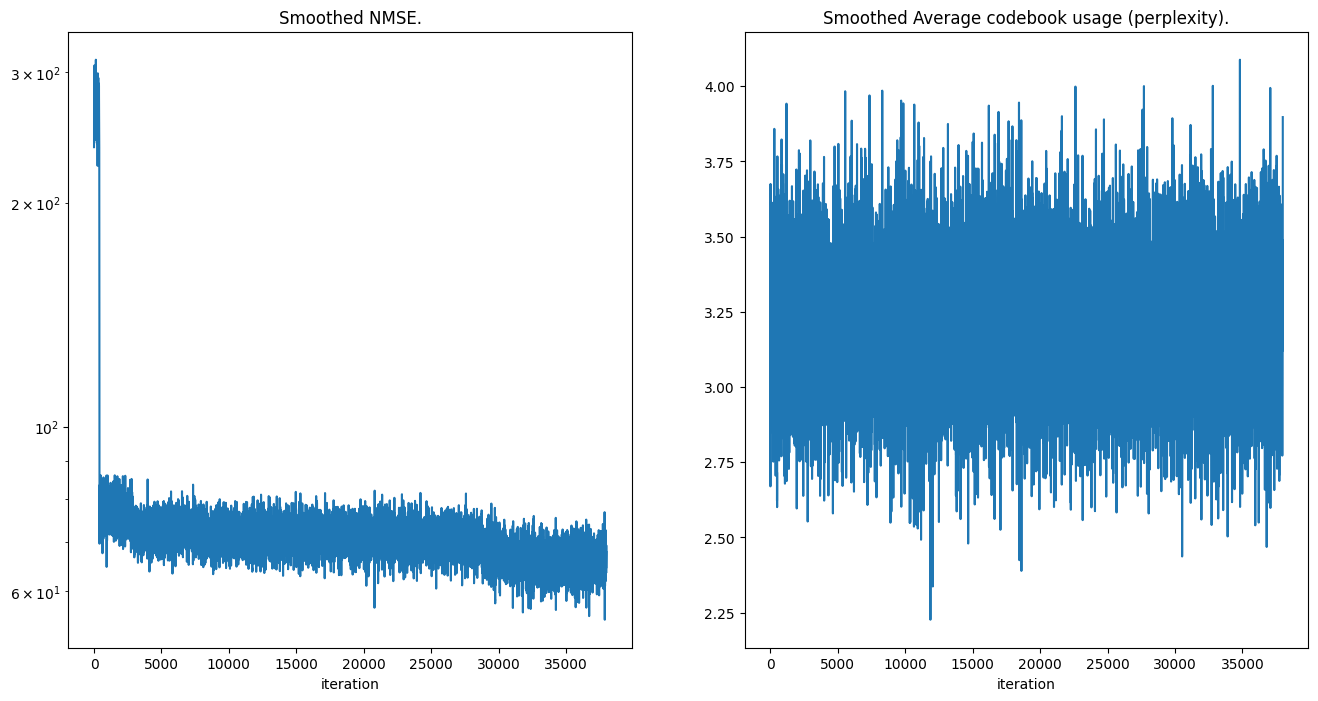

In [32]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

### Visualizing the results


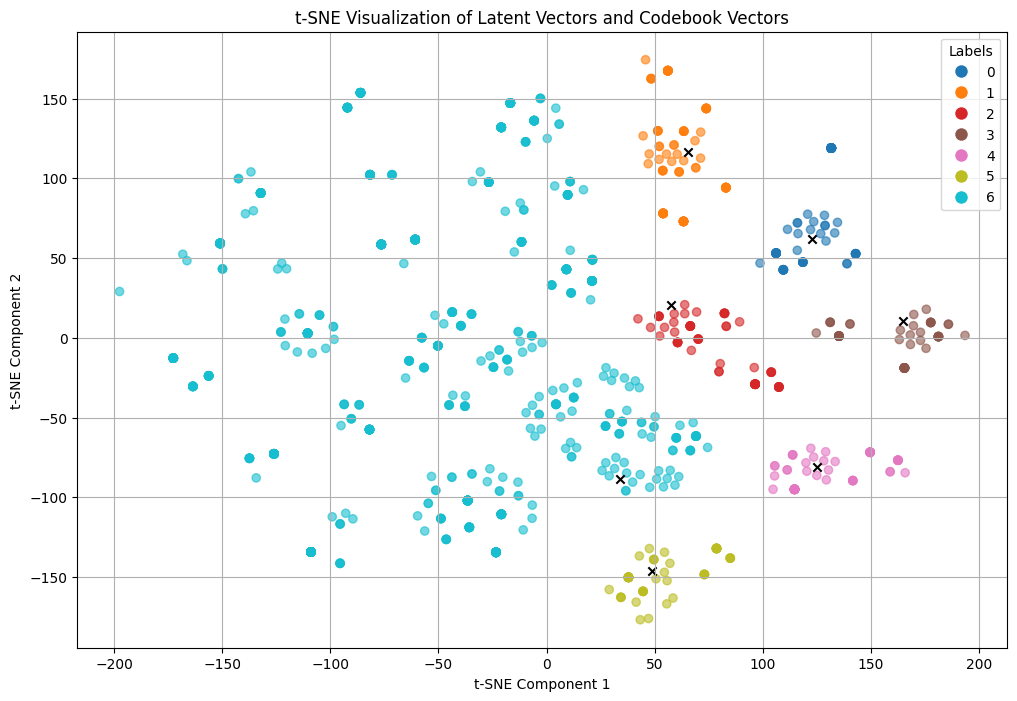

In [33]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def encode_points(model, data, labels):
    model.eval()
    with torch.no_grad():
        z = model.encoder(data.to(device))  # Encode data points
        _, quantized_z, _, _ = model.quantizer(z, labels.to(device))  # Quantize the encoded vectors
    return quantized_z

# Function to perform t-SNE and plot the results
def plot_with_tsne(latent_vectors, labels, codebook_vectors):
    tsne = TSNE(n_components=2, random_state=42)
    all_vectors = np.vstack([latent_vectors, codebook_vectors])  # Combine latent and codebook vectors
    all_vectors_2d = tsne.fit_transform(all_vectors)

    latent_vectors_2d = all_vectors_2d[:-len(codebook_vectors)]
    codebook_vectors_2d = all_vectors_2d[-len(codebook_vectors):]

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.scatter(codebook_vectors_2d[:, 0], codebook_vectors_2d[:, 1], color='black', marker='x')  # Codebook vectors in black

    # Create a legend for the labels
    unique_labels = np.unique(labels)
    colors = scatter.cmap(np.linspace(0, 1, len(unique_labels)))
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=str(int(label)), markersize=10, markerfacecolor=color) for label, color in zip(unique_labels, colors)]
    plt.legend(handles=legend_handles, title='Labels')

    plt.title('t-SNE Visualization of Latent Vectors and Codebook Vectors')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

# Encode the data points
quantized_z = encode_points(model, data, labels)

# Get codebook vectors from the quantizer
codebook_vectors = model.quantizer.embeddings.weight.data.cpu().numpy()

# Plot using t-SNE
plot_with_tsne(quantized_z.cpu().numpy(), labels.cpu().numpy(), codebook_vectors)


### Computation graph construction

In [ ]:
import networkx as nx

# Pseudo-function to parse the data and extract the architecture parameters
def parse_architecture_data(data):
    # This function would parse the given data to extract the architecture parameters
    architecture_params = {
        "out_channel0": 117,
        "M": 1,
        "R": [9, 0, 0, 0, 0],
        "convblock": ['B', None, None, None, None],
        "widenfact": [4, None, None, None, None],
        "B": [11, None, None, None, None]
    }
    return architecture_params

# Function to create the computation graph based on the architecture
def create_computation_graph(architecture_params):
    G = nx.DiGraph()  # Create a directed graph

    # Create nodes for main blocks (M)
    for m in range(architecture_params['M']):
        main_block_name = f'M{m}'
        G.add_node(main_block_name, type='main_block')

        # Create nodes for residual blocks within each main block
        for r_index, r_value in enumerate(architecture_params['R']):
            if r_value > 0:  # Only if the residual block exists
                for r in range(r_value):
                    res_block_name = f'R{r_index+1}_{r}'
                    G.add_node(res_block_name, type='res_block')
                    # Connect the residual block to the main block
                    G.add_edge(main_block_name, res_block_name)

                    # Add conv blocks within each residual block
                    conv_block_type = architecture_params['convblock'][r_index]
                    if conv_block_type:
                        for b in range(architecture_params['B'][r_index]):
                            conv_block_name = f'{conv_block_type}{r_index+1}_{b}'
                            G.add_node(conv_block_name, type='conv_block')
                            # Connect the conv block to the residual block
                            G.add_edge(res_block_name, conv_block_name)

                            # Handle widening factor
                            widen_fact = architecture_params['widenfact'][r_index]
                            if widen_fact:
                                # Just represent the widen_fact as an attribute, no actual computation
                                G.nodes[conv_block_name]['widenfact'] = widen_fact

    return G


data = "This would be replaced with the actual data parsing logic"
architecture_params = parse_architecture_data(data)
computation_graph = create_computation_graph(architecture_params)

# visualize_computation_graph(computation_graph)

print(list(computation_graph.edges(data=True)))


[('M0', 'R1_0', {}), ('M0', 'R1_1', {}), ('M0', 'R1_2', {}), ('M0', 'R1_3', {}), ('M0', 'R1_4', {}), ('M0', 'R1_5', {}), ('M0', 'R1_6', {}), ('M0', 'R1_7', {}), ('M0', 'R1_8', {}), ('R1_0', 'B1_0', {}), ('R1_0', 'B1_1', {}), ('R1_0', 'B1_2', {}), ('R1_0', 'B1_3', {}), ('R1_0', 'B1_4', {}), ('R1_0', 'B1_5', {}), ('R1_0', 'B1_6', {}), ('R1_0', 'B1_7', {}), ('R1_0', 'B1_8', {}), ('R1_0', 'B1_9', {}), ('R1_0', 'B1_10', {}), ('R1_1', 'B1_0', {}), ('R1_1', 'B1_1', {}), ('R1_1', 'B1_2', {}), ('R1_1', 'B1_3', {}), ('R1_1', 'B1_4', {}), ('R1_1', 'B1_5', {}), ('R1_1', 'B1_6', {}), ('R1_1', 'B1_7', {}), ('R1_1', 'B1_8', {}), ('R1_1', 'B1_9', {}), ('R1_1', 'B1_10', {}), ('R1_2', 'B1_0', {}), ('R1_2', 'B1_1', {}), ('R1_2', 'B1_2', {}), ('R1_2', 'B1_3', {}), ('R1_2', 'B1_4', {}), ('R1_2', 'B1_5', {}), ('R1_2', 'B1_6', {}), ('R1_2', 'B1_7', {}), ('R1_2', 'B1_8', {}), ('R1_2', 'B1_9', {}), ('R1_2', 'B1_10', {}), ('R1_3', 'B1_0', {}), ('R1_3', 'B1_1', {}), ('R1_3', 'B1_2', {}), ('R1_3', 'B1_3', {}), ('

### Autoencoder Model

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self,x_dim,embed_dim=10,dropout=0.2,num_embeddings=50,h_nodes=128,scale=2,num_layers=1):
    super(AutoEncoder,self).__init__()
    self.encoder = Encoder(x_dim,embed_dim,dropout=dropout,h_nodes=h_nodes,scale=scale,num_layers=num_layers)
    self.decoder = Decoder(x_dim,embed_dim,h_nodes=h_nodes,dropout=dropout,scale=scale,num_layers=num_layers)

  def forward(self,x):
    z = self.encoder(x)
    x_recon = self.decoder(z)
    return x_recon

In [ ]:
x_dim = data.shape[1]
h_nodes = 128
scale = 2
num_layers = 3
embed_dim = 10
dropout = 0.2
epochs = 500
learning_rate = 1e-4
weight_decay = 1e-3
batch_size = 16

In [ ]:
train_loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

In [ ]:
model = AutoEncoder(x_dim,embed_dim,dropout=dropout,num_embeddings=num_embeddings,
                h_nodes=h_nodes,scale=scale,num_layers=num_layers).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)

In [ ]:
model.train()
train_res_recon_error = []

for epoch in tqdm(range(epochs)):

  for i, batch in enumerate(train_loader):  # Iterate over all batches in the dataset
    batch_x,batch_y = batch
    batch_x = batch_x.to(device)
    optimizer.zero_grad()

    noise = torch.rand(batch_x.size()).to(device)
    data_recon = model(batch_x)
    recon_error = F.mse_loss(data_recon, batch_x)
    loss = recon_error
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())

    if (i+1) % 10 == 0:
      print('%d iterations of epochs %d/%d' % (i+1,epoch + 1, epochs))
      print('Average recon_error: %.3f' % np.mean(train_res_recon_error[-10:]))
      print()


  0%|          | 0/500 [00:00<?, ?it/s]

10 iterations of epochs 1/500
Average recon_error: 270.693

20 iterations of epochs 1/500
Average recon_error: 279.939

30 iterations of epochs 1/500
Average recon_error: 276.305

40 iterations of epochs 1/500
Average recon_error: 269.316

50 iterations of epochs 1/500
Average recon_error: 279.527

60 iterations of epochs 1/500
Average recon_error: 280.093



  0%|          | 1/500 [00:00<02:37,  3.16it/s]

70 iterations of epochs 1/500
Average recon_error: 273.068

10 iterations of epochs 2/500
Average recon_error: 274.020

20 iterations of epochs 2/500
Average recon_error: 223.874

30 iterations of epochs 2/500
Average recon_error: 154.003

40 iterations of epochs 2/500
Average recon_error: 129.244



  0%|          | 2/500 [00:00<02:37,  3.16it/s]

50 iterations of epochs 2/500
Average recon_error: 82.580

60 iterations of epochs 2/500
Average recon_error: 43.879

70 iterations of epochs 2/500
Average recon_error: 25.962

10 iterations of epochs 3/500
Average recon_error: 17.431

20 iterations of epochs 3/500
Average recon_error: 16.097



  1%|          | 3/500 [00:00<02:36,  3.18it/s]

30 iterations of epochs 3/500
Average recon_error: 13.618

40 iterations of epochs 3/500
Average recon_error: 13.657

50 iterations of epochs 3/500
Average recon_error: 13.843

60 iterations of epochs 3/500
Average recon_error: 13.826

70 iterations of epochs 3/500
Average recon_error: 15.483

10 iterations of epochs 4/500
Average recon_error: 14.351

20 iterations of epochs 4/500
Average recon_error: 14.798

30 iterations of epochs 4/500
Average recon_error: 14.588

40 iterations of epochs 4/500
Average recon_error: 13.186

50 iterations of epochs 4/500
Average recon_error: 15.589



  1%|          | 4/500 [00:01<02:35,  3.18it/s]

60 iterations of epochs 4/500
Average recon_error: 13.577

70 iterations of epochs 4/500
Average recon_error: 14.162

10 iterations of epochs 5/500
Average recon_error: 14.766

20 iterations of epochs 5/500
Average recon_error: 13.273

30 iterations of epochs 5/500
Average recon_error: 14.335



  1%|          | 5/500 [00:01<02:35,  3.18it/s]

40 iterations of epochs 5/500
Average recon_error: 13.228

50 iterations of epochs 5/500
Average recon_error: 14.047

60 iterations of epochs 5/500
Average recon_error: 14.633

70 iterations of epochs 5/500
Average recon_error: 14.405

10 iterations of epochs 6/500
Average recon_error: 14.446

20 iterations of epochs 6/500
Average recon_error: 14.035

30 iterations of epochs 6/500
Average recon_error: 14.722

40 iterations of epochs 6/500
Average recon_error: 13.217

50 iterations of epochs 6/500
Average recon_error: 14.582

60 iterations of epochs 6/500
Average recon_error: 13.421



  1%|          | 6/500 [00:01<02:34,  3.19it/s]

70 iterations of epochs 6/500
Average recon_error: 14.955

10 iterations of epochs 7/500
Average recon_error: 14.364

20 iterations of epochs 7/500
Average recon_error: 14.458

30 iterations of epochs 7/500
Average recon_error: 14.506

40 iterations of epochs 7/500
Average recon_error: 13.614



  1%|▏         | 7/500 [00:02<02:33,  3.21it/s]

50 iterations of epochs 7/500
Average recon_error: 13.408

60 iterations of epochs 7/500
Average recon_error: 13.880

70 iterations of epochs 7/500
Average recon_error: 14.255

10 iterations of epochs 8/500
Average recon_error: 14.926

20 iterations of epochs 8/500
Average recon_error: 14.040



  2%|▏         | 8/500 [00:02<02:34,  3.17it/s]

30 iterations of epochs 8/500
Average recon_error: 13.711

40 iterations of epochs 8/500
Average recon_error: 14.258

50 iterations of epochs 8/500
Average recon_error: 13.986

60 iterations of epochs 8/500
Average recon_error: 13.484

70 iterations of epochs 8/500
Average recon_error: 15.128

10 iterations of epochs 9/500
Average recon_error: 13.850

20 iterations of epochs 9/500
Average recon_error: 14.337

30 iterations of epochs 9/500
Average recon_error: 13.956

40 iterations of epochs 9/500
Average recon_error: 13.743

50 iterations of epochs 9/500
Average recon_error: 14.110

60 iterations of epochs 9/500
Average recon_error: 14.867



  2%|▏         | 9/500 [00:02<02:33,  3.19it/s]

70 iterations of epochs 9/500
Average recon_error: 14.610

10 iterations of epochs 10/500
Average recon_error: 13.511

20 iterations of epochs 10/500
Average recon_error: 13.785

30 iterations of epochs 10/500
Average recon_error: 14.243

40 iterations of epochs 10/500
Average recon_error: 14.007



  2%|▏         | 10/500 [00:03<02:33,  3.20it/s]

50 iterations of epochs 10/500
Average recon_error: 13.822

60 iterations of epochs 10/500
Average recon_error: 13.708

70 iterations of epochs 10/500
Average recon_error: 15.308

10 iterations of epochs 11/500
Average recon_error: 13.509

20 iterations of epochs 11/500
Average recon_error: 13.377

30 iterations of epochs 11/500
Average recon_error: 14.412

40 iterations of epochs 11/500
Average recon_error: 15.084

50 iterations of epochs 11/500
Average recon_error: 14.377

60 iterations of epochs 11/500
Average recon_error: 14.107

70 iterations of epochs 11/500
Average recon_error: 14.400



  2%|▏         | 11/500 [00:03<02:35,  3.15it/s]

10 iterations of epochs 12/500
Average recon_error: 14.386

20 iterations of epochs 12/500
Average recon_error: 14.696

30 iterations of epochs 12/500
Average recon_error: 14.990

40 iterations of epochs 12/500
Average recon_error: 12.933

50 iterations of epochs 12/500
Average recon_error: 13.751



  2%|▏         | 12/500 [00:03<02:36,  3.13it/s]

60 iterations of epochs 12/500
Average recon_error: 14.188

70 iterations of epochs 12/500
Average recon_error: 14.501

10 iterations of epochs 13/500
Average recon_error: 14.675

20 iterations of epochs 13/500
Average recon_error: 13.789

30 iterations of epochs 13/500
Average recon_error: 12.723

40 iterations of epochs 13/500
Average recon_error: 14.285

50 iterations of epochs 13/500
Average recon_error: 15.032

60 iterations of epochs 13/500
Average recon_error: 14.211



  3%|▎         | 13/500 [00:04<02:49,  2.87it/s]

70 iterations of epochs 13/500
Average recon_error: 14.484

10 iterations of epochs 14/500
Average recon_error: 14.644

20 iterations of epochs 14/500
Average recon_error: 13.910

30 iterations of epochs 14/500
Average recon_error: 14.712

40 iterations of epochs 14/500
Average recon_error: 13.191

50 iterations of epochs 14/500
Average recon_error: 15.629

60 iterations of epochs 14/500
Average recon_error: 13.595



  3%|▎         | 14/500 [00:04<03:00,  2.70it/s]

70 iterations of epochs 14/500
Average recon_error: 13.624

10 iterations of epochs 15/500
Average recon_error: 14.794

20 iterations of epochs 15/500
Average recon_error: 13.292

30 iterations of epochs 15/500
Average recon_error: 14.223



  3%|▎         | 15/500 [00:05<03:02,  2.66it/s]

40 iterations of epochs 15/500
Average recon_error: 14.193

50 iterations of epochs 15/500
Average recon_error: 13.547

60 iterations of epochs 15/500
Average recon_error: 14.156

70 iterations of epochs 15/500
Average recon_error: 14.690

10 iterations of epochs 16/500
Average recon_error: 14.868

20 iterations of epochs 16/500
Average recon_error: 13.850

30 iterations of epochs 16/500
Average recon_error: 14.816

40 iterations of epochs 16/500
Average recon_error: 13.370



  3%|▎         | 16/500 [00:05<03:10,  2.54it/s]

50 iterations of epochs 16/500
Average recon_error: 13.355

60 iterations of epochs 16/500
Average recon_error: 15.189

70 iterations of epochs 16/500
Average recon_error: 13.896

10 iterations of epochs 17/500
Average recon_error: 13.968

20 iterations of epochs 17/500
Average recon_error: 14.017

30 iterations of epochs 17/500
Average recon_error: 14.331

40 iterations of epochs 17/500
Average recon_error: 13.872



  3%|▎         | 17/500 [00:05<03:17,  2.44it/s]

50 iterations of epochs 17/500
Average recon_error: 13.805

60 iterations of epochs 17/500
Average recon_error: 13.403

70 iterations of epochs 17/500
Average recon_error: 15.319

10 iterations of epochs 18/500
Average recon_error: 13.917

20 iterations of epochs 18/500
Average recon_error: 12.866

30 iterations of epochs 18/500
Average recon_error: 13.991

40 iterations of epochs 18/500
Average recon_error: 14.355

50 iterations of epochs 18/500
Average recon_error: 14.660

60 iterations of epochs 18/500
Average recon_error: 14.896



  4%|▎         | 18/500 [00:06<03:07,  2.57it/s]

70 iterations of epochs 18/500
Average recon_error: 13.983

10 iterations of epochs 19/500
Average recon_error: 13.391

20 iterations of epochs 19/500
Average recon_error: 15.012

30 iterations of epochs 19/500
Average recon_error: 14.428

40 iterations of epochs 19/500
Average recon_error: 15.057



  4%|▍         | 19/500 [00:06<02:56,  2.73it/s]

50 iterations of epochs 19/500
Average recon_error: 13.535

60 iterations of epochs 19/500
Average recon_error: 14.612

70 iterations of epochs 19/500
Average recon_error: 13.731

10 iterations of epochs 20/500
Average recon_error: 12.531

20 iterations of epochs 20/500
Average recon_error: 14.423



  4%|▍         | 20/500 [00:06<02:48,  2.85it/s]

30 iterations of epochs 20/500
Average recon_error: 14.945

40 iterations of epochs 20/500
Average recon_error: 14.044

50 iterations of epochs 20/500
Average recon_error: 14.362

60 iterations of epochs 20/500
Average recon_error: 14.836

70 iterations of epochs 20/500
Average recon_error: 13.489

10 iterations of epochs 21/500
Average recon_error: 15.210

20 iterations of epochs 21/500
Average recon_error: 13.480

30 iterations of epochs 21/500
Average recon_error: 13.428

40 iterations of epochs 21/500
Average recon_error: 14.095

50 iterations of epochs 21/500
Average recon_error: 14.548



  4%|▍         | 21/500 [00:07<02:43,  2.94it/s]

60 iterations of epochs 21/500
Average recon_error: 14.253

70 iterations of epochs 21/500
Average recon_error: 13.928

10 iterations of epochs 22/500
Average recon_error: 13.353

20 iterations of epochs 22/500
Average recon_error: 14.183

30 iterations of epochs 22/500
Average recon_error: 13.977



  4%|▍         | 22/500 [00:07<02:38,  3.01it/s]

40 iterations of epochs 22/500
Average recon_error: 14.418

50 iterations of epochs 22/500
Average recon_error: 13.911

60 iterations of epochs 22/500
Average recon_error: 13.653

70 iterations of epochs 22/500
Average recon_error: 14.150

10 iterations of epochs 23/500
Average recon_error: 13.070

20 iterations of epochs 23/500
Average recon_error: 14.113

30 iterations of epochs 23/500
Average recon_error: 13.478

40 iterations of epochs 23/500
Average recon_error: 14.825

50 iterations of epochs 23/500
Average recon_error: 14.026

60 iterations of epochs 23/500
Average recon_error: 14.607



  5%|▍         | 23/500 [00:07<02:38,  3.01it/s]

70 iterations of epochs 23/500
Average recon_error: 14.115

10 iterations of epochs 24/500
Average recon_error: 15.077

20 iterations of epochs 24/500
Average recon_error: 13.354

30 iterations of epochs 24/500
Average recon_error: 14.535

40 iterations of epochs 24/500
Average recon_error: 14.171



  5%|▍         | 24/500 [00:08<02:36,  3.05it/s]

50 iterations of epochs 24/500
Average recon_error: 14.262

60 iterations of epochs 24/500
Average recon_error: 13.817

70 iterations of epochs 24/500
Average recon_error: 14.073

10 iterations of epochs 25/500
Average recon_error: 13.915

20 iterations of epochs 25/500
Average recon_error: 14.264



  5%|▌         | 25/500 [00:08<02:35,  3.05it/s]

30 iterations of epochs 25/500
Average recon_error: 14.653

40 iterations of epochs 25/500
Average recon_error: 13.919

50 iterations of epochs 25/500
Average recon_error: 14.048

60 iterations of epochs 25/500
Average recon_error: 13.770

70 iterations of epochs 25/500
Average recon_error: 14.574

10 iterations of epochs 26/500
Average recon_error: 12.696

20 iterations of epochs 26/500
Average recon_error: 13.885

30 iterations of epochs 26/500
Average recon_error: 14.383

40 iterations of epochs 26/500
Average recon_error: 14.098

50 iterations of epochs 26/500
Average recon_error: 13.835



  5%|▌         | 26/500 [00:08<02:37,  3.02it/s]

60 iterations of epochs 26/500
Average recon_error: 14.768

70 iterations of epochs 26/500
Average recon_error: 14.219

10 iterations of epochs 27/500
Average recon_error: 14.916

20 iterations of epochs 27/500
Average recon_error: 14.172

30 iterations of epochs 27/500
Average recon_error: 13.148



  5%|▌         | 27/500 [00:09<02:34,  3.07it/s]

40 iterations of epochs 27/500
Average recon_error: 14.016

50 iterations of epochs 27/500
Average recon_error: 14.597

60 iterations of epochs 27/500
Average recon_error: 14.056

70 iterations of epochs 27/500
Average recon_error: 13.643

10 iterations of epochs 28/500
Average recon_error: 12.593

20 iterations of epochs 28/500
Average recon_error: 14.212

30 iterations of epochs 28/500
Average recon_error: 14.438

40 iterations of epochs 28/500
Average recon_error: 14.328

50 iterations of epochs 28/500
Average recon_error: 14.417

60 iterations of epochs 28/500
Average recon_error: 14.066



  6%|▌         | 28/500 [00:09<02:34,  3.06it/s]

70 iterations of epochs 28/500
Average recon_error: 14.755

10 iterations of epochs 29/500
Average recon_error: 14.609

20 iterations of epochs 29/500
Average recon_error: 14.006

30 iterations of epochs 29/500
Average recon_error: 13.305

40 iterations of epochs 29/500
Average recon_error: 13.874



  6%|▌         | 29/500 [00:09<02:33,  3.07it/s]

50 iterations of epochs 29/500
Average recon_error: 14.745

60 iterations of epochs 29/500
Average recon_error: 13.531

70 iterations of epochs 29/500
Average recon_error: 14.451

10 iterations of epochs 30/500
Average recon_error: 14.540

20 iterations of epochs 30/500
Average recon_error: 14.165



  6%|▌         | 30/500 [00:10<02:34,  3.05it/s]

30 iterations of epochs 30/500
Average recon_error: 13.364

40 iterations of epochs 30/500
Average recon_error: 14.509

50 iterations of epochs 30/500
Average recon_error: 13.990

60 iterations of epochs 30/500
Average recon_error: 13.076

70 iterations of epochs 30/500
Average recon_error: 14.392

10 iterations of epochs 31/500
Average recon_error: 14.486

20 iterations of epochs 31/500
Average recon_error: 15.573

30 iterations of epochs 31/500
Average recon_error: 12.896

40 iterations of epochs 31/500
Average recon_error: 14.040

50 iterations of epochs 31/500
Average recon_error: 13.208



  6%|▌         | 31/500 [00:10<02:35,  3.01it/s]

60 iterations of epochs 31/500
Average recon_error: 13.695

70 iterations of epochs 31/500
Average recon_error: 14.075

10 iterations of epochs 32/500
Average recon_error: 14.025

20 iterations of epochs 32/500
Average recon_error: 13.991

30 iterations of epochs 32/500
Average recon_error: 14.972



  6%|▋         | 32/500 [00:10<02:35,  3.01it/s]

40 iterations of epochs 32/500
Average recon_error: 13.729

50 iterations of epochs 32/500
Average recon_error: 13.691

60 iterations of epochs 32/500
Average recon_error: 13.485

70 iterations of epochs 32/500
Average recon_error: 14.022

10 iterations of epochs 33/500
Average recon_error: 14.048

20 iterations of epochs 33/500
Average recon_error: 14.303

30 iterations of epochs 33/500
Average recon_error: 13.222

40 iterations of epochs 33/500
Average recon_error: 13.707

50 iterations of epochs 33/500
Average recon_error: 14.257



  7%|▋         | 33/500 [00:11<02:33,  3.04it/s]

60 iterations of epochs 33/500
Average recon_error: 13.877

70 iterations of epochs 33/500
Average recon_error: 14.536

10 iterations of epochs 34/500
Average recon_error: 13.886

20 iterations of epochs 34/500
Average recon_error: 13.424

30 iterations of epochs 34/500
Average recon_error: 14.714



  7%|▋         | 34/500 [00:11<02:31,  3.08it/s]

40 iterations of epochs 34/500
Average recon_error: 13.557

50 iterations of epochs 34/500
Average recon_error: 13.566

60 iterations of epochs 34/500
Average recon_error: 14.548

70 iterations of epochs 34/500
Average recon_error: 14.306

10 iterations of epochs 35/500
Average recon_error: 14.258

20 iterations of epochs 35/500
Average recon_error: 13.477

30 iterations of epochs 35/500
Average recon_error: 15.299

40 iterations of epochs 35/500
Average recon_error: 13.687

50 iterations of epochs 35/500
Average recon_error: 13.981

60 iterations of epochs 35/500
Average recon_error: 14.090



  7%|▋         | 35/500 [00:11<02:30,  3.08it/s]

70 iterations of epochs 35/500
Average recon_error: 13.863

10 iterations of epochs 36/500
Average recon_error: 12.930

20 iterations of epochs 36/500
Average recon_error: 13.596

30 iterations of epochs 36/500
Average recon_error: 14.541

40 iterations of epochs 36/500
Average recon_error: 14.613



  7%|▋         | 36/500 [00:12<02:29,  3.10it/s]

50 iterations of epochs 36/500
Average recon_error: 15.588

60 iterations of epochs 36/500
Average recon_error: 13.498

70 iterations of epochs 36/500
Average recon_error: 13.871

10 iterations of epochs 37/500
Average recon_error: 14.420

20 iterations of epochs 37/500
Average recon_error: 14.664



  7%|▋         | 37/500 [00:12<02:28,  3.11it/s]

30 iterations of epochs 37/500
Average recon_error: 13.935

40 iterations of epochs 37/500
Average recon_error: 14.205

50 iterations of epochs 37/500
Average recon_error: 13.793

60 iterations of epochs 37/500
Average recon_error: 13.367

70 iterations of epochs 37/500
Average recon_error: 13.800

10 iterations of epochs 38/500
Average recon_error: 14.695

20 iterations of epochs 38/500
Average recon_error: 14.123

30 iterations of epochs 38/500
Average recon_error: 13.114

40 iterations of epochs 38/500
Average recon_error: 13.307

50 iterations of epochs 38/500
Average recon_error: 14.637



  8%|▊         | 38/500 [00:12<02:27,  3.13it/s]

60 iterations of epochs 38/500
Average recon_error: 14.959

70 iterations of epochs 38/500
Average recon_error: 13.988

10 iterations of epochs 39/500
Average recon_error: 14.610

20 iterations of epochs 39/500
Average recon_error: 13.416

30 iterations of epochs 39/500
Average recon_error: 14.144



  8%|▊         | 39/500 [00:13<02:27,  3.12it/s]

40 iterations of epochs 39/500
Average recon_error: 15.192

50 iterations of epochs 39/500
Average recon_error: 13.533

60 iterations of epochs 39/500
Average recon_error: 14.428

70 iterations of epochs 39/500
Average recon_error: 13.801

10 iterations of epochs 40/500
Average recon_error: 14.033

20 iterations of epochs 40/500
Average recon_error: 13.352

30 iterations of epochs 40/500
Average recon_error: 13.533

40 iterations of epochs 40/500
Average recon_error: 14.798

50 iterations of epochs 40/500
Average recon_error: 14.199

60 iterations of epochs 40/500
Average recon_error: 14.197



  8%|▊         | 40/500 [00:13<02:27,  3.12it/s]

70 iterations of epochs 40/500
Average recon_error: 13.804

10 iterations of epochs 41/500
Average recon_error: 13.239

20 iterations of epochs 41/500
Average recon_error: 12.875

30 iterations of epochs 41/500
Average recon_error: 15.464

40 iterations of epochs 41/500
Average recon_error: 14.255



  8%|▊         | 41/500 [00:13<02:26,  3.14it/s]

50 iterations of epochs 41/500
Average recon_error: 14.643

60 iterations of epochs 41/500
Average recon_error: 13.740

70 iterations of epochs 41/500
Average recon_error: 13.618

10 iterations of epochs 42/500
Average recon_error: 14.181

20 iterations of epochs 42/500
Average recon_error: 14.116



  8%|▊         | 42/500 [00:13<02:26,  3.13it/s]

30 iterations of epochs 42/500
Average recon_error: 14.096

40 iterations of epochs 42/500
Average recon_error: 13.652

50 iterations of epochs 42/500
Average recon_error: 13.152

60 iterations of epochs 42/500
Average recon_error: 14.395

70 iterations of epochs 42/500
Average recon_error: 14.299

10 iterations of epochs 43/500
Average recon_error: 13.709

20 iterations of epochs 43/500
Average recon_error: 14.259

30 iterations of epochs 43/500
Average recon_error: 13.299

40 iterations of epochs 43/500
Average recon_error: 14.545

50 iterations of epochs 43/500
Average recon_error: 14.649



  9%|▊         | 43/500 [00:14<02:25,  3.14it/s]

60 iterations of epochs 43/500
Average recon_error: 14.509

70 iterations of epochs 43/500
Average recon_error: 12.985

10 iterations of epochs 44/500
Average recon_error: 13.958

20 iterations of epochs 44/500
Average recon_error: 14.704

30 iterations of epochs 44/500
Average recon_error: 13.091



  9%|▉         | 44/500 [00:14<02:25,  3.13it/s]

40 iterations of epochs 44/500
Average recon_error: 14.422

50 iterations of epochs 44/500
Average recon_error: 14.031

60 iterations of epochs 44/500
Average recon_error: 13.229

70 iterations of epochs 44/500
Average recon_error: 14.043

10 iterations of epochs 45/500
Average recon_error: 14.167

20 iterations of epochs 45/500
Average recon_error: 14.585

30 iterations of epochs 45/500
Average recon_error: 13.396

40 iterations of epochs 45/500
Average recon_error: 14.058

50 iterations of epochs 45/500
Average recon_error: 13.428

60 iterations of epochs 45/500
Average recon_error: 13.984



  9%|▉         | 45/500 [00:14<02:26,  3.11it/s]

70 iterations of epochs 45/500
Average recon_error: 13.969

10 iterations of epochs 46/500
Average recon_error: 14.124

20 iterations of epochs 46/500
Average recon_error: 13.937

30 iterations of epochs 46/500
Average recon_error: 13.396

40 iterations of epochs 46/500
Average recon_error: 13.623



  9%|▉         | 46/500 [00:15<02:25,  3.13it/s]

50 iterations of epochs 46/500
Average recon_error: 14.441

60 iterations of epochs 46/500
Average recon_error: 14.353

70 iterations of epochs 46/500
Average recon_error: 13.252

10 iterations of epochs 47/500
Average recon_error: 13.845

20 iterations of epochs 47/500
Average recon_error: 14.290



  9%|▉         | 47/500 [00:15<02:24,  3.14it/s]

30 iterations of epochs 47/500
Average recon_error: 14.181

40 iterations of epochs 47/500
Average recon_error: 13.814

50 iterations of epochs 47/500
Average recon_error: 13.555

60 iterations of epochs 47/500
Average recon_error: 14.505

70 iterations of epochs 47/500
Average recon_error: 13.594

10 iterations of epochs 48/500
Average recon_error: 13.889

20 iterations of epochs 48/500
Average recon_error: 13.809

30 iterations of epochs 48/500
Average recon_error: 13.766

40 iterations of epochs 48/500
Average recon_error: 13.966

50 iterations of epochs 48/500
Average recon_error: 14.217



 10%|▉         | 48/500 [00:15<02:32,  2.97it/s]

60 iterations of epochs 48/500
Average recon_error: 14.202

70 iterations of epochs 48/500
Average recon_error: 13.603

10 iterations of epochs 49/500
Average recon_error: 13.910

20 iterations of epochs 49/500
Average recon_error: 14.343

30 iterations of epochs 49/500
Average recon_error: 13.215

40 iterations of epochs 49/500
Average recon_error: 14.074

50 iterations of epochs 49/500
Average recon_error: 14.049



 10%|▉         | 49/500 [00:16<02:41,  2.79it/s]

60 iterations of epochs 49/500
Average recon_error: 14.116

70 iterations of epochs 49/500
Average recon_error: 14.156

10 iterations of epochs 50/500
Average recon_error: 14.680

20 iterations of epochs 50/500
Average recon_error: 13.642

30 iterations of epochs 50/500
Average recon_error: 14.320

40 iterations of epochs 50/500
Average recon_error: 13.381

50 iterations of epochs 50/500
Average recon_error: 13.999

60 iterations of epochs 50/500
Average recon_error: 13.413



 10%|█         | 50/500 [00:16<02:45,  2.72it/s]

70 iterations of epochs 50/500
Average recon_error: 14.164

10 iterations of epochs 51/500
Average recon_error: 13.416

20 iterations of epochs 51/500
Average recon_error: 14.965

30 iterations of epochs 51/500
Average recon_error: 14.135



 10%|█         | 51/500 [00:17<02:50,  2.63it/s]

40 iterations of epochs 51/500
Average recon_error: 13.615

50 iterations of epochs 51/500
Average recon_error: 13.286

60 iterations of epochs 51/500
Average recon_error: 14.636

70 iterations of epochs 51/500
Average recon_error: 13.979

10 iterations of epochs 52/500
Average recon_error: 14.347

20 iterations of epochs 52/500
Average recon_error: 14.455

30 iterations of epochs 52/500
Average recon_error: 13.769

40 iterations of epochs 52/500
Average recon_error: 13.747



 10%|█         | 52/500 [00:17<02:57,  2.52it/s]

50 iterations of epochs 52/500
Average recon_error: 13.219

60 iterations of epochs 52/500
Average recon_error: 14.202

70 iterations of epochs 52/500
Average recon_error: 14.257

10 iterations of epochs 53/500
Average recon_error: 13.383

20 iterations of epochs 53/500
Average recon_error: 14.356

30 iterations of epochs 53/500
Average recon_error: 14.173

40 iterations of epochs 53/500
Average recon_error: 13.013

50 iterations of epochs 53/500
Average recon_error: 14.678



 11%|█         | 53/500 [00:17<02:55,  2.55it/s]

60 iterations of epochs 53/500
Average recon_error: 14.144

70 iterations of epochs 53/500
Average recon_error: 13.427

10 iterations of epochs 54/500
Average recon_error: 13.656

20 iterations of epochs 54/500
Average recon_error: 14.501

30 iterations of epochs 54/500
Average recon_error: 13.963



 11%|█         | 54/500 [00:18<02:45,  2.69it/s]

40 iterations of epochs 54/500
Average recon_error: 15.134

50 iterations of epochs 54/500
Average recon_error: 12.955

60 iterations of epochs 54/500
Average recon_error: 13.896

70 iterations of epochs 54/500
Average recon_error: 14.016

10 iterations of epochs 55/500
Average recon_error: 13.864

20 iterations of epochs 55/500
Average recon_error: 14.288

30 iterations of epochs 55/500
Average recon_error: 13.748

40 iterations of epochs 55/500
Average recon_error: 14.149

50 iterations of epochs 55/500
Average recon_error: 14.679

60 iterations of epochs 55/500
Average recon_error: 14.673



 11%|█         | 55/500 [00:18<02:38,  2.81it/s]

70 iterations of epochs 55/500
Average recon_error: 13.038

10 iterations of epochs 56/500
Average recon_error: 13.628

20 iterations of epochs 56/500
Average recon_error: 13.768

30 iterations of epochs 56/500
Average recon_error: 14.132

40 iterations of epochs 56/500
Average recon_error: 14.526



 11%|█         | 56/500 [00:18<02:34,  2.87it/s]

50 iterations of epochs 56/500
Average recon_error: 13.222

60 iterations of epochs 56/500
Average recon_error: 13.877

70 iterations of epochs 56/500
Average recon_error: 14.061

10 iterations of epochs 57/500
Average recon_error: 13.471

20 iterations of epochs 57/500
Average recon_error: 14.655



 11%|█▏        | 57/500 [00:19<02:29,  2.96it/s]

30 iterations of epochs 57/500
Average recon_error: 13.068

40 iterations of epochs 57/500
Average recon_error: 13.816

50 iterations of epochs 57/500
Average recon_error: 14.307

60 iterations of epochs 57/500
Average recon_error: 14.364

70 iterations of epochs 57/500
Average recon_error: 13.712

10 iterations of epochs 58/500
Average recon_error: 12.613

20 iterations of epochs 58/500
Average recon_error: 14.376

30 iterations of epochs 58/500
Average recon_error: 14.229

40 iterations of epochs 58/500
Average recon_error: 14.190

50 iterations of epochs 58/500
Average recon_error: 13.749



 12%|█▏        | 58/500 [00:19<02:27,  3.00it/s]

60 iterations of epochs 58/500
Average recon_error: 13.592

70 iterations of epochs 58/500
Average recon_error: 14.836

10 iterations of epochs 59/500
Average recon_error: 14.951

20 iterations of epochs 59/500
Average recon_error: 13.521

30 iterations of epochs 59/500
Average recon_error: 13.631



 12%|█▏        | 59/500 [00:19<02:24,  3.05it/s]

40 iterations of epochs 59/500
Average recon_error: 14.104

50 iterations of epochs 59/500
Average recon_error: 14.117

60 iterations of epochs 59/500
Average recon_error: 13.734

70 iterations of epochs 59/500
Average recon_error: 13.428

10 iterations of epochs 60/500
Average recon_error: 14.479

20 iterations of epochs 60/500
Average recon_error: 13.703

30 iterations of epochs 60/500
Average recon_error: 13.144

40 iterations of epochs 60/500
Average recon_error: 15.147

50 iterations of epochs 60/500
Average recon_error: 13.366

60 iterations of epochs 60/500
Average recon_error: 13.536



 12%|█▏        | 60/500 [00:20<02:23,  3.06it/s]

70 iterations of epochs 60/500
Average recon_error: 13.612

10 iterations of epochs 61/500
Average recon_error: 14.991

20 iterations of epochs 61/500
Average recon_error: 13.524

30 iterations of epochs 61/500
Average recon_error: 12.989

40 iterations of epochs 61/500
Average recon_error: 13.578



 12%|█▏        | 61/500 [00:20<02:21,  3.10it/s]

50 iterations of epochs 61/500
Average recon_error: 13.838

60 iterations of epochs 61/500
Average recon_error: 14.861

70 iterations of epochs 61/500
Average recon_error: 13.224

10 iterations of epochs 62/500
Average recon_error: 13.278

20 iterations of epochs 62/500
Average recon_error: 14.818



 12%|█▏        | 62/500 [00:20<02:20,  3.11it/s]

30 iterations of epochs 62/500
Average recon_error: 13.471

40 iterations of epochs 62/500
Average recon_error: 13.475

50 iterations of epochs 62/500
Average recon_error: 13.602

60 iterations of epochs 62/500
Average recon_error: 14.474

70 iterations of epochs 62/500
Average recon_error: 14.269

10 iterations of epochs 63/500
Average recon_error: 14.793

20 iterations of epochs 63/500
Average recon_error: 14.622

30 iterations of epochs 63/500
Average recon_error: 13.481

40 iterations of epochs 63/500
Average recon_error: 13.158

50 iterations of epochs 63/500
Average recon_error: 13.951



 13%|█▎        | 63/500 [00:21<02:20,  3.10it/s]

60 iterations of epochs 63/500
Average recon_error: 14.207

70 iterations of epochs 63/500
Average recon_error: 13.417

10 iterations of epochs 64/500
Average recon_error: 13.312

20 iterations of epochs 64/500
Average recon_error: 13.859

30 iterations of epochs 64/500
Average recon_error: 15.167



 13%|█▎        | 64/500 [00:21<02:19,  3.11it/s]

40 iterations of epochs 64/500
Average recon_error: 13.259

50 iterations of epochs 64/500
Average recon_error: 13.901

60 iterations of epochs 64/500
Average recon_error: 13.057

70 iterations of epochs 64/500
Average recon_error: 13.799

10 iterations of epochs 65/500
Average recon_error: 13.803

20 iterations of epochs 65/500
Average recon_error: 13.540

30 iterations of epochs 65/500
Average recon_error: 13.603

40 iterations of epochs 65/500
Average recon_error: 13.298

50 iterations of epochs 65/500
Average recon_error: 13.432

60 iterations of epochs 65/500
Average recon_error: 13.236



 13%|█▎        | 65/500 [00:21<02:18,  3.14it/s]

70 iterations of epochs 65/500
Average recon_error: 14.119

10 iterations of epochs 66/500
Average recon_error: 13.149

20 iterations of epochs 66/500
Average recon_error: 13.667

30 iterations of epochs 66/500
Average recon_error: 14.442

40 iterations of epochs 66/500
Average recon_error: 14.554



 13%|█▎        | 66/500 [00:22<02:18,  3.12it/s]

50 iterations of epochs 66/500
Average recon_error: 14.100

60 iterations of epochs 66/500
Average recon_error: 12.666

70 iterations of epochs 66/500
Average recon_error: 13.518

10 iterations of epochs 67/500
Average recon_error: 13.821

20 iterations of epochs 67/500
Average recon_error: 13.518



 13%|█▎        | 67/500 [00:22<02:17,  3.15it/s]

30 iterations of epochs 67/500
Average recon_error: 12.972

40 iterations of epochs 67/500
Average recon_error: 13.996

50 iterations of epochs 67/500
Average recon_error: 13.570

60 iterations of epochs 67/500
Average recon_error: 13.589

70 iterations of epochs 67/500
Average recon_error: 13.282

10 iterations of epochs 68/500
Average recon_error: 14.016

20 iterations of epochs 68/500
Average recon_error: 14.239

30 iterations of epochs 68/500
Average recon_error: 12.804

40 iterations of epochs 68/500
Average recon_error: 14.018

50 iterations of epochs 68/500
Average recon_error: 13.496



 14%|█▎        | 68/500 [00:22<02:16,  3.16it/s]

60 iterations of epochs 68/500
Average recon_error: 13.606

70 iterations of epochs 68/500
Average recon_error: 13.316

10 iterations of epochs 69/500
Average recon_error: 14.289

20 iterations of epochs 69/500
Average recon_error: 12.664

30 iterations of epochs 69/500
Average recon_error: 13.584



 14%|█▍        | 69/500 [00:23<02:17,  3.14it/s]

40 iterations of epochs 69/500
Average recon_error: 13.535

50 iterations of epochs 69/500
Average recon_error: 13.591

60 iterations of epochs 69/500
Average recon_error: 13.550

70 iterations of epochs 69/500
Average recon_error: 14.091

10 iterations of epochs 70/500
Average recon_error: 14.048

20 iterations of epochs 70/500
Average recon_error: 13.602

30 iterations of epochs 70/500
Average recon_error: 13.530

40 iterations of epochs 70/500
Average recon_error: 14.130

50 iterations of epochs 70/500
Average recon_error: 13.881

60 iterations of epochs 70/500
Average recon_error: 13.865



 14%|█▍        | 70/500 [00:23<02:16,  3.15it/s]

70 iterations of epochs 70/500
Average recon_error: 13.060

10 iterations of epochs 71/500
Average recon_error: 13.410

20 iterations of epochs 71/500
Average recon_error: 13.598

30 iterations of epochs 71/500
Average recon_error: 12.704

40 iterations of epochs 71/500
Average recon_error: 13.954



 14%|█▍        | 71/500 [00:23<02:16,  3.15it/s]

50 iterations of epochs 71/500
Average recon_error: 14.289

60 iterations of epochs 71/500
Average recon_error: 13.592

70 iterations of epochs 71/500
Average recon_error: 13.056

10 iterations of epochs 72/500
Average recon_error: 13.247

20 iterations of epochs 72/500
Average recon_error: 13.484



 14%|█▍        | 72/500 [00:24<02:16,  3.14it/s]

30 iterations of epochs 72/500
Average recon_error: 14.021

40 iterations of epochs 72/500
Average recon_error: 13.172

50 iterations of epochs 72/500
Average recon_error: 14.060

60 iterations of epochs 72/500
Average recon_error: 13.190

70 iterations of epochs 72/500
Average recon_error: 14.115

10 iterations of epochs 73/500
Average recon_error: 13.743

20 iterations of epochs 73/500
Average recon_error: 13.460

30 iterations of epochs 73/500
Average recon_error: 14.477

40 iterations of epochs 73/500
Average recon_error: 13.294

50 iterations of epochs 73/500
Average recon_error: 13.488



 15%|█▍        | 73/500 [00:24<02:15,  3.15it/s]

60 iterations of epochs 73/500
Average recon_error: 13.708

70 iterations of epochs 73/500
Average recon_error: 13.253

10 iterations of epochs 74/500
Average recon_error: 12.825

20 iterations of epochs 74/500
Average recon_error: 13.906

30 iterations of epochs 74/500
Average recon_error: 13.765



 15%|█▍        | 74/500 [00:24<02:15,  3.15it/s]

40 iterations of epochs 74/500
Average recon_error: 13.299

50 iterations of epochs 74/500
Average recon_error: 13.629

60 iterations of epochs 74/500
Average recon_error: 14.083

70 iterations of epochs 74/500
Average recon_error: 13.398

10 iterations of epochs 75/500
Average recon_error: 13.438

20 iterations of epochs 75/500
Average recon_error: 13.361

30 iterations of epochs 75/500
Average recon_error: 13.377

40 iterations of epochs 75/500
Average recon_error: 13.398

50 iterations of epochs 75/500
Average recon_error: 13.510

60 iterations of epochs 75/500
Average recon_error: 14.230



 15%|█▌        | 75/500 [00:24<02:14,  3.17it/s]

70 iterations of epochs 75/500
Average recon_error: 13.951

10 iterations of epochs 76/500
Average recon_error: 13.528

20 iterations of epochs 76/500
Average recon_error: 13.834

30 iterations of epochs 76/500
Average recon_error: 13.577

40 iterations of epochs 76/500
Average recon_error: 13.142



 15%|█▌        | 76/500 [00:25<02:14,  3.16it/s]

50 iterations of epochs 76/500
Average recon_error: 13.292

60 iterations of epochs 76/500
Average recon_error: 14.192

70 iterations of epochs 76/500
Average recon_error: 13.311

10 iterations of epochs 77/500
Average recon_error: 13.265

20 iterations of epochs 77/500
Average recon_error: 13.040



 15%|█▌        | 77/500 [00:25<02:12,  3.18it/s]

30 iterations of epochs 77/500
Average recon_error: 13.443

40 iterations of epochs 77/500
Average recon_error: 14.555

50 iterations of epochs 77/500
Average recon_error: 13.408

60 iterations of epochs 77/500
Average recon_error: 13.613

70 iterations of epochs 77/500
Average recon_error: 13.187

10 iterations of epochs 78/500
Average recon_error: 12.936

20 iterations of epochs 78/500
Average recon_error: 13.205

30 iterations of epochs 78/500
Average recon_error: 12.701

40 iterations of epochs 78/500
Average recon_error: 14.952

50 iterations of epochs 78/500
Average recon_error: 13.157



 16%|█▌        | 78/500 [00:25<02:12,  3.18it/s]

60 iterations of epochs 78/500
Average recon_error: 13.737

70 iterations of epochs 78/500
Average recon_error: 14.037

10 iterations of epochs 79/500
Average recon_error: 13.350

20 iterations of epochs 79/500
Average recon_error: 14.216



 16%|█▌        | 79/500 [00:26<02:12,  3.17it/s]

30 iterations of epochs 79/500
Average recon_error: 13.800

40 iterations of epochs 79/500
Average recon_error: 12.922

50 iterations of epochs 79/500
Average recon_error: 13.218

60 iterations of epochs 79/500
Average recon_error: 12.968

70 iterations of epochs 79/500
Average recon_error: 13.596

10 iterations of epochs 80/500
Average recon_error: 12.921

20 iterations of epochs 80/500
Average recon_error: 12.803

30 iterations of epochs 80/500
Average recon_error: 13.399

40 iterations of epochs 80/500
Average recon_error: 12.238

50 iterations of epochs 80/500
Average recon_error: 11.441



 16%|█▌        | 80/500 [00:26<02:12,  3.16it/s]

60 iterations of epochs 80/500
Average recon_error: 11.007

70 iterations of epochs 80/500
Average recon_error: 10.635

10 iterations of epochs 81/500
Average recon_error: 9.712

20 iterations of epochs 81/500
Average recon_error: 8.780

30 iterations of epochs 81/500
Average recon_error: 8.576



 16%|█▌        | 81/500 [00:26<02:13,  3.15it/s]

40 iterations of epochs 81/500
Average recon_error: 8.649

50 iterations of epochs 81/500
Average recon_error: 8.302

60 iterations of epochs 81/500
Average recon_error: 8.700

70 iterations of epochs 81/500
Average recon_error: 8.852

10 iterations of epochs 82/500
Average recon_error: 8.108

20 iterations of epochs 82/500
Average recon_error: 7.641

30 iterations of epochs 82/500
Average recon_error: 8.650

40 iterations of epochs 82/500
Average recon_error: 8.672

50 iterations of epochs 82/500
Average recon_error: 8.297

60 iterations of epochs 82/500
Average recon_error: 7.599



 16%|█▋        | 82/500 [00:27<02:16,  3.07it/s]

70 iterations of epochs 82/500
Average recon_error: 8.185

10 iterations of epochs 83/500
Average recon_error: 8.587

20 iterations of epochs 83/500
Average recon_error: 8.009

30 iterations of epochs 83/500
Average recon_error: 7.875

40 iterations of epochs 83/500
Average recon_error: 8.023



 17%|█▋        | 83/500 [00:27<02:13,  3.13it/s]

50 iterations of epochs 83/500
Average recon_error: 8.096

60 iterations of epochs 83/500
Average recon_error: 7.414

70 iterations of epochs 83/500
Average recon_error: 7.152

10 iterations of epochs 84/500
Average recon_error: 8.199

20 iterations of epochs 84/500
Average recon_error: 7.617

30 iterations of epochs 84/500
Average recon_error: 7.704

40 iterations of epochs 84/500
Average recon_error: 7.562

50 iterations of epochs 84/500
Average recon_error: 7.643

60 iterations of epochs 84/500
Average recon_error: 8.249

70 iterations of epochs 84/500
Average recon_error: 7.654



 17%|█▋        | 84/500 [00:27<02:17,  3.03it/s]

10 iterations of epochs 85/500
Average recon_error: 7.837

20 iterations of epochs 85/500
Average recon_error: 7.969

30 iterations of epochs 85/500
Average recon_error: 7.775

40 iterations of epochs 85/500
Average recon_error: 7.950



 17%|█▋        | 85/500 [00:28<02:28,  2.80it/s]

50 iterations of epochs 85/500
Average recon_error: 7.900

60 iterations of epochs 85/500
Average recon_error: 7.503

70 iterations of epochs 85/500
Average recon_error: 7.707

10 iterations of epochs 86/500
Average recon_error: 7.998

20 iterations of epochs 86/500
Average recon_error: 7.465

30 iterations of epochs 86/500
Average recon_error: 7.869

40 iterations of epochs 86/500
Average recon_error: 7.476

50 iterations of epochs 86/500
Average recon_error: 7.554

60 iterations of epochs 86/500

 17%|█▋        | 86/500 [00:28<02:30,  2.75it/s]


Average recon_error: 7.492

70 iterations of epochs 86/500
Average recon_error: 8.124

10 iterations of epochs 87/500
Average recon_error: 8.638

20 iterations of epochs 87/500
Average recon_error: 6.755

30 iterations of epochs 87/500
Average recon_error: 7.684

40 iterations of epochs 87/500
Average recon_error: 8.034

50 iterations of epochs 87/500
Average recon_error: 6.964

60 iterations of epochs 87/500
Average recon_error: 8.041



 17%|█▋        | 87/500 [00:29<02:36,  2.64it/s]

70 iterations of epochs 87/500
Average recon_error: 7.164

10 iterations of epochs 88/500
Average recon_error: 7.768

20 iterations of epochs 88/500
Average recon_error: 7.538

30 iterations of epochs 88/500
Average recon_error: 7.575

40 iterations of epochs 88/500
Average recon_error: 7.824

50 iterations of epochs 88/500
Average recon_error: 7.661

60 iterations of epochs 88/500
Average recon_error: 7.666



 18%|█▊        | 88/500 [00:29<02:46,  2.48it/s]

70 iterations of epochs 88/500
Average recon_error: 7.345

10 iterations of epochs 89/500
Average recon_error: 6.860

20 iterations of epochs 89/500
Average recon_error: 7.688



 18%|█▊        | 89/500 [00:29<02:41,  2.54it/s]

30 iterations of epochs 89/500
Average recon_error: 7.639

40 iterations of epochs 89/500
Average recon_error: 7.722

50 iterations of epochs 89/500
Average recon_error: 8.114

60 iterations of epochs 89/500
Average recon_error: 7.840

70 iterations of epochs 89/500
Average recon_error: 7.581

10 iterations of epochs 90/500
Average recon_error: 7.660

20 iterations of epochs 90/500
Average recon_error: 7.722

30 iterations of epochs 90/500
Average recon_error: 7.988

40 iterations of epochs 90/500
Average recon_error: 7.181

50 iterations of epochs 90/500
Average recon_error: 7.766



 18%|█▊        | 90/500 [00:30<02:32,  2.69it/s]

60 iterations of epochs 90/500
Average recon_error: 7.192

70 iterations of epochs 90/500
Average recon_error: 7.674

10 iterations of epochs 91/500
Average recon_error: 8.304

20 iterations of epochs 91/500
Average recon_error: 7.497

30 iterations of epochs 91/500
Average recon_error: 7.620



 18%|█▊        | 91/500 [00:30<02:24,  2.82it/s]

40 iterations of epochs 91/500
Average recon_error: 7.218

50 iterations of epochs 91/500
Average recon_error: 7.836

60 iterations of epochs 91/500
Average recon_error: 7.575

70 iterations of epochs 91/500
Average recon_error: 7.651

10 iterations of epochs 92/500
Average recon_error: 7.304

20 iterations of epochs 92/500
Average recon_error: 7.411

30 iterations of epochs 92/500
Average recon_error: 7.837

40 iterations of epochs 92/500
Average recon_error: 7.398

50 iterations of epochs 92/500
Average recon_error: 7.389

60 iterations of epochs 92/500
Average recon_error: 7.368



 18%|█▊        | 92/500 [00:30<02:20,  2.91it/s]

70 iterations of epochs 92/500
Average recon_error: 7.766

10 iterations of epochs 93/500
Average recon_error: 7.478

20 iterations of epochs 93/500
Average recon_error: 7.934

30 iterations of epochs 93/500
Average recon_error: 7.859

40 iterations of epochs 93/500
Average recon_error: 7.888



 19%|█▊        | 93/500 [00:31<02:15,  3.00it/s]

50 iterations of epochs 93/500
Average recon_error: 7.515

60 iterations of epochs 93/500
Average recon_error: 7.081

70 iterations of epochs 93/500
Average recon_error: 7.179

10 iterations of epochs 94/500
Average recon_error: 7.665

20 iterations of epochs 94/500
Average recon_error: 7.496



 19%|█▉        | 94/500 [00:31<02:13,  3.04it/s]

30 iterations of epochs 94/500
Average recon_error: 7.710

40 iterations of epochs 94/500
Average recon_error: 7.198

50 iterations of epochs 94/500
Average recon_error: 7.577

60 iterations of epochs 94/500
Average recon_error: 7.372

70 iterations of epochs 94/500
Average recon_error: 7.835

10 iterations of epochs 95/500
Average recon_error: 6.989

20 iterations of epochs 95/500
Average recon_error: 7.865

30 iterations of epochs 95/500
Average recon_error: 7.504

40 iterations of epochs 95/500
Average recon_error: 7.733

50 iterations of epochs 95/500
Average recon_error: 8.190



 19%|█▉        | 95/500 [00:31<02:11,  3.07it/s]

60 iterations of epochs 95/500
Average recon_error: 7.333

70 iterations of epochs 95/500
Average recon_error: 7.039

10 iterations of epochs 96/500
Average recon_error: 7.441

20 iterations of epochs 96/500
Average recon_error: 7.454

30 iterations of epochs 96/500
Average recon_error: 7.370



 19%|█▉        | 96/500 [00:32<02:10,  3.10it/s]

40 iterations of epochs 96/500
Average recon_error: 7.482

50 iterations of epochs 96/500
Average recon_error: 6.990

60 iterations of epochs 96/500
Average recon_error: 8.010

70 iterations of epochs 96/500
Average recon_error: 7.534

10 iterations of epochs 97/500
Average recon_error: 6.835

20 iterations of epochs 97/500
Average recon_error: 7.459

30 iterations of epochs 97/500
Average recon_error: 7.515

40 iterations of epochs 97/500
Average recon_error: 6.949

50 iterations of epochs 97/500
Average recon_error: 7.429

60 iterations of epochs 97/500
Average recon_error: 7.467



 19%|█▉        | 97/500 [00:32<02:10,  3.09it/s]

70 iterations of epochs 97/500
Average recon_error: 7.277

10 iterations of epochs 98/500
Average recon_error: 7.020

20 iterations of epochs 98/500
Average recon_error: 6.995

30 iterations of epochs 98/500
Average recon_error: 7.139

40 iterations of epochs 98/500
Average recon_error: 7.438



 20%|█▉        | 98/500 [00:32<02:08,  3.13it/s]

50 iterations of epochs 98/500
Average recon_error: 7.661

60 iterations of epochs 98/500
Average recon_error: 7.408

70 iterations of epochs 98/500
Average recon_error: 7.258

10 iterations of epochs 99/500
Average recon_error: 7.314

20 iterations of epochs 99/500
Average recon_error: 7.244



 20%|█▉        | 99/500 [00:33<02:08,  3.13it/s]

30 iterations of epochs 99/500
Average recon_error: 7.312

40 iterations of epochs 99/500
Average recon_error: 7.492

50 iterations of epochs 99/500
Average recon_error: 6.959

60 iterations of epochs 99/500
Average recon_error: 6.885

70 iterations of epochs 99/500
Average recon_error: 7.665

10 iterations of epochs 100/500
Average recon_error: 7.237

20 iterations of epochs 100/500
Average recon_error: 6.886

30 iterations of epochs 100/500
Average recon_error: 7.134

40 iterations of epochs 100/500
Average recon_error: 7.452

50 iterations of epochs 100/500
Average recon_error: 7.030



 20%|██        | 100/500 [00:33<02:08,  3.10it/s]

60 iterations of epochs 100/500
Average recon_error: 7.370

70 iterations of epochs 100/500
Average recon_error: 7.559

10 iterations of epochs 101/500
Average recon_error: 7.058

20 iterations of epochs 101/500
Average recon_error: 7.162

30 iterations of epochs 101/500
Average recon_error: 6.838



 20%|██        | 101/500 [00:33<02:09,  3.09it/s]

40 iterations of epochs 101/500
Average recon_error: 7.087

50 iterations of epochs 101/500
Average recon_error: 7.407

60 iterations of epochs 101/500
Average recon_error: 7.744

70 iterations of epochs 101/500
Average recon_error: 7.322

10 iterations of epochs 102/500
Average recon_error: 6.534

20 iterations of epochs 102/500
Average recon_error: 7.442

30 iterations of epochs 102/500
Average recon_error: 7.241

40 iterations of epochs 102/500
Average recon_error: 7.071

50 iterations of epochs 102/500
Average recon_error: 7.509

60 iterations of epochs 102/500
Average recon_error: 7.199



 20%|██        | 102/500 [00:34<02:07,  3.12it/s]

70 iterations of epochs 102/500
Average recon_error: 7.320

10 iterations of epochs 103/500
Average recon_error: 7.141

20 iterations of epochs 103/500
Average recon_error: 6.793

30 iterations of epochs 103/500
Average recon_error: 6.730

40 iterations of epochs 103/500
Average recon_error: 7.253



 21%|██        | 103/500 [00:34<02:07,  3.12it/s]

50 iterations of epochs 103/500
Average recon_error: 7.458

60 iterations of epochs 103/500
Average recon_error: 7.297

70 iterations of epochs 103/500
Average recon_error: 7.253

10 iterations of epochs 104/500
Average recon_error: 6.846

20 iterations of epochs 104/500
Average recon_error: 7.636



 21%|██        | 104/500 [00:34<02:05,  3.14it/s]

30 iterations of epochs 104/500
Average recon_error: 7.135

40 iterations of epochs 104/500
Average recon_error: 6.908

50 iterations of epochs 104/500
Average recon_error: 7.567

60 iterations of epochs 104/500
Average recon_error: 6.865

70 iterations of epochs 104/500
Average recon_error: 7.378

10 iterations of epochs 105/500
Average recon_error: 7.074

20 iterations of epochs 105/500
Average recon_error: 7.606

30 iterations of epochs 105/500
Average recon_error: 7.155

40 iterations of epochs 105/500
Average recon_error: 7.040

50 iterations of epochs 105/500
Average recon_error: 6.671



 21%|██        | 105/500 [00:35<02:05,  3.15it/s]

60 iterations of epochs 105/500
Average recon_error: 7.123

70 iterations of epochs 105/500
Average recon_error: 7.246

10 iterations of epochs 106/500
Average recon_error: 7.073

20 iterations of epochs 106/500
Average recon_error: 7.072

30 iterations of epochs 106/500
Average recon_error: 7.078



 21%|██        | 106/500 [00:35<02:04,  3.16it/s]

40 iterations of epochs 106/500
Average recon_error: 7.154

50 iterations of epochs 106/500
Average recon_error: 7.142

60 iterations of epochs 106/500
Average recon_error: 7.294

70 iterations of epochs 106/500
Average recon_error: 7.282

10 iterations of epochs 107/500
Average recon_error: 7.180

20 iterations of epochs 107/500
Average recon_error: 6.983

30 iterations of epochs 107/500
Average recon_error: 6.778

40 iterations of epochs 107/500
Average recon_error: 7.487

50 iterations of epochs 107/500
Average recon_error: 6.983

60 iterations of epochs 107/500
Average recon_error: 7.040

70 iterations of epochs 107/500
Average recon_error: 7.883



 21%|██▏       | 107/500 [00:35<02:04,  3.17it/s]

10 iterations of epochs 108/500
Average recon_error: 7.310

20 iterations of epochs 108/500
Average recon_error: 7.100

30 iterations of epochs 108/500
Average recon_error: 6.773

40 iterations of epochs 108/500
Average recon_error: 6.927



 22%|██▏       | 108/500 [00:35<02:03,  3.16it/s]

50 iterations of epochs 108/500
Average recon_error: 6.638

60 iterations of epochs 108/500
Average recon_error: 6.595

70 iterations of epochs 108/500
Average recon_error: 7.054

10 iterations of epochs 109/500
Average recon_error: 6.883

20 iterations of epochs 109/500
Average recon_error: 6.421

30 iterations of epochs 109/500
Average recon_error: 6.306

40 iterations of epochs 109/500
Average recon_error: 6.263

50 iterations of epochs 109/500
Average recon_error: 6.900

60 iterations of epochs 109/500
Average recon_error: 6.843

70 iterations of epochs 109/500
Average recon_error: 6.756



 22%|██▏       | 109/500 [00:36<02:05,  3.12it/s]

10 iterations of epochs 110/500
Average recon_error: 6.361

20 iterations of epochs 110/500
Average recon_error: 6.978

30 iterations of epochs 110/500
Average recon_error: 6.701

40 iterations of epochs 110/500
Average recon_error: 6.564

50 iterations of epochs 110/500
Average recon_error: 6.360



 22%|██▏       | 110/500 [00:36<02:06,  3.09it/s]

60 iterations of epochs 110/500
Average recon_error: 6.645

70 iterations of epochs 110/500
Average recon_error: 6.615

10 iterations of epochs 111/500
Average recon_error: 6.574

20 iterations of epochs 111/500
Average recon_error: 6.239

30 iterations of epochs 111/500
Average recon_error: 6.631



 22%|██▏       | 111/500 [00:36<02:06,  3.09it/s]

40 iterations of epochs 111/500
Average recon_error: 6.391

50 iterations of epochs 111/500
Average recon_error: 6.260

60 iterations of epochs 111/500
Average recon_error: 6.654

70 iterations of epochs 111/500
Average recon_error: 6.448

10 iterations of epochs 112/500
Average recon_error: 6.526

20 iterations of epochs 112/500
Average recon_error: 6.066

30 iterations of epochs 112/500
Average recon_error: 6.560

40 iterations of epochs 112/500
Average recon_error: 6.192

50 iterations of epochs 112/500
Average recon_error: 6.421



 22%|██▏       | 112/500 [00:37<02:05,  3.09it/s]

60 iterations of epochs 112/500
Average recon_error: 6.815

70 iterations of epochs 112/500
Average recon_error: 6.621

10 iterations of epochs 113/500
Average recon_error: 6.004

20 iterations of epochs 113/500
Average recon_error: 6.281

30 iterations of epochs 113/500
Average recon_error: 6.475



 23%|██▎       | 113/500 [00:37<02:05,  3.10it/s]

40 iterations of epochs 113/500
Average recon_error: 6.447

50 iterations of epochs 113/500
Average recon_error: 6.776

60 iterations of epochs 113/500
Average recon_error: 6.106

70 iterations of epochs 113/500
Average recon_error: 6.728

10 iterations of epochs 114/500
Average recon_error: 6.558

20 iterations of epochs 114/500
Average recon_error: 6.506

30 iterations of epochs 114/500
Average recon_error: 6.510

40 iterations of epochs 114/500
Average recon_error: 6.072

50 iterations of epochs 114/500
Average recon_error: 6.385

60 iterations of epochs 114/500
Average recon_error: 6.205



 23%|██▎       | 114/500 [00:37<02:04,  3.11it/s]

70 iterations of epochs 114/500
Average recon_error: 7.013

10 iterations of epochs 115/500
Average recon_error: 5.974

20 iterations of epochs 115/500
Average recon_error: 6.221

30 iterations of epochs 115/500
Average recon_error: 6.488

40 iterations of epochs 115/500
Average recon_error: 6.372



 23%|██▎       | 115/500 [00:38<02:04,  3.10it/s]

50 iterations of epochs 115/500
Average recon_error: 6.439

60 iterations of epochs 115/500
Average recon_error: 6.531

70 iterations of epochs 115/500
Average recon_error: 7.017

10 iterations of epochs 116/500
Average recon_error: 6.058

20 iterations of epochs 116/500
Average recon_error: 6.302



 23%|██▎       | 116/500 [00:38<02:04,  3.09it/s]

30 iterations of epochs 116/500
Average recon_error: 6.333

40 iterations of epochs 116/500
Average recon_error: 6.670

50 iterations of epochs 116/500
Average recon_error: 6.284

60 iterations of epochs 116/500
Average recon_error: 6.372

70 iterations of epochs 116/500
Average recon_error: 6.495

10 iterations of epochs 117/500
Average recon_error: 6.569

20 iterations of epochs 117/500
Average recon_error: 6.304

30 iterations of epochs 117/500
Average recon_error: 5.804

40 iterations of epochs 117/500
Average recon_error: 6.325

50 iterations of epochs 117/500
Average recon_error: 6.527



 23%|██▎       | 117/500 [00:38<02:04,  3.07it/s]

60 iterations of epochs 117/500
Average recon_error: 6.674

70 iterations of epochs 117/500
Average recon_error: 6.695

10 iterations of epochs 118/500
Average recon_error: 6.339

20 iterations of epochs 118/500
Average recon_error: 6.598

30 iterations of epochs 118/500
Average recon_error: 6.724



 24%|██▎       | 118/500 [00:39<02:03,  3.09it/s]

40 iterations of epochs 118/500
Average recon_error: 6.338

50 iterations of epochs 118/500
Average recon_error: 6.157

60 iterations of epochs 118/500
Average recon_error: 6.222

70 iterations of epochs 118/500
Average recon_error: 6.123

10 iterations of epochs 119/500
Average recon_error: 6.658

20 iterations of epochs 119/500
Average recon_error: 6.265

30 iterations of epochs 119/500
Average recon_error: 6.750

40 iterations of epochs 119/500
Average recon_error: 6.108

50 iterations of epochs 119/500
Average recon_error: 6.629

60 iterations of epochs 119/500
Average recon_error: 6.228



 24%|██▍       | 119/500 [00:39<02:04,  3.06it/s]

70 iterations of epochs 119/500
Average recon_error: 6.336

10 iterations of epochs 120/500
Average recon_error: 6.070

20 iterations of epochs 120/500
Average recon_error: 6.480

30 iterations of epochs 120/500
Average recon_error: 6.195



 24%|██▍       | 120/500 [00:39<02:11,  2.89it/s]

40 iterations of epochs 120/500
Average recon_error: 6.738

50 iterations of epochs 120/500
Average recon_error: 6.667

60 iterations of epochs 120/500
Average recon_error: 5.731

70 iterations of epochs 120/500
Average recon_error: 6.035

10 iterations of epochs 121/500
Average recon_error: 6.593

20 iterations of epochs 121/500
Average recon_error: 6.095

30 iterations of epochs 121/500
Average recon_error: 6.165

40 iterations of epochs 121/500
Average recon_error: 5.939



 24%|██▍       | 121/500 [00:40<02:20,  2.70it/s]

50 iterations of epochs 121/500
Average recon_error: 6.037

60 iterations of epochs 121/500
Average recon_error: 6.230

70 iterations of epochs 121/500
Average recon_error: 6.528

10 iterations of epochs 122/500
Average recon_error: 6.216

20 iterations of epochs 122/500
Average recon_error: 6.254

30 iterations of epochs 122/500
Average recon_error: 6.036

40 iterations of epochs 122/500
Average recon_error: 6.440



 24%|██▍       | 122/500 [00:40<02:26,  2.58it/s]

50 iterations of epochs 122/500
Average recon_error: 6.500

60 iterations of epochs 122/500
Average recon_error: 6.177

70 iterations of epochs 122/500
Average recon_error: 6.533

10 iterations of epochs 123/500
Average recon_error: 6.071

20 iterations of epochs 123/500
Average recon_error: 6.891

30 iterations of epochs 123/500
Average recon_error: 6.194

40 iterations of epochs 123/500
Average recon_error: 6.714

50 iterations of epochs 123/500
Average recon_error: 5.847



 25%|██▍       | 123/500 [00:41<02:32,  2.46it/s]

60 iterations of epochs 123/500
Average recon_error: 6.255

70 iterations of epochs 123/500
Average recon_error: 6.114

10 iterations of epochs 124/500
Average recon_error: 5.921

20 iterations of epochs 124/500
Average recon_error: 6.308

30 iterations of epochs 124/500
Average recon_error: 6.204

40 iterations of epochs 124/500
Average recon_error: 6.732

50 iterations of epochs 124/500
Average recon_error: 6.349



 25%|██▍       | 124/500 [00:41<02:37,  2.39it/s]

60 iterations of epochs 124/500
Average recon_error: 6.440

70 iterations of epochs 124/500
Average recon_error: 6.069

10 iterations of epochs 125/500
Average recon_error: 6.329

20 iterations of epochs 125/500
Average recon_error: 6.503



 25%|██▌       | 125/500 [00:42<02:25,  2.58it/s]

30 iterations of epochs 125/500
Average recon_error: 6.145

40 iterations of epochs 125/500
Average recon_error: 6.254

50 iterations of epochs 125/500
Average recon_error: 6.327

60 iterations of epochs 125/500
Average recon_error: 6.052

70 iterations of epochs 125/500
Average recon_error: 6.333

10 iterations of epochs 126/500
Average recon_error: 6.227

20 iterations of epochs 126/500
Average recon_error: 6.434

30 iterations of epochs 126/500
Average recon_error: 6.007

40 iterations of epochs 126/500
Average recon_error: 6.617

50 iterations of epochs 126/500
Average recon_error: 5.867

60 iterations of epochs 126/500
Average recon_error: 5.951



 25%|██▌       | 126/500 [00:42<02:16,  2.74it/s]

70 iterations of epochs 126/500
Average recon_error: 6.566

10 iterations of epochs 127/500
Average recon_error: 6.571

20 iterations of epochs 127/500
Average recon_error: 6.341

30 iterations of epochs 127/500
Average recon_error: 6.316

40 iterations of epochs 127/500
Average recon_error: 5.876



 25%|██▌       | 127/500 [00:42<02:10,  2.85it/s]

50 iterations of epochs 127/500
Average recon_error: 6.744

60 iterations of epochs 127/500
Average recon_error: 5.971

70 iterations of epochs 127/500
Average recon_error: 6.262

10 iterations of epochs 128/500
Average recon_error: 6.166

20 iterations of epochs 128/500
Average recon_error: 5.923



 26%|██▌       | 128/500 [00:42<02:06,  2.93it/s]

30 iterations of epochs 128/500
Average recon_error: 6.069

40 iterations of epochs 128/500
Average recon_error: 6.731

50 iterations of epochs 128/500
Average recon_error: 6.356

60 iterations of epochs 128/500
Average recon_error: 6.447

70 iterations of epochs 128/500
Average recon_error: 5.875

10 iterations of epochs 129/500
Average recon_error: 5.910

20 iterations of epochs 129/500
Average recon_error: 6.048

30 iterations of epochs 129/500
Average recon_error: 6.234

40 iterations of epochs 129/500
Average recon_error: 5.751

50 iterations of epochs 129/500
Average recon_error: 5.965



 26%|██▌       | 129/500 [00:43<02:04,  2.98it/s]

60 iterations of epochs 129/500
Average recon_error: 6.842

70 iterations of epochs 129/500
Average recon_error: 6.453

10 iterations of epochs 130/500
Average recon_error: 5.948

20 iterations of epochs 130/500
Average recon_error: 6.463

30 iterations of epochs 130/500
Average recon_error: 6.054



 26%|██▌       | 130/500 [00:43<02:02,  3.02it/s]

40 iterations of epochs 130/500
Average recon_error: 6.327

50 iterations of epochs 130/500
Average recon_error: 6.043

60 iterations of epochs 130/500
Average recon_error: 5.956

70 iterations of epochs 130/500
Average recon_error: 6.530

10 iterations of epochs 131/500
Average recon_error: 6.256

20 iterations of epochs 131/500
Average recon_error: 6.068

30 iterations of epochs 131/500
Average recon_error: 6.356

40 iterations of epochs 131/500
Average recon_error: 6.081

50 iterations of epochs 131/500
Average recon_error: 5.578

60 iterations of epochs 131/500
Average recon_error: 6.237



 26%|██▌       | 131/500 [00:43<02:00,  3.05it/s]

70 iterations of epochs 131/500
Average recon_error: 6.219

10 iterations of epochs 132/500
Average recon_error: 5.943

20 iterations of epochs 132/500
Average recon_error: 6.198

30 iterations of epochs 132/500
Average recon_error: 6.428

40 iterations of epochs 132/500
Average recon_error: 5.969



 26%|██▋       | 132/500 [00:44<01:58,  3.10it/s]

50 iterations of epochs 132/500
Average recon_error: 5.723

60 iterations of epochs 132/500
Average recon_error: 6.447

70 iterations of epochs 132/500
Average recon_error: 6.251

10 iterations of epochs 133/500
Average recon_error: 5.941

20 iterations of epochs 133/500
Average recon_error: 6.033



 27%|██▋       | 133/500 [00:44<01:56,  3.15it/s]

30 iterations of epochs 133/500
Average recon_error: 6.331

40 iterations of epochs 133/500
Average recon_error: 6.140

50 iterations of epochs 133/500
Average recon_error: 6.488

60 iterations of epochs 133/500
Average recon_error: 5.695

70 iterations of epochs 133/500
Average recon_error: 6.460

10 iterations of epochs 134/500
Average recon_error: 6.208

20 iterations of epochs 134/500
Average recon_error: 6.520

30 iterations of epochs 134/500
Average recon_error: 5.984

40 iterations of epochs 134/500
Average recon_error: 5.661

50 iterations of epochs 134/500
Average recon_error: 6.296

60 iterations of epochs 134/500
Average recon_error: 6.124



 27%|██▋       | 134/500 [00:44<01:56,  3.14it/s]

70 iterations of epochs 134/500
Average recon_error: 5.921

10 iterations of epochs 135/500
Average recon_error: 6.109

20 iterations of epochs 135/500
Average recon_error: 6.490

30 iterations of epochs 135/500
Average recon_error: 5.996

40 iterations of epochs 135/500
Average recon_error: 5.908



 27%|██▋       | 135/500 [00:45<01:55,  3.16it/s]

50 iterations of epochs 135/500
Average recon_error: 5.728

60 iterations of epochs 135/500
Average recon_error: 6.233

70 iterations of epochs 135/500
Average recon_error: 6.320

10 iterations of epochs 136/500
Average recon_error: 5.828

20 iterations of epochs 136/500
Average recon_error: 6.200



 27%|██▋       | 136/500 [00:45<01:54,  3.19it/s]

30 iterations of epochs 136/500
Average recon_error: 5.935

40 iterations of epochs 136/500
Average recon_error: 6.133

50 iterations of epochs 136/500
Average recon_error: 5.890

60 iterations of epochs 136/500
Average recon_error: 6.464

70 iterations of epochs 136/500
Average recon_error: 6.193

10 iterations of epochs 137/500
Average recon_error: 6.165

20 iterations of epochs 137/500
Average recon_error: 6.474

30 iterations of epochs 137/500
Average recon_error: 5.956

40 iterations of epochs 137/500
Average recon_error: 6.080

50 iterations of epochs 137/500
Average recon_error: 6.051



 27%|██▋       | 137/500 [00:45<01:54,  3.16it/s]

60 iterations of epochs 137/500
Average recon_error: 6.001

70 iterations of epochs 137/500
Average recon_error: 6.142

10 iterations of epochs 138/500
Average recon_error: 5.906

20 iterations of epochs 138/500
Average recon_error: 6.225

30 iterations of epochs 138/500
Average recon_error: 5.972



 28%|██▊       | 138/500 [00:46<01:53,  3.19it/s]

40 iterations of epochs 138/500
Average recon_error: 6.340

50 iterations of epochs 138/500
Average recon_error: 6.191

60 iterations of epochs 138/500
Average recon_error: 5.966

70 iterations of epochs 138/500
Average recon_error: 6.131

10 iterations of epochs 139/500
Average recon_error: 6.265

20 iterations of epochs 139/500
Average recon_error: 6.314

30 iterations of epochs 139/500
Average recon_error: 5.954

40 iterations of epochs 139/500
Average recon_error: 5.785

50 iterations of epochs 139/500
Average recon_error: 6.252

60 iterations of epochs 139/500
Average recon_error: 6.449



 28%|██▊       | 139/500 [00:46<01:54,  3.15it/s]

70 iterations of epochs 139/500
Average recon_error: 5.890

10 iterations of epochs 140/500
Average recon_error: 5.948

20 iterations of epochs 140/500
Average recon_error: 6.038

30 iterations of epochs 140/500
Average recon_error: 5.849

40 iterations of epochs 140/500
Average recon_error: 6.146



 28%|██▊       | 140/500 [00:46<01:55,  3.13it/s]

50 iterations of epochs 140/500
Average recon_error: 6.257

60 iterations of epochs 140/500
Average recon_error: 6.045

70 iterations of epochs 140/500
Average recon_error: 6.067

10 iterations of epochs 141/500
Average recon_error: 5.931

20 iterations of epochs 141/500
Average recon_error: 5.882



 28%|██▊       | 141/500 [00:47<01:54,  3.14it/s]

30 iterations of epochs 141/500
Average recon_error: 5.766

40 iterations of epochs 141/500
Average recon_error: 6.200

50 iterations of epochs 141/500
Average recon_error: 6.282

60 iterations of epochs 141/500
Average recon_error: 5.596

70 iterations of epochs 141/500
Average recon_error: 6.317

10 iterations of epochs 142/500
Average recon_error: 6.145

20 iterations of epochs 142/500
Average recon_error: 5.519

30 iterations of epochs 142/500
Average recon_error: 6.691

40 iterations of epochs 142/500
Average recon_error: 5.955

50 iterations of epochs 142/500
Average recon_error: 5.935



 28%|██▊       | 142/500 [00:47<01:53,  3.14it/s]

60 iterations of epochs 142/500
Average recon_error: 5.865

70 iterations of epochs 142/500
Average recon_error: 6.241

10 iterations of epochs 143/500
Average recon_error: 6.134

20 iterations of epochs 143/500
Average recon_error: 6.469

30 iterations of epochs 143/500
Average recon_error: 5.603



 29%|██▊       | 143/500 [00:47<01:55,  3.09it/s]

40 iterations of epochs 143/500
Average recon_error: 6.011

50 iterations of epochs 143/500
Average recon_error: 6.007

60 iterations of epochs 143/500
Average recon_error: 5.684

70 iterations of epochs 143/500
Average recon_error: 6.067

10 iterations of epochs 144/500
Average recon_error: 6.055

20 iterations of epochs 144/500
Average recon_error: 5.799

30 iterations of epochs 144/500
Average recon_error: 6.194

40 iterations of epochs 144/500
Average recon_error: 6.116

50 iterations of epochs 144/500
Average recon_error: 6.332



 29%|██▉       | 144/500 [00:48<01:54,  3.10it/s]

60 iterations of epochs 144/500
Average recon_error: 5.588

70 iterations of epochs 144/500
Average recon_error: 6.173

10 iterations of epochs 145/500
Average recon_error: 6.300

20 iterations of epochs 145/500
Average recon_error: 6.158

30 iterations of epochs 145/500
Average recon_error: 5.987



 29%|██▉       | 145/500 [00:48<01:53,  3.13it/s]

40 iterations of epochs 145/500
Average recon_error: 5.901

50 iterations of epochs 145/500
Average recon_error: 5.605

60 iterations of epochs 145/500
Average recon_error: 5.826

70 iterations of epochs 145/500
Average recon_error: 6.247

10 iterations of epochs 146/500
Average recon_error: 5.804

20 iterations of epochs 146/500
Average recon_error: 6.284

30 iterations of epochs 146/500
Average recon_error: 5.574

40 iterations of epochs 146/500
Average recon_error: 6.166

50 iterations of epochs 146/500
Average recon_error: 5.972

60 iterations of epochs 146/500
Average recon_error: 6.043



 29%|██▉       | 146/500 [00:48<01:53,  3.12it/s]

70 iterations of epochs 146/500
Average recon_error: 6.308

10 iterations of epochs 147/500
Average recon_error: 5.586

20 iterations of epochs 147/500
Average recon_error: 6.247

30 iterations of epochs 147/500
Average recon_error: 6.159

40 iterations of epochs 147/500
Average recon_error: 6.047



 29%|██▉       | 147/500 [00:48<01:52,  3.13it/s]

50 iterations of epochs 147/500
Average recon_error: 5.929

60 iterations of epochs 147/500
Average recon_error: 6.091

70 iterations of epochs 147/500
Average recon_error: 5.749

10 iterations of epochs 148/500
Average recon_error: 6.000

20 iterations of epochs 148/500
Average recon_error: 5.730



 30%|██▉       | 148/500 [00:49<01:51,  3.15it/s]

30 iterations of epochs 148/500
Average recon_error: 5.809

40 iterations of epochs 148/500
Average recon_error: 5.547

50 iterations of epochs 148/500
Average recon_error: 5.787

60 iterations of epochs 148/500
Average recon_error: 6.207

70 iterations of epochs 148/500
Average recon_error: 6.443

10 iterations of epochs 149/500
Average recon_error: 5.590

20 iterations of epochs 149/500
Average recon_error: 5.933

30 iterations of epochs 149/500
Average recon_error: 5.879

40 iterations of epochs 149/500
Average recon_error: 6.613

50 iterations of epochs 149/500
Average recon_error: 6.021

60 iterations of epochs 149/500
Average recon_error: 5.792



 30%|██▉       | 149/500 [00:49<01:51,  3.15it/s]

70 iterations of epochs 149/500
Average recon_error: 5.760

10 iterations of epochs 150/500
Average recon_error: 5.878

20 iterations of epochs 150/500
Average recon_error: 5.783

30 iterations of epochs 150/500
Average recon_error: 5.900

40 iterations of epochs 150/500
Average recon_error: 5.686



 30%|███       | 150/500 [00:49<01:52,  3.12it/s]

50 iterations of epochs 150/500
Average recon_error: 5.975

60 iterations of epochs 150/500
Average recon_error: 6.318

70 iterations of epochs 150/500
Average recon_error: 5.687

10 iterations of epochs 151/500
Average recon_error: 5.676

20 iterations of epochs 151/500
Average recon_error: 6.134



 30%|███       | 151/500 [00:50<01:51,  3.13it/s]

30 iterations of epochs 151/500
Average recon_error: 5.836

40 iterations of epochs 151/500
Average recon_error: 6.047

50 iterations of epochs 151/500
Average recon_error: 6.285

60 iterations of epochs 151/500
Average recon_error: 5.742

70 iterations of epochs 151/500
Average recon_error: 5.800

10 iterations of epochs 152/500
Average recon_error: 5.706

20 iterations of epochs 152/500
Average recon_error: 5.974

30 iterations of epochs 152/500
Average recon_error: 6.026

40 iterations of epochs 152/500
Average recon_error: 5.907

50 iterations of epochs 152/500
Average recon_error: 5.718



 30%|███       | 152/500 [00:50<01:52,  3.10it/s]

60 iterations of epochs 152/500
Average recon_error: 6.455

70 iterations of epochs 152/500
Average recon_error: 5.831

10 iterations of epochs 153/500
Average recon_error: 5.814

20 iterations of epochs 153/500
Average recon_error: 5.640



 31%|███       | 153/500 [00:50<01:52,  3.08it/s]

30 iterations of epochs 153/500
Average recon_error: 6.485

40 iterations of epochs 153/500
Average recon_error: 5.499

50 iterations of epochs 153/500
Average recon_error: 5.725

60 iterations of epochs 153/500
Average recon_error: 6.492

70 iterations of epochs 153/500
Average recon_error: 5.663

10 iterations of epochs 154/500
Average recon_error: 5.630

20 iterations of epochs 154/500
Average recon_error: 5.794

30 iterations of epochs 154/500
Average recon_error: 6.154

40 iterations of epochs 154/500
Average recon_error: 6.001

50 iterations of epochs 154/500
Average recon_error: 5.462

60 iterations of epochs 154/500
Average recon_error: 6.023



 31%|███       | 154/500 [00:51<01:51,  3.11it/s]

70 iterations of epochs 154/500
Average recon_error: 6.009

10 iterations of epochs 155/500
Average recon_error: 5.890

20 iterations of epochs 155/500
Average recon_error: 6.119

30 iterations of epochs 155/500
Average recon_error: 5.814

40 iterations of epochs 155/500
Average recon_error: 5.639



 31%|███       | 155/500 [00:51<01:50,  3.12it/s]

50 iterations of epochs 155/500
Average recon_error: 6.040

60 iterations of epochs 155/500
Average recon_error: 5.269

70 iterations of epochs 155/500
Average recon_error: 6.549

10 iterations of epochs 156/500
Average recon_error: 6.060

20 iterations of epochs 156/500
Average recon_error: 5.644

30 iterations of epochs 156/500
Average recon_error: 6.370

40 iterations of epochs 156/500
Average recon_error: 6.182

50 iterations of epochs 156/500
Average recon_error: 5.548

60 iterations of epochs 156/500
Average recon_error: 5.787



 31%|███       | 156/500 [00:51<02:00,  2.86it/s]

70 iterations of epochs 156/500
Average recon_error: 5.749

10 iterations of epochs 157/500
Average recon_error: 5.948

20 iterations of epochs 157/500
Average recon_error: 5.708

30 iterations of epochs 157/500
Average recon_error: 6.278



 31%|███▏      | 157/500 [00:52<02:03,  2.77it/s]

40 iterations of epochs 157/500
Average recon_error: 5.904

50 iterations of epochs 157/500
Average recon_error: 5.715

60 iterations of epochs 157/500
Average recon_error: 5.908

70 iterations of epochs 157/500
Average recon_error: 5.852

10 iterations of epochs 158/500
Average recon_error: 5.786

20 iterations of epochs 158/500
Average recon_error: 6.247

30 iterations of epochs 158/500
Average recon_error: 5.576

40 iterations of epochs 158/500
Average recon_error: 5.860

50 iterations of epochs 158/500
Average recon_error: 5.971



 32%|███▏      | 158/500 [00:52<02:07,  2.68it/s]

60 iterations of epochs 158/500
Average recon_error: 5.810

70 iterations of epochs 158/500
Average recon_error: 5.752

10 iterations of epochs 159/500
Average recon_error: 5.709

20 iterations of epochs 159/500
Average recon_error: 5.610

30 iterations of epochs 159/500
Average recon_error: 5.828

40 iterations of epochs 159/500
Average recon_error: 5.841

50 iterations of epochs 159/500
Average recon_error: 6.242

60 iterations of epochs 159/500
Average recon_error: 5.583



 32%|███▏      | 159/500 [00:53<02:13,  2.56it/s]

70 iterations of epochs 159/500
Average recon_error: 6.016

10 iterations of epochs 160/500
Average recon_error: 5.992

20 iterations of epochs 160/500
Average recon_error: 5.963

30 iterations of epochs 160/500
Average recon_error: 6.286

40 iterations of epochs 160/500
Average recon_error: 5.866

50 iterations of epochs 160/500
Average recon_error: 5.985

60 iterations of epochs 160/500
Average recon_error: 5.076



 32%|███▏      | 160/500 [00:53<02:18,  2.46it/s]

70 iterations of epochs 160/500
Average recon_error: 6.001

10 iterations of epochs 161/500
Average recon_error: 5.606

20 iterations of epochs 161/500
Average recon_error: 5.785

30 iterations of epochs 161/500
Average recon_error: 5.761

40 iterations of epochs 161/500
Average recon_error: 6.208



 32%|███▏      | 161/500 [00:53<02:09,  2.62it/s]

50 iterations of epochs 161/500
Average recon_error: 5.877

60 iterations of epochs 161/500
Average recon_error: 6.307

70 iterations of epochs 161/500
Average recon_error: 5.747

10 iterations of epochs 162/500
Average recon_error: 5.399

20 iterations of epochs 162/500
Average recon_error: 6.124



 32%|███▏      | 162/500 [00:54<02:02,  2.76it/s]

30 iterations of epochs 162/500
Average recon_error: 6.396

40 iterations of epochs 162/500
Average recon_error: 5.455

50 iterations of epochs 162/500
Average recon_error: 6.070

60 iterations of epochs 162/500
Average recon_error: 5.400

70 iterations of epochs 162/500
Average recon_error: 6.001

10 iterations of epochs 163/500
Average recon_error: 5.996

20 iterations of epochs 163/500
Average recon_error: 5.380

30 iterations of epochs 163/500
Average recon_error: 5.773

40 iterations of epochs 163/500
Average recon_error: 5.759

50 iterations of epochs 163/500
Average recon_error: 6.206



 33%|███▎      | 163/500 [00:54<01:57,  2.86it/s]

60 iterations of epochs 163/500
Average recon_error: 5.625

70 iterations of epochs 163/500
Average recon_error: 5.920

10 iterations of epochs 164/500
Average recon_error: 5.509

20 iterations of epochs 164/500
Average recon_error: 5.699

30 iterations of epochs 164/500
Average recon_error: 6.093



 33%|███▎      | 164/500 [00:54<01:54,  2.95it/s]

40 iterations of epochs 164/500
Average recon_error: 5.672

50 iterations of epochs 164/500
Average recon_error: 6.187

60 iterations of epochs 164/500
Average recon_error: 5.698

70 iterations of epochs 164/500
Average recon_error: 6.269

10 iterations of epochs 165/500
Average recon_error: 5.491

20 iterations of epochs 165/500
Average recon_error: 6.420

30 iterations of epochs 165/500
Average recon_error: 5.950

40 iterations of epochs 165/500
Average recon_error: 5.931

50 iterations of epochs 165/500
Average recon_error: 5.691

60 iterations of epochs 165/500
Average recon_error: 5.727



 33%|███▎      | 165/500 [00:55<01:52,  2.99it/s]

70 iterations of epochs 165/500
Average recon_error: 6.038

10 iterations of epochs 166/500
Average recon_error: 6.043

20 iterations of epochs 166/500
Average recon_error: 5.004

30 iterations of epochs 166/500
Average recon_error: 5.900

40 iterations of epochs 166/500
Average recon_error: 6.106



 33%|███▎      | 166/500 [00:55<01:50,  3.03it/s]

50 iterations of epochs 166/500
Average recon_error: 5.815

60 iterations of epochs 166/500
Average recon_error: 5.781

70 iterations of epochs 166/500
Average recon_error: 6.010

10 iterations of epochs 167/500
Average recon_error: 5.895

20 iterations of epochs 167/500
Average recon_error: 5.824



 33%|███▎      | 167/500 [00:55<01:49,  3.04it/s]

30 iterations of epochs 167/500
Average recon_error: 5.376

40 iterations of epochs 167/500
Average recon_error: 6.266

50 iterations of epochs 167/500
Average recon_error: 5.602

60 iterations of epochs 167/500
Average recon_error: 6.076

70 iterations of epochs 167/500
Average recon_error: 6.152

10 iterations of epochs 168/500
Average recon_error: 5.519

20 iterations of epochs 168/500
Average recon_error: 5.932

30 iterations of epochs 168/500
Average recon_error: 5.786

40 iterations of epochs 168/500
Average recon_error: 6.141

50 iterations of epochs 168/500
Average recon_error: 5.556



 34%|███▎      | 168/500 [00:56<01:48,  3.06it/s]

60 iterations of epochs 168/500
Average recon_error: 6.229

70 iterations of epochs 168/500
Average recon_error: 6.072

10 iterations of epochs 169/500
Average recon_error: 5.877

20 iterations of epochs 169/500
Average recon_error: 5.747

30 iterations of epochs 169/500
Average recon_error: 6.225



 34%|███▍      | 169/500 [00:56<01:48,  3.06it/s]

40 iterations of epochs 169/500
Average recon_error: 5.388

50 iterations of epochs 169/500
Average recon_error: 5.681

60 iterations of epochs 169/500
Average recon_error: 6.043

70 iterations of epochs 169/500
Average recon_error: 5.984

10 iterations of epochs 170/500
Average recon_error: 5.582

20 iterations of epochs 170/500
Average recon_error: 5.794

30 iterations of epochs 170/500
Average recon_error: 5.934

40 iterations of epochs 170/500
Average recon_error: 5.965

50 iterations of epochs 170/500
Average recon_error: 5.846

60 iterations of epochs 170/500
Average recon_error: 5.745



 34%|███▍      | 170/500 [00:56<01:48,  3.04it/s]

70 iterations of epochs 170/500
Average recon_error: 6.015

10 iterations of epochs 171/500
Average recon_error: 6.244

20 iterations of epochs 171/500
Average recon_error: 5.684

30 iterations of epochs 171/500
Average recon_error: 5.407

40 iterations of epochs 171/500
Average recon_error: 5.487



 34%|███▍      | 171/500 [00:57<01:47,  3.05it/s]

50 iterations of epochs 171/500
Average recon_error: 5.664

60 iterations of epochs 171/500
Average recon_error: 5.621

70 iterations of epochs 171/500
Average recon_error: 6.223

10 iterations of epochs 172/500
Average recon_error: 5.673

20 iterations of epochs 172/500
Average recon_error: 5.661



 34%|███▍      | 172/500 [00:57<01:48,  3.03it/s]

30 iterations of epochs 172/500
Average recon_error: 5.350

40 iterations of epochs 172/500
Average recon_error: 6.189

50 iterations of epochs 172/500
Average recon_error: 5.914

60 iterations of epochs 172/500
Average recon_error: 5.937

70 iterations of epochs 172/500
Average recon_error: 5.787

10 iterations of epochs 173/500
Average recon_error: 5.743

20 iterations of epochs 173/500
Average recon_error: 5.920

30 iterations of epochs 173/500
Average recon_error: 5.797

40 iterations of epochs 173/500
Average recon_error: 6.176

50 iterations of epochs 173/500
Average recon_error: 5.490



 35%|███▍      | 173/500 [00:57<01:47,  3.05it/s]

60 iterations of epochs 173/500
Average recon_error: 6.201

70 iterations of epochs 173/500
Average recon_error: 5.872

10 iterations of epochs 174/500
Average recon_error: 6.229

20 iterations of epochs 174/500
Average recon_error: 5.904

30 iterations of epochs 174/500
Average recon_error: 5.171



 35%|███▍      | 174/500 [00:58<01:46,  3.06it/s]

40 iterations of epochs 174/500
Average recon_error: 5.628

50 iterations of epochs 174/500
Average recon_error: 6.432

60 iterations of epochs 174/500
Average recon_error: 5.565

70 iterations of epochs 174/500
Average recon_error: 5.812

10 iterations of epochs 175/500
Average recon_error: 6.161

20 iterations of epochs 175/500
Average recon_error: 5.344

30 iterations of epochs 175/500
Average recon_error: 5.339

40 iterations of epochs 175/500
Average recon_error: 5.995

50 iterations of epochs 175/500
Average recon_error: 5.520

60 iterations of epochs 175/500
Average recon_error: 6.191



 35%|███▌      | 175/500 [00:58<01:45,  3.08it/s]

70 iterations of epochs 175/500
Average recon_error: 5.565

10 iterations of epochs 176/500
Average recon_error: 5.159

20 iterations of epochs 176/500
Average recon_error: 5.496

30 iterations of epochs 176/500
Average recon_error: 6.018

40 iterations of epochs 176/500
Average recon_error: 5.683



 35%|███▌      | 176/500 [00:58<01:44,  3.10it/s]

50 iterations of epochs 176/500
Average recon_error: 5.748

60 iterations of epochs 176/500
Average recon_error: 6.188

70 iterations of epochs 176/500
Average recon_error: 5.888

10 iterations of epochs 177/500
Average recon_error: 5.772

20 iterations of epochs 177/500
Average recon_error: 5.257



 35%|███▌      | 177/500 [00:59<01:44,  3.10it/s]

30 iterations of epochs 177/500
Average recon_error: 6.090

40 iterations of epochs 177/500
Average recon_error: 5.942

50 iterations of epochs 177/500
Average recon_error: 5.898

60 iterations of epochs 177/500
Average recon_error: 5.821

70 iterations of epochs 177/500
Average recon_error: 5.406

10 iterations of epochs 178/500
Average recon_error: 6.024

20 iterations of epochs 178/500
Average recon_error: 6.118

30 iterations of epochs 178/500
Average recon_error: 5.648

40 iterations of epochs 178/500
Average recon_error: 5.492

50 iterations of epochs 178/500
Average recon_error: 5.543



 36%|███▌      | 178/500 [00:59<01:44,  3.09it/s]

60 iterations of epochs 178/500
Average recon_error: 5.540

70 iterations of epochs 178/500
Average recon_error: 5.779

10 iterations of epochs 179/500
Average recon_error: 5.505

20 iterations of epochs 179/500
Average recon_error: 5.815

30 iterations of epochs 179/500
Average recon_error: 5.614



 36%|███▌      | 179/500 [00:59<01:43,  3.10it/s]

40 iterations of epochs 179/500
Average recon_error: 5.806

50 iterations of epochs 179/500
Average recon_error: 5.809

60 iterations of epochs 179/500
Average recon_error: 5.684

70 iterations of epochs 179/500
Average recon_error: 6.068

10 iterations of epochs 180/500
Average recon_error: 5.514

20 iterations of epochs 180/500
Average recon_error: 5.437

30 iterations of epochs 180/500
Average recon_error: 5.780

40 iterations of epochs 180/500
Average recon_error: 5.469

50 iterations of epochs 180/500
Average recon_error: 5.608



 36%|███▌      | 180/500 [01:00<02:23,  2.24it/s]

60 iterations of epochs 180/500
Average recon_error: 5.424

70 iterations of epochs 180/500
Average recon_error: 6.710

10 iterations of epochs 181/500
Average recon_error: 5.770

20 iterations of epochs 181/500
Average recon_error: 5.824

30 iterations of epochs 181/500
Average recon_error: 5.505



 36%|███▌      | 181/500 [01:01<02:26,  2.18it/s]

40 iterations of epochs 181/500
Average recon_error: 5.390

50 iterations of epochs 181/500
Average recon_error: 5.718

60 iterations of epochs 181/500
Average recon_error: 6.158

70 iterations of epochs 181/500
Average recon_error: 5.955

10 iterations of epochs 182/500
Average recon_error: 6.292

20 iterations of epochs 182/500
Average recon_error: 5.935

30 iterations of epochs 182/500
Average recon_error: 5.112

40 iterations of epochs 182/500
Average recon_error: 5.937

50 iterations of epochs 182/500
Average recon_error: 5.576



 36%|███▋      | 182/500 [01:01<02:34,  2.06it/s]

60 iterations of epochs 182/500
Average recon_error: 5.711

70 iterations of epochs 182/500
Average recon_error: 5.320

10 iterations of epochs 183/500
Average recon_error: 6.386

20 iterations of epochs 183/500
Average recon_error: 5.350

30 iterations of epochs 183/500
Average recon_error: 5.237

40 iterations of epochs 183/500
Average recon_error: 5.980

50 iterations of epochs 183/500
Average recon_error: 5.165



 37%|███▋      | 183/500 [01:02<02:53,  1.82it/s]

60 iterations of epochs 183/500
Average recon_error: 5.982

70 iterations of epochs 183/500
Average recon_error: 5.616

10 iterations of epochs 184/500
Average recon_error: 5.694

20 iterations of epochs 184/500
Average recon_error: 5.918

30 iterations of epochs 184/500
Average recon_error: 5.476



 37%|███▋      | 184/500 [01:02<02:30,  2.10it/s]

40 iterations of epochs 184/500
Average recon_error: 5.588

50 iterations of epochs 184/500
Average recon_error: 5.592

60 iterations of epochs 184/500
Average recon_error: 5.999

70 iterations of epochs 184/500
Average recon_error: 5.506

10 iterations of epochs 185/500
Average recon_error: 5.839

20 iterations of epochs 185/500
Average recon_error: 5.629

30 iterations of epochs 185/500
Average recon_error: 5.671

40 iterations of epochs 185/500
Average recon_error: 5.671

50 iterations of epochs 185/500
Average recon_error: 5.953

60 iterations of epochs 185/500
Average recon_error: 5.366

70 iterations of epochs 185/500
Average recon_error: 5.688



 37%|███▋      | 185/500 [01:03<03:00,  1.74it/s]

10 iterations of epochs 186/500
Average recon_error: 5.515

20 iterations of epochs 186/500
Average recon_error: 5.527

30 iterations of epochs 186/500
Average recon_error: 5.729

40 iterations of epochs 186/500
Average recon_error: 6.089



 37%|███▋      | 186/500 [01:03<02:50,  1.84it/s]

50 iterations of epochs 186/500
Average recon_error: 5.839

60 iterations of epochs 186/500
Average recon_error: 5.799

70 iterations of epochs 186/500
Average recon_error: 5.784

10 iterations of epochs 187/500
Average recon_error: 5.748

20 iterations of epochs 187/500
Average recon_error: 5.727

30 iterations of epochs 187/500
Average recon_error: 5.127

40 iterations of epochs 187/500
Average recon_error: 5.546



 37%|███▋      | 187/500 [01:04<02:38,  1.98it/s]

50 iterations of epochs 187/500
Average recon_error: 5.935

60 iterations of epochs 187/500
Average recon_error: 6.013

70 iterations of epochs 187/500
Average recon_error: 5.837

10 iterations of epochs 188/500
Average recon_error: 5.623

20 iterations of epochs 188/500
Average recon_error: 5.552

30 iterations of epochs 188/500
Average recon_error: 5.934

40 iterations of epochs 188/500
Average recon_error: 6.087

50 iterations of epochs 188/500
Average recon_error: 5.742



 38%|███▊      | 188/500 [01:04<02:28,  2.10it/s]

60 iterations of epochs 188/500
Average recon_error: 5.544

70 iterations of epochs 188/500
Average recon_error: 5.735

10 iterations of epochs 189/500
Average recon_error: 5.341

20 iterations of epochs 189/500
Average recon_error: 5.750

30 iterations of epochs 189/500
Average recon_error: 5.894

40 iterations of epochs 189/500
Average recon_error: 6.032

50 iterations of epochs 189/500
Average recon_error: 5.474

60 iterations of epochs 189/500
Average recon_error: 5.138



 38%|███▊      | 189/500 [01:05<02:24,  2.16it/s]

70 iterations of epochs 189/500
Average recon_error: 5.724

10 iterations of epochs 190/500
Average recon_error: 5.871

20 iterations of epochs 190/500
Average recon_error: 5.478

30 iterations of epochs 190/500
Average recon_error: 6.133

40 iterations of epochs 190/500
Average recon_error: 5.769

50 iterations of epochs 190/500
Average recon_error: 5.976

60 iterations of epochs 190/500
Average recon_error: 5.495



 38%|███▊      | 190/500 [01:05<02:24,  2.14it/s]

70 iterations of epochs 190/500
Average recon_error: 5.690

10 iterations of epochs 191/500
Average recon_error: 5.733

20 iterations of epochs 191/500
Average recon_error: 5.591

30 iterations of epochs 191/500
Average recon_error: 5.679



 38%|███▊      | 191/500 [01:05<02:11,  2.35it/s]

40 iterations of epochs 191/500
Average recon_error: 5.399

50 iterations of epochs 191/500
Average recon_error: 5.755

60 iterations of epochs 191/500
Average recon_error: 5.617

70 iterations of epochs 191/500
Average recon_error: 5.665

10 iterations of epochs 192/500
Average recon_error: 5.710

20 iterations of epochs 192/500
Average recon_error: 5.660

30 iterations of epochs 192/500
Average recon_error: 5.594

40 iterations of epochs 192/500
Average recon_error: 5.610

50 iterations of epochs 192/500
Average recon_error: 5.951

60 iterations of epochs 192/500
Average recon_error: 5.927



 38%|███▊      | 192/500 [01:06<02:02,  2.52it/s]

70 iterations of epochs 192/500
Average recon_error: 5.757

10 iterations of epochs 193/500
Average recon_error: 5.647

20 iterations of epochs 193/500
Average recon_error: 5.553

30 iterations of epochs 193/500
Average recon_error: 5.460

40 iterations of epochs 193/500
Average recon_error: 6.164



 39%|███▊      | 193/500 [01:06<01:54,  2.69it/s]

50 iterations of epochs 193/500
Average recon_error: 5.473

60 iterations of epochs 193/500
Average recon_error: 5.742

70 iterations of epochs 193/500
Average recon_error: 5.624

10 iterations of epochs 194/500
Average recon_error: 5.910

20 iterations of epochs 194/500
Average recon_error: 5.367



 39%|███▉      | 194/500 [01:06<01:48,  2.82it/s]

30 iterations of epochs 194/500
Average recon_error: 6.105

40 iterations of epochs 194/500
Average recon_error: 5.352

50 iterations of epochs 194/500
Average recon_error: 5.494

60 iterations of epochs 194/500
Average recon_error: 5.738

70 iterations of epochs 194/500
Average recon_error: 5.602

10 iterations of epochs 195/500
Average recon_error: 6.008

20 iterations of epochs 195/500
Average recon_error: 5.248

30 iterations of epochs 195/500
Average recon_error: 5.590

40 iterations of epochs 195/500
Average recon_error: 5.514

50 iterations of epochs 195/500
Average recon_error: 5.475



 39%|███▉      | 195/500 [01:07<01:47,  2.84it/s]

60 iterations of epochs 195/500
Average recon_error: 5.830

70 iterations of epochs 195/500
Average recon_error: 5.912

10 iterations of epochs 196/500
Average recon_error: 5.447

20 iterations of epochs 196/500
Average recon_error: 5.529



 39%|███▉      | 196/500 [01:07<01:44,  2.91it/s]

30 iterations of epochs 196/500
Average recon_error: 6.116

40 iterations of epochs 196/500
Average recon_error: 5.726

50 iterations of epochs 196/500
Average recon_error: 5.545

60 iterations of epochs 196/500
Average recon_error: 5.376

70 iterations of epochs 196/500
Average recon_error: 5.514

10 iterations of epochs 197/500
Average recon_error: 5.724

20 iterations of epochs 197/500
Average recon_error: 5.264

30 iterations of epochs 197/500
Average recon_error: 5.549

40 iterations of epochs 197/500
Average recon_error: 5.539

50 iterations of epochs 197/500
Average recon_error: 5.331

60 iterations of epochs 197/500
Average recon_error: 6.025



 39%|███▉      | 197/500 [01:07<01:41,  2.98it/s]

70 iterations of epochs 197/500
Average recon_error: 5.636

10 iterations of epochs 198/500
Average recon_error: 6.032

20 iterations of epochs 198/500
Average recon_error: 5.604

30 iterations of epochs 198/500
Average recon_error: 5.954

40 iterations of epochs 198/500
Average recon_error: 5.569



 40%|███▉      | 198/500 [01:08<01:39,  3.05it/s]

50 iterations of epochs 198/500
Average recon_error: 5.555

60 iterations of epochs 198/500
Average recon_error: 6.290

70 iterations of epochs 198/500
Average recon_error: 5.304

10 iterations of epochs 199/500
Average recon_error: 5.147

20 iterations of epochs 199/500
Average recon_error: 5.743



 40%|███▉      | 199/500 [01:08<01:38,  3.06it/s]

30 iterations of epochs 199/500
Average recon_error: 5.799

40 iterations of epochs 199/500
Average recon_error: 5.626

50 iterations of epochs 199/500
Average recon_error: 5.353

60 iterations of epochs 199/500
Average recon_error: 5.577

70 iterations of epochs 199/500
Average recon_error: 5.852

10 iterations of epochs 200/500
Average recon_error: 5.448

20 iterations of epochs 200/500
Average recon_error: 5.566

30 iterations of epochs 200/500
Average recon_error: 5.327

40 iterations of epochs 200/500
Average recon_error: 5.801

50 iterations of epochs 200/500
Average recon_error: 6.057

60 iterations of epochs 200/500
Average recon_error: 5.667



 40%|████      | 200/500 [01:08<01:37,  3.08it/s]

70 iterations of epochs 200/500
Average recon_error: 5.505

10 iterations of epochs 201/500
Average recon_error: 5.548

20 iterations of epochs 201/500
Average recon_error: 5.448

30 iterations of epochs 201/500
Average recon_error: 5.830

40 iterations of epochs 201/500
Average recon_error: 5.117



 40%|████      | 201/500 [01:09<01:36,  3.09it/s]

50 iterations of epochs 201/500
Average recon_error: 5.622

60 iterations of epochs 201/500
Average recon_error: 6.299

70 iterations of epochs 201/500
Average recon_error: 5.808

10 iterations of epochs 202/500
Average recon_error: 5.619

20 iterations of epochs 202/500
Average recon_error: 5.696



 40%|████      | 202/500 [01:09<01:36,  3.09it/s]

30 iterations of epochs 202/500
Average recon_error: 5.675

40 iterations of epochs 202/500
Average recon_error: 5.579

50 iterations of epochs 202/500
Average recon_error: 5.956

60 iterations of epochs 202/500
Average recon_error: 5.184

70 iterations of epochs 202/500
Average recon_error: 5.957

10 iterations of epochs 203/500
Average recon_error: 5.527

20 iterations of epochs 203/500
Average recon_error: 5.878

30 iterations of epochs 203/500
Average recon_error: 6.135

40 iterations of epochs 203/500
Average recon_error: 6.467

50 iterations of epochs 203/500
Average recon_error: 5.756



 41%|████      | 203/500 [01:09<01:35,  3.10it/s]

60 iterations of epochs 203/500
Average recon_error: 5.275

70 iterations of epochs 203/500
Average recon_error: 5.686

10 iterations of epochs 204/500
Average recon_error: 5.236

20 iterations of epochs 204/500
Average recon_error: 5.926



 41%|████      | 204/500 [01:10<01:37,  3.05it/s]

30 iterations of epochs 204/500
Average recon_error: 5.538

40 iterations of epochs 204/500
Average recon_error: 6.034

50 iterations of epochs 204/500
Average recon_error: 5.928

60 iterations of epochs 204/500
Average recon_error: 4.994

70 iterations of epochs 204/500
Average recon_error: 5.472

10 iterations of epochs 205/500
Average recon_error: 5.620

20 iterations of epochs 205/500
Average recon_error: 6.135

30 iterations of epochs 205/500
Average recon_error: 5.313

40 iterations of epochs 205/500
Average recon_error: 5.912

50 iterations of epochs 205/500
Average recon_error: 4.998



 41%|████      | 205/500 [01:10<01:38,  3.00it/s]

60 iterations of epochs 205/500
Average recon_error: 5.487

70 iterations of epochs 205/500
Average recon_error: 5.742

10 iterations of epochs 206/500
Average recon_error: 5.509

20 iterations of epochs 206/500
Average recon_error: 5.550



 41%|████      | 206/500 [01:10<01:37,  3.02it/s]

30 iterations of epochs 206/500
Average recon_error: 5.443

40 iterations of epochs 206/500
Average recon_error: 5.123

50 iterations of epochs 206/500
Average recon_error: 6.083

60 iterations of epochs 206/500
Average recon_error: 5.399

70 iterations of epochs 206/500
Average recon_error: 5.757

10 iterations of epochs 207/500
Average recon_error: 6.012

20 iterations of epochs 207/500
Average recon_error: 5.314

30 iterations of epochs 207/500
Average recon_error: 5.525

40 iterations of epochs 207/500
Average recon_error: 5.649

50 iterations of epochs 207/500
Average recon_error: 5.397



 41%|████▏     | 207/500 [01:11<01:36,  3.03it/s]

60 iterations of epochs 207/500
Average recon_error: 5.594

70 iterations of epochs 207/500
Average recon_error: 5.827

10 iterations of epochs 208/500
Average recon_error: 5.474

20 iterations of epochs 208/500
Average recon_error: 5.537

30 iterations of epochs 208/500
Average recon_error: 5.709



 42%|████▏     | 208/500 [01:11<01:37,  3.00it/s]

40 iterations of epochs 208/500
Average recon_error: 5.519

50 iterations of epochs 208/500
Average recon_error: 5.695

60 iterations of epochs 208/500
Average recon_error: 5.530

70 iterations of epochs 208/500
Average recon_error: 5.591

10 iterations of epochs 209/500
Average recon_error: 5.357

20 iterations of epochs 209/500
Average recon_error: 5.418

30 iterations of epochs 209/500
Average recon_error: 5.297

40 iterations of epochs 209/500
Average recon_error: 5.253

50 iterations of epochs 209/500
Average recon_error: 5.716

60 iterations of epochs 209/500
Average recon_error: 6.189



 42%|████▏     | 209/500 [01:11<01:36,  3.02it/s]

70 iterations of epochs 209/500
Average recon_error: 5.929

10 iterations of epochs 210/500
Average recon_error: 5.926

20 iterations of epochs 210/500
Average recon_error: 5.711

30 iterations of epochs 210/500
Average recon_error: 5.104

40 iterations of epochs 210/500
Average recon_error: 5.861



 42%|████▏     | 210/500 [01:12<01:35,  3.05it/s]

50 iterations of epochs 210/500
Average recon_error: 5.883

60 iterations of epochs 210/500
Average recon_error: 5.677

70 iterations of epochs 210/500
Average recon_error: 5.295

10 iterations of epochs 211/500
Average recon_error: 5.644

20 iterations of epochs 211/500
Average recon_error: 6.215



 42%|████▏     | 211/500 [01:12<01:34,  3.05it/s]

30 iterations of epochs 211/500
Average recon_error: 5.523

40 iterations of epochs 211/500
Average recon_error: 5.384

50 iterations of epochs 211/500
Average recon_error: 5.215

60 iterations of epochs 211/500
Average recon_error: 5.950

70 iterations of epochs 211/500
Average recon_error: 5.460

10 iterations of epochs 212/500
Average recon_error: 5.990

20 iterations of epochs 212/500
Average recon_error: 5.178

30 iterations of epochs 212/500
Average recon_error: 5.100

40 iterations of epochs 212/500
Average recon_error: 5.913

50 iterations of epochs 212/500
Average recon_error: 5.816



 42%|████▏     | 212/500 [01:12<01:34,  3.04it/s]

60 iterations of epochs 212/500
Average recon_error: 5.933

70 iterations of epochs 212/500
Average recon_error: 5.143

10 iterations of epochs 213/500
Average recon_error: 5.439

20 iterations of epochs 213/500
Average recon_error: 5.877

30 iterations of epochs 213/500
Average recon_error: 5.290



 43%|████▎     | 213/500 [01:13<01:33,  3.05it/s]

40 iterations of epochs 213/500
Average recon_error: 5.423

50 iterations of epochs 213/500
Average recon_error: 5.931

60 iterations of epochs 213/500
Average recon_error: 5.820

70 iterations of epochs 213/500
Average recon_error: 4.993

10 iterations of epochs 214/500
Average recon_error: 5.558

20 iterations of epochs 214/500
Average recon_error: 5.696

30 iterations of epochs 214/500
Average recon_error: 5.470

40 iterations of epochs 214/500
Average recon_error: 5.612

50 iterations of epochs 214/500
Average recon_error: 5.443

60 iterations of epochs 214/500
Average recon_error: 5.667



 43%|████▎     | 214/500 [01:13<01:33,  3.06it/s]

70 iterations of epochs 214/500
Average recon_error: 5.528

10 iterations of epochs 215/500
Average recon_error: 6.243

20 iterations of epochs 215/500
Average recon_error: 5.404

30 iterations of epochs 215/500
Average recon_error: 5.334

40 iterations of epochs 215/500
Average recon_error: 5.417



 43%|████▎     | 215/500 [01:13<01:32,  3.09it/s]

50 iterations of epochs 215/500
Average recon_error: 5.590

60 iterations of epochs 215/500
Average recon_error: 5.308

70 iterations of epochs 215/500
Average recon_error: 5.666

10 iterations of epochs 216/500
Average recon_error: 5.557

20 iterations of epochs 216/500
Average recon_error: 5.429



 43%|████▎     | 216/500 [01:14<01:31,  3.10it/s]

30 iterations of epochs 216/500
Average recon_error: 5.181

40 iterations of epochs 216/500
Average recon_error: 5.750

50 iterations of epochs 216/500
Average recon_error: 5.410

60 iterations of epochs 216/500
Average recon_error: 5.914

70 iterations of epochs 216/500
Average recon_error: 5.610

10 iterations of epochs 217/500
Average recon_error: 5.335

20 iterations of epochs 217/500
Average recon_error: 5.578

30 iterations of epochs 217/500
Average recon_error: 5.410

40 iterations of epochs 217/500
Average recon_error: 5.374

50 iterations of epochs 217/500
Average recon_error: 5.685



 43%|████▎     | 217/500 [01:14<01:32,  3.07it/s]

60 iterations of epochs 217/500
Average recon_error: 5.421

70 iterations of epochs 217/500
Average recon_error: 5.882

10 iterations of epochs 218/500
Average recon_error: 6.342

20 iterations of epochs 218/500
Average recon_error: 5.860

30 iterations of epochs 218/500
Average recon_error: 5.534



 44%|████▎     | 218/500 [01:14<01:31,  3.08it/s]

40 iterations of epochs 218/500
Average recon_error: 5.159

50 iterations of epochs 218/500
Average recon_error: 5.372

60 iterations of epochs 218/500
Average recon_error: 5.307

70 iterations of epochs 218/500
Average recon_error: 5.261

10 iterations of epochs 219/500
Average recon_error: 5.810

20 iterations of epochs 219/500
Average recon_error: 5.674

30 iterations of epochs 219/500
Average recon_error: 5.684

40 iterations of epochs 219/500
Average recon_error: 5.269

50 iterations of epochs 219/500
Average recon_error: 5.617

60 iterations of epochs 219/500
Average recon_error: 5.557



 44%|████▍     | 219/500 [01:15<01:31,  3.08it/s]

70 iterations of epochs 219/500
Average recon_error: 5.286

10 iterations of epochs 220/500
Average recon_error: 5.438

20 iterations of epochs 220/500
Average recon_error: 5.240

30 iterations of epochs 220/500
Average recon_error: 5.440

40 iterations of epochs 220/500
Average recon_error: 5.496



 44%|████▍     | 220/500 [01:15<01:30,  3.09it/s]

50 iterations of epochs 220/500
Average recon_error: 5.683

60 iterations of epochs 220/500
Average recon_error: 5.709

70 iterations of epochs 220/500
Average recon_error: 5.454

10 iterations of epochs 221/500
Average recon_error: 5.012

20 iterations of epochs 221/500
Average recon_error: 5.652

30 iterations of epochs 221/500
Average recon_error: 5.564

40 iterations of epochs 221/500
Average recon_error: 5.445

50 iterations of epochs 221/500
Average recon_error: 5.800

60 iterations of epochs 221/500
Average recon_error: 5.905

70 iterations of epochs 221/500
Average recon_error: 6.149



 44%|████▍     | 221/500 [01:15<01:33,  2.98it/s]

10 iterations of epochs 222/500
Average recon_error: 5.412

20 iterations of epochs 222/500
Average recon_error: 5.470

30 iterations of epochs 222/500
Average recon_error: 4.991

40 iterations of epochs 222/500
Average recon_error: 5.911



 44%|████▍     | 222/500 [01:16<01:39,  2.78it/s]

50 iterations of epochs 222/500
Average recon_error: 5.474

60 iterations of epochs 222/500
Average recon_error: 6.078

70 iterations of epochs 222/500
Average recon_error: 5.512

10 iterations of epochs 223/500
Average recon_error: 5.407

20 iterations of epochs 223/500
Average recon_error: 5.980

30 iterations of epochs 223/500
Average recon_error: 5.318

40 iterations of epochs 223/500
Average recon_error: 5.662

50 iterations of epochs 223/500
Average recon_error: 5.391



 45%|████▍     | 223/500 [01:16<01:45,  2.63it/s]

60 iterations of epochs 223/500
Average recon_error: 5.485

70 iterations of epochs 223/500
Average recon_error: 5.391

10 iterations of epochs 224/500
Average recon_error: 5.411

20 iterations of epochs 224/500
Average recon_error: 4.809

30 iterations of epochs 224/500
Average recon_error: 5.859

40 iterations of epochs 224/500
Average recon_error: 5.426

50 iterations of epochs 224/500
Average recon_error: 5.746

60 iterations of epochs 224/500
Average recon_error: 5.799



 45%|████▍     | 224/500 [01:16<01:49,  2.51it/s]

70 iterations of epochs 224/500
Average recon_error: 5.934

10 iterations of epochs 225/500
Average recon_error: 5.645

20 iterations of epochs 225/500
Average recon_error: 5.638

30 iterations of epochs 225/500
Average recon_error: 6.021

40 iterations of epochs 225/500
Average recon_error: 5.739

50 iterations of epochs 225/500
Average recon_error: 4.939

60 iterations of epochs 225/500
Average recon_error: 5.110



 45%|████▌     | 225/500 [01:17<01:54,  2.40it/s]

70 iterations of epochs 225/500
Average recon_error: 5.578

10 iterations of epochs 226/500
Average recon_error: 5.510

20 iterations of epochs 226/500
Average recon_error: 5.471

30 iterations of epochs 226/500
Average recon_error: 5.750



 45%|████▌     | 226/500 [01:17<01:48,  2.52it/s]

40 iterations of epochs 226/500
Average recon_error: 5.472

50 iterations of epochs 226/500
Average recon_error: 5.359

60 iterations of epochs 226/500
Average recon_error: 6.090

70 iterations of epochs 226/500
Average recon_error: 5.700

10 iterations of epochs 227/500
Average recon_error: 5.077

20 iterations of epochs 227/500
Average recon_error: 5.678

30 iterations of epochs 227/500
Average recon_error: 5.317

40 iterations of epochs 227/500
Average recon_error: 6.129

50 iterations of epochs 227/500
Average recon_error: 5.098

60 iterations of epochs 227/500
Average recon_error: 5.750



 45%|████▌     | 227/500 [01:18<01:42,  2.67it/s]

70 iterations of epochs 227/500
Average recon_error: 5.488

10 iterations of epochs 228/500
Average recon_error: 5.804

20 iterations of epochs 228/500
Average recon_error: 5.697

30 iterations of epochs 228/500
Average recon_error: 5.335

40 iterations of epochs 228/500
Average recon_error: 5.446



 46%|████▌     | 228/500 [01:18<01:36,  2.80it/s]

50 iterations of epochs 228/500
Average recon_error: 5.699

60 iterations of epochs 228/500
Average recon_error: 5.474

70 iterations of epochs 228/500
Average recon_error: 5.309

10 iterations of epochs 229/500
Average recon_error: 5.450

20 iterations of epochs 229/500
Average recon_error: 5.203



 46%|████▌     | 229/500 [01:18<01:34,  2.88it/s]

30 iterations of epochs 229/500
Average recon_error: 5.454

40 iterations of epochs 229/500
Average recon_error: 6.247

50 iterations of epochs 229/500
Average recon_error: 5.618

60 iterations of epochs 229/500
Average recon_error: 5.040

70 iterations of epochs 229/500
Average recon_error: 5.737

10 iterations of epochs 230/500
Average recon_error: 5.467

20 iterations of epochs 230/500
Average recon_error: 5.507

30 iterations of epochs 230/500
Average recon_error: 5.479

40 iterations of epochs 230/500
Average recon_error: 5.676

50 iterations of epochs 230/500
Average recon_error: 5.601



 46%|████▌     | 230/500 [01:19<01:31,  2.94it/s]

60 iterations of epochs 230/500
Average recon_error: 5.598

70 iterations of epochs 230/500
Average recon_error: 5.619

10 iterations of epochs 231/500
Average recon_error: 5.543

20 iterations of epochs 231/500
Average recon_error: 5.280

30 iterations of epochs 231/500
Average recon_error: 5.654



 46%|████▌     | 231/500 [01:19<01:30,  2.98it/s]

40 iterations of epochs 231/500
Average recon_error: 5.331

50 iterations of epochs 231/500
Average recon_error: 5.451

60 iterations of epochs 231/500
Average recon_error: 5.280

70 iterations of epochs 231/500
Average recon_error: 5.578

10 iterations of epochs 232/500
Average recon_error: 5.426

20 iterations of epochs 232/500
Average recon_error: 4.748

30 iterations of epochs 232/500
Average recon_error: 5.210

40 iterations of epochs 232/500
Average recon_error: 5.313

50 iterations of epochs 232/500
Average recon_error: 6.154

60 iterations of epochs 232/500
Average recon_error: 5.736



 46%|████▋     | 232/500 [01:19<01:29,  2.99it/s]

70 iterations of epochs 232/500
Average recon_error: 6.139

10 iterations of epochs 233/500
Average recon_error: 5.672

20 iterations of epochs 233/500
Average recon_error: 5.420

30 iterations of epochs 233/500
Average recon_error: 5.271

40 iterations of epochs 233/500
Average recon_error: 5.546



 47%|████▋     | 233/500 [01:20<01:27,  3.05it/s]

50 iterations of epochs 233/500
Average recon_error: 5.347

60 iterations of epochs 233/500
Average recon_error: 6.253

70 iterations of epochs 233/500
Average recon_error: 5.291

10 iterations of epochs 234/500
Average recon_error: 5.344

20 iterations of epochs 234/500
Average recon_error: 5.672



 47%|████▋     | 234/500 [01:20<01:26,  3.08it/s]

30 iterations of epochs 234/500
Average recon_error: 5.667

40 iterations of epochs 234/500
Average recon_error: 5.271

50 iterations of epochs 234/500
Average recon_error: 5.506

60 iterations of epochs 234/500
Average recon_error: 5.407

70 iterations of epochs 234/500
Average recon_error: 5.291

10 iterations of epochs 235/500
Average recon_error: 5.457

20 iterations of epochs 235/500
Average recon_error: 5.775

30 iterations of epochs 235/500
Average recon_error: 5.554

40 iterations of epochs 235/500
Average recon_error: 5.324



 47%|████▋     | 235/500 [01:20<01:33,  2.84it/s]

50 iterations of epochs 235/500
Average recon_error: 5.118

60 iterations of epochs 235/500
Average recon_error: 5.895

70 iterations of epochs 235/500
Average recon_error: 5.328

10 iterations of epochs 236/500
Average recon_error: 5.057

20 iterations of epochs 236/500
Average recon_error: 5.708

30 iterations of epochs 236/500
Average recon_error: 5.324

40 iterations of epochs 236/500
Average recon_error: 5.629

50 iterations of epochs 236/500
Average recon_error: 5.714



 47%|████▋     | 236/500 [01:21<01:38,  2.69it/s]

60 iterations of epochs 236/500
Average recon_error: 5.395

70 iterations of epochs 236/500
Average recon_error: 5.364

10 iterations of epochs 237/500
Average recon_error: 5.745

20 iterations of epochs 237/500
Average recon_error: 5.327

30 iterations of epochs 237/500
Average recon_error: 4.911

40 iterations of epochs 237/500
Average recon_error: 5.015

50 iterations of epochs 237/500
Average recon_error: 5.783

60 iterations of epochs 237/500
Average recon_error: 5.918



 47%|████▋     | 237/500 [01:21<01:42,  2.57it/s]

70 iterations of epochs 237/500
Average recon_error: 5.419

10 iterations of epochs 238/500
Average recon_error: 5.516

20 iterations of epochs 238/500
Average recon_error: 5.374

30 iterations of epochs 238/500
Average recon_error: 5.417

40 iterations of epochs 238/500
Average recon_error: 6.147

50 iterations of epochs 238/500
Average recon_error: 5.220

60 iterations of epochs 238/500
Average recon_error: 5.439



 48%|████▊     | 238/500 [01:22<01:45,  2.49it/s]

70 iterations of epochs 238/500
Average recon_error: 5.218

10 iterations of epochs 239/500
Average recon_error: 5.793

20 iterations of epochs 239/500
Average recon_error: 5.312

30 iterations of epochs 239/500
Average recon_error: 5.962

40 iterations of epochs 239/500
Average recon_error: 5.692

50 iterations of epochs 239/500
Average recon_error: 4.957

60 iterations of epochs 239/500
Average recon_error: 5.527



 48%|████▊     | 239/500 [01:22<01:47,  2.43it/s]

70 iterations of epochs 239/500
Average recon_error: 5.562

10 iterations of epochs 240/500
Average recon_error: 5.382

20 iterations of epochs 240/500
Average recon_error: 5.681

30 iterations of epochs 240/500
Average recon_error: 5.353

40 iterations of epochs 240/500
Average recon_error: 5.282



 48%|████▊     | 240/500 [01:22<01:40,  2.59it/s]

50 iterations of epochs 240/500
Average recon_error: 5.149

60 iterations of epochs 240/500
Average recon_error: 5.366

70 iterations of epochs 240/500
Average recon_error: 5.716

10 iterations of epochs 241/500
Average recon_error: 5.346

20 iterations of epochs 241/500
Average recon_error: 5.772



 48%|████▊     | 241/500 [01:23<01:34,  2.73it/s]

30 iterations of epochs 241/500
Average recon_error: 5.203

40 iterations of epochs 241/500
Average recon_error: 5.242

50 iterations of epochs 241/500
Average recon_error: 5.484

60 iterations of epochs 241/500
Average recon_error: 5.596

70 iterations of epochs 241/500
Average recon_error: 5.013

10 iterations of epochs 242/500
Average recon_error: 5.521

20 iterations of epochs 242/500
Average recon_error: 5.199

30 iterations of epochs 242/500
Average recon_error: 5.576

40 iterations of epochs 242/500
Average recon_error: 5.449

50 iterations of epochs 242/500
Average recon_error: 5.315



 48%|████▊     | 242/500 [01:23<01:31,  2.83it/s]

60 iterations of epochs 242/500
Average recon_error: 5.404

70 iterations of epochs 242/500
Average recon_error: 5.341

10 iterations of epochs 243/500
Average recon_error: 5.358

20 iterations of epochs 243/500
Average recon_error: 5.305

30 iterations of epochs 243/500
Average recon_error: 5.406



 49%|████▊     | 243/500 [01:23<01:28,  2.89it/s]

40 iterations of epochs 243/500
Average recon_error: 5.768

50 iterations of epochs 243/500
Average recon_error: 5.484

60 iterations of epochs 243/500
Average recon_error: 5.384

70 iterations of epochs 243/500
Average recon_error: 5.841

10 iterations of epochs 244/500
Average recon_error: 5.901

20 iterations of epochs 244/500
Average recon_error: 5.381

30 iterations of epochs 244/500
Average recon_error: 5.393

40 iterations of epochs 244/500
Average recon_error: 5.424

50 iterations of epochs 244/500
Average recon_error: 5.336

60 iterations of epochs 244/500
Average recon_error: 5.199



 49%|████▉     | 244/500 [01:24<01:26,  2.96it/s]

70 iterations of epochs 244/500
Average recon_error: 5.606

10 iterations of epochs 245/500
Average recon_error: 5.671

20 iterations of epochs 245/500
Average recon_error: 5.065

30 iterations of epochs 245/500
Average recon_error: 5.193

40 iterations of epochs 245/500
Average recon_error: 5.454



 49%|████▉     | 245/500 [01:24<01:24,  3.02it/s]

50 iterations of epochs 245/500
Average recon_error: 5.544

60 iterations of epochs 245/500
Average recon_error: 5.932

70 iterations of epochs 245/500
Average recon_error: 4.958

10 iterations of epochs 246/500
Average recon_error: 5.146

20 iterations of epochs 246/500
Average recon_error: 5.173



 49%|████▉     | 246/500 [01:24<01:23,  3.04it/s]

30 iterations of epochs 246/500
Average recon_error: 5.353

40 iterations of epochs 246/500
Average recon_error: 5.493

50 iterations of epochs 246/500
Average recon_error: 5.107

60 iterations of epochs 246/500
Average recon_error: 5.793

70 iterations of epochs 246/500
Average recon_error: 5.396

10 iterations of epochs 247/500
Average recon_error: 5.657

20 iterations of epochs 247/500
Average recon_error: 5.607

30 iterations of epochs 247/500
Average recon_error: 5.462

40 iterations of epochs 247/500
Average recon_error: 5.071

50 iterations of epochs 247/500
Average recon_error: 5.337



 49%|████▉     | 247/500 [01:25<01:22,  3.08it/s]

60 iterations of epochs 247/500
Average recon_error: 5.606

70 iterations of epochs 247/500
Average recon_error: 5.176

10 iterations of epochs 248/500
Average recon_error: 5.509

20 iterations of epochs 248/500
Average recon_error: 5.378

30 iterations of epochs 248/500
Average recon_error: 5.362



 50%|████▉     | 248/500 [01:25<01:21,  3.07it/s]

40 iterations of epochs 248/500
Average recon_error: 5.252

50 iterations of epochs 248/500
Average recon_error: 5.095

60 iterations of epochs 248/500
Average recon_error: 5.521

70 iterations of epochs 248/500
Average recon_error: 5.291

10 iterations of epochs 249/500
Average recon_error: 5.535

20 iterations of epochs 249/500
Average recon_error: 5.255

30 iterations of epochs 249/500
Average recon_error: 5.612

40 iterations of epochs 249/500
Average recon_error: 5.034

50 iterations of epochs 249/500
Average recon_error: 5.114

60 iterations of epochs 249/500
Average recon_error: 5.763



 50%|████▉     | 249/500 [01:25<01:21,  3.08it/s]

70 iterations of epochs 249/500
Average recon_error: 5.352

10 iterations of epochs 250/500
Average recon_error: 5.347

20 iterations of epochs 250/500
Average recon_error: 5.217

30 iterations of epochs 250/500
Average recon_error: 5.067

40 iterations of epochs 250/500
Average recon_error: 5.342



 50%|█████     | 250/500 [01:26<01:21,  3.06it/s]

50 iterations of epochs 250/500
Average recon_error: 5.522

60 iterations of epochs 250/500
Average recon_error: 5.236

70 iterations of epochs 250/500
Average recon_error: 5.570

10 iterations of epochs 251/500
Average recon_error: 5.471

20 iterations of epochs 251/500
Average recon_error: 5.446

30 iterations of epochs 251/500
Average recon_error: 5.543

40 iterations of epochs 251/500
Average recon_error: 4.966

50 iterations of epochs 251/500
Average recon_error: 5.402

60 iterations of epochs 251/500
Average recon_error: 5.491



 50%|█████     | 251/500 [01:26<01:21,  3.06it/s]

70 iterations of epochs 251/500
Average recon_error: 5.256

10 iterations of epochs 252/500
Average recon_error: 5.924

20 iterations of epochs 252/500
Average recon_error: 5.454

30 iterations of epochs 252/500
Average recon_error: 5.407

40 iterations of epochs 252/500
Average recon_error: 5.110



 50%|█████     | 252/500 [01:26<01:21,  3.04it/s]

50 iterations of epochs 252/500
Average recon_error: 4.879

60 iterations of epochs 252/500
Average recon_error: 5.743

70 iterations of epochs 252/500
Average recon_error: 5.502

10 iterations of epochs 253/500
Average recon_error: 5.566

20 iterations of epochs 253/500
Average recon_error: 5.194

30 iterations of epochs 253/500
Average recon_error: 5.347

40 iterations of epochs 253/500
Average recon_error: 5.033

50 iterations of epochs 253/500
Average recon_error: 5.385

60 iterations of epochs 253/500
Average recon_error: 5.340



 51%|█████     | 253/500 [01:27<01:21,  3.04it/s]

70 iterations of epochs 253/500
Average recon_error: 5.329

10 iterations of epochs 254/500
Average recon_error: 4.794

20 iterations of epochs 254/500
Average recon_error: 5.244

30 iterations of epochs 254/500
Average recon_error: 6.120

40 iterations of epochs 254/500
Average recon_error: 5.414



 51%|█████     | 254/500 [01:27<01:20,  3.06it/s]

50 iterations of epochs 254/500
Average recon_error: 5.612

60 iterations of epochs 254/500
Average recon_error: 5.331

70 iterations of epochs 254/500
Average recon_error: 5.468

10 iterations of epochs 255/500
Average recon_error: 5.721

20 iterations of epochs 255/500
Average recon_error: 5.239

30 iterations of epochs 255/500
Average recon_error: 5.534

40 iterations of epochs 255/500
Average recon_error: 5.672

50 iterations of epochs 255/500
Average recon_error: 4.959

60 iterations of epochs 255/500
Average recon_error: 5.395



 51%|█████     | 255/500 [01:27<01:27,  2.80it/s]

70 iterations of epochs 255/500
Average recon_error: 5.468

10 iterations of epochs 256/500
Average recon_error: 5.256

20 iterations of epochs 256/500
Average recon_error: 5.324

30 iterations of epochs 256/500
Average recon_error: 5.865



 51%|█████     | 256/500 [01:28<01:31,  2.68it/s]

40 iterations of epochs 256/500
Average recon_error: 6.342

50 iterations of epochs 256/500
Average recon_error: 5.360

60 iterations of epochs 256/500
Average recon_error: 5.533

70 iterations of epochs 256/500
Average recon_error: 5.744

10 iterations of epochs 257/500
Average recon_error: 5.490

20 iterations of epochs 257/500
Average recon_error: 5.143

30 iterations of epochs 257/500
Average recon_error: 5.600

40 iterations of epochs 257/500
Average recon_error: 5.526



 51%|█████▏    | 257/500 [01:28<01:32,  2.63it/s]

50 iterations of epochs 257/500
Average recon_error: 5.569

60 iterations of epochs 257/500
Average recon_error: 5.207

70 iterations of epochs 257/500
Average recon_error: 5.145

10 iterations of epochs 258/500
Average recon_error: 5.514

20 iterations of epochs 258/500
Average recon_error: 5.608

30 iterations of epochs 258/500
Average recon_error: 4.929

40 iterations of epochs 258/500
Average recon_error: 5.275

50 iterations of epochs 258/500
Average recon_error: 5.183



 52%|█████▏    | 258/500 [01:29<01:35,  2.53it/s]

60 iterations of epochs 258/500
Average recon_error: 5.500

70 iterations of epochs 258/500
Average recon_error: 5.388

10 iterations of epochs 259/500
Average recon_error: 4.907

20 iterations of epochs 259/500
Average recon_error: 4.969

30 iterations of epochs 259/500
Average recon_error: 5.557

40 iterations of epochs 259/500
Average recon_error: 5.603

50 iterations of epochs 259/500
Average recon_error: 5.634



 52%|█████▏    | 259/500 [01:29<01:40,  2.39it/s]

60 iterations of epochs 259/500
Average recon_error: 5.461

70 iterations of epochs 259/500
Average recon_error: 5.575

10 iterations of epochs 260/500
Average recon_error: 5.561

20 iterations of epochs 260/500
Average recon_error: 5.379



 52%|█████▏    | 260/500 [01:29<01:33,  2.56it/s]

30 iterations of epochs 260/500
Average recon_error: 5.452

40 iterations of epochs 260/500
Average recon_error: 5.718

50 iterations of epochs 260/500
Average recon_error: 5.184

60 iterations of epochs 260/500
Average recon_error: 5.254

70 iterations of epochs 260/500
Average recon_error: 5.358

10 iterations of epochs 261/500
Average recon_error: 5.257

20 iterations of epochs 261/500
Average recon_error: 5.811

30 iterations of epochs 261/500
Average recon_error: 5.801

40 iterations of epochs 261/500
Average recon_error: 5.499

50 iterations of epochs 261/500
Average recon_error: 5.363



 52%|█████▏    | 261/500 [01:30<01:28,  2.69it/s]

60 iterations of epochs 261/500
Average recon_error: 5.106

70 iterations of epochs 261/500
Average recon_error: 5.043

10 iterations of epochs 262/500
Average recon_error: 5.362

20 iterations of epochs 262/500
Average recon_error: 4.986

30 iterations of epochs 262/500
Average recon_error: 5.843



 52%|█████▏    | 262/500 [01:30<01:24,  2.82it/s]

40 iterations of epochs 262/500
Average recon_error: 5.069

50 iterations of epochs 262/500
Average recon_error: 5.365

60 iterations of epochs 262/500
Average recon_error: 5.306

70 iterations of epochs 262/500
Average recon_error: 5.236

10 iterations of epochs 263/500
Average recon_error: 4.885

20 iterations of epochs 263/500
Average recon_error: 5.147

30 iterations of epochs 263/500
Average recon_error: 5.127

40 iterations of epochs 263/500
Average recon_error: 5.446

50 iterations of epochs 263/500
Average recon_error: 5.251

60 iterations of epochs 263/500
Average recon_error: 5.476



 53%|█████▎    | 263/500 [01:30<01:21,  2.90it/s]

70 iterations of epochs 263/500
Average recon_error: 5.349

10 iterations of epochs 264/500
Average recon_error: 4.935

20 iterations of epochs 264/500
Average recon_error: 5.224

30 iterations of epochs 264/500
Average recon_error: 5.640

40 iterations of epochs 264/500
Average recon_error: 5.374



 53%|█████▎    | 264/500 [01:31<01:19,  2.96it/s]

50 iterations of epochs 264/500
Average recon_error: 5.760

60 iterations of epochs 264/500
Average recon_error: 5.313

70 iterations of epochs 264/500
Average recon_error: 5.430

10 iterations of epochs 265/500
Average recon_error: 5.253

20 iterations of epochs 265/500
Average recon_error: 5.696



 53%|█████▎    | 265/500 [01:31<01:17,  3.01it/s]

30 iterations of epochs 265/500
Average recon_error: 4.949

40 iterations of epochs 265/500
Average recon_error: 5.023

50 iterations of epochs 265/500
Average recon_error: 5.394

60 iterations of epochs 265/500
Average recon_error: 5.661

70 iterations of epochs 265/500
Average recon_error: 5.432

10 iterations of epochs 266/500
Average recon_error: 5.858

20 iterations of epochs 266/500
Average recon_error: 5.398

30 iterations of epochs 266/500
Average recon_error: 5.763

40 iterations of epochs 266/500
Average recon_error: 4.664

50 iterations of epochs 266/500
Average recon_error: 5.407



 53%|█████▎    | 266/500 [01:31<01:17,  3.02it/s]

60 iterations of epochs 266/500
Average recon_error: 4.992

70 iterations of epochs 266/500
Average recon_error: 5.561

10 iterations of epochs 267/500
Average recon_error: 5.568

20 iterations of epochs 267/500
Average recon_error: 5.298

30 iterations of epochs 267/500
Average recon_error: 5.062



 53%|█████▎    | 267/500 [01:32<01:17,  3.01it/s]

40 iterations of epochs 267/500
Average recon_error: 5.243

50 iterations of epochs 267/500
Average recon_error: 5.139

60 iterations of epochs 267/500
Average recon_error: 5.859

70 iterations of epochs 267/500
Average recon_error: 5.023

10 iterations of epochs 268/500
Average recon_error: 4.990

20 iterations of epochs 268/500
Average recon_error: 4.844

30 iterations of epochs 268/500
Average recon_error: 5.447

40 iterations of epochs 268/500
Average recon_error: 5.540

50 iterations of epochs 268/500
Average recon_error: 5.831

60 iterations of epochs 268/500
Average recon_error: 5.842



 54%|█████▎    | 268/500 [01:32<01:15,  3.06it/s]

70 iterations of epochs 268/500
Average recon_error: 5.443

10 iterations of epochs 269/500
Average recon_error: 5.496

20 iterations of epochs 269/500
Average recon_error: 5.434

30 iterations of epochs 269/500
Average recon_error: 5.089

40 iterations of epochs 269/500
Average recon_error: 5.599



 54%|█████▍    | 269/500 [01:32<01:14,  3.11it/s]

50 iterations of epochs 269/500
Average recon_error: 5.382

60 iterations of epochs 269/500
Average recon_error: 5.153

70 iterations of epochs 269/500
Average recon_error: 5.561

10 iterations of epochs 270/500
Average recon_error: 5.366

20 iterations of epochs 270/500
Average recon_error: 5.073



 54%|█████▍    | 270/500 [01:33<01:14,  3.09it/s]

30 iterations of epochs 270/500
Average recon_error: 5.544

40 iterations of epochs 270/500
Average recon_error: 5.024

50 iterations of epochs 270/500
Average recon_error: 5.167

60 iterations of epochs 270/500
Average recon_error: 5.146

70 iterations of epochs 270/500
Average recon_error: 5.603

10 iterations of epochs 271/500
Average recon_error: 5.512

20 iterations of epochs 271/500
Average recon_error: 5.265

30 iterations of epochs 271/500
Average recon_error: 5.532

40 iterations of epochs 271/500
Average recon_error: 5.594

50 iterations of epochs 271/500
Average recon_error: 4.805



 54%|█████▍    | 271/500 [01:33<01:14,  3.08it/s]

60 iterations of epochs 271/500
Average recon_error: 5.316

70 iterations of epochs 271/500
Average recon_error: 5.240

10 iterations of epochs 272/500
Average recon_error: 5.666

20 iterations of epochs 272/500
Average recon_error: 4.959

30 iterations of epochs 272/500
Average recon_error: 5.204



 54%|█████▍    | 272/500 [01:33<01:13,  3.08it/s]

40 iterations of epochs 272/500
Average recon_error: 5.103

50 iterations of epochs 272/500
Average recon_error: 5.042

60 iterations of epochs 272/500
Average recon_error: 5.440

70 iterations of epochs 272/500
Average recon_error: 5.318

10 iterations of epochs 273/500
Average recon_error: 5.123

20 iterations of epochs 273/500
Average recon_error: 4.726

30 iterations of epochs 273/500
Average recon_error: 5.188

40 iterations of epochs 273/500
Average recon_error: 5.503

50 iterations of epochs 273/500
Average recon_error: 5.524

60 iterations of epochs 273/500
Average recon_error: 5.795



 55%|█████▍    | 273/500 [01:34<01:13,  3.09it/s]

70 iterations of epochs 273/500
Average recon_error: 5.403

10 iterations of epochs 274/500
Average recon_error: 5.278

20 iterations of epochs 274/500
Average recon_error: 5.447

30 iterations of epochs 274/500
Average recon_error: 4.890

40 iterations of epochs 274/500
Average recon_error: 5.370



 55%|█████▍    | 274/500 [01:34<01:12,  3.10it/s]

50 iterations of epochs 274/500
Average recon_error: 5.220

60 iterations of epochs 274/500
Average recon_error: 5.669

70 iterations of epochs 274/500
Average recon_error: 5.160

10 iterations of epochs 275/500
Average recon_error: 5.320

20 iterations of epochs 275/500
Average recon_error: 5.553



 55%|█████▌    | 275/500 [01:34<01:12,  3.12it/s]

30 iterations of epochs 275/500
Average recon_error: 5.256

40 iterations of epochs 275/500
Average recon_error: 5.317

50 iterations of epochs 275/500
Average recon_error: 5.309

60 iterations of epochs 275/500
Average recon_error: 5.095

70 iterations of epochs 275/500
Average recon_error: 5.355

10 iterations of epochs 276/500
Average recon_error: 5.718

20 iterations of epochs 276/500
Average recon_error: 5.931

30 iterations of epochs 276/500
Average recon_error: 5.600

40 iterations of epochs 276/500
Average recon_error: 5.304

50 iterations of epochs 276/500
Average recon_error: 4.750



 55%|█████▌    | 276/500 [01:34<01:12,  3.09it/s]

60 iterations of epochs 276/500
Average recon_error: 5.319

70 iterations of epochs 276/500
Average recon_error: 4.973

10 iterations of epochs 277/500
Average recon_error: 4.764

20 iterations of epochs 277/500
Average recon_error: 4.827

30 iterations of epochs 277/500
Average recon_error: 5.470



 55%|█████▌    | 277/500 [01:35<01:11,  3.10it/s]

40 iterations of epochs 277/500
Average recon_error: 5.536

50 iterations of epochs 277/500
Average recon_error: 5.329

60 iterations of epochs 277/500
Average recon_error: 5.448

70 iterations of epochs 277/500
Average recon_error: 5.790

10 iterations of epochs 278/500
Average recon_error: 5.547

20 iterations of epochs 278/500
Average recon_error: 5.404

30 iterations of epochs 278/500
Average recon_error: 5.200

40 iterations of epochs 278/500
Average recon_error: 5.307

50 iterations of epochs 278/500
Average recon_error: 5.069

60 iterations of epochs 278/500
Average recon_error: 5.095



 56%|█████▌    | 278/500 [01:35<01:11,  3.11it/s]

70 iterations of epochs 278/500
Average recon_error: 5.132

10 iterations of epochs 279/500
Average recon_error: 5.191

20 iterations of epochs 279/500
Average recon_error: 5.327

30 iterations of epochs 279/500
Average recon_error: 5.382

40 iterations of epochs 279/500
Average recon_error: 5.200



 56%|█████▌    | 279/500 [01:35<01:11,  3.10it/s]

50 iterations of epochs 279/500
Average recon_error: 5.249

60 iterations of epochs 279/500
Average recon_error: 5.036

70 iterations of epochs 279/500
Average recon_error: 5.843

10 iterations of epochs 280/500
Average recon_error: 5.131

20 iterations of epochs 280/500
Average recon_error: 5.073

30 iterations of epochs 280/500
Average recon_error: 5.421

40 iterations of epochs 280/500
Average recon_error: 5.287

50 iterations of epochs 280/500
Average recon_error: 5.357

60 iterations of epochs 280/500
Average recon_error: 4.838



 56%|█████▌    | 280/500 [01:36<01:11,  3.06it/s]

70 iterations of epochs 280/500
Average recon_error: 5.926

10 iterations of epochs 281/500
Average recon_error: 5.340

20 iterations of epochs 281/500
Average recon_error: 5.237

30 iterations of epochs 281/500
Average recon_error: 4.893

40 iterations of epochs 281/500
Average recon_error: 5.392



 56%|█████▌    | 281/500 [01:36<01:10,  3.11it/s]

50 iterations of epochs 281/500
Average recon_error: 4.866

60 iterations of epochs 281/500
Average recon_error: 5.409

70 iterations of epochs 281/500
Average recon_error: 5.304

10 iterations of epochs 282/500
Average recon_error: 4.940

20 iterations of epochs 282/500
Average recon_error: 5.348



 56%|█████▋    | 282/500 [01:36<01:09,  3.13it/s]

30 iterations of epochs 282/500
Average recon_error: 5.554

40 iterations of epochs 282/500
Average recon_error: 5.055

50 iterations of epochs 282/500
Average recon_error: 5.370

60 iterations of epochs 282/500
Average recon_error: 5.861

70 iterations of epochs 282/500
Average recon_error: 5.796

10 iterations of epochs 283/500
Average recon_error: 5.194

20 iterations of epochs 283/500
Average recon_error: 4.998

30 iterations of epochs 283/500
Average recon_error: 4.834

40 iterations of epochs 283/500
Average recon_error: 5.373

50 iterations of epochs 283/500
Average recon_error: 5.549



 57%|█████▋    | 283/500 [01:37<01:11,  3.05it/s]

60 iterations of epochs 283/500
Average recon_error: 5.552

70 iterations of epochs 283/500
Average recon_error: 5.431

10 iterations of epochs 284/500
Average recon_error: 5.706

20 iterations of epochs 284/500
Average recon_error: 5.097



 57%|█████▋    | 284/500 [01:37<01:11,  3.02it/s]

30 iterations of epochs 284/500
Average recon_error: 5.432

40 iterations of epochs 284/500
Average recon_error: 5.705

50 iterations of epochs 284/500
Average recon_error: 4.950

60 iterations of epochs 284/500
Average recon_error: 4.885

70 iterations of epochs 284/500
Average recon_error: 4.992

10 iterations of epochs 285/500
Average recon_error: 5.540

20 iterations of epochs 285/500
Average recon_error: 5.318

30 iterations of epochs 285/500
Average recon_error: 5.880

40 iterations of epochs 285/500
Average recon_error: 5.413

50 iterations of epochs 285/500
Average recon_error: 5.574



 57%|█████▋    | 285/500 [01:37<01:11,  3.03it/s]

60 iterations of epochs 285/500
Average recon_error: 4.800

70 iterations of epochs 285/500
Average recon_error: 5.120

10 iterations of epochs 286/500
Average recon_error: 5.219

20 iterations of epochs 286/500
Average recon_error: 5.293

30 iterations of epochs 286/500
Average recon_error: 5.366



 57%|█████▋    | 286/500 [01:38<01:10,  3.02it/s]

40 iterations of epochs 286/500
Average recon_error: 4.808

50 iterations of epochs 286/500
Average recon_error: 5.155

60 iterations of epochs 286/500
Average recon_error: 5.934

70 iterations of epochs 286/500
Average recon_error: 5.035

10 iterations of epochs 287/500
Average recon_error: 5.273

20 iterations of epochs 287/500
Average recon_error: 5.200

30 iterations of epochs 287/500
Average recon_error: 4.858

40 iterations of epochs 287/500
Average recon_error: 5.534

50 iterations of epochs 287/500
Average recon_error: 5.284



 57%|█████▋    | 287/500 [01:38<01:10,  3.03it/s]

60 iterations of epochs 287/500
Average recon_error: 5.605

70 iterations of epochs 287/500
Average recon_error: 5.223

10 iterations of epochs 288/500
Average recon_error: 5.458

20 iterations of epochs 288/500
Average recon_error: 5.713

30 iterations of epochs 288/500
Average recon_error: 4.785



 58%|█████▊    | 288/500 [01:38<01:08,  3.07it/s]

40 iterations of epochs 288/500
Average recon_error: 5.467

50 iterations of epochs 288/500
Average recon_error: 5.188

60 iterations of epochs 288/500
Average recon_error: 5.626

70 iterations of epochs 288/500
Average recon_error: 5.358

10 iterations of epochs 289/500
Average recon_error: 5.052

20 iterations of epochs 289/500
Average recon_error: 5.820

30 iterations of epochs 289/500
Average recon_error: 5.507

40 iterations of epochs 289/500
Average recon_error: 4.965

50 iterations of epochs 289/500
Average recon_error: 5.102

60 iterations of epochs 289/500
Average recon_error: 5.410



 58%|█████▊    | 289/500 [01:39<01:09,  3.04it/s]

70 iterations of epochs 289/500
Average recon_error: 5.292

10 iterations of epochs 290/500
Average recon_error: 5.496

20 iterations of epochs 290/500
Average recon_error: 5.301

30 iterations of epochs 290/500
Average recon_error: 5.123

40 iterations of epochs 290/500
Average recon_error: 5.489



 58%|█████▊    | 290/500 [01:39<01:09,  3.02it/s]

50 iterations of epochs 290/500
Average recon_error: 4.773

60 iterations of epochs 290/500
Average recon_error: 5.308

70 iterations of epochs 290/500
Average recon_error: 5.183

10 iterations of epochs 291/500
Average recon_error: 4.586

20 iterations of epochs 291/500
Average recon_error: 5.270

30 iterations of epochs 291/500
Average recon_error: 5.744

40 iterations of epochs 291/500
Average recon_error: 5.254

50 iterations of epochs 291/500
Average recon_error: 5.399



 58%|█████▊    | 291/500 [01:40<01:16,  2.74it/s]

60 iterations of epochs 291/500
Average recon_error: 5.283

70 iterations of epochs 291/500
Average recon_error: 5.355

10 iterations of epochs 292/500
Average recon_error: 5.544

20 iterations of epochs 292/500
Average recon_error: 5.551

30 iterations of epochs 292/500
Average recon_error: 4.752

40 iterations of epochs 292/500
Average recon_error: 5.103

50 iterations of epochs 292/500
Average recon_error: 4.818



 58%|█████▊    | 292/500 [01:40<01:20,  2.59it/s]

60 iterations of epochs 292/500
Average recon_error: 5.592

70 iterations of epochs 292/500
Average recon_error: 5.152

10 iterations of epochs 293/500
Average recon_error: 5.504

20 iterations of epochs 293/500
Average recon_error: 4.896

30 iterations of epochs 293/500
Average recon_error: 5.265

40 iterations of epochs 293/500
Average recon_error: 5.483

50 iterations of epochs 293/500
Average recon_error: 5.245

60 iterations of epochs 293/500
Average recon_error: 5.055



 59%|█████▊    | 293/500 [01:40<01:24,  2.46it/s]

70 iterations of epochs 293/500
Average recon_error: 5.133

10 iterations of epochs 294/500
Average recon_error: 5.040

20 iterations of epochs 294/500
Average recon_error: 5.739

30 iterations of epochs 294/500
Average recon_error: 4.910

40 iterations of epochs 294/500
Average recon_error: 4.940

50 iterations of epochs 294/500
Average recon_error: 4.821

60 iterations of epochs 294/500
Average recon_error: 5.774



 59%|█████▉    | 294/500 [01:41<01:27,  2.36it/s]

70 iterations of epochs 294/500
Average recon_error: 5.766

10 iterations of epochs 295/500
Average recon_error: 5.077

20 iterations of epochs 295/500
Average recon_error: 5.083



 59%|█████▉    | 295/500 [01:41<01:24,  2.43it/s]

30 iterations of epochs 295/500
Average recon_error: 5.150

40 iterations of epochs 295/500
Average recon_error: 5.180

50 iterations of epochs 295/500
Average recon_error: 5.267

60 iterations of epochs 295/500
Average recon_error: 5.387

70 iterations of epochs 295/500
Average recon_error: 5.473

10 iterations of epochs 296/500
Average recon_error: 5.049

20 iterations of epochs 296/500
Average recon_error: 5.334

30 iterations of epochs 296/500
Average recon_error: 5.130

40 iterations of epochs 296/500
Average recon_error: 5.244

50 iterations of epochs 296/500
Average recon_error: 5.361



 59%|█████▉    | 296/500 [01:42<01:19,  2.57it/s]

60 iterations of epochs 296/500
Average recon_error: 5.091

70 iterations of epochs 296/500
Average recon_error: 5.175

10 iterations of epochs 297/500
Average recon_error: 5.407

20 iterations of epochs 297/500
Average recon_error: 5.252



 59%|█████▉    | 297/500 [01:42<01:15,  2.69it/s]

30 iterations of epochs 297/500
Average recon_error: 5.142

40 iterations of epochs 297/500
Average recon_error: 5.076

50 iterations of epochs 297/500
Average recon_error: 5.460

60 iterations of epochs 297/500
Average recon_error: 5.059

70 iterations of epochs 297/500
Average recon_error: 5.163

10 iterations of epochs 298/500
Average recon_error: 4.876

20 iterations of epochs 298/500
Average recon_error: 5.115

30 iterations of epochs 298/500
Average recon_error: 5.099

40 iterations of epochs 298/500
Average recon_error: 6.055

50 iterations of epochs 298/500
Average recon_error: 5.219

60 iterations of epochs 298/500
Average recon_error: 4.949



 60%|█████▉    | 298/500 [01:42<01:11,  2.81it/s]

70 iterations of epochs 298/500
Average recon_error: 5.120

10 iterations of epochs 299/500
Average recon_error: 5.392

20 iterations of epochs 299/500
Average recon_error: 5.164

30 iterations of epochs 299/500
Average recon_error: 5.153

40 iterations of epochs 299/500
Average recon_error: 5.446



 60%|█████▉    | 299/500 [01:43<01:09,  2.90it/s]

50 iterations of epochs 299/500
Average recon_error: 5.026

60 iterations of epochs 299/500
Average recon_error: 5.130

70 iterations of epochs 299/500
Average recon_error: 5.244

10 iterations of epochs 300/500
Average recon_error: 5.522

20 iterations of epochs 300/500
Average recon_error: 4.915



 60%|██████    | 300/500 [01:43<01:07,  2.95it/s]

30 iterations of epochs 300/500
Average recon_error: 5.729

40 iterations of epochs 300/500
Average recon_error: 5.073

50 iterations of epochs 300/500
Average recon_error: 5.302

60 iterations of epochs 300/500
Average recon_error: 5.128

70 iterations of epochs 300/500
Average recon_error: 5.220

10 iterations of epochs 301/500
Average recon_error: 5.357

20 iterations of epochs 301/500
Average recon_error: 5.233

30 iterations of epochs 301/500
Average recon_error: 5.370

40 iterations of epochs 301/500
Average recon_error: 4.985

50 iterations of epochs 301/500
Average recon_error: 5.449



 60%|██████    | 301/500 [01:43<01:06,  3.01it/s]

60 iterations of epochs 301/500
Average recon_error: 5.207

70 iterations of epochs 301/500
Average recon_error: 4.879

10 iterations of epochs 302/500
Average recon_error: 4.797

20 iterations of epochs 302/500
Average recon_error: 5.236

30 iterations of epochs 302/500
Average recon_error: 5.196



 60%|██████    | 302/500 [01:44<01:05,  3.03it/s]

40 iterations of epochs 302/500
Average recon_error: 5.484

50 iterations of epochs 302/500
Average recon_error: 5.086

60 iterations of epochs 302/500
Average recon_error: 5.362

70 iterations of epochs 302/500
Average recon_error: 4.922

10 iterations of epochs 303/500
Average recon_error: 5.805

20 iterations of epochs 303/500
Average recon_error: 5.470

30 iterations of epochs 303/500
Average recon_error: 4.641

40 iterations of epochs 303/500
Average recon_error: 5.274

50 iterations of epochs 303/500
Average recon_error: 4.661

60 iterations of epochs 303/500
Average recon_error: 5.707



 61%|██████    | 303/500 [01:44<01:05,  3.03it/s]

70 iterations of epochs 303/500
Average recon_error: 5.087

10 iterations of epochs 304/500
Average recon_error: 5.095

20 iterations of epochs 304/500
Average recon_error: 5.043

30 iterations of epochs 304/500
Average recon_error: 5.519

40 iterations of epochs 304/500
Average recon_error: 5.113



 61%|██████    | 304/500 [01:44<01:04,  3.02it/s]

50 iterations of epochs 304/500
Average recon_error: 5.218

60 iterations of epochs 304/500
Average recon_error: 5.644

70 iterations of epochs 304/500
Average recon_error: 4.939

10 iterations of epochs 305/500
Average recon_error: 5.347

20 iterations of epochs 305/500
Average recon_error: 5.531



 61%|██████    | 305/500 [01:45<01:03,  3.06it/s]

30 iterations of epochs 305/500
Average recon_error: 4.998

40 iterations of epochs 305/500
Average recon_error: 5.604

50 iterations of epochs 305/500
Average recon_error: 4.840

60 iterations of epochs 305/500
Average recon_error: 4.715

70 iterations of epochs 305/500
Average recon_error: 5.122

10 iterations of epochs 306/500
Average recon_error: 5.150

20 iterations of epochs 306/500
Average recon_error: 5.612

30 iterations of epochs 306/500
Average recon_error: 5.898

40 iterations of epochs 306/500
Average recon_error: 4.950

50 iterations of epochs 306/500
Average recon_error: 5.266



 61%|██████    | 306/500 [01:45<01:03,  3.05it/s]

60 iterations of epochs 306/500
Average recon_error: 5.148

70 iterations of epochs 306/500
Average recon_error: 5.012

10 iterations of epochs 307/500
Average recon_error: 5.078

20 iterations of epochs 307/500
Average recon_error: 5.356

30 iterations of epochs 307/500
Average recon_error: 5.001



 61%|██████▏   | 307/500 [01:45<01:02,  3.08it/s]

40 iterations of epochs 307/500
Average recon_error: 5.007

50 iterations of epochs 307/500
Average recon_error: 5.147

60 iterations of epochs 307/500
Average recon_error: 5.466

70 iterations of epochs 307/500
Average recon_error: 5.188

10 iterations of epochs 308/500
Average recon_error: 5.734

20 iterations of epochs 308/500
Average recon_error: 5.291

30 iterations of epochs 308/500
Average recon_error: 5.468

40 iterations of epochs 308/500
Average recon_error: 4.669

50 iterations of epochs 308/500
Average recon_error: 5.165

60 iterations of epochs 308/500
Average recon_error: 5.567



 62%|██████▏   | 308/500 [01:45<01:02,  3.09it/s]

70 iterations of epochs 308/500
Average recon_error: 4.910

10 iterations of epochs 309/500
Average recon_error: 5.074

20 iterations of epochs 309/500
Average recon_error: 5.302

30 iterations of epochs 309/500
Average recon_error: 5.137

40 iterations of epochs 309/500
Average recon_error: 5.129



 62%|██████▏   | 309/500 [01:46<01:02,  3.07it/s]

50 iterations of epochs 309/500
Average recon_error: 4.555

60 iterations of epochs 309/500
Average recon_error: 5.476

70 iterations of epochs 309/500
Average recon_error: 5.683

10 iterations of epochs 310/500
Average recon_error: 4.926

20 iterations of epochs 310/500
Average recon_error: 4.982

30 iterations of epochs 310/500
Average recon_error: 5.059

40 iterations of epochs 310/500
Average recon_error: 4.799

50 iterations of epochs 310/500
Average recon_error: 5.654

60 iterations of epochs 310/500
Average recon_error: 5.930



 62%|██████▏   | 310/500 [01:46<01:01,  3.07it/s]

70 iterations of epochs 310/500
Average recon_error: 5.166

10 iterations of epochs 311/500
Average recon_error: 4.659

20 iterations of epochs 311/500
Average recon_error: 5.533

30 iterations of epochs 311/500
Average recon_error: 5.271

40 iterations of epochs 311/500
Average recon_error: 5.502



 62%|██████▏   | 311/500 [01:46<01:01,  3.09it/s]

50 iterations of epochs 311/500
Average recon_error: 4.850

60 iterations of epochs 311/500
Average recon_error: 5.467

70 iterations of epochs 311/500
Average recon_error: 4.914

10 iterations of epochs 312/500
Average recon_error: 5.805

20 iterations of epochs 312/500
Average recon_error: 5.715



 62%|██████▏   | 312/500 [01:47<01:00,  3.12it/s]

30 iterations of epochs 312/500
Average recon_error: 5.045

40 iterations of epochs 312/500
Average recon_error: 5.046

50 iterations of epochs 312/500
Average recon_error: 5.019

60 iterations of epochs 312/500
Average recon_error: 4.887

70 iterations of epochs 312/500
Average recon_error: 5.212

10 iterations of epochs 313/500
Average recon_error: 5.085

20 iterations of epochs 313/500
Average recon_error: 5.352

30 iterations of epochs 313/500
Average recon_error: 5.070

40 iterations of epochs 313/500
Average recon_error: 5.209

50 iterations of epochs 313/500
Average recon_error: 5.219



 63%|██████▎   | 313/500 [01:47<01:01,  3.06it/s]

60 iterations of epochs 313/500
Average recon_error: 5.005

70 iterations of epochs 313/500
Average recon_error: 5.391

10 iterations of epochs 314/500
Average recon_error: 5.927

20 iterations of epochs 314/500
Average recon_error: 4.992

30 iterations of epochs 314/500
Average recon_error: 5.120



 63%|██████▎   | 314/500 [01:47<01:00,  3.08it/s]

40 iterations of epochs 314/500
Average recon_error: 5.428

50 iterations of epochs 314/500
Average recon_error: 4.965

60 iterations of epochs 314/500
Average recon_error: 5.464

70 iterations of epochs 314/500
Average recon_error: 5.058

10 iterations of epochs 315/500
Average recon_error: 5.383

20 iterations of epochs 315/500
Average recon_error: 4.869

30 iterations of epochs 315/500
Average recon_error: 5.063

40 iterations of epochs 315/500
Average recon_error: 5.363

50 iterations of epochs 315/500
Average recon_error: 5.106

60 iterations of epochs 315/500
Average recon_error: 5.288



 63%|██████▎   | 315/500 [01:48<00:59,  3.08it/s]

70 iterations of epochs 315/500
Average recon_error: 5.317

10 iterations of epochs 316/500
Average recon_error: 5.507

20 iterations of epochs 316/500
Average recon_error: 5.163

30 iterations of epochs 316/500
Average recon_error: 5.116

40 iterations of epochs 316/500
Average recon_error: 4.941



 63%|██████▎   | 316/500 [01:48<00:59,  3.09it/s]

50 iterations of epochs 316/500
Average recon_error: 4.998

60 iterations of epochs 316/500
Average recon_error: 4.973

70 iterations of epochs 316/500
Average recon_error: 5.499

10 iterations of epochs 317/500
Average recon_error: 5.205

20 iterations of epochs 317/500
Average recon_error: 5.415



 63%|██████▎   | 317/500 [01:48<00:58,  3.11it/s]

30 iterations of epochs 317/500
Average recon_error: 4.955

40 iterations of epochs 317/500
Average recon_error: 5.404

50 iterations of epochs 317/500
Average recon_error: 5.299

60 iterations of epochs 317/500
Average recon_error: 5.320

70 iterations of epochs 317/500
Average recon_error: 4.888

10 iterations of epochs 318/500
Average recon_error: 5.439

20 iterations of epochs 318/500
Average recon_error: 5.527

30 iterations of epochs 318/500
Average recon_error: 4.983

40 iterations of epochs 318/500
Average recon_error: 5.228

50 iterations of epochs 318/500
Average recon_error: 5.005



 64%|██████▎   | 318/500 [01:49<00:58,  3.11it/s]

60 iterations of epochs 318/500
Average recon_error: 5.129

70 iterations of epochs 318/500
Average recon_error: 5.031

10 iterations of epochs 319/500
Average recon_error: 4.828

20 iterations of epochs 319/500
Average recon_error: 5.487

30 iterations of epochs 319/500
Average recon_error: 4.784



 64%|██████▍   | 319/500 [01:49<00:58,  3.10it/s]

40 iterations of epochs 319/500
Average recon_error: 5.397

50 iterations of epochs 319/500
Average recon_error: 5.148

60 iterations of epochs 319/500
Average recon_error: 5.475

70 iterations of epochs 319/500
Average recon_error: 5.182

10 iterations of epochs 320/500
Average recon_error: 4.980

20 iterations of epochs 320/500
Average recon_error: 5.048

30 iterations of epochs 320/500
Average recon_error: 5.146

40 iterations of epochs 320/500
Average recon_error: 4.696

50 iterations of epochs 320/500
Average recon_error: 5.258

60 iterations of epochs 320/500
Average recon_error: 5.781



 64%|██████▍   | 320/500 [01:49<00:58,  3.10it/s]

70 iterations of epochs 320/500
Average recon_error: 5.300

10 iterations of epochs 321/500
Average recon_error: 4.923

20 iterations of epochs 321/500
Average recon_error: 4.969

30 iterations of epochs 321/500
Average recon_error: 5.299

40 iterations of epochs 321/500
Average recon_error: 5.399



 64%|██████▍   | 321/500 [01:50<00:57,  3.13it/s]

50 iterations of epochs 321/500
Average recon_error: 6.107

60 iterations of epochs 321/500
Average recon_error: 5.078

70 iterations of epochs 321/500
Average recon_error: 5.604

10 iterations of epochs 322/500
Average recon_error: 4.872

20 iterations of epochs 322/500
Average recon_error: 4.844



 64%|██████▍   | 322/500 [01:50<00:57,  3.12it/s]

30 iterations of epochs 322/500
Average recon_error: 5.266

40 iterations of epochs 322/500
Average recon_error: 5.032

50 iterations of epochs 322/500
Average recon_error: 5.239

60 iterations of epochs 322/500
Average recon_error: 4.949

70 iterations of epochs 322/500
Average recon_error: 5.391

10 iterations of epochs 323/500
Average recon_error: 5.213

20 iterations of epochs 323/500
Average recon_error: 4.778

30 iterations of epochs 323/500
Average recon_error: 5.400

40 iterations of epochs 323/500
Average recon_error: 5.090

50 iterations of epochs 323/500
Average recon_error: 5.350

60 iterations of epochs 323/500
Average recon_error: 5.069



 65%|██████▍   | 323/500 [01:50<00:56,  3.12it/s]

70 iterations of epochs 323/500
Average recon_error: 5.128

10 iterations of epochs 324/500
Average recon_error: 5.134

20 iterations of epochs 324/500
Average recon_error: 5.179

30 iterations of epochs 324/500
Average recon_error: 5.545

40 iterations of epochs 324/500
Average recon_error: 5.543



 65%|██████▍   | 324/500 [01:51<00:56,  3.11it/s]

50 iterations of epochs 324/500
Average recon_error: 5.080

60 iterations of epochs 324/500
Average recon_error: 4.835

70 iterations of epochs 324/500
Average recon_error: 5.351

10 iterations of epochs 325/500
Average recon_error: 5.141

20 iterations of epochs 325/500
Average recon_error: 5.469



 65%|██████▌   | 325/500 [01:51<00:56,  3.08it/s]

30 iterations of epochs 325/500
Average recon_error: 4.564

40 iterations of epochs 325/500
Average recon_error: 5.052

50 iterations of epochs 325/500
Average recon_error: 5.588

60 iterations of epochs 325/500
Average recon_error: 5.251

70 iterations of epochs 325/500
Average recon_error: 5.262

10 iterations of epochs 326/500
Average recon_error: 4.605

20 iterations of epochs 326/500
Average recon_error: 5.080

30 iterations of epochs 326/500
Average recon_error: 4.918

40 iterations of epochs 326/500
Average recon_error: 5.236



 65%|██████▌   | 326/500 [01:51<01:00,  2.88it/s]

50 iterations of epochs 326/500
Average recon_error: 5.110

60 iterations of epochs 326/500
Average recon_error: 5.313

70 iterations of epochs 326/500
Average recon_error: 5.627

10 iterations of epochs 327/500
Average recon_error: 5.044

20 iterations of epochs 327/500
Average recon_error: 5.557

30 iterations of epochs 327/500
Average recon_error: 5.301

40 iterations of epochs 327/500
Average recon_error: 5.027

50 iterations of epochs 327/500
Average recon_error: 5.019



 65%|██████▌   | 327/500 [01:52<01:03,  2.73it/s]

60 iterations of epochs 327/500
Average recon_error: 5.820

70 iterations of epochs 327/500
Average recon_error: 5.114

10 iterations of epochs 328/500
Average recon_error: 5.019

20 iterations of epochs 328/500
Average recon_error: 5.423

30 iterations of epochs 328/500
Average recon_error: 5.421

40 iterations of epochs 328/500
Average recon_error: 5.368

50 iterations of epochs 328/500
Average recon_error: 5.235

60 iterations of epochs 328/500
Average recon_error: 4.979



 66%|██████▌   | 328/500 [01:52<01:05,  2.61it/s]

70 iterations of epochs 328/500
Average recon_error: 4.908

10 iterations of epochs 329/500
Average recon_error: 5.260

20 iterations of epochs 329/500
Average recon_error: 5.044

30 iterations of epochs 329/500
Average recon_error: 5.291



 66%|██████▌   | 329/500 [01:53<01:08,  2.51it/s]

40 iterations of epochs 329/500
Average recon_error: 5.352

50 iterations of epochs 329/500
Average recon_error: 5.245

60 iterations of epochs 329/500
Average recon_error: 4.933

70 iterations of epochs 329/500
Average recon_error: 5.259

10 iterations of epochs 330/500
Average recon_error: 5.127

20 iterations of epochs 330/500
Average recon_error: 4.923

30 iterations of epochs 330/500
Average recon_error: 4.779

40 iterations of epochs 330/500
Average recon_error: 4.986



 66%|██████▌   | 330/500 [01:53<01:12,  2.34it/s]

50 iterations of epochs 330/500
Average recon_error: 5.450

60 iterations of epochs 330/500
Average recon_error: 5.586

70 iterations of epochs 330/500
Average recon_error: 5.191

10 iterations of epochs 331/500
Average recon_error: 5.499

20 iterations of epochs 331/500
Average recon_error: 4.575

30 iterations of epochs 331/500
Average recon_error: 5.288

40 iterations of epochs 331/500
Average recon_error: 5.069

50 iterations of epochs 331/500
Average recon_error: 5.066



 66%|██████▌   | 331/500 [01:53<01:07,  2.49it/s]

60 iterations of epochs 331/500
Average recon_error: 5.589

70 iterations of epochs 331/500
Average recon_error: 5.062

10 iterations of epochs 332/500
Average recon_error: 5.151

20 iterations of epochs 332/500
Average recon_error: 4.962

30 iterations of epochs 332/500
Average recon_error: 5.691



 66%|██████▋   | 332/500 [01:54<01:03,  2.65it/s]

40 iterations of epochs 332/500
Average recon_error: 5.027

50 iterations of epochs 332/500
Average recon_error: 5.327

60 iterations of epochs 332/500
Average recon_error: 5.522

70 iterations of epochs 332/500
Average recon_error: 5.211

10 iterations of epochs 333/500
Average recon_error: 5.081

20 iterations of epochs 333/500
Average recon_error: 4.876

30 iterations of epochs 333/500
Average recon_error: 5.927

40 iterations of epochs 333/500
Average recon_error: 4.836

50 iterations of epochs 333/500
Average recon_error: 5.141

60 iterations of epochs 333/500
Average recon_error: 5.146



 67%|██████▋   | 333/500 [01:54<01:00,  2.76it/s]

70 iterations of epochs 333/500
Average recon_error: 5.443

10 iterations of epochs 334/500
Average recon_error: 5.172

20 iterations of epochs 334/500
Average recon_error: 4.923

30 iterations of epochs 334/500
Average recon_error: 5.443

40 iterations of epochs 334/500
Average recon_error: 5.325



 67%|██████▋   | 334/500 [01:54<00:57,  2.87it/s]

50 iterations of epochs 334/500
Average recon_error: 5.246

60 iterations of epochs 334/500
Average recon_error: 4.789

70 iterations of epochs 334/500
Average recon_error: 5.036

10 iterations of epochs 335/500
Average recon_error: 5.245

20 iterations of epochs 335/500
Average recon_error: 5.093



 67%|██████▋   | 335/500 [01:55<00:55,  2.95it/s]

30 iterations of epochs 335/500
Average recon_error: 4.817

40 iterations of epochs 335/500
Average recon_error: 4.893

50 iterations of epochs 335/500
Average recon_error: 5.001

60 iterations of epochs 335/500
Average recon_error: 5.309

70 iterations of epochs 335/500
Average recon_error: 5.337

10 iterations of epochs 336/500
Average recon_error: 5.214

20 iterations of epochs 336/500
Average recon_error: 5.206

30 iterations of epochs 336/500
Average recon_error: 5.019

40 iterations of epochs 336/500
Average recon_error: 4.911

50 iterations of epochs 336/500
Average recon_error: 5.062



 67%|██████▋   | 336/500 [01:55<00:54,  3.00it/s]

60 iterations of epochs 336/500
Average recon_error: 5.345

70 iterations of epochs 336/500
Average recon_error: 5.254

10 iterations of epochs 337/500
Average recon_error: 4.982

20 iterations of epochs 337/500
Average recon_error: 5.430



 67%|██████▋   | 337/500 [01:55<00:53,  3.03it/s]

30 iterations of epochs 337/500
Average recon_error: 5.322

40 iterations of epochs 337/500
Average recon_error: 4.668

50 iterations of epochs 337/500
Average recon_error: 5.155

60 iterations of epochs 337/500
Average recon_error: 4.847

70 iterations of epochs 337/500
Average recon_error: 5.560

10 iterations of epochs 338/500
Average recon_error: 5.328

20 iterations of epochs 338/500
Average recon_error: 5.176

30 iterations of epochs 338/500
Average recon_error: 5.216

40 iterations of epochs 338/500
Average recon_error: 5.223

50 iterations of epochs 338/500
Average recon_error: 4.850



 68%|██████▊   | 338/500 [01:56<00:53,  3.05it/s]

60 iterations of epochs 338/500
Average recon_error: 5.166

70 iterations of epochs 338/500
Average recon_error: 4.587

10 iterations of epochs 339/500
Average recon_error: 4.763

20 iterations of epochs 339/500
Average recon_error: 4.985

30 iterations of epochs 339/500
Average recon_error: 5.408



 68%|██████▊   | 339/500 [01:56<00:52,  3.08it/s]

40 iterations of epochs 339/500
Average recon_error: 5.104

50 iterations of epochs 339/500
Average recon_error: 5.569

60 iterations of epochs 339/500
Average recon_error: 5.010

70 iterations of epochs 339/500
Average recon_error: 4.990

10 iterations of epochs 340/500
Average recon_error: 5.050

20 iterations of epochs 340/500
Average recon_error: 5.193

30 iterations of epochs 340/500
Average recon_error: 5.227

40 iterations of epochs 340/500
Average recon_error: 4.982

50 iterations of epochs 340/500
Average recon_error: 5.081

60 iterations of epochs 340/500
Average recon_error: 5.788



 68%|██████▊   | 340/500 [01:56<00:53,  3.01it/s]

70 iterations of epochs 340/500
Average recon_error: 4.807

10 iterations of epochs 341/500
Average recon_error: 5.258

20 iterations of epochs 341/500
Average recon_error: 5.251

30 iterations of epochs 341/500
Average recon_error: 5.588

40 iterations of epochs 341/500
Average recon_error: 5.371



 68%|██████▊   | 341/500 [01:57<00:52,  3.04it/s]

50 iterations of epochs 341/500
Average recon_error: 4.987

60 iterations of epochs 341/500
Average recon_error: 4.572

70 iterations of epochs 341/500
Average recon_error: 5.033

10 iterations of epochs 342/500
Average recon_error: 4.784

20 iterations of epochs 342/500
Average recon_error: 5.071



 68%|██████▊   | 342/500 [01:57<00:51,  3.06it/s]

30 iterations of epochs 342/500
Average recon_error: 5.045

40 iterations of epochs 342/500
Average recon_error: 6.026

50 iterations of epochs 342/500
Average recon_error: 5.220

60 iterations of epochs 342/500
Average recon_error: 5.001

70 iterations of epochs 342/500
Average recon_error: 5.200

10 iterations of epochs 343/500
Average recon_error: 5.191

20 iterations of epochs 343/500
Average recon_error: 5.537

30 iterations of epochs 343/500
Average recon_error: 4.970

40 iterations of epochs 343/500
Average recon_error: 4.991

50 iterations of epochs 343/500
Average recon_error: 5.219



 69%|██████▊   | 343/500 [01:57<00:52,  3.00it/s]

60 iterations of epochs 343/500
Average recon_error: 5.003

70 iterations of epochs 343/500
Average recon_error: 5.077

10 iterations of epochs 344/500
Average recon_error: 4.798

20 iterations of epochs 344/500
Average recon_error: 4.872

30 iterations of epochs 344/500
Average recon_error: 5.519



 69%|██████▉   | 344/500 [01:58<00:51,  3.06it/s]

40 iterations of epochs 344/500
Average recon_error: 5.129

50 iterations of epochs 344/500
Average recon_error: 5.908

60 iterations of epochs 344/500
Average recon_error: 4.888

70 iterations of epochs 344/500
Average recon_error: 4.736

10 iterations of epochs 345/500
Average recon_error: 5.123

20 iterations of epochs 345/500
Average recon_error: 5.156

30 iterations of epochs 345/500
Average recon_error: 4.882

40 iterations of epochs 345/500
Average recon_error: 5.507

50 iterations of epochs 345/500
Average recon_error: 4.848

60 iterations of epochs 345/500
Average recon_error: 5.195



 69%|██████▉   | 345/500 [01:58<00:50,  3.07it/s]

70 iterations of epochs 345/500
Average recon_error: 5.227

10 iterations of epochs 346/500
Average recon_error: 5.544

20 iterations of epochs 346/500
Average recon_error: 4.587

30 iterations of epochs 346/500
Average recon_error: 4.934

40 iterations of epochs 346/500
Average recon_error: 5.175



 69%|██████▉   | 346/500 [01:58<00:49,  3.08it/s]

50 iterations of epochs 346/500
Average recon_error: 4.978

60 iterations of epochs 346/500
Average recon_error: 5.096

70 iterations of epochs 346/500
Average recon_error: 4.803

10 iterations of epochs 347/500
Average recon_error: 5.113

20 iterations of epochs 347/500
Average recon_error: 5.250



 69%|██████▉   | 347/500 [01:59<00:49,  3.10it/s]

30 iterations of epochs 347/500
Average recon_error: 5.184

40 iterations of epochs 347/500
Average recon_error: 5.669

50 iterations of epochs 347/500
Average recon_error: 4.753

60 iterations of epochs 347/500
Average recon_error: 4.543

70 iterations of epochs 347/500
Average recon_error: 4.820

10 iterations of epochs 348/500
Average recon_error: 5.395

20 iterations of epochs 348/500
Average recon_error: 5.304

30 iterations of epochs 348/500
Average recon_error: 5.057

40 iterations of epochs 348/500
Average recon_error: 5.114

50 iterations of epochs 348/500
Average recon_error: 5.119



 70%|██████▉   | 348/500 [01:59<00:49,  3.08it/s]

60 iterations of epochs 348/500
Average recon_error: 5.390

70 iterations of epochs 348/500
Average recon_error: 4.490

10 iterations of epochs 349/500
Average recon_error: 4.513

20 iterations of epochs 349/500
Average recon_error: 5.345

30 iterations of epochs 349/500
Average recon_error: 5.128



 70%|██████▉   | 349/500 [01:59<00:48,  3.08it/s]

40 iterations of epochs 349/500
Average recon_error: 5.190

50 iterations of epochs 349/500
Average recon_error: 4.865

60 iterations of epochs 349/500
Average recon_error: 5.282

70 iterations of epochs 349/500
Average recon_error: 5.369

10 iterations of epochs 350/500
Average recon_error: 5.051

20 iterations of epochs 350/500
Average recon_error: 4.972

30 iterations of epochs 350/500
Average recon_error: 4.672

40 iterations of epochs 350/500
Average recon_error: 5.512

50 iterations of epochs 350/500
Average recon_error: 5.021

60 iterations of epochs 350/500
Average recon_error: 4.740



 70%|███████   | 350/500 [02:00<00:48,  3.10it/s]

70 iterations of epochs 350/500
Average recon_error: 5.018

10 iterations of epochs 351/500
Average recon_error: 5.084

20 iterations of epochs 351/500
Average recon_error: 5.204

30 iterations of epochs 351/500
Average recon_error: 4.939

40 iterations of epochs 351/500
Average recon_error: 5.995



 70%|███████   | 351/500 [02:00<00:48,  3.10it/s]

50 iterations of epochs 351/500
Average recon_error: 5.610

60 iterations of epochs 351/500
Average recon_error: 5.062

70 iterations of epochs 351/500
Average recon_error: 4.576

10 iterations of epochs 352/500
Average recon_error: 5.611

20 iterations of epochs 352/500
Average recon_error: 4.547



 70%|███████   | 352/500 [02:00<00:47,  3.11it/s]

30 iterations of epochs 352/500
Average recon_error: 5.021

40 iterations of epochs 352/500
Average recon_error: 4.866

50 iterations of epochs 352/500
Average recon_error: 4.986

60 iterations of epochs 352/500
Average recon_error: 5.143

70 iterations of epochs 352/500
Average recon_error: 5.302

10 iterations of epochs 353/500
Average recon_error: 4.603

20 iterations of epochs 353/500
Average recon_error: 4.943

30 iterations of epochs 353/500
Average recon_error: 5.101

40 iterations of epochs 353/500
Average recon_error: 4.987

50 iterations of epochs 353/500
Average recon_error: 5.235



 71%|███████   | 353/500 [02:01<00:47,  3.09it/s]

60 iterations of epochs 353/500
Average recon_error: 5.592

70 iterations of epochs 353/500
Average recon_error: 5.021

10 iterations of epochs 354/500
Average recon_error: 5.488

20 iterations of epochs 354/500
Average recon_error: 4.913

30 iterations of epochs 354/500
Average recon_error: 4.725



 71%|███████   | 354/500 [02:01<00:47,  3.10it/s]

40 iterations of epochs 354/500
Average recon_error: 4.732

50 iterations of epochs 354/500
Average recon_error: 5.103

60 iterations of epochs 354/500
Average recon_error: 5.474

70 iterations of epochs 354/500
Average recon_error: 5.073

10 iterations of epochs 355/500
Average recon_error: 5.076

20 iterations of epochs 355/500
Average recon_error: 5.479

30 iterations of epochs 355/500
Average recon_error: 5.588

40 iterations of epochs 355/500
Average recon_error: 4.667

50 iterations of epochs 355/500
Average recon_error: 4.728

60 iterations of epochs 355/500
Average recon_error: 5.269



 71%|███████   | 355/500 [02:01<00:46,  3.10it/s]

70 iterations of epochs 355/500
Average recon_error: 5.036

10 iterations of epochs 356/500
Average recon_error: 5.174

20 iterations of epochs 356/500
Average recon_error: 5.152

30 iterations of epochs 356/500
Average recon_error: 4.842

40 iterations of epochs 356/500
Average recon_error: 5.281



 71%|███████   | 356/500 [02:02<00:46,  3.10it/s]

50 iterations of epochs 356/500
Average recon_error: 4.956

60 iterations of epochs 356/500
Average recon_error: 4.919

70 iterations of epochs 356/500
Average recon_error: 4.883

10 iterations of epochs 357/500
Average recon_error: 5.067

20 iterations of epochs 357/500
Average recon_error: 4.998



 71%|███████▏  | 357/500 [02:02<00:46,  3.08it/s]

30 iterations of epochs 357/500
Average recon_error: 5.139

40 iterations of epochs 357/500
Average recon_error: 5.020

50 iterations of epochs 357/500
Average recon_error: 5.077

60 iterations of epochs 357/500
Average recon_error: 5.085

70 iterations of epochs 357/500
Average recon_error: 5.019

10 iterations of epochs 358/500
Average recon_error: 5.304

20 iterations of epochs 358/500
Average recon_error: 5.291

30 iterations of epochs 358/500
Average recon_error: 4.958

40 iterations of epochs 358/500
Average recon_error: 4.922

50 iterations of epochs 358/500
Average recon_error: 5.198



 72%|███████▏  | 358/500 [02:02<00:46,  3.09it/s]

60 iterations of epochs 358/500
Average recon_error: 4.566

70 iterations of epochs 358/500
Average recon_error: 5.304

10 iterations of epochs 359/500
Average recon_error: 5.304

20 iterations of epochs 359/500
Average recon_error: 5.306

30 iterations of epochs 359/500
Average recon_error: 4.948



 72%|███████▏  | 359/500 [02:03<00:45,  3.07it/s]

40 iterations of epochs 359/500
Average recon_error: 5.460

50 iterations of epochs 359/500
Average recon_error: 5.133

60 iterations of epochs 359/500
Average recon_error: 5.064

70 iterations of epochs 359/500
Average recon_error: 4.531

10 iterations of epochs 360/500
Average recon_error: 4.730

20 iterations of epochs 360/500
Average recon_error: 5.360

30 iterations of epochs 360/500
Average recon_error: 4.852

40 iterations of epochs 360/500
Average recon_error: 5.551

50 iterations of epochs 360/500
Average recon_error: 5.105



 72%|███████▏  | 360/500 [02:03<00:46,  3.03it/s]

60 iterations of epochs 360/500
Average recon_error: 5.278

70 iterations of epochs 360/500
Average recon_error: 5.148

10 iterations of epochs 361/500
Average recon_error: 4.788

20 iterations of epochs 361/500
Average recon_error: 4.950

30 iterations of epochs 361/500
Average recon_error: 5.095

40 iterations of epochs 361/500
Average recon_error: 5.158

50 iterations of epochs 361/500
Average recon_error: 4.822

60 iterations of epochs 361/500
Average recon_error: 5.113

70 iterations of epochs 361/500
Average recon_error: 5.271



 72%|███████▏  | 361/500 [02:03<00:46,  2.96it/s]

10 iterations of epochs 362/500
Average recon_error: 5.103

20 iterations of epochs 362/500
Average recon_error: 5.174

30 iterations of epochs 362/500
Average recon_error: 4.785

40 iterations of epochs 362/500
Average recon_error: 4.577



 72%|███████▏  | 362/500 [02:04<00:50,  2.74it/s]

50 iterations of epochs 362/500
Average recon_error: 5.304

60 iterations of epochs 362/500
Average recon_error: 5.393

70 iterations of epochs 362/500
Average recon_error: 4.914

10 iterations of epochs 363/500
Average recon_error: 4.916

20 iterations of epochs 363/500
Average recon_error: 5.527

30 iterations of epochs 363/500
Average recon_error: 4.993

40 iterations of epochs 363/500
Average recon_error: 5.070

50 iterations of epochs 363/500
Average recon_error: 4.941



 73%|███████▎  | 363/500 [02:04<00:51,  2.66it/s]

60 iterations of epochs 363/500
Average recon_error: 4.734

70 iterations of epochs 363/500
Average recon_error: 5.126

10 iterations of epochs 364/500
Average recon_error: 4.987

20 iterations of epochs 364/500
Average recon_error: 4.994

30 iterations of epochs 364/500
Average recon_error: 5.005

40 iterations of epochs 364/500
Average recon_error: 5.114

50 iterations of epochs 364/500
Average recon_error: 5.528

60 iterations of epochs 364/500
Average recon_error: 4.701



 73%|███████▎  | 364/500 [02:04<00:53,  2.55it/s]

70 iterations of epochs 364/500
Average recon_error: 5.055

10 iterations of epochs 365/500
Average recon_error: 5.127

20 iterations of epochs 365/500
Average recon_error: 4.962

30 iterations of epochs 365/500
Average recon_error: 4.892

40 iterations of epochs 365/500
Average recon_error: 5.296

50 iterations of epochs 365/500
Average recon_error: 5.061

60 iterations of epochs 365/500
Average recon_error: 5.069



 73%|███████▎  | 365/500 [02:05<00:54,  2.46it/s]

70 iterations of epochs 365/500
Average recon_error: 5.670

10 iterations of epochs 366/500
Average recon_error: 4.841

20 iterations of epochs 366/500
Average recon_error: 4.827



 73%|███████▎  | 366/500 [02:05<00:53,  2.50it/s]

30 iterations of epochs 366/500
Average recon_error: 5.243

40 iterations of epochs 366/500
Average recon_error: 5.179

50 iterations of epochs 366/500
Average recon_error: 5.192

60 iterations of epochs 366/500
Average recon_error: 5.289

70 iterations of epochs 366/500
Average recon_error: 5.334

10 iterations of epochs 367/500
Average recon_error: 5.352

20 iterations of epochs 367/500
Average recon_error: 5.219

30 iterations of epochs 367/500
Average recon_error: 5.673

40 iterations of epochs 367/500
Average recon_error: 5.391

50 iterations of epochs 367/500
Average recon_error: 5.037



 73%|███████▎  | 367/500 [02:06<00:50,  2.65it/s]

60 iterations of epochs 367/500
Average recon_error: 5.032

70 iterations of epochs 367/500
Average recon_error: 5.116

10 iterations of epochs 368/500
Average recon_error: 4.987

20 iterations of epochs 368/500
Average recon_error: 5.318

30 iterations of epochs 368/500
Average recon_error: 4.983



 74%|███████▎  | 368/500 [02:06<00:48,  2.75it/s]

40 iterations of epochs 368/500
Average recon_error: 5.465

50 iterations of epochs 368/500
Average recon_error: 4.829

60 iterations of epochs 368/500
Average recon_error: 5.155

70 iterations of epochs 368/500
Average recon_error: 4.810

10 iterations of epochs 369/500
Average recon_error: 4.779

20 iterations of epochs 369/500
Average recon_error: 4.995

30 iterations of epochs 369/500
Average recon_error: 5.048

40 iterations of epochs 369/500
Average recon_error: 4.841

50 iterations of epochs 369/500
Average recon_error: 5.352

60 iterations of epochs 369/500
Average recon_error: 5.651



 74%|███████▍  | 369/500 [02:06<00:45,  2.86it/s]

70 iterations of epochs 369/500
Average recon_error: 4.723

10 iterations of epochs 370/500
Average recon_error: 4.749

20 iterations of epochs 370/500
Average recon_error: 5.034

30 iterations of epochs 370/500
Average recon_error: 5.038



 74%|███████▍  | 370/500 [02:07<00:44,  2.90it/s]

40 iterations of epochs 370/500
Average recon_error: 4.966

50 iterations of epochs 370/500
Average recon_error: 5.268

60 iterations of epochs 370/500
Average recon_error: 4.613

70 iterations of epochs 370/500
Average recon_error: 5.323

10 iterations of epochs 371/500
Average recon_error: 5.069

20 iterations of epochs 371/500
Average recon_error: 4.575

30 iterations of epochs 371/500
Average recon_error: 5.150

40 iterations of epochs 371/500
Average recon_error: 4.802

50 iterations of epochs 371/500
Average recon_error: 5.262

60 iterations of epochs 371/500
Average recon_error: 5.401



 74%|███████▍  | 371/500 [02:07<00:43,  2.95it/s]

70 iterations of epochs 371/500
Average recon_error: 5.090

10 iterations of epochs 372/500
Average recon_error: 4.530

20 iterations of epochs 372/500
Average recon_error: 5.345

30 iterations of epochs 372/500
Average recon_error: 5.054

40 iterations of epochs 372/500
Average recon_error: 4.625



 74%|███████▍  | 372/500 [02:07<00:43,  2.97it/s]

50 iterations of epochs 372/500
Average recon_error: 5.317

60 iterations of epochs 372/500
Average recon_error: 5.032

70 iterations of epochs 372/500
Average recon_error: 5.447

10 iterations of epochs 373/500
Average recon_error: 5.237

20 iterations of epochs 373/500
Average recon_error: 5.240



 75%|███████▍  | 373/500 [02:08<00:42,  2.98it/s]

30 iterations of epochs 373/500
Average recon_error: 4.737

40 iterations of epochs 373/500
Average recon_error: 5.331

50 iterations of epochs 373/500
Average recon_error: 5.120

60 iterations of epochs 373/500
Average recon_error: 4.673

70 iterations of epochs 373/500
Average recon_error: 4.696

10 iterations of epochs 374/500
Average recon_error: 4.703

20 iterations of epochs 374/500
Average recon_error: 4.825

30 iterations of epochs 374/500
Average recon_error: 5.028

40 iterations of epochs 374/500
Average recon_error: 5.242

50 iterations of epochs 374/500
Average recon_error: 5.271



 75%|███████▍  | 374/500 [02:08<00:42,  2.96it/s]

60 iterations of epochs 374/500
Average recon_error: 4.938

70 iterations of epochs 374/500
Average recon_error: 5.047

10 iterations of epochs 375/500
Average recon_error: 4.976

20 iterations of epochs 375/500
Average recon_error: 4.907



 75%|███████▌  | 375/500 [02:08<00:41,  2.99it/s]

30 iterations of epochs 375/500
Average recon_error: 4.896

40 iterations of epochs 375/500
Average recon_error: 5.528

50 iterations of epochs 375/500
Average recon_error: 5.281

60 iterations of epochs 375/500
Average recon_error: 4.540

70 iterations of epochs 375/500
Average recon_error: 4.969

10 iterations of epochs 376/500
Average recon_error: 4.957

20 iterations of epochs 376/500
Average recon_error: 5.123

30 iterations of epochs 376/500
Average recon_error: 5.225

40 iterations of epochs 376/500
Average recon_error: 5.082

50 iterations of epochs 376/500
Average recon_error: 4.802



 75%|███████▌  | 376/500 [02:09<00:41,  2.98it/s]

60 iterations of epochs 376/500
Average recon_error: 4.885

70 iterations of epochs 376/500
Average recon_error: 5.083

10 iterations of epochs 377/500
Average recon_error: 4.767

20 iterations of epochs 377/500
Average recon_error: 4.761

30 iterations of epochs 377/500
Average recon_error: 5.432



 75%|███████▌  | 377/500 [02:09<00:40,  3.05it/s]

40 iterations of epochs 377/500
Average recon_error: 4.933

50 iterations of epochs 377/500
Average recon_error: 5.104

60 iterations of epochs 377/500
Average recon_error: 5.257

70 iterations of epochs 377/500
Average recon_error: 5.071

10 iterations of epochs 378/500
Average recon_error: 4.544

20 iterations of epochs 378/500
Average recon_error: 5.313

30 iterations of epochs 378/500
Average recon_error: 5.346

40 iterations of epochs 378/500
Average recon_error: 4.910

50 iterations of epochs 378/500
Average recon_error: 5.216

60 iterations of epochs 378/500
Average recon_error: 5.177



 76%|███████▌  | 378/500 [02:09<00:40,  3.04it/s]

70 iterations of epochs 378/500
Average recon_error: 4.805

10 iterations of epochs 379/500
Average recon_error: 5.020

20 iterations of epochs 379/500
Average recon_error: 4.864

30 iterations of epochs 379/500
Average recon_error: 5.226

40 iterations of epochs 379/500
Average recon_error: 5.095



 76%|███████▌  | 379/500 [02:10<00:39,  3.04it/s]

50 iterations of epochs 379/500
Average recon_error: 5.050

60 iterations of epochs 379/500
Average recon_error: 5.013

70 iterations of epochs 379/500
Average recon_error: 4.791

10 iterations of epochs 380/500
Average recon_error: 5.177

20 iterations of epochs 380/500
Average recon_error: 4.817

30 iterations of epochs 380/500
Average recon_error: 4.856

40 iterations of epochs 380/500
Average recon_error: 4.774

50 iterations of epochs 380/500
Average recon_error: 4.980

60 iterations of epochs 380/500
Average recon_error: 5.023



 76%|███████▌  | 380/500 [02:10<00:39,  3.04it/s]

70 iterations of epochs 380/500
Average recon_error: 5.363

10 iterations of epochs 381/500
Average recon_error: 5.034

20 iterations of epochs 381/500
Average recon_error: 4.787

30 iterations of epochs 381/500
Average recon_error: 4.911



 76%|███████▌  | 381/500 [02:10<00:39,  3.01it/s]

40 iterations of epochs 381/500
Average recon_error: 5.109

50 iterations of epochs 381/500
Average recon_error: 5.257

60 iterations of epochs 381/500
Average recon_error: 5.005

70 iterations of epochs 381/500
Average recon_error: 5.310

10 iterations of epochs 382/500
Average recon_error: 4.544

20 iterations of epochs 382/500
Average recon_error: 5.393

30 iterations of epochs 382/500
Average recon_error: 4.866

40 iterations of epochs 382/500
Average recon_error: 5.069

50 iterations of epochs 382/500
Average recon_error: 5.105

60 iterations of epochs 382/500
Average recon_error: 4.618



 76%|███████▋  | 382/500 [02:11<00:39,  2.98it/s]

70 iterations of epochs 382/500
Average recon_error: 5.658

10 iterations of epochs 383/500
Average recon_error: 5.994

20 iterations of epochs 383/500
Average recon_error: 5.812

30 iterations of epochs 383/500
Average recon_error: 5.551

40 iterations of epochs 383/500
Average recon_error: 4.846



 77%|███████▋  | 383/500 [02:11<00:38,  3.02it/s]

50 iterations of epochs 383/500
Average recon_error: 5.842

60 iterations of epochs 383/500
Average recon_error: 5.090

70 iterations of epochs 383/500
Average recon_error: 5.122

10 iterations of epochs 384/500
Average recon_error: 5.515

20 iterations of epochs 384/500
Average recon_error: 4.938



 77%|███████▋  | 384/500 [02:11<00:38,  3.04it/s]

30 iterations of epochs 384/500
Average recon_error: 5.447

40 iterations of epochs 384/500
Average recon_error: 4.523

50 iterations of epochs 384/500
Average recon_error: 5.264

60 iterations of epochs 384/500
Average recon_error: 5.287

70 iterations of epochs 384/500
Average recon_error: 4.942

10 iterations of epochs 385/500
Average recon_error: 4.915

20 iterations of epochs 385/500
Average recon_error: 4.938

30 iterations of epochs 385/500
Average recon_error: 5.514

40 iterations of epochs 385/500
Average recon_error: 5.189

50 iterations of epochs 385/500
Average recon_error: 4.976



 77%|███████▋  | 385/500 [02:12<00:38,  3.01it/s]

60 iterations of epochs 385/500
Average recon_error: 4.482

70 iterations of epochs 385/500
Average recon_error: 5.342

10 iterations of epochs 386/500
Average recon_error: 5.265

20 iterations of epochs 386/500
Average recon_error: 5.080



 77%|███████▋  | 386/500 [02:12<00:37,  3.03it/s]

30 iterations of epochs 386/500
Average recon_error: 4.816

40 iterations of epochs 386/500
Average recon_error: 4.944

50 iterations of epochs 386/500
Average recon_error: 4.725

60 iterations of epochs 386/500
Average recon_error: 5.168

70 iterations of epochs 386/500
Average recon_error: 5.353

10 iterations of epochs 387/500
Average recon_error: 4.938

20 iterations of epochs 387/500
Average recon_error: 4.878

30 iterations of epochs 387/500
Average recon_error: 5.043

40 iterations of epochs 387/500
Average recon_error: 5.098

50 iterations of epochs 387/500
Average recon_error: 4.912



 77%|███████▋  | 387/500 [02:12<00:37,  3.03it/s]

60 iterations of epochs 387/500
Average recon_error: 5.180

70 iterations of epochs 387/500
Average recon_error: 5.030

10 iterations of epochs 388/500
Average recon_error: 5.269

20 iterations of epochs 388/500
Average recon_error: 4.825

30 iterations of epochs 388/500
Average recon_error: 4.938



 78%|███████▊  | 388/500 [02:13<00:36,  3.03it/s]

40 iterations of epochs 388/500
Average recon_error: 4.794

50 iterations of epochs 388/500
Average recon_error: 5.001

60 iterations of epochs 388/500
Average recon_error: 4.922

70 iterations of epochs 388/500
Average recon_error: 4.976

10 iterations of epochs 389/500
Average recon_error: 5.035

20 iterations of epochs 389/500
Average recon_error: 4.774

30 iterations of epochs 389/500
Average recon_error: 4.981

40 iterations of epochs 389/500
Average recon_error: 5.472

50 iterations of epochs 389/500
Average recon_error: 5.267



 78%|███████▊  | 389/500 [02:13<00:36,  3.01it/s]

60 iterations of epochs 389/500
Average recon_error: 5.235

70 iterations of epochs 389/500
Average recon_error: 4.782

10 iterations of epochs 390/500
Average recon_error: 5.187

20 iterations of epochs 390/500
Average recon_error: 5.077

30 iterations of epochs 390/500
Average recon_error: 5.474



 78%|███████▊  | 390/500 [02:13<00:36,  3.02it/s]

40 iterations of epochs 390/500
Average recon_error: 4.906

50 iterations of epochs 390/500
Average recon_error: 5.263

60 iterations of epochs 390/500
Average recon_error: 4.500

70 iterations of epochs 390/500
Average recon_error: 5.205

10 iterations of epochs 391/500
Average recon_error: 5.101

20 iterations of epochs 391/500
Average recon_error: 5.082

30 iterations of epochs 391/500
Average recon_error: 4.877

40 iterations of epochs 391/500
Average recon_error: 5.174

50 iterations of epochs 391/500
Average recon_error: 5.093

60 iterations of epochs 391/500
Average recon_error: 4.707



 78%|███████▊  | 391/500 [02:14<00:36,  3.02it/s]

70 iterations of epochs 391/500
Average recon_error: 5.242

10 iterations of epochs 392/500
Average recon_error: 4.687

20 iterations of epochs 392/500
Average recon_error: 4.889

30 iterations of epochs 392/500
Average recon_error: 4.898

40 iterations of epochs 392/500
Average recon_error: 4.989



 78%|███████▊  | 392/500 [02:14<00:35,  3.02it/s]

50 iterations of epochs 392/500
Average recon_error: 5.102

60 iterations of epochs 392/500
Average recon_error: 5.311

70 iterations of epochs 392/500
Average recon_error: 5.316

10 iterations of epochs 393/500
Average recon_error: 5.504

20 iterations of epochs 393/500
Average recon_error: 5.064



 79%|███████▊  | 393/500 [02:14<00:35,  3.04it/s]

30 iterations of epochs 393/500
Average recon_error: 4.647

40 iterations of epochs 393/500
Average recon_error: 5.091

50 iterations of epochs 393/500
Average recon_error: 4.989

60 iterations of epochs 393/500
Average recon_error: 4.803

70 iterations of epochs 393/500
Average recon_error: 5.331

10 iterations of epochs 394/500
Average recon_error: 5.219

20 iterations of epochs 394/500
Average recon_error: 4.714

30 iterations of epochs 394/500
Average recon_error: 5.227

40 iterations of epochs 394/500
Average recon_error: 4.623

50 iterations of epochs 394/500
Average recon_error: 4.966



 79%|███████▉  | 394/500 [02:15<00:34,  3.05it/s]

60 iterations of epochs 394/500
Average recon_error: 5.178

70 iterations of epochs 394/500
Average recon_error: 5.162

10 iterations of epochs 395/500
Average recon_error: 4.821

20 iterations of epochs 395/500
Average recon_error: 4.901

30 iterations of epochs 395/500
Average recon_error: 4.836



 79%|███████▉  | 395/500 [02:15<00:34,  3.06it/s]

40 iterations of epochs 395/500
Average recon_error: 5.136

50 iterations of epochs 395/500
Average recon_error: 5.062

60 iterations of epochs 395/500
Average recon_error: 4.888

70 iterations of epochs 395/500
Average recon_error: 5.694

10 iterations of epochs 396/500
Average recon_error: 5.068

20 iterations of epochs 396/500
Average recon_error: 5.666

30 iterations of epochs 396/500
Average recon_error: 4.908

40 iterations of epochs 396/500
Average recon_error: 5.267

50 iterations of epochs 396/500
Average recon_error: 4.521

60 iterations of epochs 396/500
Average recon_error: 4.614



 79%|███████▉  | 396/500 [02:15<00:34,  2.99it/s]

70 iterations of epochs 396/500
Average recon_error: 4.630

10 iterations of epochs 397/500
Average recon_error: 5.202

20 iterations of epochs 397/500
Average recon_error: 5.316

30 iterations of epochs 397/500
Average recon_error: 4.623

40 iterations of epochs 397/500
Average recon_error: 5.011

50 iterations of epochs 397/500
Average recon_error: 4.733

60 iterations of epochs 397/500
Average recon_error: 4.862



 79%|███████▉  | 397/500 [02:16<00:37,  2.74it/s]

70 iterations of epochs 397/500
Average recon_error: 5.768

10 iterations of epochs 398/500
Average recon_error: 4.381

20 iterations of epochs 398/500
Average recon_error: 5.320

30 iterations of epochs 398/500
Average recon_error: 5.423

40 iterations of epochs 398/500
Average recon_error: 4.912

50 iterations of epochs 398/500
Average recon_error: 4.772

60 iterations of epochs 398/500
Average recon_error: 5.338



 80%|███████▉  | 398/500 [02:16<00:38,  2.64it/s]

70 iterations of epochs 398/500
Average recon_error: 4.873

10 iterations of epochs 399/500
Average recon_error: 4.827

20 iterations of epochs 399/500
Average recon_error: 5.122

30 iterations of epochs 399/500
Average recon_error: 4.899



 80%|███████▉  | 399/500 [02:16<00:38,  2.60it/s]

40 iterations of epochs 399/500
Average recon_error: 4.589

50 iterations of epochs 399/500
Average recon_error: 4.720

60 iterations of epochs 399/500
Average recon_error: 5.049

70 iterations of epochs 399/500
Average recon_error: 5.421

10 iterations of epochs 400/500
Average recon_error: 4.768

20 iterations of epochs 400/500
Average recon_error: 5.162

30 iterations of epochs 400/500
Average recon_error: 4.779

40 iterations of epochs 400/500
Average recon_error: 5.585



 80%|████████  | 400/500 [02:17<00:40,  2.49it/s]

50 iterations of epochs 400/500
Average recon_error: 4.769

60 iterations of epochs 400/500
Average recon_error: 5.000

70 iterations of epochs 400/500
Average recon_error: 4.737

10 iterations of epochs 401/500
Average recon_error: 5.193

20 iterations of epochs 401/500
Average recon_error: 5.073

30 iterations of epochs 401/500
Average recon_error: 5.101

40 iterations of epochs 401/500
Average recon_error: 4.454



 80%|████████  | 401/500 [02:17<00:40,  2.43it/s]

50 iterations of epochs 401/500
Average recon_error: 5.523

60 iterations of epochs 401/500
Average recon_error: 4.797

70 iterations of epochs 401/500
Average recon_error: 4.962

10 iterations of epochs 402/500
Average recon_error: 4.899

20 iterations of epochs 402/500
Average recon_error: 5.079

30 iterations of epochs 402/500
Average recon_error: 4.720

40 iterations of epochs 402/500
Average recon_error: 5.461

50 iterations of epochs 402/500
Average recon_error: 5.334

60 iterations of epochs 402/500
Average recon_error: 5.139



 80%|████████  | 402/500 [02:18<00:37,  2.60it/s]

70 iterations of epochs 402/500
Average recon_error: 5.360

10 iterations of epochs 403/500
Average recon_error: 5.479

20 iterations of epochs 403/500
Average recon_error: 4.848

30 iterations of epochs 403/500
Average recon_error: 4.744



 81%|████████  | 403/500 [02:18<00:35,  2.72it/s]

40 iterations of epochs 403/500
Average recon_error: 4.468

50 iterations of epochs 403/500
Average recon_error: 4.984

60 iterations of epochs 403/500
Average recon_error: 5.174

70 iterations of epochs 403/500
Average recon_error: 4.906

10 iterations of epochs 404/500
Average recon_error: 4.835

20 iterations of epochs 404/500
Average recon_error: 4.868

30 iterations of epochs 404/500
Average recon_error: 5.730

40 iterations of epochs 404/500
Average recon_error: 4.645

50 iterations of epochs 404/500
Average recon_error: 4.809

60 iterations of epochs 404/500
Average recon_error: 5.402



 81%|████████  | 404/500 [02:18<00:34,  2.81it/s]

70 iterations of epochs 404/500
Average recon_error: 5.181

10 iterations of epochs 405/500
Average recon_error: 4.727

20 iterations of epochs 405/500
Average recon_error: 4.532

30 iterations of epochs 405/500
Average recon_error: 5.563

40 iterations of epochs 405/500
Average recon_error: 4.931



 81%|████████  | 405/500 [02:19<00:32,  2.88it/s]

50 iterations of epochs 405/500
Average recon_error: 5.207

60 iterations of epochs 405/500
Average recon_error: 4.656

70 iterations of epochs 405/500
Average recon_error: 5.485

10 iterations of epochs 406/500
Average recon_error: 4.710

20 iterations of epochs 406/500
Average recon_error: 5.136



 81%|████████  | 406/500 [02:19<00:32,  2.93it/s]

30 iterations of epochs 406/500
Average recon_error: 5.102

40 iterations of epochs 406/500
Average recon_error: 5.035

50 iterations of epochs 406/500
Average recon_error: 5.185

60 iterations of epochs 406/500
Average recon_error: 4.737

70 iterations of epochs 406/500
Average recon_error: 5.060

10 iterations of epochs 407/500
Average recon_error: 4.574

20 iterations of epochs 407/500
Average recon_error: 4.976

30 iterations of epochs 407/500
Average recon_error: 5.173

40 iterations of epochs 407/500
Average recon_error: 5.117

50 iterations of epochs 407/500
Average recon_error: 5.235



 81%|████████▏ | 407/500 [02:19<00:31,  2.95it/s]

60 iterations of epochs 407/500
Average recon_error: 5.042

70 iterations of epochs 407/500
Average recon_error: 4.972

10 iterations of epochs 408/500
Average recon_error: 5.232

20 iterations of epochs 408/500
Average recon_error: 4.708

30 iterations of epochs 408/500
Average recon_error: 5.772



 82%|████████▏ | 408/500 [02:20<00:30,  3.00it/s]

40 iterations of epochs 408/500
Average recon_error: 4.473

50 iterations of epochs 408/500
Average recon_error: 5.023

60 iterations of epochs 408/500
Average recon_error: 4.463

70 iterations of epochs 408/500
Average recon_error: 5.276

10 iterations of epochs 409/500
Average recon_error: 4.999

20 iterations of epochs 409/500
Average recon_error: 5.229

30 iterations of epochs 409/500
Average recon_error: 5.140

40 iterations of epochs 409/500
Average recon_error: 5.017

50 iterations of epochs 409/500
Average recon_error: 4.759

60 iterations of epochs 409/500
Average recon_error: 5.193



 82%|████████▏ | 409/500 [02:20<00:30,  3.00it/s]

70 iterations of epochs 409/500
Average recon_error: 4.676

10 iterations of epochs 410/500
Average recon_error: 5.316

20 iterations of epochs 410/500
Average recon_error: 5.123

30 iterations of epochs 410/500
Average recon_error: 4.671

40 iterations of epochs 410/500
Average recon_error: 4.755



 82%|████████▏ | 410/500 [02:20<00:29,  3.04it/s]

50 iterations of epochs 410/500
Average recon_error: 4.642

60 iterations of epochs 410/500
Average recon_error: 4.939

70 iterations of epochs 410/500
Average recon_error: 4.982

10 iterations of epochs 411/500
Average recon_error: 5.378

20 iterations of epochs 411/500
Average recon_error: 5.519



 82%|████████▏ | 411/500 [02:21<00:28,  3.08it/s]

30 iterations of epochs 411/500
Average recon_error: 4.501

40 iterations of epochs 411/500
Average recon_error: 4.898

50 iterations of epochs 411/500
Average recon_error: 4.464

60 iterations of epochs 411/500
Average recon_error: 5.043

70 iterations of epochs 411/500
Average recon_error: 4.941

10 iterations of epochs 412/500
Average recon_error: 4.756

20 iterations of epochs 412/500
Average recon_error: 5.380

30 iterations of epochs 412/500
Average recon_error: 4.850

40 iterations of epochs 412/500
Average recon_error: 5.352

50 iterations of epochs 412/500
Average recon_error: 4.943



 82%|████████▏ | 412/500 [02:21<00:28,  3.08it/s]

60 iterations of epochs 412/500
Average recon_error: 4.488

70 iterations of epochs 412/500
Average recon_error: 5.454

10 iterations of epochs 413/500
Average recon_error: 5.111

20 iterations of epochs 413/500
Average recon_error: 5.052

30 iterations of epochs 413/500
Average recon_error: 4.769



 83%|████████▎ | 413/500 [02:21<00:28,  3.09it/s]

40 iterations of epochs 413/500
Average recon_error: 4.957

50 iterations of epochs 413/500
Average recon_error: 5.108

60 iterations of epochs 413/500
Average recon_error: 4.792

70 iterations of epochs 413/500
Average recon_error: 4.847

10 iterations of epochs 414/500
Average recon_error: 5.182

20 iterations of epochs 414/500
Average recon_error: 4.728

30 iterations of epochs 414/500
Average recon_error: 4.976

40 iterations of epochs 414/500
Average recon_error: 5.130

50 iterations of epochs 414/500
Average recon_error: 4.837

60 iterations of epochs 414/500
Average recon_error: 4.685



 83%|████████▎ | 414/500 [02:22<00:27,  3.09it/s]

70 iterations of epochs 414/500
Average recon_error: 5.114

10 iterations of epochs 415/500
Average recon_error: 4.329

20 iterations of epochs 415/500
Average recon_error: 4.789

30 iterations of epochs 415/500
Average recon_error: 4.790

40 iterations of epochs 415/500
Average recon_error: 5.212



 83%|████████▎ | 415/500 [02:22<00:27,  3.09it/s]

50 iterations of epochs 415/500
Average recon_error: 5.431

60 iterations of epochs 415/500
Average recon_error: 5.042

70 iterations of epochs 415/500
Average recon_error: 5.319

10 iterations of epochs 416/500
Average recon_error: 5.174

20 iterations of epochs 416/500
Average recon_error: 5.437



 83%|████████▎ | 416/500 [02:22<00:26,  3.12it/s]

30 iterations of epochs 416/500
Average recon_error: 4.690

40 iterations of epochs 416/500
Average recon_error: 5.194

50 iterations of epochs 416/500
Average recon_error: 4.921

60 iterations of epochs 416/500
Average recon_error: 4.929

70 iterations of epochs 416/500
Average recon_error: 4.818

10 iterations of epochs 417/500
Average recon_error: 5.208

20 iterations of epochs 417/500
Average recon_error: 4.817

30 iterations of epochs 417/500
Average recon_error: 5.151

40 iterations of epochs 417/500
Average recon_error: 5.047

50 iterations of epochs 417/500
Average recon_error: 4.698



 83%|████████▎ | 417/500 [02:23<00:26,  3.12it/s]

60 iterations of epochs 417/500
Average recon_error: 5.426

70 iterations of epochs 417/500
Average recon_error: 4.597

10 iterations of epochs 418/500
Average recon_error: 4.723

20 iterations of epochs 418/500
Average recon_error: 5.310

30 iterations of epochs 418/500
Average recon_error: 4.830



 84%|████████▎ | 418/500 [02:23<00:26,  3.11it/s]

40 iterations of epochs 418/500
Average recon_error: 4.776

50 iterations of epochs 418/500
Average recon_error: 4.972

60 iterations of epochs 418/500
Average recon_error: 5.074

70 iterations of epochs 418/500
Average recon_error: 4.973

10 iterations of epochs 419/500
Average recon_error: 4.624

20 iterations of epochs 419/500
Average recon_error: 4.650

30 iterations of epochs 419/500
Average recon_error: 5.229

40 iterations of epochs 419/500
Average recon_error: 4.864

50 iterations of epochs 419/500
Average recon_error: 5.174

60 iterations of epochs 419/500
Average recon_error: 5.069



 84%|████████▍ | 419/500 [02:23<00:26,  3.04it/s]

70 iterations of epochs 419/500
Average recon_error: 4.774

10 iterations of epochs 420/500
Average recon_error: 5.369

20 iterations of epochs 420/500
Average recon_error: 5.064

30 iterations of epochs 420/500
Average recon_error: 4.858

40 iterations of epochs 420/500
Average recon_error: 5.389



 84%|████████▍ | 420/500 [02:24<00:26,  3.08it/s]

50 iterations of epochs 420/500
Average recon_error: 4.655

60 iterations of epochs 420/500
Average recon_error: 4.883

70 iterations of epochs 420/500
Average recon_error: 4.821

10 iterations of epochs 421/500
Average recon_error: 4.484

20 iterations of epochs 421/500
Average recon_error: 5.089



 84%|████████▍ | 421/500 [02:24<00:25,  3.05it/s]

30 iterations of epochs 421/500
Average recon_error: 4.876

40 iterations of epochs 421/500
Average recon_error: 5.133

50 iterations of epochs 421/500
Average recon_error: 5.163

60 iterations of epochs 421/500
Average recon_error: 5.035

70 iterations of epochs 421/500
Average recon_error: 5.361

10 iterations of epochs 422/500
Average recon_error: 4.937

20 iterations of epochs 422/500
Average recon_error: 4.821

30 iterations of epochs 422/500
Average recon_error: 5.181

40 iterations of epochs 422/500
Average recon_error: 5.241

50 iterations of epochs 422/500
Average recon_error: 5.363



 84%|████████▍ | 422/500 [02:24<00:25,  3.03it/s]

60 iterations of epochs 422/500
Average recon_error: 4.955

70 iterations of epochs 422/500
Average recon_error: 4.886

10 iterations of epochs 423/500
Average recon_error: 5.352

20 iterations of epochs 423/500
Average recon_error: 4.934

30 iterations of epochs 423/500
Average recon_error: 5.332



 85%|████████▍ | 423/500 [02:25<00:24,  3.08it/s]

40 iterations of epochs 423/500
Average recon_error: 4.659

50 iterations of epochs 423/500
Average recon_error: 4.480

60 iterations of epochs 423/500
Average recon_error: 4.892

70 iterations of epochs 423/500
Average recon_error: 5.013

10 iterations of epochs 424/500
Average recon_error: 4.976

20 iterations of epochs 424/500
Average recon_error: 4.730

30 iterations of epochs 424/500
Average recon_error: 4.927

40 iterations of epochs 424/500
Average recon_error: 5.336

50 iterations of epochs 424/500
Average recon_error: 4.795

60 iterations of epochs 424/500
Average recon_error: 4.842



 85%|████████▍ | 424/500 [02:25<00:24,  3.09it/s]

70 iterations of epochs 424/500
Average recon_error: 5.252

10 iterations of epochs 425/500
Average recon_error: 4.744

20 iterations of epochs 425/500
Average recon_error: 5.177

30 iterations of epochs 425/500
Average recon_error: 4.636



 85%|████████▌ | 425/500 [02:25<00:24,  3.08it/s]

40 iterations of epochs 425/500
Average recon_error: 5.279

50 iterations of epochs 425/500
Average recon_error: 4.570

60 iterations of epochs 425/500
Average recon_error: 4.951

70 iterations of epochs 425/500
Average recon_error: 5.123

10 iterations of epochs 426/500
Average recon_error: 4.995

20 iterations of epochs 426/500
Average recon_error: 4.753

30 iterations of epochs 426/500
Average recon_error: 5.186

40 iterations of epochs 426/500
Average recon_error: 5.118

50 iterations of epochs 426/500
Average recon_error: 4.719

60 iterations of epochs 426/500
Average recon_error: 5.002



 85%|████████▌ | 426/500 [02:25<00:24,  3.06it/s]

70 iterations of epochs 426/500
Average recon_error: 4.998

10 iterations of epochs 427/500
Average recon_error: 4.537

20 iterations of epochs 427/500
Average recon_error: 4.535

30 iterations of epochs 427/500
Average recon_error: 5.227



 85%|████████▌ | 427/500 [02:26<00:23,  3.07it/s]

40 iterations of epochs 427/500
Average recon_error: 4.541

50 iterations of epochs 427/500
Average recon_error: 5.157

60 iterations of epochs 427/500
Average recon_error: 5.092

70 iterations of epochs 427/500
Average recon_error: 5.277

10 iterations of epochs 428/500
Average recon_error: 5.580

20 iterations of epochs 428/500
Average recon_error: 5.374

30 iterations of epochs 428/500
Average recon_error: 5.009

40 iterations of epochs 428/500
Average recon_error: 5.270

50 iterations of epochs 428/500
Average recon_error: 4.812

60 iterations of epochs 428/500
Average recon_error: 4.265



 86%|████████▌ | 428/500 [02:26<00:23,  3.04it/s]

70 iterations of epochs 428/500
Average recon_error: 4.762

10 iterations of epochs 429/500
Average recon_error: 4.775

20 iterations of epochs 429/500
Average recon_error: 4.846

30 iterations of epochs 429/500
Average recon_error: 4.766

40 iterations of epochs 429/500
Average recon_error: 5.497



 86%|████████▌ | 429/500 [02:26<00:23,  3.05it/s]

50 iterations of epochs 429/500
Average recon_error: 4.644

60 iterations of epochs 429/500
Average recon_error: 5.058

70 iterations of epochs 429/500
Average recon_error: 5.503

10 iterations of epochs 430/500
Average recon_error: 5.178

20 iterations of epochs 430/500
Average recon_error: 4.640



 86%|████████▌ | 430/500 [02:27<00:22,  3.05it/s]

30 iterations of epochs 430/500
Average recon_error: 5.115

40 iterations of epochs 430/500
Average recon_error: 5.010

50 iterations of epochs 430/500
Average recon_error: 4.505

60 iterations of epochs 430/500
Average recon_error: 5.246

70 iterations of epochs 430/500
Average recon_error: 4.895

10 iterations of epochs 431/500
Average recon_error: 4.900

20 iterations of epochs 431/500
Average recon_error: 5.043

30 iterations of epochs 431/500
Average recon_error: 5.362

40 iterations of epochs 431/500
Average recon_error: 4.542

50 iterations of epochs 431/500
Average recon_error: 4.711



 86%|████████▌ | 431/500 [02:27<00:22,  3.02it/s]

60 iterations of epochs 431/500
Average recon_error: 5.364

70 iterations of epochs 431/500
Average recon_error: 4.793

10 iterations of epochs 432/500
Average recon_error: 5.127

20 iterations of epochs 432/500
Average recon_error: 4.902

30 iterations of epochs 432/500
Average recon_error: 5.027

40 iterations of epochs 432/500
Average recon_error: 5.150

50 iterations of epochs 432/500
Average recon_error: 4.555

60 iterations of epochs 432/500
Average recon_error: 4.781

70 iterations of epochs 432/500
Average recon_error: 4.961



 86%|████████▋ | 432/500 [02:28<00:24,  2.80it/s]

10 iterations of epochs 433/500
Average recon_error: 4.657

20 iterations of epochs 433/500
Average recon_error: 4.862

30 iterations of epochs 433/500
Average recon_error: 5.123

40 iterations of epochs 433/500
Average recon_error: 5.153



 87%|████████▋ | 433/500 [02:28<00:24,  2.71it/s]

50 iterations of epochs 433/500
Average recon_error: 4.747

60 iterations of epochs 433/500
Average recon_error: 4.989

70 iterations of epochs 433/500
Average recon_error: 4.945

10 iterations of epochs 434/500
Average recon_error: 4.639

20 iterations of epochs 434/500
Average recon_error: 5.231

30 iterations of epochs 434/500
Average recon_error: 4.645

40 iterations of epochs 434/500
Average recon_error: 4.772

50 iterations of epochs 434/500
Average recon_error: 5.238



 87%|████████▋ | 434/500 [02:28<00:25,  2.63it/s]

60 iterations of epochs 434/500
Average recon_error: 4.758

70 iterations of epochs 434/500
Average recon_error: 5.289

10 iterations of epochs 435/500
Average recon_error: 4.495

20 iterations of epochs 435/500
Average recon_error: 5.204

30 iterations of epochs 435/500
Average recon_error: 5.080

40 iterations of epochs 435/500
Average recon_error: 5.291

50 iterations of epochs 435/500
Average recon_error: 4.582

60 iterations of epochs 435/500
Average recon_error: 5.305



 87%|████████▋ | 435/500 [02:29<00:25,  2.53it/s]

70 iterations of epochs 435/500
Average recon_error: 4.981

10 iterations of epochs 436/500
Average recon_error: 4.695

20 iterations of epochs 436/500
Average recon_error: 4.767

30 iterations of epochs 436/500
Average recon_error: 5.465

40 iterations of epochs 436/500
Average recon_error: 4.744

50 iterations of epochs 436/500
Average recon_error: 5.069

60 iterations of epochs 436/500
Average recon_error: 5.041



 87%|████████▋ | 436/500 [02:29<00:26,  2.39it/s]

70 iterations of epochs 436/500
Average recon_error: 5.025

10 iterations of epochs 437/500
Average recon_error: 5.136

20 iterations of epochs 437/500
Average recon_error: 4.627

30 iterations of epochs 437/500
Average recon_error: 4.928



 87%|████████▋ | 437/500 [02:30<00:25,  2.49it/s]

40 iterations of epochs 437/500
Average recon_error: 5.133

50 iterations of epochs 437/500
Average recon_error: 4.981

60 iterations of epochs 437/500
Average recon_error: 5.100

70 iterations of epochs 437/500
Average recon_error: 4.838

10 iterations of epochs 438/500
Average recon_error: 4.996

20 iterations of epochs 438/500
Average recon_error: 4.816

30 iterations of epochs 438/500
Average recon_error: 5.067

40 iterations of epochs 438/500
Average recon_error: 4.672

50 iterations of epochs 438/500
Average recon_error: 5.585

60 iterations of epochs 438/500
Average recon_error: 4.853



 88%|████████▊ | 438/500 [02:30<00:23,  2.65it/s]

70 iterations of epochs 438/500
Average recon_error: 4.568

10 iterations of epochs 439/500
Average recon_error: 4.997

20 iterations of epochs 439/500
Average recon_error: 4.595

30 iterations of epochs 439/500
Average recon_error: 4.928



 88%|████████▊ | 439/500 [02:30<00:22,  2.71it/s]

40 iterations of epochs 439/500
Average recon_error: 4.912

50 iterations of epochs 439/500
Average recon_error: 5.202

60 iterations of epochs 439/500
Average recon_error: 5.132

70 iterations of epochs 439/500
Average recon_error: 4.703

10 iterations of epochs 440/500
Average recon_error: 4.906

20 iterations of epochs 440/500
Average recon_error: 4.877

30 iterations of epochs 440/500
Average recon_error: 5.125

40 iterations of epochs 440/500
Average recon_error: 5.236

50 iterations of epochs 440/500
Average recon_error: 5.279

60 iterations of epochs 440/500
Average recon_error: 4.797



 88%|████████▊ | 440/500 [02:31<00:21,  2.82it/s]

70 iterations of epochs 440/500
Average recon_error: 4.404

10 iterations of epochs 441/500
Average recon_error: 4.777

20 iterations of epochs 441/500
Average recon_error: 5.089

30 iterations of epochs 441/500
Average recon_error: 4.880

40 iterations of epochs 441/500
Average recon_error: 5.309



 88%|████████▊ | 441/500 [02:31<00:20,  2.90it/s]

50 iterations of epochs 441/500
Average recon_error: 4.785

60 iterations of epochs 441/500
Average recon_error: 4.762

70 iterations of epochs 441/500
Average recon_error: 4.898

10 iterations of epochs 442/500
Average recon_error: 4.711

20 iterations of epochs 442/500
Average recon_error: 5.285



 88%|████████▊ | 442/500 [02:31<00:19,  2.93it/s]

30 iterations of epochs 442/500
Average recon_error: 4.732

40 iterations of epochs 442/500
Average recon_error: 5.326

50 iterations of epochs 442/500
Average recon_error: 5.249

60 iterations of epochs 442/500
Average recon_error: 4.497

70 iterations of epochs 442/500
Average recon_error: 5.224

10 iterations of epochs 443/500
Average recon_error: 4.667

20 iterations of epochs 443/500
Average recon_error: 5.283

30 iterations of epochs 443/500
Average recon_error: 4.555

40 iterations of epochs 443/500
Average recon_error: 4.837

50 iterations of epochs 443/500
Average recon_error: 5.144



 89%|████████▊ | 443/500 [02:32<00:19,  2.95it/s]

60 iterations of epochs 443/500
Average recon_error: 5.770

70 iterations of epochs 443/500
Average recon_error: 4.696

10 iterations of epochs 444/500
Average recon_error: 4.988

20 iterations of epochs 444/500
Average recon_error: 5.090

30 iterations of epochs 444/500
Average recon_error: 5.241



 89%|████████▉ | 444/500 [02:32<00:18,  3.02it/s]

40 iterations of epochs 444/500
Average recon_error: 5.019

50 iterations of epochs 444/500
Average recon_error: 4.866

60 iterations of epochs 444/500
Average recon_error: 5.036

70 iterations of epochs 444/500
Average recon_error: 4.494

10 iterations of epochs 445/500
Average recon_error: 4.467

20 iterations of epochs 445/500
Average recon_error: 5.216

30 iterations of epochs 445/500
Average recon_error: 5.099

40 iterations of epochs 445/500
Average recon_error: 4.850

50 iterations of epochs 445/500
Average recon_error: 4.829

60 iterations of epochs 445/500
Average recon_error: 4.817



 89%|████████▉ | 445/500 [02:32<00:18,  3.03it/s]

70 iterations of epochs 445/500
Average recon_error: 4.863

10 iterations of epochs 446/500
Average recon_error: 4.949

20 iterations of epochs 446/500
Average recon_error: 5.043

30 iterations of epochs 446/500
Average recon_error: 4.949

40 iterations of epochs 446/500
Average recon_error: 4.784



 89%|████████▉ | 446/500 [02:33<00:17,  3.08it/s]

50 iterations of epochs 446/500
Average recon_error: 5.327

60 iterations of epochs 446/500
Average recon_error: 5.256

70 iterations of epochs 446/500
Average recon_error: 4.390

10 iterations of epochs 447/500
Average recon_error: 5.232

20 iterations of epochs 447/500
Average recon_error: 4.861



 89%|████████▉ | 447/500 [02:33<00:17,  3.10it/s]

30 iterations of epochs 447/500
Average recon_error: 4.597

40 iterations of epochs 447/500
Average recon_error: 4.934

50 iterations of epochs 447/500
Average recon_error: 4.347

60 iterations of epochs 447/500
Average recon_error: 5.388

70 iterations of epochs 447/500
Average recon_error: 4.929

10 iterations of epochs 448/500
Average recon_error: 4.426

20 iterations of epochs 448/500
Average recon_error: 5.304

30 iterations of epochs 448/500
Average recon_error: 5.503

40 iterations of epochs 448/500
Average recon_error: 4.337

50 iterations of epochs 448/500
Average recon_error: 5.184



 90%|████████▉ | 448/500 [02:33<00:17,  3.00it/s]

60 iterations of epochs 448/500
Average recon_error: 5.128

70 iterations of epochs 448/500
Average recon_error: 4.700

10 iterations of epochs 449/500
Average recon_error: 4.977

20 iterations of epochs 449/500
Average recon_error: 4.802



 90%|████████▉ | 449/500 [02:34<00:16,  3.05it/s]

30 iterations of epochs 449/500
Average recon_error: 4.175

40 iterations of epochs 449/500
Average recon_error: 5.240

50 iterations of epochs 449/500
Average recon_error: 4.851

60 iterations of epochs 449/500
Average recon_error: 5.089

70 iterations of epochs 449/500
Average recon_error: 5.136

10 iterations of epochs 450/500
Average recon_error: 4.669

20 iterations of epochs 450/500
Average recon_error: 4.922

30 iterations of epochs 450/500
Average recon_error: 4.917

40 iterations of epochs 450/500
Average recon_error: 5.459

50 iterations of epochs 450/500
Average recon_error: 4.863



 90%|█████████ | 450/500 [02:34<00:16,  3.07it/s]

60 iterations of epochs 450/500
Average recon_error: 4.468

70 iterations of epochs 450/500
Average recon_error: 5.113

10 iterations of epochs 451/500
Average recon_error: 5.005

20 iterations of epochs 451/500
Average recon_error: 5.197

30 iterations of epochs 451/500
Average recon_error: 5.149



 90%|█████████ | 451/500 [02:34<00:15,  3.08it/s]

40 iterations of epochs 451/500
Average recon_error: 5.163

50 iterations of epochs 451/500
Average recon_error: 4.920

60 iterations of epochs 451/500
Average recon_error: 4.535

70 iterations of epochs 451/500
Average recon_error: 4.658

10 iterations of epochs 452/500
Average recon_error: 4.861

20 iterations of epochs 452/500
Average recon_error: 5.384

30 iterations of epochs 452/500
Average recon_error: 5.264

40 iterations of epochs 452/500
Average recon_error: 4.512

50 iterations of epochs 452/500
Average recon_error: 4.941



 90%|█████████ | 452/500 [02:35<00:15,  3.07it/s]

60 iterations of epochs 452/500
Average recon_error: 5.040

70 iterations of epochs 452/500
Average recon_error: 4.743

10 iterations of epochs 453/500
Average recon_error: 5.119

20 iterations of epochs 453/500
Average recon_error: 4.646

30 iterations of epochs 453/500
Average recon_error: 4.799



 91%|█████████ | 453/500 [02:35<00:15,  3.11it/s]

40 iterations of epochs 453/500
Average recon_error: 4.484

50 iterations of epochs 453/500
Average recon_error: 5.110

60 iterations of epochs 453/500
Average recon_error: 4.746

70 iterations of epochs 453/500
Average recon_error: 5.031

10 iterations of epochs 454/500
Average recon_error: 5.195

20 iterations of epochs 454/500
Average recon_error: 4.684

30 iterations of epochs 454/500
Average recon_error: 5.019

40 iterations of epochs 454/500
Average recon_error: 4.843

50 iterations of epochs 454/500
Average recon_error: 4.504

60 iterations of epochs 454/500
Average recon_error: 4.789



 91%|█████████ | 454/500 [02:35<00:14,  3.12it/s]

70 iterations of epochs 454/500
Average recon_error: 5.490

10 iterations of epochs 455/500
Average recon_error: 4.772

20 iterations of epochs 455/500
Average recon_error: 4.706

30 iterations of epochs 455/500
Average recon_error: 4.725



 91%|█████████ | 455/500 [02:35<00:14,  3.11it/s]

40 iterations of epochs 455/500
Average recon_error: 5.036

50 iterations of epochs 455/500
Average recon_error: 5.387

60 iterations of epochs 455/500
Average recon_error: 4.665

70 iterations of epochs 455/500
Average recon_error: 5.593

10 iterations of epochs 456/500
Average recon_error: 5.345

20 iterations of epochs 456/500
Average recon_error: 4.923

30 iterations of epochs 456/500
Average recon_error: 5.023

40 iterations of epochs 456/500
Average recon_error: 4.588

50 iterations of epochs 456/500
Average recon_error: 4.972

60 iterations of epochs 456/500
Average recon_error: 4.891



 91%|█████████ | 456/500 [02:36<00:14,  3.08it/s]

70 iterations of epochs 456/500
Average recon_error: 4.677

10 iterations of epochs 457/500
Average recon_error: 4.654

20 iterations of epochs 457/500
Average recon_error: 4.877

30 iterations of epochs 457/500
Average recon_error: 4.670

40 iterations of epochs 457/500
Average recon_error: 5.290



 91%|█████████▏| 457/500 [02:36<00:13,  3.08it/s]

50 iterations of epochs 457/500
Average recon_error: 4.706

60 iterations of epochs 457/500
Average recon_error: 5.116

70 iterations of epochs 457/500
Average recon_error: 5.053

10 iterations of epochs 458/500
Average recon_error: 4.968

20 iterations of epochs 458/500
Average recon_error: 5.010



 92%|█████████▏| 458/500 [02:36<00:13,  3.06it/s]

30 iterations of epochs 458/500
Average recon_error: 4.767

40 iterations of epochs 458/500
Average recon_error: 4.824

50 iterations of epochs 458/500
Average recon_error: 5.092

60 iterations of epochs 458/500
Average recon_error: 4.873

70 iterations of epochs 458/500
Average recon_error: 5.158

10 iterations of epochs 459/500
Average recon_error: 4.712

20 iterations of epochs 459/500
Average recon_error: 4.636

30 iterations of epochs 459/500
Average recon_error: 4.751

40 iterations of epochs 459/500
Average recon_error: 4.858

50 iterations of epochs 459/500
Average recon_error: 4.854



 92%|█████████▏| 459/500 [02:37<00:13,  3.07it/s]

60 iterations of epochs 459/500
Average recon_error: 4.930

70 iterations of epochs 459/500
Average recon_error: 5.338

10 iterations of epochs 460/500
Average recon_error: 4.761

20 iterations of epochs 460/500
Average recon_error: 4.743

30 iterations of epochs 460/500
Average recon_error: 4.639



 92%|█████████▏| 460/500 [02:37<00:12,  3.11it/s]

40 iterations of epochs 460/500
Average recon_error: 4.959

50 iterations of epochs 460/500
Average recon_error: 4.986

60 iterations of epochs 460/500
Average recon_error: 5.011

70 iterations of epochs 460/500
Average recon_error: 5.125

10 iterations of epochs 461/500
Average recon_error: 4.989

20 iterations of epochs 461/500
Average recon_error: 4.688

30 iterations of epochs 461/500
Average recon_error: 4.880

40 iterations of epochs 461/500
Average recon_error: 4.875

50 iterations of epochs 461/500
Average recon_error: 4.881

60 iterations of epochs 461/500
Average recon_error: 4.886



 92%|█████████▏| 461/500 [02:37<00:12,  3.06it/s]

70 iterations of epochs 461/500
Average recon_error: 5.138

10 iterations of epochs 462/500
Average recon_error: 4.604

20 iterations of epochs 462/500
Average recon_error: 4.963

30 iterations of epochs 462/500
Average recon_error: 4.944



 92%|█████████▏| 462/500 [02:38<00:12,  3.03it/s]

40 iterations of epochs 462/500
Average recon_error: 4.873

50 iterations of epochs 462/500
Average recon_error: 5.828

60 iterations of epochs 462/500
Average recon_error: 5.052

70 iterations of epochs 462/500
Average recon_error: 4.748

10 iterations of epochs 463/500
Average recon_error: 5.153

20 iterations of epochs 463/500
Average recon_error: 4.981

30 iterations of epochs 463/500
Average recon_error: 5.542

40 iterations of epochs 463/500
Average recon_error: 5.099

50 iterations of epochs 463/500
Average recon_error: 4.291

60 iterations of epochs 463/500
Average recon_error: 4.887



 93%|█████████▎| 463/500 [02:38<00:12,  3.04it/s]

70 iterations of epochs 463/500
Average recon_error: 4.376

10 iterations of epochs 464/500
Average recon_error: 4.767

20 iterations of epochs 464/500
Average recon_error: 4.987

30 iterations of epochs 464/500
Average recon_error: 4.813

40 iterations of epochs 464/500
Average recon_error: 4.943



 93%|█████████▎| 464/500 [02:38<00:11,  3.05it/s]

50 iterations of epochs 464/500
Average recon_error: 5.022

60 iterations of epochs 464/500
Average recon_error: 4.593

70 iterations of epochs 464/500
Average recon_error: 4.815

10 iterations of epochs 465/500
Average recon_error: 5.046

20 iterations of epochs 465/500
Average recon_error: 4.981



 93%|█████████▎| 465/500 [02:39<00:11,  3.07it/s]

30 iterations of epochs 465/500
Average recon_error: 5.274

40 iterations of epochs 465/500
Average recon_error: 4.298

50 iterations of epochs 465/500
Average recon_error: 4.910

60 iterations of epochs 465/500
Average recon_error: 4.659

70 iterations of epochs 465/500
Average recon_error: 4.970

10 iterations of epochs 466/500
Average recon_error: 4.934

20 iterations of epochs 466/500
Average recon_error: 5.067

30 iterations of epochs 466/500
Average recon_error: 4.899

40 iterations of epochs 466/500
Average recon_error: 4.866

50 iterations of epochs 466/500
Average recon_error: 4.943

60 iterations of epochs 466/500
Average recon_error: 5.009



 93%|█████████▎| 466/500 [02:39<00:11,  3.09it/s]

70 iterations of epochs 466/500
Average recon_error: 4.645

10 iterations of epochs 467/500
Average recon_error: 4.859

20 iterations of epochs 467/500
Average recon_error: 5.178

30 iterations of epochs 467/500
Average recon_error: 4.430

40 iterations of epochs 467/500
Average recon_error: 5.370



 93%|█████████▎| 467/500 [02:39<00:10,  3.09it/s]

50 iterations of epochs 467/500
Average recon_error: 4.935

60 iterations of epochs 467/500
Average recon_error: 4.899

70 iterations of epochs 467/500
Average recon_error: 4.686

10 iterations of epochs 468/500
Average recon_error: 4.693

20 iterations of epochs 468/500
Average recon_error: 4.886

30 iterations of epochs 468/500
Average recon_error: 4.661

40 iterations of epochs 468/500
Average recon_error: 4.910

50 iterations of epochs 468/500
Average recon_error: 5.280



 94%|█████████▎| 468/500 [02:40<00:11,  2.80it/s]

60 iterations of epochs 468/500
Average recon_error: 4.696

70 iterations of epochs 468/500
Average recon_error: 5.007

10 iterations of epochs 469/500
Average recon_error: 5.287

20 iterations of epochs 469/500
Average recon_error: 4.837

30 iterations of epochs 469/500
Average recon_error: 4.471

40 iterations of epochs 469/500
Average recon_error: 4.802

50 iterations of epochs 469/500
Average recon_error: 4.912

60 iterations of epochs 469/500
Average recon_error: 5.024



 94%|█████████▍| 469/500 [02:40<00:11,  2.70it/s]

70 iterations of epochs 469/500
Average recon_error: 4.866

10 iterations of epochs 470/500
Average recon_error: 4.873

20 iterations of epochs 470/500
Average recon_error: 4.983

30 iterations of epochs 470/500
Average recon_error: 4.835



 94%|█████████▍| 470/500 [02:41<00:11,  2.63it/s]

40 iterations of epochs 470/500
Average recon_error: 4.796

50 iterations of epochs 470/500
Average recon_error: 4.738

60 iterations of epochs 470/500
Average recon_error: 4.943

70 iterations of epochs 470/500
Average recon_error: 4.955

10 iterations of epochs 471/500
Average recon_error: 5.044

20 iterations of epochs 471/500
Average recon_error: 4.880

30 iterations of epochs 471/500
Average recon_error: 5.035

40 iterations of epochs 471/500
Average recon_error: 4.931



 94%|█████████▍| 471/500 [02:41<00:11,  2.46it/s]

50 iterations of epochs 471/500
Average recon_error: 4.752

60 iterations of epochs 471/500
Average recon_error: 4.680

70 iterations of epochs 471/500
Average recon_error: 4.876

10 iterations of epochs 472/500
Average recon_error: 4.972

20 iterations of epochs 472/500
Average recon_error: 4.864

30 iterations of epochs 472/500
Average recon_error: 5.227

40 iterations of epochs 472/500
Average recon_error: 4.899



 94%|█████████▍| 472/500 [02:42<00:11,  2.38it/s]

50 iterations of epochs 472/500
Average recon_error: 5.270

60 iterations of epochs 472/500
Average recon_error: 5.200

70 iterations of epochs 472/500
Average recon_error: 4.761

10 iterations of epochs 473/500
Average recon_error: 5.014

20 iterations of epochs 473/500
Average recon_error: 5.014

30 iterations of epochs 473/500
Average recon_error: 5.011

40 iterations of epochs 473/500
Average recon_error: 4.806

50 iterations of epochs 473/500
Average recon_error: 4.816

60 iterations of epochs 473/500
Average recon_error: 4.636



 95%|█████████▍| 473/500 [02:42<00:10,  2.54it/s]

70 iterations of epochs 473/500
Average recon_error: 4.692

10 iterations of epochs 474/500
Average recon_error: 4.528

20 iterations of epochs 474/500
Average recon_error: 4.909

30 iterations of epochs 474/500
Average recon_error: 4.996

40 iterations of epochs 474/500
Average recon_error: 4.660



 95%|█████████▍| 474/500 [02:42<00:09,  2.70it/s]

50 iterations of epochs 474/500
Average recon_error: 5.274

60 iterations of epochs 474/500
Average recon_error: 4.962

70 iterations of epochs 474/500
Average recon_error: 4.659

10 iterations of epochs 475/500
Average recon_error: 4.622

20 iterations of epochs 475/500
Average recon_error: 5.016



 95%|█████████▌| 475/500 [02:43<00:08,  2.79it/s]

30 iterations of epochs 475/500
Average recon_error: 5.239

40 iterations of epochs 475/500
Average recon_error: 5.004

50 iterations of epochs 475/500
Average recon_error: 4.774

60 iterations of epochs 475/500
Average recon_error: 4.721

70 iterations of epochs 475/500
Average recon_error: 4.792

10 iterations of epochs 476/500
Average recon_error: 4.767

20 iterations of epochs 476/500
Average recon_error: 5.000

30 iterations of epochs 476/500
Average recon_error: 4.796

40 iterations of epochs 476/500
Average recon_error: 4.648

50 iterations of epochs 476/500
Average recon_error: 4.776



 95%|█████████▌| 476/500 [02:43<00:08,  2.89it/s]

60 iterations of epochs 476/500
Average recon_error: 5.069

70 iterations of epochs 476/500
Average recon_error: 4.852

10 iterations of epochs 477/500
Average recon_error: 4.877

20 iterations of epochs 477/500
Average recon_error: 5.071

30 iterations of epochs 477/500
Average recon_error: 5.098



 95%|█████████▌| 477/500 [02:43<00:07,  2.96it/s]

40 iterations of epochs 477/500
Average recon_error: 4.849

50 iterations of epochs 477/500
Average recon_error: 5.008

60 iterations of epochs 477/500
Average recon_error: 4.603

70 iterations of epochs 477/500
Average recon_error: 4.925

10 iterations of epochs 478/500
Average recon_error: 4.573

20 iterations of epochs 478/500
Average recon_error: 5.038

30 iterations of epochs 478/500
Average recon_error: 4.737

40 iterations of epochs 478/500
Average recon_error: 4.827

50 iterations of epochs 478/500
Average recon_error: 5.498

60 iterations of epochs 478/500
Average recon_error: 5.345



 96%|█████████▌| 478/500 [02:43<00:07,  2.98it/s]

70 iterations of epochs 478/500
Average recon_error: 4.911

10 iterations of epochs 479/500
Average recon_error: 4.748

20 iterations of epochs 479/500
Average recon_error: 4.747

30 iterations of epochs 479/500
Average recon_error: 5.373



 96%|█████████▌| 479/500 [02:44<00:06,  3.02it/s]

40 iterations of epochs 479/500
Average recon_error: 4.681

50 iterations of epochs 479/500
Average recon_error: 4.861

60 iterations of epochs 479/500
Average recon_error: 5.158

70 iterations of epochs 479/500
Average recon_error: 4.894

10 iterations of epochs 480/500
Average recon_error: 5.337

20 iterations of epochs 480/500
Average recon_error: 4.715

30 iterations of epochs 480/500
Average recon_error: 4.972

40 iterations of epochs 480/500
Average recon_error: 4.463

50 iterations of epochs 480/500
Average recon_error: 5.158

60 iterations of epochs 480/500
Average recon_error: 4.673



 96%|█████████▌| 480/500 [02:44<00:06,  3.05it/s]

70 iterations of epochs 480/500
Average recon_error: 4.996

10 iterations of epochs 481/500
Average recon_error: 4.823

20 iterations of epochs 481/500
Average recon_error: 4.514

30 iterations of epochs 481/500
Average recon_error: 5.363

40 iterations of epochs 481/500
Average recon_error: 4.845



 96%|█████████▌| 481/500 [02:44<00:06,  3.09it/s]

50 iterations of epochs 481/500
Average recon_error: 4.839

60 iterations of epochs 481/500
Average recon_error: 4.950

70 iterations of epochs 481/500
Average recon_error: 5.072

10 iterations of epochs 482/500
Average recon_error: 5.050

20 iterations of epochs 482/500
Average recon_error: 4.852

30 iterations of epochs 482/500
Average recon_error: 5.113

40 iterations of epochs 482/500
Average recon_error: 5.011

50 iterations of epochs 482/500
Average recon_error: 4.596

60 iterations of epochs 482/500
Average recon_error: 4.782



 96%|█████████▋| 482/500 [02:45<00:05,  3.01it/s]

70 iterations of epochs 482/500
Average recon_error: 5.097

10 iterations of epochs 483/500
Average recon_error: 4.977

20 iterations of epochs 483/500
Average recon_error: 5.484

30 iterations of epochs 483/500
Average recon_error: 4.730

40 iterations of epochs 483/500
Average recon_error: 4.833



 97%|█████████▋| 483/500 [02:45<00:05,  3.05it/s]

50 iterations of epochs 483/500
Average recon_error: 4.668

60 iterations of epochs 483/500
Average recon_error: 4.969

70 iterations of epochs 483/500
Average recon_error: 4.756

10 iterations of epochs 484/500
Average recon_error: 4.921

20 iterations of epochs 484/500
Average recon_error: 4.462



 97%|█████████▋| 484/500 [02:45<00:05,  3.07it/s]

30 iterations of epochs 484/500
Average recon_error: 5.208

40 iterations of epochs 484/500
Average recon_error: 4.891

50 iterations of epochs 484/500
Average recon_error: 4.780

60 iterations of epochs 484/500
Average recon_error: 5.252

70 iterations of epochs 484/500
Average recon_error: 4.587

10 iterations of epochs 485/500
Average recon_error: 5.142

20 iterations of epochs 485/500
Average recon_error: 4.991

30 iterations of epochs 485/500
Average recon_error: 4.282

40 iterations of epochs 485/500
Average recon_error: 4.829

50 iterations of epochs 485/500
Average recon_error: 5.140



 97%|█████████▋| 485/500 [02:46<00:04,  3.03it/s]

60 iterations of epochs 485/500
Average recon_error: 4.667

70 iterations of epochs 485/500
Average recon_error: 5.037

10 iterations of epochs 486/500
Average recon_error: 4.507

20 iterations of epochs 486/500
Average recon_error: 4.898

30 iterations of epochs 486/500
Average recon_error: 5.098



 97%|█████████▋| 486/500 [02:46<00:04,  3.05it/s]

40 iterations of epochs 486/500
Average recon_error: 4.600

50 iterations of epochs 486/500
Average recon_error: 5.007

60 iterations of epochs 486/500
Average recon_error: 4.948

70 iterations of epochs 486/500
Average recon_error: 4.726

10 iterations of epochs 487/500
Average recon_error: 4.821

20 iterations of epochs 487/500
Average recon_error: 5.151

30 iterations of epochs 487/500
Average recon_error: 4.734

40 iterations of epochs 487/500
Average recon_error: 4.799

50 iterations of epochs 487/500
Average recon_error: 4.485

60 iterations of epochs 487/500
Average recon_error: 5.181



 97%|█████████▋| 487/500 [02:46<00:04,  3.06it/s]

70 iterations of epochs 487/500
Average recon_error: 5.163

10 iterations of epochs 488/500
Average recon_error: 4.697

20 iterations of epochs 488/500
Average recon_error: 4.789

30 iterations of epochs 488/500
Average recon_error: 4.586

40 iterations of epochs 488/500
Average recon_error: 5.039



 98%|█████████▊| 488/500 [02:47<00:03,  3.05it/s]

50 iterations of epochs 488/500
Average recon_error: 4.658

60 iterations of epochs 488/500
Average recon_error: 5.194

70 iterations of epochs 488/500
Average recon_error: 4.708

10 iterations of epochs 489/500
Average recon_error: 4.406

20 iterations of epochs 489/500
Average recon_error: 5.290



 98%|█████████▊| 489/500 [02:47<00:03,  3.07it/s]

30 iterations of epochs 489/500
Average recon_error: 4.970

40 iterations of epochs 489/500
Average recon_error: 4.380

50 iterations of epochs 489/500
Average recon_error: 4.858

60 iterations of epochs 489/500
Average recon_error: 4.973

70 iterations of epochs 489/500
Average recon_error: 4.650

10 iterations of epochs 490/500
Average recon_error: 4.759

20 iterations of epochs 490/500
Average recon_error: 5.159

30 iterations of epochs 490/500
Average recon_error: 5.121

40 iterations of epochs 490/500
Average recon_error: 4.994

50 iterations of epochs 490/500
Average recon_error: 4.851



 98%|█████████▊| 490/500 [02:47<00:03,  3.06it/s]

60 iterations of epochs 490/500
Average recon_error: 4.888

70 iterations of epochs 490/500
Average recon_error: 4.443

10 iterations of epochs 491/500
Average recon_error: 5.359

20 iterations of epochs 491/500
Average recon_error: 4.726

30 iterations of epochs 491/500
Average recon_error: 5.041



 98%|█████████▊| 491/500 [02:48<00:02,  3.04it/s]

40 iterations of epochs 491/500
Average recon_error: 4.584

50 iterations of epochs 491/500
Average recon_error: 4.887

60 iterations of epochs 491/500
Average recon_error: 4.663

70 iterations of epochs 491/500
Average recon_error: 4.587

10 iterations of epochs 492/500
Average recon_error: 5.214

20 iterations of epochs 492/500
Average recon_error: 5.096

30 iterations of epochs 492/500
Average recon_error: 5.167

40 iterations of epochs 492/500
Average recon_error: 4.990

50 iterations of epochs 492/500
Average recon_error: 4.932

60 iterations of epochs 492/500
Average recon_error: 4.540



 98%|█████████▊| 492/500 [02:48<00:02,  3.05it/s]

70 iterations of epochs 492/500
Average recon_error: 4.669

10 iterations of epochs 493/500
Average recon_error: 4.842

20 iterations of epochs 493/500
Average recon_error: 5.207

30 iterations of epochs 493/500
Average recon_error: 4.638



 99%|█████████▊| 493/500 [02:48<00:02,  3.08it/s]

40 iterations of epochs 493/500
Average recon_error: 4.800

50 iterations of epochs 493/500
Average recon_error: 4.910

60 iterations of epochs 493/500
Average recon_error: 4.490

70 iterations of epochs 493/500
Average recon_error: 5.610

10 iterations of epochs 494/500
Average recon_error: 4.881

20 iterations of epochs 494/500
Average recon_error: 5.007

30 iterations of epochs 494/500
Average recon_error: 4.815

40 iterations of epochs 494/500
Average recon_error: 5.219

50 iterations of epochs 494/500
Average recon_error: 4.200

60 iterations of epochs 494/500
Average recon_error: 4.803



 99%|█████████▉| 494/500 [02:49<00:01,  3.07it/s]

70 iterations of epochs 494/500
Average recon_error: 4.462

10 iterations of epochs 495/500
Average recon_error: 4.578

20 iterations of epochs 495/500
Average recon_error: 4.990

30 iterations of epochs 495/500
Average recon_error: 4.972

40 iterations of epochs 495/500
Average recon_error: 4.560



 99%|█████████▉| 495/500 [02:49<00:01,  3.11it/s]

50 iterations of epochs 495/500
Average recon_error: 4.973

60 iterations of epochs 495/500
Average recon_error: 4.935

70 iterations of epochs 495/500
Average recon_error: 4.774

10 iterations of epochs 496/500
Average recon_error: 4.717

20 iterations of epochs 496/500
Average recon_error: 4.281



 99%|█████████▉| 496/500 [02:49<00:01,  3.12it/s]

30 iterations of epochs 496/500
Average recon_error: 4.747

40 iterations of epochs 496/500
Average recon_error: 5.378

50 iterations of epochs 496/500
Average recon_error: 5.050

60 iterations of epochs 496/500
Average recon_error: 5.351

70 iterations of epochs 496/500
Average recon_error: 4.932

10 iterations of epochs 497/500
Average recon_error: 5.017

20 iterations of epochs 497/500
Average recon_error: 4.537

30 iterations of epochs 497/500
Average recon_error: 4.708

40 iterations of epochs 497/500
Average recon_error: 4.774

50 iterations of epochs 497/500
Average recon_error: 5.160



 99%|█████████▉| 497/500 [02:50<00:00,  3.08it/s]

60 iterations of epochs 497/500
Average recon_error: 4.793

70 iterations of epochs 497/500
Average recon_error: 5.100

10 iterations of epochs 498/500
Average recon_error: 4.885

20 iterations of epochs 498/500
Average recon_error: 4.800



100%|█████████▉| 498/500 [02:50<00:00,  3.07it/s]

30 iterations of epochs 498/500
Average recon_error: 4.847

40 iterations of epochs 498/500
Average recon_error: 5.328

50 iterations of epochs 498/500
Average recon_error: 4.801

60 iterations of epochs 498/500
Average recon_error: 5.230

70 iterations of epochs 498/500
Average recon_error: 4.766

10 iterations of epochs 499/500
Average recon_error: 4.472

20 iterations of epochs 499/500
Average recon_error: 5.133

30 iterations of epochs 499/500
Average recon_error: 4.461

40 iterations of epochs 499/500
Average recon_error: 4.707

50 iterations of epochs 499/500
Average recon_error: 4.702



100%|█████████▉| 499/500 [02:50<00:00,  3.04it/s]

60 iterations of epochs 499/500
Average recon_error: 5.021

70 iterations of epochs 499/500
Average recon_error: 4.773

10 iterations of epochs 500/500
Average recon_error: 4.946

20 iterations of epochs 500/500
Average recon_error: 4.735

30 iterations of epochs 500/500
Average recon_error: 5.156



100%|██████████| 500/500 [02:51<00:00,  2.92it/s]

40 iterations of epochs 500/500
Average recon_error: 4.828

50 iterations of epochs 500/500
Average recon_error: 4.728

60 iterations of epochs 500/500
Average recon_error: 4.941

70 iterations of epochs 500/500
Average recon_error: 4.684



In [ ]:
with torch.no_grad():
  batch_x,_ = next(iter(train_loader))
  batch_x = batch_x.to(device)
  x_recon = model(batch_x)
  print(x_recon,batch_x)

In [ ]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 38, 7)

Text(0.5, 0, 'iteration')

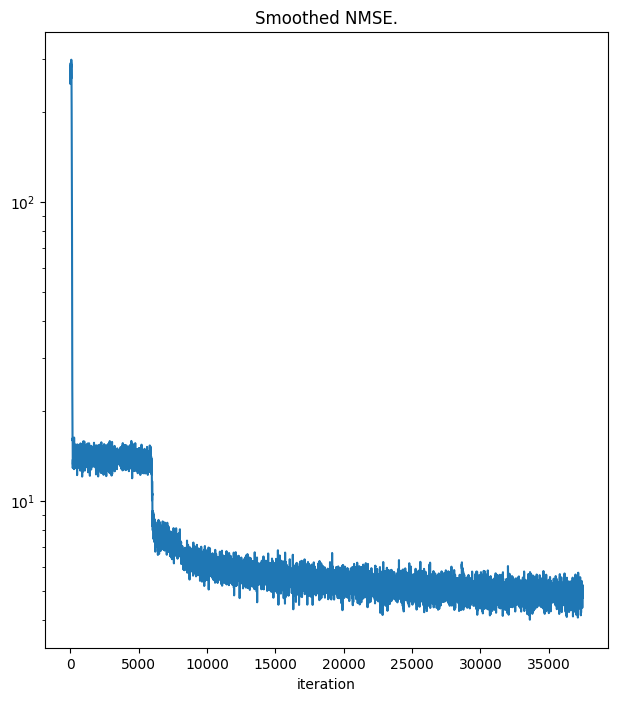

In [ ]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleConvMLPModel(nn.Module):
    def __init__(self):
        super(SimpleConvMLPModel, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        # We need to calculate the output size of the conv2 layer dynamically
        self._to_linear = None  # This will store the calculated size

        # MLP
        self.fc1 = None  # Initialize later in `_initialize_mlp`
        self.fc2 = None  # Initialize later

    def _initialize_mlp(self, x):
        self._to_linear = x.shape[1] * x.shape[2] * x.shape[3]  # Calculate the size
        self.fc1 = nn.Linear(in_features=self._to_linear, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        # Apply first convolutional layer
        x = F.relu(self.conv1(x))
        # Apply second convolutional layer
        x = F.relu(self.conv2(x))
        # Initialize MLP if not already done
        if self.fc1 is None:
            self._initialize_mlp(x)
        # Flatten the output for the MLP
        x = x.view(-1, self._to_linear)
        # Apply first layer of MLP
        x = F.relu(self.fc1(x))
        # Output layer of MLP
        x = self.fc2(x)
        return x

# Initialize the model
model = SimpleConvMLPModel()

# Example input tensor (batch size of 1, 3 color channels, 224x224 image)
input_tensor = torch.rand(1, 3, 224, 224)

# Forward pass
output = model(input_tensor)
print(output.shape)  # Output shape for 10 class predictions


torch.Size([1, 10])


In [ ]:
! pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

In [ ]:
from torchviz import make_dot

# Create a graph from a model output and its parameters
dot = make_dot(output, params=dict(list(model.named_parameters())))
dot.render('model_graph', format='png')  # This saves the graph as a PNG image


'model_graph.png'

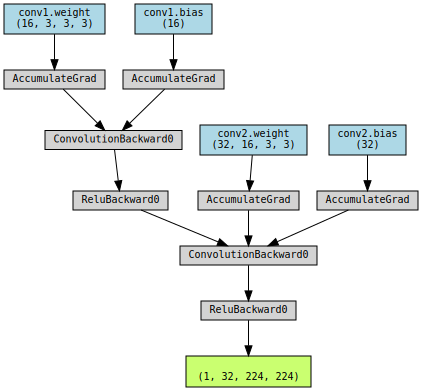

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ForwardPassOnlyModel(nn.Module):
    def __init__(self):
        super(ForwardPassOnlyModel, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

    def forward(self, x):
        # Apply first convolutional layer
        x = F.relu(self.conv1(x))
        # Apply second convolutional layer
        x = F.relu(self.conv2(x))
        return x

# Initialize the simplified model
forward_pass_model = ForwardPassOnlyModel()

# Example input tensor (batch size of 1, 3 color channels, 224x224 image)
input_tensor = torch.rand(1, 3, 224, 224)

# Perform forward pass
output = forward_pass_model(input_tensor)

# Visualize the computation graph
from torchviz import make_dot
make_dot(output, params=dict(list(forward_pass_model.named_parameters())))
